In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from scipy import signal
from mne.time_frequency import psd_array_multitaper
import optuna
import numpy as np  
import optuna.visualization as vis
from optuna.pruners import MedianPruner
import plotly
from scipy.stats import chisquare

/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 70.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')

In [3]:
fs = 500  # Sampling rate
nperseg = 256  # Segment length
noverlap = 128 # Overlap between segments
sampling_rate = 2000 ### simulacion 

resultado_compilacion = subprocess.run("g++ -fopenmp -O3 main.cpp Matrix_conect.cpp -o main_regular", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación:")
    print(resultado_compilacion.stderr)

def Simulado_EGG(params,Normalizacion):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params

    # Ejecución del programa
    resultado_ejecucion = subprocess.run(f" OMP_NUM_THREADS=2 ./main_regular {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion.stdout.strip().split('\n')
    data_list = [[float(num) for num in line.split()] for line in lines]
    data = np.array(data_list)[50:, 1]  
     
    if(Normalizacion=="max_global"):    
        data=data / max(data)
    elif(Normalizacion=="max_global_abs"):
        data=data / max(abs(data))
    elif(Normalizacion=="zscore"):
        data=(data - np.mean(data)) / np.std(data)

    n_samples_resampled = int(len(data)*(fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full',n_jobs=3)
    frequencies=np.array(frequencies)

    welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies >= 0, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies >= 3, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 14)]
    beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



In [4]:
def Datos_reales(nombres,Normalizacion):
    Datos = np.empty(len(nombres), dtype=object)
    Butter = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.empty(len(nombres), dtype=object)
    Theta = np.empty(len(nombres), dtype=object)
    Alpha = np.empty(len(nombres), dtype=object)
    Beta = np.empty(len(nombres), dtype=object)
    Nombres=np.empty(len(nombres), dtype="U100")

    mean_welch=np.zeros(481)
    mean_Delta = np.zeros(2)
    mean_Theta = np.zeros(2)
    mean_Alpha = np.zeros(2)
    mean_Beta = np.zeros(2)

    all_signals=np.empty_like(Datos)
    for i, nombre in enumerate(nombres): 
        all_signals[i]=np.loadtxt(nombre)

    all_values = np.concatenate(all_signals)  # Combinar todos los datos
    global_max = np.max(all_values)
    global_max_abs = np.max(abs(all_values))
    global_mean = np.mean(all_values)
    global_std = np.std(all_values)

    for i, nombre in enumerate(nombres):  
        Nombres[i]=nombre 
        data = np.loadtxt(nombre)

        if(Normalizacion=="max_global"):    
            data=data / global_max
        elif(Normalizacion=="max_global_abs"):
            data=data /global_max_abs
        elif(Normalizacion=="zscore"):
            data=(data -global_mean) / global_std

        Datos[i]=data
        Butter[i]=butter= signal.filtfilt(b, a,data)

        psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full')
        Frequencies[i]=frequencies=np.array(frequencies)

        welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
        welch_datos[i]=welch_data
        mean_welch+=welch_data/len(nombres)

        delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

        Delta[i]=[delta.mean(),delta.std()]
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]

        mean_Delta += np.array([delta.mean(), delta.std()]) / len(nombres)
        mean_Theta += np.array([theta.mean(), theta.std()]) / len(nombres)
        mean_Alpha += np.array([alpha.mean(), alpha.std()]) / len(nombres)
        mean_Beta += np.array([beta.mean(), beta.std()]) / len(nombres)

    return {
        "Nombres":Nombres,
        'datos': Datos, "frequencies": Frequencies,  "welch_data":welch_datos,"mean_welch":mean_welch,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'mean_Delta': mean_Delta,'mean_Theta':mean_Theta,"mean_Alpha":mean_Alpha,"mean_Beta":mean_Beta
    }


In [5]:
Params={'L': 49, 'P': 0.18480288512056137, 'Inh': 0.3568274238758705, 'Trest': 0.001388460705036468, 'Trelative': 0.1037062403200316, 'C_h': 0.8657675703460452, 'Tipo_red': 1}
initial_params = [Params["L"], Params["P"],Params["Inh"], Params["Trest"],Params["Trelative"], Params["C_h"] ,8050, Params["Tipo_red"]]

Normalizacion="zscore"###"max_global""max_global_abs" zscore
generated_data = Simulado_EGG(initial_params,Normalizacion)


reales_total = Datos_reales(["Datos_reales/P3_MNE.txt","Datos_reales/Pz_MNE.txt","Datos_reales/P4_MNE.txt"],Normalizacion)

    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


['Datos_reales/P3_MNE.txt' 'Datos_reales/Pz_MNE.txt'
 'Datos_reales/P4_MNE.txt']


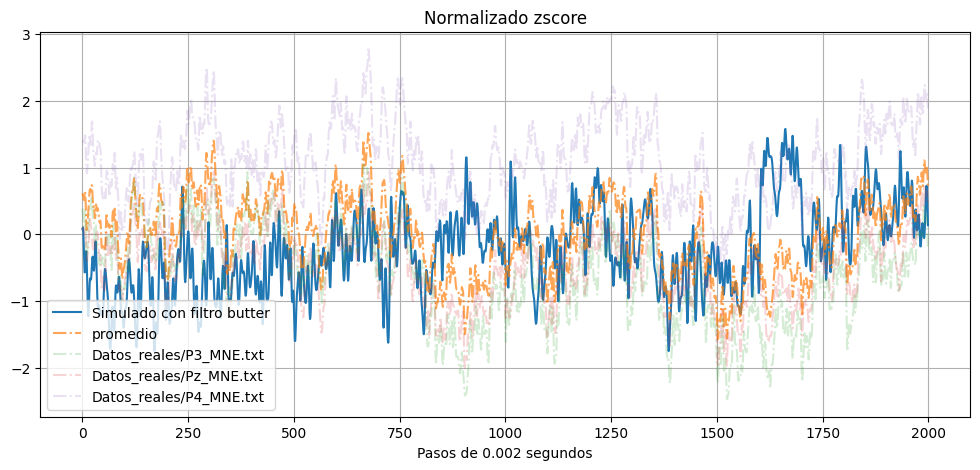

In [6]:
fig, ax = plt.subplots(figsize=[12, 5])


print(reales_total["Nombres"])
#ax.plot(generated_data["data_resample"],label="Simulado")

ax.plot(generated_data["butter"][:],label="Simulado con filtro butter")
grupos = np.array([reales_total["datos"][0], reales_total["datos"][1], reales_total["datos"][2]])
promedio = np.mean(grupos, axis=0) 

ax.plot(promedio,"-.", label="promedio",alpha=0.7)

for i in range(3):
    ax.plot(reales_total["datos"][i],"-.", label=reales_total["Nombres"][i],alpha=0.2)


plt.xlabel("Pasos de 0.002 segundos")
#plt.ylabel(r"$\mu V$")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.grid()
plt.title(f"Normalizado {Normalizacion}")
plt.show()  # Mostrar todos los gráficos en la misma figura


241
['Datos_reales/P3_MNE.txt' 'Datos_reales/Pz_MNE.txt'
 'Datos_reales/P4_MNE.txt']
Delta [np.float64(-12.81079647226871), np.float64(2.47832746825149)] ---- [-14.32308775   2.88420902]
Theta [np.float64(-18.962615069593014), np.float64(1.5193222431157007)] ---- [-18.96571845   1.24854892]
Alpha [np.float64(-21.856946912684375), np.float64(1.3125319715213362)] ---- [-21.50437221   1.65501801]
Beta [np.float64(-27.230879440197736), np.float64(1.344153988424413)] ---- [-28.90417761   2.14572478]


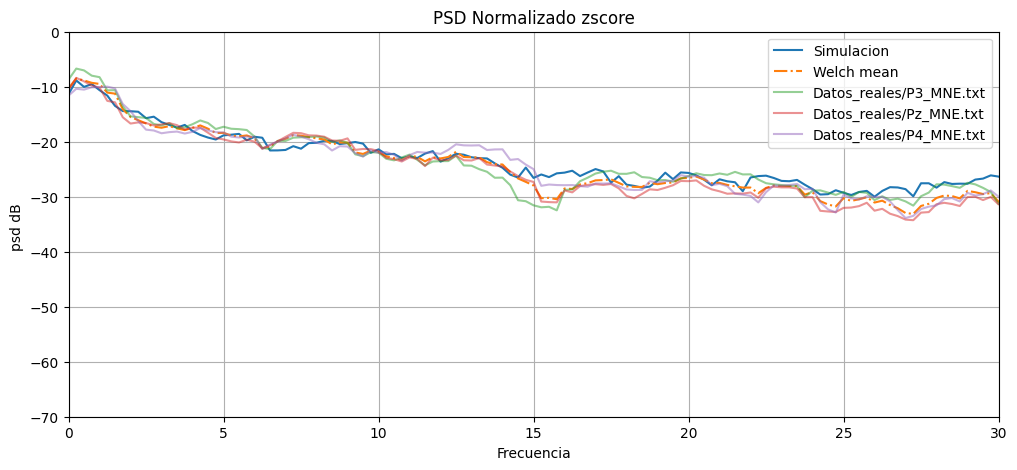

In [7]:
fig, ax = plt.subplots(figsize=[12, 5])
#print(generated_data["frequencies"])
frequencies = reales_total["frequencies"][0]
count_in_range = np.sum((frequencies >= 0) & (frequencies <= 60))
print(count_in_range)
print(reales_total["Nombres"])
print("Delta",generated_data["delta"],"----",reales_total["mean_Delta"])
print("Theta",generated_data["theta"],"----",reales_total["mean_Theta"])
print("Alpha",generated_data["alpha"],"----",reales_total["mean_Alpha"])
print("Beta",generated_data["beta"],"----",reales_total["mean_Beta"])

ax.plot(generated_data["frequencies"],generated_data["welch_data"],label="Simulacion")
ax.plot(reales_total["frequencies"][0],reales_total["mean_welch"],label="Welch mean",linestyle="-.")
for i in range(3):
    ax.plot(reales_total["frequencies"][i],reales_total["welch_data"][i], label=reales_total["Nombres"][i],alpha=0.5)

plt.xlabel("Frecuencia")
plt.ylabel("psd dB ")
plt.grid()
plt.xlim(0,30)
plt.ylim(-70,0)
plt.title(f"PSD Normalizado {Normalizacion}")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.show()  # Mostrar todos los gráficos en la misma figura


In [9]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',10,20)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',3,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L10", 
                            storage=f"sqlite:///Estudios/Random/Chi30_{Normalizacion}_L10.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=800)


[I 2024-11-14 22:27:06,531] Using an existing study with name 'Chi30_zscore_L10' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:27:07,100] Trial 62 finished with value: 30416.160510541187 and parameters: {'L': 14, 'P': 0.9507143064099162, 'Inh': 0.7319939418114051, 'Trest': 5.986584841970366, 'Trelative': 7.546771246394731, 'C_h': 0.15599452033620265, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:08,937] Trial 63 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.6011150117432088, 'Inh': 0.7080725777960455, 'Trest': 0.20584494295802447, 'Trelative': 9.904943464577968, 'C_h': 0.8324426408004217, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_8400/1698671771.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:09,480] Trial 64 finished with value: inf and parameters: {'L': 12, 'P': 0.18340450985343382, 'Inh': 0.3042422429595377, 'Trest': 5.247564316322379, 'Trelative': 9.567014502743536, 'C_h': 0.2912291401980419, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:10,132] Trial 65 finished with value: inf and parameters: {'L': 11, 'P': 0.29214464853521815, 'Inh': 0.3663618432936917, 'Trest': 4.56069984217036, 'Trelative': 12.412459456100496, 'C_h': 0.19967378215835974, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:27:10,902] Trial 66 finished with value: 340.2273726353734 and parameters: {'L': 16, 'P': 0.046450412719997725, 'Inh': 0.6075448519014384, 'Trest': 1.7052412368729153, 'Trelative': 2.3557571667257102, 'C_h': 0.9488855372533332, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:13,637] Trial 67 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.3046137691733707, 'Inh': 0.09767211400638387, 'Trest': 6.842330265121569, 'Trelative': 11.243855202517583, 'C_h': 0.12203823484477883, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:14,021] Trial 68 finished with value: inf and parameters: {'L': 10, 'P': 0.9093204020787821, 'Inh': 0.2587799816000169, 'Trest': 6.62522284353982, 'Trelative': 9.74233360443393, 'C_h': 0.5200680211778108, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:14,455] Trial 69 finished with value: inf and parameters: {'L': 12, 'P': 0.9695846277645586, 'Inh': 0.7751328233611146, 'Trest': 9.394989415641891, 'Trelative': 18.34326291991838, 'C_h': 0.5978999788110851, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:14,862] Trial 70 finished with value: inf and parameters: {'L': 10, 'P': 0.1959828624191452, 'Inh': 0.045227288910538066, 'Trest': 3.2533033076326436, 'Trelative': 7.140076204527464, 'C_h': 0.2713490317738959, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:27:15,622] Trial 71 finished with value: 17098.646463931163 and parameters: {'L': 13, 'P': 0.28093450968738076, 'Inh': 0.5426960831582485, 'Trest': 1.4092422497476265, 'Trelative': 9.431212057288024, 'C_h': 0.07455064367977082, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:17,394] Trial 72 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.1987156815341724, 'Inh': 0.005522117123602399, 'Trest': 8.154614284548341, 'Trelative': 15.223187723024513, 'C_h': 0.7290071680409873, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:17,872] Trial 73 finished with value: inf and parameters: {'L': 10, 'P': 0.3584657285442726, 'Inh': 0.11586905952512971, 'Trest': 8.631034258755935, 'Trelative': 14.864015527031516, 'C_h': 0.3308980248526492, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:18,714] Trial 74 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.32518332202674705, 'Inh': 0.7296061783380641, 'Trest': 6.3755747135521315, 'Trelative': 15.247702139315399, 'C_h': 0.4722149251619493, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:19,491] Trial 75 finished with value: inf and parameters: {'L': 17, 'P': 0.7607850486168974, 'Inh': 0.5612771975694962, 'Trest': 7.70967179954561, 'Trelative': 12.647627763189519, 'C_h': 0.5227328293819941, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:19,848] Trial 76 finished with value: inf and parameters: {'L': 10, 'P': 0.10789142699330445, 'Inh': 0.03142918568673425, 'Trest': 6.364104112637804, 'Trelative': 9.507663923401072, 'C_h': 0.5085706911647028, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:27:20,283] Trial 77 finished with value: 30721.721620041346 and parameters: {'L': 12, 'P': 0.41038292303562973, 'Inh': 0.7555511385430487, 'Trest': 2.2879816549162246, 'Trelative': 3.0577807532041543, 'C_h': 0.289751452913768, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:22,820] Trial 78 finished with value: 6843.776498706777 and parameters: {'L': 20, 'P': 0.808120379564417, 'Inh': 0.6334037565104235, 'Trest': 8.714605901877178, 'Trelative': 16.751326670868323, 'C_h': 0.18657005888603584, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:27:23,353] Trial 79 finished with value: 30606.501536562482 and parameters: {'L': 15, 'P': 0.8074401551640625, 'Inh': 0.8960912999234932, 'Trest': 3.1800347497186388, 'Trelative': 4.280553994995406, 'C_h': 0.22793516254194168, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:24,228] Trial 80 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.8607305832563434, 'Inh': 0.006952130531190703, 'Trest': 5.107473025775658, 'Trelative': 9.281583057263447, 'C_h': 0.22210781047073025, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:24,748] Trial 81 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.9429097039125192, 'Inh': 0.32320293202075523, 'Trest': 5.187906217433661, 'Trelative': 12.218095806385438, 'C_h': 0.363629602379294, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:27:28,190] Trial 82 finished with value: 464.42580780290996 and parameters: {'L': 20, 'P': 0.25178229582536416, 'Inh': 0.49724850589238545, 'Trest': 3.0087830981676964, 'Trelative': 5.857188041942372, 'C_h': 0.036886947354532795, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:28,927] Trial 83 finished with value: inf and parameters: {'L': 15, 'P': 0.05147875124998935, 'Inh': 0.27864646423661144, 'Trest': 9.082658859666537, 'Trelative': 11.478277766336262, 'C_h': 0.1448948720912231, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:32,779] Trial 84 finished with value: inf and parameters: {'L': 20, 'P': 0.2420552715115004, 'Inh': 0.6721355474058786, 'Trest': 7.616196153287175, 'Trelative': 9.992571593211172, 'C_h': 0.7282163486118596, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:33,815] Trial 85 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.6335297107608947, 'Inh': 0.5357746840747585, 'Trest': 0.902897700544083, 'Trelative': 9.255922656436463, 'C_h': 0.32078006497173583, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:27:34,249] Trial 86 finished with value: 28978.260072184366 and parameters: {'L': 10, 'P': 0.5908929431882418, 'Inh': 0.6775643618422824, 'Trest': 0.16587828927856152, 'Trelative': 5.286808872271371, 'C_h': 0.22649577519793795, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:34,654] Trial 87 finished with value: inf and parameters: {'L': 11, 'P': 0.690937738102466, 'Inh': 0.3867353463005374, 'Trest': 9.367299887367345, 'Trelative': 10.742509328827278, 'C_h': 0.3410663510502585, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:36,731] Trial 88 finished with value: inf and parameters: {'L': 20, 'P': 0.877339353380981, 'Inh': 0.2579416277151556, 'Trest': 6.59984046034179, 'Trelative': 14.772062462353947, 'C_h': 0.5552008115994623, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:37,286] Trial 89 finished with value: inf and parameters: {'L': 12, 'P': 0.09310276780589921, 'Inh': 0.8972157579533268, 'Trest': 9.004180571633304, 'Trelative': 15.335195144365985, 'C_h': 0.3390297910487007, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:37,950] Trial 90 finished with value: 30508.35038530854 and parameters: {'L': 17, 'P': 0.8971102599525771, 'Inh': 0.8870864242651173, 'Trest': 7.798755458576238, 'Trelative': 14.219071920119116, 'C_h': 0.08413996499504883, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:39,821] Trial 91 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.6064290596595899, 'Inh': 0.009197051616629648, 'Trest': 1.014715428660321, 'Trelative': 7.649733119740879, 'C_h': 0.005061583846218687, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:27:40,841] Trial 92 finished with value: 91.39961953501873 and parameters: {'L': 16, 'P': 0.6918951976926933, 'Inh': 0.6519612595026005, 'Trest': 2.242693094605598, 'Trelative': 9.364485308080956, 'C_h': 0.23724908749680007, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:27:41,684] Trial 93 finished with value: 30553.54369661041 and parameters: {'L': 18, 'P': 0.6496328990472147, 'Inh': 0.8492234104941779, 'Trest': 6.576128923003433, 'Trelative': 12.25921495635815, 'C_h': 0.09367476782809248, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:42,328] Trial 94 finished with value: inf and parameters: {'L': 12, 'P': 0.24398964337908358, 'Inh': 0.9730105547524456, 'Trest': 3.930977246667604, 'Trelative': 12.851442798438738, 'C_h': 0.6311386259972629, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:27:43,669] Trial 95 finished with value: 508.349848403805 and parameters: {'L': 15, 'P': 0.5769038846263591, 'Inh': 0.4925176938188639, 'Trest': 1.952429877980445, 'Trelative': 9.176951030595498, 'C_h': 0.2807723624408558, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:27:45,754] Trial 96 finished with value: 11253.736489323084 and parameters: {'L': 17, 'P': 0.17711067940704894, 'Inh': 0.9404585843529143, 'Trest': 9.539285770025874, 'Trelative': 18.68792967223036, 'C_h': 0.3701587002554444, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:47,130] Trial 97 finished with value: 30568.021608972238 and parameters: {'L': 20, 'P': 0.42818414831731433, 'Inh': 0.9666548190436696, 'Trest': 9.636199770892528, 'Trelative': 18.166294325566128, 'C_h': 0.2944488920695857, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:49,854] Trial 98 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.31692200515627766, 'Inh': 0.1694927466860925, 'Trest': 5.568012624583502, 'Trelative': 14.92956036619131, 'C_h': 0.696029796674973, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:50,268] Trial 99 finished with value: 30622.020024931702 and parameters: {'L': 11, 'P': 0.6150072266991697, 'Inh': 0.9900538501042633, 'Trest': 1.4008401523652403, 'Trelative': 6.584136676002608, 'C_h': 0.8773730719279554, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:52,258] Trial 100 finished with value: inf and parameters: {'L': 17, 'P': 0.7024840839871093, 'Inh': 0.35949115121975517, 'Trest': 2.9359184426449336, 'Trelative': 11.02952999743007, 'C_h': 0.8101133946791808, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:27:56,489] Trial 101 finished with value: inf and parameters: {'L': 20, 'P': 0.5113423988609378, 'Inh': 0.5015162946871996, 'Trest': 7.9829517896677515, 'Trelative': 14.482591097445404, 'C_h': 0.7019668772577033, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:28:00,646] Trial 102 finished with value: 572.6740338586883 and parameters: {'L': 19, 'P': 0.3379951568515358, 'Inh': 0.375582952639944, 'Trest': 0.93981939840869, 'Trelative': 6.72262080837043, 'C_h': 0.035942273796742086, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:28:01,337] Trial 103 finished with value: 28549.683304160204 and parameters: {'L': 15, 'P': 0.2865412521282844, 'Inh': 0.5908332605690108, 'Trest': 0.3050024993904943, 'Trelative': 0.6784843868826385, 'C_h': 0.8226005606596583, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:01,690] Trial 104 finished with value: 30468.74370481069 and parameters: {'L': 11, 'P': 0.5222432600548044, 'Inh': 0.7699935530986108, 'Trest': 2.1582102749684315, 'Trelative': 8.387115033158434, 'C_h': 0.085347464993768, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:02,684] Trial 105 finished with value: inf and parameters: {'L': 15, 'P': 0.5406351216101065, 'Inh': 0.6374299014982066, 'Trest': 7.260913337226615, 'Trelative': 17.01943413185196, 'C_h': 0.5163003483011953, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:05,067] Trial 106 finished with value: 469.76741000407077 and parameters: {'L': 18, 'P': 0.2708322512620742, 'Inh': 0.4389714207056361, 'Trest': 0.7845638134226596, 'Trelative': 1.0380712475772347, 'C_h': 0.9626484146779251, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:07,474] Trial 107 finished with value: inf and parameters: {'L': 17, 'P': 0.4089529444142699, 'Inh': 0.17329432007084578, 'Trest': 1.5643704267108605, 'Trelative': 4.066799408356814, 'C_h': 0.5492266647061205, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:28:08,208] Trial 108 finished with value: 30407.342855402596 and parameters: {'L': 17, 'P': 0.27993389694594284, 'Inh': 0.9548652806631941, 'Trest': 7.378969166957685, 'Trelative': 12.922509692071692, 'C_h': 0.6117207462343522, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:08,619] Trial 109 finished with value: 30832.185891914793 and parameters: {'L': 12, 'P': 0.3559726786512616, 'Inh': 0.7578461104643691, 'Trest': 0.14393488629755868, 'Trelative': 1.304661291366721, 'C_h': 0.04600264202175275, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:10,101] Trial 110 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.7036578593800237, 'Inh': 0.4741738290873252, 'Trest': 0.9783416065100148, 'Trelative': 5.894500357678338, 'C_h': 0.4734717707805657, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:11,318] Trial 111 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.39850473439737344, 'Inh': 0.6158500980522165, 'Trest': 6.350936508676438, 'Trelative': 6.803976606396883, 'C_h': 0.3746126146264712, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:12,042] Trial 112 finished with value: 144.67764266239297 and parameters: {'L': 15, 'P': 0.8564898411883223, 'Inh': 0.658693631618945, 'Trest': 1.629344270814297, 'Trelative': 2.335031744818595, 'C_h': 0.6424192782063156, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:28:12,864] Trial 113 finished with value: 11350.278816923821 and parameters: {'L': 16, 'P': 0.9402302414249576, 'Inh': 0.575474177875879, 'Trest': 3.881699262065219, 'Trelative': 10.31458144648875, 'C_h': 0.45825289049151663, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:14,336] Trial 114 finished with value: 30568.021608972238 and parameters: {'L': 20, 'P': 0.38610263780077425, 'Inh': 0.9611905638239142, 'Trest': 9.053506419560637, 'Trelative': 11.011417767453601, 'C_h': 0.06936130087516545, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:14,691] Trial 115 finished with value: 167.06592410145774 and parameters: {'L': 10, 'P': 0.0944429607559284, 'Inh': 0.6830067734163568, 'Trest': 0.7118864846022899, 'Trelative': 3.9016427875399025, 'C_h': 0.8448753109694546, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:16,843] Trial 116 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.28185477477339993, 'Inh': 0.11816482762165625, 'Trest': 6.967371653641506, 'Trelative': 13.256800121440346, 'C_h': 0.877472013527053, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:19,808] Trial 117 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.2820345725713065, 'Inh': 0.17743954377972282, 'Trest': 7.506147516408584, 'Trelative': 15.574494909081222, 'C_h': 0.9905051420006733, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:20,871] Trial 118 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.7764129607419968, 'Inh': 0.34080354025301784, 'Trest': 9.307573256035647, 'Trelative': 17.891700774465765, 'C_h': 0.42899402737501835, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:22,303] Trial 119 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.10312386883593261, 'Inh': 0.9025529066795667, 'Trest': 5.052523724478571, 'Trelative': 13.317098385555987, 'C_h': 0.32004960103061175, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:28:22,748] Trial 120 finished with value: 24445.66869946918 and parameters: {'L': 14, 'P': 0.01083765148029836, 'Inh': 0.9053819764192637, 'Trest': 0.9128667678613356, 'Trelative': 4.106003143765484, 'C_h': 0.9500619670508049, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:24,475] Trial 121 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.6318372121697993, 'Inh': 0.44844552197831977, 'Trest': 2.9321077169806453, 'Trelative': 6.218753170679805, 'C_h': 0.6725184560770384, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:25,876] Trial 122 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.7896181427945539, 'Inh': 0.09120610304869037, 'Trest': 4.944203047025814, 'Trelative': 5.5197906471922575, 'C_h': 0.5495288823237355, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:29,234] Trial 123 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.3509150125520787, 'Inh': 0.11706701642760586, 'Trest': 1.4299168205283586, 'Trelative': 9.045023137703081, 'C_h': 0.6182180633162611, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:29,581] Trial 124 finished with value: inf and parameters: {'L': 10, 'P': 0.70096913145912, 'Inh': 0.07276300636419353, 'Trest': 8.218600592903563, 'Trelative': 15.281022864468525, 'C_h': 0.08134878064189976, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:33,431] Trial 125 finished with value: inf and parameters: {'L': 20, 'P': 0.3742707957561203, 'Inh': 0.3706421470668909, 'Trest': 8.127995672575025, 'Trelative': 17.60048144641361, 'C_h': 0.9860010638228709, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:34,278] Trial 126 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.08350071669866876, 'Inh': 0.7771469159274368, 'Trest': 5.58404249735805, 'Trelative': 9.826262589827813, 'C_h': 0.906354385094736, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:28:34,818] Trial 127 finished with value: 24142.61826986203 and parameters: {'L': 15, 'P': 0.011353644767419069, 'Inh': 0.46866064199412627, 'Trest': 0.5630327568183735, 'Trelative': 1.7512119194990927, 'C_h': 0.11752624677710488, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:28:35,871] Trial 128 finished with value: 30421.601908845754 and parameters: {'L': 18, 'P': 0.5833687650971596, 'Inh': 0.9621725484745419, 'Trest': 3.748705795237041, 'Trelative': 6.605826658055648, 'C_h': 0.8685991281894603, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:36,541] Trial 129 finished with value: 25478.200408613102 and parameters: {'L': 20, 'P': 0.012154474689816341, 'Inh': 0.969878826707639, 'Trest': 0.43159911950576113, 'Trelative': 9.343030256486472, 'C_h': 0.5277011090862999, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:28:36,851] Trial 130 finished with value: 30346.005569829515 and parameters: {'L': 10, 'P': 0.5538542844013208, 'Inh': 0.969302535619099, 'Trest': 5.230978441701488, 'Trelative': 11.524964823054113, 'C_h': 0.6957486889846172, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:28:37,494] Trial 131 finished with value: 30420.679321933032 and parameters: {'L': 16, 'P': 0.5843143119231002, 'Inh': 0.901158010490989, 'Trest': 0.4544638034145787, 'Trelative': 3.264095699336882, 'C_h': 0.9504114840765587, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:38,689] Trial 132 finished with value: inf and parameters: {'L': 15, 'P': 0.6201325978015367, 'Inh': 0.2773811829811327, 'Trest': 1.881211597237613, 'Trelative': 6.518195646637434, 'C_h': 0.3533522280260528, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:39,008] Trial 133 finished with value: 30388.757461955258 and parameters: {'L': 10, 'P': 0.9743948076661665, 'Inh': 0.9862107444796029, 'Trest': 6.981617140197452, 'Trelative': 12.342580803638654, 'C_h': 0.30952761628632774, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:39,983] Trial 134 finished with value: inf and parameters: {'L': 17, 'P': 0.1626169393448913, 'Inh': 0.9109271844938425, 'Trest': 8.22537242923169, 'Trelative': 17.72337156215093, 'C_h': 0.72571950838836, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:40,418] Trial 135 finished with value: 30382.68448840644 and parameters: {'L': 14, 'P': 0.9327284833540133, 'Inh': 0.8660638895004084, 'Trest': 0.45218670106189407, 'Trelative': 0.7158564460344141, 'C_h': 0.3764633668780496, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:42,213] Trial 136 finished with value: inf and parameters: {'L': 20, 'P': 0.15041689110352818, 'Inh': 0.5941307153521351, 'Trest': 3.8089085663102153, 'Trelative': 13.508052544456248, 'C_h': 0.8421189231357087, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:43,435] Trial 137 finished with value: inf and parameters: {'L': 15, 'P': 0.4148195023376652, 'Inh': 0.27340707193070624, 'Trest': 0.5637549665092711, 'Trelative': 9.210978729059804, 'C_h': 0.8129010091300776, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:28:44,504] Trial 138 finished with value: 30478.079910744193 and parameters: {'L': 20, 'P': 0.5554317056026274, 'Inh': 0.7689874151805105, 'Trest': 9.44765729882428, 'Trelative': 17.944131205598396, 'C_h': 0.24734810174319766, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:44,862] Trial 139 finished with value: 13725.320115959032 and parameters: {'L': 11, 'P': 0.9540510272587224, 'Inh': 0.60617463445088, 'Trest': 2.2864280550346274, 'Trelative': 9.003434899093195, 'C_h': 0.6181282404578958, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:45,257] Trial 140 finished with value: inf and parameters: {'L': 11, 'P': 0.6715731955927996, 'Inh': 0.5203077009037933, 'Trest': 7.723183917356393, 'Trelative': 12.924818928476327, 'C_h': 0.8521815003185401, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:46,021] Trial 141 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.876653602658345, 'Inh': 0.40348286621239704, 'Trest': 1.3401522845064073, 'Trelative': 1.627979047639797, 'C_h': 0.755137255673619, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:47,836] Trial 142 finished with value: inf and parameters: {'L': 17, 'P': 0.21296416150891073, 'Inh': 0.13637147558676976, 'Trest': 0.14544665667881929, 'Trelative': 3.6513222447447893, 'C_h': 0.5899176868546331, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:48,408] Trial 143 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.9041586944937484, 'Inh': 0.34825546702330035, 'Trest': 5.139894891598108, 'Trelative': 12.97642501900954, 'C_h': 0.39654278232127016, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:49,431] Trial 144 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.9495206236576421, 'Inh': 0.14707348092903794, 'Trest': 9.265876251614944, 'Trelative': 14.187039182410327, 'C_h': 0.25824438829895835, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:52,364] Trial 145 finished with value: inf and parameters: {'L': 20, 'P': 0.4926180939928696, 'Inh': 0.3287516102875082, 'Trest': 6.334008543167258, 'Trelative': 8.73546473094919, 'C_h': 0.07586332810866392, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:52,945] Trial 146 finished with value: inf and parameters: {'L': 11, 'P': 0.15190269351229435, 'Inh': 0.13882717264941014, 'Trest': 6.4087474480321465, 'Trelative': 8.227548292023595, 'C_h': 0.3456672833238632, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:53,641] Trial 147 finished with value: inf and parameters: {'L': 15, 'P': 0.6675577385210272, 'Inh': 0.17231987120162984, 'Trest': 1.9228901880867078, 'Trelative': 2.3315763507514964, 'C_h': 0.16893506307216455, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:54,052] Trial 148 finished with value: inf and parameters: {'L': 11, 'P': 0.08870253375705561, 'Inh': 0.12063587110060081, 'Trest': 4.607787680327258, 'Trelative': 6.671124864385183, 'C_h': 0.36426986104807546, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:54,853] Trial 149 finished with value: inf and parameters: {'L': 17, 'P': 0.039312139841098936, 'Inh': 0.7994103989090426, 'Trest': 6.279003894909078, 'Trelative': 7.096594214397797, 'C_h': 0.8735786241067772, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:28:55,182] Trial 150 finished with value: 30412.226415124154 and parameters: {'L': 10, 'P': 0.2768776481472037, 'Inh': 0.8062012797930613, 'Trest': 7.482596903836583, 'Trelative': 9.327807097400356, 'C_h': 0.2093493233367103, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:56,032] Trial 151 finished with value: inf and parameters: {'L': 15, 'P': 0.618254771530296, 'Inh': 0.3689136395697724, 'Trest': 4.625347161331479, 'Trelative': 12.100056542669044, 'C_h': 0.0366832028905979, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:57,269] Trial 152 finished with value: inf and parameters: {'L': 17, 'P': 0.8952068376871993, 'Inh': 0.5116774421156661, 'Trest': 5.321134852653157, 'Trelative': 6.392854966050917, 'C_h': 0.44741236682345464, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:28:58,247] Trial 153 finished with value: 651.5167328214794 and parameters: {'L': 12, 'P': 0.26924323094938096, 'Inh': 0.37728416310462265, 'Trest': 0.20071197777726368, 'Trelative': 3.4215036336090465, 'C_h': 0.21144800699654465, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:28:58,625] Trial 154 finished with value: inf and parameters: {'L': 11, 'P': 0.890527280739895, 'Inh': 0.5935924535540487, 'Trest': 6.791023191444896, 'Trelative': 14.68273557751828, 'C_h': 0.4984421989290573, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:28:59,196] Trial 155 finished with value: 30482.816705601148 and parameters: {'L': 15, 'P': 0.5868411180208791, 'Inh': 0.74543947418433, 'Trest': 4.316595462296794, 'Trelative': 5.592398490252432, 'C_h': 0.28377590579872447, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:00,602] Trial 156 finished with value: inf and parameters: {'L': 17, 'P': 0.5707783046689119, 'Inh': 0.35609672589784624, 'Trest': 9.865152487929796, 'Trelative': 15.922900681498668, 'C_h': 0.23722679173599448, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:01,093] Trial 157 finished with value: inf and parameters: {'L': 11, 'P': 0.24595772838450813, 'Inh': 0.16068137325955567, 'Trest': 1.8656702405130576, 'Trelative': 4.716621927451529, 'C_h': 0.17337359529475482, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:01,536] Trial 158 finished with value: inf and parameters: {'L': 10, 'P': 0.5245113895702547, 'Inh': 0.4103968269896615, 'Trest': 9.823786169086064, 'Trelative': 10.944175190766588, 'C_h': 0.39785559904574164, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:03,576] Trial 159 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.8170720709492799, 'Inh': 0.25790282704493983, 'Trest': 1.7088758739006582, 'Trelative': 8.395308073144967, 'C_h': 0.9293759891275858, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:29:04,162] Trial 160 finished with value: 37363.116474346556 and parameters: {'L': 16, 'P': 0.2799790936602842, 'Inh': 0.7694929331919369, 'Trest': 1.8704374855752337, 'Trelative': 5.107229849617671, 'C_h': 0.4254364386164168, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:04,844] Trial 161 finished with value: inf and parameters: {'L': 12, 'P': 0.11483682473920354, 'Inh': 0.6106200424416326, 'Trest': 2.8863055324025577, 'Trelative': 8.69868774662868, 'C_h': 0.1543627152742023, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:05,738] Trial 162 finished with value: inf and parameters: {'L': 15, 'P': 0.05182353682242691, 'Inh': 0.3366042781939206, 'Trest': 1.3441467693897424, 'Trelative': 1.9778964741174199, 'C_h': 0.9899602323899452, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:06,820] Trial 163 finished with value: 13789.869322148503 and parameters: {'L': 18, 'P': 0.25464065476376385, 'Inh': 0.6815027222239293, 'Trest': 7.6022785988968655, 'Trelative': 13.558666004975308, 'C_h': 0.47157618855015837, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:29:07,222] Trial 164 finished with value: 30436.626132267193 and parameters: {'L': 13, 'P': 0.9295291442478258, 'Inh': 0.8306194077877291, 'Trest': 9.650269106665126, 'Trelative': 10.893241341520573, 'C_h': 0.7308674752036443, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:07,777] Trial 165 finished with value: inf and parameters: {'L': 11, 'P': 0.0664962673667775, 'Inh': 0.741120649290059, 'Trest': 5.744731131799119, 'Trelative': 14.16301889938184, 'C_h': 0.1397723766262895, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:08,643] Trial 166 finished with value: inf and parameters: {'L': 12, 'P': 0.1636559428657045, 'Inh': 0.16426579793099294, 'Trest': 8.14574720231382, 'Trelative': 14.797719409275821, 'C_h': 0.5230654247691193, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:29:09,733] Trial 167 finished with value: 30381.55098462836 and parameters: {'L': 19, 'P': 0.3924451074226354, 'Inh': 0.8165994394715771, 'Trest': 4.391349085702184, 'Trelative': 8.16079337995126, 'C_h': 0.46267978566960644, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:12,358] Trial 168 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.5027203900924792, 'Inh': 0.2322126951468173, 'Trest': 8.995745732745684, 'Trelative': 12.834657946477797, 'C_h': 0.5435528611139886, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:29:12,854] Trial 169 finished with value: 29970.851211542395 and parameters: {'L': 16, 'P': 0.11689804070836407, 'Inh': 0.9398321236134751, 'Trest': 6.277080530714178, 'Trelative': 9.62613667728504, 'C_h': 0.13927207266338726, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:13,591] Trial 170 finished with value: 30474.409918617086 and parameters: {'L': 16, 'P': 0.5334610919763215, 'Inh': 0.8938925830509576, 'Trest': 7.885972112245307, 'Trelative': 9.40272090957282, 'C_h': 0.31172206779554823, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:14,431] Trial 171 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.03353243473577938, 'Inh': 0.5698896848713165, 'Trest': 7.624586857406905, 'Trelative': 16.392243225024398, 'C_h': 0.34208174871590746, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:14,829] Trial 172 finished with value: inf and parameters: {'L': 11, 'P': 0.8464522917345182, 'Inh': 0.12748866233198242, 'Trest': 3.9728729056036727, 'Trelative': 11.945826563399208, 'C_h': 0.14991742734877378, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:15,946] Trial 173 finished with value: inf and parameters: {'L': 17, 'P': 0.7200365365460744, 'Inh': 0.6411476328852973, 'Trest': 6.939484444671001, 'Trelative': 12.366728878146963, 'C_h': 0.25179905890695276, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:16,408] Trial 174 finished with value: inf and parameters: {'L': 11, 'P': 0.9084505613336283, 'Inh': 0.5833917947661205, 'Trest': 4.008514167636399, 'Trelative': 8.628572204077726, 'C_h': 0.9472833396118153, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:18,152] Trial 175 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.505888678884466, 'Inh': 0.6114542354346478, 'Trest': 0.18110183820840509, 'Trelative': 8.90234092764992, 'C_h': 0.9321182824836124, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:29:18,798] Trial 176 finished with value: 30407.342855402596 and parameters: {'L': 17, 'P': 0.9224993811772957, 'Inh': 0.7072386343133986, 'Trest': 1.5253904291426135, 'Trelative': 7.288274030810745, 'C_h': 0.6067150463828559, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:29:19,499] Trial 177 finished with value: 30421.601908845754 and parameters: {'L': 18, 'P': 0.9343670147690148, 'Inh': 0.9255685129067763, 'Trest': 4.508393714041321, 'Trelative': 5.640774172448873, 'C_h': 0.9848411989623346, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:19,822] Trial 178 finished with value: 30622.020024931702 and parameters: {'L': 11, 'P': 0.9208418826173723, 'Inh': 0.8698963620621283, 'Trest': 5.188380571260721, 'Trelative': 11.101134928710014, 'C_h': 0.39900270387013026, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:20,473] Trial 179 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.8028534485980114, 'Inh': 0.004632023004602859, 'Trest': 3.334991716911442, 'Trelative': 7.316678652820875, 'C_h': 0.5373956029379229, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:21,504] Trial 180 finished with value: 1194.4276072825637 and parameters: {'L': 13, 'P': 0.3469532018962277, 'Inh': 0.7375012481097484, 'Trest': 4.522179408898071, 'Trelative': 6.7682276382978905, 'C_h': 0.4524395161326934, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:22,098] Trial 181 finished with value: inf and parameters: {'L': 11, 'P': 0.49836777273947974, 'Inh': 0.4189254495045479, 'Trest': 9.148459010681, 'Trelative': 12.772398001847332, 'C_h': 0.5805883502780435, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:22,468] Trial 182 finished with value: inf and parameters: {'L': 10, 'P': 0.6635373720167106, 'Inh': 0.17803596686975143, 'Trest': 9.610703174694551, 'Trelative': 11.09733045222568, 'C_h': 0.41462412372702373, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:29:24,109] Trial 183 finished with value: 10629.435584252444 and parameters: {'L': 20, 'P': 0.5021950103312426, 'Inh': 0.5953850173200438, 'Trest': 0.6707647738842748, 'Trelative': 8.170369477876052, 'C_h': 0.20990559309558576, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:24,640] Trial 184 finished with value: inf and parameters: {'L': 12, 'P': 0.19068772066366657, 'Inh': 0.03654966784809488, 'Trest': 4.720669451099992, 'Trelative': 10.369080783726156, 'C_h': 0.06570863942835237, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:25,522] Trial 185 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.52439026932758, 'Inh': 0.44076274693822814, 'Trest': 4.00763060875326, 'Trelative': 9.60403392183544, 'C_h': 0.1552402459307125, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:26,335] Trial 186 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.9461154621336327, 'Inh': 0.37330931627975295, 'Trest': 2.707446731435538, 'Trelative': 9.147442163825694, 'C_h': 0.4087341710980964, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:26,712] Trial 187 finished with value: 29559.753398606226 and parameters: {'L': 11, 'P': 0.7159722288473975, 'Inh': 0.6589239419101514, 'Trest': 0.2709599250348349, 'Trelative': 2.490681544364329, 'C_h': 0.2310747965880714, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:27,093] Trial 188 finished with value: 23578.569664149545 and parameters: {'L': 10, 'P': 0.10410858198457384, 'Inh': 0.7999160853731894, 'Trest': 1.7854466205433361, 'Trelative': 8.312907699062084, 'C_h': 0.23818278104672652, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:27,445] Trial 189 finished with value: 30779.611361501517 and parameters: {'L': 12, 'P': 0.7222669318556592, 'Inh': 0.8556964681062857, 'Trest': 8.302198645669916, 'Trelative': 12.274033941854466, 'C_h': 0.6680851365706462, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:27,903] Trial 190 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.8963358185211198, 'Inh': 0.013001923510736035, 'Trest': 0.8550853085446808, 'Trelative': 2.933947860004954, 'C_h': 0.026532203873819715, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:28,681] Trial 191 finished with value: 30561.822255560128 and parameters: {'L': 16, 'P': 0.42142455059249795, 'Inh': 0.8926717110769748, 'Trest': 8.17443561738441, 'Trelative': 11.592609134363169, 'C_h': 0.2594234334312925, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:30,518] Trial 192 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.26806364082287626, 'Inh': 0.624148907849134, 'Trest': 4.0941165219124045, 'Trelative': 9.614588330432207, 'C_h': 0.4361265291353167, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:33,226] Trial 193 finished with value: inf and parameters: {'L': 20, 'P': 0.7636057941597608, 'Inh': 0.14011317576645255, 'Trest': 8.684679758979128, 'Trelative': 13.558991741474266, 'C_h': 0.8945522268940914, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:33,896] Trial 194 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.022469308320117398, 'Inh': 0.2686773593849461, 'Trest': 5.416342146608669, 'Trelative': 11.751124344870142, 'C_h': 0.2578876854332023, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:29:35,669] Trial 195 finished with value: 1436.8838931789646 and parameters: {'L': 19, 'P': 0.9844021807035521, 'Inh': 0.5256901823026858, 'Trest': 1.716792858483035, 'Trelative': 4.439866123676724, 'C_h': 0.018390676547466733, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:36,233] Trial 196 finished with value: inf and parameters: {'L': 11, 'P': 0.5765164755142536, 'Inh': 0.274055220687206, 'Trest': 5.541780025157934, 'Trelative': 12.055983908676577, 'C_h': 0.8297418037072016, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:36,640] Trial 197 finished with value: inf and parameters: {'L': 10, 'P': 0.13688563006880727, 'Inh': 0.9000186418481051, 'Trest': 8.738900775625153, 'Trelative': 14.713031797328236, 'C_h': 0.6005168604336534, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:36,990] Trial 198 finished with value: inf and parameters: {'L': 11, 'P': 0.9144119459249598, 'Inh': 0.4187705248920731, 'Trest': 3.8313852824949746, 'Trelative': 9.02056233532335, 'C_h': 0.046965966775055046, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:38,507] Trial 199 finished with value: 420.95587561236607 and parameters: {'L': 18, 'P': 0.08279866792512647, 'Inh': 0.6031521094663882, 'Trest': 2.4534910968132095, 'Trelative': 6.346447237232975, 'C_h': 0.28869373677069987, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:40,529] Trial 200 finished with value: inf and parameters: {'L': 17, 'P': 0.297121715623175, 'Inh': 0.5664046402968972, 'Trest': 4.760504021990997, 'Trelative': 11.397215675617478, 'C_h': 0.936829739324758, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:40,904] Trial 201 finished with value: inf and parameters: {'L': 12, 'P': 0.031183135061284672, 'Inh': 0.2622640442998251, 'Trest': 5.9507793070025485, 'Trelative': 6.465037441845052, 'C_h': 0.49636624720123634, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:41,596] Trial 202 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.7709122037458219, 'Inh': 0.1065982531337718, 'Trest': 0.7513778173580876, 'Trelative': 8.03326537939412, 'C_h': 0.49549131620619846, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:42,368] Trial 203 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.2464020332391068, 'Inh': 0.8191023176741997, 'Trest': 7.994158789689792, 'Trelative': 14.94112349823406, 'C_h': 0.2721451372299627, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:42,982] Trial 204 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.09158207332663415, 'Inh': 0.9173135754622428, 'Trest': 1.368186309189614, 'Trelative': 10.870559847397638, 'C_h': 0.44600577295795574, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:43,723] Trial 205 finished with value: inf and parameters: {'L': 15, 'P': 0.8729458358764083, 'Inh': 0.7322248864095612, 'Trest': 8.065611478614498, 'Trelative': 14.653445145721673, 'C_h': 0.6922765645178525, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:44,366] Trial 206 finished with value: inf and parameters: {'L': 12, 'P': 0.4894249636431405, 'Inh': 0.22120944181960223, 'Trest': 9.87668007996647, 'Trelative': 19.317273476832604, 'C_h': 0.0394268113685059, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:47,653] Trial 207 finished with value: inf and parameters: {'L': 20, 'P': 0.18057534512733353, 'Inh': 0.5679452305526295, 'Trest': 9.154882975880419, 'Trelative': 9.494342761738407, 'C_h': 0.6974202672468399, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:29:48,410] Trial 208 finished with value: 30474.022387911227 and parameters: {'L': 20, 'P': 0.9710582451653678, 'Inh': 0.9442664891134339, 'Trest': 4.742142166574638, 'Trelative': 13.362568676467772, 'C_h': 0.8445493985350704, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:49,448] Trial 209 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.03700763471549262, 'Inh': 0.596269878482053, 'Trest': 2.3000883728770303, 'Trelative': 3.5057572306498184, 'C_h': 0.07695320162920916, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:50,074] Trial 210 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.7247667715287615, 'Inh': 0.06535634079894237, 'Trest': 3.152903378306103, 'Trelative': 8.547816302059475, 'C_h': 0.7907231648389635, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:50,737] Trial 211 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.8859777482361871, 'Inh': 0.6158631881823046, 'Trest': 2.329594747536338, 'Trelative': 2.5736025631017183, 'C_h': 0.8700988739009299, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:29:51,883] Trial 212 finished with value: 30384.31898316914 and parameters: {'L': 19, 'P': 0.528937134027212, 'Inh': 0.9390676985128962, 'Trest': 7.987832357736654, 'Trelative': 17.96717346307003, 'C_h': 0.35071181545171015, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:52,952] Trial 213 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.47987562030390885, 'Inh': 0.6275054632183701, 'Trest': 8.736771141863388, 'Trelative': 18.57760583385634, 'C_h': 0.7682734138645182, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:54,244] Trial 214 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.7375823015888915, 'Inh': 0.23877714576830233, 'Trest': 1.1047411313139466, 'Trelative': 4.650962707721712, 'C_h': 0.28723899165408173, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:55,070] Trial 215 finished with value: inf and parameters: {'L': 12, 'P': 0.04209318963636188, 'Inh': 0.01787393473341381, 'Trest': 9.877223897360315, 'Trelative': 14.154955234718939, 'C_h': 0.3843266471596817, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:55,777] Trial 216 finished with value: 30779.611361501517 and parameters: {'L': 12, 'P': 0.9499611839502253, 'Inh': 0.786345014415552, 'Trest': 0.8941100231225951, 'Trelative': 5.0699177809718785, 'C_h': 0.8791183075621647, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:57,506] Trial 217 finished with value: inf and parameters: {'L': 15, 'P': 0.6134113892107077, 'Inh': 0.16703394609207523, 'Trest': 9.911686261369766, 'Trelative': 12.228403275204201, 'C_h': 0.9427317741351257, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:59,411] Trial 218 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.5126885110165086, 'Inh': 0.2306698117177587, 'Trest': 1.7652803200550826, 'Trelative': 3.970142410756836, 'C_h': 0.18643826214425452, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:29:59,950] Trial 219 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.05784267656339637, 'Inh': 0.9691026301408113, 'Trest': 8.837858849634257, 'Trelative': 18.11538168158639, 'C_h': 0.9949078226464353, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:00,552] Trial 220 finished with value: 29856.191364727605 and parameters: {'L': 14, 'P': 0.7582384757040913, 'Inh': 0.6960206180537922, 'Trest': 1.5389590633985506, 'Trelative': 9.697290313304729, 'C_h': 0.22444057183666066, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:01,326] Trial 221 finished with value: 23818.318079081553 and parameters: {'L': 15, 'P': 0.5929399348417032, 'Inh': 0.5800862078378112, 'Trest': 0.9148683739775487, 'Trelative': 9.689477000281354, 'C_h': 0.26560004258870606, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:30:02,094] Trial 222 finished with value: 30381.55098462836 and parameters: {'L': 19, 'P': 0.9556514982297534, 'Inh': 0.8621276172654506, 'Trest': 8.09516074724878, 'Trelative': 14.647580553638997, 'C_h': 0.5508573706091393, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:03,152] Trial 223 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.372688517012314, 'Inh': 0.2597537837603262, 'Trest': 7.234201136885849, 'Trelative': 12.192958487673557, 'C_h': 0.08104621590764793, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:04,064] Trial 224 finished with value: inf and parameters: {'L': 17, 'P': 0.07613085949030018, 'Inh': 0.8512069140487687, 'Trest': 4.951465270139743, 'Trelative': 9.757331043406223, 'C_h': 0.5924077846595176, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:04,842] Trial 225 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.6780161525590636, 'Inh': 0.5657319639957911, 'Trest': 2.6702827016942132, 'Trelative': 11.456582565245792, 'C_h': 0.7974260216069281, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:06,598] Trial 226 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.8672942009598024, 'Inh': 0.7083629767150348, 'Trest': 8.37013328363672, 'Trelative': 15.344847900329555, 'C_h': 0.6801407717603004, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:30:07,368] Trial 227 finished with value: 30361.959256323786 and parameters: {'L': 18, 'P': 0.1586051052930737, 'Inh': 0.8808707591989284, 'Trest': 8.71843527745232, 'Trelative': 9.010908107797912, 'C_h': 0.8258167505647627, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:07,903] Trial 228 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.7435082562916078, 'Inh': 0.1607598960483082, 'Trest': 8.179670241190621, 'Trelative': 16.50101202076804, 'C_h': 0.5074677337608362, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:30:08,378] Trial 229 finished with value: 30436.626132267193 and parameters: {'L': 13, 'P': 0.6169269183757422, 'Inh': 0.9811861780274235, 'Trest': 6.3181352701666835, 'Trelative': 8.916171080808283, 'C_h': 0.6340057030996114, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:09,680] Trial 230 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.10698063882695841, 'Inh': 0.761027902502028, 'Trest': 5.412665786761103, 'Trelative': 15.042585825351049, 'C_h': 0.3418721660386861, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:10,328] Trial 231 finished with value: 29461.89554836337 and parameters: {'L': 20, 'P': 0.10250972799067926, 'Inh': 0.9372284872364511, 'Trest': 6.878857223008134, 'Trelative': 7.5572278140598526, 'C_h': 0.30096356694681625, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:10,718] Trial 232 finished with value: inf and parameters: {'L': 10, 'P': 0.5821704601762733, 'Inh': 0.34588305695295674, 'Trest': 6.209155177674771, 'Trelative': 6.6665755157999, 'C_h': 0.8715368061523763, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:12,132] Trial 233 finished with value: inf and parameters: {'L': 20, 'P': 0.7496518317429247, 'Inh': 0.13008624013063197, 'Trest': 7.582631959290226, 'Trelative': 7.828501123878241, 'C_h': 0.022123551528997254, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:12,915] Trial 234 finished with value: inf and parameters: {'L': 15, 'P': 0.7704074178077932, 'Inh': 0.6832953766065052, 'Trest': 4.459027063767484, 'Trelative': 7.195293726584143, 'C_h': 0.9971245001577111, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:13,381] Trial 235 finished with value: 9157.306627333406 and parameters: {'L': 14, 'P': 0.16362382119166918, 'Inh': 0.7948095487499294, 'Trest': 6.936822257814886, 'Trelative': 9.14451838570249, 'C_h': 0.0823810456158427, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:30:14,231] Trial 236 finished with value: 30407.342855402596 and parameters: {'L': 17, 'P': 0.2732595269982093, 'Inh': 0.9508635622504104, 'Trest': 1.5105789178090023, 'Trelative': 5.833926928235021, 'C_h': 0.9436159201675989, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:16,433] Trial 237 finished with value: inf and parameters: {'L': 17, 'P': 0.3975943979627943, 'Inh': 0.27421520234867003, 'Trest': 9.839776479598282, 'Trelative': 13.933116542748712, 'C_h': 0.8940992036791344, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:16,848] Trial 238 finished with value: inf and parameters: {'L': 12, 'P': 0.03113408288451136, 'Inh': 0.651666825375885, 'Trest': 3.6852634372376114, 'Trelative': 12.328845935633982, 'C_h': 0.47320990669155716, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:17,424] Trial 239 finished with value: inf and parameters: {'L': 12, 'P': 0.8686231679556108, 'Inh': 0.7765968527917417, 'Trest': 7.70921844644052, 'Trelative': 16.157050727609395, 'C_h': 0.7610239909429989, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:17,786] Trial 240 finished with value: inf and parameters: {'L': 11, 'P': 0.032526179491251916, 'Inh': 0.9208478478156868, 'Trest': 6.166503145207381, 'Trelative': 14.131876054969142, 'C_h': 0.4815223515125501, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:30:18,359] Trial 241 finished with value: 318.93470310545473 and parameters: {'L': 11, 'P': 0.6855652872289714, 'Inh': 0.4303058948994627, 'Trest': 2.005247267003367, 'Trelative': 6.921192734417737, 'C_h': 0.06420893707513409, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:18,745] Trial 242 finished with value: inf and parameters: {'L': 12, 'P': 0.7975591006371882, 'Inh': 0.31036195892357377, 'Trest': 4.552201490818012, 'Trelative': 4.6684068898990185, 'C_h': 0.07244688779455888, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:19,687] Trial 243 finished with value: inf and parameters: {'L': 15, 'P': 0.6000205481193037, 'Inh': 0.29166257870930323, 'Trest': 6.949818861265426, 'Trelative': 15.551042833157473, 'C_h': 0.7798509888933498, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:20,795] Trial 244 finished with value: inf and parameters: {'L': 15, 'P': 0.10493017841817487, 'Inh': 0.24204501586252747, 'Trest': 9.866625932671464, 'Trelative': 11.291581361686596, 'C_h': 0.49888815345135606, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:22,429] Trial 245 finished with value: inf and parameters: {'L': 17, 'P': 0.5596486834869141, 'Inh': 0.00977084741918366, 'Trest': 3.2646130824399187, 'Trelative': 8.441729516287033, 'C_h': 0.08786649914483335, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:22,879] Trial 246 finished with value: inf and parameters: {'L': 10, 'P': 0.07857849715502074, 'Inh': 0.39692327620159606, 'Trest': 1.3271575404306035, 'Trelative': 7.002566023046185, 'C_h': 0.6894649691372657, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:23,395] Trial 247 finished with value: inf and parameters: {'L': 12, 'P': 0.16748258225906976, 'Inh': 0.10456784033440025, 'Trest': 6.364302495436367, 'Trelative': 13.429059760305378, 'C_h': 0.03158614482564204, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:23,822] Trial 248 finished with value: inf and parameters: {'L': 10, 'P': 0.5412963353010705, 'Inh': 0.7090605194509164, 'Trest': 8.709691237460856, 'Trelative': 15.850560558785133, 'C_h': 0.8017280830697918, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:24,909] Trial 249 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.08011484638467514, 'Inh': 0.8948166560605276, 'Trest': 5.475923761537363, 'Trelative': 13.6489014611623, 'C_h': 0.45231828451830014, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:26,061] Trial 250 finished with value: inf and parameters: {'L': 15, 'P': 0.7315895217553319, 'Inh': 0.08162998203058958, 'Trest': 0.603520839905638, 'Trelative': 3.0745531800071024, 'C_h': 0.15954468011318834, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:26,689] Trial 251 finished with value: inf and parameters: {'L': 12, 'P': 0.9758652558191313, 'Inh': 0.33689579177110685, 'Trest': 1.8211791568869928, 'Trelative': 9.718164228311784, 'C_h': 0.6587077755008761, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:27,488] Trial 252 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.7192017782722638, 'Inh': 0.22845474133129873, 'Trest': 9.963339160567418, 'Trelative': 19.71127078203525, 'C_h': 0.6503256863469369, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:28,360] Trial 253 finished with value: inf and parameters: {'L': 17, 'P': 0.07219840897917584, 'Inh': 0.030652502205806065, 'Trest': 2.576828885112137, 'Trelative': 7.203058452505299, 'C_h': 0.8682725054083805, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:30,997] Trial 254 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.42549333444807536, 'Inh': 0.3459349925469629, 'Trest': 3.7103876298460268, 'Trelative': 13.586883267206606, 'C_h': 0.04010919141248248, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:32,602] Trial 255 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.43861541918959046, 'Inh': 0.7252576604151365, 'Trest': 4.866689414247029, 'Trelative': 13.600921795063634, 'C_h': 0.9007018640112585, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:30:33,156] Trial 256 finished with value: 30436.626132267193 and parameters: {'L': 13, 'P': 0.5923503285933622, 'Inh': 0.912363345616691, 'Trest': 2.106621890056666, 'Trelative': 8.336287725691493, 'C_h': 0.6315602200925206, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:33,685] Trial 257 finished with value: 30622.020024931702 and parameters: {'L': 11, 'P': 0.7158249646820886, 'Inh': 0.909032520665641, 'Trest': 1.7968310887024197, 'Trelative': 4.172264337941196, 'C_h': 0.9713950940416396, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:36,934] Trial 258 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.4922778564480348, 'Inh': 0.24723107440317704, 'Trest': 8.707499012725114, 'Trelative': 13.16055156275177, 'C_h': 0.5148173539296902, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:38,674] Trial 259 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.16352387258502277, 'Inh': 0.3910815366517607, 'Trest': 9.694123223352875, 'Trelative': 12.27545755036415, 'C_h': 0.6567366645412922, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:30:39,453] Trial 260 finished with value: 30553.54369661041 and parameters: {'L': 18, 'P': 0.13087366071834983, 'Inh': 0.9698210450785447, 'Trest': 4.5378954138363925, 'Trelative': 6.898400047301032, 'C_h': 0.07349674733001266, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:40,900] Trial 261 finished with value: inf and parameters: {'L': 15, 'P': 0.3370031764312863, 'Inh': 0.8288833658826095, 'Trest': 4.308875236618059, 'Trelative': 6.796017962494358, 'C_h': 0.61714498660403, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:41,389] Trial 262 finished with value: inf and parameters: {'L': 11, 'P': 0.16761921628831766, 'Inh': 0.03667142693354297, 'Trest': 7.364020150656405, 'Trelative': 14.002065426874456, 'C_h': 0.4746308757498139, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:30:42,704] Trial 263 finished with value: 30553.54369661041 and parameters: {'L': 18, 'P': 0.5853543643967521, 'Inh': 0.8682712805132586, 'Trest': 2.0584121003676827, 'Trelative': 3.1776082943449615, 'C_h': 0.2697496115169896, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:44,019] Trial 264 finished with value: inf and parameters: {'L': 15, 'P': 0.9366056922949615, 'Inh': 0.03934354066850965, 'Trest': 1.221099140100268, 'Trelative': 5.743089422934621, 'C_h': 0.9338750175279049, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:44,968] Trial 265 finished with value: inf and parameters: {'L': 15, 'P': 0.0415728590503921, 'Inh': 0.14834320096208886, 'Trest': 9.86630122958847, 'Trelative': 19.517488193948925, 'C_h': 0.004939980934409616, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:45,969] Trial 266 finished with value: inf and parameters: {'L': 17, 'P': 0.8679182945200221, 'Inh': 0.4547398556338591, 'Trest': 5.155960285792503, 'Trelative': 10.044426088361705, 'C_h': 0.6668642575461043, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:46,695] Trial 267 finished with value: inf and parameters: {'L': 10, 'P': 0.3079299415911909, 'Inh': 0.7046807627366467, 'Trest': 2.0185345212294834, 'Trelative': 8.752858854478657, 'C_h': 0.9699120461072704, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:30:47,486] Trial 268 finished with value: 30407.342855402596 and parameters: {'L': 17, 'P': 0.44375021930457115, 'Inh': 0.8681422543775054, 'Trest': 1.771497894473859, 'Trelative': 8.697757416735504, 'C_h': 0.8381152896481102, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:30:49,431] Trial 269 finished with value: 8114.020966272859 and parameters: {'L': 17, 'P': 0.4971747640084273, 'Inh': 0.6178472402012138, 'Trest': 8.689049844787181, 'Trelative': 14.395147311175478, 'C_h': 0.03038705969683686, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:51,480] Trial 270 finished with value: inf and parameters: {'L': 17, 'P': 0.6765133857772465, 'Inh': 0.21567515239771717, 'Trest': 6.5888547023265716, 'Trelative': 10.527498758868155, 'C_h': 0.6512329770414921, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:52,638] Trial 271 finished with value: inf and parameters: {'L': 17, 'P': 0.9994137257706666, 'Inh': 0.04821203886055603, 'Trest': 9.771741842213173, 'Trelative': 13.84082144944188, 'C_h': 0.8707534503372591, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:30:53,738] Trial 272 finished with value: 30420.679321933032 and parameters: {'L': 16, 'P': 0.7384492092513265, 'Inh': 0.8785155613013479, 'Trest': 4.0414032165103295, 'Trelative': 7.311734832142717, 'C_h': 0.6675933855635847, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:54,952] Trial 273 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.7978136488586345, 'Inh': 0.435583314812933, 'Trest': 8.178342161750216, 'Trelative': 9.3804327154563, 'C_h': 0.5444890979608495, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:55,988] Trial 274 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.3664615348713979, 'Inh': 0.3961726916092554, 'Trest': 6.954672066898622, 'Trelative': 10.84025307960208, 'C_h': 0.44869362262253065, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:57,039] Trial 275 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.22726962726315147, 'Inh': 0.07319592376844364, 'Trest': 6.034485933813779, 'Trelative': 12.716613919363942, 'C_h': 0.6194903460096145, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:57,846] Trial 276 finished with value: 3019.053298324943 and parameters: {'L': 14, 'P': 0.8633336495718252, 'Inh': 0.519081785136218, 'Trest': 4.79181877629731, 'Trelative': 5.048239434361667, 'C_h': 0.34124782762615635, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:30:58,964] Trial 277 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.5801723692273323, 'Inh': 0.5336025467268785, 'Trest': 6.079050927934446, 'Trelative': 13.727883543355729, 'C_h': 0.8129857387160935, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:31:00,232] Trial 278 finished with value: 608.010342510924 and parameters: {'L': 20, 'P': 0.01823258267636163, 'Inh': 0.1957779856835461, 'Trest': 0.0756287497814212, 'Trelative': 6.550375891327451, 'C_h': 0.8980305489499869, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:31:00,927] Trial 279 finished with value: 30352.95642219866 and parameters: {'L': 20, 'P': 0.06026739028956085, 'Inh': 0.9344360268055143, 'Trest': 3.516226872396344, 'Trelative': 4.530435156888509, 'C_h': 0.48587175918632564, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:01,396] Trial 280 finished with value: 30339.213625220073 and parameters: {'L': 13, 'P': 0.3072899649262866, 'Inh': 0.8030258978326634, 'Trest': 5.391612766752544, 'Trelative': 8.50468975831258, 'C_h': 0.6103337833109184, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:02,159] Trial 281 finished with value: inf and parameters: {'L': 12, 'P': 0.4135491015253515, 'Inh': 0.12188609333694755, 'Trest': 1.8114934953468032, 'Trelative': 8.622672034996631, 'C_h': 0.18143834769562694, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:03,774] Trial 282 finished with value: inf and parameters: {'L': 17, 'P': 0.10687692309474384, 'Inh': 0.5673122196289035, 'Trest': 2.5656278370136376, 'Trelative': 12.194896589389437, 'C_h': 0.4835456467199247, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:04,617] Trial 283 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.043412532854819164, 'Inh': 0.6331513755940223, 'Trest': 9.51403342206657, 'Trelative': 15.53015162352988, 'C_h': 0.8191888594267902, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:05,381] Trial 284 finished with value: inf and parameters: {'L': 12, 'P': 0.21204483990822665, 'Inh': 0.6109809888509917, 'Trest': 4.110284698067047, 'Trelative': 12.50889772673425, 'C_h': 0.9000231233980112, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:05,827] Trial 285 finished with value: inf and parameters: {'L': 12, 'P': 0.7805255152438618, 'Inh': 0.2748060355481361, 'Trest': 8.226143185136785, 'Trelative': 12.463525721624412, 'C_h': 0.6675498992914705, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:07,612] Trial 286 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.4517676787372291, 'Inh': 0.5866084631754741, 'Trest': 1.6801420774486342, 'Trelative': 9.048879526890456, 'C_h': 0.8627970775432285, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:08,027] Trial 287 finished with value: inf and parameters: {'L': 11, 'P': 0.023638586046336396, 'Inh': 0.641971500443266, 'Trest': 6.070940360887808, 'Trelative': 11.537914488028509, 'C_h': 0.23194709611597542, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:08,786] Trial 288 finished with value: 30474.409918617086 and parameters: {'L': 16, 'P': 0.4967668588591694, 'Inh': 0.9877855202148873, 'Trest': 1.3643975255673313, 'Trelative': 8.315843066043268, 'C_h': 0.4043187681042921, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:31:09,728] Trial 289 finished with value: 30407.342855402596 and parameters: {'L': 17, 'P': 0.6924361513243696, 'Inh': 0.9912559937021883, 'Trest': 1.2839428945412523, 'Trelative': 2.3250393883829155, 'C_h': 0.7243388171287412, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:10,466] Trial 290 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.0794193689889866, 'Inh': 0.08565824959643054, 'Trest': 8.941908746641182, 'Trelative': 10.860581993828612, 'C_h': 0.32337156211552076, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:31:11,099] Trial 291 finished with value: 339.50090312371447 and parameters: {'L': 13, 'P': 0.06942384274609337, 'Inh': 0.5190597909082704, 'Trest': 0.676125635922149, 'Trelative': 8.679690714145766, 'C_h': 0.23371208191043302, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:14,547] Trial 292 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.6508773690471942, 'Inh': 0.5329577865513353, 'Trest': 3.243337531153756, 'Trelative': 6.573356661735735, 'C_h': 0.6694869551981901, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:31:15,462] Trial 293 finished with value: 30373.291405800443 and parameters: {'L': 17, 'P': 0.5577834173700249, 'Inh': 0.7306505102392461, 'Trest': 4.652056122837181, 'Trelative': 5.253479548845034, 'C_h': 0.5622968158779098, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:16,053] Trial 294 finished with value: inf and parameters: {'L': 11, 'P': 0.6900048908206657, 'Inh': 0.20093368865905648, 'Trest': 5.3582768447308124, 'Trelative': 6.325041341198009, 'C_h': 0.45037093625818514, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:31:16,525] Trial 295 finished with value: 30227.2587227706 and parameters: {'L': 13, 'P': 0.664911724487218, 'Inh': 0.7954499607897292, 'Trest': 9.271778194794527, 'Trelative': 11.618199013349063, 'C_h': 0.39931591580930814, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:17,837] Trial 296 finished with value: inf and parameters: {'L': 20, 'P': 0.9270009679242953, 'Inh': 0.5399571302805596, 'Trest': 8.420332943764212, 'Trelative': 13.629912716484633, 'C_h': 0.6235856880027597, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:31:18,784] Trial 297 finished with value: 28961.813546601785 and parameters: {'L': 18, 'P': 0.12771348363523483, 'Inh': 0.8260676302525284, 'Trest': 7.820280876703859, 'Trelative': 14.907727854133624, 'C_h': 0.036160380524762115, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:19,602] Trial 298 finished with value: inf and parameters: {'L': 12, 'P': 0.3601364074715191, 'Inh': 0.08764274676383854, 'Trest': 9.369578230310628, 'Trelative': 14.907600637434392, 'C_h': 0.30552431065802355, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:20,882] Trial 299 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.6005943333606173, 'Inh': 0.5156794276964978, 'Trest': 9.193919732144174, 'Trelative': 14.163554561202476, 'C_h': 0.9921580148233127, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:21,455] Trial 300 finished with value: inf and parameters: {'L': 12, 'P': 0.9305952146439163, 'Inh': 0.11636639788547609, 'Trest': 8.174497084911916, 'Trelative': 11.980730019677717, 'C_h': 0.8779743204450695, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:23,349] Trial 301 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.7900304363070614, 'Inh': 0.3046791390980408, 'Trest': 0.8091928305125218, 'Trelative': 4.838994618164136, 'C_h': 0.17352451498650867, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:23,867] Trial 302 finished with value: 29951.911332961736 and parameters: {'L': 13, 'P': 0.9756102008599149, 'Inh': 0.640972077345332, 'Trest': 8.224805636343609, 'Trelative': 9.550052363762093, 'C_h': 0.8620144822726226, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:31:24,452] Trial 303 finished with value: 30479.227081241865 and parameters: {'L': 15, 'P': 0.6062529377509774, 'Inh': 0.7648098009029954, 'Trest': 1.7483862726041255, 'Trelative': 6.7740470372385495, 'C_h': 0.3986630277723131, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:25,147] Trial 304 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.06817230938549357, 'Inh': 0.025811906949486985, 'Trest': 1.3516628915482276, 'Trelative': 10.982814007439966, 'C_h': 0.549529535895017, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:26,775] Trial 305 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.3118161330852596, 'Inh': 0.5061418628402441, 'Trest': 4.3951168863291015, 'Trelative': 5.45176372894654, 'C_h': 0.6408263146902062, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:27,828] Trial 306 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.6502010923981534, 'Inh': 0.1520248531286481, 'Trest': 0.6134962711066816, 'Trelative': 8.42111213179108, 'C_h': 0.4598004237693202, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:29,783] Trial 307 finished with value: inf and parameters: {'L': 20, 'P': 0.05778056099636664, 'Inh': 0.6950352288585532, 'Trest': 9.836789252634135, 'Trelative': 12.228590294793392, 'C_h': 0.14224936868719618, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:30,723] Trial 308 finished with value: 346.431142187681 and parameters: {'L': 13, 'P': 0.10104581101064669, 'Inh': 0.6921613416941319, 'Trest': 0.6229179813006269, 'Trelative': 5.717139262798524, 'C_h': 0.9966968538529768, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:31:31,778] Trial 309 finished with value: 122.86291006797947 and parameters: {'L': 16, 'P': 0.30625362078661167, 'Inh': 0.6238958362916385, 'Trest': 5.270414639116517, 'Trelative': 9.531248478020231, 'C_h': 0.13071037674019947, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:32,676] Trial 310 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.19462251182076507, 'Inh': 0.3677593508772896, 'Trest': 4.1412975252892705, 'Trelative': 12.416676480958014, 'C_h': 0.733614380561402, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:31:33,399] Trial 311 finished with value: 2454.2647699399754 and parameters: {'L': 10, 'P': 0.4161539981797615, 'Inh': 0.4813441516353236, 'Trest': 0.19192276823056686, 'Trelative': 2.790054855680909, 'C_h': 0.760289823122135, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:34,395] Trial 312 finished with value: inf and parameters: {'L': 15, 'P': 0.2152018720172375, 'Inh': 0.012120774643893273, 'Trest': 2.412014575995415, 'Trelative': 12.170752125095952, 'C_h': 0.8015371118829896, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:35,460] Trial 313 finished with value: inf and parameters: {'L': 15, 'P': 0.1097361986775035, 'Inh': 0.547959488973693, 'Trest': 4.543773345599609, 'Trelative': 12.987344172995769, 'C_h': 0.09808258078424459, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:36,021] Trial 314 finished with value: 36744.711383549 and parameters: {'L': 11, 'P': 0.32467592689006, 'Inh': 0.7373570773877997, 'Trest': 4.7601812936876655, 'Trelative': 8.519064145145359, 'C_h': 0.3944762785700353, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:31:36,620] Trial 315 finished with value: 30421.601908845754 and parameters: {'L': 18, 'P': 0.8920846889402344, 'Inh': 0.9553346865039283, 'Trest': 7.869033862552951, 'Trelative': 11.023102820033078, 'C_h': 0.6881347060865421, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:37,235] Trial 316 finished with value: inf and parameters: {'L': 12, 'P': 0.8408715794259226, 'Inh': 0.038426348962324997, 'Trest': 9.017619921354235, 'Trelative': 13.632394567601576, 'C_h': 0.6372014768082804, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:38,630] Trial 317 finished with value: 28993.398134619452 and parameters: {'L': 19, 'P': 0.6366696821672073, 'Inh': 0.6139335847600618, 'Trest': 0.6665204056068996, 'Trelative': 5.85060062505894, 'C_h': 0.15016900081704165, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:39,459] Trial 318 finished with value: inf and parameters: {'L': 15, 'P': 0.6802277792083533, 'Inh': 0.041672900602384266, 'Trest': 0.8479201604580322, 'Trelative': 8.011154041084856, 'C_h': 0.07208433599867337, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:31:39,868] Trial 319 finished with value: 30370.508935353988 and parameters: {'L': 10, 'P': 0.9565013982994801, 'Inh': 0.737508359459007, 'Trest': 3.5325140850206416, 'Trelative': 6.4978698978971945, 'C_h': 0.34970322974584955, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:42,037] Trial 320 finished with value: inf and parameters: {'L': 17, 'P': 0.18519556786746794, 'Inh': 0.17410933533408435, 'Trest': 0.9839564971339732, 'Trelative': 7.586983694147355, 'C_h': 0.7643726622217359, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:42,487] Trial 321 finished with value: inf and parameters: {'L': 10, 'P': 0.08217166747642735, 'Inh': 0.9678600348450305, 'Trest': 2.9544477747742026, 'Trelative': 10.646679253155538, 'C_h': 0.6246635688542638, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:43,073] Trial 322 finished with value: inf and parameters: {'L': 12, 'P': 0.12138641815940643, 'Inh': 0.6150129680388666, 'Trest': 7.74633780637788, 'Trelative': 14.185380341789187, 'C_h': 0.5303021332491583, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:45,681] Trial 323 finished with value: inf and parameters: {'L': 20, 'P': 0.7987141916545746, 'Inh': 0.29282203670096474, 'Trest': 9.799703293588507, 'Trelative': 15.81851918995173, 'C_h': 0.5824226582072465, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:47,157] Trial 324 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.6564786073315027, 'Inh': 0.12809574636620003, 'Trest': 3.382675059944984, 'Trelative': 12.66351146320548, 'C_h': 0.22461561184385193, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:31:47,837] Trial 325 finished with value: 7898.661192098039 and parameters: {'L': 14, 'P': 0.4394049896944522, 'Inh': 0.6129395824945255, 'Trest': 9.430758377447075, 'Trelative': 11.837685495772124, 'C_h': 0.12150137630091806, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:50,726] Trial 326 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.645810812655206, 'Inh': 0.28590678923916013, 'Trest': 8.159469389686173, 'Trelative': 16.773169353320533, 'C_h': 0.846514338690278, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:51,297] Trial 327 finished with value: inf and parameters: {'L': 12, 'P': 0.7550419287462783, 'Inh': 0.46053949727414, 'Trest': 8.419985528900614, 'Trelative': 15.704892300516747, 'C_h': 0.7764474464997246, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:51,651] Trial 328 finished with value: 30597.857841947694 and parameters: {'L': 11, 'P': 0.5450269188969383, 'Inh': 0.9846697395245082, 'Trest': 9.373880664971189, 'Trelative': 9.805618022941307, 'C_h': 0.16481481572943713, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:52,942] Trial 329 finished with value: inf and parameters: {'L': 17, 'P': 0.8177853298569451, 'Inh': 0.2135113663106719, 'Trest': 5.05852692951829, 'Trelative': 13.46555720963029, 'C_h': 0.7328015447662506, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:54,867] Trial 330 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.50836054691628, 'Inh': 0.2975484513188206, 'Trest': 5.650219928590161, 'Trelative': 12.539072949091068, 'C_h': 0.8733229158608077, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:31:56,843] Trial 331 finished with value: 904.5950080064773 and parameters: {'L': 18, 'P': 0.160071634954573, 'Inh': 0.4615574744197899, 'Trest': 0.09331619827093296, 'Trelative': 2.5601048434871627, 'C_h': 0.7264617151130048, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:31:57,221] Trial 332 finished with value: 36215.37939282 and parameters: {'L': 11, 'P': 0.40149431586128825, 'Inh': 0.8000709686991595, 'Trest': 2.0403563462889887, 'Trelative': 7.5912058393118516, 'C_h': 0.7330712960296748, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:57,939] Trial 333 finished with value: inf and parameters: {'L': 12, 'P': 0.3553845686857394, 'Inh': 0.7837917844853972, 'Trest': 5.542265141320167, 'Trelative': 5.594561276749294, 'C_h': 0.7609907600280938, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:31:58,851] Trial 334 finished with value: 30553.54369661041 and parameters: {'L': 18, 'P': 0.2024805601652374, 'Inh': 0.9580734801193802, 'Trest': 3.679407513020845, 'Trelative': 6.948723676401636, 'C_h': 0.14888805033244468, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:31:59,760] Trial 335 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.9963343376272473, 'Inh': 0.36830953050684834, 'Trest': 4.486106309545425, 'Trelative': 11.706815691572796, 'C_h': 0.8861957804650745, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:00,335] Trial 336 finished with value: 30459.018014758374 and parameters: {'L': 14, 'P': 0.41262184084862374, 'Inh': 0.6956181464968069, 'Trest': 0.032182636042786816, 'Trelative': 6.228076010641194, 'C_h': 0.3554930104413574, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:00,810] Trial 337 finished with value: inf and parameters: {'L': 11, 'P': 0.5882022669483905, 'Inh': 0.48097288988612374, 'Trest': 6.423255259052274, 'Trelative': 7.071791203881958, 'C_h': 0.5799837874281313, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:01,875] Trial 338 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.6034876665964548, 'Inh': 0.6764679372263622, 'Trest': 8.049889996807698, 'Trelative': 10.748097198089841, 'C_h': 0.8250494101800621, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:02,408] Trial 339 finished with value: inf and parameters: {'L': 10, 'P': 0.0585509292439792, 'Inh': 0.3342383186960608, 'Trest': 7.8489697711146755, 'Trelative': 14.925779118523833, 'C_h': 0.7886149646724064, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:03,209] Trial 340 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.14745252670628395, 'Inh': 0.32819275360931155, 'Trest': 4.340193661738753, 'Trelative': 5.226197958534925, 'C_h': 0.22061195271121126, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:32:03,804] Trial 341 finished with value: 30421.601908845754 and parameters: {'L': 18, 'P': 0.9983475113929496, 'Inh': 0.9331133313435577, 'Trest': 6.425651995351915, 'Trelative': 10.638132528292633, 'C_h': 0.6361773647082327, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:04,299] Trial 342 finished with value: inf and parameters: {'L': 11, 'P': 0.40990488969628824, 'Inh': 0.8398022856356172, 'Trest': 3.83832951933044, 'Trelative': 9.557052231602306, 'C_h': 0.5877693608621982, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:05,310] Trial 343 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.33451128874193214, 'Inh': 0.026196708532064794, 'Trest': 0.24191763891355245, 'Trelative': 8.558888075671288, 'C_h': 0.2730708099728124, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:05,832] Trial 344 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.9406792451153405, 'Inh': 0.25929675886577375, 'Trest': 4.296568127389351, 'Trelative': 13.02387063223537, 'C_h': 0.8419335667918086, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:08,205] Trial 345 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.45818688673789265, 'Inh': 0.4829688720853552, 'Trest': 1.3347997241594378, 'Trelative': 2.1408148617306844, 'C_h': 0.7279393069737652, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:08,708] Trial 346 finished with value: 30382.68448840644 and parameters: {'L': 14, 'P': 0.7295082286523967, 'Inh': 0.7655128989911097, 'Trest': 1.5890816766935356, 'Trelative': 7.691333171469948, 'C_h': 0.13535408227768553, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:09,532] Trial 347 finished with value: inf and parameters: {'L': 17, 'P': 0.956614621083458, 'Inh': 0.06895801635642118, 'Trest': 0.5705472115125432, 'Trelative': 3.392417958444544, 'C_h': 0.26170568373590597, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:12,548] Trial 348 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.2495461998495061, 'Inh': 0.271949726128631, 'Trest': 7.593982624179637, 'Trelative': 12.091381048685037, 'C_h': 0.7767105569551812, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:13,203] Trial 349 finished with value: inf and parameters: {'L': 15, 'P': 0.03361360018328263, 'Inh': 0.06265320345535452, 'Trest': 9.06437453344411, 'Trelative': 10.45682824462006, 'C_h': 0.5324206822752171, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:13,820] Trial 350 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.8998333456872725, 'Inh': 0.0218233967754895, 'Trest': 6.637896861755891, 'Trelative': 16.271841203891395, 'C_h': 0.5601681834618419, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:14,244] Trial 351 finished with value: inf and parameters: {'L': 10, 'P': 0.4187933190741614, 'Inh': 0.26015779096205116, 'Trest': 7.3082096498072975, 'Trelative': 17.121180554779762, 'C_h': 0.2565300624442478, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:14,806] Trial 352 finished with value: inf and parameters: {'L': 12, 'P': 0.5653302545716099, 'Inh': 0.4639324866883362, 'Trest': 9.72005329631537, 'Trelative': 15.805326023280037, 'C_h': 0.3495063720868188, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:15,293] Trial 353 finished with value: inf and parameters: {'L': 11, 'P': 0.2253169299512351, 'Inh': 0.250966661340298, 'Trest': 8.506160578411379, 'Trelative': 14.118388461236627, 'C_h': 0.5233909113743664, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:16,811] Trial 354 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.7228143032084837, 'Inh': 0.06766836190000158, 'Trest': 7.078350972297686, 'Trelative': 12.513733145724146, 'C_h': 0.08172534574677826, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:17,952] Trial 355 finished with value: 343.8447088505835 and parameters: {'L': 15, 'P': 0.16577454016327575, 'Inh': 0.9456981470002823, 'Trest': 8.49975371480662, 'Trelative': 15.189977088097702, 'C_h': 0.4622955610006072, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:19,535] Trial 356 finished with value: inf and parameters: {'L': 17, 'P': 0.5454318694069055, 'Inh': 0.062273105881885615, 'Trest': 5.125026487703317, 'Trelative': 13.189062660031713, 'C_h': 0.45923987759695806, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:21,263] Trial 357 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.2013637821359744, 'Inh': 0.2586208348880388, 'Trest': 1.647063534322959, 'Trelative': 4.949214183037935, 'C_h': 0.756751505688635, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:21,796] Trial 358 finished with value: 30779.611361501517 and parameters: {'L': 12, 'P': 0.8778300781520408, 'Inh': 0.8795818549515292, 'Trest': 8.70578425046007, 'Trelative': 11.093746364275463, 'C_h': 0.4512393441809881, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:23,023] Trial 359 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.027167421225559818, 'Inh': 0.06520459126049205, 'Trest': 4.639313768123328, 'Trelative': 13.73151582673893, 'C_h': 0.5387017979527142, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:23,643] Trial 360 finished with value: inf and parameters: {'L': 11, 'P': 0.656780104724294, 'Inh': 0.8221031606002255, 'Trest': 3.8042000750756233, 'Trelative': 11.560318584328899, 'C_h': 0.9644766539008116, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:25,365] Trial 361 finished with value: inf and parameters: {'L': 15, 'P': 0.28713795808457554, 'Inh': 0.7928544190338394, 'Trest': 5.775933658811575, 'Trelative': 12.121757834314613, 'C_h': 0.7979141596158941, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:29,616] Trial 362 finished with value: inf and parameters: {'L': 20, 'P': 0.53302886724614, 'Inh': 0.157954822835348, 'Trest': 6.958991181688025, 'Trelative': 14.891604686070568, 'C_h': 0.31676167706752667, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:30,617] Trial 363 finished with value: 30509.818086114778 and parameters: {'L': 19, 'P': 0.2769044873778089, 'Inh': 0.9835214727152221, 'Trest': 1.4071152804875842, 'Trelative': 3.4272719645124843, 'C_h': 0.18422483923802613, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:32,090] Trial 364 finished with value: inf and parameters: {'L': 17, 'P': 0.15210428322227287, 'Inh': 0.440323418368349, 'Trest': 6.15298025069802, 'Trelative': 6.987621100591853, 'C_h': 0.8824163684073387, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:32,740] Trial 365 finished with value: inf and parameters: {'L': 15, 'P': 0.9671266152591704, 'Inh': 0.4177609792750997, 'Trest': 9.841103190364977, 'Trelative': 16.520303178401246, 'C_h': 0.6346712732539415, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:36,339] Trial 366 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.42748968792061515, 'Inh': 0.16223340578247936, 'Trest': 0.1260751997575904, 'Trelative': 5.7236320361414155, 'C_h': 0.5273996221226763, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:38,276] Trial 367 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.07940658464302952, 'Inh': 0.7314964903403623, 'Trest': 1.8741194409758222, 'Trelative': 10.45588997254746, 'C_h': 0.8190635138616561, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:40,963] Trial 368 finished with value: inf and parameters: {'L': 17, 'P': 0.3143501131837484, 'Inh': 0.47116789893281463, 'Trest': 8.216368977104716, 'Trelative': 12.809020948836855, 'C_h': 0.3577982653254418, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:44,522] Trial 369 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.33520804737087273, 'Inh': 0.1737615931357438, 'Trest': 7.120140203307807, 'Trelative': 15.379922330388624, 'C_h': 0.10063747852353333, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:45,077] Trial 370 finished with value: inf and parameters: {'L': 11, 'P': 0.3479414115821666, 'Inh': 0.45035097890541265, 'Trest': 7.4882633696330645, 'Trelative': 13.999739218449806, 'C_h': 0.6209285674784312, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:32:46,130] Trial 371 finished with value: 30381.55098462836 and parameters: {'L': 19, 'P': 0.47128716739816456, 'Inh': 0.9791049380151545, 'Trest': 6.3414213829573685, 'Trelative': 7.604068798602396, 'C_h': 0.676177562075434, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:47,415] Trial 372 finished with value: inf and parameters: {'L': 17, 'P': 0.06964114816240574, 'Inh': 0.1748814371759594, 'Trest': 8.557372589057863, 'Trelative': 10.829168159293012, 'C_h': 0.83704112524294, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:32:49,199] Trial 373 finished with value: 116.22644843224883 and parameters: {'L': 17, 'P': 0.694150573509831, 'Inh': 0.5126547531450529, 'Trest': 3.053106766967313, 'Trelative': 5.179550530678274, 'C_h': 0.03318935456242622, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:32:49,795] Trial 374 finished with value: 30407.342855402596 and parameters: {'L': 17, 'P': 0.9383048184484827, 'Inh': 0.871204482263052, 'Trest': 7.660647765353026, 'Trelative': 15.545121197886013, 'C_h': 0.6649849034759953, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:52,504] Trial 375 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.670732311905834, 'Inh': 0.56044063098044, 'Trest': 1.1098946921348107, 'Trelative': 5.580450130199065, 'C_h': 0.4603582712019263, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:53,178] Trial 376 finished with value: 30474.409918617086 and parameters: {'L': 16, 'P': 0.38040054897040965, 'Inh': 0.9768003285106593, 'Trest': 1.1072059332631567, 'Trelative': 5.332690216382603, 'C_h': 0.04202467517140529, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:55,989] Trial 377 finished with value: 170.961360690962 and parameters: {'L': 20, 'P': 0.28003732955048943, 'Inh': 0.8583416767991209, 'Trest': 2.9221823046189774, 'Trelative': 12.02988392105813, 'C_h': 0.7539619035967839, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:56,342] Trial 378 finished with value: 30679.358551510668 and parameters: {'L': 10, 'P': 0.962810357074026, 'Inh': 0.7266709920703233, 'Trest': 3.047510953861333, 'Trelative': 11.341457602449804, 'C_h': 0.28152119841492995, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:32:56,843] Trial 379 finished with value: 3430.550944283622 and parameters: {'L': 11, 'P': 0.7036859774607958, 'Inh': 0.5406984766449103, 'Trest': 0.9653447019544081, 'Trelative': 3.384282984542798, 'C_h': 0.01240403627731479, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:57,917] Trial 380 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.5983574842977588, 'Inh': 0.2972378077086172, 'Trest': 2.9991911150698467, 'Trelative': 10.43112310238588, 'C_h': 0.04814283597835345, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:32:59,156] Trial 381 finished with value: 28891.638048185345 and parameters: {'L': 19, 'P': 0.6678046832264065, 'Inh': 0.5932215701073843, 'Trest': 8.923024981396523, 'Trelative': 10.776326776683668, 'C_h': 0.07896916219082861, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:00,609] Trial 382 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.03467026672648332, 'Inh': 0.5828068350834896, 'Trest': 9.954375161913099, 'Trelative': 18.511336100288492, 'C_h': 0.5214456890435895, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:03,777] Trial 383 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.5989785081772105, 'Inh': 0.11493299705956683, 'Trest': 0.938572848233562, 'Trelative': 10.034841042599487, 'C_h': 0.6692002629380784, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:07,106] Trial 384 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.5717723520483222, 'Inh': 0.5174463517550413, 'Trest': 4.304274103209902, 'Trelative': 7.473739981121096, 'C_h': 0.43459596085871177, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:08,193] Trial 385 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.8925232899548461, 'Inh': 0.4433800143791877, 'Trest': 6.07089578718754, 'Trelative': 12.383971318107427, 'C_h': 0.5916971623063255, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:09,018] Trial 386 finished with value: inf and parameters: {'L': 12, 'P': 0.5123637775457907, 'Inh': 0.10422480280834767, 'Trest': 3.8451132764481253, 'Trelative': 8.72178396266077, 'C_h': 0.6522242595454725, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:10,603] Trial 387 finished with value: 4301.208672881783 and parameters: {'L': 16, 'P': 0.7435939161765598, 'Inh': 0.5062660594952028, 'Trest': 6.341040313763314, 'Trelative': 7.050362475101048, 'C_h': 0.254391580841847, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:11,271] Trial 388 finished with value: inf and parameters: {'L': 15, 'P': 0.045648745502383736, 'Inh': 0.14002409755331768, 'Trest': 2.7681430779130576, 'Trelative': 12.483469986923565, 'C_h': 0.33134700710305076, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:11,787] Trial 389 finished with value: inf and parameters: {'L': 12, 'P': 0.6107800710757683, 'Inh': 0.2806832155159743, 'Trest': 2.0699257843842678, 'Trelative': 7.2356520688440575, 'C_h': 0.005505799160420821, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:12,241] Trial 390 finished with value: inf and parameters: {'L': 12, 'P': 0.03672136250082114, 'Inh': 0.10802575413069138, 'Trest': 3.388606493387516, 'Trelative': 11.414463289185644, 'C_h': 0.5720486433693008, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:33:13,010] Trial 391 finished with value: 568.3370975054748 and parameters: {'L': 13, 'P': 0.9317537194328164, 'Inh': 0.39701504123719167, 'Trest': 0.8709276679577149, 'Trelative': 7.041592829135728, 'C_h': 0.11383839347660141, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:13,626] Trial 392 finished with value: inf and parameters: {'L': 15, 'P': 0.8742225246851758, 'Inh': 0.49354658034011867, 'Trest': 7.022587660316643, 'Trelative': 16.950756050307348, 'C_h': 0.13148911989798162, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:14,735] Trial 393 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.42182817853883137, 'Inh': 0.41102107526554577, 'Trest': 9.07611002556555, 'Trelative': 16.216436470234115, 'C_h': 0.6079052140907037, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:15,674] Trial 394 finished with value: 30509.818086114778 and parameters: {'L': 19, 'P': 0.9550605114849889, 'Inh': 0.8211982825502265, 'Trest': 0.01565105191472904, 'Trelative': 6.3796647537487985, 'C_h': 0.051135381442100725, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:33:16,041] Trial 395 finished with value: 29545.114024605693 and parameters: {'L': 10, 'P': 0.6037954529493877, 'Inh': 0.6865899134926068, 'Trest': 1.1448763806590512, 'Trelative': 4.983265211108846, 'C_h': 0.456236508955542, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:16,428] Trial 396 finished with value: 30208.518436576236 and parameters: {'L': 11, 'P': 0.4189477901874754, 'Inh': 0.7511780478084181, 'Trest': 0.7100766453325547, 'Trelative': 1.5118767861515892, 'C_h': 0.3547712918359842, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:18,296] Trial 397 finished with value: inf and parameters: {'L': 17, 'P': 0.6786699566725648, 'Inh': 0.36191999083786497, 'Trest': 5.9366079120853845, 'Trelative': 6.037919752362818, 'C_h': 0.6360960464095422, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:18,980] Trial 398 finished with value: 30474.409918617086 and parameters: {'L': 16, 'P': 0.873698593466345, 'Inh': 0.7239730554660938, 'Trest': 1.2055841640369025, 'Trelative': 10.230117236895321, 'C_h': 0.06644384435577488, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:19,385] Trial 399 finished with value: inf and parameters: {'L': 11, 'P': 0.011706610730904066, 'Inh': 0.422034260127639, 'Trest': 2.9504070765415626, 'Trelative': 7.810412014517593, 'C_h': 0.5771998867345508, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:19,851] Trial 400 finished with value: inf and parameters: {'L': 11, 'P': 0.5586423964504253, 'Inh': 0.34316735317265823, 'Trest': 7.29173487549448, 'Trelative': 13.814651361413876, 'C_h': 0.8456043629899068, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:20,908] Trial 401 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.6729666223944324, 'Inh': 0.2753811742554185, 'Trest': 3.063134987782127, 'Trelative': 10.952986586990061, 'C_h': 0.4464195164015822, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:33:22,241] Trial 402 finished with value: 30381.55098462836 and parameters: {'L': 19, 'P': 0.8575623376612838, 'Inh': 0.9166352358412073, 'Trest': 4.309852205132962, 'Trelative': 7.4985203883443505, 'C_h': 0.5821987465941139, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:33:22,990] Trial 403 finished with value: 30351.663346142956 and parameters: {'L': 16, 'P': 0.7055858626438246, 'Inh': 0.6884050184921369, 'Trest': 3.7455288702012135, 'Trelative': 5.414130887188742, 'C_h': 0.43052933846220753, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:26,432] Trial 404 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.3458774607378574, 'Inh': 0.15445974722332378, 'Trest': 0.2544775990575088, 'Trelative': 6.712701461922352, 'C_h': 0.6369023174547432, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:26,782] Trial 405 finished with value: inf and parameters: {'L': 10, 'P': 0.409628894895232, 'Inh': 0.3112174950633936, 'Trest': 6.7712063973500936, 'Trelative': 12.828998891876996, 'C_h': 0.36459372819754, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:28,116] Trial 406 finished with value: 30595.34260755847 and parameters: {'L': 20, 'P': 0.45400162119611487, 'Inh': 0.688274235780237, 'Trest': 1.4055296757836078, 'Trelative': 6.261426672377587, 'C_h': 0.027536719869465487, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:32,066] Trial 407 finished with value: inf and parameters: {'L': 20, 'P': 0.3842067129858002, 'Inh': 0.03899601257491159, 'Trest': 0.3095579091934353, 'Trelative': 4.18942550866213, 'C_h': 0.16002493646319405, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:34,494] Trial 408 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.4585230088818907, 'Inh': 0.2892447719726545, 'Trest': 9.000831830164808, 'Trelative': 10.162221432170064, 'C_h': 0.9559188289553192, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:33:35,351] Trial 409 finished with value: 30381.55098462836 and parameters: {'L': 19, 'P': 0.6029428764794615, 'Inh': 0.8267073597414875, 'Trest': 9.840131632104644, 'Trelative': 12.724186010292101, 'C_h': 0.961135485407593, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:36,261] Trial 410 finished with value: 371.2553281795815 and parameters: {'L': 14, 'P': 0.3403871042545057, 'Inh': 0.5414076073475852, 'Trest': 1.541450431784871, 'Trelative': 7.078565285364983, 'C_h': 0.541704812410004, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:39,510] Trial 411 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.44044135031242404, 'Inh': 0.30233324935149375, 'Trest': 2.5933489731709445, 'Trelative': 4.539587340219664, 'C_h': 0.05764758219902488, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:33:40,087] Trial 412 finished with value: 370.84870902863463 and parameters: {'L': 12, 'P': 0.9664173858664074, 'Inh': 0.5577088262500439, 'Trest': 3.4727703903050755, 'Trelative': 9.277446400242036, 'C_h': 0.1391967013456955, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:41,850] Trial 413 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.4888978317924514, 'Inh': 0.40177880065432425, 'Trest': 9.938483888996982, 'Trelative': 18.741631510486254, 'C_h': 0.6234059581594401, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:33:43,785] Trial 414 finished with value: 180.63941482347383 and parameters: {'L': 16, 'P': 0.20131210782243325, 'Inh': 0.3951377432643186, 'Trest': 0.3945953289089932, 'Trelative': 5.15005570377726, 'C_h': 0.5430245839576632, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:33:45,056] Trial 415 finished with value: 30614.807070026654 and parameters: {'L': 20, 'P': 0.909454610937242, 'Inh': 0.7221432354559059, 'Trest': 5.333866287653626, 'Trelative': 14.033557884130476, 'C_h': 0.1306523438234629, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:45,489] Trial 416 finished with value: inf and parameters: {'L': 11, 'P': 0.7942106625494054, 'Inh': 0.27576756825135695, 'Trest': 8.770905810181889, 'Trelative': 18.211326748435866, 'C_h': 0.14879596940511564, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:47,144] Trial 417 finished with value: 30568.021608972238 and parameters: {'L': 20, 'P': 0.4834074359731466, 'Inh': 0.8635475225145451, 'Trest': 5.887315221313198, 'Trelative': 9.640614300509217, 'C_h': 0.2857835555258702, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:49,866] Trial 418 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.3865405068230279, 'Inh': 0.5112754622007512, 'Trest': 4.9232548000118195, 'Trelative': 10.696045092343132, 'C_h': 0.8655771456245522, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:33:50,336] Trial 419 finished with value: 30339.208050275516 and parameters: {'L': 14, 'P': 0.8275189221063031, 'Inh': 0.7645277946547177, 'Trest': 5.735289514555733, 'Trelative': 15.295760950675064, 'C_h': 0.20047451552840279, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:33:51,320] Trial 420 finished with value: 30381.55098462836 and parameters: {'L': 19, 'P': 0.4391498166337483, 'Inh': 0.8469688542070605, 'Trest': 8.930902051954149, 'Trelative': 9.555477988144863, 'C_h': 0.8834647629860607, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:33:51,862] Trial 421 finished with value: 30479.227081241865 and parameters: {'L': 15, 'P': 0.6265925110932102, 'Inh': 0.9263826067300868, 'Trest': 0.1911609442976403, 'Trelative': 4.959595627475811, 'C_h': 0.6877220424305607, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:53,630] Trial 422 finished with value: inf and parameters: {'L': 17, 'P': 0.13443512940812186, 'Inh': 0.29939558837168123, 'Trest': 3.587155254170135, 'Trelative': 11.631527330965184, 'C_h': 0.278759872414553, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:54,864] Trial 423 finished with value: inf and parameters: {'L': 20, 'P': 0.0088632851134689, 'Inh': 0.9978208556819782, 'Trest': 6.768212988573956, 'Trelative': 15.052905983065127, 'C_h': 0.29461939634619316, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:33:55,965] Trial 424 finished with value: 30421.601908845754 and parameters: {'L': 18, 'P': 0.8341445970006758, 'Inh': 0.7404761319535191, 'Trest': 1.428502873008386, 'Trelative': 8.962782095578076, 'C_h': 0.768922782107641, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:57,024] Trial 425 finished with value: 30301.231087061522 and parameters: {'L': 18, 'P': 0.8459214396777321, 'Inh': 0.6136041142374584, 'Trest': 0.8860471396967906, 'Trelative': 5.762325236368899, 'C_h': 0.07764933467160506, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:33:57,730] Trial 426 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.06600984414024158, 'Inh': 0.3488205339694793, 'Trest': 1.1099809879131484, 'Trelative': 9.19233308800537, 'C_h': 0.9476880259644708, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:02,201] Trial 427 finished with value: inf and parameters: {'L': 20, 'P': 0.5225765993367452, 'Inh': 0.2995656779538739, 'Trest': 0.7686207527616351, 'Trelative': 5.774863433465812, 'C_h': 0.7945155444907487, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:02,640] Trial 428 finished with value: inf and parameters: {'L': 10, 'P': 0.07290183536790351, 'Inh': 0.4028732826326371, 'Trest': 2.9529049404794327, 'Trelative': 5.276748171039911, 'C_h': 0.2810044989087136, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:04,151] Trial 429 finished with value: 30568.021608972238 and parameters: {'L': 20, 'P': 0.4051026945275664, 'Inh': 0.9061110021324971, 'Trest': 3.21495701247882, 'Trelative': 7.979326875916736, 'C_h': 0.22602899781599972, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:07,962] Trial 430 finished with value: inf and parameters: {'L': 20, 'P': 0.6034930960433786, 'Inh': 0.35781408411354887, 'Trest': 6.478174459905284, 'Trelative': 7.707381244559159, 'C_h': 0.8886590802653986, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:08,713] Trial 431 finished with value: 34869.47706907261 and parameters: {'L': 14, 'P': 0.5858647884535192, 'Inh': 0.6247838627894025, 'Trest': 0.7177580622651303, 'Trelative': 7.543930274499154, 'C_h': 0.24193168031552958, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:10,061] Trial 432 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.8039585075525203, 'Inh': 0.5525009674078891, 'Trest': 5.201698923107512, 'Trelative': 6.630458536501629, 'C_h': 0.7753461504031356, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:11,807] Trial 433 finished with value: inf and parameters: {'L': 15, 'P': 0.2842740929275167, 'Inh': 0.13382836299969314, 'Trest': 6.2955769689173655, 'Trelative': 6.838897317146404, 'C_h': 0.7486452341262, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:12,239] Trial 434 finished with value: inf and parameters: {'L': 10, 'P': 0.5111291392372298, 'Inh': 0.046851908527603126, 'Trest': 2.761695578208995, 'Trelative': 9.831460452766157, 'C_h': 0.06268962162186587, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:12,631] Trial 435 finished with value: 20398.615708118974 and parameters: {'L': 10, 'P': 0.24682386920190225, 'Inh': 0.7409040561520714, 'Trest': 3.162701497293068, 'Trelative': 4.181625377953203, 'C_h': 0.3602339188004279, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:16,068] Trial 436 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.31334791758514313, 'Inh': 0.7889324717760072, 'Trest': 8.918721448107348, 'Trelative': 13.256895643872642, 'C_h': 0.909943143854392, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:17,832] Trial 437 finished with value: inf and parameters: {'L': 20, 'P': 0.08928952452557293, 'Inh': 0.6870192665032427, 'Trest': 4.938140404569287, 'Trelative': 8.814628459125757, 'C_h': 0.6327118787486009, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:18,204] Trial 438 finished with value: inf and parameters: {'L': 10, 'P': 0.16695308874719872, 'Inh': 0.7130460506343187, 'Trest': 6.663854135782064, 'Trelative': 16.324329187068837, 'C_h': 0.761037790250783, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:20,573] Trial 439 finished with value: inf and parameters: {'L': 17, 'P': 0.29805220863944315, 'Inh': 0.10536492225085647, 'Trest': 7.818238633449356, 'Trelative': 14.259730848208514, 'C_h': 0.04818601239329623, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:23,386] Trial 440 finished with value: inf and parameters: {'L': 20, 'P': 0.5004011457102012, 'Inh': 0.43272913601970464, 'Trest': 4.57699605159294, 'Trelative': 6.665823291644577, 'C_h': 0.3687071708647952, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:23,763] Trial 441 finished with value: inf and parameters: {'L': 10, 'P': 0.7675676285179183, 'Inh': 0.416504431903879, 'Trest': 8.221798868164234, 'Trelative': 16.725278879363188, 'C_h': 0.21199405469865806, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:24,490] Trial 442 finished with value: inf and parameters: {'L': 15, 'P': 0.8801567379214851, 'Inh': 0.21574067917645412, 'Trest': 6.778132003100442, 'Trelative': 12.855653225627668, 'C_h': 0.2953014775718328, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:25,508] Trial 443 finished with value: inf and parameters: {'L': 17, 'P': 0.7385974581323307, 'Inh': 0.31562734376335, 'Trest': 6.448326040223138, 'Trelative': 10.399635116338171, 'C_h': 0.7132068832826177, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:29,235] Trial 444 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.28740959646557973, 'Inh': 0.3677859877561529, 'Trest': 0.5809195208034978, 'Trelative': 1.6960416440162618, 'C_h': 0.5158619027123281, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:30,595] Trial 445 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.014693388654953843, 'Inh': 0.3790940486719362, 'Trest': 3.3734554676909267, 'Trelative': 3.566731776866937, 'C_h': 0.12436839900051022, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:32,140] Trial 446 finished with value: inf and parameters: {'L': 15, 'P': 0.4042897472548691, 'Inh': 0.5309376784120938, 'Trest': 5.951316749056815, 'Trelative': 6.050554960335171, 'C_h': 0.4640951594535039, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:33,919] Trial 447 finished with value: inf and parameters: {'L': 15, 'P': 0.6775422674589532, 'Inh': 0.3118638579168832, 'Trest': 7.739913781527625, 'Trelative': 15.469128600288776, 'C_h': 0.521296047654139, 'Tipo_red': 4}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:34,382] Trial 448 finished with value: inf and parameters: {'L': 11, 'P': 0.016947664889580993, 'Inh': 0.770158211757096, 'Trest': 8.071555373648826, 'Trelative': 9.273627664854589, 'C_h': 0.2655828329586061, 'Tipo_red': 3}. Best is trial 30 with value: 91.39961953501873.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:34:35,560] Trial 449 finished with value: 84.95535988856554 and parameters: {'L': 13, 'P': 0.7731418739186715, 'Inh': 0.5179605277125789, 'Trest': 3.480955931682881, 'Trelative': 7.198348880746184, 'C_h': 0.0013536257154681541, 'Tipo_red': 3}. Best is trial 449 with value: 84.95535988856554.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:34:36,687] Trial 450 finished with value: 30407.342855402596 and parameters: {'L': 17, 'P': 0.9741944438163571, 'Inh': 0.8470608269838995, 'Trest': 0.23594964645529126, 'Trelative': 9.221555693203685, 'C_h': 0.7831984132986259, 'Tipo_red': 4}. Best is trial 449 with value: 84.95535988856554.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:34:38,615] Trial 451 finished with value: 71.9800575409784 and parameters: {'L': 15, 'P': 0.3980052929545028, 'Inh': 0.3029157288331926, 'Trest': 0.6569485895436578, 'Trelative': 2.939302224480649, 'C_h': 0.24660363497802462, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:41,442] Trial 452 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.4738098283979466, 'Inh': 0.057844449447160606, 'Trest': 9.57789800988204, 'Trelative': 19.005141200823164, 'C_h': 0.7851895431484084, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:41,995] Trial 453 finished with value: inf and parameters: {'L': 15, 'P': 0.9627683502532061, 'Inh': 0.07560504061675077, 'Trest': 3.656807482613713, 'Trelative': 5.910620162681371, 'C_h': 0.19583308413427003, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:42,852] Trial 454 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.7813218557473051, 'Inh': 0.5782983994203607, 'Trest': 1.4696270958820967, 'Trelative': 9.580864795216804, 'C_h': 0.6359547071637285, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:44,642] Trial 455 finished with value: inf and parameters: {'L': 17, 'P': 0.25990497924283285, 'Inh': 0.3451922084942105, 'Trest': 9.174858431319903, 'Trelative': 12.079903488034107, 'C_h': 0.4699882681579366, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:34:45,817] Trial 456 finished with value: 489.7890908244661 and parameters: {'L': 17, 'P': 0.06220322616470275, 'Inh': 0.14730304427897034, 'Trest': 0.07841590771916818, 'Trelative': 6.387633810010802, 'C_h': 0.4476734254104183, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:48,486] Trial 457 finished with value: inf and parameters: {'L': 20, 'P': 0.5296597239456199, 'Inh': 0.24189329411288918, 'Trest': 5.006035711547075, 'Trelative': 11.802239038898154, 'C_h': 0.07623921797356448, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:50,135] Trial 458 finished with value: 16351.897499105642 and parameters: {'L': 18, 'P': 0.45966487040266124, 'Inh': 0.5465771420322949, 'Trest': 4.328160022094693, 'Trelative': 4.767159448524744, 'C_h': 0.16574977982015593, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:50,651] Trial 459 finished with value: inf and parameters: {'L': 12, 'P': 0.04997902865967874, 'Inh': 0.8436496640518237, 'Trest': 9.811925291641158, 'Trelative': 17.743354031608554, 'C_h': 0.853784921704667, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:53,454] Trial 460 finished with value: inf and parameters: {'L': 20, 'P': 0.19692570445342839, 'Inh': 0.9514298103618323, 'Trest': 9.94819293965951, 'Trelative': 17.065420997119997, 'C_h': 0.9811437317918219, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:54,203] Trial 461 finished with value: inf and parameters: {'L': 12, 'P': 0.43699588566562086, 'Inh': 0.593560935378786, 'Trest': 0.7308156202701499, 'Trelative': 6.954248266442611, 'C_h': 0.9811778367622945, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:34:54,929] Trial 462 finished with value: 30421.601908845754 and parameters: {'L': 18, 'P': 0.9078987937796194, 'Inh': 0.9437015928202208, 'Trest': 9.601356044054473, 'Trelative': 14.815952431269192, 'C_h': 0.9773079079915037, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:55,486] Trial 463 finished with value: 1254.8783230713225 and parameters: {'L': 11, 'P': 0.47690010646797, 'Inh': 0.718331175372004, 'Trest': 2.473403158190833, 'Trelative': 8.879554993679708, 'C_h': 0.6666004790466192, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:56,832] Trial 464 finished with value: 7435.782617523822 and parameters: {'L': 16, 'P': 0.7716269109786077, 'Inh': 0.4988956645359419, 'Trest': 0.12103116776107425, 'Trelative': 0.21141585855399603, 'C_h': 0.3570293439700122, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:57,427] Trial 465 finished with value: inf and parameters: {'L': 12, 'P': 0.6343636888716871, 'Inh': 0.22207587069332058, 'Trest': 3.216699896595486, 'Trelative': 11.697120792610326, 'C_h': 0.7288614422699469, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:58,077] Trial 466 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.029169763645264468, 'Inh': 0.480890146603009, 'Trest': 6.62434011701068, 'Trelative': 7.809366352992196, 'C_h': 0.28888493890916567, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:34:59,035] Trial 467 finished with value: inf and parameters: {'L': 20, 'P': 0.993255015422964, 'Inh': 0.044911298995615856, 'Trest': 7.61007923495392, 'Trelative': 11.327319898977354, 'C_h': 0.39245818622948003, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:00,571] Trial 468 finished with value: 32413.7249143229 and parameters: {'L': 20, 'P': 0.9509285945025484, 'Inh': 0.5771225860383208, 'Trest': 3.571211593005028, 'Trelative': 11.44670245159282, 'C_h': 0.25100138326230026, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:01,401] Trial 469 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.6566310737078761, 'Inh': 0.2403989128935069, 'Trest': 1.9159294573482577, 'Trelative': 11.098320324102628, 'C_h': 0.1018036829495369, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:01,849] Trial 470 finished with value: inf and parameters: {'L': 12, 'P': 0.03892996332566745, 'Inh': 0.03601881829142639, 'Trest': 1.7522177210582734, 'Trelative': 10.419921266118276, 'C_h': 0.28247874397702666, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:03,413] Trial 471 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.4366141897687661, 'Inh': 0.5800888346694546, 'Trest': 5.166983852262677, 'Trelative': 12.75474638983593, 'C_h': 0.28249606597285226, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:35:04,150] Trial 472 finished with value: 30381.55098462836 and parameters: {'L': 19, 'P': 0.9464565131504055, 'Inh': 0.8925582274864745, 'Trest': 4.194479939573136, 'Trelative': 11.998134969641953, 'C_h': 0.4763357333010988, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:04,681] Trial 473 finished with value: inf and parameters: {'L': 12, 'P': 0.5911303032585165, 'Inh': 0.18613589775334793, 'Trest': 3.3156469906719375, 'Trelative': 11.86594900687129, 'C_h': 0.20707580921085522, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:05,069] Trial 474 finished with value: inf and parameters: {'L': 10, 'P': 0.9407845205031079, 'Inh': 0.5069204379618346, 'Trest': 4.094120718170183, 'Trelative': 12.202906528249367, 'C_h': 0.835825927910516, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:06,357] Trial 475 finished with value: inf and parameters: {'L': 17, 'P': 0.7711228158518866, 'Inh': 0.6546506868659545, 'Trest': 1.5159507480009937, 'Trelative': 10.274781583171563, 'C_h': 0.5390945527360087, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:07,196] Trial 476 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.03757109039890738, 'Inh': 0.12786680122241756, 'Trest': 7.655467505158608, 'Trelative': 7.65558385271227, 'C_h': 0.4165658284822922, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:07,580] Trial 477 finished with value: inf and parameters: {'L': 10, 'P': 0.9730781629723328, 'Inh': 0.22612533124967193, 'Trest': 3.0419871963628085, 'Trelative': 6.081412318913082, 'C_h': 0.2304166621173499, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:08,459] Trial 478 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.9668454997992854, 'Inh': 0.22429348328504506, 'Trest': 6.630471918034225, 'Trelative': 14.049435187621375, 'C_h': 0.8484253790905247, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:09,357] Trial 479 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.3252951340230311, 'Inh': 0.7126213330985128, 'Trest': 8.16779466505636, 'Trelative': 9.983934342622387, 'C_h': 0.3709410081577652, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:35:10,064] Trial 480 finished with value: 30421.601908845754 and parameters: {'L': 18, 'P': 0.9848584027624758, 'Inh': 0.7542482596820808, 'Trest': 3.9319520102792227, 'Trelative': 9.8383303502256, 'C_h': 0.6610142542473203, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:10,743] Trial 481 finished with value: inf and parameters: {'L': 15, 'P': 0.7093208284726096, 'Inh': 0.16732130400106038, 'Trest': 7.806317174255572, 'Trelative': 13.64404497939669, 'C_h': 0.9522217856975946, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:11,451] Trial 482 finished with value: inf and parameters: {'L': 12, 'P': 0.6015538792998241, 'Inh': 0.2965599122059307, 'Trest': 7.144241640712422, 'Trelative': 14.734294465931733, 'C_h': 0.10251596406647445, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:35:12,063] Trial 483 finished with value: 30479.227081241865 and parameters: {'L': 15, 'P': 0.36928077021554107, 'Inh': 0.9329248625696721, 'Trest': 8.275063198732212, 'Trelative': 15.247157017828581, 'C_h': 0.7143266357349976, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:35:13,190] Trial 484 finished with value: 30474.022387911227 and parameters: {'L': 20, 'P': 0.6945954272532854, 'Inh': 0.7289810616558164, 'Trest': 8.616909037873452, 'Trelative': 11.357624931295362, 'C_h': 0.807070903866703, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:14,029] Trial 485 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.3356104542698427, 'Inh': 0.9785254683891406, 'Trest': 8.565372237479268, 'Trelative': 15.577070853381866, 'C_h': 0.7270567616153901, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:17,089] Trial 486 finished with value: inf and parameters: {'L': 20, 'P': 0.49625875288236154, 'Inh': 0.3805177098698945, 'Trest': 1.63035336931591, 'Trelative': 9.49240989192649, 'C_h': 0.7344439320755914, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:17,574] Trial 487 finished with value: inf and parameters: {'L': 10, 'P': 0.8389973277180107, 'Inh': 0.011417983454073632, 'Trest': 7.0369977962905095, 'Trelative': 16.73956889355108, 'C_h': 0.43766132814820347, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:19,155] Trial 488 finished with value: inf and parameters: {'L': 17, 'P': 0.8171281420155851, 'Inh': 0.5464303160778473, 'Trest': 9.670352752561461, 'Trelative': 10.187039969141072, 'C_h': 0.5047955983045281, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:20,025] Trial 489 finished with value: 28981.672145647 and parameters: {'L': 19, 'P': 0.17925561190779005, 'Inh': 0.8000034817636814, 'Trest': 5.527070757185452, 'Trelative': 9.492607577085085, 'C_h': 0.13171502857909356, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:20,788] Trial 490 finished with value: inf and parameters: {'L': 11, 'P': 0.30978785920909924, 'Inh': 0.2900455319624369, 'Trest': 8.714140341908543, 'Trelative': 15.441170283997522, 'C_h': 0.7966813971913723, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:35:21,620] Trial 491 finished with value: 30420.679321933032 and parameters: {'L': 16, 'P': 0.5717459831437487, 'Inh': 0.8328303767882711, 'Trest': 9.060870604812605, 'Trelative': 9.182438319586472, 'C_h': 0.6740199190587927, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:23,345] Trial 492 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.2876327290436782, 'Inh': 0.3067765995221412, 'Trest': 3.5295850345235658, 'Trelative': 9.742509525019667, 'C_h': 0.3340499656687692, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:24,162] Trial 493 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.06835320030995862, 'Inh': 0.7837598424841072, 'Trest': 2.85758324592706, 'Trelative': 7.185252041919687, 'C_h': 0.6854438832219015, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:24,645] Trial 494 finished with value: inf and parameters: {'L': 10, 'P': 0.3739210470128136, 'Inh': 0.9444485826943034, 'Trest': 6.417343972985582, 'Trelative': 13.13213545965765, 'C_h': 0.6322821536376398, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:25,495] Trial 495 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.7509397983633183, 'Inh': 0.10137289755315915, 'Trest': 2.7785277608971226, 'Trelative': 5.541718845555659, 'C_h': 0.432018927594506, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:25,983] Trial 496 finished with value: inf and parameters: {'L': 10, 'P': 0.518700994380595, 'Inh': 0.17936468201221045, 'Trest': 9.706765454097441, 'Trelative': 10.839800501372084, 'C_h': 0.40360100236159124, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:27,921] Trial 497 finished with value: inf and parameters: {'L': 17, 'P': 0.42272863689393225, 'Inh': 0.34652416795271823, 'Trest': 3.9761237855287055, 'Trelative': 6.618886417115098, 'C_h': 0.2053329387067998, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:28,614] Trial 498 finished with value: inf and parameters: {'L': 12, 'P': 0.2874616648972501, 'Inh': 0.6567560634745571, 'Trest': 9.685373316998922, 'Trelative': 15.721745322592671, 'C_h': 0.07697946706496628, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:32,787] Trial 499 finished with value: inf and parameters: {'L': 20, 'P': 0.29729079030733363, 'Inh': 0.09206698608247543, 'Trest': 5.990445871503816, 'Trelative': 12.226933654406476, 'C_h': 0.6485048201186882, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:33,239] Trial 500 finished with value: inf and parameters: {'L': 10, 'P': 0.9650153694544719, 'Inh': 0.2508930456911025, 'Trest': 6.760262880525475, 'Trelative': 13.826561579312571, 'C_h': 0.6100074170794857, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:33,771] Trial 501 finished with value: 30808.57247112172 and parameters: {'L': 12, 'P': 0.5976682827027031, 'Inh': 0.8660956336116915, 'Trest': 9.467337289233956, 'Trelative': 10.526395333271532, 'C_h': 0.15482861259771985, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:34,761] Trial 502 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.8829938248297731, 'Inh': 0.20263263413534316, 'Trest': 5.875858711094018, 'Trelative': 12.887254655268755, 'C_h': 0.6801118854469727, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:35,221] Trial 503 finished with value: inf and parameters: {'L': 10, 'P': 0.5829260568042631, 'Inh': 0.25310153917960876, 'Trest': 4.502542461428903, 'Trelative': 14.078352612267075, 'C_h': 0.3990353176424347, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:35,643] Trial 504 finished with value: 30832.185891914793 and parameters: {'L': 12, 'P': 0.6724604980250288, 'Inh': 0.9770069544389435, 'Trest': 1.018931008729368, 'Trelative': 1.102130431001288, 'C_h': 0.43358279263261434, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:36,468] Trial 505 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.9145486638485589, 'Inh': 0.43402097270875883, 'Trest': 2.5871164215544096, 'Trelative': 6.931149611620507, 'C_h': 0.723447817850001, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:35:37,198] Trial 506 finished with value: 29731.674586615885 and parameters: {'L': 16, 'P': 0.6132916848873791, 'Inh': 0.6376882468959355, 'Trest': 2.420220799808772, 'Trelative': 9.56074803359004, 'C_h': 0.0913914863317764, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:38,570] Trial 507 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.7387231507265664, 'Inh': 0.013745554011345251, 'Trest': 2.4837626036980023, 'Trelative': 4.627827433629648, 'C_h': 0.2708063280369726, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:39,107] Trial 508 finished with value: inf and parameters: {'L': 10, 'P': 0.45894051659682034, 'Inh': 0.7327334747861651, 'Trest': 6.067317247174364, 'Trelative': 12.796033933155162, 'C_h': 0.08114917853623915, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:35:40,283] Trial 509 finished with value: 30490.325200054558 and parameters: {'L': 19, 'P': 0.8050903184956627, 'Inh': 0.8229838050417675, 'Trest': 9.327105081327613, 'Trelative': 14.769644742464589, 'C_h': 0.2002820178676259, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:42,492] Trial 510 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.7379173933540254, 'Inh': 0.5214490241668801, 'Trest': 0.6845871933357806, 'Trelative': 4.395716577637059, 'C_h': 0.9207666084633573, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:43,958] Trial 511 finished with value: inf and parameters: {'L': 15, 'P': 0.2688535143821935, 'Inh': 0.3684489199165789, 'Trest': 8.953460891531693, 'Trelative': 15.618091366800048, 'C_h': 0.7873870267523329, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:45,458] Trial 512 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.24838360874320753, 'Inh': 0.7054608302834863, 'Trest': 4.276013337033373, 'Trelative': 8.701468485180829, 'C_h': 0.6493223245768817, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:45,931] Trial 513 finished with value: inf and parameters: {'L': 10, 'P': 0.8247432373470076, 'Inh': 0.2923831104121931, 'Trest': 4.439194545063778, 'Trelative': 4.6583278328138675, 'C_h': 0.30104607783431303, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:46,279] Trial 514 finished with value: 33403.55551135601 and parameters: {'L': 10, 'P': 0.49109572938316515, 'Inh': 0.9271106288584273, 'Trest': 1.0539321810780522, 'Trelative': 8.698339461833095, 'C_h': 0.40967105337599263, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:46,840] Trial 515 finished with value: 596.1179350206575 and parameters: {'L': 12, 'P': 0.1594922625413583, 'Inh': 0.16046261427122643, 'Trest': 0.7049194564314465, 'Trelative': 2.5613865054438767, 'C_h': 0.6642193849889683, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:49,088] Trial 516 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.6851343098744841, 'Inh': 0.11043186341110267, 'Trest': 2.8918744629594983, 'Trelative': 5.989943216184188, 'C_h': 0.24995694639762123, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:50,319] Trial 517 finished with value: inf and parameters: {'L': 15, 'P': 0.3568859751711102, 'Inh': 0.353789158736436, 'Trest': 8.285555979060813, 'Trelative': 16.17848446225767, 'C_h': 0.30779583168074565, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:53,996] Trial 518 finished with value: inf and parameters: {'L': 20, 'P': 0.32674254203004083, 'Inh': 0.35442494879305486, 'Trest': 5.056341534219588, 'Trelative': 14.467549659556322, 'C_h': 0.8763194331423115, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:55,324] Trial 519 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.5533711897497718, 'Inh': 0.50313247255154, 'Trest': 1.9386306793689267, 'Trelative': 10.526798391050473, 'C_h': 0.6769407829968374, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:56,868] Trial 520 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.7483558536657398, 'Inh': 0.43921060124971734, 'Trest': 6.105467550154246, 'Trelative': 7.709121611351677, 'C_h': 0.6736454174749077, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:58,351] Trial 521 finished with value: inf and parameters: {'L': 17, 'P': 0.22959816075396866, 'Inh': 0.11755130015021997, 'Trest': 1.6528449014295743, 'Trelative': 1.672766253620277, 'C_h': 0.7187396178535302, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:35:59,380] Trial 522 finished with value: inf and parameters: {'L': 15, 'P': 0.1613628010553837, 'Inh': 0.08355433751068975, 'Trest': 0.1912896643728701, 'Trelative': 1.8487714340250772, 'C_h': 0.8908555349831467, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:00,023] Trial 523 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.10534548448133318, 'Inh': 0.22236130474817029, 'Trest': 5.192245707802051, 'Trelative': 11.269772538758577, 'C_h': 0.24535231416621106, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:01,085] Trial 524 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.23420337092633414, 'Inh': 0.21955392322980194, 'Trest': 9.598628027134552, 'Trelative': 15.761632886391792, 'C_h': 0.5568784431720959, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:02,022] Trial 525 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.5409050038380808, 'Inh': 0.6964298070361072, 'Trest': 7.021460961818295, 'Trelative': 8.73840003887279, 'C_h': 0.500112752076627, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:36:03,576] Trial 526 finished with value: 2693.7591865570744 and parameters: {'L': 19, 'P': 0.6314189212183764, 'Inh': 0.5325040664159818, 'Trest': 1.1539464217891737, 'Trelative': 7.210325315023288, 'C_h': 0.11720390568023342, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:04,082] Trial 527 finished with value: inf and parameters: {'L': 11, 'P': 0.6920736470243689, 'Inh': 0.2062521138361526, 'Trest': 3.91859373188026, 'Trelative': 12.875341508068047, 'C_h': 0.2043163833989703, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:36:04,521] Trial 528 finished with value: 23473.069427323306 and parameters: {'L': 14, 'P': 0.018124041045729733, 'Inh': 0.7927581135728128, 'Trest': 0.6904590631459973, 'Trelative': 5.433009272915534, 'C_h': 0.5606782949389499, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:06,141] Trial 529 finished with value: inf and parameters: {'L': 17, 'P': 0.2532723835227151, 'Inh': 0.009978776658449373, 'Trest': 7.2344366235491195, 'Trelative': 12.591002617024905, 'C_h': 0.8361177032072488, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:09,201] Trial 530 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.48509465997954015, 'Inh': 0.33362839583686565, 'Trest': 7.9155820259137, 'Trelative': 12.42852315620625, 'C_h': 0.1834421964034345, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:11,881] Trial 531 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.4663097561401701, 'Inh': 0.07569972730978747, 'Trest': 3.8782608991693124, 'Trelative': 11.913637493795346, 'C_h': 0.9017740285462287, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:12,262] Trial 532 finished with value: inf and parameters: {'L': 10, 'P': 0.8773504531328387, 'Inh': 0.3894049389788753, 'Trest': 5.417609642675632, 'Trelative': 15.098267763183221, 'C_h': 0.06656472791422285, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:12,662] Trial 533 finished with value: inf and parameters: {'L': 10, 'P': 0.3754689284665004, 'Inh': 0.8038145451934468, 'Trest': 4.334722327556344, 'Trelative': 14.306545866585848, 'C_h': 0.5590592849466022, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:36:13,363] Trial 534 finished with value: 855.7886174289448 and parameters: {'L': 12, 'P': 0.3505205342861618, 'Inh': 0.3725332737595508, 'Trest': 0.6871367772396098, 'Trelative': 4.382878771507341, 'C_h': 0.4642385197392249, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:14,312] Trial 535 finished with value: inf and parameters: {'L': 17, 'P': 0.7087656552291542, 'Inh': 0.008363681876857099, 'Trest': 2.1766739958053605, 'Trelative': 8.793516879803926, 'C_h': 0.48398936817974714, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:16,216] Trial 536 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.7728095732903374, 'Inh': 0.5484191629935626, 'Trest': 0.6646332577627212, 'Trelative': 8.329783753088568, 'C_h': 0.583713587731364, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:17,898] Trial 537 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.8030020719578371, 'Inh': 0.5180080664046248, 'Trest': 1.40324518193515, 'Trelative': 8.114819915732037, 'C_h': 0.6204737850519706, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:18,311] Trial 538 finished with value: inf and parameters: {'L': 11, 'P': 0.19497519990028922, 'Inh': 0.8904095172193285, 'Trest': 7.499777984520708, 'Trelative': 16.582062871523938, 'C_h': 0.7587153211639207, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:19,302] Trial 539 finished with value: 22376.593292564066 and parameters: {'L': 17, 'P': 0.88912792394001, 'Inh': 0.5788067545119405, 'Trest': 6.323913243283874, 'Trelative': 7.88868040331988, 'C_h': 0.4739212201161027, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:19,862] Trial 540 finished with value: inf and parameters: {'L': 12, 'P': 0.20225418052453492, 'Inh': 0.31382680822441555, 'Trest': 2.4150062799283347, 'Trelative': 4.564132650292294, 'C_h': 0.42485084286808694, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:20,673] Trial 541 finished with value: inf and parameters: {'L': 15, 'P': 0.18792038081532303, 'Inh': 0.07697166938087407, 'Trest': 6.961561451379252, 'Trelative': 10.78954909574313, 'C_h': 0.8218309465853593, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:23,199] Trial 542 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.27194603941844875, 'Inh': 0.6923589224610581, 'Trest': 2.640619846937188, 'Trelative': 12.031304641440103, 'C_h': 0.6363742815333744, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:23,694] Trial 543 finished with value: inf and parameters: {'L': 12, 'P': 0.1909265850716435, 'Inh': 0.6946409588937278, 'Trest': 2.187156129979273, 'Trelative': 8.140188789254164, 'C_h': 0.26463502692535734, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:36:24,392] Trial 544 finished with value: 30421.601908845754 and parameters: {'L': 18, 'P': 0.7780252431446532, 'Inh': 0.7608513309307817, 'Trest': 1.8772240569225207, 'Trelative': 2.761073526767708, 'C_h': 0.6989488284873856, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:36:24,883] Trial 545 finished with value: 205.28726427176835 and parameters: {'L': 14, 'P': 0.031149092793391064, 'Inh': 0.2595764492750492, 'Trest': 0.3367640387446402, 'Trelative': 9.128621764757117, 'C_h': 0.24339668321853047, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:25,268] Trial 546 finished with value: inf and parameters: {'L': 10, 'P': 0.6668473913056581, 'Inh': 0.32302734575409386, 'Trest': 8.979191869576658, 'Trelative': 17.860373758917017, 'C_h': 0.3252906183617478, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:26,361] Trial 547 finished with value: 30568.021608972238 and parameters: {'L': 20, 'P': 0.8254156641239481, 'Inh': 0.844871347755229, 'Trest': 2.4900873610908993, 'Trelative': 8.257111349668463, 'C_h': 0.06725591396736785, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:30,283] Trial 548 finished with value: inf and parameters: {'L': 20, 'P': 0.32663924942591094, 'Inh': 0.7481839120488464, 'Trest': 8.066650530268165, 'Trelative': 16.646883240340458, 'C_h': 0.9976282974021565, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:30,657] Trial 549 finished with value: inf and parameters: {'L': 10, 'P': 0.411191517994586, 'Inh': 0.13008066982894695, 'Trest': 0.22425889162055124, 'Trelative': 3.828527163035412, 'C_h': 0.7837382510752364, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:31,538] Trial 550 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.6543420054927197, 'Inh': 0.23201818030881072, 'Trest': 0.14381446072085025, 'Trelative': 7.787348325085125, 'C_h': 0.6237430848640091, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:31,940] Trial 551 finished with value: inf and parameters: {'L': 10, 'P': 0.8371196278306522, 'Inh': 0.6195262000363033, 'Trest': 5.633953507126401, 'Trelative': 11.880093988271717, 'C_h': 0.8644332468683641, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:36:32,662] Trial 552 finished with value: 30420.679321933032 and parameters: {'L': 16, 'P': 0.9906791570657658, 'Inh': 0.756730167068568, 'Trest': 4.422938054511353, 'Trelative': 11.496908054840631, 'C_h': 0.3892304716917885, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:33,302] Trial 553 finished with value: 30474.409918617086 and parameters: {'L': 16, 'P': 0.9281820981139515, 'Inh': 0.9291395200154627, 'Trest': 3.419052781054903, 'Trelative': 8.695827443271853, 'C_h': 0.2116358985698612, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:34,731] Trial 554 finished with value: 30568.021608972238 and parameters: {'L': 20, 'P': 0.6495089297074473, 'Inh': 0.8044140596774734, 'Trest': 7.151001612837, 'Trelative': 13.082583803231682, 'C_h': 0.053347996988897695, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:36,662] Trial 555 finished with value: inf and parameters: {'L': 17, 'P': 0.6775316138836847, 'Inh': 0.3731226184223836, 'Trest': 9.416919866580306, 'Trelative': 11.090490188948117, 'C_h': 0.5003594462155606, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:37,711] Trial 556 finished with value: inf and parameters: {'L': 17, 'P': 0.6486389567688156, 'Inh': 0.27528821345186016, 'Trest': 1.5620656868662197, 'Trelative': 7.921468955133328, 'C_h': 0.5993021161394377, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:36:38,592] Trial 557 finished with value: 29520.853916510867 and parameters: {'L': 17, 'P': 0.4551719917336564, 'Inh': 0.6677605916031529, 'Trest': 8.373670797701507, 'Trelative': 10.07095508347074, 'C_h': 0.01914486799683668, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:36:39,174] Trial 558 finished with value: 30420.679321933032 and parameters: {'L': 16, 'P': 0.6996395696221217, 'Inh': 0.8381549749886426, 'Trest': 8.028109348245005, 'Trelative': 17.637310817533248, 'C_h': 0.5359350788521182, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:39,908] Trial 559 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.15369104284420454, 'Inh': 0.5726072328820224, 'Trest': 2.7701252432597876, 'Trelative': 11.983200365389543, 'C_h': 0.5831908042770976, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:40,431] Trial 560 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.05198935197770749, 'Inh': 0.03174376537298862, 'Trest': 4.233351441531975, 'Trelative': 5.079005222504354, 'C_h': 0.6068469555401391, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:43,476] Trial 561 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.6590454101322324, 'Inh': 0.211231831472931, 'Trest': 8.629968313588721, 'Trelative': 17.4909026667208, 'C_h': 0.1966535849529587, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:36:43,909] Trial 562 finished with value: 30436.626132267193 and parameters: {'L': 13, 'P': 0.8026403123529297, 'Inh': 0.9972378999036027, 'Trest': 0.30026005329392813, 'Trelative': 9.273918711203248, 'C_h': 0.622630533598658, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:44,810] Trial 563 finished with value: inf and parameters: {'L': 15, 'P': 0.8473879305713737, 'Inh': 0.06239406859827723, 'Trest': 3.352790500782957, 'Trelative': 4.022955878295057, 'C_h': 0.9753431334790705, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:45,680] Trial 564 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.9379652314338942, 'Inh': 0.08510348611978535, 'Trest': 3.8559759251333334, 'Trelative': 4.5663248155733545, 'C_h': 0.21079310155002862, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:46,737] Trial 565 finished with value: inf and parameters: {'L': 15, 'P': 0.2685621674536426, 'Inh': 0.10097810681776109, 'Trest': 1.674910890941077, 'Trelative': 3.147666526461986, 'C_h': 0.9730767979122983, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:50,002] Trial 566 finished with value: inf and parameters: {'L': 20, 'P': 0.43974048650790853, 'Inh': 0.2783684816626566, 'Trest': 7.982931972091867, 'Trelative': 11.245471152503335, 'C_h': 0.2993833737053483, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:50,526] Trial 567 finished with value: inf and parameters: {'L': 11, 'P': 0.25646306101676597, 'Inh': 0.3553197484738877, 'Trest': 6.739942081457304, 'Trelative': 7.36559050365182, 'C_h': 0.21050693966534295, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:50,915] Trial 568 finished with value: 30516.009532640677 and parameters: {'L': 11, 'P': 0.34264514652252154, 'Inh': 0.8646589218581401, 'Trest': 1.5492531114344266, 'Trelative': 2.3766214676163253, 'C_h': 0.48453799508001083, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:52,242] Trial 569 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.8038048904834751, 'Inh': 0.13714848815274316, 'Trest': 5.80699084554285, 'Trelative': 10.862078449441489, 'C_h': 0.14407878601319957, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:53,043] Trial 570 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.4878343185440125, 'Inh': 0.08227232427706188, 'Trest': 4.595840572136231, 'Trelative': 7.660475252564434, 'C_h': 0.8223812111853543, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:54,067] Trial 571 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.458431424131438, 'Inh': 0.7250060762991187, 'Trest': 5.74287575090211, 'Trelative': 12.41499912284392, 'C_h': 0.7770492856517561, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:54,557] Trial 572 finished with value: 17591.0258722441 and parameters: {'L': 13, 'P': 0.538022705363903, 'Inh': 0.8401080784391999, 'Trest': 9.894511309650564, 'Trelative': 18.789704420088196, 'C_h': 0.3714672626243768, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:55,572] Trial 573 finished with value: inf and parameters: {'L': 15, 'P': 0.7416414518360422, 'Inh': 0.4925690707532976, 'Trest': 4.831808633136685, 'Trelative': 13.214112843954691, 'C_h': 0.36140377906718635, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:56,459] Trial 574 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.3282331056783394, 'Inh': 0.453989911199699, 'Trest': 7.624469586748685, 'Trelative': 8.884489865388627, 'C_h': 0.19641921587201738, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:56,985] Trial 575 finished with value: inf and parameters: {'L': 11, 'P': 0.5677273179310546, 'Inh': 0.5793144666619379, 'Trest': 4.896244620502448, 'Trelative': 11.343697106270634, 'C_h': 0.22982672579761843, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:57,638] Trial 576 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.661667259629189, 'Inh': 0.14122354337314946, 'Trest': 5.708774168394762, 'Trelative': 7.561477722227999, 'C_h': 0.2786430631150364, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:58,239] Trial 577 finished with value: inf and parameters: {'L': 12, 'P': 0.825710951560667, 'Inh': 0.28570756766089034, 'Trest': 9.271237818644494, 'Trelative': 18.970503072096403, 'C_h': 0.5712604699370973, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:59,177] Trial 578 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.797732263348214, 'Inh': 0.36739072869707046, 'Trest': 0.8701721830278875, 'Trelative': 6.438021292309767, 'C_h': 0.8451208514960348, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:36:59,650] Trial 579 finished with value: inf and parameters: {'L': 11, 'P': 0.6727646144124667, 'Inh': 0.2205042634356471, 'Trest': 2.1820753455217226, 'Trelative': 10.922793078573575, 'C_h': 0.24966895274023015, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:37:00,000] Trial 580 finished with value: 29825.296479624627 and parameters: {'L': 10, 'P': 0.8706690341255177, 'Inh': 0.7925948132091347, 'Trest': 6.27328935090678, 'Trelative': 13.775946990295203, 'C_h': 0.1520485674244918, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:00,605] Trial 581 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.09377652625701649, 'Inh': 0.4861304852149241, 'Trest': 9.207396503426354, 'Trelative': 9.607987693933298, 'C_h': 0.2914609134937939, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:01,120] Trial 582 finished with value: inf and parameters: {'L': 12, 'P': 0.9084345518793753, 'Inh': 0.4680690542342901, 'Trest': 4.662994129398188, 'Trelative': 12.26875055395101, 'C_h': 0.1544922040049258, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:37:01,542] Trial 583 finished with value: 30339.263335547214 and parameters: {'L': 14, 'P': 0.5969106905466561, 'Inh': 0.9995577032504386, 'Trest': 7.694488940820471, 'Trelative': 11.673145970994742, 'C_h': 0.827553052274047, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:01,872] Trial 584 finished with value: inf and parameters: {'L': 10, 'P': 0.20444837246427305, 'Inh': 0.34041155611425966, 'Trest': 5.105807574595599, 'Trelative': 11.257098980007598, 'C_h': 0.9106057172144217, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:02,572] Trial 585 finished with value: inf and parameters: {'L': 15, 'P': 0.05024300982298213, 'Inh': 0.03491155265622381, 'Trest': 5.511599619163721, 'Trelative': 9.893385751647166, 'C_h': 0.8391803949802986, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:37:03,199] Trial 586 finished with value: 273.64596929183296 and parameters: {'L': 10, 'P': 0.44903876793012587, 'Inh': 0.23747855675225749, 'Trest': 0.4961437333883745, 'Trelative': 7.742126601864664, 'C_h': 0.11159299995724747, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:03,890] Trial 587 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.17349605035502202, 'Inh': 0.37975152291931746, 'Trest': 8.014457762229537, 'Trelative': 11.935393531275263, 'C_h': 0.7507696492110557, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:06,590] Trial 588 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.23693332490664865, 'Inh': 0.6773931298888728, 'Trest': 5.657815548409964, 'Trelative': 14.949262720526837, 'C_h': 0.38732251797531403, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:06,975] Trial 589 finished with value: inf and parameters: {'L': 10, 'P': 0.8268585609727531, 'Inh': 0.5247356376614322, 'Trest': 7.752440518349493, 'Trelative': 10.09669651846464, 'C_h': 0.34508374551323373, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:37:08,004] Trial 590 finished with value: 30474.022387911227 and parameters: {'L': 20, 'P': 0.6678679067008134, 'Inh': 0.9332050877593062, 'Trest': 2.6549640742907235, 'Trelative': 8.769600186547333, 'C_h': 0.6784999682926378, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:09,043] Trial 591 finished with value: 30509.818086114778 and parameters: {'L': 19, 'P': 0.9471614629002478, 'Inh': 0.8848551176960043, 'Trest': 7.390669759393726, 'Trelative': 10.165316556643265, 'C_h': 0.28161604210563174, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:09,384] Trial 592 finished with value: inf and parameters: {'L': 10, 'P': 0.7160499732421445, 'Inh': 0.7062461625552622, 'Trest': 6.226895409497974, 'Trelative': 16.127983870366634, 'C_h': 0.31187943576372523, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:09,781] Trial 593 finished with value: inf and parameters: {'L': 10, 'P': 0.44279813654373745, 'Inh': 0.2610485262348481, 'Trest': 3.433867021776442, 'Trelative': 11.77958492433272, 'C_h': 0.9354845135274957, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:10,256] Trial 594 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.9286305621153941, 'Inh': 0.06180846068922263, 'Trest': 0.9236052811137851, 'Trelative': 2.551515173176079, 'C_h': 0.5952128341268748, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:13,894] Trial 595 finished with value: inf and parameters: {'L': 20, 'P': 0.44671452725852034, 'Inh': 0.5015179603501664, 'Trest': 2.466586158054065, 'Trelative': 7.176188682401399, 'C_h': 0.6619136326370115, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:37:14,794] Trial 596 finished with value: 30553.54369661041 and parameters: {'L': 18, 'P': 0.5778911126940883, 'Inh': 0.9043597749938572, 'Trest': 8.174078473061094, 'Trelative': 15.744559620047347, 'C_h': 0.05560552168046062, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:15,447] Trial 597 finished with value: inf and parameters: {'L': 12, 'P': 0.6635235939134523, 'Inh': 0.4111974888825458, 'Trest': 4.0240625929931175, 'Trelative': 12.869931475289256, 'C_h': 0.8955628481318387, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:16,033] Trial 598 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.6910558127392618, 'Inh': 0.27163318127436964, 'Trest': 1.9060983307444979, 'Trelative': 3.7524229042181902, 'C_h': 0.34210762086359403, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:18,264] Trial 599 finished with value: 11599.924070342831 and parameters: {'L': 19, 'P': 0.1198910934727121, 'Inh': 0.7349258473948942, 'Trest': 5.314549141893053, 'Trelative': 8.194002568652978, 'C_h': 0.4928195845328246, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:19,687] Trial 600 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.4338439228552442, 'Inh': 0.16440552907887873, 'Trest': 1.1658307455569672, 'Trelative': 6.632787566278268, 'C_h': 0.9024130332861034, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:37:20,558] Trial 601 finished with value: 30421.601908845754 and parameters: {'L': 18, 'P': 0.658661354939767, 'Inh': 0.931554914309481, 'Trest': 8.209810172991409, 'Trelative': 13.87586276204604, 'C_h': 0.6570304982341073, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:21,430] Trial 602 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.32679470585777737, 'Inh': 0.010811083635196339, 'Trest': 8.265510741914643, 'Trelative': 16.275317745948293, 'C_h': 0.10445451810015138, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:21,992] Trial 603 finished with value: 29887.03390421335 and parameters: {'L': 15, 'P': 0.11870909550911146, 'Inh': 0.9805682270607236, 'Trest': 2.1469588746335546, 'Trelative': 2.819300675539166, 'C_h': 0.5948473795019096, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:37:22,457] Trial 604 finished with value: 29434.499624695804 and parameters: {'L': 10, 'P': 0.6587176387270222, 'Inh': 0.5322918759514544, 'Trest': 1.0326500887504841, 'Trelative': 2.7578888582141046, 'C_h': 0.5679742973160805, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:23,333] Trial 605 finished with value: 30568.021608972238 and parameters: {'L': 20, 'P': 0.8187402294840508, 'Inh': 0.983567206513663, 'Trest': 2.5967083895041396, 'Trelative': 12.29394471748391, 'C_h': 0.43123386979155787, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:23,735] Trial 606 finished with value: inf and parameters: {'L': 10, 'P': 0.05276525785960262, 'Inh': 0.6920112559466547, 'Trest': 4.579289944340279, 'Trelative': 6.844506204701336, 'C_h': 0.6139703063252326, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:37:24,560] Trial 607 finished with value: 30388.065686407564 and parameters: {'L': 16, 'P': 0.35920874698269034, 'Inh': 0.823552226611819, 'Trest': 8.206961607667793, 'Trelative': 12.980465588891807, 'C_h': 0.3508191093350156, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:26,809] Trial 608 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.328179482797612, 'Inh': 0.20905937370684602, 'Trest': 0.8468834187530683, 'Trelative': 5.513814627597153, 'C_h': 0.4821320989198419, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:27,548] Trial 609 finished with value: inf and parameters: {'L': 12, 'P': 0.3809912736683999, 'Inh': 0.8084057388936909, 'Trest': 8.236236107489734, 'Trelative': 12.082346867277415, 'C_h': 0.4591240232866809, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:28,387] Trial 610 finished with value: 30568.021608972238 and parameters: {'L': 20, 'P': 0.11864376574158031, 'Inh': 0.93374942300147, 'Trest': 6.838664518353433, 'Trelative': 12.154386045220745, 'C_h': 0.032659060784495875, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:29,243] Trial 611 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.16121881197512256, 'Inh': 0.6564096035006569, 'Trest': 9.711509073682858, 'Trelative': 15.33339718432811, 'C_h': 0.7147532764439458, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:30,075] Trial 612 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.11635848516449587, 'Inh': 0.6127958355365104, 'Trest': 9.384821582141546, 'Trelative': 16.002598906857934, 'C_h': 0.07680304831442153, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:37:30,762] Trial 613 finished with value: 30388.065686407564 and parameters: {'L': 16, 'P': 0.4032077561332522, 'Inh': 0.8336440104751723, 'Trest': 8.146710047099893, 'Trelative': 14.265020248132107, 'C_h': 0.37345794513270525, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:31,413] Trial 614 finished with value: inf and parameters: {'L': 11, 'P': 0.35489768348655404, 'Inh': 0.4131725172077195, 'Trest': 6.758229251040736, 'Trelative': 13.339827494016472, 'C_h': 0.07010813964125695, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:37:31,823] Trial 615 finished with value: 10268.433838330018 and parameters: {'L': 11, 'P': 0.1568127053168057, 'Inh': 0.8273021497372459, 'Trest': 0.4191521671625753, 'Trelative': 4.610980926183789, 'C_h': 0.1682036557665182, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:33,109] Trial 616 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.23138063637684803, 'Inh': 0.5024272871663764, 'Trest': 7.314863597031158, 'Trelative': 16.896043686225493, 'C_h': 0.22044600424541894, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:34,811] Trial 617 finished with value: inf and parameters: {'L': 20, 'P': 0.9164205445320662, 'Inh': 0.6354143568619098, 'Trest': 6.298206544347077, 'Trelative': 10.330312876185305, 'C_h': 0.7523978823037879, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:36,656] Trial 618 finished with value: inf and parameters: {'L': 17, 'P': 0.42845790384879545, 'Inh': 0.7314964640431391, 'Trest': 8.24471517604549, 'Trelative': 9.709077742073651, 'C_h': 0.832929715574228, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:39,525] Trial 619 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.4313017063410146, 'Inh': 0.37904048538303503, 'Trest': 9.150607325172224, 'Trelative': 11.662300000656238, 'C_h': 0.8442123252861431, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:37:40,403] Trial 620 finished with value: 27486.123258335567 and parameters: {'L': 15, 'P': 0.308468281489484, 'Inh': 0.5730422006190157, 'Trest': 3.252111962762113, 'Trelative': 3.644806105178636, 'C_h': 0.27199860534435605, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:41,651] Trial 621 finished with value: inf and parameters: {'L': 20, 'P': 0.9657472098197475, 'Inh': 0.39515529747230504, 'Trest': 7.28370854339646, 'Trelative': 10.74176952750071, 'C_h': 0.671093157085976, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:42,930] Trial 622 finished with value: 30596.28861832346 and parameters: {'L': 20, 'P': 0.400212275849672, 'Inh': 0.7832979829560477, 'Trest': 2.659284506321188, 'Trelative': 12.56260754425767, 'C_h': 0.025769598764351143, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:43,910] Trial 623 finished with value: inf and parameters: {'L': 17, 'P': 0.6880455570741288, 'Inh': 0.12038757878908901, 'Trest': 9.385297834731304, 'Trelative': 11.197130625232132, 'C_h': 0.6227534032398411, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:37:44,871] Trial 624 finished with value: 415.22777376634104 and parameters: {'L': 13, 'P': 0.5464585417281244, 'Inh': 0.4171934185645765, 'Trest': 1.6022560097650629, 'Trelative': 3.3116200339735458, 'C_h': 0.41814478816279965, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:37:46,549] Trial 625 finished with value: 325.00655498126594 and parameters: {'L': 19, 'P': 0.08412766225938284, 'Inh': 0.39310390755940106, 'Trest': 1.0024556372287663, 'Trelative': 1.1683804435547451, 'C_h': 0.6617186826439566, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:47,123] Trial 626 finished with value: inf and parameters: {'L': 11, 'P': 0.2338128330930641, 'Inh': 0.02370775364451838, 'Trest': 8.349472056944037, 'Trelative': 18.09637801742955, 'C_h': 0.1354595367946908, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:48,117] Trial 627 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.9264637979561848, 'Inh': 0.41962738280681033, 'Trest': 0.5062247226907413, 'Trelative': 0.9001430596189353, 'C_h': 0.5739498660690104, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:48,521] Trial 628 finished with value: inf and parameters: {'L': 10, 'P': 0.5832523923125568, 'Inh': 0.011302536589022472, 'Trest': 7.87371958149273, 'Trelative': 10.938047808526445, 'C_h': 0.0402580030092321, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:49,076] Trial 629 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.9738004133571495, 'Inh': 0.5441986625037022, 'Trest': 2.752391810370083, 'Trelative': 9.84678045670983, 'C_h': 0.27149200254271133, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:49,952] Trial 630 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.5498685627762052, 'Inh': 0.05057310382422886, 'Trest': 4.261212379522307, 'Trelative': 12.584847776132257, 'C_h': 0.8056488053633419, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:50,343] Trial 631 finished with value: 30832.185891914793 and parameters: {'L': 12, 'P': 0.8173053122132368, 'Inh': 0.9303984201693255, 'Trest': 0.9536092127300355, 'Trelative': 5.454195606992288, 'C_h': 0.33745427896422897, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:50,747] Trial 632 finished with value: 31140.628922566822 and parameters: {'L': 10, 'P': 0.2111259425580374, 'Inh': 0.7524683375864943, 'Trest': 0.5129384898121558, 'Trelative': 5.438292296955048, 'C_h': 0.44210703467972, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:51,603] Trial 633 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.5299405869302329, 'Inh': 0.16136735838838312, 'Trest': 5.719958782835928, 'Trelative': 13.77428207583579, 'C_h': 0.760160929790159, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:52,117] Trial 634 finished with value: inf and parameters: {'L': 11, 'P': 0.2681743677449133, 'Inh': 0.3610747263410372, 'Trest': 4.084555814084826, 'Trelative': 10.881527982418278, 'C_h': 0.056680432165835404, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:52,992] Trial 635 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.6971636921379805, 'Inh': 0.19343534295648257, 'Trest': 6.415044812562517, 'Trelative': 9.013326191965511, 'C_h': 0.8860861088135163, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:53,993] Trial 636 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.2299937539632405, 'Inh': 0.41130397206623126, 'Trest': 2.405315851801487, 'Trelative': 9.129154284718524, 'C_h': 0.8260646845482855, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:56,901] Trial 637 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.39699216220747413, 'Inh': 0.15631697070886086, 'Trest': 7.379509473975921, 'Trelative': 10.98425452539146, 'C_h': 0.6712708252291325, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:57,345] Trial 638 finished with value: inf and parameters: {'L': 10, 'P': 0.9925817954877634, 'Inh': 0.15620150793059928, 'Trest': 9.884209939634811, 'Trelative': 19.657009265299283, 'C_h': 0.7938181039080396, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:58,027] Trial 639 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.8661015453778347, 'Inh': 0.28943952161948794, 'Trest': 4.67681212484877, 'Trelative': 10.87071181851379, 'C_h': 0.4111904758694911, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:37:58,805] Trial 640 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.564231816684536, 'Inh': 0.850574528015116, 'Trest': 2.0152837800631285, 'Trelative': 11.359614167597543, 'C_h': 0.6890876537482297, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:00,128] Trial 641 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.7795167014240635, 'Inh': 0.01620039733946721, 'Trest': 8.183804247795353, 'Trelative': 8.585192838649018, 'C_h': 0.8899133763628625, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:00,622] Trial 642 finished with value: 34445.22827297643 and parameters: {'L': 13, 'P': 0.21031855628579366, 'Inh': 0.7653633638580407, 'Trest': 2.530263409202532, 'Trelative': 11.185887240924568, 'C_h': 0.10284259215747671, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:38:01,920] Trial 643 finished with value: 30474.022387911227 and parameters: {'L': 20, 'P': 0.6738388982700046, 'Inh': 0.8468872244289528, 'Trest': 3.2432937735151803, 'Trelative': 10.008131268721225, 'C_h': 0.5942418273085972, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:38:04,651] Trial 644 finished with value: 453.91194781094896 and parameters: {'L': 17, 'P': 0.5753591731290986, 'Inh': 0.42906236930266595, 'Trest': 2.7592269438054684, 'Trelative': 10.445040252937488, 'C_h': 0.2262724300031862, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:05,107] Trial 645 finished with value: 30709.249086960317 and parameters: {'L': 12, 'P': 0.6253301699544539, 'Inh': 0.7470782671290289, 'Trest': 2.187138889065392, 'Trelative': 2.786571897678475, 'C_h': 0.13097374299417408, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:06,597] Trial 646 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.04499682123542437, 'Inh': 0.7341512590416462, 'Trest': 3.4131864595005212, 'Trelative': 8.198470158695747, 'C_h': 0.9288595498455656, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:07,195] Trial 647 finished with value: inf and parameters: {'L': 15, 'P': 0.013682414760681105, 'Inh': 0.08159872000483837, 'Trest': 2.5859159113478403, 'Trelative': 2.8644383195585843, 'C_h': 0.631375326048251, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:08,168] Trial 648 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.17464718589632955, 'Inh': 0.2959320294366161, 'Trest': 6.638244748527251, 'Trelative': 16.291271984831248, 'C_h': 0.0504167736022092, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:09,413] Trial 649 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.5639195667556237, 'Inh': 0.5002785352077603, 'Trest': 0.6939408590418339, 'Trelative': 1.5927093764034406, 'C_h': 0.6009120056590861, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:13,258] Trial 650 finished with value: inf and parameters: {'L': 20, 'P': 0.40659053735947226, 'Inh': 0.14328145870264108, 'Trest': 7.14718833502036, 'Trelative': 10.080722549430458, 'C_h': 0.5254703073558932, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:14,560] Trial 651 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.7921911948016761, 'Inh': 0.6763610678727241, 'Trest': 6.796331823951435, 'Trelative': 16.2555782642723, 'C_h': 0.29582409749653604, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:15,329] Trial 652 finished with value: inf and parameters: {'L': 12, 'P': 0.217891379626744, 'Inh': 0.6618345851139982, 'Trest': 6.337115997655291, 'Trelative': 12.271729824702529, 'C_h': 0.0162434432094537, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:38:16,139] Trial 653 finished with value: 149.43604617934847 and parameters: {'L': 13, 'P': 0.6650559890066311, 'Inh': 0.5565784285021533, 'Trest': 3.4273092542790717, 'Trelative': 4.773071925320149, 'C_h': 0.09441889766048095, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:18,157] Trial 654 finished with value: inf and parameters: {'L': 20, 'P': 0.6497880467642996, 'Inh': 0.10343411486048337, 'Trest': 4.020272168882407, 'Trelative': 11.30966416993398, 'C_h': 0.7798208840100681, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:18,721] Trial 655 finished with value: inf and parameters: {'L': 10, 'P': 0.712137045880605, 'Inh': 0.35659617598620563, 'Trest': 2.5448133161826023, 'Trelative': 2.6737880140778567, 'C_h': 0.5402994067614997, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:22,805] Trial 656 finished with value: 11771.945930024447 and parameters: {'L': 20, 'P': 0.5657449506132892, 'Inh': 0.5144613277398942, 'Trest': 0.850563854892411, 'Trelative': 6.339291870318409, 'C_h': 0.3799790789653946, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:23,729] Trial 657 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.24029912345036675, 'Inh': 0.0949652752283765, 'Trest': 3.1491844458889573, 'Trelative': 4.11563278876648, 'C_h': 0.17689695082398393, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:38:24,177] Trial 658 finished with value: 30291.151567201945 and parameters: {'L': 14, 'P': 0.5318717665050166, 'Inh': 0.8736185287372153, 'Trest': 9.955689004906878, 'Trelative': 15.782833498353694, 'C_h': 0.8124738210441717, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:24,678] Trial 659 finished with value: 21832.29919403067 and parameters: {'L': 13, 'P': 0.4027037209945602, 'Inh': 0.6725072626736491, 'Trest': 6.821916892550988, 'Trelative': 9.974311239045495, 'C_h': 0.1332099241366287, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:25,122] Trial 660 finished with value: inf and parameters: {'L': 11, 'P': 0.5784925082293301, 'Inh': 0.693422128056309, 'Trest': 7.006114963944516, 'Trelative': 14.540836070540482, 'C_h': 0.8728594215656645, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:27,807] Trial 661 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.6191727353658367, 'Inh': 0.18663993979768256, 'Trest': 0.2568964486940817, 'Trelative': 3.1023103054634196, 'C_h': 0.4430337063376194, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:29,916] Trial 662 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.19624571670616564, 'Inh': 0.1255497898984771, 'Trest': 9.634799474743275, 'Trelative': 10.715245068507347, 'C_h': 0.47849107010718916, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:30,743] Trial 663 finished with value: inf and parameters: {'L': 15, 'P': 0.0860321570329432, 'Inh': 0.05702691400361937, 'Trest': 1.0548342746103567, 'Trelative': 6.9107111133364825, 'C_h': 0.5443448876343211, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:31,578] Trial 664 finished with value: inf and parameters: {'L': 17, 'P': 0.8200675020556494, 'Inh': 0.041578959846593766, 'Trest': 4.981299435480424, 'Trelative': 11.874403556507328, 'C_h': 0.2523119270696871, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:38:32,193] Trial 665 finished with value: 30424.599729813173 and parameters: {'L': 16, 'P': 0.8979352934437369, 'Inh': 0.8099244203028994, 'Trest': 5.831302190995835, 'Trelative': 13.133519368568328, 'C_h': 0.3648224702077987, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:33,465] Trial 666 finished with value: inf and parameters: {'L': 15, 'P': 0.1899361364575609, 'Inh': 0.7017382738772572, 'Trest': 5.56464637348822, 'Trelative': 9.150862193024134, 'C_h': 0.9113391900786307, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:33,999] Trial 667 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.05688139777764656, 'Inh': 0.7665273162216272, 'Trest': 7.021074541137926, 'Trelative': 10.334596728501097, 'C_h': 0.675662902207073, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:36,758] Trial 668 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.4541836627367061, 'Inh': 0.41227972783166555, 'Trest': 9.347299154883009, 'Trelative': 11.856090153790012, 'C_h': 0.12044733999656543, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:40,520] Trial 669 finished with value: inf and parameters: {'L': 20, 'P': 0.37783921372718665, 'Inh': 0.06203676362878152, 'Trest': 3.3930526730956743, 'Trelative': 8.45236921629126, 'C_h': 0.1619230066322137, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:43,926] Trial 670 finished with value: inf and parameters: {'L': 20, 'P': 0.4517394759814438, 'Inh': 0.35472855673021264, 'Trest': 4.007041668344666, 'Trelative': 5.158503452296677, 'C_h': 0.8832736014262238, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:44,926] Trial 671 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.6596902729304743, 'Inh': 0.4420334209311235, 'Trest': 6.482334688078461, 'Trelative': 7.096797589386336, 'C_h': 0.8137233437222274, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:45,646] Trial 672 finished with value: inf and parameters: {'L': 17, 'P': 0.9545659288588108, 'Inh': 0.1514323143699633, 'Trest': 4.774161894803537, 'Trelative': 10.79222923425801, 'C_h': 0.5817366474211867, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:38:46,414] Trial 673 finished with value: 357.8699923056675 and parameters: {'L': 13, 'P': 0.1268240225504188, 'Inh': 0.3917424505622782, 'Trest': 1.6266081510548513, 'Trelative': 8.970264915977035, 'C_h': 0.20883093549458998, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:38:47,120] Trial 674 finished with value: 30420.679321933032 and parameters: {'L': 16, 'P': 0.5952297327194016, 'Inh': 0.8719130612805055, 'Trest': 5.769816124176819, 'Trelative': 9.224624661411276, 'C_h': 0.8030118815263205, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:47,508] Trial 675 finished with value: 30388.757461955258 and parameters: {'L': 10, 'P': 0.5658505603132467, 'Inh': 0.9080185454216624, 'Trest': 3.9631262549822055, 'Trelative': 6.926384273980206, 'C_h': 0.14346945701802005, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:48,817] Trial 676 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.5956798241615295, 'Inh': 0.08061540516960175, 'Trest': 9.395685890251658, 'Trelative': 16.947022064703617, 'C_h': 0.5866239182836627, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:49,251] Trial 677 finished with value: inf and parameters: {'L': 10, 'P': 0.4768388777331244, 'Inh': 0.6300931268616634, 'Trest': 8.286529061182893, 'Trelative': 16.12122466167557, 'C_h': 0.27706924971339963, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:49,626] Trial 678 finished with value: 30597.857841947694 and parameters: {'L': 11, 'P': 0.8751336186211521, 'Inh': 0.9709402496046186, 'Trest': 1.7715352322262556, 'Trelative': 8.992195874264109, 'C_h': 0.040285518777998464, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:38:50,301] Trial 679 finished with value: 30479.227081241865 and parameters: {'L': 15, 'P': 0.5806452259096341, 'Inh': 0.9359372482485595, 'Trest': 6.722506872941947, 'Trelative': 11.535286385134318, 'C_h': 0.8096750362658893, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:50,732] Trial 680 finished with value: inf and parameters: {'L': 10, 'P': 0.9825212722560387, 'Inh': 0.08613213906368034, 'Trest': 8.143867792687614, 'Trelative': 10.947215318201739, 'C_h': 0.13217965775387175, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:52,959] Trial 681 finished with value: inf and parameters: {'L': 17, 'P': 0.380951845023475, 'Inh': 0.05456540828269896, 'Trest': 5.994611396587166, 'Trelative': 15.018644157693913, 'C_h': 0.3832153659472517, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:53,599] Trial 682 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.04836271104878087, 'Inh': 0.8204875844802748, 'Trest': 8.263408109501867, 'Trelative': 14.143412743798152, 'C_h': 0.3531028889383895, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:54,253] Trial 683 finished with value: 33667.594590375564 and parameters: {'L': 16, 'P': 0.8259323085500162, 'Inh': 0.6314587925830206, 'Trest': 7.844054732127973, 'Trelative': 13.829684664305573, 'C_h': 0.4141410682156662, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:55,131] Trial 684 finished with value: inf and parameters: {'L': 15, 'P': 0.6050895185405384, 'Inh': 0.22048763941474925, 'Trest': 6.256507894272765, 'Trelative': 11.972584389102204, 'C_h': 0.18483839794702495, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:38:57,098] Trial 685 finished with value: 101.57158076086232 and parameters: {'L': 16, 'P': 0.7636922693503205, 'Inh': 0.5234013709220082, 'Trest': 2.2677262531964573, 'Trelative': 8.932946020126806, 'C_h': 0.08010572660960225, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:57,538] Trial 686 finished with value: inf and parameters: {'L': 11, 'P': 0.18445905105988336, 'Inh': 0.20229394915820365, 'Trest': 3.867070570439779, 'Trelative': 4.378572626643756, 'C_h': 0.3977934409290982, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:38:58,209] Trial 687 finished with value: 30606.501536562482 and parameters: {'L': 15, 'P': 0.38278410040304056, 'Inh': 0.8391466080707525, 'Trest': 1.453266924205041, 'Trelative': 6.51023436201878, 'C_h': 0.062041416956554296, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:58,878] Trial 688 finished with value: 30474.409918617086 and parameters: {'L': 16, 'P': 0.566018424887821, 'Inh': 0.878033512844457, 'Trest': 5.5787367566007315, 'Trelative': 15.176646960649233, 'C_h': 0.04869484839992977, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:59,243] Trial 689 finished with value: inf and parameters: {'L': 10, 'P': 0.18527685033354002, 'Inh': 0.5412701109416781, 'Trest': 6.4557218142742805, 'Trelative': 6.9115733937609685, 'C_h': 0.9459708898455993, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:38:59,824] Trial 690 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.07718753022646796, 'Inh': 0.16988707321905727, 'Trest': 1.2694441375497267, 'Trelative': 2.502281930539195, 'C_h': 0.5185616886657339, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:00,352] Trial 691 finished with value: 666.114105551799 and parameters: {'L': 13, 'P': 0.9895053333843224, 'Inh': 0.6843142489253448, 'Trest': 9.489806670470013, 'Trelative': 10.915372220801169, 'C_h': 0.38213947483256927, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:00,726] Trial 692 finished with value: inf and parameters: {'L': 10, 'P': 0.004187443627957865, 'Inh': 0.6704343337969175, 'Trest': 6.418195168014353, 'Trelative': 10.52608326801047, 'C_h': 0.48964407603203264, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:01,256] Trial 693 finished with value: inf and parameters: {'L': 10, 'P': 0.3353716062174624, 'Inh': 0.17708225539728983, 'Trest': 0.9842418910136874, 'Trelative': 10.551446229907185, 'C_h': 0.5993597250421656, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:02,096] Trial 694 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.3931471294940152, 'Inh': 0.23692399389672347, 'Trest': 0.9696567096542474, 'Trelative': 2.7599730840700856, 'C_h': 0.7975140452964858, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:39:02,855] Trial 695 finished with value: 30556.81656883824 and parameters: {'L': 16, 'P': 0.47508987286676807, 'Inh': 0.9224342836561245, 'Trest': 0.727349477786684, 'Trelative': 3.5333576101658437, 'C_h': 0.34993785357071405, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:39:04,074] Trial 696 finished with value: 30474.022387911227 and parameters: {'L': 20, 'P': 0.24067051475715306, 'Inh': 0.8743073341370806, 'Trest': 8.306227604317913, 'Trelative': 10.55280158073558, 'C_h': 0.3993325801992226, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:05,048] Trial 697 finished with value: 23926.432928915772 and parameters: {'L': 20, 'P': 0.18089190137889832, 'Inh': 0.799157971104782, 'Trest': 3.341927141731099, 'Trelative': 10.650630599492704, 'C_h': 0.42001100429566285, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:05,954] Trial 698 finished with value: 30509.818086114778 and parameters: {'L': 19, 'P': 0.8041655649838841, 'Inh': 0.8664231835397002, 'Trest': 0.5961732534465902, 'Trelative': 7.516678783844038, 'C_h': 0.13998737672176287, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:07,812] Trial 699 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.40273948474683074, 'Inh': 0.5196116758030075, 'Trest': 9.965263087986191, 'Trelative': 11.317436225114738, 'C_h': 0.6754560453364256, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:08,239] Trial 700 finished with value: inf and parameters: {'L': 11, 'P': 0.15873676337430953, 'Inh': 0.9492731062456169, 'Trest': 8.796014967117621, 'Trelative': 17.86643457126784, 'C_h': 0.9915327758273865, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:09,125] Trial 701 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.6692190299248667, 'Inh': 0.48380253986064725, 'Trest': 4.183895333783335, 'Trelative': 7.762007827139265, 'C_h': 0.5937806319434522, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:09,586] Trial 702 finished with value: inf and parameters: {'L': 11, 'P': 0.47173983751843906, 'Inh': 0.5534717762098499, 'Trest': 5.702869387313905, 'Trelative': 7.803941316437423, 'C_h': 0.7422713922522868, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:10,210] Trial 703 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.7802126485356335, 'Inh': 0.5638929210554023, 'Trest': 2.611624325108602, 'Trelative': 9.56115551853908, 'C_h': 0.5673909441560734, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:12,763] Trial 704 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.6101079220362347, 'Inh': 0.488177675310814, 'Trest': 1.331821256675234, 'Trelative': 3.945151435529072, 'C_h': 0.41909947291708527, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:14,275] Trial 705 finished with value: inf and parameters: {'L': 15, 'P': 0.2881845259595295, 'Inh': 0.006464357789710551, 'Trest': 4.962392219008139, 'Trelative': 7.81865210463057, 'C_h': 0.7346083007105351, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:15,174] Trial 706 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.9414742375060654, 'Inh': 0.1744092671114995, 'Trest': 4.716494907505954, 'Trelative': 5.630714825677336, 'C_h': 0.6256819122613526, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:39:15,734] Trial 707 finished with value: 30339.263335547214 and parameters: {'L': 14, 'P': 0.5213770214737412, 'Inh': 0.8965746584690102, 'Trest': 1.9629430231106704, 'Trelative': 2.1885881401641427, 'C_h': 0.861664884699101, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:39:17,013] Trial 708 finished with value: 30381.55098462836 and parameters: {'L': 19, 'P': 0.5969452234131726, 'Inh': 0.8101610899597025, 'Trest': 4.296733633551479, 'Trelative': 11.795332946434167, 'C_h': 0.913041466889856, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:17,514] Trial 709 finished with value: inf and parameters: {'L': 11, 'P': 0.26879761503019817, 'Inh': 0.19864457689740578, 'Trest': 2.468570275957329, 'Trelative': 5.532724769467693, 'C_h': 0.5551337867531885, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:18,217] Trial 710 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.6154207798208354, 'Inh': 0.08157492561136592, 'Trest': 0.8778823705815997, 'Trelative': 2.596176974158184, 'C_h': 0.5180774980403448, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:19,183] Trial 711 finished with value: 12143.32949794171 and parameters: {'L': 13, 'P': 0.40031283617299407, 'Inh': 0.8118661240103798, 'Trest': 0.13862135912860118, 'Trelative': 6.632409561494825, 'C_h': 0.6688765310406853, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:20,179] Trial 712 finished with value: inf and parameters: {'L': 20, 'P': 0.020137848949289827, 'Inh': 0.15378370551321618, 'Trest': 8.861712940559931, 'Trelative': 13.446898562430086, 'C_h': 0.5645906389334635, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:39:20,802] Trial 713 finished with value: 30407.342855402596 and parameters: {'L': 17, 'P': 0.9317404033165082, 'Inh': 0.9969494174116696, 'Trest': 7.201574609309402, 'Trelative': 10.07378670136091, 'C_h': 0.8797524022943436, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:21,301] Trial 714 finished with value: inf and parameters: {'L': 12, 'P': 0.8973857174637149, 'Inh': 0.25619151443935495, 'Trest': 2.206510596217485, 'Trelative': 3.5877635276199573, 'C_h': 0.8591117576469165, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:23,499] Trial 715 finished with value: 17793.566553741213 and parameters: {'L': 17, 'P': 0.23906638407502967, 'Inh': 0.7580404210112165, 'Trest': 7.600055449620985, 'Trelative': 10.726035698703987, 'C_h': 0.41068263301028285, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:39:24,662] Trial 716 finished with value: 30474.022387911227 and parameters: {'L': 20, 'P': 0.6456025770584116, 'Inh': 0.9345438807155155, 'Trest': 3.033855436291332, 'Trelative': 10.85276456626023, 'C_h': 0.765858643884742, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:28,203] Trial 717 finished with value: inf and parameters: {'L': 20, 'P': 0.39355533610631555, 'Inh': 0.1307173235897573, 'Trest': 6.717088592440607, 'Trelative': 14.01018659721267, 'C_h': 0.5750605734588147, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:29,803] Trial 718 finished with value: inf and parameters: {'L': 15, 'P': 0.3121897365691294, 'Inh': 0.42746652816668906, 'Trest': 6.452185758446639, 'Trelative': 13.904333185354984, 'C_h': 0.23222469090134312, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:30,344] Trial 719 finished with value: inf and parameters: {'L': 12, 'P': 0.19863161386186912, 'Inh': 0.7833872199958384, 'Trest': 9.092526944369924, 'Trelative': 12.794848801215691, 'C_h': 0.7512789243737669, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:31,259] Trial 720 finished with value: 30509.818086114778 and parameters: {'L': 19, 'P': 0.1828133885392259, 'Inh': 0.9562918815133613, 'Trest': 3.7667644042946247, 'Trelative': 7.159171016032988, 'C_h': 0.062431327277780335, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:31,685] Trial 721 finished with value: inf and parameters: {'L': 11, 'P': 0.248539820927426, 'Inh': 0.3169426217672814, 'Trest': 8.088263234916841, 'Trelative': 16.843149738875805, 'C_h': 0.3024663174614697, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:33,026] Trial 722 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.7646509503848735, 'Inh': 0.14669511401518154, 'Trest': 6.90322846900729, 'Trelative': 16.353469114812974, 'C_h': 0.6825404787671571, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:34,336] Trial 723 finished with value: inf and parameters: {'L': 15, 'P': 0.6457250433510536, 'Inh': 0.5105704087285036, 'Trest': 1.1995294173096982, 'Trelative': 4.320169863829904, 'C_h': 0.8023960305536325, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:34,785] Trial 724 finished with value: inf and parameters: {'L': 11, 'P': 0.9523867523987246, 'Inh': 0.32882261784860933, 'Trest': 6.6231373873071995, 'Trelative': 14.141388846874012, 'C_h': 0.8119462346378834, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:35,269] Trial 725 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.8585064545515545, 'Inh': 0.13168690343620704, 'Trest': 7.050409063535927, 'Trelative': 14.470186358675786, 'C_h': 0.6777232412013204, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:38,203] Trial 726 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.168858463370395, 'Inh': 0.05363479152083084, 'Trest': 7.174649906119122, 'Trelative': 11.929407058446458, 'C_h': 0.8490980199586761, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:38,690] Trial 727 finished with value: inf and parameters: {'L': 11, 'P': 0.8364421924698697, 'Inh': 0.5489096316400717, 'Trest': 1.8919579239035489, 'Trelative': 9.095797909768006, 'C_h': 0.5111136384895005, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:39:39,278] Trial 728 finished with value: 30479.227081241865 and parameters: {'L': 15, 'P': 0.8287089838180064, 'Inh': 0.8295627156830498, 'Trest': 7.093888218243862, 'Trelative': 8.147901992208485, 'C_h': 0.8388538619040689, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:39:40,122] Trial 729 finished with value: 30408.137602849605 and parameters: {'L': 17, 'P': 0.36298284040387163, 'Inh': 0.8792795561570067, 'Trest': 7.2537160023485745, 'Trelative': 8.37962066764052, 'C_h': 0.40777803440616267, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:40,540] Trial 730 finished with value: 35701.86997385683 and parameters: {'L': 10, 'P': 0.9614166196420495, 'Inh': 0.6791625683195628, 'Trest': 6.313759776433766, 'Trelative': 9.019352341313681, 'C_h': 0.24879178873917707, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:41,197] Trial 731 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.7755052967189994, 'Inh': 0.39312179820707915, 'Trest': 1.3925407078470398, 'Trelative': 1.4996936848006293, 'C_h': 0.5442573370152508, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:42,165] Trial 732 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.35719233399304484, 'Inh': 0.3440916178494421, 'Trest': 5.205438373048584, 'Trelative': 9.61208720729152, 'C_h': 0.8799146267270145, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:42,628] Trial 733 finished with value: 29764.64407923334 and parameters: {'L': 15, 'P': 0.1383715947205566, 'Inh': 0.982739540910386, 'Trest': 2.499728908688297, 'Trelative': 3.2333695832843237, 'C_h': 0.6631462489752088, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:43,568] Trial 734 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.42219223388067806, 'Inh': 0.7850639210464312, 'Trest': 1.9571264009964906, 'Trelative': 10.159659590445386, 'C_h': 0.6487471138950182, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:44,048] Trial 735 finished with value: 22514.95945438643 and parameters: {'L': 15, 'P': 0.2566472071860958, 'Inh': 0.7521143326969748, 'Trest': 5.128747423052678, 'Trelative': 8.337292850551114, 'C_h': 0.5960501157609502, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:44,708] Trial 736 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.9206914007786196, 'Inh': 0.3450168399245661, 'Trest': 0.5473270692498589, 'Trelative': 2.589748132934148, 'C_h': 0.4186951433276842, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:45,035] Trial 737 finished with value: 30388.757461955258 and parameters: {'L': 10, 'P': 0.9150015377475272, 'Inh': 0.843879411230929, 'Trest': 7.422922314869471, 'Trelative': 9.101068271329757, 'C_h': 0.12036357620998606, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:45,862] Trial 738 finished with value: inf and parameters: {'L': 17, 'P': 0.9288079606878853, 'Inh': 0.430535820913037, 'Trest': 1.1914067199604816, 'Trelative': 6.3153349272815476, 'C_h': 0.34883190745863013, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:46,742] Trial 739 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.7187181132622024, 'Inh': 0.11060359887316085, 'Trest': 0.35590230806476386, 'Trelative': 10.299205334921911, 'C_h': 0.23272834891555183, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:47,218] Trial 740 finished with value: inf and parameters: {'L': 12, 'P': 0.03895784634846422, 'Inh': 0.39181089461717167, 'Trest': 8.024017844513242, 'Trelative': 11.436462342090447, 'C_h': 0.44418340687836655, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:39:47,773] Trial 741 finished with value: 30479.227081241865 and parameters: {'L': 15, 'P': 0.8614456860213242, 'Inh': 0.8660356750457565, 'Trest': 0.09910695491153643, 'Trelative': 7.879570019743528, 'C_h': 0.46073360024167387, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:39:48,309] Trial 742 finished with value: 30479.227081241865 and parameters: {'L': 15, 'P': 0.9868959453882975, 'Inh': 0.7545693612057366, 'Trest': 2.4860488461330634, 'Trelative': 7.86999863900264, 'C_h': 0.9921356394785827, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:39:48,823] Trial 743 finished with value: 211.5278464166295 and parameters: {'L': 11, 'P': 0.7063719968099961, 'Inh': 0.34557958587081306, 'Trest': 0.06982261880348117, 'Trelative': 4.104632309073477, 'C_h': 0.2347544217249713, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:49,346] Trial 744 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.8275236939538171, 'Inh': 0.0005979388347953085, 'Trest': 3.0781915002611915, 'Trelative': 5.48984364333881, 'C_h': 0.23356736106861098, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:50,014] Trial 745 finished with value: inf and parameters: {'L': 12, 'P': 0.5555495698856199, 'Inh': 0.2913610728377445, 'Trest': 4.1739478232914795, 'Trelative': 7.942616626763365, 'C_h': 0.8759049249998946, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:51,318] Trial 746 finished with value: inf and parameters: {'L': 15, 'P': 0.3301559503156044, 'Inh': 0.10680070400236363, 'Trest': 9.53402879382095, 'Trelative': 10.136298242823925, 'C_h': 0.29765027756828044, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:51,851] Trial 747 finished with value: 29070.572288725314 and parameters: {'L': 13, 'P': 0.16428684327240928, 'Inh': 0.7831614309236972, 'Trest': 1.2249786196598922, 'Trelative': 7.57404521119152, 'C_h': 0.12384602670581746, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:39:53,147] Trial 748 finished with value: 30449.24365309007 and parameters: {'L': 20, 'P': 0.19012876631870568, 'Inh': 0.8212501545597043, 'Trest': 5.446308711071358, 'Trelative': 6.224873907159054, 'C_h': 0.9554481914380675, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:39:55,097] Trial 749 finished with value: 5881.0667940124895 and parameters: {'L': 19, 'P': 0.16881000578456418, 'Inh': 0.8539428821418529, 'Trest': 0.13228812905293985, 'Trelative': 5.250092694747747, 'C_h': 0.7694425794215568, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:56,131] Trial 750 finished with value: 30568.021608972238 and parameters: {'L': 20, 'P': 0.8196248695476449, 'Inh': 0.8881913496613041, 'Trest': 1.992196858370765, 'Trelative': 4.834039815488053, 'C_h': 0.2889685249210585, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:57,197] Trial 751 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.5445553246546755, 'Inh': 0.15987976336644139, 'Trest': 6.912466637859893, 'Trelative': 8.588132030904958, 'C_h': 0.31030848210454753, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:39:58,050] Trial 752 finished with value: 30516.20033954398 and parameters: {'L': 18, 'P': 0.7394692332387273, 'Inh': 0.6455343564105223, 'Trest': 1.5577326058017016, 'Trelative': 7.028186061957479, 'C_h': 0.08744650179988545, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:58,709] Trial 753 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.03981143944575383, 'Inh': 0.2739880994699718, 'Trest': 9.556494672664893, 'Trelative': 19.09282075096179, 'C_h': 0.3523270542525393, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:39:59,052] Trial 754 finished with value: 30444.771494565928 and parameters: {'L': 11, 'P': 0.39221779343354013, 'Inh': 0.9477796979692298, 'Trest': 1.4119906353718492, 'Trelative': 9.047149072053971, 'C_h': 0.10868253937469208, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:39:59,940] Trial 755 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.775234538899056, 'Inh': 0.3425910828111318, 'Trest': 6.276688771588087, 'Trelative': 8.196849618988454, 'C_h': 0.14602101929696254, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:01,244] Trial 756 finished with value: inf and parameters: {'L': 20, 'P': 0.8874689402128824, 'Inh': 0.6254334501665935, 'Trest': 8.082682112162782, 'Trelative': 8.773051481276532, 'C_h': 0.33478904189067915, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:03,136] Trial 757 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.3559577734706405, 'Inh': 0.1485067816436808, 'Trest': 5.964670754135437, 'Trelative': 14.108509960826252, 'C_h': 0.3821234944599732, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:03,795] Trial 758 finished with value: inf and parameters: {'L': 12, 'P': 0.23748330516938398, 'Inh': 0.2998975929945362, 'Trest': 6.4279507050630915, 'Trelative': 12.437405550440282, 'C_h': 0.6960798615670392, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:05,874] Trial 759 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.20408766115576027, 'Inh': 0.46904074751815394, 'Trest': 8.009387215414304, 'Trelative': 9.810973692740497, 'C_h': 0.10986311374078295, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:06,594] Trial 760 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.683870124909032, 'Inh': 0.02534860426393848, 'Trest': 6.900468884094496, 'Trelative': 10.0614819995642, 'C_h': 0.05574085358744174, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:07,270] Trial 761 finished with value: inf and parameters: {'L': 12, 'P': 0.38680724205188, 'Inh': 0.08058081228651359, 'Trest': 1.4716325109494532, 'Trelative': 4.45140486590789, 'C_h': 0.08975950056015713, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:07,651] Trial 762 finished with value: inf and parameters: {'L': 10, 'P': 0.4838602188643114, 'Inh': 0.12324745813255145, 'Trest': 3.076790894779485, 'Trelative': 12.337386492962139, 'C_h': 0.16169455327398685, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:08,096] Trial 763 finished with value: inf and parameters: {'L': 12, 'P': 0.7415661084668296, 'Inh': 0.5466772648973117, 'Trest': 8.844787275967592, 'Trelative': 14.3847198309989, 'C_h': 0.5345592191563087, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:08,587] Trial 764 finished with value: inf and parameters: {'L': 11, 'P': 0.9164891511155142, 'Inh': 0.32783819885003407, 'Trest': 3.7208225496289593, 'Trelative': 11.319059133912843, 'C_h': 0.33882348242280735, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:40:09,570] Trial 765 finished with value: 30421.601908845754 and parameters: {'L': 18, 'P': 0.59742924257342, 'Inh': 0.8808951605447525, 'Trest': 0.4960590834948275, 'Trelative': 3.0666860053869147, 'C_h': 0.46503633422090995, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:10,404] Trial 766 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.9192080310537252, 'Inh': 0.4237701199309234, 'Trest': 3.4213260011189495, 'Trelative': 13.036833322494612, 'C_h': 0.44485243282754083, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:10,989] Trial 767 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.9095484730121384, 'Inh': 0.5689554832818507, 'Trest': 7.621745871816446, 'Trelative': 15.73981305532531, 'C_h': 0.3418490419172582, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:14,033] Trial 768 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.36325535167581025, 'Inh': 0.7939351334518513, 'Trest': 9.409923225744372, 'Trelative': 15.642026956424441, 'C_h': 0.7416272874518889, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:17,253] Trial 769 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.39505333785679597, 'Inh': 0.05126345917599817, 'Trest': 4.018762712367395, 'Trelative': 10.756325010208293, 'C_h': 0.4503503857807928, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:17,973] Trial 770 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.6347441411040295, 'Inh': 0.18641980485397458, 'Trest': 7.493694366449569, 'Trelative': 12.950654054579825, 'C_h': 0.20406438854660058, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:20,051] Trial 771 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.4826012356615207, 'Inh': 0.2160314403930722, 'Trest': 9.672711903702977, 'Trelative': 16.823962101871857, 'C_h': 0.9571348325397961, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:20,549] Trial 772 finished with value: inf and parameters: {'L': 15, 'P': 0.8979552161850192, 'Inh': 0.5250493402453846, 'Trest': 7.072789119056671, 'Trelative': 9.594517894011972, 'C_h': 0.44672646870264054, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:20,918] Trial 773 finished with value: inf and parameters: {'L': 12, 'P': 0.000943415267631087, 'Inh': 0.03926505164866023, 'Trest': 9.772838231769294, 'Trelative': 12.196375183136917, 'C_h': 0.663310709504002, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:21,835] Trial 774 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.1531445000839562, 'Inh': 0.7281164373361664, 'Trest': 6.00251410099583, 'Trelative': 13.315019994469582, 'C_h': 0.7697466228570872, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:22,691] Trial 775 finished with value: 29220.301314915592 and parameters: {'L': 16, 'P': 0.3416411126906018, 'Inh': 0.6484645569002371, 'Trest': 0.6844070924262613, 'Trelative': 9.658380275642124, 'C_h': 0.11938101133819679, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:25,377] Trial 776 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.5973123783307118, 'Inh': 0.3936355202774421, 'Trest': 4.734356593750214, 'Trelative': 13.279830525772017, 'C_h': 0.34000438605989214, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:25,770] Trial 777 finished with value: 30388.757461955258 and parameters: {'L': 10, 'P': 0.7767984372086307, 'Inh': 0.8475476330547363, 'Trest': 1.8181765283733875, 'Trelative': 6.121641852095392, 'C_h': 0.16549977466365562, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:27,103] Trial 778 finished with value: inf and parameters: {'L': 15, 'P': 0.635323346708321, 'Inh': 0.19648696695621115, 'Trest': 2.117458620524195, 'Trelative': 2.532431875623259, 'C_h': 0.3220675351957297, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:30,125] Trial 779 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.6669274474586807, 'Inh': 0.43539632339975143, 'Trest': 9.531201143941377, 'Trelative': 16.723653149699697, 'C_h': 0.93016520286255, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:30,570] Trial 780 finished with value: inf and parameters: {'L': 12, 'P': 0.052826686364721986, 'Inh': 0.7260848514838505, 'Trest': 1.2130299800553412, 'Trelative': 4.240781262775013, 'C_h': 0.5324709078838974, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:31,598] Trial 781 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.16625533034970064, 'Inh': 0.37973740482164875, 'Trest': 6.171942271169667, 'Trelative': 15.870130917507513, 'C_h': 0.7276311376996887, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:33,176] Trial 782 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.5917169688924004, 'Inh': 0.19202336913634455, 'Trest': 6.6668565189251305, 'Trelative': 12.9006521785242, 'C_h': 0.6024691704572664, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:40:34,981] Trial 783 finished with value: 820.0748002275191 and parameters: {'L': 15, 'P': 0.33444252711810407, 'Inh': 0.5193126926423032, 'Trest': 1.9755590567847825, 'Trelative': 10.02730303038855, 'C_h': 0.1857769546987078, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:35,983] Trial 784 finished with value: 439.3651821754726 and parameters: {'L': 14, 'P': 0.6583074395060619, 'Inh': 0.43771682493354136, 'Trest': 2.767541319513086, 'Trelative': 8.349253158417493, 'C_h': 0.34700233541219994, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:38,726] Trial 785 finished with value: inf and parameters: {'L': 20, 'P': 0.5023718199720955, 'Inh': 0.3278839940182585, 'Trest': 7.371324139566391, 'Trelative': 7.738453574397058, 'C_h': 0.47476900604365124, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:39,756] Trial 786 finished with value: inf and parameters: {'L': 20, 'P': 0.012003027272682543, 'Inh': 0.5528148757183491, 'Trest': 7.40663581066626, 'Trelative': 12.256815685906673, 'C_h': 0.08540303016272166, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:40,669] Trial 787 finished with value: inf and parameters: {'L': 15, 'P': 0.6141862443190114, 'Inh': 0.23660978270750732, 'Trest': 4.834980851068038, 'Trelative': 9.126475770651258, 'C_h': 0.07489584200198374, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:43,068] Trial 788 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.23981995220659025, 'Inh': 0.19495827149863054, 'Trest': 5.049114512501393, 'Trelative': 12.736585826126522, 'C_h': 0.06194651857898792, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:43,556] Trial 789 finished with value: inf and parameters: {'L': 11, 'P': 0.03646105082561846, 'Inh': 0.05274395216221739, 'Trest': 8.341641082084413, 'Trelative': 9.52136591836503, 'C_h': 0.04515136441229195, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:40:46,332] Trial 790 finished with value: 548.2838557047854 and parameters: {'L': 19, 'P': 0.26240837648930193, 'Inh': 0.4217126175259164, 'Trest': 0.39922532563751223, 'Trelative': 4.890010466986271, 'C_h': 0.5776130806371337, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:47,150] Trial 791 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.3155331806631355, 'Inh': 0.10662361893659789, 'Trest': 3.667983206462684, 'Trelative': 4.66292989519233, 'C_h': 0.7665959447120516, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:40:48,650] Trial 792 finished with value: 32669.50786931311 and parameters: {'L': 20, 'P': 0.8650710993753938, 'Inh': 0.6007921493396191, 'Trest': 7.008656972438799, 'Trelative': 9.86071499924294, 'C_h': 0.6307704201726206, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:49,373] Trial 793 finished with value: inf and parameters: {'L': 15, 'P': 0.757776560375158, 'Inh': 0.28191835559725165, 'Trest': 3.180396116945199, 'Trelative': 12.426814028231565, 'C_h': 0.056224294850972245, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:53,451] Trial 794 finished with value: inf and parameters: {'L': 20, 'P': 0.610363007818157, 'Inh': 0.5464070742121321, 'Trest': 2.497441792293552, 'Trelative': 5.930196682938035, 'C_h': 0.8520484158046929, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:54,399] Trial 795 finished with value: inf and parameters: {'L': 15, 'P': 0.09957971354002892, 'Inh': 0.01602815645512312, 'Trest': 9.636851886870492, 'Trelative': 13.406713559738908, 'C_h': 0.6032130620995043, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:55,529] Trial 796 finished with value: 15998.927083279379 and parameters: {'L': 17, 'P': 0.9325667087059609, 'Inh': 0.5756652529974197, 'Trest': 1.2611532237541057, 'Trelative': 7.078368498488873, 'C_h': 0.7663472131046524, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:56,555] Trial 797 finished with value: 30509.818086114778 and parameters: {'L': 19, 'P': 0.6486829533573645, 'Inh': 0.8992489182892025, 'Trest': 6.235053112473372, 'Trelative': 7.547932832521614, 'C_h': 0.3096917111051891, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:58,174] Trial 798 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.7604000672874827, 'Inh': 0.676398368910006, 'Trest': 3.009663196316217, 'Trelative': 4.850110916818352, 'C_h': 0.7564510879889118, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:58,837] Trial 799 finished with value: inf and parameters: {'L': 12, 'P': 0.6166219781652751, 'Inh': 0.040333852138451975, 'Trest': 3.261702541282535, 'Trelative': 7.947272487193882, 'C_h': 0.14795833410940584, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:59,356] Trial 800 finished with value: inf and parameters: {'L': 12, 'P': 0.13035313004326554, 'Inh': 0.2035348738868964, 'Trest': 7.690611331597243, 'Trelative': 11.945667924315671, 'C_h': 0.565415939752538, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:40:59,754] Trial 801 finished with value: 42305.10874558379 and parameters: {'L': 10, 'P': 0.44582554982701617, 'Inh': 0.8166552432016235, 'Trest': 8.852388787075652, 'Trelative': 9.719454463032054, 'C_h': 0.5383631021010228, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:00,661] Trial 802 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.8295658314283686, 'Inh': 0.1336956543994362, 'Trest': 9.353944896677987, 'Trelative': 16.868178071991014, 'C_h': 0.9413343927869017, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:01,153] Trial 803 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.9381811725247224, 'Inh': 0.2755667763091785, 'Trest': 3.321725220617325, 'Trelative': 10.329809400634728, 'C_h': 0.7653162995253863, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:41:01,527] Trial 804 finished with value: 30703.097089831055 and parameters: {'L': 12, 'P': 0.797998035219224, 'Inh': 0.7385460533969634, 'Trest': 0.6379455625359787, 'Trelative': 4.510176974638048, 'C_h': 0.2827654570600986, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:41:02,693] Trial 805 finished with value: 30197.761590295664 and parameters: {'L': 20, 'P': 0.6427774134799279, 'Inh': 0.7176761577934996, 'Trest': 9.766176373150092, 'Trelative': 13.53819419772648, 'C_h': 0.8018401684528059, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:41:03,629] Trial 806 finished with value: 30381.55098462836 and parameters: {'L': 19, 'P': 0.18065754131130318, 'Inh': 0.9476861770642796, 'Trest': 2.1877170841087965, 'Trelative': 5.449922153918112, 'C_h': 0.7561922341067805, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:41:04,309] Trial 807 finished with value: 30429.94368017128 and parameters: {'L': 16, 'P': 0.4445735010694285, 'Inh': 0.7423699370897818, 'Trest': 2.2833125236861083, 'Trelative': 2.867892396054878, 'C_h': 0.29992939747306624, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:04,890] Trial 808 finished with value: inf and parameters: {'L': 11, 'P': 0.3547972896563887, 'Inh': 0.3999830182935685, 'Trest': 0.5739184368827355, 'Trelative': 6.40699091872478, 'C_h': 0.8843434279712875, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:05,929] Trial 809 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.6647392049108463, 'Inh': 0.41933468041928834, 'Trest': 7.0109758736427, 'Trelative': 11.11829130855282, 'C_h': 0.5046372879774349, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:07,847] Trial 810 finished with value: inf and parameters: {'L': 17, 'P': 0.6613426789447244, 'Inh': 0.03840087732634456, 'Trest': 3.6825010739513306, 'Trelative': 13.472819481868004, 'C_h': 0.4207365625686168, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:09,644] Trial 811 finished with value: inf and parameters: {'L': 20, 'P': 0.7172618758657564, 'Inh': 0.5820701311242236, 'Trest': 7.978046813410725, 'Trelative': 16.62170947797046, 'C_h': 0.45688807173726687, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:10,182] Trial 812 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.9667061400184606, 'Inh': 0.6971662542903504, 'Trest': 0.8322306620807229, 'Trelative': 9.461826895210908, 'C_h': 0.4805599408362681, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:41:10,811] Trial 813 finished with value: 30420.679321933032 and parameters: {'L': 16, 'P': 0.4171642789757021, 'Inh': 0.8777494048626249, 'Trest': 2.0399460360938737, 'Trelative': 10.304592131015703, 'C_h': 0.5576886911854527, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:13,563] Trial 814 finished with value: inf and parameters: {'L': 20, 'P': 0.5126152441031999, 'Inh': 0.2908768542315825, 'Trest': 4.694068419892581, 'Trelative': 13.272646255067471, 'C_h': 0.3049031243850635, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:13,939] Trial 815 finished with value: 29722.404369384385 and parameters: {'L': 11, 'P': 0.29785939839021125, 'Inh': 0.7800480870400435, 'Trest': 4.716263651952617, 'Trelative': 6.991079688888017, 'C_h': 0.1661849996097492, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:41:15,310] Trial 816 finished with value: 30474.022387911227 and parameters: {'L': 20, 'P': 0.3430267125900244, 'Inh': 0.9881240759546354, 'Trest': 4.852304557653562, 'Trelative': 6.643943740555071, 'C_h': 0.8911400917935094, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:16,044] Trial 817 finished with value: inf and parameters: {'L': 17, 'P': 0.9837115832091518, 'Inh': 0.050175350319974, 'Trest': 0.9669455978756714, 'Trelative': 8.171513012503233, 'C_h': 0.281825003295472, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:16,413] Trial 818 finished with value: inf and parameters: {'L': 10, 'P': 0.021846711986201806, 'Inh': 0.7744856031197909, 'Trest': 1.3443342736955, 'Trelative': 6.021540433407009, 'C_h': 0.605896815179483, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:16,764] Trial 819 finished with value: inf and parameters: {'L': 10, 'P': 0.7835015025879088, 'Inh': 0.010513224541653488, 'Trest': 7.61889894377484, 'Trelative': 16.55194388165607, 'C_h': 0.4328399210571723, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:17,997] Trial 820 finished with value: inf and parameters: {'L': 15, 'P': 0.3892086186234388, 'Inh': 0.8874245353703603, 'Trest': 8.939335106699906, 'Trelative': 12.297498753115251, 'C_h': 0.615069754014698, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:41:23,427] Trial 821 finished with value: 430.84262799641084 and parameters: {'L': 20, 'P': 0.5089590404220475, 'Inh': 0.4528248052843268, 'Trest': 2.786943159285258, 'Trelative': 12.375661891189358, 'C_h': 0.14281430447286736, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:24,369] Trial 822 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.2790082903477966, 'Inh': 0.40496858737618846, 'Trest': 9.987929358156546, 'Trelative': 10.537592426554767, 'C_h': 0.5785418182035315, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:41:25,368] Trial 823 finished with value: 108.6227661222358 and parameters: {'L': 11, 'P': 0.4395629417728987, 'Inh': 0.5104601313464413, 'Trest': 2.58792408364524, 'Trelative': 5.752495392389402, 'C_h': 0.08696702025593306, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:26,827] Trial 824 finished with value: inf and parameters: {'L': 20, 'P': 0.9447073816724817, 'Inh': 0.334878290136985, 'Trest': 5.708539362787616, 'Trelative': 14.804493273897059, 'C_h': 0.0061838226408966745, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:29,037] Trial 825 finished with value: inf and parameters: {'L': 20, 'P': 0.09132573433355706, 'Inh': 0.16144768603292103, 'Trest': 9.607463027713553, 'Trelative': 14.982864464117016, 'C_h': 0.014196634471723701, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:29,977] Trial 826 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.6929089110247677, 'Inh': 0.7331603781367996, 'Trest': 9.95421512925456, 'Trelative': 12.82932712309215, 'C_h': 0.5382201018684752, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:30,895] Trial 827 finished with value: 11734.793803201319 and parameters: {'L': 14, 'P': 0.1691618938424202, 'Inh': 0.9774565631838426, 'Trest': 8.53317186666586, 'Trelative': 13.516502149608232, 'C_h': 0.6032454226840298, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:32,205] Trial 828 finished with value: inf and parameters: {'L': 15, 'P': 0.6949701331214758, 'Inh': 0.5151670283865888, 'Trest': 9.902851705849413, 'Trelative': 16.016268268326677, 'C_h': 0.37097371259216905, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:32,719] Trial 829 finished with value: inf and parameters: {'L': 11, 'P': 0.38451581370626653, 'Inh': 0.34695895037758584, 'Trest': 4.318070951077773, 'Trelative': 12.135869210365037, 'C_h': 0.48417303216340746, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:41:33,469] Trial 830 finished with value: 30420.679321933032 and parameters: {'L': 16, 'P': 0.34206943465755535, 'Inh': 0.8099787436834724, 'Trest': 2.382896705530916, 'Trelative': 4.626726503528871, 'C_h': 0.5045029240548358, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:33,850] Trial 831 finished with value: inf and parameters: {'L': 10, 'P': 0.6482975272988015, 'Inh': 0.511093821472398, 'Trest': 4.455178144931612, 'Trelative': 14.124863291114766, 'C_h': 0.5711991839629137, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:34,198] Trial 832 finished with value: 30622.020024931702 and parameters: {'L': 11, 'P': 0.5692064631294277, 'Inh': 0.8679796267309029, 'Trest': 5.83105757279898, 'Trelative': 13.011199354068996, 'C_h': 0.3720435678122074, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:41:34,853] Trial 833 finished with value: 30479.227081241865 and parameters: {'L': 15, 'P': 0.3944793908388575, 'Inh': 0.8670601823789473, 'Trest': 2.4399530235247227, 'Trelative': 12.107295298875803, 'C_h': 0.9581381198044961, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:41:35,217] Trial 834 finished with value: 30436.626132267193 and parameters: {'L': 13, 'P': 0.895555740873885, 'Inh': 0.9666222208961075, 'Trest': 4.434391028360441, 'Trelative': 7.644361484769419, 'C_h': 0.526094013251542, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:35,731] Trial 835 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.7364731746190728, 'Inh': 0.051657357114641034, 'Trest': 0.4929449276441644, 'Trelative': 4.355821979099617, 'C_h': 0.3534731920607206, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:37,225] Trial 836 finished with value: inf and parameters: {'L': 15, 'P': 0.32073358231157123, 'Inh': 0.19225791846809193, 'Trest': 3.094695490886009, 'Trelative': 12.843738218988358, 'C_h': 0.4111134169948486, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:37,832] Trial 837 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.9833407684142266, 'Inh': 0.241601276435763, 'Trest': 6.812821105324338, 'Trelative': 13.97266804074158, 'C_h': 0.6073244167930659, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:39,046] Trial 838 finished with value: inf and parameters: {'L': 17, 'P': 0.06409471103617548, 'Inh': 0.5961426495498969, 'Trest': 7.395811772217426, 'Trelative': 9.50551067841693, 'C_h': 0.841622007542774, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:41,731] Trial 839 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.4603290506427651, 'Inh': 0.2175879399316445, 'Trest': 1.33778144993968, 'Trelative': 10.870853125763405, 'C_h': 0.07266558758115671, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:41:42,313] Trial 840 finished with value: 24905.860140859935 and parameters: {'L': 13, 'P': 0.6202348489611205, 'Inh': 0.5448010852760984, 'Trest': 1.2564349241231398, 'Trelative': 4.153714761505286, 'C_h': 0.23875177108602408, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:43,217] Trial 841 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.7040314525916569, 'Inh': 0.21745293221723594, 'Trest': 3.666788797029814, 'Trelative': 7.575963065441437, 'C_h': 0.9764565294354102, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:45,144] Trial 842 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.24165892081918516, 'Inh': 0.06803731409166969, 'Trest': 3.1690413772062476, 'Trelative': 5.836986871544556, 'C_h': 0.5059258001463939, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:46,971] Trial 843 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.8448640854105085, 'Inh': 0.35967556122306776, 'Trest': 6.8723434346068295, 'Trelative': 10.00068540984903, 'C_h': 0.06090554323518271, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:47,420] Trial 844 finished with value: inf and parameters: {'L': 10, 'P': 0.40918258745848857, 'Inh': 0.32937926930207573, 'Trest': 6.933775385188524, 'Trelative': 14.596230112792313, 'C_h': 0.30409463597128383, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:48,258] Trial 845 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.4463263599865612, 'Inh': 0.7270185270141339, 'Trest': 6.9292022922478855, 'Trelative': 16.802887015369887, 'C_h': 0.22516102421593187, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:48,933] Trial 846 finished with value: 87798.23872951863 and parameters: {'L': 16, 'P': 0.9150984544900299, 'Inh': 0.15636214164487505, 'Trest': 7.517981635869329, 'Trelative': 13.200667798557014, 'C_h': 0.2746658697879054, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:41:49,373] Trial 847 finished with value: 30436.626132267193 and parameters: {'L': 13, 'P': 0.5793134027884609, 'Inh': 0.8890006108146659, 'Trest': 5.6930498441220205, 'Trelative': 12.010274027387862, 'C_h': 0.5187478471147094, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:50,037] Trial 848 finished with value: inf and parameters: {'L': 12, 'P': 0.49200172943208276, 'Inh': 0.31023528374470477, 'Trest': 1.8176359776119422, 'Trelative': 6.858964396796326, 'C_h': 0.3228097934478503, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:51,049] Trial 849 finished with value: inf and parameters: {'L': 15, 'P': 0.13328425808217315, 'Inh': 0.9277457330754073, 'Trest': 8.67702097919239, 'Trelative': 15.753226836597744, 'C_h': 0.10621382758845621, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:53,094] Trial 850 finished with value: 87798.23872951863 and parameters: {'L': 18, 'P': 0.7677646177143377, 'Inh': 0.11396588711924116, 'Trest': 6.439079570677647, 'Trelative': 14.782327528171633, 'C_h': 0.5773534012196677, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:54,184] Trial 851 finished with value: inf and parameters: {'L': 15, 'P': 0.5287073198840526, 'Inh': 0.034376858351725215, 'Trest': 6.389630219732846, 'Trelative': 7.2041023486444375, 'C_h': 0.4350145943402234, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:41:54,873] Trial 852 finished with value: 5474.317195806039 and parameters: {'L': 15, 'P': 0.13341633552320709, 'Inh': 0.6916434019733182, 'Trest': 7.9501153692847035, 'Trelative': 9.583659866716268, 'C_h': 0.10431308735188216, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:41:58,060] Trial 853 finished with value: 87798.23872951863 and parameters: {'L': 19, 'P': 0.5281892617563562, 'Inh': 0.4672609960075026, 'Trest': 1.0671181910235428, 'Trelative': 7.56267825859316, 'C_h': 0.8679995918950899, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:41:59,160] Trial 854 finished with value: 562.442443192194 and parameters: {'L': 16, 'P': 0.07527871665167363, 'Inh': 0.11239702717601296, 'Trest': 0.49308987109824676, 'Trelative': 3.0678820360229397, 'C_h': 0.13566146716037775, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:42:00,016] Trial 855 finished with value: 38495.58098984829 and parameters: {'L': 14, 'P': 0.9429827840711357, 'Inh': 0.6103760597816921, 'Trest': 8.349737856829623, 'Trelative': 15.453252863952946, 'C_h': 0.11250313052663174, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:42:00,789] Trial 856 finished with value: 87798.23872951863 and parameters: {'L': 13, 'P': 0.6391078469947064, 'Inh': 0.3409619736429885, 'Trest': 9.976722632646592, 'Trelative': 12.612237427614371, 'C_h': 0.27913047077426967, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:42:01,141] Trial 857 finished with value: inf and parameters: {'L': 10, 'P': 0.6966889878731969, 'Inh': 0.7253263907358781, 'Trest': 8.363785774103993, 'Trelative': 18.10817888048875, 'C_h': 0.9756019191566524, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:42:02,238] Trial 858 finished with value: 32651.519225248474 and parameters: {'L': 19, 'P': 0.6463099336573813, 'Inh': 0.6473421343730912, 'Trest': 1.283499266146948, 'Trelative': 7.785370930603482, 'C_h': 0.9824825806012478, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:42:02,994] Trial 859 finished with value: 87798.23872951863 and parameters: {'L': 14, 'P': 0.03994797328609434, 'Inh': 0.36229349000020483, 'Trest': 8.263903116005553, 'Trelative': 15.27889413065721, 'C_h': 0.4593436555939564, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:42:03,490] Trial 860 finished with value: 30339.263335547214 and parameters: {'L': 14, 'P': 0.4690249397178835, 'Inh': 0.928555532894136, 'Trest': 6.410861035821594, 'Trelative': 9.527390202368084, 'C_h': 0.5253182644507214, 'Tipo_red': 3}. Best is trial 451 with value: 71.9800575409784.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:42:07,267] Trial 861 finished with value: inf and parameters: {'L': 20, 'P': 0.360059901930726, 'Inh': 0.4778673549131358, 'Trest': 3.552839742369226, 'Trelative': 10.377957043531229, 'C_h': 0.662232158329593, 'Tipo_red': 4}. Best is trial 451 with value: 71.9800575409784.


In [10]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',20,30)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',3,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L20", 
                            storage=f"sqlite:///Estudios/Random/Chi30_{Normalizacion}_L20.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=800)

[I 2024-11-14 22:42:07,837] A new study created in RDB with name: Chi30_zscore_L20


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:42:09,837] Trial 0 finished with value: 30391.471568321438 and parameters: {'L': 24, 'P': 0.9507143064099162, 'Inh': 0.7319939418114051, 'Trest': 5.986584841970366, 'Trelative': 7.546771246394731, 'C_h': 0.15599452033620265, 'Tipo_red': 3}. Best is trial 0 with value: 30391.471568321438.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:42:13,980] Trial 1 finished with value: 30274.087256781837 and parameters: {'L': 29, 'P': 0.6011150117432088, 'Inh': 0.7080725777960455, 'Trest': 0.20584494295802447, 'Trelative': 9.904943464577968, 'C_h': 0.8324426408004217, 'Tipo_red': 3}. Best is trial 1 with value: 30274.087256781837.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_8400/1698671771.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:42:17,552] Trial 2 finished with value: inf and parameters: {'L': 22, 'P': 0.18340450985343382, 'Inh': 0.3042422429595377, 'Trest': 5.247564316322379, 'Trelative': 9.567014502743536, 'C_h': 0.2912291401980419, 'Tipo_red': 4}. Best is trial 1 with value: 30274.087256781837.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:42:21,234] Trial 3 finished with value: inf and parameters: {'L': 21, 'P': 0.29214464853521815, 'Inh': 0.3663618432936917, 'Trest': 4.56069984217036, 'Trelative': 12.412459456100496, 'C_h': 0.19967378215835974, 'Tipo_red': 4}. Best is trial 1 with value: 30274.087256781837.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:42:22,861] Trial 4 finished with value: 250.57264049629148 and parameters: {'L': 26, 'P': 0.046450412719997725, 'Inh': 0.6075448519014384, 'Trest': 1.7052412368729153, 'Trelative': 2.3557571667257102, 'C_h': 0.9488855372533332, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:42:37,291] Trial 5 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.3046137691733707, 'Inh': 0.09767211400638387, 'Trest': 6.842330265121569, 'Trelative': 11.243855202517583, 'C_h': 0.12203823484477883, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:42:39,295] Trial 6 finished with value: inf and parameters: {'L': 20, 'P': 0.9093204020787821, 'Inh': 0.2587799816000169, 'Trest': 6.62522284353982, 'Trelative': 9.74233360443393, 'C_h': 0.5200680211778108, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:42:40,795] Trial 7 finished with value: 30270.025044292124 and parameters: {'L': 22, 'P': 0.9695846277645586, 'Inh': 0.7751328233611146, 'Trest': 9.394989415641891, 'Trelative': 18.34326291991838, 'C_h': 0.5978999788110851, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:42:43,265] Trial 8 finished with value: inf and parameters: {'L': 20, 'P': 0.1959828624191452, 'Inh': 0.045227288910538066, 'Trest': 3.2533033076326436, 'Trelative': 7.140076204527464, 'C_h': 0.2713490317738959, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:42:47,392] Trial 9 finished with value: 860.2330645340159 and parameters: {'L': 23, 'P': 0.28093450968738076, 'Inh': 0.5426960831582485, 'Trest': 1.4092422497476265, 'Trelative': 9.431212057288024, 'C_h': 0.07455064367977082, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:42:55,749] Trial 10 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.1987156815341724, 'Inh': 0.005522117123602399, 'Trest': 8.154614284548341, 'Trelative': 15.223187723024513, 'C_h': 0.7290071680409873, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:42:59,663] Trial 11 finished with value: inf and parameters: {'L': 20, 'P': 0.3584657285442726, 'Inh': 0.11586905952512971, 'Trest': 8.631034258755935, 'Trelative': 14.864015527031516, 'C_h': 0.3308980248526492, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:43:06,795] Trial 12 finished with value: 5836.760601989722 and parameters: {'L': 23, 'P': 0.32518332202674705, 'Inh': 0.7296061783380641, 'Trest': 6.3755747135521315, 'Trelative': 15.247702139315399, 'C_h': 0.4722149251619493, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:43:10,816] Trial 13 finished with value: 35970.26933730112 and parameters: {'L': 27, 'P': 0.7607850486168974, 'Inh': 0.5612771975694962, 'Trest': 7.70967179954561, 'Trelative': 12.647627763189519, 'C_h': 0.5227328293819941, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:43:12,603] Trial 14 finished with value: inf and parameters: {'L': 20, 'P': 0.10789142699330445, 'Inh': 0.03142918568673425, 'Trest': 6.364104112637804, 'Trelative': 9.507663923401072, 'C_h': 0.5085706911647028, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:43:14,452] Trial 15 finished with value: 30266.928774186876 and parameters: {'L': 22, 'P': 0.41038292303562973, 'Inh': 0.7555511385430487, 'Trest': 2.2879816549162246, 'Trelative': 3.0577807532041543, 'C_h': 0.289751452913768, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:43:19,855] Trial 16 finished with value: 30214.208694050187 and parameters: {'L': 30, 'P': 0.808120379564417, 'Inh': 0.6334037565104235, 'Trest': 8.714605901877178, 'Trelative': 16.751326670868323, 'C_h': 0.18657005888603584, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:43:21,924] Trial 17 finished with value: 30447.238118712925 and parameters: {'L': 25, 'P': 0.8074401551640625, 'Inh': 0.8960912999234932, 'Trest': 3.1800347497186388, 'Trelative': 4.280553994995406, 'C_h': 0.22793516254194168, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:43:25,715] Trial 18 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.8607305832563434, 'Inh': 0.006952130531190703, 'Trest': 5.107473025775658, 'Trelative': 9.281583057263447, 'C_h': 0.22210781047073025, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:43:28,231] Trial 19 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.9429097039125192, 'Inh': 0.32320293202075523, 'Trest': 5.187906217433661, 'Trelative': 12.218095806385438, 'C_h': 0.363629602379294, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:43:40,492] Trial 20 finished with value: 470.78933960907017 and parameters: {'L': 30, 'P': 0.25178229582536416, 'Inh': 0.49724850589238545, 'Trest': 3.0087830981676964, 'Trelative': 5.857188041942372, 'C_h': 0.036886947354532795, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:43:44,415] Trial 21 finished with value: inf and parameters: {'L': 25, 'P': 0.05147875124998935, 'Inh': 0.27864646423661144, 'Trest': 9.082658859666537, 'Trelative': 11.478277766336262, 'C_h': 0.1448948720912231, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:44:02,783] Trial 22 finished with value: inf and parameters: {'L': 30, 'P': 0.2420552715115004, 'Inh': 0.6721355474058786, 'Trest': 7.616196153287175, 'Trelative': 9.992571593211172, 'C_h': 0.7282163486118596, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:44:06,779] Trial 23 finished with value: 28926.28179911365 and parameters: {'L': 26, 'P': 0.6335297107608947, 'Inh': 0.5357746840747585, 'Trest': 0.902897700544083, 'Trelative': 9.255922656436463, 'C_h': 0.32078006497173583, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:44:08,257] Trial 24 finished with value: 30403.887839011913 and parameters: {'L': 20, 'P': 0.5908929431882418, 'Inh': 0.6775643618422824, 'Trest': 0.16587828927856152, 'Trelative': 5.286808872271371, 'C_h': 0.22649577519793795, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:44:10,358] Trial 25 finished with value: inf and parameters: {'L': 21, 'P': 0.690937738102466, 'Inh': 0.3867353463005374, 'Trest': 9.367299887367345, 'Trelative': 10.742509328827278, 'C_h': 0.3410663510502585, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:44:18,937] Trial 26 finished with value: inf and parameters: {'L': 30, 'P': 0.877339353380981, 'Inh': 0.2579416277151556, 'Trest': 6.59984046034179, 'Trelative': 14.772062462353947, 'C_h': 0.5552008115994623, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:44:22,093] Trial 27 finished with value: 415.570179343689 and parameters: {'L': 22, 'P': 0.09310276780589921, 'Inh': 0.8972157579533268, 'Trest': 9.004180571633304, 'Trelative': 15.335195144365985, 'C_h': 0.3390297910487007, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:44:24,800] Trial 28 finished with value: 30435.703824696495 and parameters: {'L': 27, 'P': 0.8971102599525771, 'Inh': 0.8870864242651173, 'Trest': 7.798755458576238, 'Trelative': 14.219071920119116, 'C_h': 0.08413996499504883, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:44:33,299] Trial 29 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.6064290596595899, 'Inh': 0.009197051616629648, 'Trest': 1.014715428660321, 'Trelative': 7.649733119740879, 'C_h': 0.005061583846218687, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:44:36,134] Trial 30 finished with value: 30305.216502625462 and parameters: {'L': 26, 'P': 0.6918951976926933, 'Inh': 0.6519612595026005, 'Trest': 2.242693094605598, 'Trelative': 9.364485308080956, 'C_h': 0.23724908749680007, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:44:39,952] Trial 31 finished with value: 30333.403838612772 and parameters: {'L': 28, 'P': 0.6496328990472147, 'Inh': 0.8492234104941779, 'Trest': 6.576128923003433, 'Trelative': 12.25921495635815, 'C_h': 0.09367476782809248, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:44:41,156] Trial 32 finished with value: 30270.025044292124 and parameters: {'L': 22, 'P': 0.24398964337908358, 'Inh': 0.9730105547524456, 'Trest': 3.930977246667604, 'Trelative': 12.851442798438738, 'C_h': 0.6311386259972629, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:44:46,311] Trial 33 finished with value: 11251.469170599281 and parameters: {'L': 25, 'P': 0.5769038846263591, 'Inh': 0.4925176938188639, 'Trest': 1.952429877980445, 'Trelative': 9.176951030595498, 'C_h': 0.2807723624408558, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:44:49,018] Trial 34 finished with value: 30399.89528276501 and parameters: {'L': 27, 'P': 0.17711067940704894, 'Inh': 0.9404585843529143, 'Trest': 9.539285770025874, 'Trelative': 18.68792967223036, 'C_h': 0.3701587002554444, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:44:53,964] Trial 35 finished with value: 30283.8921326286 and parameters: {'L': 30, 'P': 0.42818414831731433, 'Inh': 0.9666548190436696, 'Trest': 9.636199770892528, 'Trelative': 18.166294325566128, 'C_h': 0.2944488920695857, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:45:07,354] Trial 36 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.31692200515627766, 'Inh': 0.1694927466860925, 'Trest': 5.568012624583502, 'Trelative': 14.92956036619131, 'C_h': 0.696029796674973, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:45:08,803] Trial 37 finished with value: 30427.332708003465 and parameters: {'L': 21, 'P': 0.6150072266991697, 'Inh': 0.9900538501042633, 'Trest': 1.4008401523652403, 'Trelative': 6.584136676002608, 'C_h': 0.8773730719279554, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:45:18,904] Trial 38 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.7024840839871093, 'Inh': 0.35949115121975517, 'Trest': 2.9359184426449336, 'Trelative': 11.02952999743007, 'C_h': 0.8101133946791808, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:45:38,449] Trial 39 finished with value: inf and parameters: {'L': 30, 'P': 0.5113423988609378, 'Inh': 0.5015162946871996, 'Trest': 7.9829517896677515, 'Trelative': 14.482591097445404, 'C_h': 0.7019668772577033, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:45:58,212] Trial 40 finished with value: 585.2266129513787 and parameters: {'L': 29, 'P': 0.3379951568515358, 'Inh': 0.375582952639944, 'Trest': 0.93981939840869, 'Trelative': 6.72262080837043, 'C_h': 0.035942273796742086, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:46:01,174] Trial 41 finished with value: 30356.68888144225 and parameters: {'L': 25, 'P': 0.2865412521282844, 'Inh': 0.5908332605690108, 'Trest': 0.3050024993904943, 'Trelative': 0.6784843868826385, 'C_h': 0.8226005606596583, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:46:02,888] Trial 42 finished with value: 30561.983834838342 and parameters: {'L': 21, 'P': 0.5222432600548044, 'Inh': 0.7699935530986108, 'Trest': 2.1582102749684315, 'Trelative': 8.387115033158434, 'C_h': 0.085347464993768, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:46:09,129] Trial 43 finished with value: inf and parameters: {'L': 25, 'P': 0.5406351216101065, 'Inh': 0.6374299014982066, 'Trest': 7.260913337226615, 'Trelative': 17.01943413185196, 'C_h': 0.5163003483011953, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:46:19,481] Trial 44 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.2708322512620742, 'Inh': 0.4389714207056361, 'Trest': 0.7845638134226596, 'Trelative': 1.0380712475772347, 'C_h': 0.9626484146779251, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:46:31,880] Trial 45 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.4089529444142699, 'Inh': 0.17329432007084578, 'Trest': 1.5643704267108605, 'Trelative': 4.066799408356814, 'C_h': 0.5492266647061205, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:46:35,431] Trial 46 finished with value: 30361.576199911193 and parameters: {'L': 27, 'P': 0.27993389694594284, 'Inh': 0.9548652806631941, 'Trest': 7.378969166957685, 'Trelative': 12.922509692071692, 'C_h': 0.6117207462343522, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:46:37,238] Trial 47 finished with value: 30353.62291687972 and parameters: {'L': 22, 'P': 0.3559726786512616, 'Inh': 0.7578461104643691, 'Trest': 0.14393488629755868, 'Trelative': 1.304661291366721, 'C_h': 0.04600264202175275, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:46:43,965] Trial 48 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.7036578593800237, 'Inh': 0.4741738290873252, 'Trest': 0.9783416065100148, 'Trelative': 5.894500357678338, 'C_h': 0.4734717707805657, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:46:46,458] Trial 49 finished with value: 20192.480530543584 and parameters: {'L': 24, 'P': 0.39850473439737344, 'Inh': 0.6158500980522165, 'Trest': 6.350936508676438, 'Trelative': 6.803976606396883, 'C_h': 0.3746126146264712, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:46:48,995] Trial 50 finished with value: 30364.569548474195 and parameters: {'L': 25, 'P': 0.8564898411883223, 'Inh': 0.658693631618945, 'Trest': 1.629344270814297, 'Trelative': 2.335031744818595, 'C_h': 0.6424192782063156, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:46:51,732] Trial 51 finished with value: 30808.213162137938 and parameters: {'L': 26, 'P': 0.9402302414249576, 'Inh': 0.575474177875879, 'Trest': 3.881699262065219, 'Trelative': 10.31458144648875, 'C_h': 0.45825289049151663, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:46:57,054] Trial 52 finished with value: 30283.8921326286 and parameters: {'L': 30, 'P': 0.38610263780077425, 'Inh': 0.9611905638239142, 'Trest': 9.053506419560637, 'Trelative': 11.011417767453601, 'C_h': 0.06936130087516545, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:46:59,375] Trial 53 finished with value: inf and parameters: {'L': 20, 'P': 0.0944429607559284, 'Inh': 0.6830067734163568, 'Trest': 0.7118864846022899, 'Trelative': 3.9016427875399025, 'C_h': 0.8448753109694546, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:47:10,349] Trial 54 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.28185477477339993, 'Inh': 0.11816482762165625, 'Trest': 6.967371653641506, 'Trelative': 13.256800121440346, 'C_h': 0.877472013527053, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:47:25,186] Trial 55 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.2820345725713065, 'Inh': 0.17743954377972282, 'Trest': 7.506147516408584, 'Trelative': 15.574494909081222, 'C_h': 0.9905051420006733, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:47:30,659] Trial 56 finished with value: inf and parameters: {'L': 24, 'P': 0.7764129607419968, 'Inh': 0.34080354025301784, 'Trest': 9.307573256035647, 'Trelative': 17.891700774465765, 'C_h': 0.42899402737501835, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:47:32,281] Trial 57 finished with value: 33206.68241564295 and parameters: {'L': 28, 'P': 0.10312386883593261, 'Inh': 0.9025529066795667, 'Trest': 5.052523724478571, 'Trelative': 13.317098385555987, 'C_h': 0.32004960103061175, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:47:33,688] Trial 58 finished with value: 23070.61046642083 and parameters: {'L': 24, 'P': 0.01083765148029836, 'Inh': 0.9053819764192637, 'Trest': 0.9128667678613356, 'Trelative': 4.106003143765484, 'C_h': 0.9500619670508049, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:47:43,784] Trial 59 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.6318372121697993, 'Inh': 0.44844552197831977, 'Trest': 2.9321077169806453, 'Trelative': 6.218753170679805, 'C_h': 0.6725184560770384, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:47:48,234] Trial 60 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.7896181427945539, 'Inh': 0.09120610304869037, 'Trest': 4.944203047025814, 'Trelative': 5.5197906471922575, 'C_h': 0.5495288823237355, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:48:04,315] Trial 61 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.3509150125520787, 'Inh': 0.11706701642760586, 'Trest': 1.4299168205283586, 'Trelative': 9.045023137703081, 'C_h': 0.6182180633162611, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:48:06,218] Trial 62 finished with value: inf and parameters: {'L': 20, 'P': 0.70096913145912, 'Inh': 0.07276300636419353, 'Trest': 8.218600592903563, 'Trelative': 15.281022864468525, 'C_h': 0.08134878064189976, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:48:23,510] Trial 63 finished with value: inf and parameters: {'L': 30, 'P': 0.3742707957561203, 'Inh': 0.3706421470668909, 'Trest': 8.127995672575025, 'Trelative': 17.60048144641361, 'C_h': 0.9860010638228709, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:48:27,984] Trial 64 finished with value: inf and parameters: {'L': 24, 'P': 0.08350071669866876, 'Inh': 0.7771469159274368, 'Trest': 5.58404249735805, 'Trelative': 9.826262589827813, 'C_h': 0.906354385094736, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:48:29,372] Trial 65 finished with value: 470.01211604489026 and parameters: {'L': 25, 'P': 0.011353644767419069, 'Inh': 0.46866064199412627, 'Trest': 0.5630327568183735, 'Trelative': 1.7512119194990927, 'C_h': 0.11752624677710488, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:48:33,049] Trial 66 finished with value: 30284.00081676144 and parameters: {'L': 28, 'P': 0.5833687650971596, 'Inh': 0.9621725484745419, 'Trest': 3.748705795237041, 'Trelative': 6.605826658055648, 'C_h': 0.8685991281894603, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:48:35,228] Trial 67 finished with value: 25138.84432491559 and parameters: {'L': 30, 'P': 0.012154474689816341, 'Inh': 0.969878826707639, 'Trest': 0.43159911950576113, 'Trelative': 9.343030256486472, 'C_h': 0.5277011090862999, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:48:36,562] Trial 68 finished with value: 30474.022387911227 and parameters: {'L': 20, 'P': 0.5538542844013208, 'Inh': 0.969302535619099, 'Trest': 5.230978441701488, 'Trelative': 11.524964823054113, 'C_h': 0.6957486889846172, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:48:39,897] Trial 69 finished with value: 30320.56024268436 and parameters: {'L': 26, 'P': 0.5843143119231002, 'Inh': 0.901158010490989, 'Trest': 0.4544638034145787, 'Trelative': 3.264095699336882, 'C_h': 0.9504114840765587, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:48:48,595] Trial 70 finished with value: inf and parameters: {'L': 25, 'P': 0.6201325978015367, 'Inh': 0.2773811829811327, 'Trest': 1.881211597237613, 'Trelative': 6.518195646637434, 'C_h': 0.3533522280260528, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:48:49,393] Trial 71 finished with value: 30568.021608972238 and parameters: {'L': 20, 'P': 0.9743948076661665, 'Inh': 0.9862107444796029, 'Trest': 6.981617140197452, 'Trelative': 12.342580803638654, 'C_h': 0.30952761628632774, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:48:55,899] Trial 72 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.1626169393448913, 'Inh': 0.9109271844938425, 'Trest': 8.22537242923169, 'Trelative': 17.72337156215093, 'C_h': 0.72571950838836, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:48:57,972] Trial 73 finished with value: 30386.405283862943 and parameters: {'L': 24, 'P': 0.9327284833540133, 'Inh': 0.8660638895004084, 'Trest': 0.45218670106189407, 'Trelative': 0.7158564460344141, 'C_h': 0.3764633668780496, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:49:07,371] Trial 74 finished with value: inf and parameters: {'L': 30, 'P': 0.15041689110352818, 'Inh': 0.5941307153521351, 'Trest': 3.8089085663102153, 'Trelative': 13.508052544456248, 'C_h': 0.8421189231357087, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:49:16,401] Trial 75 finished with value: inf and parameters: {'L': 25, 'P': 0.4148195023376652, 'Inh': 0.27340707193070624, 'Trest': 0.5637549665092711, 'Trelative': 9.210978729059804, 'C_h': 0.8129010091300776, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:49:21,835] Trial 76 finished with value: 30274.786878139974 and parameters: {'L': 30, 'P': 0.5554317056026274, 'Inh': 0.7689874151805105, 'Trest': 9.44765729882428, 'Trelative': 17.944131205598396, 'C_h': 0.24734810174319766, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:49:23,019] Trial 77 finished with value: inf and parameters: {'L': 21, 'P': 0.9540510272587224, 'Inh': 0.60617463445088, 'Trest': 2.2864280550346274, 'Trelative': 9.003434899093195, 'C_h': 0.6181282404578958, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:49:27,230] Trial 78 finished with value: inf and parameters: {'L': 21, 'P': 0.6715731955927996, 'Inh': 0.5203077009037933, 'Trest': 7.723183917356393, 'Trelative': 12.924818928476327, 'C_h': 0.8521815003185401, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:49:32,300] Trial 79 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.876653602658345, 'Inh': 0.40348286621239704, 'Trest': 1.3401522845064073, 'Trelative': 1.627979047639797, 'C_h': 0.755137255673619, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:49:44,137] Trial 80 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.21296416150891073, 'Inh': 0.13637147558676976, 'Trest': 0.14544665667881929, 'Trelative': 3.6513222447447893, 'C_h': 0.5899176868546331, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:49:47,288] Trial 81 finished with value: inf and parameters: {'L': 24, 'P': 0.9041586944937484, 'Inh': 0.34825546702330035, 'Trest': 5.139894891598108, 'Trelative': 12.97642501900954, 'C_h': 0.39654278232127016, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:49:51,043] Trial 82 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.9495206236576421, 'Inh': 0.14707348092903794, 'Trest': 9.265876251614944, 'Trelative': 14.187039182410327, 'C_h': 0.25824438829895835, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:50:04,234] Trial 83 finished with value: inf and parameters: {'L': 30, 'P': 0.4926180939928696, 'Inh': 0.3287516102875082, 'Trest': 6.334008543167258, 'Trelative': 8.73546473094919, 'C_h': 0.07586332810866392, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:50:06,796] Trial 84 finished with value: inf and parameters: {'L': 21, 'P': 0.15190269351229435, 'Inh': 0.13882717264941014, 'Trest': 6.4087474480321465, 'Trelative': 8.227548292023595, 'C_h': 0.3456672833238632, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:50:11,035] Trial 85 finished with value: inf and parameters: {'L': 25, 'P': 0.6675577385210272, 'Inh': 0.17231987120162984, 'Trest': 1.9228901880867078, 'Trelative': 2.3315763507514964, 'C_h': 0.16893506307216455, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:50:12,802] Trial 86 finished with value: inf and parameters: {'L': 21, 'P': 0.08870253375705561, 'Inh': 0.12063587110060081, 'Trest': 4.607787680327258, 'Trelative': 6.671124864385183, 'C_h': 0.36426986104807546, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:50:16,574] Trial 87 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.039312139841098936, 'Inh': 0.7994103989090426, 'Trest': 6.279003894909078, 'Trelative': 7.096594214397797, 'C_h': 0.8735786241067772, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:50:17,855] Trial 88 finished with value: 30592.89894410526 and parameters: {'L': 20, 'P': 0.2768776481472037, 'Inh': 0.8062012797930613, 'Trest': 7.482596903836583, 'Trelative': 9.327807097400356, 'C_h': 0.2093493233367103, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:50:22,323] Trial 89 finished with value: inf and parameters: {'L': 25, 'P': 0.618254771530296, 'Inh': 0.3689136395697724, 'Trest': 4.625347161331479, 'Trelative': 12.100056542669044, 'C_h': 0.0366832028905979, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:50:27,812] Trial 90 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.8952068376871993, 'Inh': 0.5116774421156661, 'Trest': 5.321134852653157, 'Trelative': 6.392854966050917, 'C_h': 0.44741236682345464, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:50:34,190] Trial 91 finished with value: 413.654408892614 and parameters: {'L': 22, 'P': 0.26924323094938096, 'Inh': 0.37728416310462265, 'Trest': 0.20071197777726368, 'Trelative': 3.4215036336090465, 'C_h': 0.21144800699654465, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:50:35,570] Trial 92 finished with value: inf and parameters: {'L': 21, 'P': 0.890527280739895, 'Inh': 0.5935924535540487, 'Trest': 6.791023191444896, 'Trelative': 14.68273557751828, 'C_h': 0.4984421989290573, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:50:38,215] Trial 93 finished with value: 30367.418502861627 and parameters: {'L': 25, 'P': 0.5868411180208791, 'Inh': 0.74543947418433, 'Trest': 4.316595462296794, 'Trelative': 5.592398490252432, 'C_h': 0.28377590579872447, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:50:45,318] Trial 94 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.5707783046689119, 'Inh': 0.35609672589784624, 'Trest': 9.865152487929796, 'Trelative': 15.922900681498668, 'C_h': 0.23722679173599448, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:50:48,750] Trial 95 finished with value: inf and parameters: {'L': 21, 'P': 0.24595772838450813, 'Inh': 0.16068137325955567, 'Trest': 1.8656702405130576, 'Trelative': 4.716621927451529, 'C_h': 0.17337359529475482, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:50:52,647] Trial 96 finished with value: inf and parameters: {'L': 20, 'P': 0.5245113895702547, 'Inh': 0.4103968269896615, 'Trest': 9.823786169086064, 'Trelative': 10.944175190766588, 'C_h': 0.39785559904574164, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:51:02,302] Trial 97 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.8170720709492799, 'Inh': 0.25790282704493983, 'Trest': 1.7088758739006582, 'Trelative': 8.395308073144967, 'C_h': 0.9293759891275858, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:51:04,675] Trial 98 finished with value: 30320.56024268436 and parameters: {'L': 26, 'P': 0.2799790936602842, 'Inh': 0.7694929331919369, 'Trest': 1.8704374855752337, 'Trelative': 5.107229849617671, 'C_h': 0.4254364386164168, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:51:06,276] Trial 99 finished with value: 2101.5438011923256 and parameters: {'L': 22, 'P': 0.11483682473920354, 'Inh': 0.6106200424416326, 'Trest': 2.8863055324025577, 'Trelative': 8.69868774662868, 'C_h': 0.1543627152742023, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:51:10,337] Trial 100 finished with value: inf and parameters: {'L': 25, 'P': 0.05182353682242691, 'Inh': 0.3366042781939206, 'Trest': 1.3441467693897424, 'Trelative': 1.9778964741174199, 'C_h': 0.9899602323899452, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:51:24,423] Trial 101 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.25464065476376385, 'Inh': 0.6815027222239293, 'Trest': 7.6022785988968655, 'Trelative': 13.558666004975308, 'C_h': 0.47157618855015837, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:51:26,218] Trial 102 finished with value: 30310.3599873688 and parameters: {'L': 23, 'P': 0.9295291442478258, 'Inh': 0.8306194077877291, 'Trest': 9.650269106665126, 'Trelative': 10.893241341520573, 'C_h': 0.7308674752036443, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:51:28,147] Trial 103 finished with value: inf and parameters: {'L': 21, 'P': 0.0664962673667775, 'Inh': 0.741120649290059, 'Trest': 5.744731131799119, 'Trelative': 14.16301889938184, 'C_h': 0.1397723766262895, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:51:32,826] Trial 104 finished with value: inf and parameters: {'L': 22, 'P': 0.1636559428657045, 'Inh': 0.16426579793099294, 'Trest': 8.14574720231382, 'Trelative': 14.797719409275821, 'C_h': 0.5230654247691193, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:51:37,365] Trial 105 finished with value: 30274.087256781837 and parameters: {'L': 29, 'P': 0.3924451074226354, 'Inh': 0.8165994394715771, 'Trest': 4.391349085702184, 'Trelative': 8.16079337995126, 'C_h': 0.46267978566960644, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:51:51,891] Trial 106 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.5027203900924792, 'Inh': 0.2322126951468173, 'Trest': 8.995745732745684, 'Trelative': 12.834657946477797, 'C_h': 0.5435528611139886, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:51:53,471] Trial 107 finished with value: 30352.523684039825 and parameters: {'L': 26, 'P': 0.11689804070836407, 'Inh': 0.9398321236134751, 'Trest': 6.277080530714178, 'Trelative': 9.62613667728504, 'C_h': 0.13927207266338726, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:51:56,170] Trial 108 finished with value: 30381.78652432353 and parameters: {'L': 26, 'P': 0.5334610919763215, 'Inh': 0.8938925830509576, 'Trest': 7.885972112245307, 'Trelative': 9.40272090957282, 'C_h': 0.31172206779554823, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:52:00,085] Trial 109 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.03353243473577938, 'Inh': 0.5698896848713165, 'Trest': 7.624586857406905, 'Trelative': 16.392243225024398, 'C_h': 0.34208174871590746, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:52:01,348] Trial 110 finished with value: inf and parameters: {'L': 21, 'P': 0.8464522917345182, 'Inh': 0.12748866233198242, 'Trest': 3.9728729056036727, 'Trelative': 11.945826563399208, 'C_h': 0.14991742734877378, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:52:04,419] Trial 111 finished with value: 30311.11000495027 and parameters: {'L': 27, 'P': 0.7200365365460744, 'Inh': 0.6411476328852973, 'Trest': 6.939484444671001, 'Trelative': 12.366728878146963, 'C_h': 0.25179905890695276, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:52:06,000] Trial 112 finished with value: inf and parameters: {'L': 21, 'P': 0.9084505613336283, 'Inh': 0.5833917947661205, 'Trest': 4.008514167636399, 'Trelative': 8.628572204077726, 'C_h': 0.9472833396118153, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:52:16,862] Trial 113 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.505888678884466, 'Inh': 0.6114542354346478, 'Trest': 0.18110183820840509, 'Trelative': 8.90234092764992, 'C_h': 0.9321182824836124, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:52:19,418] Trial 114 finished with value: 30361.576199911193 and parameters: {'L': 27, 'P': 0.9224993811772957, 'Inh': 0.7072386343133986, 'Trest': 1.5253904291426135, 'Trelative': 7.288274030810745, 'C_h': 0.6067150463828559, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:52:22,482] Trial 115 finished with value: 30284.00081676144 and parameters: {'L': 28, 'P': 0.9343670147690148, 'Inh': 0.9255685129067763, 'Trest': 4.508393714041321, 'Trelative': 5.640774172448873, 'C_h': 0.9848411989623346, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:52:23,441] Trial 116 finished with value: 30427.332708003465 and parameters: {'L': 21, 'P': 0.9208418826173723, 'Inh': 0.8698963620621283, 'Trest': 5.188380571260721, 'Trelative': 11.101134928710014, 'C_h': 0.39900270387013026, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:52:27,635] Trial 117 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.8028534485980114, 'Inh': 0.004632023004602859, 'Trest': 3.334991716911442, 'Trelative': 7.316678652820875, 'C_h': 0.5373956029379229, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:52:29,661] Trial 118 finished with value: 30292.23625559233 and parameters: {'L': 23, 'P': 0.3469532018962277, 'Inh': 0.7375012481097484, 'Trest': 4.522179408898071, 'Trelative': 6.7682276382978905, 'C_h': 0.4524395161326934, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:52:34,510] Trial 119 finished with value: inf and parameters: {'L': 21, 'P': 0.49836777273947974, 'Inh': 0.4189254495045479, 'Trest': 9.148459010681, 'Trelative': 12.772398001847332, 'C_h': 0.5805883502780435, 'Tipo_red': 4}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:52:36,446] Trial 120 finished with value: inf and parameters: {'L': 20, 'P': 0.6635373720167106, 'Inh': 0.17803596686975143, 'Trest': 9.610703174694551, 'Trelative': 11.09733045222568, 'C_h': 0.41462412372702373, 'Tipo_red': 3}. Best is trial 4 with value: 250.57264049629148.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:52:56,011] Trial 121 finished with value: 173.38559045914664 and parameters: {'L': 30, 'P': 0.5021950103312426, 'Inh': 0.5953850173200438, 'Trest': 0.6707647738842748, 'Trelative': 8.170369477876052, 'C_h': 0.20990559309558576, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:52:59,599] Trial 122 finished with value: inf and parameters: {'L': 22, 'P': 0.19068772066366657, 'Inh': 0.03654966784809488, 'Trest': 4.720669451099992, 'Trelative': 10.369080783726156, 'C_h': 0.06570863942835237, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:53:04,995] Trial 123 finished with value: inf and parameters: {'L': 24, 'P': 0.52439026932758, 'Inh': 0.44076274693822814, 'Trest': 4.00763060875326, 'Trelative': 9.60403392183544, 'C_h': 0.1552402459307125, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:53:08,631] Trial 124 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.9461154621336327, 'Inh': 0.37330931627975295, 'Trest': 2.707446731435538, 'Trelative': 9.147442163825694, 'C_h': 0.4087341710980964, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:53:10,276] Trial 125 finished with value: 30427.953401499843 and parameters: {'L': 21, 'P': 0.7159722288473975, 'Inh': 0.6589239419101514, 'Trest': 0.2709599250348349, 'Trelative': 2.490681544364329, 'C_h': 0.2310747965880714, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:53:11,094] Trial 126 finished with value: 29991.816402996894 and parameters: {'L': 20, 'P': 0.10410858198457384, 'Inh': 0.7999160853731894, 'Trest': 1.7854466205433361, 'Trelative': 8.312907699062084, 'C_h': 0.23818278104672652, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:53:12,554] Trial 127 finished with value: 30270.025044292124 and parameters: {'L': 22, 'P': 0.7222669318556592, 'Inh': 0.8556964681062857, 'Trest': 8.302198645669916, 'Trelative': 12.274033941854466, 'C_h': 0.6680851365706462, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:53:14,388] Trial 128 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.8963358185211198, 'Inh': 0.013001923510736035, 'Trest': 0.8550853085446808, 'Trelative': 2.933947860004954, 'C_h': 0.026532203873819715, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:53:17,721] Trial 129 finished with value: 30381.78652432353 and parameters: {'L': 26, 'P': 0.42142455059249795, 'Inh': 0.8926717110769748, 'Trest': 8.17443561738441, 'Trelative': 11.592609134363169, 'C_h': 0.2594234334312925, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:53:28,626] Trial 130 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.26806364082287626, 'Inh': 0.624148907849134, 'Trest': 4.0941165219124045, 'Trelative': 9.614588330432207, 'C_h': 0.4361265291353167, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:53:40,959] Trial 131 finished with value: inf and parameters: {'L': 30, 'P': 0.7636057941597608, 'Inh': 0.14011317576645255, 'Trest': 8.684679758979128, 'Trelative': 13.558991741474266, 'C_h': 0.8945522268940914, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:53:43,576] Trial 132 finished with value: inf and parameters: {'L': 24, 'P': 0.022469308320117398, 'Inh': 0.2686773593849461, 'Trest': 5.416342146608669, 'Trelative': 11.751124344870142, 'C_h': 0.2578876854332023, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:53:49,357] Trial 133 finished with value: 27924.442919692367 and parameters: {'L': 29, 'P': 0.9844021807035521, 'Inh': 0.5256901823026858, 'Trest': 1.716792858483035, 'Trelative': 4.439866123676724, 'C_h': 0.018390676547466733, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:53:52,300] Trial 134 finished with value: inf and parameters: {'L': 21, 'P': 0.5765164755142536, 'Inh': 0.274055220687206, 'Trest': 5.541780025157934, 'Trelative': 12.055983908676577, 'C_h': 0.8297418037072016, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:53:54,319] Trial 135 finished with value: inf and parameters: {'L': 20, 'P': 0.13688563006880727, 'Inh': 0.9000186418481051, 'Trest': 8.738900775625153, 'Trelative': 14.713031797328236, 'C_h': 0.6005168604336534, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:53:57,207] Trial 136 finished with value: 298.0677754289103 and parameters: {'L': 21, 'P': 0.9144119459249598, 'Inh': 0.4187705248920731, 'Trest': 3.8313852824949746, 'Trelative': 9.02056233532335, 'C_h': 0.046965966775055046, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:53:59,746] Trial 137 finished with value: 33008.39285072497 and parameters: {'L': 28, 'P': 0.08279866792512647, 'Inh': 0.6031521094663882, 'Trest': 2.4534910968132095, 'Trelative': 6.346447237232975, 'C_h': 0.28869373677069987, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:54:09,573] Trial 138 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.297121715623175, 'Inh': 0.5664046402968972, 'Trest': 4.760504021990997, 'Trelative': 11.397215675617478, 'C_h': 0.936829739324758, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:54:11,351] Trial 139 finished with value: inf and parameters: {'L': 22, 'P': 0.031183135061284672, 'Inh': 0.2622640442998251, 'Trest': 5.9507793070025485, 'Trelative': 6.465037441845052, 'C_h': 0.49636624720123634, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:54:15,922] Trial 140 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.7709122037458219, 'Inh': 0.1065982531337718, 'Trest': 0.7513778173580876, 'Trelative': 8.03326537939412, 'C_h': 0.49549131620619846, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:54:17,484] Trial 141 finished with value: 30120.40539086241 and parameters: {'L': 24, 'P': 0.2464020332391068, 'Inh': 0.8191023176741997, 'Trest': 7.994158789689792, 'Trelative': 14.94112349823406, 'C_h': 0.2721451372299627, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:54:18,573] Trial 142 finished with value: 30276.949092270526 and parameters: {'L': 23, 'P': 0.09158207332663415, 'Inh': 0.9173135754622428, 'Trest': 1.368186309189614, 'Trelative': 10.870559847397638, 'C_h': 0.44600577295795574, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:54:21,154] Trial 143 finished with value: 30364.569548474195 and parameters: {'L': 25, 'P': 0.8729458358764083, 'Inh': 0.7322248864095612, 'Trest': 8.065611478614498, 'Trelative': 14.653445145721673, 'C_h': 0.6922765645178525, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:54:26,969] Trial 144 finished with value: inf and parameters: {'L': 22, 'P': 0.4894249636431405, 'Inh': 0.22120944181960223, 'Trest': 9.87668007996647, 'Trelative': 19.317273476832604, 'C_h': 0.0394268113685059, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:54:43,030] Trial 145 finished with value: inf and parameters: {'L': 30, 'P': 0.18057534512733353, 'Inh': 0.5679452305526295, 'Trest': 9.154882975880419, 'Trelative': 9.494342761738407, 'C_h': 0.6974202672468399, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:54:45,451] Trial 146 finished with value: 30255.909136161095 and parameters: {'L': 30, 'P': 0.9710582451653678, 'Inh': 0.9442664891134339, 'Trest': 4.742142166574638, 'Trelative': 13.362568676467772, 'C_h': 0.8445493985350704, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:54:47,833] Trial 147 finished with value: 199.69089044283012 and parameters: {'L': 29, 'P': 0.03700763471549262, 'Inh': 0.596269878482053, 'Trest': 2.3000883728770303, 'Trelative': 3.5057572306498184, 'C_h': 0.07695320162920916, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:54:50,396] Trial 148 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.7247667715287615, 'Inh': 0.06535634079894237, 'Trest': 3.152903378306103, 'Trelative': 8.547816302059475, 'C_h': 0.7907231648389635, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:54:53,042] Trial 149 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.8859777482361871, 'Inh': 0.6158631881823046, 'Trest': 2.329594747536338, 'Trelative': 2.5736025631017183, 'C_h': 0.8700988739009299, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:54:57,962] Trial 150 finished with value: 30316.837138969702 and parameters: {'L': 29, 'P': 0.528937134027212, 'Inh': 0.9390676985128962, 'Trest': 7.987832357736654, 'Trelative': 17.96717346307003, 'C_h': 0.35071181545171015, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:55:03,860] Trial 151 finished with value: inf and parameters: {'L': 24, 'P': 0.47987562030390885, 'Inh': 0.6275054632183701, 'Trest': 8.736771141863388, 'Trelative': 18.57760583385634, 'C_h': 0.7682734138645182, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:55:06,707] Trial 152 finished with value: inf and parameters: {'L': 24, 'P': 0.7375823015888915, 'Inh': 0.23877714576830233, 'Trest': 1.1047411313139466, 'Trelative': 4.650962707721712, 'C_h': 0.28723899165408173, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:55:08,391] Trial 153 finished with value: inf and parameters: {'L': 22, 'P': 0.04209318963636188, 'Inh': 0.01787393473341381, 'Trest': 9.877223897360315, 'Trelative': 14.154955234718939, 'C_h': 0.3843266471596817, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:55:09,889] Trial 154 finished with value: 30270.025044292124 and parameters: {'L': 22, 'P': 0.9499611839502253, 'Inh': 0.786345014415552, 'Trest': 0.8941100231225951, 'Trelative': 5.0699177809718785, 'C_h': 0.8791183075621647, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:55:18,704] Trial 155 finished with value: inf and parameters: {'L': 25, 'P': 0.6134113892107077, 'Inh': 0.16703394609207523, 'Trest': 9.911686261369766, 'Trelative': 12.228403275204201, 'C_h': 0.9427317741351257, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:55:29,726] Trial 156 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.5126885110165086, 'Inh': 0.2306698117177587, 'Trest': 1.7652803200550826, 'Trelative': 3.970142410756836, 'C_h': 0.18643826214425452, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:55:32,778] Trial 157 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.05784267656339637, 'Inh': 0.9691026301408113, 'Trest': 8.837858849634257, 'Trelative': 18.11538168158639, 'C_h': 0.9949078226464353, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:55:34,892] Trial 158 finished with value: 30320.267222605336 and parameters: {'L': 24, 'P': 0.7582384757040913, 'Inh': 0.6960206180537922, 'Trest': 1.5389590633985506, 'Trelative': 9.697290313304729, 'C_h': 0.22444057183666066, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:55:39,652] Trial 159 finished with value: inf and parameters: {'L': 25, 'P': 0.5929399348417032, 'Inh': 0.5800862078378112, 'Trest': 0.9148683739775487, 'Trelative': 9.689477000281354, 'C_h': 0.26560004258870606, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:55:42,486] Trial 160 finished with value: 30274.087256781837 and parameters: {'L': 29, 'P': 0.9556514982297534, 'Inh': 0.8621276172654506, 'Trest': 8.09516074724878, 'Trelative': 14.647580553638997, 'C_h': 0.5508573706091393, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:55:49,971] Trial 161 finished with value: inf and parameters: {'L': 24, 'P': 0.372688517012314, 'Inh': 0.2597537837603262, 'Trest': 7.234201136885849, 'Trelative': 12.192958487673557, 'C_h': 0.08104621590764793, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:55:51,348] Trial 162 finished with value: 24526.91419738977 and parameters: {'L': 27, 'P': 0.07613085949030018, 'Inh': 0.8512069140487687, 'Trest': 4.951465270139743, 'Trelative': 9.757331043406223, 'C_h': 0.5924077846595176, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:55:56,572] Trial 163 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.6780161525590636, 'Inh': 0.5657319639957911, 'Trest': 2.6702827016942132, 'Trelative': 11.456582565245792, 'C_h': 0.7974260216069281, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:56:01,011] Trial 164 finished with value: 30274.087256781837 and parameters: {'L': 29, 'P': 0.8672942009598024, 'Inh': 0.7083629767150348, 'Trest': 8.37013328363672, 'Trelative': 15.344847900329555, 'C_h': 0.6801407717603004, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:56:03,598] Trial 165 finished with value: 30284.00081676144 and parameters: {'L': 28, 'P': 0.1586051052930737, 'Inh': 0.8808707591989284, 'Trest': 8.71843527745232, 'Trelative': 9.010908107797912, 'C_h': 0.8258167505647627, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:56:06,037] Trial 166 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.7435082562916078, 'Inh': 0.1607598960483082, 'Trest': 8.179670241190621, 'Trelative': 16.50101202076804, 'C_h': 0.5074677337608362, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:56:08,008] Trial 167 finished with value: 30310.3599873688 and parameters: {'L': 23, 'P': 0.6169269183757422, 'Inh': 0.9811861780274235, 'Trest': 6.3181352701666835, 'Trelative': 8.916171080808283, 'C_h': 0.6340057030996114, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:56:13,720] Trial 168 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.10698063882695841, 'Inh': 0.761027902502028, 'Trest': 5.412665786761103, 'Trelative': 15.042585825351049, 'C_h': 0.3418721660386861, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:56:16,069] Trial 169 finished with value: 30266.60058007756 and parameters: {'L': 30, 'P': 0.10250972799067926, 'Inh': 0.9372284872364511, 'Trest': 6.878857223008134, 'Trelative': 7.5572278140598526, 'C_h': 0.30096356694681625, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:56:19,656] Trial 170 finished with value: inf and parameters: {'L': 20, 'P': 0.5821704601762733, 'Inh': 0.34588305695295674, 'Trest': 6.209155177674771, 'Trelative': 6.6665755157999, 'C_h': 0.8715368061523763, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:56:26,291] Trial 171 finished with value: inf and parameters: {'L': 30, 'P': 0.7496518317429247, 'Inh': 0.13008624013063197, 'Trest': 7.582631959290226, 'Trelative': 7.828501123878241, 'C_h': 0.022123551528997254, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:56:29,416] Trial 172 finished with value: inf and parameters: {'L': 25, 'P': 0.7704074178077932, 'Inh': 0.6832953766065052, 'Trest': 4.459027063767484, 'Trelative': 7.195293726584143, 'C_h': 0.9971245001577111, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:56:30,843] Trial 173 finished with value: 30339.952573141996 and parameters: {'L': 24, 'P': 0.16362382119166918, 'Inh': 0.7948095487499294, 'Trest': 6.936822257814886, 'Trelative': 9.14451838570249, 'C_h': 0.0823810456158427, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:56:34,365] Trial 174 finished with value: 30361.576199911193 and parameters: {'L': 27, 'P': 0.2732595269982093, 'Inh': 0.9508635622504104, 'Trest': 1.5105789178090023, 'Trelative': 5.833926928235021, 'C_h': 0.9436159201675989, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:56:45,616] Trial 175 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.3975943979627943, 'Inh': 0.27421520234867003, 'Trest': 9.839776479598282, 'Trelative': 13.933116542748712, 'C_h': 0.8940992036791344, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:56:47,480] Trial 176 finished with value: inf and parameters: {'L': 22, 'P': 0.03113408288451136, 'Inh': 0.651666825375885, 'Trest': 3.6852634372376114, 'Trelative': 12.328845935633982, 'C_h': 0.47320990669155716, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:56:48,979] Trial 177 finished with value: 30270.025044292124 and parameters: {'L': 22, 'P': 0.8686231679556108, 'Inh': 0.7765968527917417, 'Trest': 7.70921844644052, 'Trelative': 16.157050727609395, 'C_h': 0.7610239909429989, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:56:50,731] Trial 178 finished with value: inf and parameters: {'L': 21, 'P': 0.032526179491251916, 'Inh': 0.9208478478156868, 'Trest': 6.166503145207381, 'Trelative': 14.131876054969142, 'C_h': 0.4815223515125501, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:56:56,652] Trial 179 finished with value: 658.1826286919784 and parameters: {'L': 21, 'P': 0.6855652872289714, 'Inh': 0.4303058948994627, 'Trest': 2.005247267003367, 'Trelative': 6.921192734417737, 'C_h': 0.06420893707513409, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:56:58,529] Trial 180 finished with value: inf and parameters: {'L': 22, 'P': 0.7975591006371882, 'Inh': 0.31036195892357377, 'Trest': 4.552201490818012, 'Trelative': 4.6684068898990185, 'C_h': 0.07244688779455888, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:57:03,478] Trial 181 finished with value: inf and parameters: {'L': 25, 'P': 0.6000205481193037, 'Inh': 0.29166257870930323, 'Trest': 6.949818861265426, 'Trelative': 15.551042833157473, 'C_h': 0.7798509888933498, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:57:07,275] Trial 182 finished with value: inf and parameters: {'L': 25, 'P': 0.10493017841817487, 'Inh': 0.24204501586252747, 'Trest': 9.866625932671464, 'Trelative': 11.291581361686596, 'C_h': 0.49888815345135606, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:57:14,626] Trial 183 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.5596486834869141, 'Inh': 0.00977084741918366, 'Trest': 3.2646130824399187, 'Trelative': 8.441729516287033, 'C_h': 0.08786649914483335, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:57:16,344] Trial 184 finished with value: 311.13472885225235 and parameters: {'L': 20, 'P': 0.07857849715502074, 'Inh': 0.39692327620159606, 'Trest': 1.3271575404306035, 'Trelative': 7.002566023046185, 'C_h': 0.6894649691372657, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:57:19,712] Trial 185 finished with value: inf and parameters: {'L': 22, 'P': 0.16748258225906976, 'Inh': 0.10456784033440025, 'Trest': 6.364302495436367, 'Trelative': 13.429059760305378, 'C_h': 0.03158614482564204, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:57:22,232] Trial 186 finished with value: inf and parameters: {'L': 20, 'P': 0.5412963353010705, 'Inh': 0.7090605194509164, 'Trest': 8.709691237460856, 'Trelative': 15.850560558785133, 'C_h': 0.8017280830697918, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:57:27,720] Trial 187 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.08011484638467514, 'Inh': 0.8948166560605276, 'Trest': 5.475923761537363, 'Trelative': 13.6489014611623, 'C_h': 0.45231828451830014, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:57:34,356] Trial 188 finished with value: inf and parameters: {'L': 25, 'P': 0.7315895217553319, 'Inh': 0.08162998203058958, 'Trest': 0.603520839905638, 'Trelative': 3.0745531800071024, 'C_h': 0.15954468011318834, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:57:35,916] Trial 189 finished with value: inf and parameters: {'L': 22, 'P': 0.9758652558191313, 'Inh': 0.33689579177110685, 'Trest': 1.8211791568869928, 'Trelative': 9.718164228311784, 'C_h': 0.6587077755008761, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:57:39,864] Trial 190 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.7192017782722638, 'Inh': 0.22845474133129873, 'Trest': 9.963339160567418, 'Trelative': 19.71127078203525, 'C_h': 0.6503256863469369, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:57:44,496] Trial 191 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.07219840897917584, 'Inh': 0.030652502205806065, 'Trest': 2.576828885112137, 'Trelative': 7.203058452505299, 'C_h': 0.8682725054083805, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:57:58,623] Trial 192 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.42549333444807536, 'Inh': 0.3459349925469629, 'Trest': 3.7103876298460268, 'Trelative': 13.586883267206606, 'C_h': 0.04010919141248248, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:58:01,677] Trial 193 finished with value: 30290.52158773743 and parameters: {'L': 26, 'P': 0.43861541918959046, 'Inh': 0.7252576604151365, 'Trest': 4.866689414247029, 'Trelative': 13.600921795063634, 'C_h': 0.9007018640112585, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:58:03,585] Trial 194 finished with value: 30310.3599873688 and parameters: {'L': 23, 'P': 0.5923503285933622, 'Inh': 0.912363345616691, 'Trest': 2.106621890056666, 'Trelative': 8.336287725691493, 'C_h': 0.6315602200925206, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:58:04,745] Trial 195 finished with value: 30427.332708003465 and parameters: {'L': 21, 'P': 0.7158249646820886, 'Inh': 0.909032520665641, 'Trest': 1.7968310887024197, 'Trelative': 4.172264337941196, 'C_h': 0.9713950940416396, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:58:16,609] Trial 196 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.4922778564480348, 'Inh': 0.24723107440317704, 'Trest': 8.707499012725114, 'Trelative': 13.16055156275177, 'C_h': 0.5148173539296902, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:58:24,990] Trial 197 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.16352387258502277, 'Inh': 0.3910815366517607, 'Trest': 9.694123223352875, 'Trelative': 12.27545755036415, 'C_h': 0.6567366645412922, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:58:27,549] Trial 198 finished with value: 30333.403838612772 and parameters: {'L': 28, 'P': 0.13087366071834983, 'Inh': 0.9698210450785447, 'Trest': 4.5378954138363925, 'Trelative': 6.898400047301032, 'C_h': 0.07349674733001266, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:58:29,796] Trial 199 finished with value: 30364.569548474195 and parameters: {'L': 25, 'P': 0.3370031764312863, 'Inh': 0.8288833658826095, 'Trest': 4.308875236618059, 'Trelative': 6.796017962494358, 'C_h': 0.61714498660403, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:58:32,612] Trial 200 finished with value: inf and parameters: {'L': 21, 'P': 0.16761921628831766, 'Inh': 0.03667142693354297, 'Trest': 7.364020150656405, 'Trelative': 14.002065426874456, 'C_h': 0.4746308757498139, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:58:36,330] Trial 201 finished with value: 30333.403838612772 and parameters: {'L': 28, 'P': 0.5853543643967521, 'Inh': 0.8682712805132586, 'Trest': 2.0584121003676827, 'Trelative': 3.1776082943449615, 'C_h': 0.2697496115169896, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:58:38,616] Trial 202 finished with value: inf and parameters: {'L': 25, 'P': 0.9366056922949615, 'Inh': 0.03934354066850965, 'Trest': 1.221099140100268, 'Trelative': 5.743089422934621, 'C_h': 0.9338750175279049, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:58:41,349] Trial 203 finished with value: inf and parameters: {'L': 25, 'P': 0.0415728590503921, 'Inh': 0.14834320096208886, 'Trest': 9.86630122958847, 'Trelative': 19.517488193948925, 'C_h': 0.004939980934409616, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:58:44,532] Trial 204 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.8679182945200221, 'Inh': 0.4547398556338591, 'Trest': 5.155960285792503, 'Trelative': 10.044426088361705, 'C_h': 0.6668642575461043, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:58:48,746] Trial 205 finished with value: inf and parameters: {'L': 20, 'P': 0.3079299415911909, 'Inh': 0.7046807627366467, 'Trest': 2.0185345212294834, 'Trelative': 8.752858854478657, 'C_h': 0.9699120461072704, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:58:51,962] Trial 206 finished with value: 30361.576199911193 and parameters: {'L': 27, 'P': 0.44375021930457115, 'Inh': 0.8681422543775054, 'Trest': 1.771497894473859, 'Trelative': 8.697757416735504, 'C_h': 0.8381152896481102, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:58:56,128] Trial 207 finished with value: 29705.718944050717 and parameters: {'L': 27, 'P': 0.4971747640084273, 'Inh': 0.6178472402012138, 'Trest': 8.689049844787181, 'Trelative': 14.395147311175478, 'C_h': 0.03038705969683686, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:59:01,543] Trial 208 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.6765133857772465, 'Inh': 0.21567515239771717, 'Trest': 6.5888547023265716, 'Trelative': 10.527498758868155, 'C_h': 0.6512329770414921, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:59:04,124] Trial 209 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.9994137257706666, 'Inh': 0.04821203886055603, 'Trest': 9.771741842213173, 'Trelative': 13.84082144944188, 'C_h': 0.8707534503372591, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:59:06,930] Trial 210 finished with value: 30320.56024268436 and parameters: {'L': 26, 'P': 0.7384492092513265, 'Inh': 0.8785155613013479, 'Trest': 4.0414032165103295, 'Trelative': 7.311734832142717, 'C_h': 0.6675933855635847, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:59:11,288] Trial 211 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.7978136488586345, 'Inh': 0.435583314812933, 'Trest': 8.178342161750216, 'Trelative': 9.3804327154563, 'C_h': 0.5444890979608495, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:59:17,470] Trial 212 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.3664615348713979, 'Inh': 0.3961726916092554, 'Trest': 6.954672066898622, 'Trelative': 10.84025307960208, 'C_h': 0.44869362262253065, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:59:25,118] Trial 213 finished with value: inf and parameters: {'L': 24, 'P': 0.22726962726315147, 'Inh': 0.07319592376844364, 'Trest': 6.034485933813779, 'Trelative': 12.716613919363942, 'C_h': 0.6194903460096145, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:59:27,492] Trial 214 finished with value: inf and parameters: {'L': 24, 'P': 0.8633336495718252, 'Inh': 0.519081785136218, 'Trest': 4.79181877629731, 'Trelative': 5.048239434361667, 'C_h': 0.34124782762615635, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:59:35,150] Trial 215 finished with value: inf and parameters: {'L': 24, 'P': 0.5801723692273323, 'Inh': 0.5336025467268785, 'Trest': 6.079050927934446, 'Trelative': 13.727883543355729, 'C_h': 0.8129857387160935, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:59:40,103] Trial 216 finished with value: 587.3846033042873 and parameters: {'L': 30, 'P': 0.01823258267636163, 'Inh': 0.1957779856835461, 'Trest': 0.0756287497814212, 'Trelative': 6.550375891327451, 'C_h': 0.8980305489499869, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:59:42,291] Trial 217 finished with value: 30247.41645466831 and parameters: {'L': 30, 'P': 0.06026739028956085, 'Inh': 0.9344360268055143, 'Trest': 3.516226872396344, 'Trelative': 4.530435156888509, 'C_h': 0.48587175918632564, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:59:43,888] Trial 218 finished with value: 30244.433460036682 and parameters: {'L': 23, 'P': 0.3072899649262866, 'Inh': 0.8030258978326634, 'Trest': 5.391612766752544, 'Trelative': 8.50468975831258, 'C_h': 0.6103337833109184, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:59:49,209] Trial 219 finished with value: inf and parameters: {'L': 22, 'P': 0.4135491015253515, 'Inh': 0.12188609333694755, 'Trest': 1.8114934953468032, 'Trelative': 8.622672034996631, 'C_h': 0.18143834769562694, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:59:54,563] Trial 220 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.10687692309474384, 'Inh': 0.5673122196289035, 'Trest': 2.5656278370136376, 'Trelative': 12.194896589389437, 'C_h': 0.4835456467199247, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 22:59:57,515] Trial 221 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.043412532854819164, 'Inh': 0.6331513755940223, 'Trest': 9.51403342206657, 'Trelative': 15.53015162352988, 'C_h': 0.8191888594267902, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 22:59:59,635] Trial 222 finished with value: 5101.109033211462 and parameters: {'L': 22, 'P': 0.21204483990822665, 'Inh': 0.6109809888509917, 'Trest': 4.110284698067047, 'Trelative': 12.50889772673425, 'C_h': 0.9000231233980112, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:00:01,491] Trial 223 finished with value: inf and parameters: {'L': 22, 'P': 0.7805255152438618, 'Inh': 0.2748060355481361, 'Trest': 8.226143185136785, 'Trelative': 12.463525721624412, 'C_h': 0.6675498992914705, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:00:09,985] Trial 224 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.4517676787372291, 'Inh': 0.5866084631754741, 'Trest': 1.6801420774486342, 'Trelative': 9.048879526890456, 'C_h': 0.8627970775432285, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:00:11,486] Trial 225 finished with value: inf and parameters: {'L': 21, 'P': 0.023638586046336396, 'Inh': 0.641971500443266, 'Trest': 6.070940360887808, 'Trelative': 11.537914488028509, 'C_h': 0.23194709611597542, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:00:14,474] Trial 226 finished with value: 30381.78652432353 and parameters: {'L': 26, 'P': 0.4967668588591694, 'Inh': 0.9877855202148873, 'Trest': 1.3643975255673313, 'Trelative': 8.315843066043268, 'C_h': 0.4043187681042921, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:00:17,561] Trial 227 finished with value: 30361.576199911193 and parameters: {'L': 27, 'P': 0.6924361513243696, 'Inh': 0.9912559937021883, 'Trest': 1.2839428945412523, 'Trelative': 2.3250393883829155, 'C_h': 0.7243388171287412, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:00:21,114] Trial 228 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.0794193689889866, 'Inh': 0.08565824959643054, 'Trest': 8.941908746641182, 'Trelative': 10.860581993828612, 'C_h': 0.32337156211552076, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:00:23,426] Trial 229 finished with value: 807.6186936913679 and parameters: {'L': 23, 'P': 0.06942384274609337, 'Inh': 0.5190597909082704, 'Trest': 0.676125635922149, 'Trelative': 8.679690714145766, 'C_h': 0.23371208191043302, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:00:37,630] Trial 230 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.6508773690471942, 'Inh': 0.5329577865513353, 'Trest': 3.243337531153756, 'Trelative': 6.573356661735735, 'C_h': 0.6694869551981901, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:00:41,365] Trial 231 finished with value: 30361.576199911193 and parameters: {'L': 27, 'P': 0.5577834173700249, 'Inh': 0.7306505102392461, 'Trest': 4.652056122837181, 'Trelative': 5.253479548845034, 'C_h': 0.5622968158779098, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:00:45,126] Trial 232 finished with value: inf and parameters: {'L': 21, 'P': 0.6900048908206657, 'Inh': 0.20093368865905648, 'Trest': 5.3582768447308124, 'Trelative': 6.325041341198009, 'C_h': 0.45037093625818514, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:00:46,904] Trial 233 finished with value: 30310.3599873688 and parameters: {'L': 23, 'P': 0.664911724487218, 'Inh': 0.7954499607897292, 'Trest': 9.271778194794527, 'Trelative': 11.618199013349063, 'C_h': 0.39931591580930814, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:00:50,810] Trial 234 finished with value: inf and parameters: {'L': 30, 'P': 0.9270009679242953, 'Inh': 0.5399571302805596, 'Trest': 8.420332943764212, 'Trelative': 13.629912716484633, 'C_h': 0.6235856880027597, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:00:53,646] Trial 235 finished with value: 30333.403838612772 and parameters: {'L': 28, 'P': 0.12771348363523483, 'Inh': 0.8260676302525284, 'Trest': 7.820280876703859, 'Trelative': 14.907727854133624, 'C_h': 0.036160380524762115, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:00:59,070] Trial 236 finished with value: inf and parameters: {'L': 22, 'P': 0.3601364074715191, 'Inh': 0.08764274676383854, 'Trest': 9.369578230310628, 'Trelative': 14.907600637434392, 'C_h': 0.30552431065802355, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:01:06,752] Trial 237 finished with value: inf and parameters: {'L': 24, 'P': 0.6005943333606173, 'Inh': 0.5156794276964978, 'Trest': 9.193919732144174, 'Trelative': 14.163554561202476, 'C_h': 0.9921580148233127, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:01:08,964] Trial 238 finished with value: inf and parameters: {'L': 22, 'P': 0.9305952146439163, 'Inh': 0.11636639788547609, 'Trest': 8.174497084911916, 'Trelative': 11.980730019677717, 'C_h': 0.8779743204450695, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:01:18,206] Trial 239 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.7900304363070614, 'Inh': 0.3046791390980408, 'Trest': 0.8091928305125218, 'Trelative': 4.838994618164136, 'C_h': 0.17352451498650867, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:01:20,166] Trial 240 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.9756102008599149, 'Inh': 0.640972077345332, 'Trest': 8.224805636343609, 'Trelative': 9.550052363762093, 'C_h': 0.8620144822726226, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:01:22,638] Trial 241 finished with value: 30364.569548474195 and parameters: {'L': 25, 'P': 0.6062529377509774, 'Inh': 0.7648098009029954, 'Trest': 1.7483862726041255, 'Trelative': 6.7740470372385495, 'C_h': 0.3986630277723131, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:01:25,305] Trial 242 finished with value: inf and parameters: {'L': 24, 'P': 0.06817230938549357, 'Inh': 0.025811906949486985, 'Trest': 1.3516628915482276, 'Trelative': 10.982814007439966, 'C_h': 0.549529535895017, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:01:33,311] Trial 243 finished with value: inf and parameters: {'L': 24, 'P': 0.3118161330852596, 'Inh': 0.5061418628402441, 'Trest': 4.3951168863291015, 'Trelative': 5.45176372894654, 'C_h': 0.6408263146902062, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:01:38,330] Trial 244 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.6502010923981534, 'Inh': 0.1520248531286481, 'Trest': 0.6134962711066816, 'Trelative': 8.42111213179108, 'C_h': 0.4598004237693202, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:01:40,642] Trial 245 finished with value: 31658.531784215436 and parameters: {'L': 30, 'P': 0.05778056099636664, 'Inh': 0.6950352288585532, 'Trest': 9.836789252634135, 'Trelative': 12.228590294793392, 'C_h': 0.14224936868719618, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:01:43,524] Trial 246 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.10104581101064669, 'Inh': 0.6921613416941319, 'Trest': 0.6229179813006269, 'Trelative': 5.717139262798524, 'C_h': 0.9966968538529768, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:01:46,290] Trial 247 finished with value: 29056.249205260832 and parameters: {'L': 26, 'P': 0.30625362078661167, 'Inh': 0.6238958362916385, 'Trest': 5.270414639116517, 'Trelative': 9.531248478020231, 'C_h': 0.13071037674019947, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:01:51,080] Trial 248 finished with value: inf and parameters: {'L': 24, 'P': 0.19462251182076507, 'Inh': 0.3677593508772896, 'Trest': 4.1412975252892705, 'Trelative': 12.416676480958014, 'C_h': 0.733614380561402, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:01:54,338] Trial 249 finished with value: inf and parameters: {'L': 20, 'P': 0.4161539981797615, 'Inh': 0.4813441516353236, 'Trest': 0.19192276823056686, 'Trelative': 2.790054855680909, 'C_h': 0.760289823122135, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:02:00,081] Trial 250 finished with value: inf and parameters: {'L': 25, 'P': 0.2152018720172375, 'Inh': 0.012120774643893273, 'Trest': 2.412014575995415, 'Trelative': 12.170752125095952, 'C_h': 0.8015371118829896, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:02:05,610] Trial 251 finished with value: 199.91112992431798 and parameters: {'L': 25, 'P': 0.1097361986775035, 'Inh': 0.547959488973693, 'Trest': 4.543773345599609, 'Trelative': 12.987344172995769, 'C_h': 0.09808258078424459, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:02:07,213] Trial 252 finished with value: 30427.332708003465 and parameters: {'L': 21, 'P': 0.32467592689006, 'Inh': 0.7373570773877997, 'Trest': 4.7601812936876655, 'Trelative': 8.519064145145359, 'C_h': 0.3944762785700353, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:02:09,563] Trial 253 finished with value: 30284.00081676144 and parameters: {'L': 28, 'P': 0.8920846889402344, 'Inh': 0.9553346865039283, 'Trest': 7.869033862552951, 'Trelative': 11.023102820033078, 'C_h': 0.6881347060865421, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:02:12,622] Trial 254 finished with value: inf and parameters: {'L': 22, 'P': 0.8408715794259226, 'Inh': 0.038426348962324997, 'Trest': 9.017619921354235, 'Trelative': 13.632394567601576, 'C_h': 0.6372014768082804, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:02:17,454] Trial 255 finished with value: 30137.13589257459 and parameters: {'L': 29, 'P': 0.6366696821672073, 'Inh': 0.6139335847600618, 'Trest': 0.6665204056068996, 'Trelative': 5.85060062505894, 'C_h': 0.15016900081704165, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:02:21,279] Trial 256 finished with value: inf and parameters: {'L': 25, 'P': 0.6802277792083533, 'Inh': 0.041672900602384266, 'Trest': 0.8479201604580322, 'Trelative': 8.011154041084856, 'C_h': 0.07208433599867337, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:02:22,352] Trial 257 finished with value: 30474.022387911227 and parameters: {'L': 20, 'P': 0.9565013982994801, 'Inh': 0.737508359459007, 'Trest': 3.5325140850206416, 'Trelative': 6.4978698978971945, 'C_h': 0.34970322974584955, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:02:32,954] Trial 258 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.18519556786746794, 'Inh': 0.17410933533408435, 'Trest': 0.9839564971339732, 'Trelative': 7.586983694147355, 'C_h': 0.7643726622217359, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:02:35,159] Trial 259 finished with value: inf and parameters: {'L': 20, 'P': 0.08217166747642735, 'Inh': 0.9678600348450305, 'Trest': 2.9544477747742026, 'Trelative': 10.646679253155538, 'C_h': 0.6246635688542638, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:02:39,690] Trial 260 finished with value: inf and parameters: {'L': 22, 'P': 0.12138641815940643, 'Inh': 0.6150129680388666, 'Trest': 7.74633780637788, 'Trelative': 14.185380341789187, 'C_h': 0.5303021332491583, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:02:50,966] Trial 261 finished with value: inf and parameters: {'L': 30, 'P': 0.7987141916545746, 'Inh': 0.29282203670096474, 'Trest': 9.799703293588507, 'Trelative': 15.81851918995173, 'C_h': 0.5824226582072465, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:02:57,633] Trial 262 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.6564786073315027, 'Inh': 0.12809574636620003, 'Trest': 3.382675059944984, 'Trelative': 12.66351146320548, 'C_h': 0.22461561184385193, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:03:00,242] Trial 263 finished with value: 29241.97704456358 and parameters: {'L': 24, 'P': 0.4394049896944522, 'Inh': 0.6129395824945255, 'Trest': 9.430758377447075, 'Trelative': 11.837685495772124, 'C_h': 0.12150137630091806, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:03:14,749] Trial 264 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.645810812655206, 'Inh': 0.28590678923916013, 'Trest': 8.159469389686173, 'Trelative': 16.773169353320533, 'C_h': 0.846514338690278, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:03:18,852] Trial 265 finished with value: inf and parameters: {'L': 22, 'P': 0.7550419287462783, 'Inh': 0.46053949727414, 'Trest': 8.419985528900614, 'Trelative': 15.704892300516747, 'C_h': 0.7764474464997246, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:03:20,353] Trial 266 finished with value: 30561.983834838342 and parameters: {'L': 21, 'P': 0.5450269188969383, 'Inh': 0.9846697395245082, 'Trest': 9.373880664971189, 'Trelative': 9.805618022941307, 'C_h': 0.16481481572943713, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:03:27,305] Trial 267 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.8177853298569451, 'Inh': 0.2135113663106719, 'Trest': 5.05852692951829, 'Trelative': 13.46555720963029, 'C_h': 0.7328015447662506, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:03:38,356] Trial 268 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.50836054691628, 'Inh': 0.2975484513188206, 'Trest': 5.650219928590161, 'Trelative': 12.539072949091068, 'C_h': 0.8733229158608077, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:03:45,962] Trial 269 finished with value: 836.2657733719957 and parameters: {'L': 28, 'P': 0.160071634954573, 'Inh': 0.4615574744197899, 'Trest': 0.09331619827093296, 'Trelative': 2.5601048434871627, 'C_h': 0.7264617151130048, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:03:47,383] Trial 270 finished with value: 30427.332708003465 and parameters: {'L': 21, 'P': 0.40149431586128825, 'Inh': 0.8000709686991595, 'Trest': 2.0403563462889887, 'Trelative': 7.5912058393118516, 'C_h': 0.7330712960296748, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:03:49,195] Trial 271 finished with value: 30270.025044292124 and parameters: {'L': 22, 'P': 0.3553845686857394, 'Inh': 0.7837917844853972, 'Trest': 5.542265141320167, 'Trelative': 5.594561276749294, 'C_h': 0.7609907600280938, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:03:52,911] Trial 272 finished with value: 30333.403838612772 and parameters: {'L': 28, 'P': 0.2024805601652374, 'Inh': 0.9580734801193802, 'Trest': 3.679407513020845, 'Trelative': 6.948723676401636, 'C_h': 0.14888805033244468, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:03:56,298] Trial 273 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.9963343376272473, 'Inh': 0.36830953050684834, 'Trest': 4.486106309545425, 'Trelative': 11.706815691572796, 'C_h': 0.8861957804650745, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:03:58,606] Trial 274 finished with value: 30179.755386768018 and parameters: {'L': 24, 'P': 0.41262184084862374, 'Inh': 0.6956181464968069, 'Trest': 0.032182636042786816, 'Trelative': 6.228076010641194, 'C_h': 0.3554930104413574, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:04:03,332] Trial 275 finished with value: inf and parameters: {'L': 21, 'P': 0.5882022669483905, 'Inh': 0.48097288988612374, 'Trest': 6.423255259052274, 'Trelative': 7.071791203881958, 'C_h': 0.5799837874281313, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:04:09,124] Trial 276 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.6034876665964548, 'Inh': 0.6764679372263622, 'Trest': 8.049889996807698, 'Trelative': 10.748097198089841, 'C_h': 0.8250494101800621, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:04:10,610] Trial 277 finished with value: inf and parameters: {'L': 20, 'P': 0.0585509292439792, 'Inh': 0.3342383186960608, 'Trest': 7.8489697711146755, 'Trelative': 14.925779118523833, 'C_h': 0.7886149646724064, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:04:14,817] Trial 278 finished with value: inf and parameters: {'L': 24, 'P': 0.14745252670628395, 'Inh': 0.32819275360931155, 'Trest': 4.340193661738753, 'Trelative': 5.226197958534925, 'C_h': 0.22061195271121126, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:04:17,048] Trial 279 finished with value: 30284.00081676144 and parameters: {'L': 28, 'P': 0.9983475113929496, 'Inh': 0.9331133313435577, 'Trest': 6.425651995351915, 'Trelative': 10.638132528292633, 'C_h': 0.6361773647082327, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:04:18,473] Trial 280 finished with value: 30427.332708003465 and parameters: {'L': 21, 'P': 0.40990488969628824, 'Inh': 0.8398022856356172, 'Trest': 3.83832951933044, 'Trelative': 9.557052231602306, 'C_h': 0.5877693608621982, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:04:24,352] Trial 281 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.33451128874193214, 'Inh': 0.026196708532064794, 'Trest': 0.24191763891355245, 'Trelative': 8.558888075671288, 'C_h': 0.2730708099728124, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:04:25,893] Trial 282 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.9406792451153405, 'Inh': 0.25929675886577375, 'Trest': 4.296568127389351, 'Trelative': 13.02387063223537, 'C_h': 0.8419335667918086, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:04:36,991] Trial 283 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.45818688673789265, 'Inh': 0.4829688720853552, 'Trest': 1.3347997241594378, 'Trelative': 2.1408148617306844, 'C_h': 0.7279393069737652, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:04:39,567] Trial 284 finished with value: 30397.24429993424 and parameters: {'L': 24, 'P': 0.7295082286523967, 'Inh': 0.7655128989911097, 'Trest': 1.5890816766935356, 'Trelative': 7.691333171469948, 'C_h': 0.13535408227768553, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:04:42,273] Trial 285 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.956614621083458, 'Inh': 0.06895801635642118, 'Trest': 0.5705472115125432, 'Trelative': 3.392417958444544, 'C_h': 0.26170568373590597, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:04:59,218] Trial 286 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.2495461998495061, 'Inh': 0.271949726128631, 'Trest': 7.593982624179637, 'Trelative': 12.091381048685037, 'C_h': 0.7767105569551812, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:05:02,468] Trial 287 finished with value: inf and parameters: {'L': 25, 'P': 0.03361360018328263, 'Inh': 0.06265320345535452, 'Trest': 9.06437453344411, 'Trelative': 10.45682824462006, 'C_h': 0.5324206822752171, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:05:05,335] Trial 288 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.8998333456872725, 'Inh': 0.0218233967754895, 'Trest': 6.637896861755891, 'Trelative': 16.271841203891395, 'C_h': 0.5601681834618419, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:05:09,009] Trial 289 finished with value: inf and parameters: {'L': 20, 'P': 0.4187933190741614, 'Inh': 0.26015779096205116, 'Trest': 7.3082096498072975, 'Trelative': 17.121180554779762, 'C_h': 0.2565300624442478, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:05:12,716] Trial 290 finished with value: inf and parameters: {'L': 22, 'P': 0.5653302545716099, 'Inh': 0.4639324866883362, 'Trest': 9.72005329631537, 'Trelative': 15.805326023280037, 'C_h': 0.3495063720868188, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:05:17,296] Trial 291 finished with value: inf and parameters: {'L': 21, 'P': 0.2253169299512351, 'Inh': 0.250966661340298, 'Trest': 8.506160578411379, 'Trelative': 14.118388461236627, 'C_h': 0.5233909113743664, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:05:23,515] Trial 292 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.7228143032084837, 'Inh': 0.06766836190000158, 'Trest': 7.078350972297686, 'Trelative': 12.513733145724146, 'C_h': 0.08172534574677826, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:05:25,523] Trial 293 finished with value: 30365.829007993343 and parameters: {'L': 25, 'P': 0.16577454016327575, 'Inh': 0.9456981470002823, 'Trest': 8.49975371480662, 'Trelative': 15.189977088097702, 'C_h': 0.4622955610006072, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:05:33,011] Trial 294 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.5454318694069055, 'Inh': 0.062273105881885615, 'Trest': 5.125026487703317, 'Trelative': 13.189062660031713, 'C_h': 0.45923987759695806, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:05:40,968] Trial 295 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.2013637821359744, 'Inh': 0.2586208348880388, 'Trest': 1.647063534322959, 'Trelative': 4.949214183037935, 'C_h': 0.756751505688635, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:05:42,442] Trial 296 finished with value: 30270.025044292124 and parameters: {'L': 22, 'P': 0.8778300781520408, 'Inh': 0.8795818549515292, 'Trest': 8.70578425046007, 'Trelative': 11.093746364275463, 'C_h': 0.4512393441809881, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:05:47,062] Trial 297 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.027167421225559818, 'Inh': 0.06520459126049205, 'Trest': 4.639313768123328, 'Trelative': 13.73151582673893, 'C_h': 0.5387017979527142, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:05:48,558] Trial 298 finished with value: 30427.332708003465 and parameters: {'L': 21, 'P': 0.656780104724294, 'Inh': 0.8221031606002255, 'Trest': 3.8042000750756233, 'Trelative': 11.560318584328899, 'C_h': 0.9644766539008116, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:05:51,271] Trial 299 finished with value: 30364.569548474195 and parameters: {'L': 25, 'P': 0.28713795808457554, 'Inh': 0.7928544190338394, 'Trest': 5.775933658811575, 'Trelative': 12.121757834314613, 'C_h': 0.7979141596158941, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:06:10,461] Trial 300 finished with value: inf and parameters: {'L': 30, 'P': 0.53302886724614, 'Inh': 0.157954822835348, 'Trest': 6.958991181688025, 'Trelative': 14.891604686070568, 'C_h': 0.31676167706752667, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:06:13,815] Trial 301 finished with value: 30316.837138969702 and parameters: {'L': 29, 'P': 0.2769044873778089, 'Inh': 0.9835214727152221, 'Trest': 1.4071152804875842, 'Trelative': 3.4272719645124843, 'C_h': 0.18422483923802613, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:06:20,048] Trial 302 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.15210428322227287, 'Inh': 0.440323418368349, 'Trest': 6.15298025069802, 'Trelative': 6.987621100591853, 'C_h': 0.8824163684073387, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:06:22,217] Trial 303 finished with value: inf and parameters: {'L': 25, 'P': 0.9671266152591704, 'Inh': 0.4177609792750997, 'Trest': 9.841103190364977, 'Trelative': 16.520303178401246, 'C_h': 0.6346712732539415, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:06:38,323] Trial 304 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.42748968792061515, 'Inh': 0.16223340578247936, 'Trest': 0.1260751997575904, 'Trelative': 5.7236320361414155, 'C_h': 0.5273996221226763, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:06:44,350] Trial 305 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.07940658464302952, 'Inh': 0.7314964903403623, 'Trest': 1.8741194409758222, 'Trelative': 10.45588997254746, 'C_h': 0.8190635138616561, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:06:56,909] Trial 306 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.3143501131837484, 'Inh': 0.47116789893281463, 'Trest': 8.216368977104716, 'Trelative': 12.809020948836855, 'C_h': 0.3577982653254418, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:07:12,479] Trial 307 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.33520804737087273, 'Inh': 0.1737615931357438, 'Trest': 7.120140203307807, 'Trelative': 15.379922330388624, 'C_h': 0.10063747852353333, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:07:17,117] Trial 308 finished with value: inf and parameters: {'L': 21, 'P': 0.3479414115821666, 'Inh': 0.45035097890541265, 'Trest': 7.4882633696330645, 'Trelative': 13.999739218449806, 'C_h': 0.6209285674784312, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:07:21,215] Trial 309 finished with value: 30274.087256781837 and parameters: {'L': 29, 'P': 0.47128716739816456, 'Inh': 0.9791049380151545, 'Trest': 6.3414213829573685, 'Trelative': 7.604068798602396, 'C_h': 0.676177562075434, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:07:27,025] Trial 310 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.06964114816240574, 'Inh': 0.1748814371759594, 'Trest': 8.557372589057863, 'Trelative': 10.829168159293012, 'C_h': 0.83704112524294, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:07:34,067] Trial 311 finished with value: 477.77994650814395 and parameters: {'L': 27, 'P': 0.694150573509831, 'Inh': 0.5126547531450529, 'Trest': 3.053106766967313, 'Trelative': 5.179550530678274, 'C_h': 0.03318935456242622, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:07:36,235] Trial 312 finished with value: 30361.576199911193 and parameters: {'L': 27, 'P': 0.9383048184484827, 'Inh': 0.871204482263052, 'Trest': 7.660647765353026, 'Trelative': 15.545121197886013, 'C_h': 0.6649849034759953, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:07:41,501] Trial 313 finished with value: 31549.25894133731 and parameters: {'L': 29, 'P': 0.670732311905834, 'Inh': 0.56044063098044, 'Trest': 1.1098946921348107, 'Trelative': 5.580450130199065, 'C_h': 0.4603582712019263, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:07:44,180] Trial 314 finished with value: 30381.78652432353 and parameters: {'L': 26, 'P': 0.38040054897040965, 'Inh': 0.9768003285106593, 'Trest': 1.1072059332631567, 'Trelative': 5.332690216382603, 'C_h': 0.04202467517140529, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:07:47,738] Trial 315 finished with value: 30255.909136161095 and parameters: {'L': 30, 'P': 0.28003732955048943, 'Inh': 0.8583416767991209, 'Trest': 2.9221823046189774, 'Trelative': 12.02988392105813, 'C_h': 0.7539619035967839, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:07:48,801] Trial 316 finished with value: 30474.022387911227 and parameters: {'L': 20, 'P': 0.962810357074026, 'Inh': 0.7266709920703233, 'Trest': 3.047510953861333, 'Trelative': 11.341457602449804, 'C_h': 0.28152119841492995, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:07:50,633] Trial 317 finished with value: 29865.310958831 and parameters: {'L': 21, 'P': 0.7036859774607958, 'Inh': 0.5406984766449103, 'Trest': 0.9653447019544081, 'Trelative': 3.384282984542798, 'C_h': 0.01240403627731479, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:07:57,036] Trial 318 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.5983574842977588, 'Inh': 0.2972378077086172, 'Trest': 2.9991911150698467, 'Trelative': 10.43112310238588, 'C_h': 0.04814283597835345, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:08:01,662] Trial 319 finished with value: 30161.20961013831 and parameters: {'L': 29, 'P': 0.6678046832264065, 'Inh': 0.5932215701073843, 'Trest': 8.923024981396523, 'Trelative': 10.776326776683668, 'C_h': 0.07896916219082861, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:08:06,410] Trial 320 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.03467026672648332, 'Inh': 0.5828068350834896, 'Trest': 9.954375161913099, 'Trelative': 18.511336100288492, 'C_h': 0.5214456890435895, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:08:21,920] Trial 321 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.5989785081772105, 'Inh': 0.11493299705956683, 'Trest': 0.938572848233562, 'Trelative': 10.034841042599487, 'C_h': 0.6692002629380784, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:08:38,392] Trial 322 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.5717723520483222, 'Inh': 0.5174463517550413, 'Trest': 4.304274103209902, 'Trelative': 7.473739981121096, 'C_h': 0.43459596085871177, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:08:43,290] Trial 323 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.8925232899548461, 'Inh': 0.4433800143791877, 'Trest': 6.07089578718754, 'Trelative': 12.383971318107427, 'C_h': 0.5916971623063255, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:08:49,056] Trial 324 finished with value: inf and parameters: {'L': 22, 'P': 0.5123637775457907, 'Inh': 0.10422480280834767, 'Trest': 3.8451132764481253, 'Trelative': 8.72178396266077, 'C_h': 0.6522242595454725, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:08:56,182] Trial 325 finished with value: 3779.529175558794 and parameters: {'L': 26, 'P': 0.7435939161765598, 'Inh': 0.5062660594952028, 'Trest': 6.341040313763314, 'Trelative': 7.050362475101048, 'C_h': 0.254391580841847, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:09:00,022] Trial 326 finished with value: inf and parameters: {'L': 25, 'P': 0.045648745502383736, 'Inh': 0.14002409755331768, 'Trest': 2.7681430779130576, 'Trelative': 12.483469986923565, 'C_h': 0.33134700710305076, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:09:03,036] Trial 327 finished with value: inf and parameters: {'L': 22, 'P': 0.6107800710757683, 'Inh': 0.2806832155159743, 'Trest': 2.0699257843842678, 'Trelative': 7.2356520688440575, 'C_h': 0.005505799160420821, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:09:04,859] Trial 328 finished with value: inf and parameters: {'L': 22, 'P': 0.03672136250082114, 'Inh': 0.10802575413069138, 'Trest': 3.388606493387516, 'Trelative': 11.414463289185644, 'C_h': 0.5720486433693008, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:09:08,361] Trial 329 finished with value: 691.5728069643807 and parameters: {'L': 23, 'P': 0.9317537194328164, 'Inh': 0.39701504123719167, 'Trest': 0.8709276679577149, 'Trelative': 7.041592829135728, 'C_h': 0.11383839347660141, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:09:16,597] Trial 330 finished with value: 506.57569111437 and parameters: {'L': 25, 'P': 0.8742225246851758, 'Inh': 0.49354658034011867, 'Trest': 7.022587660316643, 'Trelative': 16.950756050307348, 'C_h': 0.13148911989798162, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:09:23,659] Trial 331 finished with value: inf and parameters: {'L': 24, 'P': 0.42182817853883137, 'Inh': 0.41102107526554577, 'Trest': 9.07611002556555, 'Trelative': 16.216436470234115, 'C_h': 0.6079052140907037, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:09:27,134] Trial 332 finished with value: 30316.837138969702 and parameters: {'L': 29, 'P': 0.9550605114849889, 'Inh': 0.8211982825502265, 'Trest': 0.01565105191472904, 'Trelative': 6.3796647537487985, 'C_h': 0.051135381442100725, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:09:28,331] Trial 333 finished with value: 30449.24365309007 and parameters: {'L': 20, 'P': 0.6037954529493877, 'Inh': 0.6865899134926068, 'Trest': 1.1448763806590512, 'Trelative': 4.983265211108846, 'C_h': 0.456236508955542, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:09:30,039] Trial 334 finished with value: 30427.953401499843 and parameters: {'L': 21, 'P': 0.4189477901874754, 'Inh': 0.7511780478084181, 'Trest': 0.7100766453325547, 'Trelative': 1.5118767861515892, 'C_h': 0.3547712918359842, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:09:39,953] Trial 335 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.6786699566725648, 'Inh': 0.36191999083786497, 'Trest': 5.9366079120853845, 'Trelative': 6.037919752362818, 'C_h': 0.6360960464095422, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:09:43,043] Trial 336 finished with value: 30381.78652432353 and parameters: {'L': 26, 'P': 0.873698593466345, 'Inh': 0.7239730554660938, 'Trest': 1.2055841640369025, 'Trelative': 10.230117236895321, 'C_h': 0.06644384435577488, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:09:44,416] Trial 337 finished with value: inf and parameters: {'L': 21, 'P': 0.011706610730904066, 'Inh': 0.422034260127639, 'Trest': 2.9504070765415626, 'Trelative': 7.810412014517593, 'C_h': 0.5771998867345508, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:09:49,383] Trial 338 finished with value: inf and parameters: {'L': 21, 'P': 0.5586423964504253, 'Inh': 0.34316735317265823, 'Trest': 7.29173487549448, 'Trelative': 13.814651361413876, 'C_h': 0.8456043629899068, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:09:55,801] Trial 339 finished with value: inf and parameters: {'L': 24, 'P': 0.6729666223944324, 'Inh': 0.2753811742554185, 'Trest': 3.063134987782127, 'Trelative': 10.952986586990061, 'C_h': 0.4464195164015822, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:09:58,623] Trial 340 finished with value: 30274.087256781837 and parameters: {'L': 29, 'P': 0.8575623376612838, 'Inh': 0.9166352358412073, 'Trest': 4.309852205132962, 'Trelative': 7.4985203883443505, 'C_h': 0.5821987465941139, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:10:01,470] Trial 341 finished with value: 30320.56024268436 and parameters: {'L': 26, 'P': 0.7055858626438246, 'Inh': 0.6884050184921369, 'Trest': 3.7455288702012135, 'Trelative': 5.414130887188742, 'C_h': 0.43052933846220753, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:10:17,856] Trial 342 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.3458774607378574, 'Inh': 0.15445974722332378, 'Trest': 0.2544775990575088, 'Trelative': 6.712701461922352, 'C_h': 0.6369023174547432, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:10:21,428] Trial 343 finished with value: inf and parameters: {'L': 20, 'P': 0.409628894895232, 'Inh': 0.3112174950633936, 'Trest': 6.7712063973500936, 'Trelative': 12.828998891876996, 'C_h': 0.36459372819754, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:10:26,623] Trial 344 finished with value: 30283.8921326286 and parameters: {'L': 30, 'P': 0.45400162119611487, 'Inh': 0.688274235780237, 'Trest': 1.4055296757836078, 'Trelative': 6.261426672377587, 'C_h': 0.027536719869465487, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:10:43,718] Trial 345 finished with value: inf and parameters: {'L': 30, 'P': 0.3842067129858002, 'Inh': 0.03899601257491159, 'Trest': 0.3095579091934353, 'Trelative': 4.18942550866213, 'C_h': 0.16002493646319405, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:10:54,715] Trial 346 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.4585230088818907, 'Inh': 0.2892447719726545, 'Trest': 9.000831830164808, 'Trelative': 10.162221432170064, 'C_h': 0.9559188289553192, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:10:58,561] Trial 347 finished with value: 30274.087256781837 and parameters: {'L': 29, 'P': 0.6029428764794615, 'Inh': 0.8267073597414875, 'Trest': 9.840131632104644, 'Trelative': 12.724186010292101, 'C_h': 0.961135485407593, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:11:05,060] Trial 348 finished with value: inf and parameters: {'L': 24, 'P': 0.3403871042545057, 'Inh': 0.5414076073475852, 'Trest': 1.541450431784871, 'Trelative': 7.078565285364983, 'C_h': 0.541704812410004, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:11:18,598] Trial 349 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.44044135031242404, 'Inh': 0.30233324935149375, 'Trest': 2.5933489731709445, 'Trelative': 4.539587340219664, 'C_h': 0.05764758219902488, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:11:21,010] Trial 350 finished with value: 32144.244242897763 and parameters: {'L': 22, 'P': 0.9664173858664074, 'Inh': 0.5577088262500439, 'Trest': 3.4727703903050755, 'Trelative': 9.277446400242036, 'C_h': 0.1391967013456955, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:11:31,880] Trial 351 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.4888978317924514, 'Inh': 0.40177880065432425, 'Trest': 9.938483888996982, 'Trelative': 18.741631510486254, 'C_h': 0.6234059581594401, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:11:41,551] Trial 352 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.20131210782243325, 'Inh': 0.3951377432643186, 'Trest': 0.3945953289089932, 'Trelative': 5.15005570377726, 'C_h': 0.5430245839576632, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:11:46,694] Trial 353 finished with value: 30283.8921326286 and parameters: {'L': 30, 'P': 0.909454610937242, 'Inh': 0.7221432354559059, 'Trest': 5.333866287653626, 'Trelative': 14.033557884130476, 'C_h': 0.1306523438234629, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:11:48,367] Trial 354 finished with value: inf and parameters: {'L': 21, 'P': 0.7942106625494054, 'Inh': 0.27576756825135695, 'Trest': 8.770905810181889, 'Trelative': 18.211326748435866, 'C_h': 0.14879596940511564, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:11:53,315] Trial 355 finished with value: 30283.8921326286 and parameters: {'L': 30, 'P': 0.4834074359731466, 'Inh': 0.8635475225145451, 'Trest': 5.887315221313198, 'Trelative': 9.640614300509217, 'C_h': 0.2857835555258702, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:12:06,508] Trial 356 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.3865405068230279, 'Inh': 0.5112754622007512, 'Trest': 4.9232548000118195, 'Trelative': 10.696045092343132, 'C_h': 0.8655771456245522, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:12:08,881] Trial 357 finished with value: 30386.405283862943 and parameters: {'L': 24, 'P': 0.8275189221063031, 'Inh': 0.7645277946547177, 'Trest': 5.735289514555733, 'Trelative': 15.295760950675064, 'C_h': 0.20047451552840279, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:12:13,456] Trial 358 finished with value: 30274.087256781837 and parameters: {'L': 29, 'P': 0.4391498166337483, 'Inh': 0.8469688542070605, 'Trest': 8.930902051954149, 'Trelative': 9.555477988144863, 'C_h': 0.8834647629860607, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:12:15,853] Trial 359 finished with value: 30364.569548474195 and parameters: {'L': 25, 'P': 0.6265925110932102, 'Inh': 0.9263826067300868, 'Trest': 0.1911609442976403, 'Trelative': 4.959595627475811, 'C_h': 0.6877220424305607, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:12:24,502] Trial 360 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.13443512940812186, 'Inh': 0.29939558837168123, 'Trest': 3.587155254170135, 'Trelative': 11.631527330965184, 'C_h': 0.278759872414553, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:12:28,786] Trial 361 finished with value: inf and parameters: {'L': 30, 'P': 0.0088632851134689, 'Inh': 0.9978208556819782, 'Trest': 6.768212988573956, 'Trelative': 15.052905983065127, 'C_h': 0.29461939634619316, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:12:32,362] Trial 362 finished with value: 30284.00081676144 and parameters: {'L': 28, 'P': 0.8341445970006758, 'Inh': 0.7404761319535191, 'Trest': 1.428502873008386, 'Trelative': 8.962782095578076, 'C_h': 0.768922782107641, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:12:36,309] Trial 363 finished with value: 30320.992056744184 and parameters: {'L': 28, 'P': 0.8459214396777321, 'Inh': 0.6136041142374584, 'Trest': 0.8860471396967906, 'Trelative': 5.762325236368899, 'C_h': 0.07764933467160506, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:12:40,006] Trial 364 finished with value: inf and parameters: {'L': 24, 'P': 0.06600984414024158, 'Inh': 0.3488205339694793, 'Trest': 1.1099809879131484, 'Trelative': 9.19233308800537, 'C_h': 0.9476880259644708, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:12:59,089] Trial 365 finished with value: inf and parameters: {'L': 30, 'P': 0.5225765993367452, 'Inh': 0.2995656779538739, 'Trest': 0.7686207527616351, 'Trelative': 5.774863433465812, 'C_h': 0.7945155444907487, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:13:00,797] Trial 366 finished with value: inf and parameters: {'L': 20, 'P': 0.07290183536790351, 'Inh': 0.4028732826326371, 'Trest': 2.9529049404794327, 'Trelative': 5.276748171039911, 'C_h': 0.2810044989087136, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:13:05,261] Trial 367 finished with value: 30283.8921326286 and parameters: {'L': 30, 'P': 0.4051026945275664, 'Inh': 0.9061110021324971, 'Trest': 3.21495701247882, 'Trelative': 7.979326875916736, 'C_h': 0.22602899781599972, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:13:22,942] Trial 368 finished with value: inf and parameters: {'L': 30, 'P': 0.6034930960433786, 'Inh': 0.35781408411354887, 'Trest': 6.478174459905284, 'Trelative': 7.707381244559159, 'C_h': 0.8886590802653986, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:13:30,547] Trial 369 finished with value: 731.5612910828621 and parameters: {'L': 24, 'P': 0.5858647884535192, 'Inh': 0.6247838627894025, 'Trest': 0.7177580622651303, 'Trelative': 7.543930274499154, 'C_h': 0.24193168031552958, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:13:35,511] Trial 370 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.8039585075525203, 'Inh': 0.5525009674078891, 'Trest': 5.201698923107512, 'Trelative': 6.630458536501629, 'C_h': 0.7753461504031356, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:13:44,679] Trial 371 finished with value: inf and parameters: {'L': 25, 'P': 0.2842740929275167, 'Inh': 0.13382836299969314, 'Trest': 6.2955769689173655, 'Trelative': 6.838897317146404, 'C_h': 0.7486452341262, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:13:48,940] Trial 372 finished with value: inf and parameters: {'L': 20, 'P': 0.5111291392372298, 'Inh': 0.046851908527603126, 'Trest': 2.761695578208995, 'Trelative': 9.831460452766157, 'C_h': 0.06268962162186587, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:13:50,262] Trial 373 finished with value: 30474.022387911227 and parameters: {'L': 20, 'P': 0.24682386920190225, 'Inh': 0.7409040561520714, 'Trest': 3.162701497293068, 'Trelative': 4.181625377953203, 'C_h': 0.3602339188004279, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:13:54,599] Trial 374 finished with value: 30274.087256781837 and parameters: {'L': 29, 'P': 0.31334791758514313, 'Inh': 0.7889324717760072, 'Trest': 8.918721448107348, 'Trelative': 13.256895643872642, 'C_h': 0.909943143854392, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:14:01,449] Trial 375 finished with value: inf and parameters: {'L': 30, 'P': 0.08928952452557293, 'Inh': 0.6870192665032427, 'Trest': 4.938140404569287, 'Trelative': 8.814628459125757, 'C_h': 0.6327118787486009, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:14:03,808] Trial 376 finished with value: inf and parameters: {'L': 20, 'P': 0.16695308874719872, 'Inh': 0.7130460506343187, 'Trest': 6.663854135782064, 'Trelative': 16.324329187068837, 'C_h': 0.761037790250783, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:14:16,410] Trial 377 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.29805220863944315, 'Inh': 0.10536492225085647, 'Trest': 7.818238633449356, 'Trelative': 14.259730848208514, 'C_h': 0.04818601239329623, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:14:29,727] Trial 378 finished with value: inf and parameters: {'L': 30, 'P': 0.5004011457102012, 'Inh': 0.43272913601970464, 'Trest': 4.57699605159294, 'Trelative': 6.665823291644577, 'C_h': 0.3687071708647952, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:14:32,255] Trial 379 finished with value: inf and parameters: {'L': 20, 'P': 0.7675676285179183, 'Inh': 0.416504431903879, 'Trest': 8.221798868164234, 'Trelative': 16.725278879363188, 'C_h': 0.21199405469865806, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:14:34,683] Trial 380 finished with value: inf and parameters: {'L': 25, 'P': 0.8801567379214851, 'Inh': 0.21574067917645412, 'Trest': 6.778132003100442, 'Trelative': 12.855653225627668, 'C_h': 0.2953014775718328, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:14:39,356] Trial 381 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.7385974581323307, 'Inh': 0.31562734376335, 'Trest': 6.448326040223138, 'Trelative': 10.399635116338171, 'C_h': 0.7132068832826177, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:14:56,111] Trial 382 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.28740959646557973, 'Inh': 0.3677859877561529, 'Trest': 0.5809195208034978, 'Trelative': 1.6960416440162618, 'C_h': 0.5158619027123281, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:15:00,354] Trial 383 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.014693388654953843, 'Inh': 0.3790940486719362, 'Trest': 3.3734554676909267, 'Trelative': 3.566731776866937, 'C_h': 0.12436839900051022, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:15:09,819] Trial 384 finished with value: inf and parameters: {'L': 25, 'P': 0.4042897472548691, 'Inh': 0.5309376784120938, 'Trest': 5.951316749056815, 'Trelative': 6.050554960335171, 'C_h': 0.4640951594535039, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:15:17,288] Trial 385 finished with value: inf and parameters: {'L': 25, 'P': 0.6775422674589532, 'Inh': 0.3118638579168832, 'Trest': 7.739913781527625, 'Trelative': 15.469128600288776, 'C_h': 0.521296047654139, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:15:18,755] Trial 386 finished with value: inf and parameters: {'L': 21, 'P': 0.016947664889580993, 'Inh': 0.770158211757096, 'Trest': 8.071555373648826, 'Trelative': 9.273627664854589, 'C_h': 0.2655828329586061, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:15:22,235] Trial 387 finished with value: 277.30299365001525 and parameters: {'L': 23, 'P': 0.7731418739186715, 'Inh': 0.5179605277125789, 'Trest': 3.480955931682881, 'Trelative': 7.198348880746184, 'C_h': 0.0013536257154681541, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:15:24,726] Trial 388 finished with value: 30361.576199911193 and parameters: {'L': 27, 'P': 0.9741944438163571, 'Inh': 0.8470608269838995, 'Trest': 0.23594964645529126, 'Trelative': 9.221555693203685, 'C_h': 0.7831984132986259, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:15:32,784] Trial 389 finished with value: inf and parameters: {'L': 25, 'P': 0.3980052929545028, 'Inh': 0.3029157288331926, 'Trest': 0.6569485895436578, 'Trelative': 2.939302224480649, 'C_h': 0.24660363497802462, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:15:47,531] Trial 390 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.4738098283979466, 'Inh': 0.057844449447160606, 'Trest': 9.57789800988204, 'Trelative': 19.005141200823164, 'C_h': 0.7851895431484084, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:15:49,722] Trial 391 finished with value: inf and parameters: {'L': 25, 'P': 0.9627683502532061, 'Inh': 0.07560504061675077, 'Trest': 3.656807482613713, 'Trelative': 5.910620162681371, 'C_h': 0.19583308413427003, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:15:52,867] Trial 392 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.7813218557473051, 'Inh': 0.5782983994203607, 'Trest': 1.4696270958820967, 'Trelative': 9.580864795216804, 'C_h': 0.6359547071637285, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:16:01,690] Trial 393 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.25990497924283285, 'Inh': 0.3451922084942105, 'Trest': 9.174858431319903, 'Trelative': 12.079903488034107, 'C_h': 0.4699882681579366, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:16:07,508] Trial 394 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.06220322616470275, 'Inh': 0.14730304427897034, 'Trest': 0.07841590771916818, 'Trelative': 6.387633810010802, 'C_h': 0.4476734254104183, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:16:19,419] Trial 395 finished with value: inf and parameters: {'L': 30, 'P': 0.5296597239456199, 'Inh': 0.24189329411288918, 'Trest': 5.006035711547075, 'Trelative': 11.802239038898154, 'C_h': 0.07623921797356448, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:16:24,122] Trial 396 finished with value: 31302.00676645406 and parameters: {'L': 28, 'P': 0.45966487040266124, 'Inh': 0.5465771420322949, 'Trest': 4.328160022094693, 'Trelative': 4.767159448524744, 'C_h': 0.16574977982015593, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:16:26,713] Trial 397 finished with value: inf and parameters: {'L': 22, 'P': 0.04997902865967874, 'Inh': 0.8436496640518237, 'Trest': 9.811925291641158, 'Trelative': 17.743354031608554, 'C_h': 0.853784921704667, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:16:29,461] Trial 398 finished with value: 30255.909136161095 and parameters: {'L': 30, 'P': 0.19692570445342839, 'Inh': 0.9514298103618323, 'Trest': 9.94819293965951, 'Trelative': 17.065420997119997, 'C_h': 0.9811437317918219, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:16:31,584] Trial 399 finished with value: 30820.371226550124 and parameters: {'L': 22, 'P': 0.43699588566562086, 'Inh': 0.593560935378786, 'Trest': 0.7308156202701499, 'Trelative': 6.954248266442611, 'C_h': 0.9811778367622945, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:16:34,522] Trial 400 finished with value: 30284.00081676144 and parameters: {'L': 28, 'P': 0.9078987937796194, 'Inh': 0.9437015928202208, 'Trest': 9.601356044054473, 'Trelative': 14.815952431269192, 'C_h': 0.9773079079915037, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:16:36,125] Trial 401 finished with value: 30404.887693405413 and parameters: {'L': 21, 'P': 0.47690010646797, 'Inh': 0.718331175372004, 'Trest': 2.473403158190833, 'Trelative': 8.879554993679708, 'C_h': 0.6666004790466192, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:16:43,253] Trial 402 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.7716269109786077, 'Inh': 0.4988956645359419, 'Trest': 0.12103116776107425, 'Trelative': 0.21141585855399603, 'C_h': 0.3570293439700122, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:16:46,192] Trial 403 finished with value: inf and parameters: {'L': 22, 'P': 0.6343636888716871, 'Inh': 0.22207587069332058, 'Trest': 3.216699896595486, 'Trelative': 11.697120792610326, 'C_h': 0.7288614422699469, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:16:48,882] Trial 404 finished with value: inf and parameters: {'L': 24, 'P': 0.029169763645264468, 'Inh': 0.480890146603009, 'Trest': 6.62434011701068, 'Trelative': 7.809366352992196, 'C_h': 0.28888493890916567, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:16:53,154] Trial 405 finished with value: inf and parameters: {'L': 30, 'P': 0.993255015422964, 'Inh': 0.044911298995615856, 'Trest': 7.61007923495392, 'Trelative': 11.327319898977354, 'C_h': 0.39245818622948003, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:16:58,977] Trial 406 finished with value: inf and parameters: {'L': 30, 'P': 0.9509285945025484, 'Inh': 0.5771225860383208, 'Trest': 3.571211593005028, 'Trelative': 11.44670245159282, 'C_h': 0.25100138326230026, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:17:05,153] Trial 407 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.6566310737078761, 'Inh': 0.2403989128935069, 'Trest': 1.9159294573482577, 'Trelative': 11.098320324102628, 'C_h': 0.1018036829495369, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:17:07,031] Trial 408 finished with value: inf and parameters: {'L': 22, 'P': 0.03892996332566745, 'Inh': 0.03601881829142639, 'Trest': 1.7522177210582734, 'Trelative': 10.419921266118276, 'C_h': 0.28247874397702666, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:17:10,713] Trial 409 finished with value: 29766.61758410359 and parameters: {'L': 26, 'P': 0.4366141897687661, 'Inh': 0.5800888346694546, 'Trest': 5.166983852262677, 'Trelative': 12.75474638983593, 'C_h': 0.28249606597285226, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:17:13,335] Trial 410 finished with value: 30274.087256781837 and parameters: {'L': 29, 'P': 0.9464565131504055, 'Inh': 0.8925582274864745, 'Trest': 4.194479939573136, 'Trelative': 11.998134969641953, 'C_h': 0.4763357333010988, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:17:16,646] Trial 411 finished with value: inf and parameters: {'L': 22, 'P': 0.5911303032585165, 'Inh': 0.18613589775334793, 'Trest': 3.3156469906719375, 'Trelative': 11.86594900687129, 'C_h': 0.20707580921085522, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:17:17,748] Trial 412 finished with value: inf and parameters: {'L': 20, 'P': 0.9407845205031079, 'Inh': 0.5069204379618346, 'Trest': 4.094120718170183, 'Trelative': 12.202906528249367, 'C_h': 0.835825927910516, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:17:20,892] Trial 413 finished with value: 30274.422137043523 and parameters: {'L': 27, 'P': 0.7711228158518866, 'Inh': 0.6546506868659545, 'Trest': 1.5159507480009937, 'Trelative': 10.274781583171563, 'C_h': 0.5390945527360087, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:17:23,220] Trial 414 finished with value: inf and parameters: {'L': 24, 'P': 0.03757109039890738, 'Inh': 0.12786680122241756, 'Trest': 7.655467505158608, 'Trelative': 7.65558385271227, 'C_h': 0.4165658284822922, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:17:24,419] Trial 415 finished with value: inf and parameters: {'L': 20, 'P': 0.9730781629723328, 'Inh': 0.22612533124967193, 'Trest': 3.0419871963628085, 'Trelative': 6.081412318913082, 'C_h': 0.2304166621173499, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:17:27,823] Trial 416 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.9668454997992854, 'Inh': 0.22429348328504506, 'Trest': 6.630471918034225, 'Trelative': 14.049435187621375, 'C_h': 0.8484253790905247, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:17:33,403] Trial 417 finished with value: 11292.11289603386 and parameters: {'L': 23, 'P': 0.3252951340230311, 'Inh': 0.7126213330985128, 'Trest': 8.16779466505636, 'Trelative': 9.983934342622387, 'C_h': 0.3709410081577652, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:17:36,198] Trial 418 finished with value: 30284.00081676144 and parameters: {'L': 28, 'P': 0.9848584027624758, 'Inh': 0.7542482596820808, 'Trest': 3.9319520102792227, 'Trelative': 9.8383303502256, 'C_h': 0.6610142542473203, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:17:39,682] Trial 419 finished with value: inf and parameters: {'L': 25, 'P': 0.7093208284726096, 'Inh': 0.16732130400106038, 'Trest': 7.806317174255572, 'Trelative': 13.64404497939669, 'C_h': 0.9522217856975946, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:17:44,882] Trial 420 finished with value: inf and parameters: {'L': 22, 'P': 0.6015538792998241, 'Inh': 0.2965599122059307, 'Trest': 7.144241640712422, 'Trelative': 14.734294465931733, 'C_h': 0.10251596406647445, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:17:47,689] Trial 421 finished with value: 30364.569548474195 and parameters: {'L': 25, 'P': 0.36928077021554107, 'Inh': 0.9329248625696721, 'Trest': 8.275063198732212, 'Trelative': 15.247157017828581, 'C_h': 0.7143266357349976, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:17:52,068] Trial 422 finished with value: 30255.909136161095 and parameters: {'L': 30, 'P': 0.6945954272532854, 'Inh': 0.7289810616558164, 'Trest': 8.616909037873452, 'Trelative': 11.357624931295362, 'C_h': 0.807070903866703, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:17:53,711] Trial 423 finished with value: 30310.3599873688 and parameters: {'L': 23, 'P': 0.3356104542698427, 'Inh': 0.9785254683891406, 'Trest': 8.565372237479268, 'Trelative': 15.577070853381866, 'C_h': 0.7270567616153901, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:18:06,550] Trial 424 finished with value: inf and parameters: {'L': 30, 'P': 0.49625875288236154, 'Inh': 0.3805177098698945, 'Trest': 1.63035336931591, 'Trelative': 9.49240989192649, 'C_h': 0.7344439320755914, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:18:07,983] Trial 425 finished with value: inf and parameters: {'L': 20, 'P': 0.8389973277180107, 'Inh': 0.011417983454073632, 'Trest': 7.0369977962905095, 'Trelative': 16.73956889355108, 'C_h': 0.43766132814820347, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:18:15,102] Trial 426 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.8171281420155851, 'Inh': 0.5464303160778473, 'Trest': 9.670352752561461, 'Trelative': 10.187039969141072, 'C_h': 0.5047955983045281, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:18:17,640] Trial 427 finished with value: 30304.326259883175 and parameters: {'L': 29, 'P': 0.17925561190779005, 'Inh': 0.8000034817636814, 'Trest': 5.527070757185452, 'Trelative': 9.492607577085085, 'C_h': 0.13171502857909356, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:18:22,479] Trial 428 finished with value: inf and parameters: {'L': 21, 'P': 0.30978785920909924, 'Inh': 0.2900455319624369, 'Trest': 8.714140341908543, 'Trelative': 15.441170283997522, 'C_h': 0.7966813971913723, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:18:24,926] Trial 429 finished with value: 30320.56024268436 and parameters: {'L': 26, 'P': 0.5717459831437487, 'Inh': 0.8328303767882711, 'Trest': 9.060870604812605, 'Trelative': 9.182438319586472, 'C_h': 0.6740199190587927, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:18:33,227] Trial 430 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.2876327290436782, 'Inh': 0.3067765995221412, 'Trest': 3.5295850345235658, 'Trelative': 9.742509525019667, 'C_h': 0.3340499656687692, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:18:34,642] Trial 431 finished with value: 12849.390816550875 and parameters: {'L': 24, 'P': 0.06835320030995862, 'Inh': 0.7837598424841072, 'Trest': 2.85758324592706, 'Trelative': 7.185252041919687, 'C_h': 0.6854438832219015, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:18:35,998] Trial 432 finished with value: 30474.022387911227 and parameters: {'L': 20, 'P': 0.3739210470128136, 'Inh': 0.9444485826943034, 'Trest': 6.417343972985582, 'Trelative': 13.13213545965765, 'C_h': 0.6322821536376398, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:18:41,452] Trial 433 finished with value: inf and parameters: {'L': 24, 'P': 0.7509397983633183, 'Inh': 0.10137289755315915, 'Trest': 2.7785277608971226, 'Trelative': 5.541718845555659, 'C_h': 0.432018927594506, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:18:45,575] Trial 434 finished with value: inf and parameters: {'L': 20, 'P': 0.518700994380595, 'Inh': 0.17936468201221045, 'Trest': 9.706765454097441, 'Trelative': 10.839800501372084, 'C_h': 0.40360100236159124, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:18:55,838] Trial 435 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.42272863689393225, 'Inh': 0.34652416795271823, 'Trest': 3.9761237855287055, 'Trelative': 6.618886417115098, 'C_h': 0.2053329387067998, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:18:57,844] Trial 436 finished with value: 29123.499617096877 and parameters: {'L': 22, 'P': 0.2874616648972501, 'Inh': 0.6567560634745571, 'Trest': 9.685373316998922, 'Trelative': 15.721745322592671, 'C_h': 0.07697946706496628, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:19:17,460] Trial 437 finished with value: inf and parameters: {'L': 30, 'P': 0.29729079030733363, 'Inh': 0.09206698608247543, 'Trest': 5.990445871503816, 'Trelative': 12.226933654406476, 'C_h': 0.6485048201186882, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:19:18,537] Trial 438 finished with value: inf and parameters: {'L': 20, 'P': 0.9650153694544719, 'Inh': 0.2508930456911025, 'Trest': 6.760262880525475, 'Trelative': 13.826561579312571, 'C_h': 0.6100074170794857, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:19:20,561] Trial 439 finished with value: 30353.62291687972 and parameters: {'L': 22, 'P': 0.5976682827027031, 'Inh': 0.8660956336116915, 'Trest': 9.467337289233956, 'Trelative': 10.526395333271532, 'C_h': 0.15482861259771985, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:19:24,403] Trial 440 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.8829938248297731, 'Inh': 0.20263263413534316, 'Trest': 5.875858711094018, 'Trelative': 12.887254655268755, 'C_h': 0.6801118854469727, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:19:28,209] Trial 441 finished with value: inf and parameters: {'L': 20, 'P': 0.5829260568042631, 'Inh': 0.25310153917960876, 'Trest': 4.502542461428903, 'Trelative': 14.078352612267075, 'C_h': 0.3990353176424347, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:19:29,632] Trial 442 finished with value: 30353.62291687972 and parameters: {'L': 22, 'P': 0.6724604980250288, 'Inh': 0.9770069544389435, 'Trest': 1.018931008729368, 'Trelative': 1.102130431001288, 'C_h': 0.43358279263261434, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:19:33,086] Trial 443 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.9145486638485589, 'Inh': 0.43402097270875883, 'Trest': 2.5871164215544096, 'Trelative': 6.931149611620507, 'C_h': 0.723447817850001, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:19:36,354] Trial 444 finished with value: 30365.844941111496 and parameters: {'L': 26, 'P': 0.6132916848873791, 'Inh': 0.6376882468959355, 'Trest': 2.420220799808772, 'Trelative': 9.56074803359004, 'C_h': 0.0913914863317764, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:19:42,351] Trial 445 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.7387231507265664, 'Inh': 0.013745554011345251, 'Trest': 2.4837626036980023, 'Trelative': 4.627827433629648, 'C_h': 0.2708063280369726, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:19:43,743] Trial 446 finished with value: 30551.390802738224 and parameters: {'L': 20, 'P': 0.45894051659682034, 'Inh': 0.7327334747861651, 'Trest': 6.067317247174364, 'Trelative': 12.796033933155162, 'C_h': 0.08114917853623915, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:19:48,219] Trial 447 finished with value: 30316.837138969702 and parameters: {'L': 29, 'P': 0.8050903184956627, 'Inh': 0.8229838050417675, 'Trest': 9.327105081327613, 'Trelative': 14.769644742464589, 'C_h': 0.2002820178676259, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:19:58,499] Trial 448 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.7379173933540254, 'Inh': 0.5214490241668801, 'Trest': 0.6845871933357806, 'Trelative': 4.395716577637059, 'C_h': 0.9207666084633573, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:20:07,960] Trial 449 finished with value: inf and parameters: {'L': 25, 'P': 0.2688535143821935, 'Inh': 0.3684489199165789, 'Trest': 8.953460891531693, 'Trelative': 15.618091366800048, 'C_h': 0.7873870267523329, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:20:15,496] Trial 450 finished with value: 11263.085184977579 and parameters: {'L': 26, 'P': 0.24838360874320753, 'Inh': 0.7054608302834863, 'Trest': 4.276013337033373, 'Trelative': 8.701468485180829, 'C_h': 0.6493223245768817, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:20:17,893] Trial 451 finished with value: inf and parameters: {'L': 20, 'P': 0.8247432373470076, 'Inh': 0.2923831104121931, 'Trest': 4.439194545063778, 'Trelative': 4.6583278328138675, 'C_h': 0.30104607783431303, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:20:19,262] Trial 452 finished with value: 30550.626070999155 and parameters: {'L': 20, 'P': 0.49109572938316515, 'Inh': 0.9271106288584273, 'Trest': 1.0539321810780522, 'Trelative': 8.698339461833095, 'C_h': 0.40967105337599263, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:20:22,439] Trial 453 finished with value: inf and parameters: {'L': 22, 'P': 0.1594922625413583, 'Inh': 0.16046261427122643, 'Trest': 0.7049194564314465, 'Trelative': 2.5613865054438767, 'C_h': 0.6642193849889683, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:20:34,003] Trial 454 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.6851343098744841, 'Inh': 0.11043186341110267, 'Trest': 2.8918744629594983, 'Trelative': 5.989943216184188, 'C_h': 0.24995694639762123, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:20:41,816] Trial 455 finished with value: inf and parameters: {'L': 25, 'P': 0.3568859751711102, 'Inh': 0.353789158736436, 'Trest': 8.285555979060813, 'Trelative': 16.17848446225767, 'C_h': 0.30779583168074565, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:21:01,035] Trial 456 finished with value: inf and parameters: {'L': 30, 'P': 0.32674254203004083, 'Inh': 0.35442494879305486, 'Trest': 5.056341534219588, 'Trelative': 14.467549659556322, 'C_h': 0.8763194331423115, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:21:09,211] Trial 457 finished with value: inf and parameters: {'L': 24, 'P': 0.5533711897497718, 'Inh': 0.50313247255154, 'Trest': 1.9386306793689267, 'Trelative': 10.526798391050473, 'C_h': 0.6769407829968374, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:21:14,900] Trial 458 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.7483558536657398, 'Inh': 0.43921060124971734, 'Trest': 6.105467550154246, 'Trelative': 7.709121611351677, 'C_h': 0.6736454174749077, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:21:22,511] Trial 459 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.22959816075396866, 'Inh': 0.11755130015021997, 'Trest': 1.6528449014295743, 'Trelative': 1.672766253620277, 'C_h': 0.7187396178535302, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:21:29,686] Trial 460 finished with value: inf and parameters: {'L': 25, 'P': 0.1613628010553837, 'Inh': 0.08355433751068975, 'Trest': 0.1912896643728701, 'Trelative': 1.8487714340250772, 'C_h': 0.8908555349831467, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:21:34,318] Trial 461 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.10534548448133318, 'Inh': 0.22236130474817029, 'Trest': 5.192245707802051, 'Trelative': 11.269772538758577, 'C_h': 0.24535231416621106, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:21:42,137] Trial 462 finished with value: inf and parameters: {'L': 24, 'P': 0.23420337092633414, 'Inh': 0.21955392322980194, 'Trest': 9.598628027134552, 'Trelative': 15.761632886391792, 'C_h': 0.5568784431720959, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:21:44,620] Trial 463 finished with value: 30323.37930188872 and parameters: {'L': 24, 'P': 0.5409050038380808, 'Inh': 0.6964298070361072, 'Trest': 7.021460961818295, 'Trelative': 8.73840003887279, 'C_h': 0.500112752076627, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:21:50,792] Trial 464 finished with value: 9586.77352074759 and parameters: {'L': 29, 'P': 0.6314189212183764, 'Inh': 0.5325040664159818, 'Trest': 1.1539464217891737, 'Trelative': 7.210325315023288, 'C_h': 0.11720390568023342, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:21:54,642] Trial 465 finished with value: inf and parameters: {'L': 21, 'P': 0.6920736470243689, 'Inh': 0.2062521138361526, 'Trest': 3.91859373188026, 'Trelative': 12.875341508068047, 'C_h': 0.2043163833989703, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:21:55,987] Trial 466 finished with value: 22887.474000572507 and parameters: {'L': 24, 'P': 0.018124041045729733, 'Inh': 0.7927581135728128, 'Trest': 0.6904590631459973, 'Trelative': 5.433009272915534, 'C_h': 0.5606782949389499, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:22:04,585] Trial 467 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.2532723835227151, 'Inh': 0.009978776658449373, 'Trest': 7.2344366235491195, 'Trelative': 12.591002617024905, 'C_h': 0.8361177032072488, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:22:21,661] Trial 468 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.48509465997954015, 'Inh': 0.33362839583686565, 'Trest': 7.9155820259137, 'Trelative': 12.42852315620625, 'C_h': 0.1834421964034345, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:22:33,829] Trial 469 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.4663097561401701, 'Inh': 0.07569972730978747, 'Trest': 3.8782608991693124, 'Trelative': 11.913637493795346, 'C_h': 0.9017740285462287, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:22:35,934] Trial 470 finished with value: inf and parameters: {'L': 20, 'P': 0.8773504531328387, 'Inh': 0.3894049389788753, 'Trest': 5.417609642675632, 'Trelative': 15.098267763183221, 'C_h': 0.06656472791422285, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:22:37,423] Trial 471 finished with value: 30474.022387911227 and parameters: {'L': 20, 'P': 0.3754689284665004, 'Inh': 0.8038145451934468, 'Trest': 4.334722327556344, 'Trelative': 14.306545866585848, 'C_h': 0.5590592849466022, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:22:42,693] Trial 472 finished with value: 413.80053470347923 and parameters: {'L': 22, 'P': 0.3505205342861618, 'Inh': 0.3725332737595508, 'Trest': 0.6871367772396098, 'Trelative': 4.382878771507341, 'C_h': 0.4642385197392249, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:22:47,674] Trial 473 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.7087656552291542, 'Inh': 0.008363681876857099, 'Trest': 2.1766739958053605, 'Trelative': 8.793516879803926, 'C_h': 0.48398936817974714, 'Tipo_red': 3}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:22:56,863] Trial 474 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.7728095732903374, 'Inh': 0.5484191629935626, 'Trest': 0.6646332577627212, 'Trelative': 8.329783753088568, 'C_h': 0.583713587731364, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:23:05,527] Trial 475 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.8030020719578371, 'Inh': 0.5180080664046248, 'Trest': 1.40324518193515, 'Trelative': 8.114819915732037, 'C_h': 0.6204737850519706, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:23:08,890] Trial 476 finished with value: inf and parameters: {'L': 21, 'P': 0.19497519990028922, 'Inh': 0.8904095172193285, 'Trest': 7.499777984520708, 'Trelative': 16.582062871523938, 'C_h': 0.7587153211639207, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:23:14,396] Trial 477 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.88912792394001, 'Inh': 0.5788067545119405, 'Trest': 6.323913243283874, 'Trelative': 7.88868040331988, 'C_h': 0.4739212201161027, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:23:17,997] Trial 478 finished with value: inf and parameters: {'L': 22, 'P': 0.20225418052453492, 'Inh': 0.31382680822441555, 'Trest': 2.4150062799283347, 'Trelative': 4.564132650292294, 'C_h': 0.42485084286808694, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:23:23,130] Trial 479 finished with value: inf and parameters: {'L': 25, 'P': 0.18792038081532303, 'Inh': 0.07697166938087407, 'Trest': 6.961561451379252, 'Trelative': 10.78954909574313, 'C_h': 0.8218309465853593, 'Tipo_red': 4}. Best is trial 121 with value: 173.38559045914664.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:23:37,703] Trial 480 finished with value: 120.61473570795766 and parameters: {'L': 28, 'P': 0.27194603941844875, 'Inh': 0.6923589224610581, 'Trest': 2.640619846937188, 'Trelative': 12.031304641440103, 'C_h': 0.6363742815333744, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:23:39,086] Trial 481 finished with value: 30979.29209083883 and parameters: {'L': 22, 'P': 0.1909265850716435, 'Inh': 0.6946409588937278, 'Trest': 2.187156129979273, 'Trelative': 8.140188789254164, 'C_h': 0.26463502692535734, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:23:42,511] Trial 482 finished with value: 30284.00081676144 and parameters: {'L': 28, 'P': 0.7780252431446532, 'Inh': 0.7608513309307817, 'Trest': 1.8772240569225207, 'Trelative': 2.761073526767708, 'C_h': 0.6989488284873856, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:23:44,731] Trial 483 finished with value: 496.82293140042225 and parameters: {'L': 24, 'P': 0.031149092793391064, 'Inh': 0.2595764492750492, 'Trest': 0.3367640387446402, 'Trelative': 9.128621764757117, 'C_h': 0.24339668321853047, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:23:48,038] Trial 484 finished with value: inf and parameters: {'L': 20, 'P': 0.6668473913056581, 'Inh': 0.32302734575409386, 'Trest': 8.979191869576658, 'Trelative': 17.860373758917017, 'C_h': 0.3252906183617478, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:23:52,753] Trial 485 finished with value: 30283.8921326286 and parameters: {'L': 30, 'P': 0.8254156641239481, 'Inh': 0.844871347755229, 'Trest': 2.4900873610908993, 'Trelative': 8.257111349668463, 'C_h': 0.06725591396736785, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:23:58,201] Trial 486 finished with value: 30244.763042740266 and parameters: {'L': 30, 'P': 0.32663924942591094, 'Inh': 0.7481839120488464, 'Trest': 8.066650530268165, 'Trelative': 16.646883240340458, 'C_h': 0.9976282974021565, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:24:01,926] Trial 487 finished with value: inf and parameters: {'L': 20, 'P': 0.411191517994586, 'Inh': 0.13008066982894695, 'Trest': 0.22425889162055124, 'Trelative': 3.828527163035412, 'C_h': 0.7837382510752364, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:24:07,866] Trial 488 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.6543420054927197, 'Inh': 0.23201818030881072, 'Trest': 0.14381446072085025, 'Trelative': 7.787348325085125, 'C_h': 0.6237430848640091, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:24:09,217] Trial 489 finished with value: 31182.225891082064 and parameters: {'L': 20, 'P': 0.8371196278306522, 'Inh': 0.6195262000363033, 'Trest': 5.633953507126401, 'Trelative': 11.880093988271717, 'C_h': 0.8644332468683641, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:24:11,730] Trial 490 finished with value: 30320.56024268436 and parameters: {'L': 26, 'P': 0.9906791570657658, 'Inh': 0.756730167068568, 'Trest': 4.422938054511353, 'Trelative': 11.496908054840631, 'C_h': 0.3892304716917885, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:24:14,273] Trial 491 finished with value: 30381.78652432353 and parameters: {'L': 26, 'P': 0.9281820981139515, 'Inh': 0.9291395200154627, 'Trest': 3.419052781054903, 'Trelative': 8.695827443271853, 'C_h': 0.2116358985698612, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:24:18,925] Trial 492 finished with value: 30283.8921326286 and parameters: {'L': 30, 'P': 0.6495089297074473, 'Inh': 0.8044140596774734, 'Trest': 7.151001612837, 'Trelative': 13.082583803231682, 'C_h': 0.053347996988897695, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:24:29,386] Trial 493 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.6775316138836847, 'Inh': 0.3731226184223836, 'Trest': 9.416919866580306, 'Trelative': 11.090490188948117, 'C_h': 0.5003594462155606, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:24:35,121] Trial 494 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.6486389567688156, 'Inh': 0.27528821345186016, 'Trest': 1.5620656868662197, 'Trelative': 7.921468955133328, 'C_h': 0.5993021161394377, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:24:39,026] Trial 495 finished with value: 30435.703824696495 and parameters: {'L': 27, 'P': 0.4551719917336564, 'Inh': 0.6677605916031529, 'Trest': 8.373670797701507, 'Trelative': 10.07095508347074, 'C_h': 0.01914486799683668, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:24:41,376] Trial 496 finished with value: 30320.56024268436 and parameters: {'L': 26, 'P': 0.6996395696221217, 'Inh': 0.8381549749886426, 'Trest': 8.028109348245005, 'Trelative': 17.637310817533248, 'C_h': 0.5359350788521182, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:24:46,008] Trial 497 finished with value: inf and parameters: {'L': 24, 'P': 0.15369104284420454, 'Inh': 0.5726072328820224, 'Trest': 2.7701252432597876, 'Trelative': 11.983200365389543, 'C_h': 0.5831908042770976, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:24:48,167] Trial 498 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.05198935197770749, 'Inh': 0.03174376537298862, 'Trest': 4.233351441531975, 'Trelative': 5.079005222504354, 'C_h': 0.6068469555401391, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:25:02,142] Trial 499 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.6590454101322324, 'Inh': 0.211231831472931, 'Trest': 8.629968313588721, 'Trelative': 17.4909026667208, 'C_h': 0.1966535849529587, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:25:03,932] Trial 500 finished with value: 30310.3599873688 and parameters: {'L': 23, 'P': 0.8026403123529297, 'Inh': 0.9972378999036027, 'Trest': 0.30026005329392813, 'Trelative': 9.273918711203248, 'C_h': 0.622630533598658, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:25:09,037] Trial 501 finished with value: inf and parameters: {'L': 25, 'P': 0.8473879305713737, 'Inh': 0.06239406859827723, 'Trest': 3.352790500782957, 'Trelative': 4.022955878295057, 'C_h': 0.9753431334790705, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:25:12,621] Trial 502 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.9379652314338942, 'Inh': 0.08510348611978535, 'Trest': 3.8559759251333334, 'Trelative': 4.5663248155733545, 'C_h': 0.21079310155002862, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:25:19,890] Trial 503 finished with value: inf and parameters: {'L': 25, 'P': 0.2685621674536426, 'Inh': 0.10097810681776109, 'Trest': 1.674910890941077, 'Trelative': 3.147666526461986, 'C_h': 0.9730767979122983, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:25:35,972] Trial 504 finished with value: inf and parameters: {'L': 30, 'P': 0.43974048650790853, 'Inh': 0.2783684816626566, 'Trest': 7.982931972091867, 'Trelative': 11.245471152503335, 'C_h': 0.2993833737053483, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:25:39,507] Trial 505 finished with value: inf and parameters: {'L': 21, 'P': 0.25646306101676597, 'Inh': 0.3553197484738877, 'Trest': 6.739942081457304, 'Trelative': 7.36559050365182, 'C_h': 0.21050693966534295, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:25:41,027] Trial 506 finished with value: 30427.332708003465 and parameters: {'L': 21, 'P': 0.34264514652252154, 'Inh': 0.8646589218581401, 'Trest': 1.5492531114344266, 'Trelative': 2.3766214676163253, 'C_h': 0.48453799508001083, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:25:47,518] Trial 507 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.8038048904834751, 'Inh': 0.13714848815274316, 'Trest': 5.80699084554285, 'Trelative': 10.862078449441489, 'C_h': 0.14407878601319957, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:25:52,952] Trial 508 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.4878343185440125, 'Inh': 0.08227232427706188, 'Trest': 4.595840572136231, 'Trelative': 7.660475252564434, 'C_h': 0.8223812111853543, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:26:01,438] Trial 509 finished with value: inf and parameters: {'L': 24, 'P': 0.458431424131438, 'Inh': 0.7250060762991187, 'Trest': 5.74287575090211, 'Trelative': 12.41499912284392, 'C_h': 0.7770492856517561, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:26:03,389] Trial 510 finished with value: 30310.3599873688 and parameters: {'L': 23, 'P': 0.538022705363903, 'Inh': 0.8401080784391999, 'Trest': 9.894511309650564, 'Trelative': 18.789704420088196, 'C_h': 0.3714672626243768, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:26:10,043] Trial 511 finished with value: inf and parameters: {'L': 25, 'P': 0.7416414518360422, 'Inh': 0.4925690707532976, 'Trest': 4.831808633136685, 'Trelative': 13.214112843954691, 'C_h': 0.36140377906718635, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:26:17,028] Trial 512 finished with value: inf and parameters: {'L': 24, 'P': 0.3282331056783394, 'Inh': 0.453989911199699, 'Trest': 7.624469586748685, 'Trelative': 8.884489865388627, 'C_h': 0.19641921587201738, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:26:19,149] Trial 513 finished with value: 2830.036692246757 and parameters: {'L': 21, 'P': 0.5677273179310546, 'Inh': 0.5793144666619379, 'Trest': 4.896244620502448, 'Trelative': 11.343697106270634, 'C_h': 0.22982672579761843, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:26:22,901] Trial 514 finished with value: inf and parameters: {'L': 24, 'P': 0.661667259629189, 'Inh': 0.14122354337314946, 'Trest': 5.708774168394762, 'Trelative': 7.561477722227999, 'C_h': 0.2786430631150364, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:26:24,614] Trial 515 finished with value: inf and parameters: {'L': 22, 'P': 0.825710951560667, 'Inh': 0.28570756766089034, 'Trest': 9.271237818644494, 'Trelative': 18.970503072096403, 'C_h': 0.5712604699370973, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:26:29,573] Trial 516 finished with value: inf and parameters: {'L': 24, 'P': 0.797732263348214, 'Inh': 0.36739072869707046, 'Trest': 0.8701721830278875, 'Trelative': 6.438021292309767, 'C_h': 0.8451208514960348, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:26:31,721] Trial 517 finished with value: inf and parameters: {'L': 21, 'P': 0.6727646144124667, 'Inh': 0.2205042634356471, 'Trest': 2.1820753455217226, 'Trelative': 10.922793078573575, 'C_h': 0.24966895274023015, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:26:32,694] Trial 518 finished with value: 30568.021608972238 and parameters: {'L': 20, 'P': 0.8706690341255177, 'Inh': 0.7925948132091347, 'Trest': 6.27328935090678, 'Trelative': 13.775946990295203, 'C_h': 0.1520485674244918, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:26:36,497] Trial 519 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.09377652625701649, 'Inh': 0.4861304852149241, 'Trest': 9.207396503426354, 'Trelative': 9.607987693933298, 'C_h': 0.2914609134937939, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:26:38,232] Trial 520 finished with value: inf and parameters: {'L': 22, 'P': 0.9084345518793753, 'Inh': 0.4680690542342901, 'Trest': 4.662994129398188, 'Trelative': 12.26875055395101, 'C_h': 0.1544922040049258, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:26:40,124] Trial 521 finished with value: 30323.37930188872 and parameters: {'L': 24, 'P': 0.5969106905466561, 'Inh': 0.9995577032504386, 'Trest': 7.694488940820471, 'Trelative': 11.673145970994742, 'C_h': 0.827553052274047, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:26:42,664] Trial 522 finished with value: inf and parameters: {'L': 20, 'P': 0.20444837246427305, 'Inh': 0.34041155611425966, 'Trest': 5.105807574595599, 'Trelative': 11.257098980007598, 'C_h': 0.9106057172144217, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:26:46,547] Trial 523 finished with value: inf and parameters: {'L': 25, 'P': 0.05024300982298213, 'Inh': 0.03491155265622381, 'Trest': 5.511599619163721, 'Trelative': 9.893385751647166, 'C_h': 0.8391803949802986, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:26:49,994] Trial 524 finished with value: inf and parameters: {'L': 20, 'P': 0.44903876793012587, 'Inh': 0.23747855675225749, 'Trest': 0.4961437333883745, 'Trelative': 7.742126601864664, 'C_h': 0.11159299995724747, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:26:55,389] Trial 525 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.17349605035502202, 'Inh': 0.37975152291931746, 'Trest': 8.014457762229537, 'Trelative': 11.935393531275263, 'C_h': 0.7507696492110557, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:27:09,746] Trial 526 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.23693332490664865, 'Inh': 0.6773931298888728, 'Trest': 5.657815548409964, 'Trelative': 14.949262720526837, 'C_h': 0.38732251797531403, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:27:11,036] Trial 527 finished with value: inf and parameters: {'L': 20, 'P': 0.8268585609727531, 'Inh': 0.5247356376614322, 'Trest': 7.752440518349493, 'Trelative': 10.09669651846464, 'C_h': 0.34508374551323373, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:27:15,039] Trial 528 finished with value: 30255.909136161095 and parameters: {'L': 30, 'P': 0.6678679067008134, 'Inh': 0.9332050877593062, 'Trest': 2.6549640742907235, 'Trelative': 8.769600186547333, 'C_h': 0.6784999682926378, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:27:19,136] Trial 529 finished with value: 30316.837138969702 and parameters: {'L': 29, 'P': 0.9471614629002478, 'Inh': 0.8848551176960043, 'Trest': 7.390669759393726, 'Trelative': 10.165316556643265, 'C_h': 0.28161604210563174, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:27:20,481] Trial 530 finished with value: 30449.24365309007 and parameters: {'L': 20, 'P': 0.7160499732421445, 'Inh': 0.7062461625552622, 'Trest': 6.226895409497974, 'Trelative': 16.127983870366634, 'C_h': 0.31187943576372523, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:27:23,752] Trial 531 finished with value: inf and parameters: {'L': 20, 'P': 0.44279813654373745, 'Inh': 0.2610485262348481, 'Trest': 3.433867021776442, 'Trelative': 11.77958492433272, 'C_h': 0.9354845135274957, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:27:25,816] Trial 532 finished with value: inf and parameters: {'L': 24, 'P': 0.9286305621153941, 'Inh': 0.06180846068922263, 'Trest': 0.9236052811137851, 'Trelative': 2.551515173176079, 'C_h': 0.5952128341268748, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:27:44,695] Trial 533 finished with value: inf and parameters: {'L': 30, 'P': 0.44671452725852034, 'Inh': 0.5015179603501664, 'Trest': 2.466586158054065, 'Trelative': 7.176188682401399, 'C_h': 0.6619136326370115, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:27:48,422] Trial 534 finished with value: 30333.403838612772 and parameters: {'L': 28, 'P': 0.5778911126940883, 'Inh': 0.9043597749938572, 'Trest': 8.174078473061094, 'Trelative': 15.744559620047347, 'C_h': 0.05560552168046062, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:27:53,363] Trial 535 finished with value: inf and parameters: {'L': 22, 'P': 0.6635235939134523, 'Inh': 0.4111974888825458, 'Trest': 4.0240625929931175, 'Trelative': 12.869931475289256, 'C_h': 0.8955628481318387, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:27:56,286] Trial 536 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.6910558127392618, 'Inh': 0.27163318127436964, 'Trest': 1.9060983307444979, 'Trelative': 3.7524229042181902, 'C_h': 0.34210762086359403, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:28:07,893] Trial 537 finished with value: 129.40167458652815 and parameters: {'L': 29, 'P': 0.1198910934727121, 'Inh': 0.7349258473948942, 'Trest': 5.314549141893053, 'Trelative': 8.194002568652978, 'C_h': 0.4928195845328246, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:28:16,772] Trial 538 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.4338439228552442, 'Inh': 0.16440552907887873, 'Trest': 1.1658307455569672, 'Trelative': 6.632787566278268, 'C_h': 0.9024130332861034, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:28:20,477] Trial 539 finished with value: 30284.00081676144 and parameters: {'L': 28, 'P': 0.658661354939767, 'Inh': 0.931554914309481, 'Trest': 8.209810172991409, 'Trelative': 13.87586276204604, 'C_h': 0.6570304982341073, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:28:27,075] Trial 540 finished with value: inf and parameters: {'L': 24, 'P': 0.32679470585777737, 'Inh': 0.010811083635196339, 'Trest': 8.265510741914643, 'Trelative': 16.275317745948293, 'C_h': 0.10445451810015138, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:28:28,485] Trial 541 finished with value: 30365.297805655522 and parameters: {'L': 25, 'P': 0.11870909550911146, 'Inh': 0.9805682270607236, 'Trest': 2.1469588746335546, 'Trelative': 2.819300675539166, 'C_h': 0.5948473795019096, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:28:30,262] Trial 542 finished with value: 12027.039217263855 and parameters: {'L': 20, 'P': 0.6587176387270222, 'Inh': 0.5322918759514544, 'Trest': 1.0326500887504841, 'Trelative': 2.7578888582141046, 'C_h': 0.5679742973160805, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:28:33,691] Trial 543 finished with value: 30283.8921326286 and parameters: {'L': 30, 'P': 0.8187402294840508, 'Inh': 0.983567206513663, 'Trest': 2.5967083895041396, 'Trelative': 12.29394471748391, 'C_h': 0.43123386979155787, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:28:35,572] Trial 544 finished with value: inf and parameters: {'L': 20, 'P': 0.05276525785960262, 'Inh': 0.6920112559466547, 'Trest': 4.579289944340279, 'Trelative': 6.844506204701336, 'C_h': 0.6139703063252326, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:28:38,962] Trial 545 finished with value: 30314.639915461303 and parameters: {'L': 26, 'P': 0.35920874698269034, 'Inh': 0.823552226611819, 'Trest': 8.206961607667793, 'Trelative': 12.980465588891807, 'C_h': 0.3508191093350156, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:28:50,714] Trial 546 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.328179482797612, 'Inh': 0.20905937370684602, 'Trest': 0.8468834187530683, 'Trelative': 5.513814627597153, 'C_h': 0.4821320989198419, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:28:52,787] Trial 547 finished with value: 30270.025044292124 and parameters: {'L': 22, 'P': 0.3809912736683999, 'Inh': 0.8084057388936909, 'Trest': 8.236236107489734, 'Trelative': 12.082346867277415, 'C_h': 0.4591240232866809, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:28:56,016] Trial 548 finished with value: 30283.8921326286 and parameters: {'L': 30, 'P': 0.11864376574158031, 'Inh': 0.93374942300147, 'Trest': 6.838664518353433, 'Trelative': 12.154386045220745, 'C_h': 0.032659060784495875, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:29:02,124] Trial 549 finished with value: inf and parameters: {'L': 24, 'P': 0.16121881197512256, 'Inh': 0.6564096035006569, 'Trest': 9.711509073682858, 'Trelative': 15.33339718432811, 'C_h': 0.7147532764439458, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:29:07,280] Trial 550 finished with value: inf and parameters: {'L': 24, 'P': 0.11635848516449587, 'Inh': 0.6127958355365104, 'Trest': 9.384821582141546, 'Trelative': 16.002598906857934, 'C_h': 0.07680304831442153, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:29:10,296] Trial 551 finished with value: 30317.624772644795 and parameters: {'L': 26, 'P': 0.4032077561332522, 'Inh': 0.8336440104751723, 'Trest': 8.146710047099893, 'Trelative': 14.265020248132107, 'C_h': 0.37345794513270525, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:29:14,899] Trial 552 finished with value: inf and parameters: {'L': 21, 'P': 0.35489768348655404, 'Inh': 0.4131725172077195, 'Trest': 6.758229251040736, 'Trelative': 13.339827494016472, 'C_h': 0.07010813964125695, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:29:15,805] Trial 553 finished with value: 30492.303283314708 and parameters: {'L': 21, 'P': 0.1568127053168057, 'Inh': 0.8273021497372459, 'Trest': 0.4191521671625753, 'Trelative': 4.610980926183789, 'C_h': 0.1682036557665182, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:29:22,856] Trial 554 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.23138063637684803, 'Inh': 0.5024272871663764, 'Trest': 7.314863597031158, 'Trelative': 16.896043686225493, 'C_h': 0.22044600424541894, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:29:30,362] Trial 555 finished with value: inf and parameters: {'L': 30, 'P': 0.9164205445320662, 'Inh': 0.6354143568619098, 'Trest': 6.298206544347077, 'Trelative': 10.330312876185305, 'C_h': 0.7523978823037879, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:29:42,478] Trial 556 finished with value: 11817.109588612482 and parameters: {'L': 27, 'P': 0.42845790384879545, 'Inh': 0.7314964640431391, 'Trest': 8.24471517604549, 'Trelative': 9.709077742073651, 'C_h': 0.832929715574228, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:29:55,883] Trial 557 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.4313017063410146, 'Inh': 0.37904048538303503, 'Trest': 9.150607325172224, 'Trelative': 11.662300000656238, 'C_h': 0.8442123252861431, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:30:04,869] Trial 558 finished with value: 163.89113906923362 and parameters: {'L': 25, 'P': 0.308468281489484, 'Inh': 0.5730422006190157, 'Trest': 3.252111962762113, 'Trelative': 3.644806105178636, 'C_h': 0.27199860534435605, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:30:10,523] Trial 559 finished with value: inf and parameters: {'L': 30, 'P': 0.9657472098197475, 'Inh': 0.39515529747230504, 'Trest': 7.28370854339646, 'Trelative': 10.74176952750071, 'C_h': 0.671093157085976, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:30:15,677] Trial 560 finished with value: 30283.8921326286 and parameters: {'L': 30, 'P': 0.400212275849672, 'Inh': 0.7832979829560477, 'Trest': 2.659284506321188, 'Trelative': 12.56260754425767, 'C_h': 0.025769598764351143, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:30:20,745] Trial 561 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.6880455570741288, 'Inh': 0.12038757878908901, 'Trest': 9.385297834731304, 'Trelative': 11.197130625232132, 'C_h': 0.6227534032398411, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:30:27,607] Trial 562 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.5464585417281244, 'Inh': 0.4171934185645765, 'Trest': 1.6022560097650629, 'Trelative': 3.3116200339735458, 'C_h': 0.41814478816279965, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:30:34,412] Trial 563 finished with value: 1067.869897416683 and parameters: {'L': 29, 'P': 0.08412766225938284, 'Inh': 0.39310390755940106, 'Trest': 1.0024556372287663, 'Trelative': 1.1683804435547451, 'C_h': 0.6617186826439566, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:30:38,921] Trial 564 finished with value: inf and parameters: {'L': 21, 'P': 0.2338128330930641, 'Inh': 0.02370775364451838, 'Trest': 8.349472056944037, 'Trelative': 18.09637801742955, 'C_h': 0.1354595367946908, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:30:42,453] Trial 565 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.9264637979561848, 'Inh': 0.41962738280681033, 'Trest': 0.5062247226907413, 'Trelative': 0.9001430596189353, 'C_h': 0.5739498660690104, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:30:46,183] Trial 566 finished with value: inf and parameters: {'L': 20, 'P': 0.5832523923125568, 'Inh': 0.011302536589022472, 'Trest': 7.87371958149273, 'Trelative': 10.938047808526445, 'C_h': 0.0402580030092321, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:30:48,592] Trial 567 finished with value: 11069.928846736997 and parameters: {'L': 24, 'P': 0.9738004133571495, 'Inh': 0.5441986625037022, 'Trest': 2.752391810370083, 'Trelative': 9.84678045670983, 'C_h': 0.27149200254271133, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:30:53,524] Trial 568 finished with value: inf and parameters: {'L': 24, 'P': 0.5498685627762052, 'Inh': 0.05057310382422886, 'Trest': 4.261212379522307, 'Trelative': 12.584847776132257, 'C_h': 0.8056488053633419, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:30:55,216] Trial 569 finished with value: 30353.62291687972 and parameters: {'L': 22, 'P': 0.8173053122132368, 'Inh': 0.9303984201693255, 'Trest': 0.9536092127300355, 'Trelative': 5.454195606992288, 'C_h': 0.33745427896422897, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:30:56,379] Trial 570 finished with value: 30401.162605490183 and parameters: {'L': 20, 'P': 0.2111259425580374, 'Inh': 0.7524683375864943, 'Trest': 0.5129384898121558, 'Trelative': 5.438292296955048, 'C_h': 0.44210703467972, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:31:02,017] Trial 571 finished with value: inf and parameters: {'L': 24, 'P': 0.5299405869302329, 'Inh': 0.16136735838838312, 'Trest': 5.719958782835928, 'Trelative': 13.77428207583579, 'C_h': 0.760160929790159, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:31:06,907] Trial 572 finished with value: inf and parameters: {'L': 21, 'P': 0.2681743677449133, 'Inh': 0.3610747263410372, 'Trest': 4.084555814084826, 'Trelative': 10.881527982418278, 'C_h': 0.056680432165835404, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:31:13,181] Trial 573 finished with value: inf and parameters: {'L': 24, 'P': 0.6971636921379805, 'Inh': 0.19343534295648257, 'Trest': 6.415044812562517, 'Trelative': 9.013326191965511, 'C_h': 0.8860861088135163, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:31:17,531] Trial 574 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.2299937539632405, 'Inh': 0.41130397206623126, 'Trest': 2.405315851801487, 'Trelative': 9.129154284718524, 'C_h': 0.8260646845482855, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:31:31,660] Trial 575 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.39699216220747413, 'Inh': 0.15631697070886086, 'Trest': 7.379509473975921, 'Trelative': 10.98425452539146, 'C_h': 0.6712708252291325, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:31:32,648] Trial 576 finished with value: inf and parameters: {'L': 20, 'P': 0.9925817954877634, 'Inh': 0.15620150793059928, 'Trest': 9.884209939634811, 'Trelative': 19.657009265299283, 'C_h': 0.7938181039080396, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:31:35,665] Trial 577 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.8661015453778347, 'Inh': 0.28943952161948794, 'Trest': 4.67681212484877, 'Trelative': 10.87071181851379, 'C_h': 0.4111904758694911, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:31:37,817] Trial 578 finished with value: 30310.3599873688 and parameters: {'L': 23, 'P': 0.564231816684536, 'Inh': 0.850574528015116, 'Trest': 2.0152837800631285, 'Trelative': 11.359614167597543, 'C_h': 0.6890876537482297, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:31:44,663] Trial 579 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.7795167014240635, 'Inh': 0.01620039733946721, 'Trest': 8.183804247795353, 'Trelative': 8.585192838649018, 'C_h': 0.8899133763628625, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:31:46,628] Trial 580 finished with value: 30363.78449356406 and parameters: {'L': 23, 'P': 0.21031855628579366, 'Inh': 0.7653633638580407, 'Trest': 2.530263409202532, 'Trelative': 11.185887240924568, 'C_h': 0.10284259215747671, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:31:51,322] Trial 581 finished with value: 30255.909136161095 and parameters: {'L': 30, 'P': 0.6738388982700046, 'Inh': 0.8468872244289528, 'Trest': 3.2432937735151803, 'Trelative': 10.008131268721225, 'C_h': 0.5942418273085972, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:32:06,321] Trial 582 finished with value: 679.3404254210467 and parameters: {'L': 27, 'P': 0.5753591731290986, 'Inh': 0.42906236930266595, 'Trest': 2.7592269438054684, 'Trelative': 10.445040252937488, 'C_h': 0.2262724300031862, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:32:08,275] Trial 583 finished with value: 30348.565377040675 and parameters: {'L': 22, 'P': 0.6253301699544539, 'Inh': 0.7470782671290289, 'Trest': 2.187138889065392, 'Trelative': 2.786571897678475, 'C_h': 0.13097374299417408, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:32:14,657] Trial 584 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.04499682123542437, 'Inh': 0.7341512590416462, 'Trest': 3.4131864595005212, 'Trelative': 8.198470158695747, 'C_h': 0.9288595498455656, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:32:17,214] Trial 585 finished with value: inf and parameters: {'L': 25, 'P': 0.013682414760681105, 'Inh': 0.08159872000483837, 'Trest': 2.5859159113478403, 'Trelative': 2.8644383195585843, 'C_h': 0.631375326048251, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:32:23,194] Trial 586 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.17464718589632955, 'Inh': 0.2959320294366161, 'Trest': 6.638244748527251, 'Trelative': 16.291271984831248, 'C_h': 0.0504167736022092, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:32:30,245] Trial 587 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.5639195667556237, 'Inh': 0.5002785352077603, 'Trest': 0.6939408590418339, 'Trelative': 1.5927093764034406, 'C_h': 0.6009120056590861, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:32:48,471] Trial 588 finished with value: inf and parameters: {'L': 30, 'P': 0.40659053735947226, 'Inh': 0.14328145870264108, 'Trest': 7.14718833502036, 'Trelative': 10.080722549430458, 'C_h': 0.5254703073558932, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:32:52,133] Trial 589 finished with value: 30274.087256781837 and parameters: {'L': 29, 'P': 0.7921911948016761, 'Inh': 0.6763610678727241, 'Trest': 6.796331823951435, 'Trelative': 16.2555782642723, 'C_h': 0.29582409749653604, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:32:53,654] Trial 590 finished with value: 28785.014538111256 and parameters: {'L': 22, 'P': 0.217891379626744, 'Inh': 0.6618345851139982, 'Trest': 6.337115997655291, 'Trelative': 12.271729824702529, 'C_h': 0.0162434432094537, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:32:56,527] Trial 591 finished with value: 30149.241168151304 and parameters: {'L': 23, 'P': 0.6650559890066311, 'Inh': 0.5565784285021533, 'Trest': 3.4273092542790717, 'Trelative': 4.773071925320149, 'C_h': 0.09441889766048095, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:33:05,173] Trial 592 finished with value: inf and parameters: {'L': 30, 'P': 0.6497880467642996, 'Inh': 0.10343411486048337, 'Trest': 4.020272168882407, 'Trelative': 11.30966416993398, 'C_h': 0.7798208840100681, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:33:08,303] Trial 593 finished with value: inf and parameters: {'L': 20, 'P': 0.712137045880605, 'Inh': 0.35659617598620563, 'Trest': 2.5448133161826023, 'Trelative': 2.6737880140778567, 'C_h': 0.5402994067614997, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:33:26,436] Trial 594 finished with value: inf and parameters: {'L': 30, 'P': 0.5657449506132892, 'Inh': 0.5144613277398942, 'Trest': 0.850563854892411, 'Trelative': 6.339291870318409, 'C_h': 0.3799790789653946, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:33:31,689] Trial 595 finished with value: inf and parameters: {'L': 24, 'P': 0.24029912345036675, 'Inh': 0.0949652752283765, 'Trest': 3.1491844458889573, 'Trelative': 4.11563278876648, 'C_h': 0.17689695082398393, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:33:33,662] Trial 596 finished with value: 30323.37930188872 and parameters: {'L': 24, 'P': 0.5318717665050166, 'Inh': 0.8736185287372153, 'Trest': 9.955689004906878, 'Trelative': 15.782833498353694, 'C_h': 0.8124738210441717, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:33:35,993] Trial 597 finished with value: 29954.150883988423 and parameters: {'L': 23, 'P': 0.4027037209945602, 'Inh': 0.6725072626736491, 'Trest': 6.821916892550988, 'Trelative': 9.974311239045495, 'C_h': 0.1332099241366287, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:33:38,871] Trial 598 finished with value: inf and parameters: {'L': 21, 'P': 0.5784925082293301, 'Inh': 0.693422128056309, 'Trest': 7.006114963944516, 'Trelative': 14.540836070540482, 'C_h': 0.8728594215656645, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:33:52,026] Trial 599 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.6191727353658367, 'Inh': 0.18663993979768256, 'Trest': 0.2568964486940817, 'Trelative': 3.1023103054634196, 'C_h': 0.4430337063376194, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:34:02,075] Trial 600 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.19624571670616564, 'Inh': 0.1255497898984771, 'Trest': 9.634799474743275, 'Trelative': 10.715245068507347, 'C_h': 0.47849107010718916, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:34:06,946] Trial 601 finished with value: inf and parameters: {'L': 25, 'P': 0.0860321570329432, 'Inh': 0.05702691400361937, 'Trest': 1.0548342746103567, 'Trelative': 6.9107111133364825, 'C_h': 0.5443448876343211, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:34:10,748] Trial 602 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.8200675020556494, 'Inh': 0.041578959846593766, 'Trest': 4.981299435480424, 'Trelative': 11.874403556507328, 'C_h': 0.2523119270696871, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:34:13,063] Trial 603 finished with value: 30318.542648286395 and parameters: {'L': 26, 'P': 0.8979352934437369, 'Inh': 0.8099244203028994, 'Trest': 5.831302190995835, 'Trelative': 13.133519368568328, 'C_h': 0.3648224702077987, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:34:20,906] Trial 604 finished with value: inf and parameters: {'L': 25, 'P': 0.1899361364575609, 'Inh': 0.7017382738772572, 'Trest': 5.56464637348822, 'Trelative': 9.150862193024134, 'C_h': 0.9113391900786307, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:34:24,004] Trial 605 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.05688139777764656, 'Inh': 0.7665273162216272, 'Trest': 7.021074541137926, 'Trelative': 10.334596728501097, 'C_h': 0.675662902207073, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:34:38,678] Trial 606 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.4541836627367061, 'Inh': 0.41227972783166555, 'Trest': 9.347299154883009, 'Trelative': 11.856090153790012, 'C_h': 0.12044733999656543, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:34:56,311] Trial 607 finished with value: inf and parameters: {'L': 30, 'P': 0.37783921372718665, 'Inh': 0.06203676362878152, 'Trest': 3.3930526730956743, 'Trelative': 8.45236921629126, 'C_h': 0.1619230066322137, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:35:10,713] Trial 608 finished with value: inf and parameters: {'L': 30, 'P': 0.4517394759814438, 'Inh': 0.35472855673021264, 'Trest': 4.007041668344666, 'Trelative': 5.158503452296677, 'C_h': 0.8832736014262238, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:35:17,507] Trial 609 finished with value: inf and parameters: {'L': 24, 'P': 0.6596902729304743, 'Inh': 0.4420334209311235, 'Trest': 6.482334688078461, 'Trelative': 7.096797589386336, 'C_h': 0.8137233437222274, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:35:20,404] Trial 610 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.9545659288588108, 'Inh': 0.1514323143699633, 'Trest': 4.774161894803537, 'Trelative': 10.79222923425801, 'C_h': 0.5817366474211867, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:35:25,429] Trial 611 finished with value: 609.3671434037499 and parameters: {'L': 23, 'P': 0.1268240225504188, 'Inh': 0.3917424505622782, 'Trest': 1.6266081510548513, 'Trelative': 8.970264915977035, 'C_h': 0.20883093549458998, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:35:28,562] Trial 612 finished with value: 30320.56024268436 and parameters: {'L': 26, 'P': 0.5952297327194016, 'Inh': 0.8719130612805055, 'Trest': 5.769816124176819, 'Trelative': 9.224624661411276, 'C_h': 0.8030118815263205, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:35:29,861] Trial 613 finished with value: 30568.021608972238 and parameters: {'L': 20, 'P': 0.5658505603132467, 'Inh': 0.9080185454216624, 'Trest': 3.9631262549822055, 'Trelative': 6.926384273980206, 'C_h': 0.14346945701802005, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:35:37,679] Trial 614 finished with value: inf and parameters: {'L': 24, 'P': 0.5956798241615295, 'Inh': 0.08061540516960175, 'Trest': 9.395685890251658, 'Trelative': 16.947022064703617, 'C_h': 0.5866239182836627, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:35:39,160] Trial 615 finished with value: 5684.261674826862 and parameters: {'L': 20, 'P': 0.4768388777331244, 'Inh': 0.6300931268616634, 'Trest': 8.286529061182893, 'Trelative': 16.12122466167557, 'C_h': 0.27706924971339963, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:35:40,110] Trial 616 finished with value: 30561.983834838342 and parameters: {'L': 21, 'P': 0.8751336186211521, 'Inh': 0.9709402496046186, 'Trest': 1.7715352322262556, 'Trelative': 8.992195874264109, 'C_h': 0.040285518777998464, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:35:43,010] Trial 617 finished with value: 30364.569548474195 and parameters: {'L': 25, 'P': 0.5806452259096341, 'Inh': 0.9359372482485595, 'Trest': 6.722506872941947, 'Trelative': 11.535286385134318, 'C_h': 0.8096750362658893, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:35:44,472] Trial 618 finished with value: inf and parameters: {'L': 20, 'P': 0.9825212722560387, 'Inh': 0.08613213906368034, 'Trest': 8.143867792687614, 'Trelative': 10.947215318201739, 'C_h': 0.13217965775387175, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:35:55,920] Trial 619 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.380951845023475, 'Inh': 0.05456540828269896, 'Trest': 5.994611396587166, 'Trelative': 15.018644157693913, 'C_h': 0.3832153659472517, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:35:58,238] Trial 620 finished with value: inf and parameters: {'L': 24, 'P': 0.04836271104878087, 'Inh': 0.8204875844802748, 'Trest': 8.263408109501867, 'Trelative': 14.143412743798152, 'C_h': 0.3531028889383895, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:36:04,014] Trial 621 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.8259323085500162, 'Inh': 0.6314587925830206, 'Trest': 7.844054732127973, 'Trelative': 13.829684664305573, 'C_h': 0.4141410682156662, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:36:08,992] Trial 622 finished with value: inf and parameters: {'L': 25, 'P': 0.6050895185405384, 'Inh': 0.22048763941474925, 'Trest': 6.256507894272765, 'Trelative': 11.972584389102204, 'C_h': 0.18483839794702495, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:36:13,516] Trial 623 finished with value: 2165.2053123309433 and parameters: {'L': 26, 'P': 0.7636922693503205, 'Inh': 0.5234013709220082, 'Trest': 2.2677262531964573, 'Trelative': 8.932946020126806, 'C_h': 0.08010572660960225, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:36:16,324] Trial 624 finished with value: inf and parameters: {'L': 21, 'P': 0.18445905105988336, 'Inh': 0.20229394915820365, 'Trest': 3.867070570439779, 'Trelative': 4.378572626643756, 'C_h': 0.3977934409290982, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:36:19,030] Trial 625 finished with value: 30447.238118712925 and parameters: {'L': 25, 'P': 0.38278410040304056, 'Inh': 0.8391466080707525, 'Trest': 1.453266924205041, 'Trelative': 6.51023436201878, 'C_h': 0.062041416956554296, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:36:21,821] Trial 626 finished with value: 30381.78652432353 and parameters: {'L': 26, 'P': 0.566018424887821, 'Inh': 0.878033512844457, 'Trest': 5.5787367566007315, 'Trelative': 15.176646960649233, 'C_h': 0.04869484839992977, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:36:24,279] Trial 627 finished with value: inf and parameters: {'L': 20, 'P': 0.18527685033354002, 'Inh': 0.5412701109416781, 'Trest': 6.4557218142742805, 'Trelative': 6.9115733937609685, 'C_h': 0.9459708898455993, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:36:27,836] Trial 628 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.07718753022646796, 'Inh': 0.16988707321905727, 'Trest': 1.2694441375497267, 'Trelative': 2.502281930539195, 'C_h': 0.5185616886657339, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:36:29,499] Trial 629 finished with value: 30310.3599873688 and parameters: {'L': 23, 'P': 0.9895053333843224, 'Inh': 0.6843142489253448, 'Trest': 9.489806670470013, 'Trelative': 10.915372220801169, 'C_h': 0.38213947483256927, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:36:30,429] Trial 630 finished with value: inf and parameters: {'L': 20, 'P': 0.004187443627957865, 'Inh': 0.6704343337969175, 'Trest': 6.418195168014353, 'Trelative': 10.52608326801047, 'C_h': 0.48964407603203264, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:36:33,963] Trial 631 finished with value: inf and parameters: {'L': 20, 'P': 0.3353716062174624, 'Inh': 0.17708225539728983, 'Trest': 0.9842418910136874, 'Trelative': 10.551446229907185, 'C_h': 0.5993597250421656, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:36:40,246] Trial 632 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.3931471294940152, 'Inh': 0.23692399389672347, 'Trest': 0.9696567096542474, 'Trelative': 2.7599730840700856, 'C_h': 0.7975140452964858, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:36:43,296] Trial 633 finished with value: 30379.466426624127 and parameters: {'L': 26, 'P': 0.47508987286676807, 'Inh': 0.9224342836561245, 'Trest': 0.727349477786684, 'Trelative': 3.5333576101658437, 'C_h': 0.34993785357071405, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:36:47,938] Trial 634 finished with value: 30246.238515763223 and parameters: {'L': 30, 'P': 0.24067051475715306, 'Inh': 0.8743073341370806, 'Trest': 8.306227604317913, 'Trelative': 10.55280158073558, 'C_h': 0.3993325801992226, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:36:50,847] Trial 635 finished with value: 30213.364145905307 and parameters: {'L': 30, 'P': 0.18089190137889832, 'Inh': 0.799157971104782, 'Trest': 3.341927141731099, 'Trelative': 10.650630599492704, 'C_h': 0.42001100429566285, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:36:54,473] Trial 636 finished with value: 30316.837138969702 and parameters: {'L': 29, 'P': 0.8041655649838841, 'Inh': 0.8664231835397002, 'Trest': 0.5961732534465902, 'Trelative': 7.516678783844038, 'C_h': 0.13998737672176287, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:37:03,758] Trial 637 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.40273948474683074, 'Inh': 0.5196116758030075, 'Trest': 9.965263087986191, 'Trelative': 11.317436225114738, 'C_h': 0.6754560453364256, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:37:05,302] Trial 638 finished with value: 30385.056676934353 and parameters: {'L': 21, 'P': 0.15873676337430953, 'Inh': 0.9492731062456169, 'Trest': 8.796014967117621, 'Trelative': 17.86643457126784, 'C_h': 0.9915327758273865, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:37:10,939] Trial 639 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.6692190299248667, 'Inh': 0.48380253986064725, 'Trest': 4.183895333783335, 'Trelative': 7.762007827139265, 'C_h': 0.5937806319434522, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:37:13,022] Trial 640 finished with value: 5673.554295891502 and parameters: {'L': 21, 'P': 0.47173983751843906, 'Inh': 0.5534717762098499, 'Trest': 5.702869387313905, 'Trelative': 7.803941316437423, 'C_h': 0.7422713922522868, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:37:17,153] Trial 641 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.7802126485356335, 'Inh': 0.5638929210554023, 'Trest': 2.611624325108602, 'Trelative': 9.56115551853908, 'C_h': 0.5673909441560734, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:37:30,622] Trial 642 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.6101079220362347, 'Inh': 0.488177675310814, 'Trest': 1.331821256675234, 'Trelative': 3.945151435529072, 'C_h': 0.41909947291708527, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:37:40,071] Trial 643 finished with value: inf and parameters: {'L': 25, 'P': 0.2881845259595295, 'Inh': 0.006464357789710551, 'Trest': 4.962392219008139, 'Trelative': 7.81865210463057, 'C_h': 0.7346083007105351, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:37:43,794] Trial 644 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.9414742375060654, 'Inh': 0.1744092671114995, 'Trest': 4.716494907505954, 'Trelative': 5.630714825677336, 'C_h': 0.6256819122613526, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:37:46,100] Trial 645 finished with value: 30323.37930188872 and parameters: {'L': 24, 'P': 0.5213770214737412, 'Inh': 0.8965746584690102, 'Trest': 1.9629430231106704, 'Trelative': 2.1885881401641427, 'C_h': 0.861664884699101, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:37:50,509] Trial 646 finished with value: 30274.087256781837 and parameters: {'L': 29, 'P': 0.5969452234131726, 'Inh': 0.8101610899597025, 'Trest': 4.296733633551479, 'Trelative': 11.795332946434167, 'C_h': 0.913041466889856, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:37:54,212] Trial 647 finished with value: inf and parameters: {'L': 21, 'P': 0.26879761503019817, 'Inh': 0.19864457689740578, 'Trest': 2.468570275957329, 'Trelative': 5.532724769467693, 'C_h': 0.5551337867531885, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:37:58,370] Trial 648 finished with value: inf and parameters: {'L': 24, 'P': 0.6154207798208354, 'Inh': 0.08157492561136592, 'Trest': 0.8778823705815997, 'Trelative': 2.596176974158184, 'C_h': 0.5180774980403448, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:38:00,295] Trial 649 finished with value: 30310.3599873688 and parameters: {'L': 23, 'P': 0.40031283617299407, 'Inh': 0.8118661240103798, 'Trest': 0.13862135912860118, 'Trelative': 6.632409561494825, 'C_h': 0.6688765310406853, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:38:04,273] Trial 650 finished with value: inf and parameters: {'L': 30, 'P': 0.020137848949289827, 'Inh': 0.15378370551321618, 'Trest': 8.861712940559931, 'Trelative': 13.446898562430086, 'C_h': 0.5645906389334635, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:38:05,888] Trial 651 finished with value: 30361.576199911193 and parameters: {'L': 27, 'P': 0.9317404033165082, 'Inh': 0.9969494174116696, 'Trest': 7.201574609309402, 'Trelative': 10.07378670136091, 'C_h': 0.8797524022943436, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:38:08,361] Trial 652 finished with value: inf and parameters: {'L': 22, 'P': 0.8973857174637149, 'Inh': 0.25619151443935495, 'Trest': 2.206510596217485, 'Trelative': 3.5877635276199573, 'C_h': 0.8591117576469165, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:38:11,428] Trial 653 finished with value: 30361.576199911193 and parameters: {'L': 27, 'P': 0.23906638407502967, 'Inh': 0.7580404210112165, 'Trest': 7.600055449620985, 'Trelative': 10.726035698703987, 'C_h': 0.41068263301028285, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:38:16,064] Trial 654 finished with value: 30255.909136161095 and parameters: {'L': 30, 'P': 0.6456025770584116, 'Inh': 0.9345438807155155, 'Trest': 3.033855436291332, 'Trelative': 10.85276456626023, 'C_h': 0.765858643884742, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:38:33,052] Trial 655 finished with value: inf and parameters: {'L': 30, 'P': 0.39355533610631555, 'Inh': 0.1307173235897573, 'Trest': 6.717088592440607, 'Trelative': 14.01018659721267, 'C_h': 0.5750605734588147, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:38:42,478] Trial 656 finished with value: inf and parameters: {'L': 25, 'P': 0.3121897365691294, 'Inh': 0.42746652816668906, 'Trest': 6.452185758446639, 'Trelative': 13.904333185354984, 'C_h': 0.23222469090134312, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:38:43,521] Trial 657 finished with value: 19442.661630307786 and parameters: {'L': 22, 'P': 0.19863161386186912, 'Inh': 0.7833872199958384, 'Trest': 9.092526944369924, 'Trelative': 12.794848801215691, 'C_h': 0.7512789243737669, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:38:47,060] Trial 658 finished with value: 30316.837138969702 and parameters: {'L': 29, 'P': 0.1828133885392259, 'Inh': 0.9562918815133613, 'Trest': 3.7667644042946247, 'Trelative': 7.159171016032988, 'C_h': 0.062431327277780335, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:38:50,806] Trial 659 finished with value: inf and parameters: {'L': 21, 'P': 0.248539820927426, 'Inh': 0.3169426217672814, 'Trest': 8.088263234916841, 'Trelative': 16.843149738875805, 'C_h': 0.3024663174614697, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:38:56,352] Trial 660 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.7646509503848735, 'Inh': 0.14669511401518154, 'Trest': 6.90322846900729, 'Trelative': 16.353469114812974, 'C_h': 0.6825404787671571, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:39:04,208] Trial 661 finished with value: inf and parameters: {'L': 25, 'P': 0.6457250433510536, 'Inh': 0.5105704087285036, 'Trest': 1.1995294173096982, 'Trelative': 4.320169863829904, 'C_h': 0.8023960305536325, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:39:06,100] Trial 662 finished with value: inf and parameters: {'L': 21, 'P': 0.9523867523987246, 'Inh': 0.32882261784860933, 'Trest': 6.6231373873071995, 'Trelative': 14.141388846874012, 'C_h': 0.8119462346378834, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:39:07,956] Trial 663 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.8585064545515545, 'Inh': 0.13168690343620704, 'Trest': 7.050409063535927, 'Trelative': 14.470186358675786, 'C_h': 0.6777232412013204, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:39:21,285] Trial 664 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.168858463370395, 'Inh': 0.05363479152083084, 'Trest': 7.174649906119122, 'Trelative': 11.929407058446458, 'C_h': 0.8490980199586761, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:39:23,755] Trial 665 finished with value: inf and parameters: {'L': 21, 'P': 0.8364421924698697, 'Inh': 0.5489096316400717, 'Trest': 1.8919579239035489, 'Trelative': 9.095797909768006, 'C_h': 0.5111136384895005, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:39:26,219] Trial 666 finished with value: 30364.569548474195 and parameters: {'L': 25, 'P': 0.8287089838180064, 'Inh': 0.8295627156830498, 'Trest': 7.093888218243862, 'Trelative': 8.147901992208485, 'C_h': 0.8388538619040689, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:39:29,043] Trial 667 finished with value: 30365.645809436563 and parameters: {'L': 27, 'P': 0.36298284040387163, 'Inh': 0.8792795561570067, 'Trest': 7.2537160023485745, 'Trelative': 8.37962066764052, 'C_h': 0.40777803440616267, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:39:30,143] Trial 668 finished with value: 30401.162605490183 and parameters: {'L': 20, 'P': 0.9614166196420495, 'Inh': 0.6791625683195628, 'Trest': 6.313759776433766, 'Trelative': 9.019352341313681, 'C_h': 0.24879178873917707, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:39:34,683] Trial 669 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.7755052967189994, 'Inh': 0.39312179820707915, 'Trest': 1.3925407078470398, 'Trelative': 1.4996936848006293, 'C_h': 0.5442573370152508, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:39:42,057] Trial 670 finished with value: inf and parameters: {'L': 24, 'P': 0.35719233399304484, 'Inh': 0.3440916178494421, 'Trest': 5.205438373048584, 'Trelative': 9.61208720729152, 'C_h': 0.8799146267270145, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:39:43,445] Trial 671 finished with value: 30365.935987667064 and parameters: {'L': 25, 'P': 0.1383715947205566, 'Inh': 0.982739540910386, 'Trest': 2.499728908688297, 'Trelative': 3.2333695832843237, 'C_h': 0.6631462489752088, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:39:45,675] Trial 672 finished with value: 30323.37930188872 and parameters: {'L': 24, 'P': 0.42219223388067806, 'Inh': 0.7850639210464312, 'Trest': 1.9571264009964906, 'Trelative': 10.159659590445386, 'C_h': 0.6487471138950182, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:39:52,114] Trial 673 finished with value: inf and parameters: {'L': 25, 'P': 0.2566472071860958, 'Inh': 0.7521143326969748, 'Trest': 5.128747423052678, 'Trelative': 8.337292850551114, 'C_h': 0.5960501157609502, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:39:54,205] Trial 674 finished with value: inf and parameters: {'L': 24, 'P': 0.9206914007786196, 'Inh': 0.3450168399245661, 'Trest': 0.5473270692498589, 'Trelative': 2.589748132934148, 'C_h': 0.4186951433276842, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:39:55,291] Trial 675 finished with value: 30568.021608972238 and parameters: {'L': 20, 'P': 0.9150015377475272, 'Inh': 0.843879411230929, 'Trest': 7.422922314869471, 'Trelative': 9.101068271329757, 'C_h': 0.12036357620998606, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:39:58,246] Trial 676 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.9288079606878853, 'Inh': 0.430535820913037, 'Trest': 1.1914067199604816, 'Trelative': 6.3153349272815476, 'C_h': 0.34883190745863013, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:40:02,502] Trial 677 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.7187181132622024, 'Inh': 0.11060359887316085, 'Trest': 0.35590230806476386, 'Trelative': 10.299205334921911, 'C_h': 0.23272834891555183, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:40:04,240] Trial 678 finished with value: inf and parameters: {'L': 22, 'P': 0.03895784634846422, 'Inh': 0.39181089461717167, 'Trest': 8.024017844513242, 'Trelative': 11.436462342090447, 'C_h': 0.44418340687836655, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:40:06,669] Trial 679 finished with value: 30364.569548474195 and parameters: {'L': 25, 'P': 0.8614456860213242, 'Inh': 0.8660356750457565, 'Trest': 0.09910695491153643, 'Trelative': 7.879570019743528, 'C_h': 0.46073360024167387, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:40:08,700] Trial 680 finished with value: 30364.569548474195 and parameters: {'L': 25, 'P': 0.9868959453882975, 'Inh': 0.7545693612057366, 'Trest': 2.4860488461330634, 'Trelative': 7.86999863900264, 'C_h': 0.9921356394785827, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:40:12,854] Trial 681 finished with value: inf and parameters: {'L': 21, 'P': 0.7063719968099961, 'Inh': 0.34557958587081306, 'Trest': 0.06982261880348117, 'Trelative': 4.104632309073477, 'C_h': 0.2347544217249713, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:40:14,986] Trial 682 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.8275236939538171, 'Inh': 0.0005979388347953085, 'Trest': 3.0781915002611915, 'Trelative': 5.48984364333881, 'C_h': 0.23356736106861098, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:40:20,711] Trial 683 finished with value: inf and parameters: {'L': 22, 'P': 0.5555495698856199, 'Inh': 0.2913610728377445, 'Trest': 4.1739478232914795, 'Trelative': 7.942616626763365, 'C_h': 0.8759049249998946, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:40:29,928] Trial 684 finished with value: inf and parameters: {'L': 25, 'P': 0.3301559503156044, 'Inh': 0.10680070400236363, 'Trest': 9.53402879382095, 'Trelative': 10.136298242823925, 'C_h': 0.29765027756828044, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:40:31,716] Trial 685 finished with value: 30370.959450899627 and parameters: {'L': 23, 'P': 0.16428684327240928, 'Inh': 0.7831614309236972, 'Trest': 1.2249786196598922, 'Trelative': 7.57404521119152, 'C_h': 0.12384602670581746, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:40:35,958] Trial 686 finished with value: 30255.909136161095 and parameters: {'L': 30, 'P': 0.19012876631870568, 'Inh': 0.8212501545597043, 'Trest': 5.446308711071358, 'Trelative': 6.224873907159054, 'C_h': 0.9554481914380675, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:40:38,221] Trial 687 finished with value: 30274.087256781837 and parameters: {'L': 29, 'P': 0.16881000578456418, 'Inh': 0.8539428821418529, 'Trest': 0.13228812905293985, 'Trelative': 5.250092694747747, 'C_h': 0.7694425794215568, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:40:42,061] Trial 688 finished with value: 30283.8921326286 and parameters: {'L': 30, 'P': 0.8196248695476449, 'Inh': 0.8881913496613041, 'Trest': 1.992196858370765, 'Trelative': 4.834039815488053, 'C_h': 0.2889685249210585, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:40:49,841] Trial 689 finished with value: inf and parameters: {'L': 24, 'P': 0.5445553246546755, 'Inh': 0.15987976336644139, 'Trest': 6.912466637859893, 'Trelative': 8.588132030904958, 'C_h': 0.31030848210454753, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:40:53,925] Trial 690 finished with value: 30330.468040831365 and parameters: {'L': 28, 'P': 0.7394692332387273, 'Inh': 0.6455343564105223, 'Trest': 1.5577326058017016, 'Trelative': 7.028186061957479, 'C_h': 0.08744650179988545, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:40:56,856] Trial 691 finished with value: inf and parameters: {'L': 24, 'P': 0.03981143944575383, 'Inh': 0.2739880994699718, 'Trest': 9.556494672664893, 'Trelative': 19.09282075096179, 'C_h': 0.3523270542525393, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:40:58,274] Trial 692 finished with value: 30561.983834838342 and parameters: {'L': 21, 'P': 0.39221779343354013, 'Inh': 0.9477796979692298, 'Trest': 1.4119906353718492, 'Trelative': 9.047149072053971, 'C_h': 0.10868253937469208, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:41:03,451] Trial 693 finished with value: inf and parameters: {'L': 24, 'P': 0.775234538899056, 'Inh': 0.3425910828111318, 'Trest': 6.276688771588087, 'Trelative': 8.196849618988454, 'C_h': 0.14602101929696254, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:41:08,272] Trial 694 finished with value: 30224.176479559083 and parameters: {'L': 30, 'P': 0.8874689402128824, 'Inh': 0.6254334501665935, 'Trest': 8.082682112162782, 'Trelative': 8.773051481276532, 'C_h': 0.33478904189067915, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:41:18,411] Trial 695 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.3559577734706405, 'Inh': 0.1485067816436808, 'Trest': 5.964670754135437, 'Trelative': 14.108509960826252, 'C_h': 0.3821234944599732, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:41:23,845] Trial 696 finished with value: inf and parameters: {'L': 22, 'P': 0.23748330516938398, 'Inh': 0.2998975929945362, 'Trest': 6.4279507050630915, 'Trelative': 12.437405550440282, 'C_h': 0.6960798615670392, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:41:33,713] Trial 697 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.20408766115576027, 'Inh': 0.46904074751815394, 'Trest': 8.009387215414304, 'Trelative': 9.810973692740497, 'C_h': 0.10986311374078295, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:41:39,389] Trial 698 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.683870124909032, 'Inh': 0.02534860426393848, 'Trest': 6.900468884094496, 'Trelative': 10.0614819995642, 'C_h': 0.05574085358744174, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:41:44,740] Trial 699 finished with value: inf and parameters: {'L': 22, 'P': 0.38680724205188, 'Inh': 0.08058081228651359, 'Trest': 1.4716325109494532, 'Trelative': 4.45140486590789, 'C_h': 0.08975950056015713, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:41:48,727] Trial 700 finished with value: inf and parameters: {'L': 20, 'P': 0.4838602188643114, 'Inh': 0.12324745813255145, 'Trest': 3.076790894779485, 'Trelative': 12.337386492962139, 'C_h': 0.16169455327398685, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:41:50,931] Trial 701 finished with value: inf and parameters: {'L': 22, 'P': 0.7415661084668296, 'Inh': 0.5466772648973117, 'Trest': 8.844787275967592, 'Trelative': 14.3847198309989, 'C_h': 0.5345592191563087, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:41:53,010] Trial 702 finished with value: inf and parameters: {'L': 21, 'P': 0.9164891511155142, 'Inh': 0.32783819885003407, 'Trest': 3.7208225496289593, 'Trelative': 11.319059133912843, 'C_h': 0.33882348242280735, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:41:56,344] Trial 703 finished with value: 30284.00081676144 and parameters: {'L': 28, 'P': 0.59742924257342, 'Inh': 0.8808951605447525, 'Trest': 0.4960590834948275, 'Trelative': 3.0666860053869147, 'C_h': 0.46503633422090995, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:41:59,272] Trial 704 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.9192080310537252, 'Inh': 0.4237701199309234, 'Trest': 3.4213260011189495, 'Trelative': 13.036833322494612, 'C_h': 0.44485243282754083, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:42:00,939] Trial 705 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.9095484730121384, 'Inh': 0.5689554832818507, 'Trest': 7.621745871816446, 'Trelative': 15.73981305532531, 'C_h': 0.3418490419172582, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:42:04,860] Trial 706 finished with value: 30274.087256781837 and parameters: {'L': 29, 'P': 0.36325535167581025, 'Inh': 0.7939351334518513, 'Trest': 9.409923225744372, 'Trelative': 15.642026956424441, 'C_h': 0.7416272874518889, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:42:20,459] Trial 707 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.39505333785679597, 'Inh': 0.05126345917599817, 'Trest': 4.018762712367395, 'Trelative': 10.756325010208293, 'C_h': 0.4503503857807928, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:42:23,716] Trial 708 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.6347441411040295, 'Inh': 0.18641980485397458, 'Trest': 7.493694366449569, 'Trelative': 12.950654054579825, 'C_h': 0.20406438854660058, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:42:34,143] Trial 709 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.4826012356615207, 'Inh': 0.2160314403930722, 'Trest': 9.672711903702977, 'Trelative': 16.823962101871857, 'C_h': 0.9571348325397961, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:42:36,520] Trial 710 finished with value: inf and parameters: {'L': 25, 'P': 0.8979552161850192, 'Inh': 0.5250493402453846, 'Trest': 7.072789119056671, 'Trelative': 9.594517894011972, 'C_h': 0.44672646870264054, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:42:37,333] Trial 711 finished with value: inf and parameters: {'L': 22, 'P': 0.000943415267631087, 'Inh': 0.03926505164866023, 'Trest': 9.772838231769294, 'Trelative': 12.196375183136917, 'C_h': 0.663310709504002, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:42:42,894] Trial 712 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.1531445000839562, 'Inh': 0.7281164373361664, 'Trest': 6.00251410099583, 'Trelative': 13.315019994469582, 'C_h': 0.7697466228570872, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:42:46,536] Trial 713 finished with value: 30276.067370043707 and parameters: {'L': 26, 'P': 0.3416411126906018, 'Inh': 0.6484645569002371, 'Trest': 0.6844070924262613, 'Trelative': 9.658380275642124, 'C_h': 0.11938101133819679, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:43:00,110] Trial 714 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.5973123783307118, 'Inh': 0.3936355202774421, 'Trest': 4.734356593750214, 'Trelative': 13.279830525772017, 'C_h': 0.34000438605989214, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:43:01,714] Trial 715 finished with value: 30568.021608972238 and parameters: {'L': 20, 'P': 0.7767984372086307, 'Inh': 0.8475476330547363, 'Trest': 1.8181765283733875, 'Trelative': 6.121641852095392, 'C_h': 0.16549977466365562, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:43:09,934] Trial 716 finished with value: inf and parameters: {'L': 25, 'P': 0.635323346708321, 'Inh': 0.19648696695621115, 'Trest': 2.117458620524195, 'Trelative': 2.532431875623259, 'C_h': 0.3220675351957297, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:43:23,799] Trial 717 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.6669274474586807, 'Inh': 0.43539632339975143, 'Trest': 9.531201143941377, 'Trelative': 16.723653149699697, 'C_h': 0.93016520286255, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:43:24,635] Trial 718 finished with value: 1047.5289880450098 and parameters: {'L': 22, 'P': 0.052826686364721986, 'Inh': 0.7260848514838505, 'Trest': 1.2130299800553412, 'Trelative': 4.240781262775013, 'C_h': 0.5324709078838974, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:43:30,573] Trial 719 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.16625533034970064, 'Inh': 0.37973740482164875, 'Trest': 6.171942271169667, 'Trelative': 15.870130917507513, 'C_h': 0.7276311376996887, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:43:37,902] Trial 720 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.5917169688924004, 'Inh': 0.19202336913634455, 'Trest': 6.6668565189251305, 'Trelative': 12.9006521785242, 'C_h': 0.6024691704572664, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:43:43,227] Trial 721 finished with value: 548.0876710512814 and parameters: {'L': 25, 'P': 0.33444252711810407, 'Inh': 0.5193126926423032, 'Trest': 1.9755590567847825, 'Trelative': 10.02730303038855, 'C_h': 0.1857769546987078, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:43:49,857] Trial 722 finished with value: inf and parameters: {'L': 24, 'P': 0.6583074395060619, 'Inh': 0.43771682493354136, 'Trest': 2.767541319513086, 'Trelative': 8.349253158417493, 'C_h': 0.34700233541219994, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:44:02,888] Trial 723 finished with value: inf and parameters: {'L': 30, 'P': 0.5023718199720955, 'Inh': 0.3278839940182585, 'Trest': 7.371324139566391, 'Trelative': 7.738453574397058, 'C_h': 0.47476900604365124, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:44:06,352] Trial 724 finished with value: inf and parameters: {'L': 30, 'P': 0.012003027272682543, 'Inh': 0.5528148757183491, 'Trest': 7.40663581066626, 'Trelative': 12.256815685906673, 'C_h': 0.08540303016272166, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:44:11,133] Trial 725 finished with value: inf and parameters: {'L': 25, 'P': 0.6141862443190114, 'Inh': 0.23660978270750732, 'Trest': 4.834980851068038, 'Trelative': 9.126475770651258, 'C_h': 0.07489584200198374, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:44:22,406] Trial 726 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.23981995220659025, 'Inh': 0.19495827149863054, 'Trest': 5.049114512501393, 'Trelative': 12.736585826126522, 'C_h': 0.06194651857898792, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:44:24,077] Trial 727 finished with value: inf and parameters: {'L': 21, 'P': 0.03646105082561846, 'Inh': 0.05274395216221739, 'Trest': 8.341641082084413, 'Trelative': 9.52136591836503, 'C_h': 0.04515136441229195, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:44:35,696] Trial 728 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.26240837648930193, 'Inh': 0.4217126175259164, 'Trest': 0.39922532563751223, 'Trelative': 4.890010466986271, 'C_h': 0.5776130806371337, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:44:41,149] Trial 729 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.3155331806631355, 'Inh': 0.10662361893659789, 'Trest': 3.667983206462684, 'Trelative': 4.66292989519233, 'C_h': 0.7665959447120516, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:44:45,678] Trial 730 finished with value: inf and parameters: {'L': 30, 'P': 0.8650710993753938, 'Inh': 0.6007921493396191, 'Trest': 7.008656972438799, 'Trelative': 9.86071499924294, 'C_h': 0.6307704201726206, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:44:49,326] Trial 731 finished with value: inf and parameters: {'L': 25, 'P': 0.757776560375158, 'Inh': 0.28191835559725165, 'Trest': 3.180396116945199, 'Trelative': 12.426814028231565, 'C_h': 0.056224294850972245, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:45:06,269] Trial 732 finished with value: inf and parameters: {'L': 30, 'P': 0.610363007818157, 'Inh': 0.5464070742121321, 'Trest': 2.497441792293552, 'Trelative': 5.930196682938035, 'C_h': 0.8520484158046929, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:45:11,676] Trial 733 finished with value: inf and parameters: {'L': 25, 'P': 0.09957971354002892, 'Inh': 0.01602815645512312, 'Trest': 9.636851886870492, 'Trelative': 13.406713559738908, 'C_h': 0.6032130620995043, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:45:14,597] Trial 734 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.9325667087059609, 'Inh': 0.5756652529974197, 'Trest': 1.2611532237541057, 'Trelative': 7.078368498488873, 'C_h': 0.7663472131046524, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:45:18,781] Trial 735 finished with value: 30316.837138969702 and parameters: {'L': 29, 'P': 0.6486829533573645, 'Inh': 0.8992489182892025, 'Trest': 6.235053112473372, 'Trelative': 7.547932832521614, 'C_h': 0.3096917111051891, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:45:22,856] Trial 736 finished with value: 30274.087256781837 and parameters: {'L': 29, 'P': 0.7604000672874827, 'Inh': 0.676398368910006, 'Trest': 3.009663196316217, 'Trelative': 4.850110916818352, 'C_h': 0.7564510879889118, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:45:28,064] Trial 737 finished with value: inf and parameters: {'L': 22, 'P': 0.6166219781652751, 'Inh': 0.040333852138451975, 'Trest': 3.261702541282535, 'Trelative': 7.947272487193882, 'C_h': 0.14795833410940584, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:45:32,010] Trial 738 finished with value: inf and parameters: {'L': 22, 'P': 0.13035313004326554, 'Inh': 0.2035348738868964, 'Trest': 7.690611331597243, 'Trelative': 11.945667924315671, 'C_h': 0.565415939752538, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:45:33,184] Trial 739 finished with value: 30474.022387911227 and parameters: {'L': 20, 'P': 0.44582554982701617, 'Inh': 0.8166552432016235, 'Trest': 8.852388787075652, 'Trelative': 9.719454463032054, 'C_h': 0.5383631021010228, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:45:37,570] Trial 740 finished with value: inf and parameters: {'L': 24, 'P': 0.8295658314283686, 'Inh': 0.1336956543994362, 'Trest': 9.353944896677987, 'Trelative': 16.868178071991014, 'C_h': 0.9413343927869017, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:45:40,081] Trial 741 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.9381811725247224, 'Inh': 0.2755667763091785, 'Trest': 3.321725220617325, 'Trelative': 10.329809400634728, 'C_h': 0.7653162995253863, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:45:41,621] Trial 742 finished with value: 30264.665975985434 and parameters: {'L': 22, 'P': 0.797998035219224, 'Inh': 0.7385460533969634, 'Trest': 0.6379455625359787, 'Trelative': 4.510176974638048, 'C_h': 0.2827654570600986, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:45:46,001] Trial 743 finished with value: 30244.763042740266 and parameters: {'L': 30, 'P': 0.6427774134799279, 'Inh': 0.7176761577934996, 'Trest': 9.766176373150092, 'Trelative': 13.53819419772648, 'C_h': 0.8018401684528059, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:45:49,610] Trial 744 finished with value: 30274.087256781837 and parameters: {'L': 29, 'P': 0.18065754131130318, 'Inh': 0.9476861770642796, 'Trest': 2.1877170841087965, 'Trelative': 5.449922153918112, 'C_h': 0.7561922341067805, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:45:52,618] Trial 745 finished with value: 30317.85055559763 and parameters: {'L': 26, 'P': 0.4445735010694285, 'Inh': 0.7423699370897818, 'Trest': 2.2833125236861083, 'Trelative': 2.867892396054878, 'C_h': 0.29992939747306624, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:45:57,353] Trial 746 finished with value: inf and parameters: {'L': 21, 'P': 0.3547972896563887, 'Inh': 0.3999830182935685, 'Trest': 0.5739184368827355, 'Trelative': 6.40699091872478, 'C_h': 0.8843434279712875, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:46:02,181] Trial 747 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.6647392049108463, 'Inh': 0.41933468041928834, 'Trest': 7.0109758736427, 'Trelative': 11.11829130855282, 'C_h': 0.5046372879774349, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:46:12,845] Trial 748 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.6613426789447244, 'Inh': 0.03840087732634456, 'Trest': 3.6825010739513306, 'Trelative': 13.472819481868004, 'C_h': 0.4207365625686168, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:46:17,319] Trial 749 finished with value: 32428.047342409183 and parameters: {'L': 30, 'P': 0.7172618758657564, 'Inh': 0.5820701311242236, 'Trest': 7.978046813410725, 'Trelative': 16.62170947797046, 'C_h': 0.45688807173726687, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:46:19,352] Trial 750 finished with value: 30323.37930188872 and parameters: {'L': 24, 'P': 0.9667061400184606, 'Inh': 0.6971662542903504, 'Trest': 0.8322306620807229, 'Trelative': 9.461826895210908, 'C_h': 0.4805599408362681, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:46:22,330] Trial 751 finished with value: 30320.56024268436 and parameters: {'L': 26, 'P': 0.4171642789757021, 'Inh': 0.8777494048626249, 'Trest': 2.0399460360938737, 'Trelative': 10.304592131015703, 'C_h': 0.5576886911854527, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:46:34,730] Trial 752 finished with value: inf and parameters: {'L': 30, 'P': 0.5126152441031999, 'Inh': 0.2908768542315825, 'Trest': 4.694068419892581, 'Trelative': 13.272646255067471, 'C_h': 0.3049031243850635, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:46:36,473] Trial 753 finished with value: 30554.442200046306 and parameters: {'L': 21, 'P': 0.29785939839021125, 'Inh': 0.7800480870400435, 'Trest': 4.716263651952617, 'Trelative': 6.991079688888017, 'C_h': 0.1661849996097492, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:46:41,209] Trial 754 finished with value: 30255.909136161095 and parameters: {'L': 30, 'P': 0.3430267125900244, 'Inh': 0.9881240759546354, 'Trest': 4.852304557653562, 'Trelative': 6.643943740555071, 'C_h': 0.8911400917935094, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:46:44,189] Trial 755 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.9837115832091518, 'Inh': 0.050175350319974, 'Trest': 0.9669455978756714, 'Trelative': 8.171513012503233, 'C_h': 0.281825003295472, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:46:45,644] Trial 756 finished with value: 11479.646255814589 and parameters: {'L': 20, 'P': 0.021846711986201806, 'Inh': 0.7744856031197909, 'Trest': 1.3443342736955, 'Trelative': 6.021540433407009, 'C_h': 0.605896815179483, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:46:48,112] Trial 757 finished with value: inf and parameters: {'L': 20, 'P': 0.7835015025879088, 'Inh': 0.010513224541653488, 'Trest': 7.61889894377484, 'Trelative': 16.55194388165607, 'C_h': 0.4328399210571723, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:46:50,706] Trial 758 finished with value: 30364.569548474195 and parameters: {'L': 25, 'P': 0.3892086186234388, 'Inh': 0.8874245353703603, 'Trest': 8.939335106699906, 'Trelative': 12.297498753115251, 'C_h': 0.615069754014698, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:47:14,014] Trial 759 finished with value: 683.903117213277 and parameters: {'L': 30, 'P': 0.5089590404220475, 'Inh': 0.4528248052843268, 'Trest': 2.786943159285258, 'Trelative': 12.375661891189358, 'C_h': 0.14281430447286736, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:47:20,231] Trial 760 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.2790082903477966, 'Inh': 0.40496858737618846, 'Trest': 9.987929358156546, 'Trelative': 10.537592426554767, 'C_h': 0.5785418182035315, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:47:23,687] Trial 761 finished with value: 784.1188680572039 and parameters: {'L': 21, 'P': 0.4395629417728987, 'Inh': 0.5104601313464413, 'Trest': 2.58792408364524, 'Trelative': 5.752495392389402, 'C_h': 0.08696702025593306, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:47:29,970] Trial 762 finished with value: inf and parameters: {'L': 30, 'P': 0.9447073816724817, 'Inh': 0.334878290136985, 'Trest': 5.708539362787616, 'Trelative': 14.804493273897059, 'C_h': 0.0061838226408966745, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:47:40,335] Trial 763 finished with value: inf and parameters: {'L': 30, 'P': 0.09132573433355706, 'Inh': 0.16144768603292103, 'Trest': 9.607463027713553, 'Trelative': 14.982864464117016, 'C_h': 0.014196634471723701, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:47:42,597] Trial 764 finished with value: 30323.37930188872 and parameters: {'L': 24, 'P': 0.6929089110247677, 'Inh': 0.7331603781367996, 'Trest': 9.95421512925456, 'Trelative': 12.82932712309215, 'C_h': 0.5382201018684752, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:47:44,283] Trial 765 finished with value: 30323.37930188872 and parameters: {'L': 24, 'P': 0.1691618938424202, 'Inh': 0.9774565631838426, 'Trest': 8.53317186666586, 'Trelative': 13.516502149608232, 'C_h': 0.6032454226840298, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:47:51,435] Trial 766 finished with value: inf and parameters: {'L': 25, 'P': 0.6949701331214758, 'Inh': 0.5151670283865888, 'Trest': 9.902851705849413, 'Trelative': 16.016268268326677, 'C_h': 0.37097371259216905, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:47:56,056] Trial 767 finished with value: inf and parameters: {'L': 21, 'P': 0.38451581370626653, 'Inh': 0.34695895037758584, 'Trest': 4.318070951077773, 'Trelative': 12.135869210365037, 'C_h': 0.48417303216340746, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:47:59,165] Trial 768 finished with value: 30320.56024268436 and parameters: {'L': 26, 'P': 0.34206943465755535, 'Inh': 0.8099787436834724, 'Trest': 2.382896705530916, 'Trelative': 4.626726503528871, 'C_h': 0.5045029240548358, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:48:02,992] Trial 769 finished with value: inf and parameters: {'L': 20, 'P': 0.6482975272988015, 'Inh': 0.511093821472398, 'Trest': 4.455178144931612, 'Trelative': 14.124863291114766, 'C_h': 0.5711991839629137, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:48:04,458] Trial 770 finished with value: 30430.507960762603 and parameters: {'L': 21, 'P': 0.5692064631294277, 'Inh': 0.8679796267309029, 'Trest': 5.83105757279898, 'Trelative': 13.011199354068996, 'C_h': 0.3720435678122074, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:48:07,107] Trial 771 finished with value: 30364.569548474195 and parameters: {'L': 25, 'P': 0.3944793908388575, 'Inh': 0.8670601823789473, 'Trest': 2.4399530235247227, 'Trelative': 12.107295298875803, 'C_h': 0.9581381198044961, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:48:08,593] Trial 772 finished with value: 30310.3599873688 and parameters: {'L': 23, 'P': 0.895555740873885, 'Inh': 0.9666222208961075, 'Trest': 4.434391028360441, 'Trelative': 7.644361484769419, 'C_h': 0.526094013251542, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:48:11,159] Trial 773 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.7364731746190728, 'Inh': 0.051657357114641034, 'Trest': 0.4929449276441644, 'Trelative': 4.355821979099617, 'C_h': 0.3534731920607206, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:48:20,698] Trial 774 finished with value: inf and parameters: {'L': 25, 'P': 0.32073358231157123, 'Inh': 0.19225791846809193, 'Trest': 3.094695490886009, 'Trelative': 12.843738218988358, 'C_h': 0.4111134169948486, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:48:23,227] Trial 775 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.9833407684142266, 'Inh': 0.241601276435763, 'Trest': 6.812821105324338, 'Trelative': 13.97266804074158, 'C_h': 0.6073244167930659, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:48:29,006] Trial 776 finished with value: 87798.23872951863 and parameters: {'L': 27, 'P': 0.06409471103617548, 'Inh': 0.5961426495498969, 'Trest': 7.395811772217426, 'Trelative': 9.50551067841693, 'C_h': 0.841622007542774, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:48:41,652] Trial 777 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.4603290506427651, 'Inh': 0.2175879399316445, 'Trest': 1.33778144993968, 'Trelative': 10.870853125763405, 'C_h': 0.07266558758115671, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:48:44,335] Trial 778 finished with value: 32263.263049699697 and parameters: {'L': 23, 'P': 0.6202348489611205, 'Inh': 0.5448010852760984, 'Trest': 1.2564349241231398, 'Trelative': 4.153714761505286, 'C_h': 0.23875177108602408, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:48:50,351] Trial 779 finished with value: inf and parameters: {'L': 24, 'P': 0.7040314525916569, 'Inh': 0.21745293221723594, 'Trest': 3.666788797029814, 'Trelative': 7.575963065441437, 'C_h': 0.9764565294354102, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:48:59,948] Trial 780 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.24165892081918516, 'Inh': 0.06803731409166969, 'Trest': 3.1690413772062476, 'Trelative': 5.836986871544556, 'C_h': 0.5059258001463939, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:49:08,307] Trial 781 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.8448640854105085, 'Inh': 0.35967556122306776, 'Trest': 6.8723434346068295, 'Trelative': 10.00068540984903, 'C_h': 0.06090554323518271, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:49:11,991] Trial 782 finished with value: inf and parameters: {'L': 20, 'P': 0.40918258745848857, 'Inh': 0.32937926930207573, 'Trest': 6.933775385188524, 'Trelative': 14.596230112792313, 'C_h': 0.30409463597128383, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:49:13,953] Trial 783 finished with value: 29869.82962400902 and parameters: {'L': 23, 'P': 0.4463263599865612, 'Inh': 0.7270185270141339, 'Trest': 6.9292022922478855, 'Trelative': 16.802887015369887, 'C_h': 0.22516102421593187, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:49:16,564] Trial 784 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.9150984544900299, 'Inh': 0.15636214164487505, 'Trest': 7.517981635869329, 'Trelative': 13.200667798557014, 'C_h': 0.2746658697879054, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:49:18,252] Trial 785 finished with value: 30310.3599873688 and parameters: {'L': 23, 'P': 0.5793134027884609, 'Inh': 0.8890006108146659, 'Trest': 5.6930498441220205, 'Trelative': 12.010274027387862, 'C_h': 0.5187478471147094, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:49:22,183] Trial 786 finished with value: inf and parameters: {'L': 22, 'P': 0.49200172943208276, 'Inh': 0.31023528374470477, 'Trest': 1.8176359776119422, 'Trelative': 6.858964396796326, 'C_h': 0.3228097934478503, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:49:23,540] Trial 787 finished with value: 30298.199571854457 and parameters: {'L': 25, 'P': 0.13328425808217315, 'Inh': 0.9277457330754073, 'Trest': 8.67702097919239, 'Trelative': 15.753226836597744, 'C_h': 0.10621382758845621, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:49:32,788] Trial 788 finished with value: 87798.23872951863 and parameters: {'L': 28, 'P': 0.7677646177143377, 'Inh': 0.11396588711924116, 'Trest': 6.439079570677647, 'Trelative': 14.782327528171633, 'C_h': 0.5773534012196677, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:49:38,721] Trial 789 finished with value: inf and parameters: {'L': 25, 'P': 0.5287073198840526, 'Inh': 0.034376858351725215, 'Trest': 6.389630219732846, 'Trelative': 7.2041023486444375, 'C_h': 0.4350145943402234, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:49:40,730] Trial 790 finished with value: 29897.959407130355 and parameters: {'L': 25, 'P': 0.13341633552320709, 'Inh': 0.6916434019733182, 'Trest': 7.9501153692847035, 'Trelative': 9.583659866716268, 'C_h': 0.10431308735188216, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:49:57,674] Trial 791 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.5281892617563562, 'Inh': 0.4672609960075026, 'Trest': 1.0671181910235428, 'Trelative': 7.56267825859316, 'C_h': 0.8679995918950899, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:50:02,837] Trial 792 finished with value: 87798.23872951863 and parameters: {'L': 26, 'P': 0.07527871665167363, 'Inh': 0.11239702717601296, 'Trest': 0.49308987109824676, 'Trelative': 3.0678820360229397, 'C_h': 0.13566146716037775, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:50:05,166] Trial 793 finished with value: 29735.705467093605 and parameters: {'L': 24, 'P': 0.9429827840711357, 'Inh': 0.6103760597816921, 'Trest': 8.349737856829623, 'Trelative': 15.453252863952946, 'C_h': 0.11250313052663174, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:50:11,047] Trial 794 finished with value: 87798.23872951863 and parameters: {'L': 23, 'P': 0.6391078469947064, 'Inh': 0.3409619736429885, 'Trest': 9.976722632646592, 'Trelative': 12.612237427614371, 'C_h': 0.27913047077426967, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:50:12,928] Trial 795 finished with value: inf and parameters: {'L': 20, 'P': 0.6966889878731969, 'Inh': 0.7253263907358781, 'Trest': 8.363785774103993, 'Trelative': 18.10817888048875, 'C_h': 0.9756019191566524, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:50:27,569] Trial 796 finished with value: 87798.23872951863 and parameters: {'L': 29, 'P': 0.6463099336573813, 'Inh': 0.6473421343730912, 'Trest': 1.283499266146948, 'Trelative': 7.785370930603482, 'C_h': 0.9824825806012478, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:50:30,707] Trial 797 finished with value: inf and parameters: {'L': 24, 'P': 0.03994797328609434, 'Inh': 0.36229349000020483, 'Trest': 8.263903116005553, 'Trelative': 15.27889413065721, 'C_h': 0.4593436555939564, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:50:32,785] Trial 798 finished with value: 30323.37930188872 and parameters: {'L': 24, 'P': 0.4690249397178835, 'Inh': 0.928555532894136, 'Trest': 6.410861035821594, 'Trelative': 9.527390202368084, 'C_h': 0.5253182644507214, 'Tipo_red': 3}. Best is trial 480 with value: 120.61473570795766.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:50:49,022] Trial 799 finished with value: inf and parameters: {'L': 30, 'P': 0.360059901930726, 'Inh': 0.4778673549131358, 'Trest': 3.552839742369226, 'Trelative': 10.377957043531229, 'C_h': 0.662232158329593, 'Tipo_red': 4}. Best is trial 480 with value: 120.61473570795766.


In [11]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',30,40)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',3,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L30", 
                            storage=f"sqlite:///Estudios/Random/Chi30_{Normalizacion}_L30.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=800)

[I 2024-11-14 23:50:49,479] A new study created in RDB with name: Chi30_zscore_L30


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:50:56,754] Trial 0 finished with value: 30364.57636292398 and parameters: {'L': 34, 'P': 0.9507143064099162, 'Inh': 0.7319939418114051, 'Trest': 5.986584841970366, 'Trelative': 7.546771246394731, 'C_h': 0.15599452033620265, 'Tipo_red': 3}. Best is trial 0 with value: 30364.57636292398.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:51:09,799] Trial 1 finished with value: 30368.2581719188 and parameters: {'L': 39, 'P': 0.6011150117432088, 'Inh': 0.7080725777960455, 'Trest': 0.20584494295802447, 'Trelative': 9.904943464577968, 'C_h': 0.8324426408004217, 'Tipo_red': 3}. Best is trial 0 with value: 30364.57636292398.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:51:23,303] Trial 2 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.18340450985343382, 'Inh': 0.3042422429595377, 'Trest': 5.247564316322379, 'Trelative': 9.567014502743536, 'C_h': 0.2912291401980419, 'Tipo_red': 4}. Best is trial 0 with value: 30364.57636292398.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_8400/1698671771.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:51:39,300] Trial 3 finished with value: inf and parameters: {'L': 31, 'P': 0.29214464853521815, 'Inh': 0.3663618432936917, 'Trest': 4.56069984217036, 'Trelative': 12.412459456100496, 'C_h': 0.19967378215835974, 'Tipo_red': 4}. Best is trial 0 with value: 30364.57636292398.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:51:42,596] Trial 4 finished with value: 21205.488090075924 and parameters: {'L': 36, 'P': 0.046450412719997725, 'Inh': 0.6075448519014384, 'Trest': 1.7052412368729153, 'Trelative': 2.3557571667257102, 'C_h': 0.9488855372533332, 'Tipo_red': 4}. Best is trial 4 with value: 21205.488090075924.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:52:31,139] Trial 5 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.3046137691733707, 'Inh': 0.09767211400638387, 'Trest': 6.842330265121569, 'Trelative': 11.243855202517583, 'C_h': 0.12203823484477883, 'Tipo_red': 3}. Best is trial 4 with value: 21205.488090075924.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:52:38,785] Trial 6 finished with value: inf and parameters: {'L': 30, 'P': 0.9093204020787821, 'Inh': 0.2587799816000169, 'Trest': 6.62522284353982, 'Trelative': 9.74233360443393, 'C_h': 0.5200680211778108, 'Tipo_red': 4}. Best is trial 4 with value: 21205.488090075924.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:52:43,604] Trial 7 finished with value: 30339.29238856019 and parameters: {'L': 32, 'P': 0.9695846277645586, 'Inh': 0.7751328233611146, 'Trest': 9.394989415641891, 'Trelative': 18.34326291991838, 'C_h': 0.5978999788110851, 'Tipo_red': 4}. Best is trial 4 with value: 21205.488090075924.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:52:54,662] Trial 8 finished with value: inf and parameters: {'L': 30, 'P': 0.1959828624191452, 'Inh': 0.045227288910538066, 'Trest': 3.2533033076326436, 'Trelative': 7.140076204527464, 'C_h': 0.2713490317738959, 'Tipo_red': 4}. Best is trial 4 with value: 21205.488090075924.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:53:03,716] Trial 9 finished with value: 295.33297810453416 and parameters: {'L': 33, 'P': 0.28093450968738076, 'Inh': 0.5426960831582485, 'Trest': 1.4092422497476265, 'Trelative': 9.431212057288024, 'C_h': 0.07455064367977082, 'Tipo_red': 4}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:53:31,757] Trial 10 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.1987156815341724, 'Inh': 0.005522117123602399, 'Trest': 8.154614284548341, 'Trelative': 15.223187723024513, 'C_h': 0.7290071680409873, 'Tipo_red': 4}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:53:49,264] Trial 11 finished with value: inf and parameters: {'L': 30, 'P': 0.3584657285442726, 'Inh': 0.11586905952512971, 'Trest': 8.631034258755935, 'Trelative': 14.864015527031516, 'C_h': 0.3308980248526492, 'Tipo_red': 3}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:53:56,629] Trial 12 finished with value: 30360.503833652816 and parameters: {'L': 33, 'P': 0.32518332202674705, 'Inh': 0.7296061783380641, 'Trest': 6.3755747135521315, 'Trelative': 15.247702139315399, 'C_h': 0.4722149251619493, 'Tipo_red': 3}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:54:10,564] Trial 13 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.7607850486168974, 'Inh': 0.5612771975694962, 'Trest': 7.70967179954561, 'Trelative': 12.647627763189519, 'C_h': 0.5227328293819941, 'Tipo_red': 3}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:54:18,549] Trial 14 finished with value: inf and parameters: {'L': 30, 'P': 0.10789142699330445, 'Inh': 0.03142918568673425, 'Trest': 6.364104112637804, 'Trelative': 9.507663923401072, 'C_h': 0.5085706911647028, 'Tipo_red': 4}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:54:25,181] Trial 15 finished with value: 30344.57764413813 and parameters: {'L': 32, 'P': 0.41038292303562973, 'Inh': 0.7555511385430487, 'Trest': 2.2879816549162246, 'Trelative': 3.0577807532041543, 'C_h': 0.289751452913768, 'Tipo_red': 3}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:54:39,950] Trial 16 finished with value: 30382.092256793218 and parameters: {'L': 40, 'P': 0.808120379564417, 'Inh': 0.6334037565104235, 'Trest': 8.714605901877178, 'Trelative': 16.751326670868323, 'C_h': 0.18657005888603584, 'Tipo_red': 4}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:54:46,894] Trial 17 finished with value: 30405.665471297678 and parameters: {'L': 35, 'P': 0.8074401551640625, 'Inh': 0.8960912999234932, 'Trest': 3.1800347497186388, 'Trelative': 4.280553994995406, 'C_h': 0.22793516254194168, 'Tipo_red': 3}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:54:58,219] Trial 18 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.8607305832563434, 'Inh': 0.006952130531190703, 'Trest': 5.107473025775658, 'Trelative': 9.281583057263447, 'C_h': 0.22210781047073025, 'Tipo_red': 3}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:55:07,415] Trial 19 finished with value: inf and parameters: {'L': 33, 'P': 0.9429097039125192, 'Inh': 0.32320293202075523, 'Trest': 5.187906217433661, 'Trelative': 12.218095806385438, 'C_h': 0.363629602379294, 'Tipo_red': 4}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:55:42,418] Trial 20 finished with value: 328.92051200045364 and parameters: {'L': 40, 'P': 0.25178229582536416, 'Inh': 0.49724850589238545, 'Trest': 3.0087830981676964, 'Trelative': 5.857188041942372, 'C_h': 0.036886947354532795, 'Tipo_red': 4}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:55:56,688] Trial 21 finished with value: inf and parameters: {'L': 35, 'P': 0.05147875124998935, 'Inh': 0.27864646423661144, 'Trest': 9.082658859666537, 'Trelative': 11.478277766336262, 'C_h': 0.1448948720912231, 'Tipo_red': 3}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:56:11,146] Trial 22 finished with value: 30311.57177027249 and parameters: {'L': 40, 'P': 0.2420552715115004, 'Inh': 0.6721355474058786, 'Trest': 7.616196153287175, 'Trelative': 9.992571593211172, 'C_h': 0.7282163486118596, 'Tipo_red': 3}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:56:29,607] Trial 23 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.6335297107608947, 'Inh': 0.5357746840747585, 'Trest': 0.902897700544083, 'Trelative': 9.255922656436463, 'C_h': 0.32078006497173583, 'Tipo_red': 3}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:56:34,739] Trial 24 finished with value: 30251.706902057533 and parameters: {'L': 30, 'P': 0.5908929431882418, 'Inh': 0.6775643618422824, 'Trest': 0.16587828927856152, 'Trelative': 5.286808872271371, 'C_h': 0.22649577519793795, 'Tipo_red': 4}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:56:43,138] Trial 25 finished with value: inf and parameters: {'L': 31, 'P': 0.690937738102466, 'Inh': 0.3867353463005374, 'Trest': 9.367299887367345, 'Trelative': 10.742509328827278, 'C_h': 0.3410663510502585, 'Tipo_red': 3}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:57:08,369] Trial 26 finished with value: inf and parameters: {'L': 40, 'P': 0.877339353380981, 'Inh': 0.2579416277151556, 'Trest': 6.59984046034179, 'Trelative': 14.772062462353947, 'C_h': 0.5552008115994623, 'Tipo_red': 4}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:57:11,691] Trial 27 finished with value: 30335.96004995176 and parameters: {'L': 32, 'P': 0.09310276780589921, 'Inh': 0.8972157579533268, 'Trest': 9.004180571633304, 'Trelative': 15.335195144365985, 'C_h': 0.3390297910487007, 'Tipo_red': 3}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:57:19,890] Trial 28 finished with value: 30372.05668224128 and parameters: {'L': 37, 'P': 0.8971102599525771, 'Inh': 0.8870864242651173, 'Trest': 7.798755458576238, 'Trelative': 14.219071920119116, 'C_h': 0.08413996499504883, 'Tipo_red': 3}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:57:46,517] Trial 29 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.6064290596595899, 'Inh': 0.009197051616629648, 'Trest': 1.014715428660321, 'Trelative': 7.649733119740879, 'C_h': 0.005061583846218687, 'Tipo_red': 3}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:57:55,300] Trial 30 finished with value: 30370.089702843048 and parameters: {'L': 36, 'P': 0.6918951976926933, 'Inh': 0.6519612595026005, 'Trest': 2.242693094605598, 'Trelative': 9.364485308080956, 'C_h': 0.23724908749680007, 'Tipo_red': 3}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:58:06,508] Trial 31 finished with value: 30406.32704240397 and parameters: {'L': 38, 'P': 0.6496328990472147, 'Inh': 0.8492234104941779, 'Trest': 6.576128923003433, 'Trelative': 12.25921495635815, 'C_h': 0.09367476782809248, 'Tipo_red': 3}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:58:10,462] Trial 32 finished with value: 30339.29238856019 and parameters: {'L': 32, 'P': 0.24398964337908358, 'Inh': 0.9730105547524456, 'Trest': 3.930977246667604, 'Trelative': 12.851442798438738, 'C_h': 0.6311386259972629, 'Tipo_red': 4}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:58:29,580] Trial 33 finished with value: inf and parameters: {'L': 35, 'P': 0.5769038846263591, 'Inh': 0.4925176938188639, 'Trest': 1.952429877980445, 'Trelative': 9.176951030595498, 'C_h': 0.2807723624408558, 'Tipo_red': 3}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:58:38,420] Trial 34 finished with value: 30373.911368637793 and parameters: {'L': 37, 'P': 0.17711067940704894, 'Inh': 0.9404585843529143, 'Trest': 9.539285770025874, 'Trelative': 18.68792967223036, 'C_h': 0.3701587002554444, 'Tipo_red': 3}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:58:53,187] Trial 35 finished with value: 30434.688064442165 and parameters: {'L': 40, 'P': 0.42818414831731433, 'Inh': 0.9666548190436696, 'Trest': 9.636199770892528, 'Trelative': 18.166294325566128, 'C_h': 0.2944488920695857, 'Tipo_red': 3}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-14 23:59:35,278] Trial 36 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.31692200515627766, 'Inh': 0.1694927466860925, 'Trest': 5.568012624583502, 'Trelative': 14.92956036619131, 'C_h': 0.696029796674973, 'Tipo_red': 4}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-14 23:59:40,695] Trial 37 finished with value: 30305.994402208595 and parameters: {'L': 31, 'P': 0.6150072266991697, 'Inh': 0.9900538501042633, 'Trest': 1.4008401523652403, 'Trelative': 6.584136676002608, 'C_h': 0.8773730719279554, 'Tipo_red': 4}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:00:13,484] Trial 38 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.7024840839871093, 'Inh': 0.35949115121975517, 'Trest': 2.9359184426449336, 'Trelative': 11.02952999743007, 'C_h': 0.8101133946791808, 'Tipo_red': 4}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:01:13,220] Trial 39 finished with value: inf and parameters: {'L': 40, 'P': 0.5113423988609378, 'Inh': 0.5015162946871996, 'Trest': 7.9829517896677515, 'Trelative': 14.482591097445404, 'C_h': 0.7019668772577033, 'Tipo_red': 4}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:02:13,434] Trial 40 finished with value: 561.5895741869131 and parameters: {'L': 39, 'P': 0.3379951568515358, 'Inh': 0.375582952639944, 'Trest': 0.93981939840869, 'Trelative': 6.72262080837043, 'C_h': 0.035942273796742086, 'Tipo_red': 3}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:02:47,550] Trial 41 finished with value: inf and parameters: {'L': 35, 'P': 0.2865412521282844, 'Inh': 0.5908332605690108, 'Trest': 0.3050024993904943, 'Trelative': 0.6784843868826385, 'C_h': 0.8226005606596583, 'Tipo_red': 3}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:02:53,512] Trial 42 finished with value: 30352.935844335454 and parameters: {'L': 31, 'P': 0.5222432600548044, 'Inh': 0.7699935530986108, 'Trest': 2.1582102749684315, 'Trelative': 8.387115033158434, 'C_h': 0.085347464993768, 'Tipo_red': 3}. Best is trial 9 with value: 295.33297810453416.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:03:14,402] Trial 43 finished with value: 121.0837566098666 and parameters: {'L': 35, 'P': 0.5406351216101065, 'Inh': 0.6374299014982066, 'Trest': 7.260913337226615, 'Trelative': 17.01943413185196, 'C_h': 0.5163003483011953, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:03:49,048] Trial 44 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.2708322512620742, 'Inh': 0.4389714207056361, 'Trest': 0.7845638134226596, 'Trelative': 1.0380712475772347, 'C_h': 0.9626484146779251, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:04:29,772] Trial 45 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.4089529444142699, 'Inh': 0.17329432007084578, 'Trest': 1.5643704267108605, 'Trelative': 4.066799408356814, 'C_h': 0.5492266647061205, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:04:41,068] Trial 46 finished with value: 30335.634072851208 and parameters: {'L': 37, 'P': 0.27993389694594284, 'Inh': 0.9548652806631941, 'Trest': 7.378969166957685, 'Trelative': 12.922509692071692, 'C_h': 0.6117207462343522, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:04:48,534] Trial 47 finished with value: 30397.83903632342 and parameters: {'L': 32, 'P': 0.3559726786512616, 'Inh': 0.7578461104643691, 'Trest': 0.14393488629755868, 'Trelative': 1.304661291366721, 'C_h': 0.04600264202175275, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:05:09,356] Trial 48 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.7036578593800237, 'Inh': 0.4741738290873252, 'Trest': 0.9783416065100148, 'Trelative': 5.894500357678338, 'C_h': 0.4734717707805657, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:05:38,292] Trial 49 finished with value: 11627.209066268068 and parameters: {'L': 34, 'P': 0.39850473439737344, 'Inh': 0.6158500980522165, 'Trest': 6.350936508676438, 'Trelative': 6.803976606396883, 'C_h': 0.3746126146264712, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:05:45,885] Trial 50 finished with value: 30365.323827349792 and parameters: {'L': 35, 'P': 0.8564898411883223, 'Inh': 0.658693631618945, 'Trest': 1.629344270814297, 'Trelative': 2.335031744818595, 'C_h': 0.6424192782063156, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:05:58,393] Trial 51 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.9402302414249576, 'Inh': 0.575474177875879, 'Trest': 3.881699262065219, 'Trelative': 10.31458144648875, 'C_h': 0.45825289049151663, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:06:13,652] Trial 52 finished with value: 30434.688064442165 and parameters: {'L': 40, 'P': 0.38610263780077425, 'Inh': 0.9611905638239142, 'Trest': 9.053506419560637, 'Trelative': 11.011417767453601, 'C_h': 0.06936130087516545, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:06:23,776] Trial 53 finished with value: inf and parameters: {'L': 30, 'P': 0.0944429607559284, 'Inh': 0.6830067734163568, 'Trest': 0.7118864846022899, 'Trelative': 3.9016427875399025, 'C_h': 0.8448753109694546, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:06:59,220] Trial 54 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.28185477477339993, 'Inh': 0.11816482762165625, 'Trest': 6.967371653641506, 'Trelative': 13.256800121440346, 'C_h': 0.877472013527053, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:07:48,288] Trial 55 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.2820345725713065, 'Inh': 0.17743954377972282, 'Trest': 7.506147516408584, 'Trelative': 15.574494909081222, 'C_h': 0.9905051420006733, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:08:07,828] Trial 56 finished with value: inf and parameters: {'L': 34, 'P': 0.7764129607419968, 'Inh': 0.34080354025301784, 'Trest': 9.307573256035647, 'Trelative': 17.891700774465765, 'C_h': 0.42899402737501835, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:08:12,629] Trial 57 finished with value: 30364.571959922774 and parameters: {'L': 38, 'P': 0.10312386883593261, 'Inh': 0.9025529066795667, 'Trest': 5.052523724478571, 'Trelative': 13.317098385555987, 'C_h': 0.32004960103061175, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:08:18,336] Trial 58 finished with value: 8360.0071396752 and parameters: {'L': 34, 'P': 0.01083765148029836, 'Inh': 0.9053819764192637, 'Trest': 0.9128667678613356, 'Trelative': 4.106003143765484, 'C_h': 0.9500619670508049, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:08:52,861] Trial 59 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.6318372121697993, 'Inh': 0.44844552197831977, 'Trest': 2.9321077169806453, 'Trelative': 6.218753170679805, 'C_h': 0.6725184560770384, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:09:06,221] Trial 60 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.7896181427945539, 'Inh': 0.09120610304869037, 'Trest': 4.944203047025814, 'Trelative': 5.5197906471922575, 'C_h': 0.5495288823237355, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:09:56,634] Trial 61 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.3509150125520787, 'Inh': 0.11706701642760586, 'Trest': 1.4299168205283586, 'Trelative': 9.045023137703081, 'C_h': 0.6182180633162611, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:10:04,058] Trial 62 finished with value: inf and parameters: {'L': 30, 'P': 0.70096913145912, 'Inh': 0.07276300636419353, 'Trest': 8.218600592903563, 'Trelative': 15.281022864468525, 'C_h': 0.08134878064189976, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:10:55,995] Trial 63 finished with value: inf and parameters: {'L': 40, 'P': 0.3742707957561203, 'Inh': 0.3706421470668909, 'Trest': 8.127995672575025, 'Trelative': 17.60048144641361, 'C_h': 0.9860010638228709, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:11:11,469] Trial 64 finished with value: 494.2367901822402 and parameters: {'L': 34, 'P': 0.08350071669866876, 'Inh': 0.7771469159274368, 'Trest': 5.58404249735805, 'Trelative': 9.826262589827813, 'C_h': 0.906354385094736, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:11:15,813] Trial 65 finished with value: 384.94877970605563 and parameters: {'L': 35, 'P': 0.011353644767419069, 'Inh': 0.46866064199412627, 'Trest': 0.5630327568183735, 'Trelative': 1.7512119194990927, 'C_h': 0.11752624677710488, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:11:25,514] Trial 66 finished with value: 30359.698752935525 and parameters: {'L': 38, 'P': 0.5833687650971596, 'Inh': 0.9621725484745419, 'Trest': 3.748705795237041, 'Trelative': 6.605826658055648, 'C_h': 0.8685991281894603, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:11:36,387] Trial 67 finished with value: 12558.015811905292 and parameters: {'L': 40, 'P': 0.012154474689816341, 'Inh': 0.969878826707639, 'Trest': 0.43159911950576113, 'Trelative': 9.343030256486472, 'C_h': 0.5277011090862999, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:11:40,624] Trial 68 finished with value: 30255.909136161095 and parameters: {'L': 30, 'P': 0.5538542844013208, 'Inh': 0.969302535619099, 'Trest': 5.230978441701488, 'Trelative': 11.524964823054113, 'C_h': 0.6957486889846172, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:11:50,328] Trial 69 finished with value: 30370.089702843048 and parameters: {'L': 36, 'P': 0.5843143119231002, 'Inh': 0.901158010490989, 'Trest': 0.4544638034145787, 'Trelative': 3.264095699336882, 'C_h': 0.9504114840765587, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:12:21,864] Trial 70 finished with value: inf and parameters: {'L': 35, 'P': 0.6201325978015367, 'Inh': 0.2773811829811327, 'Trest': 1.881211597237613, 'Trelative': 6.518195646637434, 'C_h': 0.3533522280260528, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:12:24,747] Trial 71 finished with value: 30283.8921326286 and parameters: {'L': 30, 'P': 0.9743948076661665, 'Inh': 0.9862107444796029, 'Trest': 6.981617140197452, 'Trelative': 12.342580803638654, 'C_h': 0.30952761628632774, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:12:30,339] Trial 72 finished with value: 30335.634072851208 and parameters: {'L': 37, 'P': 0.1626169393448913, 'Inh': 0.9109271844938425, 'Trest': 8.22537242923169, 'Trelative': 17.72337156215093, 'C_h': 0.72571950838836, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:12:37,281] Trial 73 finished with value: 30364.57636292398 and parameters: {'L': 34, 'P': 0.9327284833540133, 'Inh': 0.8660638895004084, 'Trest': 0.45218670106189407, 'Trelative': 0.7158564460344141, 'C_h': 0.3764633668780496, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:13:05,870] Trial 74 finished with value: inf and parameters: {'L': 40, 'P': 0.15041689110352818, 'Inh': 0.5941307153521351, 'Trest': 3.8089085663102153, 'Trelative': 13.508052544456248, 'C_h': 0.8421189231357087, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:13:39,139] Trial 75 finished with value: inf and parameters: {'L': 35, 'P': 0.4148195023376652, 'Inh': 0.27340707193070624, 'Trest': 0.5637549665092711, 'Trelative': 9.210978729059804, 'C_h': 0.8129010091300776, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:13:53,995] Trial 76 finished with value: 30434.688064442165 and parameters: {'L': 40, 'P': 0.5554317056026274, 'Inh': 0.7689874151805105, 'Trest': 9.44765729882428, 'Trelative': 17.944131205598396, 'C_h': 0.24734810174319766, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:13:58,626] Trial 77 finished with value: inf and parameters: {'L': 31, 'P': 0.9540510272587224, 'Inh': 0.60617463445088, 'Trest': 2.2864280550346274, 'Trelative': 9.003434899093195, 'C_h': 0.6181282404578958, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:14:16,246] Trial 78 finished with value: inf and parameters: {'L': 31, 'P': 0.6715731955927996, 'Inh': 0.5203077009037933, 'Trest': 7.723183917356393, 'Trelative': 12.924818928476327, 'C_h': 0.8521815003185401, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:14:34,404] Trial 79 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.876653602658345, 'Inh': 0.40348286621239704, 'Trest': 1.3401522845064073, 'Trelative': 1.627979047639797, 'C_h': 0.755137255673619, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:15:13,584] Trial 80 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.21296416150891073, 'Inh': 0.13637147558676976, 'Trest': 0.14544665667881929, 'Trelative': 3.6513222447447893, 'C_h': 0.5899176868546331, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:15:25,859] Trial 81 finished with value: inf and parameters: {'L': 34, 'P': 0.9041586944937484, 'Inh': 0.34825546702330035, 'Trest': 5.139894891598108, 'Trelative': 12.97642501900954, 'C_h': 0.39654278232127016, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:15:37,293] Trial 82 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.9495206236576421, 'Inh': 0.14707348092903794, 'Trest': 9.265876251614944, 'Trelative': 14.187039182410327, 'C_h': 0.25824438829895835, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:16:17,531] Trial 83 finished with value: inf and parameters: {'L': 40, 'P': 0.4926180939928696, 'Inh': 0.3287516102875082, 'Trest': 6.334008543167258, 'Trelative': 8.73546473094919, 'C_h': 0.07586332810866392, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:16:28,251] Trial 84 finished with value: inf and parameters: {'L': 31, 'P': 0.15190269351229435, 'Inh': 0.13882717264941014, 'Trest': 6.4087474480321465, 'Trelative': 8.227548292023595, 'C_h': 0.3456672833238632, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:16:42,613] Trial 85 finished with value: inf and parameters: {'L': 35, 'P': 0.6675577385210272, 'Inh': 0.17231987120162984, 'Trest': 1.9228901880867078, 'Trelative': 2.3315763507514964, 'C_h': 0.16893506307216455, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:16:50,962] Trial 86 finished with value: inf and parameters: {'L': 31, 'P': 0.08870253375705561, 'Inh': 0.12063587110060081, 'Trest': 4.607787680327258, 'Trelative': 6.671124864385183, 'C_h': 0.36426986104807546, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:17:02,337] Trial 87 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.039312139841098936, 'Inh': 0.7994103989090426, 'Trest': 6.279003894909078, 'Trelative': 7.096594214397797, 'C_h': 0.8735786241067772, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:17:07,801] Trial 88 finished with value: 30283.8921326286 and parameters: {'L': 30, 'P': 0.2768776481472037, 'Inh': 0.8062012797930613, 'Trest': 7.482596903836583, 'Trelative': 9.327807097400356, 'C_h': 0.2093493233367103, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:17:24,658] Trial 89 finished with value: inf and parameters: {'L': 35, 'P': 0.618254771530296, 'Inh': 0.3689136395697724, 'Trest': 4.625347161331479, 'Trelative': 12.100056542669044, 'C_h': 0.0366832028905979, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:17:42,645] Trial 90 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.8952068376871993, 'Inh': 0.5116774421156661, 'Trest': 5.321134852653157, 'Trelative': 6.392854966050917, 'C_h': 0.44741236682345464, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:18:08,818] Trial 91 finished with value: 955.1859523456616 and parameters: {'L': 32, 'P': 0.26924323094938096, 'Inh': 0.37728416310462265, 'Trest': 0.20071197777726368, 'Trelative': 3.4215036336090465, 'C_h': 0.21144800699654465, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:18:13,907] Trial 92 finished with value: inf and parameters: {'L': 31, 'P': 0.890527280739895, 'Inh': 0.5935924535540487, 'Trest': 6.791023191444896, 'Trelative': 14.68273557751828, 'C_h': 0.4984421989290573, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:18:22,761] Trial 93 finished with value: 30362.6444157651 and parameters: {'L': 35, 'P': 0.5868411180208791, 'Inh': 0.74543947418433, 'Trest': 4.316595462296794, 'Trelative': 5.592398490252432, 'C_h': 0.28377590579872447, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:18:45,770] Trial 94 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.5707783046689119, 'Inh': 0.35609672589784624, 'Trest': 9.865152487929796, 'Trelative': 15.922900681498668, 'C_h': 0.23722679173599448, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:18:59,846] Trial 95 finished with value: inf and parameters: {'L': 31, 'P': 0.24595772838450813, 'Inh': 0.16068137325955567, 'Trest': 1.8656702405130576, 'Trelative': 4.716621927451529, 'C_h': 0.17337359529475482, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:19:19,247] Trial 96 finished with value: inf and parameters: {'L': 30, 'P': 0.5245113895702547, 'Inh': 0.4103968269896615, 'Trest': 9.823786169086064, 'Trelative': 10.944175190766588, 'C_h': 0.39785559904574164, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:19:50,180] Trial 97 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.8170720709492799, 'Inh': 0.25790282704493983, 'Trest': 1.7088758739006582, 'Trelative': 8.395308073144967, 'C_h': 0.9293759891275858, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:19:57,012] Trial 98 finished with value: 30370.089702843048 and parameters: {'L': 36, 'P': 0.2799790936602842, 'Inh': 0.7694929331919369, 'Trest': 1.8704374855752337, 'Trelative': 5.107229849617671, 'C_h': 0.4254364386164168, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:20:02,095] Trial 99 finished with value: 34908.44030589391 and parameters: {'L': 32, 'P': 0.11483682473920354, 'Inh': 0.6106200424416326, 'Trest': 2.8863055324025577, 'Trelative': 8.69868774662868, 'C_h': 0.1543627152742023, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:20:15,647] Trial 100 finished with value: inf and parameters: {'L': 35, 'P': 0.05182353682242691, 'Inh': 0.3366042781939206, 'Trest': 1.3441467693897424, 'Trelative': 1.9778964741174199, 'C_h': 0.9899602323899452, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:20:27,910] Trial 101 finished with value: 30346.8013061052 and parameters: {'L': 38, 'P': 0.25464065476376385, 'Inh': 0.6815027222239293, 'Trest': 7.6022785988968655, 'Trelative': 13.558666004975308, 'C_h': 0.47157618855015837, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:20:33,680] Trial 102 finished with value: 30360.503833652816 and parameters: {'L': 33, 'P': 0.9295291442478258, 'Inh': 0.8306194077877291, 'Trest': 9.650269106665126, 'Trelative': 10.893241341520573, 'C_h': 0.7308674752036443, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:20:36,050] Trial 103 finished with value: 821.9503779386629 and parameters: {'L': 31, 'P': 0.0664962673667775, 'Inh': 0.741120649290059, 'Trest': 5.744731131799119, 'Trelative': 14.16301889938184, 'C_h': 0.1397723766262895, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:20:55,095] Trial 104 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.1636559428657045, 'Inh': 0.16426579793099294, 'Trest': 8.14574720231382, 'Trelative': 14.797719409275821, 'C_h': 0.5230654247691193, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:21:08,621] Trial 105 finished with value: 30368.2581719188 and parameters: {'L': 39, 'P': 0.3924451074226354, 'Inh': 0.8165994394715771, 'Trest': 4.391349085702184, 'Trelative': 8.16079337995126, 'C_h': 0.46267978566960644, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:21:57,228] Trial 106 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.5027203900924792, 'Inh': 0.2322126951468173, 'Trest': 8.995745732745684, 'Trelative': 12.834657946477797, 'C_h': 0.5435528611139886, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:22:01,290] Trial 107 finished with value: 30414.2452114915 and parameters: {'L': 36, 'P': 0.11689804070836407, 'Inh': 0.9398321236134751, 'Trest': 6.277080530714178, 'Trelative': 9.62613667728504, 'C_h': 0.13927207266338726, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:22:10,444] Trial 108 finished with value: 30414.2452114915 and parameters: {'L': 36, 'P': 0.5334610919763215, 'Inh': 0.8938925830509576, 'Trest': 7.885972112245307, 'Trelative': 9.40272090957282, 'C_h': 0.31172206779554823, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:22:22,918] Trial 109 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.03353243473577938, 'Inh': 0.5698896848713165, 'Trest': 7.624586857406905, 'Trelative': 16.392243225024398, 'C_h': 0.34208174871590746, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:22:28,423] Trial 110 finished with value: inf and parameters: {'L': 31, 'P': 0.8464522917345182, 'Inh': 0.12748866233198242, 'Trest': 3.9728729056036727, 'Trelative': 11.945826563399208, 'C_h': 0.14991742734877378, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:22:38,523] Trial 111 finished with value: 30335.634072851208 and parameters: {'L': 37, 'P': 0.7200365365460744, 'Inh': 0.6411476328852973, 'Trest': 6.939484444671001, 'Trelative': 12.366728878146963, 'C_h': 0.25179905890695276, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:22:43,578] Trial 112 finished with value: inf and parameters: {'L': 31, 'P': 0.9084505613336283, 'Inh': 0.5833917947661205, 'Trest': 4.008514167636399, 'Trelative': 8.628572204077726, 'C_h': 0.9472833396118153, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:23:22,703] Trial 113 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.505888678884466, 'Inh': 0.6114542354346478, 'Trest': 0.18110183820840509, 'Trelative': 8.90234092764992, 'C_h': 0.9321182824836124, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:23:31,127] Trial 114 finished with value: 30335.634072851208 and parameters: {'L': 37, 'P': 0.9224993811772957, 'Inh': 0.7072386343133986, 'Trest': 1.5253904291426135, 'Trelative': 7.288274030810745, 'C_h': 0.6067150463828559, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:23:39,284] Trial 115 finished with value: 30359.698752935525 and parameters: {'L': 38, 'P': 0.9343670147690148, 'Inh': 0.9255685129067763, 'Trest': 4.508393714041321, 'Trelative': 5.640774172448873, 'C_h': 0.9848411989623346, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:23:44,462] Trial 116 finished with value: 30349.253992877082 and parameters: {'L': 31, 'P': 0.9208418826173723, 'Inh': 0.8698963620621283, 'Trest': 5.188380571260721, 'Trelative': 11.101134928710014, 'C_h': 0.39900270387013026, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:24:00,988] Trial 117 finished with value: inf and parameters: {'L': 33, 'P': 0.8028534485980114, 'Inh': 0.004632023004602859, 'Trest': 3.334991716911442, 'Trelative': 7.316678652820875, 'C_h': 0.5373956029379229, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:24:08,466] Trial 118 finished with value: 30360.503833652816 and parameters: {'L': 33, 'P': 0.3469532018962277, 'Inh': 0.7375012481097484, 'Trest': 4.522179408898071, 'Trelative': 6.7682276382978905, 'C_h': 0.4524395161326934, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:24:30,610] Trial 119 finished with value: inf and parameters: {'L': 31, 'P': 0.49836777273947974, 'Inh': 0.4189254495045479, 'Trest': 9.148459010681, 'Trelative': 12.772398001847332, 'C_h': 0.5805883502780435, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:24:39,002] Trial 120 finished with value: inf and parameters: {'L': 30, 'P': 0.6635373720167106, 'Inh': 0.17803596686975143, 'Trest': 9.610703174694551, 'Trelative': 11.09733045222568, 'C_h': 0.41462412372702373, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:24:54,783] Trial 121 finished with value: 30222.596735007748 and parameters: {'L': 40, 'P': 0.5021950103312426, 'Inh': 0.5953850173200438, 'Trest': 0.6707647738842748, 'Trelative': 8.170369477876052, 'C_h': 0.20990559309558576, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:25:08,694] Trial 122 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.19068772066366657, 'Inh': 0.03654966784809488, 'Trest': 4.720669451099992, 'Trelative': 10.369080783726156, 'C_h': 0.06570863942835237, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:25:27,645] Trial 123 finished with value: inf and parameters: {'L': 34, 'P': 0.52439026932758, 'Inh': 0.44076274693822814, 'Trest': 4.00763060875326, 'Trelative': 9.60403392183544, 'C_h': 0.1552402459307125, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:25:39,446] Trial 124 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.9461154621336327, 'Inh': 0.37330931627975295, 'Trest': 2.707446731435538, 'Trelative': 9.147442163825694, 'C_h': 0.4087341710980964, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:25:45,091] Trial 125 finished with value: 30303.00584875726 and parameters: {'L': 31, 'P': 0.7159722288473975, 'Inh': 0.6589239419101514, 'Trest': 0.2709599250348349, 'Trelative': 2.490681544364329, 'C_h': 0.2310747965880714, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:25:48,174] Trial 126 finished with value: 30269.138648855314 and parameters: {'L': 30, 'P': 0.10410858198457384, 'Inh': 0.7999160853731894, 'Trest': 1.7854466205433361, 'Trelative': 8.312907699062084, 'C_h': 0.23818278104672652, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:25:53,134] Trial 127 finished with value: 30339.29238856019 and parameters: {'L': 32, 'P': 0.7222669318556592, 'Inh': 0.8556964681062857, 'Trest': 8.302198645669916, 'Trelative': 12.274033941854466, 'C_h': 0.6680851365706462, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:25:59,529] Trial 128 finished with value: inf and parameters: {'L': 33, 'P': 0.8963358185211198, 'Inh': 0.013001923510736035, 'Trest': 0.8550853085446808, 'Trelative': 2.933947860004954, 'C_h': 0.026532203873819715, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:26:09,863] Trial 129 finished with value: 30414.2452114915 and parameters: {'L': 36, 'P': 0.42142455059249795, 'Inh': 0.8926717110769748, 'Trest': 8.17443561738441, 'Trelative': 11.592609134363169, 'C_h': 0.2594234334312925, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:26:46,717] Trial 130 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.26806364082287626, 'Inh': 0.624148907849134, 'Trest': 4.0941165219124045, 'Trelative': 9.614588330432207, 'C_h': 0.4361265291353167, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:27:24,843] Trial 131 finished with value: inf and parameters: {'L': 40, 'P': 0.7636057941597608, 'Inh': 0.14011317576645255, 'Trest': 8.684679758979128, 'Trelative': 13.558991741474266, 'C_h': 0.8945522268940914, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:27:33,419] Trial 132 finished with value: inf and parameters: {'L': 34, 'P': 0.022469308320117398, 'Inh': 0.2686773593849461, 'Trest': 5.416342146608669, 'Trelative': 11.751124344870142, 'C_h': 0.2578876854332023, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:27:48,630] Trial 133 finished with value: 29175.054065362092 and parameters: {'L': 39, 'P': 0.9844021807035521, 'Inh': 0.5256901823026858, 'Trest': 1.716792858483035, 'Trelative': 4.439866123676724, 'C_h': 0.018390676547466733, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:28:00,707] Trial 134 finished with value: inf and parameters: {'L': 31, 'P': 0.5765164755142536, 'Inh': 0.274055220687206, 'Trest': 5.541780025157934, 'Trelative': 12.055983908676577, 'C_h': 0.8297418037072016, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:28:03,159] Trial 135 finished with value: 30004.60139892776 and parameters: {'L': 30, 'P': 0.13688563006880727, 'Inh': 0.9000186418481051, 'Trest': 8.738900775625153, 'Trelative': 14.713031797328236, 'C_h': 0.6005168604336534, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:28:08,194] Trial 136 finished with value: inf and parameters: {'L': 31, 'P': 0.9144119459249598, 'Inh': 0.4187705248920731, 'Trest': 3.8313852824949746, 'Trelative': 9.02056233532335, 'C_h': 0.046965966775055046, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:28:14,634] Trial 137 finished with value: 25610.56572404692 and parameters: {'L': 38, 'P': 0.08279866792512647, 'Inh': 0.6031521094663882, 'Trest': 2.4534910968132095, 'Trelative': 6.346447237232975, 'C_h': 0.28869373677069987, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:28:46,618] Trial 138 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.297121715623175, 'Inh': 0.5664046402968972, 'Trest': 4.760504021990997, 'Trelative': 11.397215675617478, 'C_h': 0.936829739324758, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:28:52,815] Trial 139 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.031183135061284672, 'Inh': 0.2622640442998251, 'Trest': 5.9507793070025485, 'Trelative': 6.465037441845052, 'C_h': 0.49636624720123634, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:29:10,347] Trial 140 finished with value: inf and parameters: {'L': 33, 'P': 0.7709122037458219, 'Inh': 0.1065982531337718, 'Trest': 0.7513778173580876, 'Trelative': 8.03326537939412, 'C_h': 0.49549131620619846, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:29:15,667] Trial 141 finished with value: 30335.758190727927 and parameters: {'L': 34, 'P': 0.2464020332391068, 'Inh': 0.8191023176741997, 'Trest': 7.994158789689792, 'Trelative': 14.94112349823406, 'C_h': 0.2721451372299627, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:29:19,320] Trial 142 finished with value: 30355.370380821343 and parameters: {'L': 33, 'P': 0.09158207332663415, 'Inh': 0.9173135754622428, 'Trest': 1.368186309189614, 'Trelative': 10.870559847397638, 'C_h': 0.44600577295795574, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:29:27,265] Trial 143 finished with value: 30365.323827349792 and parameters: {'L': 35, 'P': 0.8729458358764083, 'Inh': 0.7322248864095612, 'Trest': 8.065611478614498, 'Trelative': 14.653445145721673, 'C_h': 0.6922765645178525, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:29:51,644] Trial 144 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.4894249636431405, 'Inh': 0.22120944181960223, 'Trest': 9.87668007996647, 'Trelative': 19.317273476832604, 'C_h': 0.0394268113685059, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:30:40,613] Trial 145 finished with value: inf and parameters: {'L': 40, 'P': 0.18057534512733353, 'Inh': 0.5679452305526295, 'Trest': 9.154882975880419, 'Trelative': 9.494342761738407, 'C_h': 0.6974202672468399, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:30:47,530] Trial 146 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.9710582451653678, 'Inh': 0.9442664891134339, 'Trest': 4.742142166574638, 'Trelative': 13.362568676467772, 'C_h': 0.8445493985350704, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:30:51,900] Trial 147 finished with value: 1601.4711226326426 and parameters: {'L': 39, 'P': 0.03700763471549262, 'Inh': 0.596269878482053, 'Trest': 2.3000883728770303, 'Trelative': 3.5057572306498184, 'C_h': 0.07695320162920916, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:31:02,220] Trial 148 finished with value: inf and parameters: {'L': 33, 'P': 0.7247667715287615, 'Inh': 0.06535634079894237, 'Trest': 3.152903378306103, 'Trelative': 8.547816302059475, 'C_h': 0.7907231648389635, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:31:09,139] Trial 149 finished with value: 30785.70277704043 and parameters: {'L': 36, 'P': 0.8859777482361871, 'Inh': 0.6158631881823046, 'Trest': 2.329594747536338, 'Trelative': 2.5736025631017183, 'C_h': 0.8700988739009299, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:31:22,876] Trial 150 finished with value: 30417.783233423135 and parameters: {'L': 39, 'P': 0.528937134027212, 'Inh': 0.9390676985128962, 'Trest': 7.987832357736654, 'Trelative': 17.96717346307003, 'C_h': 0.35071181545171015, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:31:44,433] Trial 151 finished with value: inf and parameters: {'L': 34, 'P': 0.47987562030390885, 'Inh': 0.6275054632183701, 'Trest': 8.736771141863388, 'Trelative': 18.57760583385634, 'C_h': 0.7682734138645182, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:31:55,527] Trial 152 finished with value: inf and parameters: {'L': 34, 'P': 0.7375823015888915, 'Inh': 0.23877714576830233, 'Trest': 1.1047411313139466, 'Trelative': 4.650962707721712, 'C_h': 0.28723899165408173, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:32:01,926] Trial 153 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.04209318963636188, 'Inh': 0.01787393473341381, 'Trest': 9.877223897360315, 'Trelative': 14.154955234718939, 'C_h': 0.3843266471596817, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:32:06,844] Trial 154 finished with value: 30339.29238856019 and parameters: {'L': 32, 'P': 0.9499611839502253, 'Inh': 0.786345014415552, 'Trest': 0.8941100231225951, 'Trelative': 5.0699177809718785, 'C_h': 0.8791183075621647, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:32:38,268] Trial 155 finished with value: inf and parameters: {'L': 35, 'P': 0.6134113892107077, 'Inh': 0.16703394609207523, 'Trest': 9.911686261369766, 'Trelative': 12.228403275204201, 'C_h': 0.9427317741351257, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:33:17,312] Trial 156 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.5126885110165086, 'Inh': 0.2306698117177587, 'Trest': 1.7652803200550826, 'Trelative': 3.970142410756836, 'C_h': 0.18643826214425452, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:33:29,145] Trial 157 finished with value: inf and parameters: {'L': 33, 'P': 0.05784267656339637, 'Inh': 0.9691026301408113, 'Trest': 8.837858849634257, 'Trelative': 18.11538168158639, 'C_h': 0.9949078226464353, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:33:36,243] Trial 158 finished with value: 30315.838725070585 and parameters: {'L': 34, 'P': 0.7582384757040913, 'Inh': 0.6960206180537922, 'Trest': 1.5389590633985506, 'Trelative': 9.697290313304729, 'C_h': 0.22444057183666066, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:33:54,166] Trial 159 finished with value: inf and parameters: {'L': 35, 'P': 0.5929399348417032, 'Inh': 0.5800862078378112, 'Trest': 0.9148683739775487, 'Trelative': 9.689477000281354, 'C_h': 0.26560004258870606, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:34:02,006] Trial 160 finished with value: 30368.2581719188 and parameters: {'L': 39, 'P': 0.9556514982297534, 'Inh': 0.8621276172654506, 'Trest': 8.09516074724878, 'Trelative': 14.647580553638997, 'C_h': 0.5508573706091393, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:34:30,632] Trial 161 finished with value: inf and parameters: {'L': 34, 'P': 0.372688517012314, 'Inh': 0.2597537837603262, 'Trest': 7.234201136885849, 'Trelative': 12.192958487673557, 'C_h': 0.08104621590764793, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:34:46,036] Trial 162 finished with value: 1082.5283200735626 and parameters: {'L': 37, 'P': 0.07613085949030018, 'Inh': 0.8512069140487687, 'Trest': 4.951465270139743, 'Trelative': 9.757331043406223, 'C_h': 0.5924077846595176, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:35:08,550] Trial 163 finished with value: inf and parameters: {'L': 33, 'P': 0.6780161525590636, 'Inh': 0.5657319639957911, 'Trest': 2.6702827016942132, 'Trelative': 11.456582565245792, 'C_h': 0.7974260216069281, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:35:20,751] Trial 164 finished with value: 30368.2581719188 and parameters: {'L': 39, 'P': 0.8672942009598024, 'Inh': 0.7083629767150348, 'Trest': 8.37013328363672, 'Trelative': 15.344847900329555, 'C_h': 0.6801407717603004, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:35:29,142] Trial 165 finished with value: 30359.698752935525 and parameters: {'L': 38, 'P': 0.1586051052930737, 'Inh': 0.8808707591989284, 'Trest': 8.71843527745232, 'Trelative': 9.010908107797912, 'C_h': 0.8258167505647627, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:35:38,671] Trial 166 finished with value: inf and parameters: {'L': 33, 'P': 0.7435082562916078, 'Inh': 0.1607598960483082, 'Trest': 8.179670241190621, 'Trelative': 16.50101202076804, 'C_h': 0.5074677337608362, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:35:45,786] Trial 167 finished with value: 30360.503833652816 and parameters: {'L': 33, 'P': 0.6169269183757422, 'Inh': 0.9811861780274235, 'Trest': 6.3181352701666835, 'Trelative': 8.916171080808283, 'C_h': 0.6340057030996114, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:36:05,199] Trial 168 finished with value: 961.7771327913047 and parameters: {'L': 38, 'P': 0.10698063882695841, 'Inh': 0.761027902502028, 'Trest': 5.412665786761103, 'Trelative': 15.042585825351049, 'C_h': 0.3418721660386861, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:36:10,910] Trial 169 finished with value: 30430.29272649034 and parameters: {'L': 40, 'P': 0.10250972799067926, 'Inh': 0.9372284872364511, 'Trest': 6.878857223008134, 'Trelative': 7.5572278140598526, 'C_h': 0.30096356694681625, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:36:29,019] Trial 170 finished with value: inf and parameters: {'L': 30, 'P': 0.5821704601762733, 'Inh': 0.34588305695295674, 'Trest': 6.209155177674771, 'Trelative': 6.6665755157999, 'C_h': 0.8715368061523763, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:36:48,942] Trial 171 finished with value: inf and parameters: {'L': 40, 'P': 0.7496518317429247, 'Inh': 0.13008624013063197, 'Trest': 7.582631959290226, 'Trelative': 7.828501123878241, 'C_h': 0.022123551528997254, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:36:56,853] Trial 172 finished with value: 30365.323827349792 and parameters: {'L': 35, 'P': 0.7704074178077932, 'Inh': 0.6832953766065052, 'Trest': 4.459027063767484, 'Trelative': 7.195293726584143, 'C_h': 0.9971245001577111, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:37:01,006] Trial 173 finished with value: 30359.071459844945 and parameters: {'L': 34, 'P': 0.16362382119166918, 'Inh': 0.7948095487499294, 'Trest': 6.936822257814886, 'Trelative': 9.14451838570249, 'C_h': 0.0823810456158427, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:37:11,635] Trial 174 finished with value: 30335.634072851208 and parameters: {'L': 37, 'P': 0.2732595269982093, 'Inh': 0.9508635622504104, 'Trest': 1.5105789178090023, 'Trelative': 5.833926928235021, 'C_h': 0.9436159201675989, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:37:48,847] Trial 175 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.3975943979627943, 'Inh': 0.27421520234867003, 'Trest': 9.839776479598282, 'Trelative': 13.933116542748712, 'C_h': 0.8940992036791344, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:37:55,254] Trial 176 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.03113408288451136, 'Inh': 0.651666825375885, 'Trest': 3.6852634372376114, 'Trelative': 12.328845935633982, 'C_h': 0.47320990669155716, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:38:00,967] Trial 177 finished with value: 30339.29238856019 and parameters: {'L': 32, 'P': 0.8686231679556108, 'Inh': 0.7765968527917417, 'Trest': 7.70921844644052, 'Trelative': 16.157050727609395, 'C_h': 0.7610239909429989, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:38:07,838] Trial 178 finished with value: inf and parameters: {'L': 31, 'P': 0.032526179491251916, 'Inh': 0.9208478478156868, 'Trest': 6.166503145207381, 'Trelative': 14.131876054969142, 'C_h': 0.4815223515125501, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:38:32,288] Trial 179 finished with value: 1005.1706901247916 and parameters: {'L': 31, 'P': 0.6855652872289714, 'Inh': 0.4303058948994627, 'Trest': 2.005247267003367, 'Trelative': 6.921192734417737, 'C_h': 0.06420893707513409, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:38:39,693] Trial 180 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.7975591006371882, 'Inh': 0.31036195892357377, 'Trest': 4.552201490818012, 'Trelative': 4.6684068898990185, 'C_h': 0.07244688779455888, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:38:57,121] Trial 181 finished with value: inf and parameters: {'L': 35, 'P': 0.6000205481193037, 'Inh': 0.29166257870930323, 'Trest': 6.949818861265426, 'Trelative': 15.551042833157473, 'C_h': 0.7798509888933498, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:39:11,242] Trial 182 finished with value: inf and parameters: {'L': 35, 'P': 0.10493017841817487, 'Inh': 0.24204501586252747, 'Trest': 9.866625932671464, 'Trelative': 11.291581361686596, 'C_h': 0.49888815345135606, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:39:36,084] Trial 183 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.5596486834869141, 'Inh': 0.00977084741918366, 'Trest': 3.2646130824399187, 'Trelative': 8.441729516287033, 'C_h': 0.08786649914483335, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:39:43,167] Trial 184 finished with value: 631.0067912480722 and parameters: {'L': 30, 'P': 0.07857849715502074, 'Inh': 0.39692327620159606, 'Trest': 1.3271575404306035, 'Trelative': 7.002566023046185, 'C_h': 0.6894649691372657, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:39:56,248] Trial 185 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.16748258225906976, 'Inh': 0.10456784033440025, 'Trest': 6.364302495436367, 'Trelative': 13.429059760305378, 'C_h': 0.03158614482564204, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:40:01,260] Trial 186 finished with value: 30236.72465527613 and parameters: {'L': 30, 'P': 0.5412963353010705, 'Inh': 0.7090605194509164, 'Trest': 8.709691237460856, 'Trelative': 15.850560558785133, 'C_h': 0.8017280830697918, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:40:05,090] Trial 187 finished with value: 30245.111268343688 and parameters: {'L': 38, 'P': 0.08011484638467514, 'Inh': 0.8948166560605276, 'Trest': 5.475923761537363, 'Trelative': 13.6489014611623, 'C_h': 0.45231828451830014, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:40:30,699] Trial 188 finished with value: inf and parameters: {'L': 35, 'P': 0.7315895217553319, 'Inh': 0.08162998203058958, 'Trest': 0.603520839905638, 'Trelative': 3.0745531800071024, 'C_h': 0.15954468011318834, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:40:35,917] Trial 189 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.9758652558191313, 'Inh': 0.33689579177110685, 'Trest': 1.8211791568869928, 'Trelative': 9.718164228311784, 'C_h': 0.6587077755008761, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:40:50,339] Trial 190 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.7192017782722638, 'Inh': 0.22845474133129873, 'Trest': 9.963339160567418, 'Trelative': 19.71127078203525, 'C_h': 0.6503256863469369, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:41:05,281] Trial 191 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.07219840897917584, 'Inh': 0.030652502205806065, 'Trest': 2.576828885112137, 'Trelative': 7.203058452505299, 'C_h': 0.8682725054083805, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:41:48,124] Trial 192 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.42549333444807536, 'Inh': 0.3459349925469629, 'Trest': 3.7103876298460268, 'Trelative': 13.586883267206606, 'C_h': 0.04010919141248248, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:41:58,136] Trial 193 finished with value: 30370.089702843048 and parameters: {'L': 36, 'P': 0.43861541918959046, 'Inh': 0.7252576604151365, 'Trest': 4.866689414247029, 'Trelative': 13.600921795063634, 'C_h': 0.9007018640112585, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:42:05,183] Trial 194 finished with value: 30360.503833652816 and parameters: {'L': 33, 'P': 0.5923503285933622, 'Inh': 0.912363345616691, 'Trest': 2.106621890056666, 'Trelative': 8.336287725691493, 'C_h': 0.6315602200925206, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:42:09,490] Trial 195 finished with value: 30305.994402208595 and parameters: {'L': 31, 'P': 0.7158249646820886, 'Inh': 0.909032520665641, 'Trest': 1.7968310887024197, 'Trelative': 4.172264337941196, 'C_h': 0.9713950940416396, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:42:45,747] Trial 196 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.4922778564480348, 'Inh': 0.24723107440317704, 'Trest': 8.707499012725114, 'Trelative': 13.16055156275177, 'C_h': 0.5148173539296902, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:43:15,197] Trial 197 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.16352387258502277, 'Inh': 0.3910815366517607, 'Trest': 9.694123223352875, 'Trelative': 12.27545755036415, 'C_h': 0.6567366645412922, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:43:22,958] Trial 198 finished with value: 30406.32704240397 and parameters: {'L': 38, 'P': 0.13087366071834983, 'Inh': 0.9698210450785447, 'Trest': 4.5378954138363925, 'Trelative': 6.898400047301032, 'C_h': 0.07349674733001266, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:43:30,172] Trial 199 finished with value: 30365.323827349792 and parameters: {'L': 35, 'P': 0.3370031764312863, 'Inh': 0.8288833658826095, 'Trest': 4.308875236618059, 'Trelative': 6.796017962494358, 'C_h': 0.61714498660403, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:43:40,955] Trial 200 finished with value: inf and parameters: {'L': 31, 'P': 0.16761921628831766, 'Inh': 0.03667142693354297, 'Trest': 7.364020150656405, 'Trelative': 14.002065426874456, 'C_h': 0.4746308757498139, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:43:53,032] Trial 201 finished with value: 30406.32704240397 and parameters: {'L': 38, 'P': 0.5853543643967521, 'Inh': 0.8682712805132586, 'Trest': 2.0584121003676827, 'Trelative': 3.1776082943449615, 'C_h': 0.2697496115169896, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:44:00,601] Trial 202 finished with value: inf and parameters: {'L': 35, 'P': 0.9366056922949615, 'Inh': 0.03934354066850965, 'Trest': 1.221099140100268, 'Trelative': 5.743089422934621, 'C_h': 0.9338750175279049, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:44:10,334] Trial 203 finished with value: inf and parameters: {'L': 35, 'P': 0.0415728590503921, 'Inh': 0.14834320096208886, 'Trest': 9.86630122958847, 'Trelative': 19.517488193948925, 'C_h': 0.004939980934409616, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:44:20,846] Trial 204 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.8679182945200221, 'Inh': 0.4547398556338591, 'Trest': 5.155960285792503, 'Trelative': 10.044426088361705, 'C_h': 0.6668642575461043, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:44:39,575] Trial 205 finished with value: inf and parameters: {'L': 30, 'P': 0.3079299415911909, 'Inh': 0.7046807627366467, 'Trest': 2.0185345212294834, 'Trelative': 8.752858854478657, 'C_h': 0.9699120461072704, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:44:50,441] Trial 206 finished with value: 30335.634072851208 and parameters: {'L': 37, 'P': 0.44375021930457115, 'Inh': 0.8681422543775054, 'Trest': 1.771497894473859, 'Trelative': 8.697757416735504, 'C_h': 0.8381152896481102, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:45:02,284] Trial 207 finished with value: 30355.59994551061 and parameters: {'L': 37, 'P': 0.4971747640084273, 'Inh': 0.6178472402012138, 'Trest': 8.689049844787181, 'Trelative': 14.395147311175478, 'C_h': 0.03038705969683686, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:45:20,397] Trial 208 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.6765133857772465, 'Inh': 0.21567515239771717, 'Trest': 6.5888547023265716, 'Trelative': 10.527498758868155, 'C_h': 0.6512329770414921, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:45:29,933] Trial 209 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.9994137257706666, 'Inh': 0.04821203886055603, 'Trest': 9.771741842213173, 'Trelative': 13.84082144944188, 'C_h': 0.8707534503372591, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:45:38,676] Trial 210 finished with value: 30370.089702843048 and parameters: {'L': 36, 'P': 0.7384492092513265, 'Inh': 0.8785155613013479, 'Trest': 4.0414032165103295, 'Trelative': 7.311734832142717, 'C_h': 0.6675933855635847, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:45:53,286] Trial 211 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.7978136488586345, 'Inh': 0.435583314812933, 'Trest': 8.178342161750216, 'Trelative': 9.3804327154563, 'C_h': 0.5444890979608495, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:46:19,027] Trial 212 finished with value: inf and parameters: {'L': 33, 'P': 0.3664615348713979, 'Inh': 0.3961726916092554, 'Trest': 6.954672066898622, 'Trelative': 10.84025307960208, 'C_h': 0.44869362262253065, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:46:48,377] Trial 213 finished with value: inf and parameters: {'L': 34, 'P': 0.22726962726315147, 'Inh': 0.07319592376844364, 'Trest': 6.034485933813779, 'Trelative': 12.716613919363942, 'C_h': 0.6194903460096145, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:46:56,184] Trial 214 finished with value: inf and parameters: {'L': 34, 'P': 0.8633336495718252, 'Inh': 0.519081785136218, 'Trest': 4.79181877629731, 'Trelative': 5.048239434361667, 'C_h': 0.34124782762615635, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:47:26,141] Trial 215 finished with value: inf and parameters: {'L': 34, 'P': 0.5801723692273323, 'Inh': 0.5336025467268785, 'Trest': 6.079050927934446, 'Trelative': 13.727883543355729, 'C_h': 0.8129857387160935, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:47:41,130] Trial 216 finished with value: 1523.50087844793 and parameters: {'L': 40, 'P': 0.01823258267636163, 'Inh': 0.1957779856835461, 'Trest': 0.0756287497814212, 'Trelative': 6.550375891327451, 'C_h': 0.8980305489499869, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:47:47,343] Trial 217 finished with value: 30397.52227964188 and parameters: {'L': 40, 'P': 0.06026739028956085, 'Inh': 0.9344360268055143, 'Trest': 3.516226872396344, 'Trelative': 4.530435156888509, 'C_h': 0.48587175918632564, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:47:52,415] Trial 218 finished with value: 30360.503833652816 and parameters: {'L': 33, 'P': 0.3072899649262866, 'Inh': 0.8030258978326634, 'Trest': 5.391612766752544, 'Trelative': 8.50468975831258, 'C_h': 0.6103337833109184, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:48:14,223] Trial 219 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.4135491015253515, 'Inh': 0.12188609333694755, 'Trest': 1.8114934953468032, 'Trelative': 8.622672034996631, 'C_h': 0.18143834769562694, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:48:31,610] Trial 220 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.10687692309474384, 'Inh': 0.5673122196289035, 'Trest': 2.5656278370136376, 'Trelative': 12.194896589389437, 'C_h': 0.4835456467199247, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:48:42,496] Trial 221 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.043412532854819164, 'Inh': 0.6331513755940223, 'Trest': 9.51403342206657, 'Trelative': 15.53015162352988, 'C_h': 0.8191888594267902, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:49:04,883] Trial 222 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.21204483990822665, 'Inh': 0.6109809888509917, 'Trest': 4.110284698067047, 'Trelative': 12.50889772673425, 'C_h': 0.9000231233980112, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:49:12,798] Trial 223 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.7805255152438618, 'Inh': 0.2748060355481361, 'Trest': 8.226143185136785, 'Trelative': 12.463525721624412, 'C_h': 0.6675498992914705, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:49:42,412] Trial 224 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.4517676787372291, 'Inh': 0.5866084631754741, 'Trest': 1.6801420774486342, 'Trelative': 9.048879526890456, 'C_h': 0.8627970775432285, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:49:48,612] Trial 225 finished with value: inf and parameters: {'L': 31, 'P': 0.023638586046336396, 'Inh': 0.641971500443266, 'Trest': 6.070940360887808, 'Trelative': 11.537914488028509, 'C_h': 0.23194709611597542, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:49:58,080] Trial 226 finished with value: 30414.2452114915 and parameters: {'L': 36, 'P': 0.4967668588591694, 'Inh': 0.9877855202148873, 'Trest': 1.3643975255673313, 'Trelative': 8.315843066043268, 'C_h': 0.4043187681042921, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:50:07,815] Trial 227 finished with value: 30335.634072851208 and parameters: {'L': 37, 'P': 0.6924361513243696, 'Inh': 0.9912559937021883, 'Trest': 1.2839428945412523, 'Trelative': 2.3250393883829155, 'C_h': 0.7243388171287412, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:50:22,255] Trial 228 finished with value: inf and parameters: {'L': 33, 'P': 0.0794193689889866, 'Inh': 0.08565824959643054, 'Trest': 8.941908746641182, 'Trelative': 10.860581993828612, 'C_h': 0.32337156211552076, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:50:29,647] Trial 229 finished with value: 1626.7330816403605 and parameters: {'L': 33, 'P': 0.06942384274609337, 'Inh': 0.5190597909082704, 'Trest': 0.676125635922149, 'Trelative': 8.679690714145766, 'C_h': 0.23371208191043302, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:51:14,298] Trial 230 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.6508773690471942, 'Inh': 0.5329577865513353, 'Trest': 3.243337531153756, 'Trelative': 6.573356661735735, 'C_h': 0.6694869551981901, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:51:25,325] Trial 231 finished with value: 30335.634072851208 and parameters: {'L': 37, 'P': 0.5577834173700249, 'Inh': 0.7306505102392461, 'Trest': 4.652056122837181, 'Trelative': 5.253479548845034, 'C_h': 0.5622968158779098, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:51:42,221] Trial 232 finished with value: inf and parameters: {'L': 31, 'P': 0.6900048908206657, 'Inh': 0.20093368865905648, 'Trest': 5.3582768447308124, 'Trelative': 6.325041341198009, 'C_h': 0.45037093625818514, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:51:48,464] Trial 233 finished with value: 30360.503833652816 and parameters: {'L': 33, 'P': 0.664911724487218, 'Inh': 0.7954499607897292, 'Trest': 9.271778194794527, 'Trelative': 11.618199013349063, 'C_h': 0.39931591580930814, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:52:01,475] Trial 234 finished with value: inf and parameters: {'L': 40, 'P': 0.9270009679242953, 'Inh': 0.5399571302805596, 'Trest': 8.420332943764212, 'Trelative': 13.629912716484633, 'C_h': 0.6235856880027597, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:52:09,510] Trial 235 finished with value: 30406.32704240397 and parameters: {'L': 38, 'P': 0.12771348363523483, 'Inh': 0.8260676302525284, 'Trest': 7.820280876703859, 'Trelative': 14.907727854133624, 'C_h': 0.036160380524762115, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:52:32,248] Trial 236 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.3601364074715191, 'Inh': 0.08764274676383854, 'Trest': 9.369578230310628, 'Trelative': 14.907600637434392, 'C_h': 0.30552431065802355, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:53:00,915] Trial 237 finished with value: inf and parameters: {'L': 34, 'P': 0.6005943333606173, 'Inh': 0.5156794276964978, 'Trest': 9.193919732144174, 'Trelative': 14.163554561202476, 'C_h': 0.9921580148233127, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:53:10,133] Trial 238 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.9305952146439163, 'Inh': 0.11636639788547609, 'Trest': 8.174497084911916, 'Trelative': 11.980730019677717, 'C_h': 0.8779743204450695, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:53:38,830] Trial 239 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.7900304363070614, 'Inh': 0.3046791390980408, 'Trest': 0.8091928305125218, 'Trelative': 4.838994618164136, 'C_h': 0.17352451498650867, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:53:45,795] Trial 240 finished with value: inf and parameters: {'L': 33, 'P': 0.9756102008599149, 'Inh': 0.640972077345332, 'Trest': 8.224805636343609, 'Trelative': 9.550052363762093, 'C_h': 0.8620144822726226, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:53:53,861] Trial 241 finished with value: 30365.323827349792 and parameters: {'L': 35, 'P': 0.6062529377509774, 'Inh': 0.7648098009029954, 'Trest': 1.7483862726041255, 'Trelative': 6.7740470372385495, 'C_h': 0.3986630277723131, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:54:04,460] Trial 242 finished with value: inf and parameters: {'L': 34, 'P': 0.06817230938549357, 'Inh': 0.025811906949486985, 'Trest': 1.3516628915482276, 'Trelative': 10.982814007439966, 'C_h': 0.549529535895017, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:54:34,684] Trial 243 finished with value: inf and parameters: {'L': 34, 'P': 0.3118161330852596, 'Inh': 0.5061418628402441, 'Trest': 4.3951168863291015, 'Trelative': 5.45176372894654, 'C_h': 0.6408263146902062, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:54:52,283] Trial 244 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.6502010923981534, 'Inh': 0.1520248531286481, 'Trest': 0.6134962711066816, 'Trelative': 8.42111213179108, 'C_h': 0.4598004237693202, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:54:58,216] Trial 245 finished with value: 29610.330994012293 and parameters: {'L': 40, 'P': 0.05778056099636664, 'Inh': 0.6950352288585532, 'Trest': 9.836789252634135, 'Trelative': 12.228590294793392, 'C_h': 0.14224936868719618, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:55:09,847] Trial 246 finished with value: inf and parameters: {'L': 33, 'P': 0.10104581101064669, 'Inh': 0.6921613416941319, 'Trest': 0.6229179813006269, 'Trelative': 5.717139262798524, 'C_h': 0.9966968538529768, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:55:17,776] Trial 247 finished with value: 30044.281034118787 and parameters: {'L': 36, 'P': 0.30625362078661167, 'Inh': 0.6238958362916385, 'Trest': 5.270414639116517, 'Trelative': 9.531248478020231, 'C_h': 0.13071037674019947, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:55:35,798] Trial 248 finished with value: inf and parameters: {'L': 34, 'P': 0.19462251182076507, 'Inh': 0.3677593508772896, 'Trest': 4.1412975252892705, 'Trelative': 12.416676480958014, 'C_h': 0.733614380561402, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:55:52,405] Trial 249 finished with value: inf and parameters: {'L': 30, 'P': 0.4161539981797615, 'Inh': 0.4813441516353236, 'Trest': 0.19192276823056686, 'Trelative': 2.790054855680909, 'C_h': 0.760289823122135, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:56:13,958] Trial 250 finished with value: inf and parameters: {'L': 35, 'P': 0.2152018720172375, 'Inh': 0.012120774643893273, 'Trest': 2.412014575995415, 'Trelative': 12.170752125095952, 'C_h': 0.8015371118829896, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:56:23,242] Trial 251 finished with value: 917.693140575245 and parameters: {'L': 35, 'P': 0.1097361986775035, 'Inh': 0.547959488973693, 'Trest': 4.543773345599609, 'Trelative': 12.987344172995769, 'C_h': 0.09808258078424459, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:56:28,742] Trial 252 finished with value: 30305.994402208595 and parameters: {'L': 31, 'P': 0.32467592689006, 'Inh': 0.7373570773877997, 'Trest': 4.7601812936876655, 'Trelative': 8.519064145145359, 'C_h': 0.3944762785700353, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:56:34,697] Trial 253 finished with value: 30359.698752935525 and parameters: {'L': 38, 'P': 0.8920846889402344, 'Inh': 0.9553346865039283, 'Trest': 7.869033862552951, 'Trelative': 11.023102820033078, 'C_h': 0.6881347060865421, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:56:46,604] Trial 254 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.8408715794259226, 'Inh': 0.038426348962324997, 'Trest': 9.017619921354235, 'Trelative': 13.632394567601576, 'C_h': 0.6372014768082804, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:57:01,315] Trial 255 finished with value: 30363.984779694758 and parameters: {'L': 39, 'P': 0.6366696821672073, 'Inh': 0.6139335847600618, 'Trest': 0.6665204056068996, 'Trelative': 5.85060062505894, 'C_h': 0.15016900081704165, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:57:15,793] Trial 256 finished with value: inf and parameters: {'L': 35, 'P': 0.6802277792083533, 'Inh': 0.041672900602384266, 'Trest': 0.8479201604580322, 'Trelative': 8.011154041084856, 'C_h': 0.07208433599867337, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:57:19,935] Trial 257 finished with value: 30255.909136161095 and parameters: {'L': 30, 'P': 0.9565013982994801, 'Inh': 0.737508359459007, 'Trest': 3.5325140850206416, 'Trelative': 6.4978698978971945, 'C_h': 0.34970322974584955, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:57:55,917] Trial 258 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.18519556786746794, 'Inh': 0.17410933533408435, 'Trest': 0.9839564971339732, 'Trelative': 7.586983694147355, 'C_h': 0.7643726622217359, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:57:58,483] Trial 259 finished with value: 30255.909136161095 and parameters: {'L': 30, 'P': 0.08217166747642735, 'Inh': 0.9678600348450305, 'Trest': 2.9544477747742026, 'Trelative': 10.646679253155538, 'C_h': 0.6246635688542638, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:58:14,064] Trial 260 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.12138641815940643, 'Inh': 0.6150129680388666, 'Trest': 7.74633780637788, 'Trelative': 14.185380341789187, 'C_h': 0.5303021332491583, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:58:50,130] Trial 261 finished with value: inf and parameters: {'L': 40, 'P': 0.7987141916545746, 'Inh': 0.29282203670096474, 'Trest': 9.799703293588507, 'Trelative': 15.81851918995173, 'C_h': 0.5824226582072465, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 00:59:09,955] Trial 262 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.6564786073315027, 'Inh': 0.12809574636620003, 'Trest': 3.382675059944984, 'Trelative': 12.66351146320548, 'C_h': 0.22461561184385193, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 00:59:18,392] Trial 263 finished with value: 30281.61878504223 and parameters: {'L': 34, 'P': 0.4394049896944522, 'Inh': 0.6129395824945255, 'Trest': 9.430758377447075, 'Trelative': 11.837685495772124, 'C_h': 0.12150137630091806, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:00:03,345] Trial 264 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.645810812655206, 'Inh': 0.28590678923916013, 'Trest': 8.159469389686173, 'Trelative': 16.773169353320533, 'C_h': 0.846514338690278, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:00:19,584] Trial 265 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.7550419287462783, 'Inh': 0.46053949727414, 'Trest': 8.419985528900614, 'Trelative': 15.704892300516747, 'C_h': 0.7764474464997246, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:00:25,026] Trial 266 finished with value: 30352.935844335454 and parameters: {'L': 31, 'P': 0.5450269188969383, 'Inh': 0.9846697395245082, 'Trest': 9.373880664971189, 'Trelative': 9.805618022941307, 'C_h': 0.16481481572943713, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:00:48,990] Trial 267 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.8177853298569451, 'Inh': 0.2135113663106719, 'Trest': 5.05852692951829, 'Trelative': 13.46555720963029, 'C_h': 0.7328015447662506, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:01:28,090] Trial 268 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.50836054691628, 'Inh': 0.2975484513188206, 'Trest': 5.650219928590161, 'Trelative': 12.539072949091068, 'C_h': 0.8733229158608077, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:01:52,828] Trial 269 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.160071634954573, 'Inh': 0.4615574744197899, 'Trest': 0.09331619827093296, 'Trelative': 2.5601048434871627, 'C_h': 0.7264617151130048, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:01:58,148] Trial 270 finished with value: 30305.994402208595 and parameters: {'L': 31, 'P': 0.40149431586128825, 'Inh': 0.8000709686991595, 'Trest': 2.0403563462889887, 'Trelative': 7.5912058393118516, 'C_h': 0.7330712960296748, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:02:04,486] Trial 271 finished with value: 30339.29238856019 and parameters: {'L': 32, 'P': 0.3553845686857394, 'Inh': 0.7837917844853972, 'Trest': 5.542265141320167, 'Trelative': 5.594561276749294, 'C_h': 0.7609907600280938, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:02:14,657] Trial 272 finished with value: 30406.32704240397 and parameters: {'L': 38, 'P': 0.2024805601652374, 'Inh': 0.9580734801193802, 'Trest': 3.679407513020845, 'Trelative': 6.948723676401636, 'C_h': 0.14888805033244468, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:02:26,148] Trial 273 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.9963343376272473, 'Inh': 0.36830953050684834, 'Trest': 4.486106309545425, 'Trelative': 11.706815691572796, 'C_h': 0.8861957804650745, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:02:33,964] Trial 274 finished with value: 30321.438891728914 and parameters: {'L': 34, 'P': 0.41262184084862374, 'Inh': 0.6956181464968069, 'Trest': 0.032182636042786816, 'Trelative': 6.228076010641194, 'C_h': 0.3554930104413574, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:02:54,989] Trial 275 finished with value: inf and parameters: {'L': 31, 'P': 0.5882022669483905, 'Inh': 0.48097288988612374, 'Trest': 6.423255259052274, 'Trelative': 7.071791203881958, 'C_h': 0.5799837874281313, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:03:04,064] Trial 276 finished with value: 30370.089702843048 and parameters: {'L': 36, 'P': 0.6034876665964548, 'Inh': 0.6764679372263622, 'Trest': 8.049889996807698, 'Trelative': 10.748097198089841, 'C_h': 0.8250494101800621, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:03:10,168] Trial 277 finished with value: inf and parameters: {'L': 30, 'P': 0.0585509292439792, 'Inh': 0.3342383186960608, 'Trest': 7.8489697711146755, 'Trelative': 14.925779118523833, 'C_h': 0.7886149646724064, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:03:25,882] Trial 278 finished with value: inf and parameters: {'L': 34, 'P': 0.14745252670628395, 'Inh': 0.32819275360931155, 'Trest': 4.340193661738753, 'Trelative': 5.226197958534925, 'C_h': 0.22061195271121126, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:03:32,007] Trial 279 finished with value: 30359.698752935525 and parameters: {'L': 38, 'P': 0.9983475113929496, 'Inh': 0.9331133313435577, 'Trest': 6.425651995351915, 'Trelative': 10.638132528292633, 'C_h': 0.6361773647082327, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:03:37,253] Trial 280 finished with value: 30305.994402208595 and parameters: {'L': 31, 'P': 0.40990488969628824, 'Inh': 0.8398022856356172, 'Trest': 3.83832951933044, 'Trelative': 9.557052231602306, 'C_h': 0.5877693608621982, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:04:00,037] Trial 281 finished with value: inf and parameters: {'L': 33, 'P': 0.33451128874193214, 'Inh': 0.026196708532064794, 'Trest': 0.24191763891355245, 'Trelative': 8.558888075671288, 'C_h': 0.2730708099728124, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:04:05,759] Trial 282 finished with value: inf and parameters: {'L': 33, 'P': 0.9406792451153405, 'Inh': 0.25929675886577375, 'Trest': 4.296568127389351, 'Trelative': 13.02387063223537, 'C_h': 0.8419335667918086, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:04:45,199] Trial 283 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.45818688673789265, 'Inh': 0.4829688720853552, 'Trest': 1.3347997241594378, 'Trelative': 2.1408148617306844, 'C_h': 0.7279393069737652, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:04:53,526] Trial 284 finished with value: 30364.57636292398 and parameters: {'L': 34, 'P': 0.7295082286523967, 'Inh': 0.7655128989911097, 'Trest': 1.5890816766935356, 'Trelative': 7.691333171469948, 'C_h': 0.13535408227768553, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:05:03,428] Trial 285 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.956614621083458, 'Inh': 0.06895801635642118, 'Trest': 0.5705472115125432, 'Trelative': 3.392417958444544, 'C_h': 0.26170568373590597, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:05:55,873] Trial 286 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.2495461998495061, 'Inh': 0.271949726128631, 'Trest': 7.593982624179637, 'Trelative': 12.091381048685037, 'C_h': 0.7767105569551812, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:06:07,825] Trial 287 finished with value: inf and parameters: {'L': 35, 'P': 0.03361360018328263, 'Inh': 0.06265320345535452, 'Trest': 9.06437453344411, 'Trelative': 10.45682824462006, 'C_h': 0.5324206822752171, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:06:19,062] Trial 288 finished with value: inf and parameters: {'L': 33, 'P': 0.8998333456872725, 'Inh': 0.0218233967754895, 'Trest': 6.637896861755891, 'Trelative': 16.271841203891395, 'C_h': 0.5601681834618419, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:06:37,559] Trial 289 finished with value: inf and parameters: {'L': 30, 'P': 0.4187933190741614, 'Inh': 0.26015779096205116, 'Trest': 7.3082096498072975, 'Trelative': 17.121180554779762, 'C_h': 0.2565300624442478, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:06:51,488] Trial 290 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.5653302545716099, 'Inh': 0.4639324866883362, 'Trest': 9.72005329631537, 'Trelative': 15.805326023280037, 'C_h': 0.3495063720868188, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:07:11,433] Trial 291 finished with value: inf and parameters: {'L': 31, 'P': 0.2253169299512351, 'Inh': 0.250966661340298, 'Trest': 8.506160578411379, 'Trelative': 14.118388461236627, 'C_h': 0.5233909113743664, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:07:31,537] Trial 292 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.7228143032084837, 'Inh': 0.06766836190000158, 'Trest': 7.078350972297686, 'Trelative': 12.513733145724146, 'C_h': 0.08172534574677826, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:07:38,407] Trial 293 finished with value: 30367.793818831135 and parameters: {'L': 35, 'P': 0.16577454016327575, 'Inh': 0.9456981470002823, 'Trest': 8.49975371480662, 'Trelative': 15.189977088097702, 'C_h': 0.4622955610006072, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:08:03,955] Trial 294 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.5454318694069055, 'Inh': 0.062273105881885615, 'Trest': 5.125026487703317, 'Trelative': 13.189062660031713, 'C_h': 0.45923987759695806, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:08:32,429] Trial 295 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.2013637821359744, 'Inh': 0.2586208348880388, 'Trest': 1.647063534322959, 'Trelative': 4.949214183037935, 'C_h': 0.756751505688635, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:08:37,792] Trial 296 finished with value: 30339.29238856019 and parameters: {'L': 32, 'P': 0.8778300781520408, 'Inh': 0.8795818549515292, 'Trest': 8.70578425046007, 'Trelative': 11.093746364275463, 'C_h': 0.4512393441809881, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:08:52,356] Trial 297 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.027167421225559818, 'Inh': 0.06520459126049205, 'Trest': 4.639313768123328, 'Trelative': 13.73151582673893, 'C_h': 0.5387017979527142, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:08:57,086] Trial 298 finished with value: 30305.994402208595 and parameters: {'L': 31, 'P': 0.656780104724294, 'Inh': 0.8221031606002255, 'Trest': 3.8042000750756233, 'Trelative': 11.560318584328899, 'C_h': 0.9644766539008116, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:09:06,440] Trial 299 finished with value: 30365.323827349792 and parameters: {'L': 35, 'P': 0.28713795808457554, 'Inh': 0.7928544190338394, 'Trest': 5.775933658811575, 'Trelative': 12.121757834314613, 'C_h': 0.7979141596158941, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:10:06,563] Trial 300 finished with value: inf and parameters: {'L': 40, 'P': 0.53302886724614, 'Inh': 0.157954822835348, 'Trest': 6.958991181688025, 'Trelative': 14.891604686070568, 'C_h': 0.31676167706752667, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:10:15,952] Trial 301 finished with value: 30417.783233423135 and parameters: {'L': 39, 'P': 0.2769044873778089, 'Inh': 0.9835214727152221, 'Trest': 1.4071152804875842, 'Trelative': 3.4272719645124843, 'C_h': 0.18422483923802613, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:10:37,627] Trial 302 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.15210428322227287, 'Inh': 0.440323418368349, 'Trest': 6.15298025069802, 'Trelative': 6.987621100591853, 'C_h': 0.8824163684073387, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:10:45,438] Trial 303 finished with value: inf and parameters: {'L': 35, 'P': 0.9671266152591704, 'Inh': 0.4177609792750997, 'Trest': 9.841103190364977, 'Trelative': 16.520303178401246, 'C_h': 0.6346712732539415, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:11:36,534] Trial 304 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.42748968792061515, 'Inh': 0.16223340578247936, 'Trest': 0.1260751997575904, 'Trelative': 5.7236320361414155, 'C_h': 0.5273996221226763, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:11:55,452] Trial 305 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.07940658464302952, 'Inh': 0.7314964903403623, 'Trest': 1.8741194409758222, 'Trelative': 10.45588997254746, 'C_h': 0.8190635138616561, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:12:38,562] Trial 306 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.3143501131837484, 'Inh': 0.47116789893281463, 'Trest': 8.216368977104716, 'Trelative': 12.809020948836855, 'C_h': 0.3577982653254418, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:13:29,584] Trial 307 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.33520804737087273, 'Inh': 0.1737615931357438, 'Trest': 7.120140203307807, 'Trelative': 15.379922330388624, 'C_h': 0.10063747852353333, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:13:50,772] Trial 308 finished with value: inf and parameters: {'L': 31, 'P': 0.3479414115821666, 'Inh': 0.45035097890541265, 'Trest': 7.4882633696330645, 'Trelative': 13.999739218449806, 'C_h': 0.6209285674784312, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:14:02,522] Trial 309 finished with value: 30368.2581719188 and parameters: {'L': 39, 'P': 0.47128716739816456, 'Inh': 0.9791049380151545, 'Trest': 6.3414213829573685, 'Trelative': 7.604068798602396, 'C_h': 0.676177562075434, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:14:22,976] Trial 310 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.06964114816240574, 'Inh': 0.1748814371759594, 'Trest': 8.557372589057863, 'Trelative': 10.829168159293012, 'C_h': 0.83704112524294, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:14:41,856] Trial 311 finished with value: 3940.0850035276544 and parameters: {'L': 37, 'P': 0.694150573509831, 'Inh': 0.5126547531450529, 'Trest': 3.053106766967313, 'Trelative': 5.179550530678274, 'C_h': 0.03318935456242622, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:14:48,743] Trial 312 finished with value: 30335.634072851208 and parameters: {'L': 37, 'P': 0.9383048184484827, 'Inh': 0.871204482263052, 'Trest': 7.660647765353026, 'Trelative': 15.545121197886013, 'C_h': 0.6649849034759953, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:15:04,005] Trial 313 finished with value: 9440.484444518348 and parameters: {'L': 39, 'P': 0.670732311905834, 'Inh': 0.56044063098044, 'Trest': 1.1098946921348107, 'Trelative': 5.580450130199065, 'C_h': 0.4603582712019263, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:15:12,641] Trial 314 finished with value: 30414.2452114915 and parameters: {'L': 36, 'P': 0.38040054897040965, 'Inh': 0.9768003285106593, 'Trest': 1.1072059332631567, 'Trelative': 5.332690216382603, 'C_h': 0.04202467517140529, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:15:23,693] Trial 315 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.28003732955048943, 'Inh': 0.8583416767991209, 'Trest': 2.9221823046189774, 'Trelative': 12.02988392105813, 'C_h': 0.7539619035967839, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:15:27,607] Trial 316 finished with value: 30255.909136161095 and parameters: {'L': 30, 'P': 0.962810357074026, 'Inh': 0.7266709920703233, 'Trest': 3.047510953861333, 'Trelative': 11.341457602449804, 'C_h': 0.28152119841492995, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:15:33,905] Trial 317 finished with value: 29474.56509950146 and parameters: {'L': 31, 'P': 0.7036859774607958, 'Inh': 0.5406984766449103, 'Trest': 0.9653447019544081, 'Trelative': 3.384282984542798, 'C_h': 0.01240403627731479, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:16:00,074] Trial 318 finished with value: inf and parameters: {'L': 33, 'P': 0.5983574842977588, 'Inh': 0.2972378077086172, 'Trest': 2.9991911150698467, 'Trelative': 10.43112310238588, 'C_h': 0.04814283597835345, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:16:14,042] Trial 319 finished with value: 30399.739599175064 and parameters: {'L': 39, 'P': 0.6678046832264065, 'Inh': 0.5932215701073843, 'Trest': 8.923024981396523, 'Trelative': 10.776326776683668, 'C_h': 0.07896916219082861, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:16:30,284] Trial 320 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.03467026672648332, 'Inh': 0.5828068350834896, 'Trest': 9.954375161913099, 'Trelative': 18.511336100288492, 'C_h': 0.5214456890435895, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:17:19,199] Trial 321 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.5989785081772105, 'Inh': 0.11493299705956683, 'Trest': 0.938572848233562, 'Trelative': 10.034841042599487, 'C_h': 0.6692002629380784, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:18:10,646] Trial 322 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.5717723520483222, 'Inh': 0.5174463517550413, 'Trest': 4.304274103209902, 'Trelative': 7.473739981121096, 'C_h': 0.43459596085871177, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:18:26,972] Trial 323 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.8925232899548461, 'Inh': 0.4433800143791877, 'Trest': 6.07089578718754, 'Trelative': 12.383971318107427, 'C_h': 0.5916971623063255, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:18:50,967] Trial 324 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.5123637775457907, 'Inh': 0.10422480280834767, 'Trest': 3.8451132764481253, 'Trelative': 8.72178396266077, 'C_h': 0.6522242595454725, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:19:03,873] Trial 325 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.7435939161765598, 'Inh': 0.5062660594952028, 'Trest': 6.341040313763314, 'Trelative': 7.050362475101048, 'C_h': 0.254391580841847, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:19:15,807] Trial 326 finished with value: inf and parameters: {'L': 35, 'P': 0.045648745502383736, 'Inh': 0.14002409755331768, 'Trest': 2.7681430779130576, 'Trelative': 12.483469986923565, 'C_h': 0.33134700710305076, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:19:27,911] Trial 327 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.6107800710757683, 'Inh': 0.2806832155159743, 'Trest': 2.0699257843842678, 'Trelative': 7.2356520688440575, 'C_h': 0.005505799160420821, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:19:34,245] Trial 328 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.03672136250082114, 'Inh': 0.10802575413069138, 'Trest': 3.388606493387516, 'Trelative': 11.414463289185644, 'C_h': 0.5720486433693008, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:19:52,648] Trial 329 finished with value: 29815.23894842636 and parameters: {'L': 33, 'P': 0.9317537194328164, 'Inh': 0.39701504123719167, 'Trest': 0.8709276679577149, 'Trelative': 7.041592829135728, 'C_h': 0.11383839347660141, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:20:20,876] Trial 330 finished with value: 331.49682458276715 and parameters: {'L': 35, 'P': 0.8742225246851758, 'Inh': 0.49354658034011867, 'Trest': 7.022587660316643, 'Trelative': 16.950756050307348, 'C_h': 0.13148911989798162, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:20:45,845] Trial 331 finished with value: inf and parameters: {'L': 34, 'P': 0.42182817853883137, 'Inh': 0.41102107526554577, 'Trest': 9.07611002556555, 'Trelative': 16.216436470234115, 'C_h': 0.6079052140907037, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:20:56,374] Trial 332 finished with value: 30417.783233423135 and parameters: {'L': 39, 'P': 0.9550605114849889, 'Inh': 0.8211982825502265, 'Trest': 0.01565105191472904, 'Trelative': 6.3796647537487985, 'C_h': 0.051135381442100725, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:21:01,064] Trial 333 finished with value: 30255.909136161095 and parameters: {'L': 30, 'P': 0.6037954529493877, 'Inh': 0.6865899134926068, 'Trest': 1.1448763806590512, 'Trelative': 4.983265211108846, 'C_h': 0.456236508955542, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:21:06,726] Trial 334 finished with value: 30303.322574411635 and parameters: {'L': 31, 'P': 0.4189477901874754, 'Inh': 0.7511780478084181, 'Trest': 0.7100766453325547, 'Trelative': 1.5118767861515892, 'C_h': 0.3547712918359842, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:21:41,772] Trial 335 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.6786699566725648, 'Inh': 0.36191999083786497, 'Trest': 5.9366079120853845, 'Trelative': 6.037919752362818, 'C_h': 0.6360960464095422, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:21:51,569] Trial 336 finished with value: 30414.2452114915 and parameters: {'L': 36, 'P': 0.873698593466345, 'Inh': 0.7239730554660938, 'Trest': 1.2055841640369025, 'Trelative': 10.230117236895321, 'C_h': 0.06644384435577488, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:21:56,511] Trial 337 finished with value: inf and parameters: {'L': 31, 'P': 0.011706610730904066, 'Inh': 0.422034260127639, 'Trest': 2.9504070765415626, 'Trelative': 7.810412014517593, 'C_h': 0.5771998867345508, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:22:18,089] Trial 338 finished with value: inf and parameters: {'L': 31, 'P': 0.5586423964504253, 'Inh': 0.34316735317265823, 'Trest': 7.29173487549448, 'Trelative': 13.814651361413876, 'C_h': 0.8456043629899068, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:22:44,123] Trial 339 finished with value: inf and parameters: {'L': 34, 'P': 0.6729666223944324, 'Inh': 0.2753811742554185, 'Trest': 3.063134987782127, 'Trelative': 10.952986586990061, 'C_h': 0.4464195164015822, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:22:52,296] Trial 340 finished with value: 30368.2581719188 and parameters: {'L': 39, 'P': 0.8575623376612838, 'Inh': 0.9166352358412073, 'Trest': 4.309852205132962, 'Trelative': 7.4985203883443505, 'C_h': 0.5821987465941139, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:23:00,561] Trial 341 finished with value: 30370.089702843048 and parameters: {'L': 36, 'P': 0.7055858626438246, 'Inh': 0.6884050184921369, 'Trest': 3.7455288702012135, 'Trelative': 5.414130887188742, 'C_h': 0.43052933846220753, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:23:50,741] Trial 342 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.3458774607378574, 'Inh': 0.15445974722332378, 'Trest': 0.2544775990575088, 'Trelative': 6.712701461922352, 'C_h': 0.6369023174547432, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:24:07,152] Trial 343 finished with value: inf and parameters: {'L': 30, 'P': 0.409628894895232, 'Inh': 0.3112174950633936, 'Trest': 6.7712063973500936, 'Trelative': 12.828998891876996, 'C_h': 0.36459372819754, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:24:22,985] Trial 344 finished with value: 30434.688064442165 and parameters: {'L': 40, 'P': 0.45400162119611487, 'Inh': 0.688274235780237, 'Trest': 1.4055296757836078, 'Trelative': 6.261426672377587, 'C_h': 0.027536719869465487, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:25:16,147] Trial 345 finished with value: inf and parameters: {'L': 40, 'P': 0.3842067129858002, 'Inh': 0.03899601257491159, 'Trest': 0.3095579091934353, 'Trelative': 4.18942550866213, 'C_h': 0.16002493646319405, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:25:54,122] Trial 346 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.4585230088818907, 'Inh': 0.2892447719726545, 'Trest': 9.000831830164808, 'Trelative': 10.162221432170064, 'C_h': 0.9559188289553192, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:26:05,414] Trial 347 finished with value: 30368.2581719188 and parameters: {'L': 39, 'P': 0.6029428764794615, 'Inh': 0.8267073597414875, 'Trest': 9.840131632104644, 'Trelative': 12.724186010292101, 'C_h': 0.961135485407593, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:26:31,046] Trial 348 finished with value: inf and parameters: {'L': 34, 'P': 0.3403871042545057, 'Inh': 0.5414076073475852, 'Trest': 1.541450431784871, 'Trelative': 7.078565285364983, 'C_h': 0.541704812410004, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:27:13,484] Trial 349 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.44044135031242404, 'Inh': 0.30233324935149375, 'Trest': 2.5933489731709445, 'Trelative': 4.539587340219664, 'C_h': 0.05764758219902488, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:27:18,512] Trial 350 finished with value: 636.7482200285747 and parameters: {'L': 32, 'P': 0.9664173858664074, 'Inh': 0.5577088262500439, 'Trest': 3.4727703903050755, 'Trelative': 9.277446400242036, 'C_h': 0.1391967013456955, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:27:57,877] Trial 351 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.4888978317924514, 'Inh': 0.40177880065432425, 'Trest': 9.938483888996982, 'Trelative': 18.741631510486254, 'C_h': 0.6234059581594401, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:28:30,788] Trial 352 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.20131210782243325, 'Inh': 0.3951377432643186, 'Trest': 0.3945953289089932, 'Trelative': 5.15005570377726, 'C_h': 0.5430245839576632, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:28:45,248] Trial 353 finished with value: 30434.688064442165 and parameters: {'L': 40, 'P': 0.909454610937242, 'Inh': 0.7221432354559059, 'Trest': 5.333866287653626, 'Trelative': 14.033557884130476, 'C_h': 0.1306523438234629, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:28:51,903] Trial 354 finished with value: inf and parameters: {'L': 31, 'P': 0.7942106625494054, 'Inh': 0.27576756825135695, 'Trest': 8.770905810181889, 'Trelative': 18.211326748435866, 'C_h': 0.14879596940511564, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:29:07,048] Trial 355 finished with value: 30434.688064442165 and parameters: {'L': 40, 'P': 0.4834074359731466, 'Inh': 0.8635475225145451, 'Trest': 5.887315221313198, 'Trelative': 9.640614300509217, 'C_h': 0.2857835555258702, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:29:50,249] Trial 356 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.3865405068230279, 'Inh': 0.5112754622007512, 'Trest': 4.9232548000118195, 'Trelative': 10.696045092343132, 'C_h': 0.8655771456245522, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:29:57,614] Trial 357 finished with value: 30364.57636292398 and parameters: {'L': 34, 'P': 0.8275189221063031, 'Inh': 0.7645277946547177, 'Trest': 5.735289514555733, 'Trelative': 15.295760950675064, 'C_h': 0.20047451552840279, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:30:10,744] Trial 358 finished with value: 30368.2581719188 and parameters: {'L': 39, 'P': 0.4391498166337483, 'Inh': 0.8469688542070605, 'Trest': 8.930902051954149, 'Trelative': 9.555477988144863, 'C_h': 0.8834647629860607, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:30:19,142] Trial 359 finished with value: 30365.323827349792 and parameters: {'L': 35, 'P': 0.6265925110932102, 'Inh': 0.9263826067300868, 'Trest': 0.1911609442976403, 'Trelative': 4.959595627475811, 'C_h': 0.6877220424305607, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:30:47,102] Trial 360 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.13443512940812186, 'Inh': 0.29939558837168123, 'Trest': 3.587155254170135, 'Trelative': 11.631527330965184, 'C_h': 0.278759872414553, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:30:59,146] Trial 361 finished with value: inf and parameters: {'L': 40, 'P': 0.0088632851134689, 'Inh': 0.9978208556819782, 'Trest': 6.768212988573956, 'Trelative': 15.052905983065127, 'C_h': 0.29461939634619316, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:31:09,735] Trial 362 finished with value: 30359.698752935525 and parameters: {'L': 38, 'P': 0.8341445970006758, 'Inh': 0.7404761319535191, 'Trest': 1.428502873008386, 'Trelative': 8.962782095578076, 'C_h': 0.768922782107641, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:31:22,231] Trial 363 finished with value: 30406.32704240397 and parameters: {'L': 38, 'P': 0.8459214396777321, 'Inh': 0.6136041142374584, 'Trest': 0.8860471396967906, 'Trelative': 5.762325236368899, 'C_h': 0.07764933467160506, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:31:36,139] Trial 364 finished with value: inf and parameters: {'L': 34, 'P': 0.06600984414024158, 'Inh': 0.3488205339694793, 'Trest': 1.1099809879131484, 'Trelative': 9.19233308800537, 'C_h': 0.9476880259644708, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:32:35,460] Trial 365 finished with value: inf and parameters: {'L': 40, 'P': 0.5225765993367452, 'Inh': 0.2995656779538739, 'Trest': 0.7686207527616351, 'Trelative': 5.774863433465812, 'C_h': 0.7945155444907487, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:32:42,037] Trial 366 finished with value: inf and parameters: {'L': 30, 'P': 0.07290183536790351, 'Inh': 0.4028732826326371, 'Trest': 2.9529049404794327, 'Trelative': 5.276748171039911, 'C_h': 0.2810044989087136, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:32:57,107] Trial 367 finished with value: 30434.688064442165 and parameters: {'L': 40, 'P': 0.4051026945275664, 'Inh': 0.9061110021324971, 'Trest': 3.21495701247882, 'Trelative': 7.979326875916736, 'C_h': 0.22602899781599972, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:33:50,625] Trial 368 finished with value: inf and parameters: {'L': 40, 'P': 0.6034930960433786, 'Inh': 0.35781408411354887, 'Trest': 6.478174459905284, 'Trelative': 7.707381244559159, 'C_h': 0.8886590802653986, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:34:00,112] Trial 369 finished with value: 30265.386325439013 and parameters: {'L': 34, 'P': 0.5858647884535192, 'Inh': 0.6247838627894025, 'Trest': 0.7177580622651303, 'Trelative': 7.543930274499154, 'C_h': 0.24193168031552958, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:34:15,679] Trial 370 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.8039585075525203, 'Inh': 0.5525009674078891, 'Trest': 5.201698923107512, 'Trelative': 6.630458536501629, 'C_h': 0.7753461504031356, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:34:50,390] Trial 371 finished with value: inf and parameters: {'L': 35, 'P': 0.2842740929275167, 'Inh': 0.13382836299969314, 'Trest': 6.2955769689173655, 'Trelative': 6.838897317146404, 'C_h': 0.7486452341262, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:35:10,429] Trial 372 finished with value: inf and parameters: {'L': 30, 'P': 0.5111291392372298, 'Inh': 0.046851908527603126, 'Trest': 2.761695578208995, 'Trelative': 9.831460452766157, 'C_h': 0.06268962162186587, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:35:15,171] Trial 373 finished with value: 30255.909136161095 and parameters: {'L': 30, 'P': 0.24682386920190225, 'Inh': 0.7409040561520714, 'Trest': 3.162701497293068, 'Trelative': 4.181625377953203, 'C_h': 0.3602339188004279, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:35:29,126] Trial 374 finished with value: 30368.2581719188 and parameters: {'L': 39, 'P': 0.31334791758514313, 'Inh': 0.7889324717760072, 'Trest': 8.918721448107348, 'Trelative': 13.256895643872642, 'C_h': 0.909943143854392, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:35:51,882] Trial 375 finished with value: inf and parameters: {'L': 40, 'P': 0.08928952452557293, 'Inh': 0.6870192665032427, 'Trest': 4.938140404569287, 'Trelative': 8.814628459125757, 'C_h': 0.6327118787486009, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:36:01,646] Trial 376 finished with value: inf and parameters: {'L': 30, 'P': 0.16695308874719872, 'Inh': 0.7130460506343187, 'Trest': 6.663854135782064, 'Trelative': 16.324329187068837, 'C_h': 0.761037790250783, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:36:44,365] Trial 377 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.29805220863944315, 'Inh': 0.10536492225085647, 'Trest': 7.818238633449356, 'Trelative': 14.259730848208514, 'C_h': 0.04818601239329623, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:37:23,767] Trial 378 finished with value: inf and parameters: {'L': 40, 'P': 0.5004011457102012, 'Inh': 0.43272913601970464, 'Trest': 4.57699605159294, 'Trelative': 6.665823291644577, 'C_h': 0.3687071708647952, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:37:36,035] Trial 379 finished with value: inf and parameters: {'L': 30, 'P': 0.7675676285179183, 'Inh': 0.416504431903879, 'Trest': 8.221798868164234, 'Trelative': 16.725278879363188, 'C_h': 0.21199405469865806, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:37:45,148] Trial 380 finished with value: inf and parameters: {'L': 35, 'P': 0.8801567379214851, 'Inh': 0.21574067917645412, 'Trest': 6.778132003100442, 'Trelative': 12.855653225627668, 'C_h': 0.2953014775718328, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:38:00,508] Trial 381 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.7385974581323307, 'Inh': 0.31562734376335, 'Trest': 6.448326040223138, 'Trelative': 10.399635116338171, 'C_h': 0.7132068832826177, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:38:55,317] Trial 382 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.28740959646557973, 'Inh': 0.3677859877561529, 'Trest': 0.5809195208034978, 'Trelative': 1.6960416440162618, 'C_h': 0.5158619027123281, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:39:08,080] Trial 383 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.014693388654953843, 'Inh': 0.3790940486719362, 'Trest': 3.3734554676909267, 'Trelative': 3.566731776866937, 'C_h': 0.12436839900051022, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:39:40,987] Trial 384 finished with value: inf and parameters: {'L': 35, 'P': 0.4042897472548691, 'Inh': 0.5309376784120938, 'Trest': 5.951316749056815, 'Trelative': 6.050554960335171, 'C_h': 0.4640951594535039, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:40:09,292] Trial 385 finished with value: inf and parameters: {'L': 35, 'P': 0.6775422674589532, 'Inh': 0.3118638579168832, 'Trest': 7.739913781527625, 'Trelative': 15.469128600288776, 'C_h': 0.521296047654139, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:40:14,864] Trial 386 finished with value: inf and parameters: {'L': 31, 'P': 0.016947664889580993, 'Inh': 0.770158211757096, 'Trest': 8.071555373648826, 'Trelative': 9.273627664854589, 'C_h': 0.2655828329586061, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:40:25,669] Trial 387 finished with value: 3430.241463346844 and parameters: {'L': 33, 'P': 0.7731418739186715, 'Inh': 0.5179605277125789, 'Trest': 3.480955931682881, 'Trelative': 7.198348880746184, 'C_h': 0.0013536257154681541, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:40:33,081] Trial 388 finished with value: 30335.634072851208 and parameters: {'L': 37, 'P': 0.9741944438163571, 'Inh': 0.8470608269838995, 'Trest': 0.23594964645529126, 'Trelative': 9.221555693203685, 'C_h': 0.7831984132986259, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:41:03,189] Trial 389 finished with value: inf and parameters: {'L': 35, 'P': 0.3980052929545028, 'Inh': 0.3029157288331926, 'Trest': 0.6569485895436578, 'Trelative': 2.939302224480649, 'C_h': 0.24660363497802462, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:41:49,955] Trial 390 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.4738098283979466, 'Inh': 0.057844449447160606, 'Trest': 9.57789800988204, 'Trelative': 19.005141200823164, 'C_h': 0.7851895431484084, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:41:57,330] Trial 391 finished with value: inf and parameters: {'L': 35, 'P': 0.9627683502532061, 'Inh': 0.07560504061675077, 'Trest': 3.656807482613713, 'Trelative': 5.910620162681371, 'C_h': 0.19583308413427003, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:42:09,921] Trial 392 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.7813218557473051, 'Inh': 0.5782983994203607, 'Trest': 1.4696270958820967, 'Trelative': 9.580864795216804, 'C_h': 0.6359547071637285, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:42:40,083] Trial 393 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.25990497924283285, 'Inh': 0.3451922084942105, 'Trest': 9.174858431319903, 'Trelative': 12.079903488034107, 'C_h': 0.4699882681579366, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:42:59,035] Trial 394 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.06220322616470275, 'Inh': 0.14730304427897034, 'Trest': 0.07841590771916818, 'Trelative': 6.387633810010802, 'C_h': 0.4476734254104183, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:43:35,151] Trial 395 finished with value: inf and parameters: {'L': 40, 'P': 0.5296597239456199, 'Inh': 0.24189329411288918, 'Trest': 5.006035711547075, 'Trelative': 11.802239038898154, 'C_h': 0.07623921797356448, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:44:10,813] Trial 396 finished with value: 10884.791974366763 and parameters: {'L': 38, 'P': 0.45966487040266124, 'Inh': 0.5465771420322949, 'Trest': 4.328160022094693, 'Trelative': 4.767159448524744, 'C_h': 0.16574977982015593, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:44:20,651] Trial 397 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.04997902865967874, 'Inh': 0.8436496640518237, 'Trest': 9.811925291641158, 'Trelative': 17.743354031608554, 'C_h': 0.853784921704667, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:44:28,384] Trial 398 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.19692570445342839, 'Inh': 0.9514298103618323, 'Trest': 9.94819293965951, 'Trelative': 17.065420997119997, 'C_h': 0.9811437317918219, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:44:47,521] Trial 399 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.43699588566562086, 'Inh': 0.593560935378786, 'Trest': 0.7308156202701499, 'Trelative': 6.954248266442611, 'C_h': 0.9811778367622945, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:44:56,401] Trial 400 finished with value: 30359.698752935525 and parameters: {'L': 38, 'P': 0.9078987937796194, 'Inh': 0.9437015928202208, 'Trest': 9.601356044054473, 'Trelative': 14.815952431269192, 'C_h': 0.9773079079915037, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:45:01,952] Trial 401 finished with value: 30305.994402208595 and parameters: {'L': 31, 'P': 0.47690010646797, 'Inh': 0.718331175372004, 'Trest': 2.473403158190833, 'Trelative': 8.879554993679708, 'C_h': 0.6666004790466192, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:45:26,505] Trial 402 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.7716269109786077, 'Inh': 0.4988956645359419, 'Trest': 0.12103116776107425, 'Trelative': 0.21141585855399603, 'C_h': 0.3570293439700122, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:45:38,007] Trial 403 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.6343636888716871, 'Inh': 0.22207587069332058, 'Trest': 3.216699896595486, 'Trelative': 11.697120792610326, 'C_h': 0.7288614422699469, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:45:48,317] Trial 404 finished with value: inf and parameters: {'L': 34, 'P': 0.029169763645264468, 'Inh': 0.480890146603009, 'Trest': 6.62434011701068, 'Trelative': 7.809366352992196, 'C_h': 0.28888493890916567, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:46:01,371] Trial 405 finished with value: inf and parameters: {'L': 40, 'P': 0.993255015422964, 'Inh': 0.044911298995615856, 'Trest': 7.61007923495392, 'Trelative': 11.327319898977354, 'C_h': 0.39245818622948003, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:46:20,074] Trial 406 finished with value: inf and parameters: {'L': 40, 'P': 0.9509285945025484, 'Inh': 0.5771225860383208, 'Trest': 3.571211593005028, 'Trelative': 11.44670245159282, 'C_h': 0.25100138326230026, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:46:43,405] Trial 407 finished with value: inf and parameters: {'L': 33, 'P': 0.6566310737078761, 'Inh': 0.2403989128935069, 'Trest': 1.9159294573482577, 'Trelative': 11.098320324102628, 'C_h': 0.1018036829495369, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:46:50,154] Trial 408 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.03892996332566745, 'Inh': 0.03601881829142639, 'Trest': 1.7522177210582734, 'Trelative': 10.419921266118276, 'C_h': 0.28247874397702666, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:47:20,169] Trial 409 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.4366141897687661, 'Inh': 0.5800888346694546, 'Trest': 5.166983852262677, 'Trelative': 12.75474638983593, 'C_h': 0.28249606597285226, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:47:27,908] Trial 410 finished with value: 30368.2581719188 and parameters: {'L': 39, 'P': 0.9464565131504055, 'Inh': 0.8925582274864745, 'Trest': 4.194479939573136, 'Trelative': 11.998134969641953, 'C_h': 0.4763357333010988, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:47:40,808] Trial 411 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.5911303032585165, 'Inh': 0.18613589775334793, 'Trest': 3.3156469906719375, 'Trelative': 11.86594900687129, 'C_h': 0.20707580921085522, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:47:44,887] Trial 412 finished with value: inf and parameters: {'L': 30, 'P': 0.9407845205031079, 'Inh': 0.5069204379618346, 'Trest': 4.094120718170183, 'Trelative': 12.202906528249367, 'C_h': 0.835825927910516, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:47:54,619] Trial 413 finished with value: 30335.634072851208 and parameters: {'L': 37, 'P': 0.7711228158518866, 'Inh': 0.6546506868659545, 'Trest': 1.5159507480009937, 'Trelative': 10.274781583171563, 'C_h': 0.5390945527360087, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:48:02,833] Trial 414 finished with value: inf and parameters: {'L': 34, 'P': 0.03757109039890738, 'Inh': 0.12786680122241756, 'Trest': 7.655467505158608, 'Trelative': 7.65558385271227, 'C_h': 0.4165658284822922, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:48:07,069] Trial 415 finished with value: inf and parameters: {'L': 30, 'P': 0.9730781629723328, 'Inh': 0.22612533124967193, 'Trest': 3.0419871963628085, 'Trelative': 6.081412318913082, 'C_h': 0.2304166621173499, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:48:18,180] Trial 416 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.9668454997992854, 'Inh': 0.22429348328504506, 'Trest': 6.630471918034225, 'Trelative': 14.049435187621375, 'C_h': 0.8484253790905247, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:48:23,934] Trial 417 finished with value: 30351.35383418269 and parameters: {'L': 33, 'P': 0.3252951340230311, 'Inh': 0.7126213330985128, 'Trest': 8.16779466505636, 'Trelative': 9.983934342622387, 'C_h': 0.3709410081577652, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:48:32,636] Trial 418 finished with value: 30359.698752935525 and parameters: {'L': 38, 'P': 0.9848584027624758, 'Inh': 0.7542482596820808, 'Trest': 3.9319520102792227, 'Trelative': 9.8383303502256, 'C_h': 0.6610142542473203, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:48:46,408] Trial 419 finished with value: inf and parameters: {'L': 35, 'P': 0.7093208284726096, 'Inh': 0.16732130400106038, 'Trest': 7.806317174255572, 'Trelative': 13.64404497939669, 'C_h': 0.9522217856975946, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:49:09,320] Trial 420 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.6015538792998241, 'Inh': 0.2965599122059307, 'Trest': 7.144241640712422, 'Trelative': 14.734294465931733, 'C_h': 0.10251596406647445, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:49:18,444] Trial 421 finished with value: 30365.323827349792 and parameters: {'L': 35, 'P': 0.36928077021554107, 'Inh': 0.9329248625696721, 'Trest': 8.275063198732212, 'Trelative': 15.247157017828581, 'C_h': 0.7143266357349976, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:49:30,906] Trial 422 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.6945954272532854, 'Inh': 0.7289810616558164, 'Trest': 8.616909037873452, 'Trelative': 11.357624931295362, 'C_h': 0.807070903866703, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:49:36,562] Trial 423 finished with value: 30360.503833652816 and parameters: {'L': 33, 'P': 0.3356104542698427, 'Inh': 0.9785254683891406, 'Trest': 8.565372237479268, 'Trelative': 15.577070853381866, 'C_h': 0.7270567616153901, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:50:16,816] Trial 424 finished with value: inf and parameters: {'L': 40, 'P': 0.49625875288236154, 'Inh': 0.3805177098698945, 'Trest': 1.63035336931591, 'Trelative': 9.49240989192649, 'C_h': 0.7344439320755914, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:50:22,096] Trial 425 finished with value: inf and parameters: {'L': 30, 'P': 0.8389973277180107, 'Inh': 0.011417983454073632, 'Trest': 7.0369977962905095, 'Trelative': 16.73956889355108, 'C_h': 0.43766132814820347, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:50:45,426] Trial 426 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.8171281420155851, 'Inh': 0.5464303160778473, 'Trest': 9.670352752561461, 'Trelative': 10.187039969141072, 'C_h': 0.5047955983045281, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:50:52,816] Trial 427 finished with value: 30417.783233423135 and parameters: {'L': 39, 'P': 0.17925561190779005, 'Inh': 0.8000034817636814, 'Trest': 5.527070757185452, 'Trelative': 9.492607577085085, 'C_h': 0.13171502857909356, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:51:14,420] Trial 428 finished with value: inf and parameters: {'L': 31, 'P': 0.30978785920909924, 'Inh': 0.2900455319624369, 'Trest': 8.714140341908543, 'Trelative': 15.441170283997522, 'C_h': 0.7966813971913723, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:51:23,281] Trial 429 finished with value: 30370.089702843048 and parameters: {'L': 36, 'P': 0.5717459831437487, 'Inh': 0.8328303767882711, 'Trest': 9.060870604812605, 'Trelative': 9.182438319586472, 'C_h': 0.6740199190587927, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:51:52,420] Trial 430 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.2876327290436782, 'Inh': 0.3067765995221412, 'Trest': 3.5295850345235658, 'Trelative': 9.742509525019667, 'C_h': 0.3340499656687692, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:52:06,789] Trial 431 finished with value: 2848.8526515790963 and parameters: {'L': 34, 'P': 0.06835320030995862, 'Inh': 0.7837598424841072, 'Trest': 2.85758324592706, 'Trelative': 7.185252041919687, 'C_h': 0.6854438832219015, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:52:11,885] Trial 432 finished with value: 30255.909136161095 and parameters: {'L': 30, 'P': 0.3739210470128136, 'Inh': 0.9444485826943034, 'Trest': 6.417343972985582, 'Trelative': 13.13213545965765, 'C_h': 0.6322821536376398, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:52:32,683] Trial 433 finished with value: inf and parameters: {'L': 34, 'P': 0.7509397983633183, 'Inh': 0.10137289755315915, 'Trest': 2.7785277608971226, 'Trelative': 5.541718845555659, 'C_h': 0.432018927594506, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:52:51,658] Trial 434 finished with value: inf and parameters: {'L': 30, 'P': 0.518700994380595, 'Inh': 0.17936468201221045, 'Trest': 9.706765454097441, 'Trelative': 10.839800501372084, 'C_h': 0.40360100236159124, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:53:26,943] Trial 435 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.42272863689393225, 'Inh': 0.34652416795271823, 'Trest': 3.9761237855287055, 'Trelative': 6.618886417115098, 'C_h': 0.2053329387067998, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:53:34,029] Trial 436 finished with value: 30383.13974120149 and parameters: {'L': 32, 'P': 0.2874616648972501, 'Inh': 0.6567560634745571, 'Trest': 9.685373316998922, 'Trelative': 15.721745322592671, 'C_h': 0.07697946706496628, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:54:33,122] Trial 437 finished with value: inf and parameters: {'L': 40, 'P': 0.29729079030733363, 'Inh': 0.09206698608247543, 'Trest': 5.990445871503816, 'Trelative': 12.226933654406476, 'C_h': 0.6485048201186882, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:54:37,507] Trial 438 finished with value: inf and parameters: {'L': 30, 'P': 0.9650153694544719, 'Inh': 0.2508930456911025, 'Trest': 6.760262880525475, 'Trelative': 13.826561579312571, 'C_h': 0.6100074170794857, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:54:44,318] Trial 439 finished with value: 30397.83903632342 and parameters: {'L': 32, 'P': 0.5976682827027031, 'Inh': 0.8660956336116915, 'Trest': 9.467337289233956, 'Trelative': 10.526395333271532, 'C_h': 0.15482861259771985, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:54:55,938] Trial 440 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.8829938248297731, 'Inh': 0.20263263413534316, 'Trest': 5.875858711094018, 'Trelative': 12.887254655268755, 'C_h': 0.6801118854469727, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:55:13,545] Trial 441 finished with value: inf and parameters: {'L': 30, 'P': 0.5829260568042631, 'Inh': 0.25310153917960876, 'Trest': 4.502542461428903, 'Trelative': 14.078352612267075, 'C_h': 0.3990353176424347, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:55:18,967] Trial 442 finished with value: 30397.83903632342 and parameters: {'L': 32, 'P': 0.6724604980250288, 'Inh': 0.9770069544389435, 'Trest': 1.018931008729368, 'Trelative': 1.102130431001288, 'C_h': 0.43358279263261434, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:55:29,795] Trial 443 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.9145486638485589, 'Inh': 0.43402097270875883, 'Trest': 2.5871164215544096, 'Trelative': 6.931149611620507, 'C_h': 0.723447817850001, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:55:40,017] Trial 444 finished with value: 30413.64120294029 and parameters: {'L': 36, 'P': 0.6132916848873791, 'Inh': 0.6376882468959355, 'Trest': 2.420220799808772, 'Trelative': 9.56074803359004, 'C_h': 0.0913914863317764, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:55:58,610] Trial 445 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.7387231507265664, 'Inh': 0.013745554011345251, 'Trest': 2.4837626036980023, 'Trelative': 4.627827433629648, 'C_h': 0.2708063280369726, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:56:04,172] Trial 446 finished with value: 30283.8921326286 and parameters: {'L': 30, 'P': 0.45894051659682034, 'Inh': 0.7327334747861651, 'Trest': 6.067317247174364, 'Trelative': 12.796033933155162, 'C_h': 0.08114917853623915, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:56:17,624] Trial 447 finished with value: 30417.783233423135 and parameters: {'L': 39, 'P': 0.8050903184956627, 'Inh': 0.8229838050417675, 'Trest': 9.327105081327613, 'Trelative': 14.769644742464589, 'C_h': 0.2002820178676259, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:56:51,233] Trial 448 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.7379173933540254, 'Inh': 0.5214490241668801, 'Trest': 0.6845871933357806, 'Trelative': 4.395716577637059, 'C_h': 0.9207666084633573, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:57:24,658] Trial 449 finished with value: inf and parameters: {'L': 35, 'P': 0.2688535143821935, 'Inh': 0.3684489199165789, 'Trest': 8.953460891531693, 'Trelative': 15.618091366800048, 'C_h': 0.7873870267523329, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 01:57:51,163] Trial 450 finished with value: 11232.849214792772 and parameters: {'L': 36, 'P': 0.24838360874320753, 'Inh': 0.7054608302834863, 'Trest': 4.276013337033373, 'Trelative': 8.701468485180829, 'C_h': 0.6493223245768817, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:58:01,665] Trial 451 finished with value: inf and parameters: {'L': 30, 'P': 0.8247432373470076, 'Inh': 0.2923831104121931, 'Trest': 4.439194545063778, 'Trelative': 4.6583278328138675, 'C_h': 0.30104607783431303, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:58:06,887] Trial 452 finished with value: 30283.516013986005 and parameters: {'L': 30, 'P': 0.49109572938316515, 'Inh': 0.9271106288584273, 'Trest': 1.0539321810780522, 'Trelative': 8.698339461833095, 'C_h': 0.40967105337599263, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:58:19,664] Trial 453 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.1594922625413583, 'Inh': 0.16046261427122643, 'Trest': 0.7049194564314465, 'Trelative': 2.5613865054438767, 'C_h': 0.6642193849889683, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:58:58,589] Trial 454 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.6851343098744841, 'Inh': 0.11043186341110267, 'Trest': 2.8918744629594983, 'Trelative': 5.989943216184188, 'C_h': 0.24995694639762123, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 01:59:27,636] Trial 455 finished with value: inf and parameters: {'L': 35, 'P': 0.3568859751711102, 'Inh': 0.353789158736436, 'Trest': 8.285555979060813, 'Trelative': 16.17848446225767, 'C_h': 0.30779583168074565, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:00:26,192] Trial 456 finished with value: inf and parameters: {'L': 40, 'P': 0.32674254203004083, 'Inh': 0.35442494879305486, 'Trest': 5.056341534219588, 'Trelative': 14.467549659556322, 'C_h': 0.8763194331423115, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:00:56,626] Trial 457 finished with value: inf and parameters: {'L': 34, 'P': 0.5533711897497718, 'Inh': 0.50313247255154, 'Trest': 1.9386306793689267, 'Trelative': 10.526798391050473, 'C_h': 0.6769407829968374, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:01:14,671] Trial 458 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.7483558536657398, 'Inh': 0.43921060124971734, 'Trest': 6.105467550154246, 'Trelative': 7.709121611351677, 'C_h': 0.6736454174749077, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:01:45,015] Trial 459 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.22959816075396866, 'Inh': 0.11755130015021997, 'Trest': 1.6528449014295743, 'Trelative': 1.672766253620277, 'C_h': 0.7187396178535302, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:02:10,484] Trial 460 finished with value: inf and parameters: {'L': 35, 'P': 0.1613628010553837, 'Inh': 0.08355433751068975, 'Trest': 0.1912896643728701, 'Trelative': 1.8487714340250772, 'C_h': 0.8908555349831467, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:02:27,013] Trial 461 finished with value: inf and parameters: {'L': 33, 'P': 0.10534548448133318, 'Inh': 0.22236130474817029, 'Trest': 5.192245707802051, 'Trelative': 11.269772538758577, 'C_h': 0.24535231416621106, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:02:56,385] Trial 462 finished with value: inf and parameters: {'L': 34, 'P': 0.23420337092633414, 'Inh': 0.21955392322980194, 'Trest': 9.598628027134552, 'Trelative': 15.761632886391792, 'C_h': 0.5568784431720959, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:03:04,221] Trial 463 finished with value: 30321.438891728914 and parameters: {'L': 34, 'P': 0.5409050038380808, 'Inh': 0.6964298070361072, 'Trest': 7.021460961818295, 'Trelative': 8.73840003887279, 'C_h': 0.500112752076627, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:03:21,269] Trial 464 finished with value: 34893.29941298156 and parameters: {'L': 39, 'P': 0.6314189212183764, 'Inh': 0.5325040664159818, 'Trest': 1.1539464217891737, 'Trelative': 7.210325315023288, 'C_h': 0.11720390568023342, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:03:38,456] Trial 465 finished with value: inf and parameters: {'L': 31, 'P': 0.6920736470243689, 'Inh': 0.2062521138361526, 'Trest': 3.91859373188026, 'Trelative': 12.875341508068047, 'C_h': 0.2043163833989703, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:03:44,800] Trial 466 finished with value: 5642.794242626064 and parameters: {'L': 34, 'P': 0.018124041045729733, 'Inh': 0.7927581135728128, 'Trest': 0.6904590631459973, 'Trelative': 5.433009272915534, 'C_h': 0.5606782949389499, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:04:13,444] Trial 467 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.2532723835227151, 'Inh': 0.009978776658449373, 'Trest': 7.2344366235491195, 'Trelative': 12.591002617024905, 'C_h': 0.8361177032072488, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:05:08,194] Trial 468 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.48509465997954015, 'Inh': 0.33362839583686565, 'Trest': 7.9155820259137, 'Trelative': 12.42852315620625, 'C_h': 0.1834421964034345, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:05:48,554] Trial 469 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.4663097561401701, 'Inh': 0.07569972730978747, 'Trest': 3.8782608991693124, 'Trelative': 11.913637493795346, 'C_h': 0.9017740285462287, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:05:57,364] Trial 470 finished with value: inf and parameters: {'L': 30, 'P': 0.8773504531328387, 'Inh': 0.3894049389788753, 'Trest': 5.417609642675632, 'Trelative': 15.098267763183221, 'C_h': 0.06656472791422285, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:06:02,328] Trial 471 finished with value: 30255.909136161095 and parameters: {'L': 30, 'P': 0.3754689284665004, 'Inh': 0.8038145451934468, 'Trest': 4.334722327556344, 'Trelative': 14.306545866585848, 'C_h': 0.5590592849466022, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:06:23,354] Trial 472 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.3505205342861618, 'Inh': 0.3725332737595508, 'Trest': 0.6871367772396098, 'Trelative': 4.382878771507341, 'C_h': 0.4642385197392249, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:06:37,684] Trial 473 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.7087656552291542, 'Inh': 0.008363681876857099, 'Trest': 2.1766739958053605, 'Trelative': 8.793516879803926, 'C_h': 0.48398936817974714, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:07:08,474] Trial 474 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.7728095732903374, 'Inh': 0.5484191629935626, 'Trest': 0.6646332577627212, 'Trelative': 8.329783753088568, 'C_h': 0.583713587731364, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:07:35,716] Trial 475 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.8030020719578371, 'Inh': 0.5180080664046248, 'Trest': 1.40324518193515, 'Trelative': 8.114819915732037, 'C_h': 0.6204737850519706, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:07:38,900] Trial 476 finished with value: 30294.33699073131 and parameters: {'L': 31, 'P': 0.19497519990028922, 'Inh': 0.8904095172193285, 'Trest': 7.499777984520708, 'Trelative': 16.582062871523938, 'C_h': 0.7587153211639207, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:07:57,801] Trial 477 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.88912792394001, 'Inh': 0.5788067545119405, 'Trest': 6.323913243283874, 'Trelative': 7.88868040331988, 'C_h': 0.4739212201161027, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:08:12,646] Trial 478 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.20225418052453492, 'Inh': 0.31382680822441555, 'Trest': 2.4150062799283347, 'Trelative': 4.564132650292294, 'C_h': 0.42485084286808694, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:08:31,681] Trial 479 finished with value: inf and parameters: {'L': 35, 'P': 0.18792038081532303, 'Inh': 0.07697166938087407, 'Trest': 6.961561451379252, 'Trelative': 10.78954909574313, 'C_h': 0.8218309465853593, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:08:43,601] Trial 480 finished with value: 30359.698752935525 and parameters: {'L': 38, 'P': 0.27194603941844875, 'Inh': 0.6923589224610581, 'Trest': 2.640619846937188, 'Trelative': 12.031304641440103, 'C_h': 0.6363742815333744, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:08:57,528] Trial 481 finished with value: 374.62637124509797 and parameters: {'L': 32, 'P': 0.1909265850716435, 'Inh': 0.6946409588937278, 'Trest': 2.187156129979273, 'Trelative': 8.140188789254164, 'C_h': 0.26463502692535734, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:09:08,344] Trial 482 finished with value: 30359.698752935525 and parameters: {'L': 38, 'P': 0.7780252431446532, 'Inh': 0.7608513309307817, 'Trest': 1.8772240569225207, 'Trelative': 2.761073526767708, 'C_h': 0.6989488284873856, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:09:15,855] Trial 483 finished with value: 798.9213808810076 and parameters: {'L': 34, 'P': 0.031149092793391064, 'Inh': 0.2595764492750492, 'Trest': 0.3367640387446402, 'Trelative': 9.128621764757117, 'C_h': 0.24339668321853047, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:09:31,661] Trial 484 finished with value: inf and parameters: {'L': 30, 'P': 0.6668473913056581, 'Inh': 0.32302734575409386, 'Trest': 8.979191869576658, 'Trelative': 17.860373758917017, 'C_h': 0.3252906183617478, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:09:43,648] Trial 485 finished with value: 30434.688064442165 and parameters: {'L': 40, 'P': 0.8254156641239481, 'Inh': 0.844871347755229, 'Trest': 2.4900873610908993, 'Trelative': 8.257111349668463, 'C_h': 0.06725591396736785, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:09:59,240] Trial 486 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.32663924942591094, 'Inh': 0.7481839120488464, 'Trest': 8.066650530268165, 'Trelative': 16.646883240340458, 'C_h': 0.9976282974021565, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:10:17,162] Trial 487 finished with value: inf and parameters: {'L': 30, 'P': 0.411191517994586, 'Inh': 0.13008066982894695, 'Trest': 0.22425889162055124, 'Trelative': 3.828527163035412, 'C_h': 0.7837382510752364, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:10:40,563] Trial 488 finished with value: inf and parameters: {'L': 33, 'P': 0.6543420054927197, 'Inh': 0.23201818030881072, 'Trest': 0.14381446072085025, 'Trelative': 7.787348325085125, 'C_h': 0.6237430848640091, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:10:50,515] Trial 489 finished with value: inf and parameters: {'L': 30, 'P': 0.8371196278306522, 'Inh': 0.6195262000363033, 'Trest': 5.633953507126401, 'Trelative': 11.880093988271717, 'C_h': 0.8644332468683641, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:10:57,536] Trial 490 finished with value: 30370.089702843048 and parameters: {'L': 36, 'P': 0.9906791570657658, 'Inh': 0.756730167068568, 'Trest': 4.422938054511353, 'Trelative': 11.496908054840631, 'C_h': 0.3892304716917885, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:11:05,393] Trial 491 finished with value: 30414.2452114915 and parameters: {'L': 36, 'P': 0.9281820981139515, 'Inh': 0.9291395200154627, 'Trest': 3.419052781054903, 'Trelative': 8.695827443271853, 'C_h': 0.2116358985698612, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:11:19,658] Trial 492 finished with value: 30434.688064442165 and parameters: {'L': 40, 'P': 0.6495089297074473, 'Inh': 0.8044140596774734, 'Trest': 7.151001612837, 'Trelative': 13.082583803231682, 'C_h': 0.053347996988897695, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:11:54,619] Trial 493 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.6775316138836847, 'Inh': 0.3731226184223836, 'Trest': 9.416919866580306, 'Trelative': 11.090490188948117, 'C_h': 0.5003594462155606, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:12:13,964] Trial 494 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.6486389567688156, 'Inh': 0.27528821345186016, 'Trest': 1.5620656868662197, 'Trelative': 7.921468955133328, 'C_h': 0.5993021161394377, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:12:26,123] Trial 495 finished with value: 30372.05668224128 and parameters: {'L': 37, 'P': 0.4551719917336564, 'Inh': 0.6677605916031529, 'Trest': 8.373670797701507, 'Trelative': 10.07095508347074, 'C_h': 0.01914486799683668, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:12:33,861] Trial 496 finished with value: 30370.089702843048 and parameters: {'L': 36, 'P': 0.6996395696221217, 'Inh': 0.8381549749886426, 'Trest': 8.028109348245005, 'Trelative': 17.637310817533248, 'C_h': 0.5359350788521182, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:12:48,867] Trial 497 finished with value: inf and parameters: {'L': 34, 'P': 0.15369104284420454, 'Inh': 0.5726072328820224, 'Trest': 2.7701252432597876, 'Trelative': 11.983200365389543, 'C_h': 0.5831908042770976, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:12:57,034] Trial 498 finished with value: inf and parameters: {'L': 33, 'P': 0.05198935197770749, 'Inh': 0.03174376537298862, 'Trest': 4.233351441531975, 'Trelative': 5.079005222504354, 'C_h': 0.6068469555401391, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:13:41,520] Trial 499 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.6590454101322324, 'Inh': 0.211231831472931, 'Trest': 8.629968313588721, 'Trelative': 17.4909026667208, 'C_h': 0.1966535849529587, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:13:47,440] Trial 500 finished with value: 30360.503833652816 and parameters: {'L': 33, 'P': 0.8026403123529297, 'Inh': 0.9972378999036027, 'Trest': 0.30026005329392813, 'Trelative': 9.273918711203248, 'C_h': 0.622630533598658, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:14:04,612] Trial 501 finished with value: inf and parameters: {'L': 35, 'P': 0.8473879305713737, 'Inh': 0.06239406859827723, 'Trest': 3.352790500782957, 'Trelative': 4.022955878295057, 'C_h': 0.9753431334790705, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:14:15,232] Trial 502 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.9379652314338942, 'Inh': 0.08510348611978535, 'Trest': 3.8559759251333334, 'Trelative': 4.5663248155733545, 'C_h': 0.21079310155002862, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:14:39,254] Trial 503 finished with value: inf and parameters: {'L': 35, 'P': 0.2685621674536426, 'Inh': 0.10097810681776109, 'Trest': 1.674910890941077, 'Trelative': 3.147666526461986, 'C_h': 0.9730767979122983, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:15:26,035] Trial 504 finished with value: inf and parameters: {'L': 40, 'P': 0.43974048650790853, 'Inh': 0.2783684816626566, 'Trest': 7.982931972091867, 'Trelative': 11.245471152503335, 'C_h': 0.2993833737053483, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:15:40,882] Trial 505 finished with value: inf and parameters: {'L': 31, 'P': 0.25646306101676597, 'Inh': 0.3553197484738877, 'Trest': 6.739942081457304, 'Trelative': 7.36559050365182, 'C_h': 0.21050693966534295, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:15:46,279] Trial 506 finished with value: 30302.433260996837 and parameters: {'L': 31, 'P': 0.34264514652252154, 'Inh': 0.8646589218581401, 'Trest': 1.5492531114344266, 'Trelative': 2.3766214676163253, 'C_h': 0.48453799508001083, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:16:08,564] Trial 507 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.8038048904834751, 'Inh': 0.13714848815274316, 'Trest': 5.80699084554285, 'Trelative': 10.862078449441489, 'C_h': 0.14407878601319957, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:16:27,585] Trial 508 finished with value: inf and parameters: {'L': 33, 'P': 0.4878343185440125, 'Inh': 0.08227232427706188, 'Trest': 4.595840572136231, 'Trelative': 7.660475252564434, 'C_h': 0.8223812111853543, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:16:35,147] Trial 509 finished with value: 30305.608053521253 and parameters: {'L': 34, 'P': 0.458431424131438, 'Inh': 0.7250060762991187, 'Trest': 5.74287575090211, 'Trelative': 12.41499912284392, 'C_h': 0.7770492856517561, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:16:41,920] Trial 510 finished with value: 30374.73103029599 and parameters: {'L': 33, 'P': 0.538022705363903, 'Inh': 0.8401080784391999, 'Trest': 9.894511309650564, 'Trelative': 18.789704420088196, 'C_h': 0.3714672626243768, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:17:06,109] Trial 511 finished with value: inf and parameters: {'L': 35, 'P': 0.7416414518360422, 'Inh': 0.4925690707532976, 'Trest': 4.831808633136685, 'Trelative': 13.214112843954691, 'C_h': 0.36140377906718635, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:17:31,268] Trial 512 finished with value: inf and parameters: {'L': 34, 'P': 0.3282331056783394, 'Inh': 0.453989911199699, 'Trest': 7.624469586748685, 'Trelative': 8.884489865388627, 'C_h': 0.19641921587201738, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:17:52,850] Trial 513 finished with value: 15489.249766208039 and parameters: {'L': 31, 'P': 0.5677273179310546, 'Inh': 0.5793144666619379, 'Trest': 4.896244620502448, 'Trelative': 11.343697106270634, 'C_h': 0.22982672579761843, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:18:06,579] Trial 514 finished with value: inf and parameters: {'L': 34, 'P': 0.661667259629189, 'Inh': 0.14122354337314946, 'Trest': 5.708774168394762, 'Trelative': 7.561477722227999, 'C_h': 0.2786430631150364, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:18:13,545] Trial 515 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.825710951560667, 'Inh': 0.28570756766089034, 'Trest': 9.271237818644494, 'Trelative': 18.970503072096403, 'C_h': 0.5712604699370973, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:18:32,077] Trial 516 finished with value: inf and parameters: {'L': 34, 'P': 0.797732263348214, 'Inh': 0.36739072869707046, 'Trest': 0.8701721830278875, 'Trelative': 6.438021292309767, 'C_h': 0.8451208514960348, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:18:41,541] Trial 517 finished with value: inf and parameters: {'L': 31, 'P': 0.6727646144124667, 'Inh': 0.2205042634356471, 'Trest': 2.1820753455217226, 'Trelative': 10.922793078573575, 'C_h': 0.24966895274023015, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:18:45,904] Trial 518 finished with value: 30283.8921326286 and parameters: {'L': 30, 'P': 0.8706690341255177, 'Inh': 0.7925948132091347, 'Trest': 6.27328935090678, 'Trelative': 13.775946990295203, 'C_h': 0.1520485674244918, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:19:00,484] Trial 519 finished with value: inf and parameters: {'L': 33, 'P': 0.09377652625701649, 'Inh': 0.4861304852149241, 'Trest': 9.207396503426354, 'Trelative': 9.607987693933298, 'C_h': 0.2914609134937939, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:19:21,107] Trial 520 finished with value: 340.8409520729847 and parameters: {'L': 32, 'P': 0.9084345518793753, 'Inh': 0.4680690542342901, 'Trest': 4.662994129398188, 'Trelative': 12.26875055395101, 'C_h': 0.1544922040049258, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:19:27,072] Trial 521 finished with value: 30321.438891728914 and parameters: {'L': 34, 'P': 0.5969106905466561, 'Inh': 0.9995577032504386, 'Trest': 7.694488940820471, 'Trelative': 11.673145970994742, 'C_h': 0.827553052274047, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:19:38,528] Trial 522 finished with value: inf and parameters: {'L': 30, 'P': 0.20444837246427305, 'Inh': 0.34041155611425966, 'Trest': 5.105807574595599, 'Trelative': 11.257098980007598, 'C_h': 0.9106057172144217, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:19:50,696] Trial 523 finished with value: inf and parameters: {'L': 35, 'P': 0.05024300982298213, 'Inh': 0.03491155265622381, 'Trest': 5.511599619163721, 'Trelative': 9.893385751647166, 'C_h': 0.8391803949802986, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:20:09,167] Trial 524 finished with value: inf and parameters: {'L': 30, 'P': 0.44903876793012587, 'Inh': 0.23747855675225749, 'Trest': 0.4961437333883745, 'Trelative': 7.742126601864664, 'C_h': 0.11159299995724747, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:20:31,860] Trial 525 finished with value: inf and parameters: {'L': 33, 'P': 0.17349605035502202, 'Inh': 0.37975152291931746, 'Trest': 8.014457762229537, 'Trelative': 11.935393531275263, 'C_h': 0.7507696492110557, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:20:43,855] Trial 526 finished with value: 30339.627503268144 and parameters: {'L': 38, 'P': 0.23693332490664865, 'Inh': 0.6773931298888728, 'Trest': 5.657815548409964, 'Trelative': 14.949262720526837, 'C_h': 0.38732251797531403, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:20:50,674] Trial 527 finished with value: 26837.012084578142 and parameters: {'L': 30, 'P': 0.8268585609727531, 'Inh': 0.5247356376614322, 'Trest': 7.752440518349493, 'Trelative': 10.09669651846464, 'C_h': 0.34508374551323373, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:21:01,307] Trial 528 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.6678679067008134, 'Inh': 0.9332050877593062, 'Trest': 2.6549640742907235, 'Trelative': 8.769600186547333, 'C_h': 0.6784999682926378, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:21:12,778] Trial 529 finished with value: 30417.783233423135 and parameters: {'L': 39, 'P': 0.9471614629002478, 'Inh': 0.8848551176960043, 'Trest': 7.390669759393726, 'Trelative': 10.165316556643265, 'C_h': 0.28161604210563174, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:21:17,234] Trial 530 finished with value: 30255.909136161095 and parameters: {'L': 30, 'P': 0.7160499732421445, 'Inh': 0.7062461625552622, 'Trest': 6.226895409497974, 'Trelative': 16.127983870366634, 'C_h': 0.31187943576372523, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:21:31,776] Trial 531 finished with value: inf and parameters: {'L': 30, 'P': 0.44279813654373745, 'Inh': 0.2610485262348481, 'Trest': 3.433867021776442, 'Trelative': 11.77958492433272, 'C_h': 0.9354845135274957, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:21:38,389] Trial 532 finished with value: inf and parameters: {'L': 34, 'P': 0.9286305621153941, 'Inh': 0.06180846068922263, 'Trest': 0.9236052811137851, 'Trelative': 2.551515173176079, 'C_h': 0.5952128341268748, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:22:36,537] Trial 533 finished with value: inf and parameters: {'L': 40, 'P': 0.44671452725852034, 'Inh': 0.5015179603501664, 'Trest': 2.466586158054065, 'Trelative': 7.176188682401399, 'C_h': 0.6619136326370115, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:22:48,967] Trial 534 finished with value: 30406.32704240397 and parameters: {'L': 38, 'P': 0.5778911126940883, 'Inh': 0.9043597749938572, 'Trest': 8.174078473061094, 'Trelative': 15.744559620047347, 'C_h': 0.05560552168046062, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:23:10,533] Trial 535 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.6635235939134523, 'Inh': 0.4111974888825458, 'Trest': 4.0240625929931175, 'Trelative': 12.869931475289256, 'C_h': 0.8955628481318387, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:23:21,859] Trial 536 finished with value: inf and parameters: {'L': 33, 'P': 0.6910558127392618, 'Inh': 0.27163318127436964, 'Trest': 1.9060983307444979, 'Trelative': 3.7524229042181902, 'C_h': 0.34210762086359403, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:23:29,919] Trial 537 finished with value: 30368.2581719188 and parameters: {'L': 39, 'P': 0.1198910934727121, 'Inh': 0.7349258473948942, 'Trest': 5.314549141893053, 'Trelative': 8.194002568652978, 'C_h': 0.4928195845328246, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:24:01,139] Trial 538 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.4338439228552442, 'Inh': 0.16440552907887873, 'Trest': 1.1658307455569672, 'Trelative': 6.632787566278268, 'C_h': 0.9024130332861034, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:24:12,841] Trial 539 finished with value: 30359.698752935525 and parameters: {'L': 38, 'P': 0.658661354939767, 'Inh': 0.931554914309481, 'Trest': 8.209810172991409, 'Trelative': 13.87586276204604, 'C_h': 0.6570304982341073, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:24:38,564] Trial 540 finished with value: inf and parameters: {'L': 34, 'P': 0.32679470585777737, 'Inh': 0.010811083635196339, 'Trest': 8.265510741914643, 'Trelative': 16.275317745948293, 'C_h': 0.10445451810015138, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:24:42,330] Trial 541 finished with value: 30358.940616210766 and parameters: {'L': 35, 'P': 0.11870909550911146, 'Inh': 0.9805682270607236, 'Trest': 2.1469588746335546, 'Trelative': 2.819300675539166, 'C_h': 0.5948473795019096, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:24:51,083] Trial 542 finished with value: inf and parameters: {'L': 30, 'P': 0.6587176387270222, 'Inh': 0.5322918759514544, 'Trest': 1.0326500887504841, 'Trelative': 2.7578888582141046, 'C_h': 0.5679742973160805, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:24:59,940] Trial 543 finished with value: 30434.688064442165 and parameters: {'L': 40, 'P': 0.8187402294840508, 'Inh': 0.983567206513663, 'Trest': 2.5967083895041396, 'Trelative': 12.29394471748391, 'C_h': 0.43123386979155787, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:25:01,956] Trial 544 finished with value: 29137.97357163952 and parameters: {'L': 30, 'P': 0.05276525785960262, 'Inh': 0.6920112559466547, 'Trest': 4.579289944340279, 'Trelative': 6.844506204701336, 'C_h': 0.6139703063252326, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:25:12,642] Trial 545 finished with value: 30387.319924033276 and parameters: {'L': 36, 'P': 0.35920874698269034, 'Inh': 0.823552226611819, 'Trest': 8.206961607667793, 'Trelative': 12.980465588891807, 'C_h': 0.3508191093350156, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:25:53,341] Trial 546 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.328179482797612, 'Inh': 0.20905937370684602, 'Trest': 0.8468834187530683, 'Trelative': 5.513814627597153, 'C_h': 0.4821320989198419, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:25:59,469] Trial 547 finished with value: 30339.29238856019 and parameters: {'L': 32, 'P': 0.3809912736683999, 'Inh': 0.8084057388936909, 'Trest': 8.236236107489734, 'Trelative': 12.082346867277415, 'C_h': 0.4591240232866809, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:26:08,771] Trial 548 finished with value: 30434.688064442165 and parameters: {'L': 40, 'P': 0.11864376574158031, 'Inh': 0.93374942300147, 'Trest': 6.838664518353433, 'Trelative': 12.154386045220745, 'C_h': 0.032659060784495875, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:26:34,140] Trial 549 finished with value: inf and parameters: {'L': 34, 'P': 0.16121881197512256, 'Inh': 0.6564096035006569, 'Trest': 9.711509073682858, 'Trelative': 15.33339718432811, 'C_h': 0.7147532764439458, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:26:39,480] Trial 550 finished with value: 30738.15867340767 and parameters: {'L': 34, 'P': 0.11635848516449587, 'Inh': 0.6127958355365104, 'Trest': 9.384821582141546, 'Trelative': 16.002598906857934, 'C_h': 0.07680304831442153, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:26:50,670] Trial 551 finished with value: 30423.734904571564 and parameters: {'L': 36, 'P': 0.4032077561332522, 'Inh': 0.8336440104751723, 'Trest': 8.146710047099893, 'Trelative': 14.265020248132107, 'C_h': 0.37345794513270525, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:27:11,762] Trial 552 finished with value: inf and parameters: {'L': 31, 'P': 0.35489768348655404, 'Inh': 0.4131725172077195, 'Trest': 6.758229251040736, 'Trelative': 13.339827494016472, 'C_h': 0.07010813964125695, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:27:14,944] Trial 553 finished with value: 30347.038190162093 and parameters: {'L': 31, 'P': 0.1568127053168057, 'Inh': 0.8273021497372459, 'Trest': 0.4191521671625753, 'Trelative': 4.610980926183789, 'C_h': 0.1682036557665182, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:27:40,345] Trial 554 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.23138063637684803, 'Inh': 0.5024272871663764, 'Trest': 7.314863597031158, 'Trelative': 16.896043686225493, 'C_h': 0.22044600424541894, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:28:01,998] Trial 555 finished with value: 895.8603276756256 and parameters: {'L': 40, 'P': 0.9164205445320662, 'Inh': 0.6354143568619098, 'Trest': 6.298206544347077, 'Trelative': 10.330312876185305, 'C_h': 0.7523978823037879, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:28:12,589] Trial 556 finished with value: 30335.634072851208 and parameters: {'L': 37, 'P': 0.42845790384879545, 'Inh': 0.7314964640431391, 'Trest': 8.24471517604549, 'Trelative': 9.709077742073651, 'C_h': 0.832929715574228, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:28:55,303] Trial 557 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.4313017063410146, 'Inh': 0.37904048538303503, 'Trest': 9.150607325172224, 'Trelative': 11.662300000656238, 'C_h': 0.8442123252861431, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:29:30,026] Trial 558 finished with value: 11737.477608479194 and parameters: {'L': 35, 'P': 0.308468281489484, 'Inh': 0.5730422006190157, 'Trest': 3.252111962762113, 'Trelative': 3.644806105178636, 'C_h': 0.27199860534435605, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:29:46,261] Trial 559 finished with value: inf and parameters: {'L': 40, 'P': 0.9657472098197475, 'Inh': 0.39515529747230504, 'Trest': 7.28370854339646, 'Trelative': 10.74176952750071, 'C_h': 0.671093157085976, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:30:01,752] Trial 560 finished with value: 30434.688064442165 and parameters: {'L': 40, 'P': 0.400212275849672, 'Inh': 0.7832979829560477, 'Trest': 2.659284506321188, 'Trelative': 12.56260754425767, 'C_h': 0.025769598764351143, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:30:18,540] Trial 561 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.6880455570741288, 'Inh': 0.12038757878908901, 'Trest': 9.385297834731304, 'Trelative': 11.197130625232132, 'C_h': 0.6227534032398411, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:30:45,705] Trial 562 finished with value: inf and parameters: {'L': 33, 'P': 0.5464585417281244, 'Inh': 0.4171934185645765, 'Trest': 1.6022560097650629, 'Trelative': 3.3116200339735458, 'C_h': 0.41814478816279965, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:31:05,814] Trial 563 finished with value: 1807.6985705732966 and parameters: {'L': 39, 'P': 0.08412766225938284, 'Inh': 0.39310390755940106, 'Trest': 1.0024556372287663, 'Trelative': 1.1683804435547451, 'C_h': 0.6617186826439566, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:31:25,945] Trial 564 finished with value: inf and parameters: {'L': 31, 'P': 0.2338128330930641, 'Inh': 0.02370775364451838, 'Trest': 8.349472056944037, 'Trelative': 18.09637801742955, 'C_h': 0.1354595367946908, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:31:37,447] Trial 565 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.9264637979561848, 'Inh': 0.41962738280681033, 'Trest': 0.5062247226907413, 'Trelative': 0.9001430596189353, 'C_h': 0.5739498660690104, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:31:55,566] Trial 566 finished with value: inf and parameters: {'L': 30, 'P': 0.5832523923125568, 'Inh': 0.011302536589022472, 'Trest': 7.87371958149273, 'Trelative': 10.938047808526445, 'C_h': 0.0402580030092321, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:32:04,414] Trial 567 finished with value: 32049.549058336048 and parameters: {'L': 34, 'P': 0.9738004133571495, 'Inh': 0.5441986625037022, 'Trest': 2.752391810370083, 'Trelative': 9.84678045670983, 'C_h': 0.27149200254271133, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:32:22,314] Trial 568 finished with value: inf and parameters: {'L': 34, 'P': 0.5498685627762052, 'Inh': 0.05057310382422886, 'Trest': 4.261212379522307, 'Trelative': 12.584847776132257, 'C_h': 0.8056488053633419, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:32:28,437] Trial 569 finished with value: 30397.83903632342 and parameters: {'L': 32, 'P': 0.8173053122132368, 'Inh': 0.9303984201693255, 'Trest': 0.9536092127300355, 'Trelative': 5.454195606992288, 'C_h': 0.33745427896422897, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:32:32,876] Trial 570 finished with value: 30255.909136161095 and parameters: {'L': 30, 'P': 0.2111259425580374, 'Inh': 0.7524683375864943, 'Trest': 0.5129384898121558, 'Trelative': 5.438292296955048, 'C_h': 0.44210703467972, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:32:52,204] Trial 571 finished with value: inf and parameters: {'L': 34, 'P': 0.5299405869302329, 'Inh': 0.16136735838838312, 'Trest': 5.719958782835928, 'Trelative': 13.77428207583579, 'C_h': 0.760160929790159, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:33:14,182] Trial 572 finished with value: inf and parameters: {'L': 31, 'P': 0.2681743677449133, 'Inh': 0.3610747263410372, 'Trest': 4.084555814084826, 'Trelative': 10.881527982418278, 'C_h': 0.056680432165835404, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:33:38,021] Trial 573 finished with value: inf and parameters: {'L': 34, 'P': 0.6971636921379805, 'Inh': 0.19343534295648257, 'Trest': 6.415044812562517, 'Trelative': 9.013326191965511, 'C_h': 0.8860861088135163, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:33:55,474] Trial 574 finished with value: inf and parameters: {'L': 33, 'P': 0.2299937539632405, 'Inh': 0.41130397206623126, 'Trest': 2.405315851801487, 'Trelative': 9.129154284718524, 'C_h': 0.8260646845482855, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:34:41,906] Trial 575 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.39699216220747413, 'Inh': 0.15631697070886086, 'Trest': 7.379509473975921, 'Trelative': 10.98425452539146, 'C_h': 0.6712708252291325, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:34:45,541] Trial 576 finished with value: inf and parameters: {'L': 30, 'P': 0.9925817954877634, 'Inh': 0.15620150793059928, 'Trest': 9.884209939634811, 'Trelative': 19.657009265299283, 'C_h': 0.7938181039080396, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:34:54,781] Trial 577 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.8661015453778347, 'Inh': 0.28943952161948794, 'Trest': 4.67681212484877, 'Trelative': 10.87071181851379, 'C_h': 0.4111904758694911, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:35:01,993] Trial 578 finished with value: 30360.503833652816 and parameters: {'L': 33, 'P': 0.564231816684536, 'Inh': 0.850574528015116, 'Trest': 2.0152837800631285, 'Trelative': 11.359614167597543, 'C_h': 0.6890876537482297, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:35:26,179] Trial 579 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.7795167014240635, 'Inh': 0.01620039733946721, 'Trest': 8.183804247795353, 'Trelative': 8.585192838649018, 'C_h': 0.8899133763628625, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:35:33,028] Trial 580 finished with value: 30415.74084424193 and parameters: {'L': 33, 'P': 0.21031855628579366, 'Inh': 0.7653633638580407, 'Trest': 2.530263409202532, 'Trelative': 11.185887240924568, 'C_h': 0.10284259215747671, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:35:47,839] Trial 581 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.6738388982700046, 'Inh': 0.8468872244289528, 'Trest': 3.2432937735151803, 'Trelative': 10.008131268721225, 'C_h': 0.5942418273085972, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:36:29,411] Trial 582 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.5753591731290986, 'Inh': 0.42906236930266595, 'Trest': 2.7592269438054684, 'Trelative': 10.445040252937488, 'C_h': 0.2262724300031862, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:36:37,540] Trial 583 finished with value: 30397.83903632342 and parameters: {'L': 32, 'P': 0.6253301699544539, 'Inh': 0.7470782671290289, 'Trest': 2.187138889065392, 'Trelative': 2.786571897678475, 'C_h': 0.13097374299417408, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:36:57,772] Trial 584 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.04499682123542437, 'Inh': 0.7341512590416462, 'Trest': 3.4131864595005212, 'Trelative': 8.198470158695747, 'C_h': 0.9288595498455656, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:37:06,724] Trial 585 finished with value: inf and parameters: {'L': 35, 'P': 0.013682414760681105, 'Inh': 0.08159872000483837, 'Trest': 2.5859159113478403, 'Trelative': 2.8644383195585843, 'C_h': 0.631375326048251, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:37:27,482] Trial 586 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.17464718589632955, 'Inh': 0.2959320294366161, 'Trest': 6.638244748527251, 'Trelative': 16.291271984831248, 'C_h': 0.0504167736022092, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:37:50,086] Trial 587 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.5639195667556237, 'Inh': 0.5002785352077603, 'Trest': 0.6939408590418339, 'Trelative': 1.5927093764034406, 'C_h': 0.6009120056590861, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:38:45,755] Trial 588 finished with value: inf and parameters: {'L': 40, 'P': 0.40659053735947226, 'Inh': 0.14328145870264108, 'Trest': 7.14718833502036, 'Trelative': 10.080722549430458, 'C_h': 0.5254703073558932, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:38:57,578] Trial 589 finished with value: 30368.2581719188 and parameters: {'L': 39, 'P': 0.7921911948016761, 'Inh': 0.6763610678727241, 'Trest': 6.796331823951435, 'Trelative': 16.2555782642723, 'C_h': 0.29582409749653604, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:39:01,739] Trial 590 finished with value: 30030.72929044199 and parameters: {'L': 32, 'P': 0.217891379626744, 'Inh': 0.6618345851139982, 'Trest': 6.337115997655291, 'Trelative': 12.271729824702529, 'C_h': 0.0162434432094537, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:39:09,953] Trial 591 finished with value: 29277.84223298058 and parameters: {'L': 33, 'P': 0.6650559890066311, 'Inh': 0.5565784285021533, 'Trest': 3.4273092542790717, 'Trelative': 4.773071925320149, 'C_h': 0.09441889766048095, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:39:35,909] Trial 592 finished with value: inf and parameters: {'L': 40, 'P': 0.6497880467642996, 'Inh': 0.10343411486048337, 'Trest': 4.020272168882407, 'Trelative': 11.30966416993398, 'C_h': 0.7798208840100681, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:39:50,217] Trial 593 finished with value: inf and parameters: {'L': 30, 'P': 0.712137045880605, 'Inh': 0.35659617598620563, 'Trest': 2.5448133161826023, 'Trelative': 2.6737880140778567, 'C_h': 0.5402994067614997, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:40:47,906] Trial 594 finished with value: inf and parameters: {'L': 40, 'P': 0.5657449506132892, 'Inh': 0.5144613277398942, 'Trest': 0.850563854892411, 'Trelative': 6.339291870318409, 'C_h': 0.3799790789653946, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:41:08,321] Trial 595 finished with value: inf and parameters: {'L': 34, 'P': 0.24029912345036675, 'Inh': 0.0949652752283765, 'Trest': 3.1491844458889573, 'Trelative': 4.11563278876648, 'C_h': 0.17689695082398393, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:41:15,499] Trial 596 finished with value: 30321.438891728914 and parameters: {'L': 34, 'P': 0.5318717665050166, 'Inh': 0.8736185287372153, 'Trest': 9.955689004906878, 'Trelative': 15.782833498353694, 'C_h': 0.8124738210441717, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:41:22,189] Trial 597 finished with value: 30393.46002756314 and parameters: {'L': 33, 'P': 0.4027037209945602, 'Inh': 0.6725072626736491, 'Trest': 6.821916892550988, 'Trelative': 9.974311239045495, 'C_h': 0.1332099241366287, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:41:27,667] Trial 598 finished with value: 30305.994402208595 and parameters: {'L': 31, 'P': 0.5784925082293301, 'Inh': 0.693422128056309, 'Trest': 7.006114963944516, 'Trelative': 14.540836070540482, 'C_h': 0.8728594215656645, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:42:11,516] Trial 599 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.6191727353658367, 'Inh': 0.18663993979768256, 'Trest': 0.2568964486940817, 'Trelative': 3.1023103054634196, 'C_h': 0.4430337063376194, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:42:41,938] Trial 600 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.19624571670616564, 'Inh': 0.1255497898984771, 'Trest': 9.634799474743275, 'Trelative': 10.715245068507347, 'C_h': 0.47849107010718916, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:43:00,264] Trial 601 finished with value: inf and parameters: {'L': 35, 'P': 0.0860321570329432, 'Inh': 0.05702691400361937, 'Trest': 1.0548342746103567, 'Trelative': 6.9107111133364825, 'C_h': 0.5443448876343211, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:43:12,563] Trial 602 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.8200675020556494, 'Inh': 0.041578959846593766, 'Trest': 4.981299435480424, 'Trelative': 11.874403556507328, 'C_h': 0.2523119270696871, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:43:20,970] Trial 603 finished with value: 30368.768206227855 and parameters: {'L': 36, 'P': 0.8979352934437369, 'Inh': 0.8099244203028994, 'Trest': 5.831302190995835, 'Trelative': 13.133519368568328, 'C_h': 0.3648224702077987, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:43:50,846] Trial 604 finished with value: inf and parameters: {'L': 35, 'P': 0.1899361364575609, 'Inh': 0.7017382738772572, 'Trest': 5.56464637348822, 'Trelative': 9.150862193024134, 'C_h': 0.9113391900786307, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:44:02,676] Trial 605 finished with value: inf and parameters: {'L': 33, 'P': 0.05688139777764656, 'Inh': 0.7665273162216272, 'Trest': 7.021074541137926, 'Trelative': 10.334596728501097, 'C_h': 0.675662902207073, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:44:50,978] Trial 606 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.4541836627367061, 'Inh': 0.41227972783166555, 'Trest': 9.347299154883009, 'Trelative': 11.856090153790012, 'C_h': 0.12044733999656543, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:45:42,568] Trial 607 finished with value: inf and parameters: {'L': 40, 'P': 0.37783921372718665, 'Inh': 0.06203676362878152, 'Trest': 3.3930526730956743, 'Trelative': 8.45236921629126, 'C_h': 0.1619230066322137, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:46:27,495] Trial 608 finished with value: inf and parameters: {'L': 40, 'P': 0.4517394759814438, 'Inh': 0.35472855673021264, 'Trest': 4.007041668344666, 'Trelative': 5.158503452296677, 'C_h': 0.8832736014262238, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:46:53,594] Trial 609 finished with value: inf and parameters: {'L': 34, 'P': 0.6596902729304743, 'Inh': 0.4420334209311235, 'Trest': 6.482334688078461, 'Trelative': 7.096797589386336, 'C_h': 0.8137233437222274, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:47:03,782] Trial 610 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.9545659288588108, 'Inh': 0.1514323143699633, 'Trest': 4.774161894803537, 'Trelative': 10.79222923425801, 'C_h': 0.5817366474211867, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:47:23,465] Trial 611 finished with value: 686.6407248802665 and parameters: {'L': 33, 'P': 0.1268240225504188, 'Inh': 0.3917424505622782, 'Trest': 1.6266081510548513, 'Trelative': 8.970264915977035, 'C_h': 0.20883093549458998, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:47:33,623] Trial 612 finished with value: 30370.089702843048 and parameters: {'L': 36, 'P': 0.5952297327194016, 'Inh': 0.8719130612805055, 'Trest': 5.769816124176819, 'Trelative': 9.224624661411276, 'C_h': 0.8030118815263205, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:47:38,373] Trial 613 finished with value: 30283.8921326286 and parameters: {'L': 30, 'P': 0.5658505603132467, 'Inh': 0.9080185454216624, 'Trest': 3.9631262549822055, 'Trelative': 6.926384273980206, 'C_h': 0.14346945701802005, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:48:07,838] Trial 614 finished with value: inf and parameters: {'L': 34, 'P': 0.5956798241615295, 'Inh': 0.08061540516960175, 'Trest': 9.395685890251658, 'Trelative': 16.947022064703617, 'C_h': 0.5866239182836627, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:48:27,016] Trial 615 finished with value: inf and parameters: {'L': 30, 'P': 0.4768388777331244, 'Inh': 0.6300931268616634, 'Trest': 8.286529061182893, 'Trelative': 16.12122466167557, 'C_h': 0.27706924971339963, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:48:30,122] Trial 616 finished with value: 30352.935844335454 and parameters: {'L': 31, 'P': 0.8751336186211521, 'Inh': 0.9709402496046186, 'Trest': 1.7715352322262556, 'Trelative': 8.992195874264109, 'C_h': 0.040285518777998464, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:48:38,981] Trial 617 finished with value: 30365.323827349792 and parameters: {'L': 35, 'P': 0.5806452259096341, 'Inh': 0.9359372482485595, 'Trest': 6.722506872941947, 'Trelative': 11.535286385134318, 'C_h': 0.8096750362658893, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:48:42,881] Trial 618 finished with value: inf and parameters: {'L': 30, 'P': 0.9825212722560387, 'Inh': 0.08613213906368034, 'Trest': 8.143867792687614, 'Trelative': 10.947215318201739, 'C_h': 0.13217965775387175, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:49:24,016] Trial 619 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.380951845023475, 'Inh': 0.05456540828269896, 'Trest': 5.994611396587166, 'Trelative': 15.018644157693913, 'C_h': 0.3832153659472517, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:49:33,678] Trial 620 finished with value: inf and parameters: {'L': 34, 'P': 0.04836271104878087, 'Inh': 0.8204875844802748, 'Trest': 8.263408109501867, 'Trelative': 14.143412743798152, 'C_h': 0.3531028889383895, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:49:44,234] Trial 621 finished with value: 30332.554675215637 and parameters: {'L': 36, 'P': 0.8259323085500162, 'Inh': 0.6314587925830206, 'Trest': 7.844054732127973, 'Trelative': 13.829684664305573, 'C_h': 0.4141410682156662, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:50:01,864] Trial 622 finished with value: inf and parameters: {'L': 35, 'P': 0.6050895185405384, 'Inh': 0.22048763941474925, 'Trest': 6.256507894272765, 'Trelative': 11.972584389102204, 'C_h': 0.18483839794702495, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:50:15,973] Trial 623 finished with value: 4658.298792955853 and parameters: {'L': 36, 'P': 0.7636922693503205, 'Inh': 0.5234013709220082, 'Trest': 2.2677262531964573, 'Trelative': 8.932946020126806, 'C_h': 0.08010572660960225, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:50:28,009] Trial 624 finished with value: inf and parameters: {'L': 31, 'P': 0.18445905105988336, 'Inh': 0.20229394915820365, 'Trest': 3.867070570439779, 'Trelative': 4.378572626643756, 'C_h': 0.3977934409290982, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:50:37,861] Trial 625 finished with value: 30405.665471297678 and parameters: {'L': 35, 'P': 0.38278410040304056, 'Inh': 0.8391466080707525, 'Trest': 1.453266924205041, 'Trelative': 6.51023436201878, 'C_h': 0.062041416956554296, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:50:47,785] Trial 626 finished with value: 30414.2452114915 and parameters: {'L': 36, 'P': 0.566018424887821, 'Inh': 0.878033512844457, 'Trest': 5.5787367566007315, 'Trelative': 15.176646960649233, 'C_h': 0.04869484839992977, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:50:59,561] Trial 627 finished with value: inf and parameters: {'L': 30, 'P': 0.18527685033354002, 'Inh': 0.5412701109416781, 'Trest': 6.4557218142742805, 'Trelative': 6.9115733937609685, 'C_h': 0.9459708898455993, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:51:13,517] Trial 628 finished with value: inf and parameters: {'L': 33, 'P': 0.07718753022646796, 'Inh': 0.16988707321905727, 'Trest': 1.2694441375497267, 'Trelative': 2.502281930539195, 'C_h': 0.5185616886657339, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:51:18,908] Trial 629 finished with value: 30360.503833652816 and parameters: {'L': 33, 'P': 0.9895053333843224, 'Inh': 0.6843142489253448, 'Trest': 9.489806670470013, 'Trelative': 10.915372220801169, 'C_h': 0.38213947483256927, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:51:22,372] Trial 630 finished with value: inf and parameters: {'L': 30, 'P': 0.004187443627957865, 'Inh': 0.6704343337969175, 'Trest': 6.418195168014353, 'Trelative': 10.52608326801047, 'C_h': 0.48964407603203264, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:51:37,729] Trial 631 finished with value: inf and parameters: {'L': 30, 'P': 0.3353716062174624, 'Inh': 0.17708225539728983, 'Trest': 0.9842418910136874, 'Trelative': 10.551446229907185, 'C_h': 0.5993597250421656, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:52:03,620] Trial 632 finished with value: inf and parameters: {'L': 33, 'P': 0.3931471294940152, 'Inh': 0.23692399389672347, 'Trest': 0.9696567096542474, 'Trelative': 2.7599730840700856, 'C_h': 0.7975140452964858, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:52:14,243] Trial 633 finished with value: 30414.2452114915 and parameters: {'L': 36, 'P': 0.47508987286676807, 'Inh': 0.9224342836561245, 'Trest': 0.727349477786684, 'Trelative': 3.5333576101658437, 'C_h': 0.34993785357071405, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:52:28,527] Trial 634 finished with value: 30430.29272649034 and parameters: {'L': 40, 'P': 0.24067051475715306, 'Inh': 0.8743073341370806, 'Trest': 8.306227604317913, 'Trelative': 10.55280158073558, 'C_h': 0.3993325801992226, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:52:36,497] Trial 635 finished with value: 30384.1595045259 and parameters: {'L': 40, 'P': 0.18089190137889832, 'Inh': 0.799157971104782, 'Trest': 3.341927141731099, 'Trelative': 10.650630599492704, 'C_h': 0.42001100429566285, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:52:47,521] Trial 636 finished with value: 30417.783233423135 and parameters: {'L': 39, 'P': 0.8041655649838841, 'Inh': 0.8664231835397002, 'Trest': 0.5961732534465902, 'Trelative': 7.516678783844038, 'C_h': 0.13998737672176287, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:53:21,117] Trial 637 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.40273948474683074, 'Inh': 0.5196116758030075, 'Trest': 9.965263087986191, 'Trelative': 11.317436225114738, 'C_h': 0.6754560453364256, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:53:24,925] Trial 638 finished with value: 30305.994402208595 and parameters: {'L': 31, 'P': 0.15873676337430953, 'Inh': 0.9492731062456169, 'Trest': 8.796014967117621, 'Trelative': 17.86643457126784, 'C_h': 0.9915327758273865, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:53:48,242] Trial 639 finished with value: inf and parameters: {'L': 33, 'P': 0.6692190299248667, 'Inh': 0.48380253986064725, 'Trest': 4.183895333783335, 'Trelative': 7.762007827139265, 'C_h': 0.5937806319434522, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:54:03,807] Trial 640 finished with value: inf and parameters: {'L': 31, 'P': 0.47173983751843906, 'Inh': 0.5534717762098499, 'Trest': 5.702869387313905, 'Trelative': 7.803941316437423, 'C_h': 0.7422713922522868, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:54:22,669] Trial 641 finished with value: inf and parameters: {'L': 33, 'P': 0.7802126485356335, 'Inh': 0.5638929210554023, 'Trest': 2.611624325108602, 'Trelative': 9.56115551853908, 'C_h': 0.5673909441560734, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:55:07,751] Trial 642 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.6101079220362347, 'Inh': 0.488177675310814, 'Trest': 1.331821256675234, 'Trelative': 3.945151435529072, 'C_h': 0.41909947291708527, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:55:42,949] Trial 643 finished with value: inf and parameters: {'L': 35, 'P': 0.2881845259595295, 'Inh': 0.006464357789710551, 'Trest': 4.962392219008139, 'Trelative': 7.81865210463057, 'C_h': 0.7346083007105351, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:55:54,752] Trial 644 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.9414742375060654, 'Inh': 0.1744092671114995, 'Trest': 4.716494907505954, 'Trelative': 5.630714825677336, 'C_h': 0.6256819122613526, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:56:02,884] Trial 645 finished with value: 30321.438891728914 and parameters: {'L': 34, 'P': 0.5213770214737412, 'Inh': 0.8965746584690102, 'Trest': 1.9629430231106704, 'Trelative': 2.1885881401641427, 'C_h': 0.861664884699101, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:56:16,745] Trial 646 finished with value: 30368.2581719188 and parameters: {'L': 39, 'P': 0.5969452234131726, 'Inh': 0.8101610899597025, 'Trest': 4.296733633551479, 'Trelative': 11.795332946434167, 'C_h': 0.913041466889856, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:56:32,665] Trial 647 finished with value: inf and parameters: {'L': 31, 'P': 0.26879761503019817, 'Inh': 0.19864457689740578, 'Trest': 2.468570275957329, 'Trelative': 5.532724769467693, 'C_h': 0.5551337867531885, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:56:47,708] Trial 648 finished with value: inf and parameters: {'L': 34, 'P': 0.6154207798208354, 'Inh': 0.08157492561136592, 'Trest': 0.8778823705815997, 'Trelative': 2.596176974158184, 'C_h': 0.5180774980403448, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:56:54,400] Trial 649 finished with value: 30360.503833652816 and parameters: {'L': 33, 'P': 0.40031283617299407, 'Inh': 0.8118661240103798, 'Trest': 0.13862135912860118, 'Trelative': 6.632409561494825, 'C_h': 0.6688765310406853, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:57:07,437] Trial 650 finished with value: inf and parameters: {'L': 40, 'P': 0.020137848949289827, 'Inh': 0.15378370551321618, 'Trest': 8.861712940559931, 'Trelative': 13.446898562430086, 'C_h': 0.5645906389334635, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:57:12,024] Trial 651 finished with value: 30335.634072851208 and parameters: {'L': 37, 'P': 0.9317404033165082, 'Inh': 0.9969494174116696, 'Trest': 7.201574609309402, 'Trelative': 10.07378670136091, 'C_h': 0.8797524022943436, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:57:22,273] Trial 652 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.8973857174637149, 'Inh': 0.25619151443935495, 'Trest': 2.206510596217485, 'Trelative': 3.5877635276199573, 'C_h': 0.8591117576469165, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:57:32,931] Trial 653 finished with value: 30335.634072851208 and parameters: {'L': 37, 'P': 0.23906638407502967, 'Inh': 0.7580404210112165, 'Trest': 7.600055449620985, 'Trelative': 10.726035698703987, 'C_h': 0.41068263301028285, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:57:47,558] Trial 654 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.6456025770584116, 'Inh': 0.9345438807155155, 'Trest': 3.033855436291332, 'Trelative': 10.85276456626023, 'C_h': 0.765858643884742, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:58:39,860] Trial 655 finished with value: inf and parameters: {'L': 40, 'P': 0.39355533610631555, 'Inh': 0.1307173235897573, 'Trest': 6.717088592440607, 'Trelative': 14.01018659721267, 'C_h': 0.5750605734588147, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:59:15,143] Trial 656 finished with value: inf and parameters: {'L': 35, 'P': 0.3121897365691294, 'Inh': 0.42746652816668906, 'Trest': 6.452185758446639, 'Trelative': 13.904333185354984, 'C_h': 0.23222469090134312, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 02:59:29,445] Trial 657 finished with value: 11460.801664387005 and parameters: {'L': 32, 'P': 0.19863161386186912, 'Inh': 0.7833872199958384, 'Trest': 9.092526944369924, 'Trelative': 12.794848801215691, 'C_h': 0.7512789243737669, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:59:40,538] Trial 658 finished with value: 30417.783233423135 and parameters: {'L': 39, 'P': 0.1828133885392259, 'Inh': 0.9562918815133613, 'Trest': 3.7667644042946247, 'Trelative': 7.159171016032988, 'C_h': 0.062431327277780335, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 02:59:55,070] Trial 659 finished with value: inf and parameters: {'L': 31, 'P': 0.248539820927426, 'Inh': 0.3169426217672814, 'Trest': 8.088263234916841, 'Trelative': 16.843149738875805, 'C_h': 0.3024663174614697, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:00:12,601] Trial 660 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.7646509503848735, 'Inh': 0.14669511401518154, 'Trest': 6.90322846900729, 'Trelative': 16.353469114812974, 'C_h': 0.6825404787671571, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:00:43,805] Trial 661 finished with value: inf and parameters: {'L': 35, 'P': 0.6457250433510536, 'Inh': 0.5105704087285036, 'Trest': 1.1995294173096982, 'Trelative': 4.320169863829904, 'C_h': 0.8023960305536325, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:00:50,839] Trial 662 finished with value: inf and parameters: {'L': 31, 'P': 0.9523867523987246, 'Inh': 0.32882261784860933, 'Trest': 6.6231373873071995, 'Trelative': 14.141388846874012, 'C_h': 0.8119462346378834, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:00:58,036] Trial 663 finished with value: inf and parameters: {'L': 33, 'P': 0.8585064545515545, 'Inh': 0.13168690343620704, 'Trest': 7.050409063535927, 'Trelative': 14.470186358675786, 'C_h': 0.6777232412013204, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:01:39,629] Trial 664 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.168858463370395, 'Inh': 0.05363479152083084, 'Trest': 7.174649906119122, 'Trelative': 11.929407058446458, 'C_h': 0.8490980199586761, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:01:46,620] Trial 665 finished with value: 8138.665685517285 and parameters: {'L': 31, 'P': 0.8364421924698697, 'Inh': 0.5489096316400717, 'Trest': 1.8919579239035489, 'Trelative': 9.095797909768006, 'C_h': 0.5111136384895005, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:01:55,274] Trial 666 finished with value: 30365.323827349792 and parameters: {'L': 35, 'P': 0.8287089838180064, 'Inh': 0.8295627156830498, 'Trest': 7.093888218243862, 'Trelative': 8.147901992208485, 'C_h': 0.8388538619040689, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:02:04,865] Trial 667 finished with value: 30341.837765667977 and parameters: {'L': 37, 'P': 0.36298284040387163, 'Inh': 0.8792795561570067, 'Trest': 7.2537160023485745, 'Trelative': 8.37962066764052, 'C_h': 0.40777803440616267, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:02:09,258] Trial 668 finished with value: 30255.909136161095 and parameters: {'L': 30, 'P': 0.9614166196420495, 'Inh': 0.6791625683195628, 'Trest': 6.313759776433766, 'Trelative': 9.019352341313681, 'C_h': 0.24879178873917707, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:02:26,723] Trial 669 finished with value: inf and parameters: {'L': 33, 'P': 0.7755052967189994, 'Inh': 0.39312179820707915, 'Trest': 1.3925407078470398, 'Trelative': 1.4996936848006293, 'C_h': 0.5442573370152508, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:02:53,154] Trial 670 finished with value: inf and parameters: {'L': 34, 'P': 0.35719233399304484, 'Inh': 0.3440916178494421, 'Trest': 5.205438373048584, 'Trelative': 9.61208720729152, 'C_h': 0.8799146267270145, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:02:57,105] Trial 671 finished with value: 30359.51328657313 and parameters: {'L': 35, 'P': 0.1383715947205566, 'Inh': 0.982739540910386, 'Trest': 2.499728908688297, 'Trelative': 3.2333695832843237, 'C_h': 0.6631462489752088, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:03:06,406] Trial 672 finished with value: 30321.438891728914 and parameters: {'L': 34, 'P': 0.42219223388067806, 'Inh': 0.7850639210464312, 'Trest': 1.9571264009964906, 'Trelative': 10.159659590445386, 'C_h': 0.6487471138950182, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:03:12,368] Trial 673 finished with value: 30365.323827349792 and parameters: {'L': 35, 'P': 0.2566472071860958, 'Inh': 0.7521143326969748, 'Trest': 5.128747423052678, 'Trelative': 8.337292850551114, 'C_h': 0.5960501157609502, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:03:19,518] Trial 674 finished with value: inf and parameters: {'L': 34, 'P': 0.9206914007786196, 'Inh': 0.3450168399245661, 'Trest': 0.5473270692498589, 'Trelative': 2.589748132934148, 'C_h': 0.4186951433276842, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:03:23,384] Trial 675 finished with value: 30283.8921326286 and parameters: {'L': 30, 'P': 0.9150015377475272, 'Inh': 0.843879411230929, 'Trest': 7.422922314869471, 'Trelative': 9.101068271329757, 'C_h': 0.12036357620998606, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:03:32,721] Trial 676 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.9288079606878853, 'Inh': 0.430535820913037, 'Trest': 1.1914067199604816, 'Trelative': 6.3153349272815476, 'C_h': 0.34883190745863013, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:03:47,470] Trial 677 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.7187181132622024, 'Inh': 0.11060359887316085, 'Trest': 0.35590230806476386, 'Trelative': 10.299205334921911, 'C_h': 0.23272834891555183, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:03:54,056] Trial 678 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.03895784634846422, 'Inh': 0.39181089461717167, 'Trest': 8.024017844513242, 'Trelative': 11.436462342090447, 'C_h': 0.44418340687836655, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:04:03,277] Trial 679 finished with value: 30365.323827349792 and parameters: {'L': 35, 'P': 0.8614456860213242, 'Inh': 0.8660356750457565, 'Trest': 0.09910695491153643, 'Trelative': 7.879570019743528, 'C_h': 0.46073360024167387, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:04:09,989] Trial 680 finished with value: 30365.323827349792 and parameters: {'L': 35, 'P': 0.9868959453882975, 'Inh': 0.7545693612057366, 'Trest': 2.4860488461330634, 'Trelative': 7.86999863900264, 'C_h': 0.9921356394785827, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:04:26,578] Trial 681 finished with value: inf and parameters: {'L': 31, 'P': 0.7063719968099961, 'Inh': 0.34557958587081306, 'Trest': 0.06982261880348117, 'Trelative': 4.104632309073477, 'C_h': 0.2347544217249713, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:04:34,599] Trial 682 finished with value: inf and parameters: {'L': 33, 'P': 0.8275236939538171, 'Inh': 0.0005979388347953085, 'Trest': 3.0781915002611915, 'Trelative': 5.48984364333881, 'C_h': 0.23356736106861098, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:04:59,202] Trial 683 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.5555495698856199, 'Inh': 0.2913610728377445, 'Trest': 4.1739478232914795, 'Trelative': 7.942616626763365, 'C_h': 0.8759049249998946, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:05:34,262] Trial 684 finished with value: inf and parameters: {'L': 35, 'P': 0.3301559503156044, 'Inh': 0.10680070400236363, 'Trest': 9.53402879382095, 'Trelative': 10.136298242823925, 'C_h': 0.29765027756828044, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:05:40,502] Trial 685 finished with value: 30415.74084424193 and parameters: {'L': 33, 'P': 0.16428684327240928, 'Inh': 0.7831614309236972, 'Trest': 1.2249786196598922, 'Trelative': 7.57404521119152, 'C_h': 0.12384602670581746, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:05:52,718] Trial 686 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.19012876631870568, 'Inh': 0.8212501545597043, 'Trest': 5.446308711071358, 'Trelative': 6.224873907159054, 'C_h': 0.9554481914380675, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:05:59,406] Trial 687 finished with value: 30368.2581719188 and parameters: {'L': 39, 'P': 0.16881000578456418, 'Inh': 0.8539428821418529, 'Trest': 0.13228812905293985, 'Trelative': 5.250092694747747, 'C_h': 0.7694425794215568, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:06:10,400] Trial 688 finished with value: 30434.688064442165 and parameters: {'L': 40, 'P': 0.8196248695476449, 'Inh': 0.8881913496613041, 'Trest': 1.992196858370765, 'Trelative': 4.834039815488053, 'C_h': 0.2889685249210585, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:06:41,389] Trial 689 finished with value: inf and parameters: {'L': 34, 'P': 0.5445553246546755, 'Inh': 0.15987976336644139, 'Trest': 6.912466637859893, 'Trelative': 8.588132030904958, 'C_h': 0.31030848210454753, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:06:53,534] Trial 690 finished with value: 30406.32704240397 and parameters: {'L': 38, 'P': 0.7394692332387273, 'Inh': 0.6455343564105223, 'Trest': 1.5577326058017016, 'Trelative': 7.028186061957479, 'C_h': 0.08744650179988545, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:07:04,866] Trial 691 finished with value: inf and parameters: {'L': 34, 'P': 0.03981143944575383, 'Inh': 0.2739880994699718, 'Trest': 9.556494672664893, 'Trelative': 19.09282075096179, 'C_h': 0.3523270542525393, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:07:10,306] Trial 692 finished with value: 30352.935844335454 and parameters: {'L': 31, 'P': 0.39221779343354013, 'Inh': 0.9477796979692298, 'Trest': 1.4119906353718492, 'Trelative': 9.047149072053971, 'C_h': 0.10868253937469208, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:07:29,868] Trial 693 finished with value: inf and parameters: {'L': 34, 'P': 0.775234538899056, 'Inh': 0.3425910828111318, 'Trest': 6.276688771588087, 'Trelative': 8.196849618988454, 'C_h': 0.14602101929696254, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:07:42,496] Trial 694 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.8874689402128824, 'Inh': 0.6254334501665935, 'Trest': 8.082682112162782, 'Trelative': 8.773051481276532, 'C_h': 0.33478904189067915, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:08:20,157] Trial 695 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.3559577734706405, 'Inh': 0.1485067816436808, 'Trest': 5.964670754135437, 'Trelative': 14.108509960826252, 'C_h': 0.3821234944599732, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:08:44,015] Trial 696 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.23748330516938398, 'Inh': 0.2998975929945362, 'Trest': 6.4279507050630915, 'Trelative': 12.437405550440282, 'C_h': 0.6960798615670392, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:09:18,341] Trial 697 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.20408766115576027, 'Inh': 0.46904074751815394, 'Trest': 8.009387215414304, 'Trelative': 9.810973692740497, 'C_h': 0.10986311374078295, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:09:40,200] Trial 698 finished with value: inf and parameters: {'L': 33, 'P': 0.683870124909032, 'Inh': 0.02534860426393848, 'Trest': 6.900468884094496, 'Trelative': 10.0614819995642, 'C_h': 0.05574085358744174, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:10:01,654] Trial 699 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.38680724205188, 'Inh': 0.08058081228651359, 'Trest': 1.4716325109494532, 'Trelative': 4.45140486590789, 'C_h': 0.08975950056015713, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:10:19,325] Trial 700 finished with value: inf and parameters: {'L': 30, 'P': 0.4838602188643114, 'Inh': 0.12324745813255145, 'Trest': 3.076790894779485, 'Trelative': 12.337386492962139, 'C_h': 0.16169455327398685, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:10:28,179] Trial 701 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.7415661084668296, 'Inh': 0.5466772648973117, 'Trest': 8.844787275967592, 'Trelative': 14.3847198309989, 'C_h': 0.5345592191563087, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:10:36,478] Trial 702 finished with value: inf and parameters: {'L': 31, 'P': 0.9164891511155142, 'Inh': 0.32783819885003407, 'Trest': 3.7208225496289593, 'Trelative': 11.319059133912843, 'C_h': 0.33882348242280735, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:10:46,485] Trial 703 finished with value: 30359.615780302847 and parameters: {'L': 38, 'P': 0.59742924257342, 'Inh': 0.8808951605447525, 'Trest': 0.4960590834948275, 'Trelative': 3.0666860053869147, 'C_h': 0.46503633422090995, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:10:57,766] Trial 704 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.9192080310537252, 'Inh': 0.4237701199309234, 'Trest': 3.4213260011189495, 'Trelative': 13.036833322494612, 'C_h': 0.44485243282754083, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:11:04,670] Trial 705 finished with value: inf and parameters: {'L': 33, 'P': 0.9095484730121384, 'Inh': 0.5689554832818507, 'Trest': 7.621745871816446, 'Trelative': 15.73981305532531, 'C_h': 0.3418490419172582, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:11:16,136] Trial 706 finished with value: 30368.2581719188 and parameters: {'L': 39, 'P': 0.36325535167581025, 'Inh': 0.7939351334518513, 'Trest': 9.409923225744372, 'Trelative': 15.642026956424441, 'C_h': 0.7416272874518889, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:12:05,880] Trial 707 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.39505333785679597, 'Inh': 0.05126345917599817, 'Trest': 4.018762712367395, 'Trelative': 10.756325010208293, 'C_h': 0.4503503857807928, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:12:18,944] Trial 708 finished with value: inf and parameters: {'L': 33, 'P': 0.6347441411040295, 'Inh': 0.18641980485397458, 'Trest': 7.493694366449569, 'Trelative': 12.950654054579825, 'C_h': 0.20406438854660058, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:12:52,947] Trial 709 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.4826012356615207, 'Inh': 0.2160314403930722, 'Trest': 9.672711903702977, 'Trelative': 16.823962101871857, 'C_h': 0.9571348325397961, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:13:01,145] Trial 710 finished with value: inf and parameters: {'L': 35, 'P': 0.8979552161850192, 'Inh': 0.5250493402453846, 'Trest': 7.072789119056671, 'Trelative': 9.594517894011972, 'C_h': 0.44672646870264054, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:13:05,136] Trial 711 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.000943415267631087, 'Inh': 0.03926505164866023, 'Trest': 9.772838231769294, 'Trelative': 12.196375183136917, 'C_h': 0.663310709504002, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:13:24,345] Trial 712 finished with value: 12675.54221520935 and parameters: {'L': 36, 'P': 0.1531445000839562, 'Inh': 0.7281164373361664, 'Trest': 6.00251410099583, 'Trelative': 13.315019994469582, 'C_h': 0.7697466228570872, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:13:35,927] Trial 713 finished with value: 30410.016687312185 and parameters: {'L': 36, 'P': 0.3416411126906018, 'Inh': 0.6484645569002371, 'Trest': 0.6844070924262613, 'Trelative': 9.658380275642124, 'C_h': 0.11938101133819679, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:14:21,294] Trial 714 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.5973123783307118, 'Inh': 0.3936355202774421, 'Trest': 4.734356593750214, 'Trelative': 13.279830525772017, 'C_h': 0.34000438605989214, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:14:27,027] Trial 715 finished with value: 30283.8921326286 and parameters: {'L': 30, 'P': 0.7767984372086307, 'Inh': 0.8475476330547363, 'Trest': 1.8181765283733875, 'Trelative': 6.121641852095392, 'C_h': 0.16549977466365562, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:14:56,730] Trial 716 finished with value: inf and parameters: {'L': 35, 'P': 0.635323346708321, 'Inh': 0.19648696695621115, 'Trest': 2.117458620524195, 'Trelative': 2.532431875623259, 'C_h': 0.3220675351957297, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:15:40,456] Trial 717 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.6669274474586807, 'Inh': 0.43539632339975143, 'Trest': 9.531201143941377, 'Trelative': 16.723653149699697, 'C_h': 0.93016520286255, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:15:42,302] Trial 718 finished with value: 33144.71435343687 and parameters: {'L': 32, 'P': 0.052826686364721986, 'Inh': 0.7260848514838505, 'Trest': 1.2130299800553412, 'Trelative': 4.240781262775013, 'C_h': 0.5324709078838974, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:16:03,141] Trial 719 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.16625533034970064, 'Inh': 0.37973740482164875, 'Trest': 6.171942271169667, 'Trelative': 15.870130917507513, 'C_h': 0.7276311376996887, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:16:28,602] Trial 720 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.5917169688924004, 'Inh': 0.19202336913634455, 'Trest': 6.6668565189251305, 'Trelative': 12.9006521785242, 'C_h': 0.6024691704572664, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:16:44,069] Trial 721 finished with value: 3737.4563547395646 and parameters: {'L': 35, 'P': 0.33444252711810407, 'Inh': 0.5193126926423032, 'Trest': 1.9755590567847825, 'Trelative': 10.02730303038855, 'C_h': 0.1857769546987078, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:17:11,502] Trial 722 finished with value: inf and parameters: {'L': 34, 'P': 0.6583074395060619, 'Inh': 0.43771682493354136, 'Trest': 2.767541319513086, 'Trelative': 8.349253158417493, 'C_h': 0.34700233541219994, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:17:50,973] Trial 723 finished with value: inf and parameters: {'L': 40, 'P': 0.5023718199720955, 'Inh': 0.3278839940182585, 'Trest': 7.371324139566391, 'Trelative': 7.738453574397058, 'C_h': 0.47476900604365124, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:18:02,423] Trial 724 finished with value: inf and parameters: {'L': 40, 'P': 0.012003027272682543, 'Inh': 0.5528148757183491, 'Trest': 7.40663581066626, 'Trelative': 12.256815685906673, 'C_h': 0.08540303016272166, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:18:19,388] Trial 725 finished with value: inf and parameters: {'L': 35, 'P': 0.6141862443190114, 'Inh': 0.23660978270750732, 'Trest': 4.834980851068038, 'Trelative': 9.126475770651258, 'C_h': 0.07489584200198374, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:18:54,054] Trial 726 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.23981995220659025, 'Inh': 0.19495827149863054, 'Trest': 5.049114512501393, 'Trelative': 12.736585826126522, 'C_h': 0.06194651857898792, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:19:01,483] Trial 727 finished with value: inf and parameters: {'L': 31, 'P': 0.03646105082561846, 'Inh': 0.05274395216221739, 'Trest': 8.341641082084413, 'Trelative': 9.52136591836503, 'C_h': 0.04515136441229195, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:19:38,994] Trial 728 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.26240837648930193, 'Inh': 0.4217126175259164, 'Trest': 0.39922532563751223, 'Trelative': 4.890010466986271, 'C_h': 0.5776130806371337, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:20:00,525] Trial 729 finished with value: inf and parameters: {'L': 33, 'P': 0.3155331806631355, 'Inh': 0.10662361893659789, 'Trest': 3.667983206462684, 'Trelative': 4.66292989519233, 'C_h': 0.7665959447120516, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:20:14,874] Trial 730 finished with value: inf and parameters: {'L': 40, 'P': 0.8650710993753938, 'Inh': 0.6007921493396191, 'Trest': 7.008656972438799, 'Trelative': 9.86071499924294, 'C_h': 0.6307704201726206, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:20:27,261] Trial 731 finished with value: inf and parameters: {'L': 35, 'P': 0.757776560375158, 'Inh': 0.28191835559725165, 'Trest': 3.180396116945199, 'Trelative': 12.426814028231565, 'C_h': 0.056224294850972245, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:21:21,441] Trial 732 finished with value: inf and parameters: {'L': 40, 'P': 0.610363007818157, 'Inh': 0.5464070742121321, 'Trest': 2.497441792293552, 'Trelative': 5.930196682938035, 'C_h': 0.8520484158046929, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:21:41,260] Trial 733 finished with value: inf and parameters: {'L': 35, 'P': 0.09957971354002892, 'Inh': 0.01602815645512312, 'Trest': 9.636851886870492, 'Trelative': 13.406713559738908, 'C_h': 0.6032130620995043, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:21:48,291] Trial 734 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.9325667087059609, 'Inh': 0.5756652529974197, 'Trest': 1.2611532237541057, 'Trelative': 7.078368498488873, 'C_h': 0.7663472131046524, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:22:02,065] Trial 735 finished with value: 30417.783233423135 and parameters: {'L': 39, 'P': 0.6486829533573645, 'Inh': 0.8992489182892025, 'Trest': 6.235053112473372, 'Trelative': 7.547932832521614, 'C_h': 0.3096917111051891, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:22:13,859] Trial 736 finished with value: 30368.2581719188 and parameters: {'L': 39, 'P': 0.7604000672874827, 'Inh': 0.676398368910006, 'Trest': 3.009663196316217, 'Trelative': 4.850110916818352, 'C_h': 0.7564510879889118, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:22:37,128] Trial 737 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.6166219781652751, 'Inh': 0.040333852138451975, 'Trest': 3.261702541282535, 'Trelative': 7.947272487193882, 'C_h': 0.14795833410940584, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:22:53,443] Trial 738 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.13035313004326554, 'Inh': 0.2035348738868964, 'Trest': 7.690611331597243, 'Trelative': 11.945667924315671, 'C_h': 0.565415939752538, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:22:57,973] Trial 739 finished with value: 30255.909136161095 and parameters: {'L': 30, 'P': 0.44582554982701617, 'Inh': 0.8166552432016235, 'Trest': 8.852388787075652, 'Trelative': 9.719454463032054, 'C_h': 0.5383631021010228, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:23:16,310] Trial 740 finished with value: inf and parameters: {'L': 34, 'P': 0.8295658314283686, 'Inh': 0.1336956543994362, 'Trest': 9.353944896677987, 'Trelative': 16.868178071991014, 'C_h': 0.9413343927869017, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:23:25,552] Trial 741 finished with value: inf and parameters: {'L': 33, 'P': 0.9381811725247224, 'Inh': 0.2755667763091785, 'Trest': 3.321725220617325, 'Trelative': 10.329809400634728, 'C_h': 0.7653162995253863, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:23:31,193] Trial 742 finished with value: 30336.914084209842 and parameters: {'L': 32, 'P': 0.797998035219224, 'Inh': 0.7385460533969634, 'Trest': 0.6379455625359787, 'Trelative': 4.510176974638048, 'C_h': 0.2827654570600986, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:23:46,551] Trial 743 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.6427774134799279, 'Inh': 0.7176761577934996, 'Trest': 9.766176373150092, 'Trelative': 13.53819419772648, 'C_h': 0.8018401684528059, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:23:56,583] Trial 744 finished with value: 30368.2581719188 and parameters: {'L': 39, 'P': 0.18065754131130318, 'Inh': 0.9476861770642796, 'Trest': 2.1877170841087965, 'Trelative': 5.449922153918112, 'C_h': 0.7561922341067805, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:24:06,784] Trial 745 finished with value: 30366.4395926655 and parameters: {'L': 36, 'P': 0.4445735010694285, 'Inh': 0.7423699370897818, 'Trest': 2.2833125236861083, 'Trelative': 2.867892396054878, 'C_h': 0.29992939747306624, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:24:28,309] Trial 746 finished with value: inf and parameters: {'L': 31, 'P': 0.3547972896563887, 'Inh': 0.3999830182935685, 'Trest': 0.5739184368827355, 'Trelative': 6.40699091872478, 'C_h': 0.8843434279712875, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:24:45,184] Trial 747 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.6647392049108463, 'Inh': 0.41933468041928834, 'Trest': 7.0109758736427, 'Trelative': 11.11829130855282, 'C_h': 0.5046372879774349, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:25:21,683] Trial 748 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.6613426789447244, 'Inh': 0.03840087732634456, 'Trest': 3.6825010739513306, 'Trelative': 13.472819481868004, 'C_h': 0.4207365625686168, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:25:43,886] Trial 749 finished with value: inf and parameters: {'L': 40, 'P': 0.7172618758657564, 'Inh': 0.5820701311242236, 'Trest': 7.978046813410725, 'Trelative': 16.62170947797046, 'C_h': 0.45688807173726687, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:25:51,539] Trial 750 finished with value: 30321.438891728914 and parameters: {'L': 34, 'P': 0.9667061400184606, 'Inh': 0.6971662542903504, 'Trest': 0.8322306620807229, 'Trelative': 9.461826895210908, 'C_h': 0.4805599408362681, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:26:01,390] Trial 751 finished with value: 30370.089702843048 and parameters: {'L': 36, 'P': 0.4171642789757021, 'Inh': 0.8777494048626249, 'Trest': 2.0399460360938737, 'Trelative': 10.304592131015703, 'C_h': 0.5576886911854527, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:26:40,887] Trial 752 finished with value: inf and parameters: {'L': 40, 'P': 0.5126152441031999, 'Inh': 0.2908768542315825, 'Trest': 4.694068419892581, 'Trelative': 13.272646255067471, 'C_h': 0.3049031243850635, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:26:46,808] Trial 753 finished with value: 30352.935844335454 and parameters: {'L': 31, 'P': 0.29785939839021125, 'Inh': 0.7800480870400435, 'Trest': 4.716263651952617, 'Trelative': 6.991079688888017, 'C_h': 0.1661849996097492, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:27:01,953] Trial 754 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.3430267125900244, 'Inh': 0.9881240759546354, 'Trest': 4.852304557653562, 'Trelative': 6.643943740555071, 'C_h': 0.8911400917935094, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:27:11,131] Trial 755 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.9837115832091518, 'Inh': 0.050175350319974, 'Trest': 0.9669455978756714, 'Trelative': 8.171513012503233, 'C_h': 0.281825003295472, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:27:12,803] Trial 756 finished with value: 34246.38579502576 and parameters: {'L': 30, 'P': 0.021846711986201806, 'Inh': 0.7744856031197909, 'Trest': 1.3443342736955, 'Trelative': 6.021540433407009, 'C_h': 0.605896815179483, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:27:24,368] Trial 757 finished with value: inf and parameters: {'L': 30, 'P': 0.7835015025879088, 'Inh': 0.010513224541653488, 'Trest': 7.61889894377484, 'Trelative': 16.55194388165607, 'C_h': 0.4328399210571723, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:27:32,224] Trial 758 finished with value: 30365.323827349792 and parameters: {'L': 35, 'P': 0.3892086186234388, 'Inh': 0.8874245353703603, 'Trest': 8.939335106699906, 'Trelative': 12.297498753115251, 'C_h': 0.615069754014698, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:28:42,189] Trial 759 finished with value: 1018.4922569586025 and parameters: {'L': 40, 'P': 0.5089590404220475, 'Inh': 0.4528248052843268, 'Trest': 2.786943159285258, 'Trelative': 12.375661891189358, 'C_h': 0.14281430447286736, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:29:09,090] Trial 760 finished with value: inf and parameters: {'L': 33, 'P': 0.2790082903477966, 'Inh': 0.40496858737618846, 'Trest': 9.987929358156546, 'Trelative': 10.537592426554767, 'C_h': 0.5785418182035315, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:29:21,856] Trial 761 finished with value: 1976.3782120080173 and parameters: {'L': 31, 'P': 0.4395629417728987, 'Inh': 0.5104601313464413, 'Trest': 2.58792408364524, 'Trelative': 5.752495392389402, 'C_h': 0.08696702025593306, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:29:41,190] Trial 762 finished with value: inf and parameters: {'L': 40, 'P': 0.9447073816724817, 'Inh': 0.334878290136985, 'Trest': 5.708539362787616, 'Trelative': 14.804493273897059, 'C_h': 0.0061838226408966745, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:30:13,099] Trial 763 finished with value: inf and parameters: {'L': 40, 'P': 0.09132573433355706, 'Inh': 0.16144768603292103, 'Trest': 9.607463027713553, 'Trelative': 14.982864464117016, 'C_h': 0.014196634471723701, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:30:21,219] Trial 764 finished with value: 30321.438891728914 and parameters: {'L': 34, 'P': 0.6929089110247677, 'Inh': 0.7331603781367996, 'Trest': 9.95421512925456, 'Trelative': 12.82932712309215, 'C_h': 0.5382201018684752, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:30:27,167] Trial 765 finished with value: 30321.438891728914 and parameters: {'L': 34, 'P': 0.1691618938424202, 'Inh': 0.9774565631838426, 'Trest': 8.53317186666586, 'Trelative': 13.516502149608232, 'C_h': 0.6032454226840298, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:30:54,082] Trial 766 finished with value: inf and parameters: {'L': 35, 'P': 0.6949701331214758, 'Inh': 0.5151670283865888, 'Trest': 9.902851705849413, 'Trelative': 16.016268268326677, 'C_h': 0.37097371259216905, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:31:14,145] Trial 767 finished with value: inf and parameters: {'L': 31, 'P': 0.38451581370626653, 'Inh': 0.34695895037758584, 'Trest': 4.318070951077773, 'Trelative': 12.135869210365037, 'C_h': 0.48417303216340746, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:31:24,370] Trial 768 finished with value: 30370.089702843048 and parameters: {'L': 36, 'P': 0.34206943465755535, 'Inh': 0.8099787436834724, 'Trest': 2.382896705530916, 'Trelative': 4.626726503528871, 'C_h': 0.5045029240548358, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:31:40,038] Trial 769 finished with value: inf and parameters: {'L': 30, 'P': 0.6482975272988015, 'Inh': 0.511093821472398, 'Trest': 4.455178144931612, 'Trelative': 14.124863291114766, 'C_h': 0.5711991839629137, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:31:46,244] Trial 770 finished with value: 30352.935844335454 and parameters: {'L': 31, 'P': 0.5692064631294277, 'Inh': 0.8679796267309029, 'Trest': 5.83105757279898, 'Trelative': 13.011199354068996, 'C_h': 0.3720435678122074, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:31:54,895] Trial 771 finished with value: 30365.323827349792 and parameters: {'L': 35, 'P': 0.3944793908388575, 'Inh': 0.8670601823789473, 'Trest': 2.4399530235247227, 'Trelative': 12.107295298875803, 'C_h': 0.9581381198044961, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:32:01,195] Trial 772 finished with value: 30415.74084424193 and parameters: {'L': 33, 'P': 0.895555740873885, 'Inh': 0.9666222208961075, 'Trest': 4.434391028360441, 'Trelative': 7.644361484769419, 'C_h': 0.526094013251542, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:32:10,939] Trial 773 finished with value: inf and parameters: {'L': 33, 'P': 0.7364731746190728, 'Inh': 0.051657357114641034, 'Trest': 0.4929449276441644, 'Trelative': 4.355821979099617, 'C_h': 0.3534731920607206, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:32:45,993] Trial 774 finished with value: inf and parameters: {'L': 35, 'P': 0.32073358231157123, 'Inh': 0.19225791846809193, 'Trest': 3.094695490886009, 'Trelative': 12.843738218988358, 'C_h': 0.4111134169948486, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:32:54,270] Trial 775 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.9833407684142266, 'Inh': 0.241601276435763, 'Trest': 6.812821105324338, 'Trelative': 13.97266804074158, 'C_h': 0.6073244167930659, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:33:13,976] Trial 776 finished with value: 87798.23872951863 and parameters: {'L': 37, 'P': 0.06409471103617548, 'Inh': 0.5961426495498969, 'Trest': 7.395811772217426, 'Trelative': 9.50551067841693, 'C_h': 0.841622007542774, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:33:57,672] Trial 777 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.4603290506427651, 'Inh': 0.2175879399316445, 'Trest': 1.33778144993968, 'Trelative': 10.870853125763405, 'C_h': 0.07266558758115671, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:34:10,830] Trial 778 finished with value: 12333.68386947912 and parameters: {'L': 33, 'P': 0.6202348489611205, 'Inh': 0.5448010852760984, 'Trest': 1.2564349241231398, 'Trelative': 4.153714761505286, 'C_h': 0.23875177108602408, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:34:34,208] Trial 779 finished with value: inf and parameters: {'L': 34, 'P': 0.7040314525916569, 'Inh': 0.21745293221723594, 'Trest': 3.666788797029814, 'Trelative': 7.575963065441437, 'C_h': 0.9764565294354102, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:35:06,771] Trial 780 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.24165892081918516, 'Inh': 0.06803731409166969, 'Trest': 3.1690413772062476, 'Trelative': 5.836986871544556, 'C_h': 0.5059258001463939, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:35:32,836] Trial 781 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.8448640854105085, 'Inh': 0.35967556122306776, 'Trest': 6.8723434346068295, 'Trelative': 10.00068540984903, 'C_h': 0.06090554323518271, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:35:50,871] Trial 782 finished with value: inf and parameters: {'L': 30, 'P': 0.40918258745848857, 'Inh': 0.32937926930207573, 'Trest': 6.933775385188524, 'Trelative': 14.596230112792313, 'C_h': 0.30409463597128383, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:35:58,034] Trial 783 finished with value: 30357.04162985237 and parameters: {'L': 33, 'P': 0.4463263599865612, 'Inh': 0.7270185270141339, 'Trest': 6.9292022922478855, 'Trelative': 16.802887015369887, 'C_h': 0.22516102421593187, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:36:07,575] Trial 784 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.9150984544900299, 'Inh': 0.15636214164487505, 'Trest': 7.517981635869329, 'Trelative': 13.200667798557014, 'C_h': 0.2746658697879054, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:36:13,558] Trial 785 finished with value: 30360.503833652816 and parameters: {'L': 33, 'P': 0.5793134027884609, 'Inh': 0.8890006108146659, 'Trest': 5.6930498441220205, 'Trelative': 12.010274027387862, 'C_h': 0.5187478471147094, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:36:30,437] Trial 786 finished with value: 87798.23872951863 and parameters: {'L': 32, 'P': 0.49200172943208276, 'Inh': 0.31023528374470477, 'Trest': 1.8176359776119422, 'Trelative': 6.858964396796326, 'C_h': 0.3228097934478503, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:36:34,564] Trial 787 finished with value: 30405.665471297678 and parameters: {'L': 35, 'P': 0.13328425808217315, 'Inh': 0.9277457330754073, 'Trest': 8.67702097919239, 'Trelative': 15.753226836597744, 'C_h': 0.10621382758845621, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:37:06,445] Trial 788 finished with value: 87798.23872951863 and parameters: {'L': 38, 'P': 0.7677646177143377, 'Inh': 0.11396588711924116, 'Trest': 6.439079570677647, 'Trelative': 14.782327528171633, 'C_h': 0.5773534012196677, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:37:27,350] Trial 789 finished with value: inf and parameters: {'L': 35, 'P': 0.5287073198840526, 'Inh': 0.034376858351725215, 'Trest': 6.389630219732846, 'Trelative': 7.2041023486444375, 'C_h': 0.4350145943402234, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:37:33,312] Trial 790 finished with value: 30386.82967532666 and parameters: {'L': 35, 'P': 0.13341633552320709, 'Inh': 0.6916434019733182, 'Trest': 7.9501153692847035, 'Trelative': 9.583659866716268, 'C_h': 0.10431308735188216, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:38:27,886] Trial 791 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.5281892617563562, 'Inh': 0.4672609960075026, 'Trest': 1.0671181910235428, 'Trelative': 7.56267825859316, 'C_h': 0.8679995918950899, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:38:46,571] Trial 792 finished with value: 87798.23872951863 and parameters: {'L': 36, 'P': 0.07527871665167363, 'Inh': 0.11239702717601296, 'Trest': 0.49308987109824676, 'Trelative': 3.0678820360229397, 'C_h': 0.13566146716037775, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:38:54,031] Trial 793 finished with value: 30298.702985350916 and parameters: {'L': 34, 'P': 0.9429827840711357, 'Inh': 0.6103760597816921, 'Trest': 8.349737856829623, 'Trelative': 15.453252863952946, 'C_h': 0.11250313052663174, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:39:18,179] Trial 794 finished with value: inf and parameters: {'L': 33, 'P': 0.6391078469947064, 'Inh': 0.3409619736429885, 'Trest': 9.976722632646592, 'Trelative': 12.612237427614371, 'C_h': 0.27913047077426967, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:39:22,912] Trial 795 finished with value: 30244.763042740266 and parameters: {'L': 30, 'P': 0.6966889878731969, 'Inh': 0.7253263907358781, 'Trest': 8.363785774103993, 'Trelative': 18.10817888048875, 'C_h': 0.9756019191566524, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:40:07,184] Trial 796 finished with value: 87798.23872951863 and parameters: {'L': 39, 'P': 0.6463099336573813, 'Inh': 0.6473421343730912, 'Trest': 1.283499266146948, 'Trelative': 7.785370930603482, 'C_h': 0.9824825806012478, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:40:18,812] Trial 797 finished with value: inf and parameters: {'L': 34, 'P': 0.03994797328609434, 'Inh': 0.36229349000020483, 'Trest': 8.263903116005553, 'Trelative': 15.27889413065721, 'C_h': 0.4593436555939564, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:40:26,466] Trial 798 finished with value: 30321.246470564663 and parameters: {'L': 34, 'P': 0.4690249397178835, 'Inh': 0.928555532894136, 'Trest': 6.410861035821594, 'Trelative': 9.527390202368084, 'C_h': 0.5253182644507214, 'Tipo_red': 3}. Best is trial 43 with value: 121.0837566098666.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:41:17,954] Trial 799 finished with value: inf and parameters: {'L': 40, 'P': 0.360059901930726, 'Inh': 0.4778673549131358, 'Trest': 3.552839742369226, 'Trelative': 10.377957043531229, 'C_h': 0.662232158329593, 'Tipo_red': 4}. Best is trial 43 with value: 121.0837566098666.


In [12]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',40,50)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',3,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L40", 
                            storage=f"sqlite:///Estudios/Random/Chi30_{Normalizacion}_L40.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=800)


[I 2024-11-15 03:41:18,406] A new study created in RDB with name: Chi30_zscore_L40


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:41:37,545] Trial 0 finished with value: 30439.834565648885 and parameters: {'L': 44, 'P': 0.9507143064099162, 'Inh': 0.7319939418114051, 'Trest': 5.986584841970366, 'Trelative': 7.546771246394731, 'C_h': 0.15599452033620265, 'Tipo_red': 3}. Best is trial 0 with value: 30439.834565648885.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:42:07,229] Trial 1 finished with value: 30312.35652895571 and parameters: {'L': 49, 'P': 0.6011150117432088, 'Inh': 0.7080725777960455, 'Trest': 0.20584494295802447, 'Trelative': 9.904943464577968, 'C_h': 0.8324426408004217, 'Tipo_red': 3}. Best is trial 1 with value: 30312.35652895571.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_8400/1698671771.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:42:46,524] Trial 2 finished with value: inf and parameters: {'L': 42, 'P': 0.18340450985343382, 'Inh': 0.3042422429595377, 'Trest': 5.247564316322379, 'Trelative': 9.567014502743536, 'C_h': 0.2912291401980419, 'Tipo_red': 4}. Best is trial 1 with value: 30312.35652895571.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:43:34,865] Trial 3 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.29214464853521815, 'Inh': 0.3663618432936917, 'Trest': 4.56069984217036, 'Trelative': 12.412459456100496, 'C_h': 0.19967378215835974, 'Tipo_red': 4}. Best is trial 1 with value: 30312.35652895571.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:43:41,990] Trial 4 finished with value: 29440.104223549875 and parameters: {'L': 46, 'P': 0.046450412719997725, 'Inh': 0.6075448519014384, 'Trest': 1.7052412368729153, 'Trelative': 2.3557571667257102, 'C_h': 0.9488855372533332, 'Tipo_red': 4}. Best is trial 4 with value: 29440.104223549875.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:45:46,797] Trial 5 finished with value: inf and parameters: {'L': 48, 'P': 0.3046137691733707, 'Inh': 0.09767211400638387, 'Trest': 6.842330265121569, 'Trelative': 11.243855202517583, 'C_h': 0.12203823484477883, 'Tipo_red': 3}. Best is trial 4 with value: 29440.104223549875.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:46:10,358] Trial 6 finished with value: inf and parameters: {'L': 40, 'P': 0.9093204020787821, 'Inh': 0.2587799816000169, 'Trest': 6.62522284353982, 'Trelative': 9.74233360443393, 'C_h': 0.5200680211778108, 'Tipo_red': 4}. Best is trial 4 with value: 29440.104223549875.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:46:24,694] Trial 7 finished with value: 30393.000552407037 and parameters: {'L': 42, 'P': 0.9695846277645586, 'Inh': 0.7751328233611146, 'Trest': 9.394989415641891, 'Trelative': 18.34326291991838, 'C_h': 0.5978999788110851, 'Tipo_red': 4}. Best is trial 4 with value: 29440.104223549875.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:46:58,148] Trial 8 finished with value: inf and parameters: {'L': 40, 'P': 0.1959828624191452, 'Inh': 0.045227288910538066, 'Trest': 3.2533033076326436, 'Trelative': 7.140076204527464, 'C_h': 0.2713490317738959, 'Tipo_red': 4}. Best is trial 4 with value: 29440.104223549875.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:47:16,977] Trial 9 finished with value: 3968.071844490343 and parameters: {'L': 43, 'P': 0.28093450968738076, 'Inh': 0.5426960831582485, 'Trest': 1.4092422497476265, 'Trelative': 9.431212057288024, 'C_h': 0.07455064367977082, 'Tipo_red': 4}. Best is trial 9 with value: 3968.071844490343.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:48:25,579] Trial 10 finished with value: inf and parameters: {'L': 48, 'P': 0.1987156815341724, 'Inh': 0.005522117123602399, 'Trest': 8.154614284548341, 'Trelative': 15.223187723024513, 'C_h': 0.7290071680409873, 'Tipo_red': 4}. Best is trial 9 with value: 3968.071844490343.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:49:22,486] Trial 11 finished with value: inf and parameters: {'L': 40, 'P': 0.3584657285442726, 'Inh': 0.11586905952512971, 'Trest': 8.631034258755935, 'Trelative': 14.864015527031516, 'C_h': 0.3308980248526492, 'Tipo_red': 3}. Best is trial 9 with value: 3968.071844490343.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:49:43,412] Trial 12 finished with value: 30394.62501309339 and parameters: {'L': 43, 'P': 0.32518332202674705, 'Inh': 0.7296061783380641, 'Trest': 6.3755747135521315, 'Trelative': 15.247702139315399, 'C_h': 0.4722149251619493, 'Tipo_red': 3}. Best is trial 9 with value: 3968.071844490343.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:50:19,447] Trial 13 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.7607850486168974, 'Inh': 0.5612771975694962, 'Trest': 7.70967179954561, 'Trelative': 12.647627763189519, 'C_h': 0.5227328293819941, 'Tipo_red': 3}. Best is trial 9 with value: 3968.071844490343.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:50:44,799] Trial 14 finished with value: inf and parameters: {'L': 40, 'P': 0.10789142699330445, 'Inh': 0.03142918568673425, 'Trest': 6.364104112637804, 'Trelative': 9.507663923401072, 'C_h': 0.5085706911647028, 'Tipo_red': 4}. Best is trial 9 with value: 3968.071844490343.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:51:04,115] Trial 15 finished with value: 30436.103672040914 and parameters: {'L': 42, 'P': 0.41038292303562973, 'Inh': 0.7555511385430487, 'Trest': 2.2879816549162246, 'Trelative': 3.0577807532041543, 'C_h': 0.289751452913768, 'Tipo_red': 3}. Best is trial 9 with value: 3968.071844490343.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:51:38,334] Trial 16 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.808120379564417, 'Inh': 0.6334037565104235, 'Trest': 8.714605901877178, 'Trelative': 16.751326670868323, 'C_h': 0.18657005888603584, 'Tipo_red': 4}. Best is trial 9 with value: 3968.071844490343.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:51:56,774] Trial 17 finished with value: 30391.03993422523 and parameters: {'L': 45, 'P': 0.8074401551640625, 'Inh': 0.8960912999234932, 'Trest': 3.1800347497186388, 'Trelative': 4.280553994995406, 'C_h': 0.22793516254194168, 'Tipo_red': 3}. Best is trial 9 with value: 3968.071844490343.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:52:19,801] Trial 18 finished with value: inf and parameters: {'L': 48, 'P': 0.8607305832563434, 'Inh': 0.006952130531190703, 'Trest': 5.107473025775658, 'Trelative': 9.281583057263447, 'C_h': 0.22210781047073025, 'Tipo_red': 3}. Best is trial 9 with value: 3968.071844490343.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:52:42,330] Trial 19 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.9429097039125192, 'Inh': 0.32320293202075523, 'Trest': 5.187906217433661, 'Trelative': 12.218095806385438, 'C_h': 0.363629602379294, 'Tipo_red': 4}. Best is trial 9 with value: 3968.071844490343.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:54:05,807] Trial 20 finished with value: 637.3934639133141 and parameters: {'L': 50, 'P': 0.25178229582536416, 'Inh': 0.49724850589238545, 'Trest': 3.0087830981676964, 'Trelative': 5.857188041942372, 'C_h': 0.036886947354532795, 'Tipo_red': 4}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:54:43,164] Trial 21 finished with value: inf and parameters: {'L': 45, 'P': 0.05147875124998935, 'Inh': 0.27864646423661144, 'Trest': 9.082658859666537, 'Trelative': 11.478277766336262, 'C_h': 0.1448948720912231, 'Tipo_red': 3}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:55:17,862] Trial 22 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.2420552715115004, 'Inh': 0.6721355474058786, 'Trest': 7.616196153287175, 'Trelative': 9.992571593211172, 'C_h': 0.7282163486118596, 'Tipo_red': 3}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:56:04,711] Trial 23 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.6335297107608947, 'Inh': 0.5357746840747585, 'Trest': 0.902897700544083, 'Trelative': 9.255922656436463, 'C_h': 0.32078006497173583, 'Tipo_red': 3}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:56:20,565] Trial 24 finished with value: 30381.94968834162 and parameters: {'L': 40, 'P': 0.5908929431882418, 'Inh': 0.6775643618422824, 'Trest': 0.16587828927856152, 'Trelative': 5.286808872271371, 'C_h': 0.22649577519793795, 'Tipo_red': 4}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:56:46,822] Trial 25 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.690937738102466, 'Inh': 0.3867353463005374, 'Trest': 9.367299887367345, 'Trelative': 10.742509328827278, 'C_h': 0.3410663510502585, 'Tipo_red': 3}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:57:50,191] Trial 26 finished with value: inf and parameters: {'L': 50, 'P': 0.877339353380981, 'Inh': 0.2579416277151556, 'Trest': 6.59984046034179, 'Trelative': 14.772062462353947, 'C_h': 0.5552008115994623, 'Tipo_red': 4}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:57:59,403] Trial 27 finished with value: 30436.048008732 and parameters: {'L': 42, 'P': 0.09310276780589921, 'Inh': 0.8972157579533268, 'Trest': 9.004180571633304, 'Trelative': 15.335195144365985, 'C_h': 0.3390297910487007, 'Tipo_red': 3}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:58:19,375] Trial 28 finished with value: 30364.268087811895 and parameters: {'L': 47, 'P': 0.8971102599525771, 'Inh': 0.8870864242651173, 'Trest': 7.798755458576238, 'Trelative': 14.219071920119116, 'C_h': 0.08413996499504883, 'Tipo_red': 3}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 03:59:26,803] Trial 29 finished with value: inf and parameters: {'L': 49, 'P': 0.6064290596595899, 'Inh': 0.009197051616629648, 'Trest': 1.014715428660321, 'Trelative': 7.649733119740879, 'C_h': 0.005061583846218687, 'Tipo_red': 3}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 03:59:51,236] Trial 30 finished with value: 30336.072044974422 and parameters: {'L': 46, 'P': 0.6918951976926933, 'Inh': 0.6519612595026005, 'Trest': 2.242693094605598, 'Trelative': 9.364485308080956, 'C_h': 0.23724908749680007, 'Tipo_red': 3}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:00:18,614] Trial 31 finished with value: 30403.2422598709 and parameters: {'L': 48, 'P': 0.6496328990472147, 'Inh': 0.8492234104941779, 'Trest': 6.576128923003433, 'Trelative': 12.25921495635815, 'C_h': 0.09367476782809248, 'Tipo_red': 3}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:00:30,010] Trial 32 finished with value: 30394.172723067037 and parameters: {'L': 42, 'P': 0.24398964337908358, 'Inh': 0.9730105547524456, 'Trest': 3.930977246667604, 'Trelative': 12.851442798438738, 'C_h': 0.6311386259972629, 'Tipo_red': 4}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:01:20,577] Trial 33 finished with value: inf and parameters: {'L': 45, 'P': 0.5769038846263591, 'Inh': 0.4925176938188639, 'Trest': 1.952429877980445, 'Trelative': 9.176951030595498, 'C_h': 0.2807723624408558, 'Tipo_red': 3}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:01:41,881] Trial 34 finished with value: 30364.268087811895 and parameters: {'L': 47, 'P': 0.17711067940704894, 'Inh': 0.9404585843529143, 'Trest': 9.539285770025874, 'Trelative': 18.68792967223036, 'C_h': 0.3701587002554444, 'Tipo_red': 3}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:02:16,101] Trial 35 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.42818414831731433, 'Inh': 0.9666548190436696, 'Trest': 9.636199770892528, 'Trelative': 18.166294325566128, 'C_h': 0.2944488920695857, 'Tipo_red': 3}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:03:59,610] Trial 36 finished with value: inf and parameters: {'L': 49, 'P': 0.31692200515627766, 'Inh': 0.1694927466860925, 'Trest': 5.568012624583502, 'Trelative': 14.92956036619131, 'C_h': 0.696029796674973, 'Tipo_red': 4}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:04:15,903] Trial 37 finished with value: 30388.940575789882 and parameters: {'L': 41, 'P': 0.6150072266991697, 'Inh': 0.9900538501042633, 'Trest': 1.4008401523652403, 'Trelative': 6.584136676002608, 'C_h': 0.8773730719279554, 'Tipo_red': 4}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:05:40,374] Trial 38 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.7024840839871093, 'Inh': 0.35949115121975517, 'Trest': 2.9359184426449336, 'Trelative': 11.02952999743007, 'C_h': 0.8101133946791808, 'Tipo_red': 4}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:08:03,044] Trial 39 finished with value: inf and parameters: {'L': 50, 'P': 0.5113423988609378, 'Inh': 0.5015162946871996, 'Trest': 7.9829517896677515, 'Trelative': 14.482591097445404, 'C_h': 0.7019668772577033, 'Tipo_red': 4}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:10:12,752] Trial 40 finished with value: inf and parameters: {'L': 49, 'P': 0.3379951568515358, 'Inh': 0.375582952639944, 'Trest': 0.93981939840869, 'Trelative': 6.72262080837043, 'C_h': 0.035942273796742086, 'Tipo_red': 3}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:10:34,311] Trial 41 finished with value: 30598.898147729655 and parameters: {'L': 45, 'P': 0.2865412521282844, 'Inh': 0.5908332605690108, 'Trest': 0.3050024993904943, 'Trelative': 0.6784843868826385, 'C_h': 0.8226005606596583, 'Tipo_red': 3}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:10:51,008] Trial 42 finished with value: 30439.26204260101 and parameters: {'L': 41, 'P': 0.5222432600548044, 'Inh': 0.7699935530986108, 'Trest': 2.1582102749684315, 'Trelative': 8.387115033158434, 'C_h': 0.085347464993768, 'Tipo_red': 3}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:11:18,785] Trial 43 finished with value: 30351.630996495747 and parameters: {'L': 45, 'P': 0.5406351216101065, 'Inh': 0.6374299014982066, 'Trest': 7.260913337226615, 'Trelative': 17.01943413185196, 'C_h': 0.5163003483011953, 'Tipo_red': 3}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:12:43,027] Trial 44 finished with value: inf and parameters: {'L': 48, 'P': 0.2708322512620742, 'Inh': 0.4389714207056361, 'Trest': 0.7845638134226596, 'Trelative': 1.0380712475772347, 'C_h': 0.9626484146779251, 'Tipo_red': 4}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:14:25,060] Trial 45 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.4089529444142699, 'Inh': 0.17329432007084578, 'Trest': 1.5643704267108605, 'Trelative': 4.066799408356814, 'C_h': 0.5492266647061205, 'Tipo_red': 4}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:14:51,581] Trial 46 finished with value: 30320.443214004197 and parameters: {'L': 47, 'P': 0.27993389694594284, 'Inh': 0.9548652806631941, 'Trest': 7.378969166957685, 'Trelative': 12.922509692071692, 'C_h': 0.6117207462343522, 'Tipo_red': 3}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:15:13,265] Trial 47 finished with value: 30438.30432345046 and parameters: {'L': 42, 'P': 0.3559726786512616, 'Inh': 0.7578461104643691, 'Trest': 0.14393488629755868, 'Trelative': 1.304661291366721, 'C_h': 0.04600264202175275, 'Tipo_red': 3}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:16:03,814] Trial 48 finished with value: inf and parameters: {'L': 49, 'P': 0.7036578593800237, 'Inh': 0.4741738290873252, 'Trest': 0.9783416065100148, 'Trelative': 5.894500357678338, 'C_h': 0.4734717707805657, 'Tipo_red': 3}. Best is trial 20 with value: 637.3934639133141.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:17:23,851] Trial 49 finished with value: 165.0707514477074 and parameters: {'L': 44, 'P': 0.39850473439737344, 'Inh': 0.6158500980522165, 'Trest': 6.350936508676438, 'Trelative': 6.803976606396883, 'C_h': 0.3746126146264712, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:17:43,927] Trial 50 finished with value: 30351.630996495747 and parameters: {'L': 45, 'P': 0.8564898411883223, 'Inh': 0.658693631618945, 'Trest': 1.629344270814297, 'Trelative': 2.335031744818595, 'C_h': 0.6424192782063156, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:18:19,428] Trial 51 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.9402302414249576, 'Inh': 0.575474177875879, 'Trest': 3.881699262065219, 'Trelative': 10.31458144648875, 'C_h': 0.45825289049151663, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:18:55,743] Trial 52 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.38610263780077425, 'Inh': 0.9611905638239142, 'Trest': 9.053506419560637, 'Trelative': 11.011417767453601, 'C_h': 0.06936130087516545, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:19:03,045] Trial 53 finished with value: 28303.16360013614 and parameters: {'L': 40, 'P': 0.0944429607559284, 'Inh': 0.6830067734163568, 'Trest': 0.7118864846022899, 'Trelative': 3.9016427875399025, 'C_h': 0.8448753109694546, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:20:32,812] Trial 54 finished with value: inf and parameters: {'L': 48, 'P': 0.28185477477339993, 'Inh': 0.11816482762165625, 'Trest': 6.967371653641506, 'Trelative': 13.256800121440346, 'C_h': 0.877472013527053, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:22:34,989] Trial 55 finished with value: inf and parameters: {'L': 48, 'P': 0.2820345725713065, 'Inh': 0.17743954377972282, 'Trest': 7.506147516408584, 'Trelative': 15.574494909081222, 'C_h': 0.9905051420006733, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:23:29,771] Trial 56 finished with value: inf and parameters: {'L': 44, 'P': 0.7764129607419968, 'Inh': 0.34080354025301784, 'Trest': 9.307573256035647, 'Trelative': 17.891700774465765, 'C_h': 0.42899402737501835, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:23:41,039] Trial 57 finished with value: 30396.923337567016 and parameters: {'L': 48, 'P': 0.10312386883593261, 'Inh': 0.9025529066795667, 'Trest': 5.052523724478571, 'Trelative': 13.317098385555987, 'C_h': 0.32004960103061175, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:23:44,872] Trial 58 finished with value: 37084.0235617102 and parameters: {'L': 44, 'P': 0.01083765148029836, 'Inh': 0.9053819764192637, 'Trest': 0.9128667678613356, 'Trelative': 4.106003143765484, 'C_h': 0.9500619670508049, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:25:14,240] Trial 59 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.6318372121697993, 'Inh': 0.44844552197831977, 'Trest': 2.9321077169806453, 'Trelative': 6.218753170679805, 'C_h': 0.6725184560770384, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:25:51,053] Trial 60 finished with value: inf and parameters: {'L': 48, 'P': 0.7896181427945539, 'Inh': 0.09120610304869037, 'Trest': 4.944203047025814, 'Trelative': 5.5197906471922575, 'C_h': 0.5495288823237355, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:27:57,366] Trial 61 finished with value: inf and parameters: {'L': 49, 'P': 0.3509150125520787, 'Inh': 0.11706701642760586, 'Trest': 1.4299168205283586, 'Trelative': 9.045023137703081, 'C_h': 0.6182180633162611, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:28:20,734] Trial 62 finished with value: inf and parameters: {'L': 40, 'P': 0.70096913145912, 'Inh': 0.07276300636419353, 'Trest': 8.218600592903563, 'Trelative': 15.281022864468525, 'C_h': 0.08134878064189976, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:30:29,091] Trial 63 finished with value: inf and parameters: {'L': 50, 'P': 0.3742707957561203, 'Inh': 0.3706421470668909, 'Trest': 8.127995672575025, 'Trelative': 17.60048144641361, 'C_h': 0.9860010638228709, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:30:39,323] Trial 64 finished with value: 30380.566089832962 and parameters: {'L': 44, 'P': 0.08350071669866876, 'Inh': 0.7771469159274368, 'Trest': 5.58404249735805, 'Trelative': 9.826262589827813, 'C_h': 0.906354385094736, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:30:51,059] Trial 65 finished with value: 642.8961756325072 and parameters: {'L': 45, 'P': 0.011353644767419069, 'Inh': 0.46866064199412627, 'Trest': 0.5630327568183735, 'Trelative': 1.7512119194990927, 'C_h': 0.11752624677710488, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:31:14,921] Trial 66 finished with value: 30357.760238038718 and parameters: {'L': 48, 'P': 0.5833687650971596, 'Inh': 0.9621725484745419, 'Trest': 3.748705795237041, 'Trelative': 6.605826658055648, 'C_h': 0.8685991281894603, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:31:20,986] Trial 67 finished with value: 29929.617160096008 and parameters: {'L': 50, 'P': 0.012154474689816341, 'Inh': 0.969878826707639, 'Trest': 0.43159911950576113, 'Trelative': 9.343030256486472, 'C_h': 0.5277011090862999, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:31:33,187] Trial 68 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.5538542844013208, 'Inh': 0.969302535619099, 'Trest': 5.230978441701488, 'Trelative': 11.524964823054113, 'C_h': 0.6957486889846172, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:31:58,060] Trial 69 finished with value: 30336.072044974422 and parameters: {'L': 46, 'P': 0.5843143119231002, 'Inh': 0.901158010490989, 'Trest': 0.4544638034145787, 'Trelative': 3.264095699336882, 'C_h': 0.9504114840765587, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:33:23,303] Trial 70 finished with value: inf and parameters: {'L': 45, 'P': 0.6201325978015367, 'Inh': 0.2773811829811327, 'Trest': 1.881211597237613, 'Trelative': 6.518195646637434, 'C_h': 0.3533522280260528, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:33:31,793] Trial 71 finished with value: 30434.688064442165 and parameters: {'L': 40, 'P': 0.9743948076661665, 'Inh': 0.9862107444796029, 'Trest': 6.981617140197452, 'Trelative': 12.342580803638654, 'C_h': 0.30952761628632774, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:33:44,960] Trial 72 finished with value: 30320.443214004197 and parameters: {'L': 47, 'P': 0.1626169393448913, 'Inh': 0.9109271844938425, 'Trest': 8.22537242923169, 'Trelative': 17.72337156215093, 'C_h': 0.72571950838836, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:34:03,807] Trial 73 finished with value: 30439.834565648885 and parameters: {'L': 44, 'P': 0.9327284833540133, 'Inh': 0.8660638895004084, 'Trest': 0.45218670106189407, 'Trelative': 0.7158564460344141, 'C_h': 0.3764633668780496, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:35:14,189] Trial 74 finished with value: inf and parameters: {'L': 50, 'P': 0.15041689110352818, 'Inh': 0.5941307153521351, 'Trest': 3.8089085663102153, 'Trelative': 13.508052544456248, 'C_h': 0.8421189231357087, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:36:45,624] Trial 75 finished with value: inf and parameters: {'L': 45, 'P': 0.4148195023376652, 'Inh': 0.27340707193070624, 'Trest': 0.5637549665092711, 'Trelative': 9.210978729059804, 'C_h': 0.8129010091300776, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:37:19,690] Trial 76 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.5554317056026274, 'Inh': 0.7689874151805105, 'Trest': 9.44765729882428, 'Trelative': 17.944131205598396, 'C_h': 0.24734810174319766, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:37:30,752] Trial 77 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.9540510272587224, 'Inh': 0.60617463445088, 'Trest': 2.2864280550346274, 'Trelative': 9.003434899093195, 'C_h': 0.6181282404578958, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:38:22,699] Trial 78 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.6715731955927996, 'Inh': 0.5203077009037933, 'Trest': 7.723183917356393, 'Trelative': 12.924818928476327, 'C_h': 0.8521815003185401, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:39:08,829] Trial 79 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.876653602658345, 'Inh': 0.40348286621239704, 'Trest': 1.3401522845064073, 'Trelative': 1.627979047639797, 'C_h': 0.755137255673619, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:40:52,173] Trial 80 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.21296416150891073, 'Inh': 0.13637147558676976, 'Trest': 0.14544665667881929, 'Trelative': 3.6513222447447893, 'C_h': 0.5899176868546331, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:41:26,086] Trial 81 finished with value: inf and parameters: {'L': 44, 'P': 0.9041586944937484, 'Inh': 0.34825546702330035, 'Trest': 5.139894891598108, 'Trelative': 12.97642501900954, 'C_h': 0.39654278232127016, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:41:53,965] Trial 82 finished with value: inf and parameters: {'L': 49, 'P': 0.9495206236576421, 'Inh': 0.14707348092903794, 'Trest': 9.265876251614944, 'Trelative': 14.187039182410327, 'C_h': 0.25824438829895835, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:43:35,223] Trial 83 finished with value: inf and parameters: {'L': 50, 'P': 0.4926180939928696, 'Inh': 0.3287516102875082, 'Trest': 6.334008543167258, 'Trelative': 8.73546473094919, 'C_h': 0.07586332810866392, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:44:07,714] Trial 84 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.15190269351229435, 'Inh': 0.13882717264941014, 'Trest': 6.4087474480321465, 'Trelative': 8.227548292023595, 'C_h': 0.3456672833238632, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:44:48,424] Trial 85 finished with value: inf and parameters: {'L': 45, 'P': 0.6675577385210272, 'Inh': 0.17231987120162984, 'Trest': 1.9228901880867078, 'Trelative': 2.3315763507514964, 'C_h': 0.16893506307216455, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:45:12,625] Trial 86 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.08870253375705561, 'Inh': 0.12063587110060081, 'Trest': 4.607787680327258, 'Trelative': 6.671124864385183, 'C_h': 0.36426986104807546, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:45:43,192] Trial 87 finished with value: 13150.141185116378 and parameters: {'L': 47, 'P': 0.039312139841098936, 'Inh': 0.7994103989090426, 'Trest': 6.279003894909078, 'Trelative': 7.096594214397797, 'C_h': 0.8735786241067772, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:45:58,571] Trial 88 finished with value: 30434.688064442165 and parameters: {'L': 40, 'P': 0.2768776481472037, 'Inh': 0.8062012797930613, 'Trest': 7.482596903836583, 'Trelative': 9.327807097400356, 'C_h': 0.2093493233367103, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:46:45,000] Trial 89 finished with value: inf and parameters: {'L': 45, 'P': 0.618254771530296, 'Inh': 0.3689136395697724, 'Trest': 4.625347161331479, 'Trelative': 12.100056542669044, 'C_h': 0.0366832028905979, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:47:32,605] Trial 90 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.8952068376871993, 'Inh': 0.5116774421156661, 'Trest': 5.321134852653157, 'Trelative': 6.392854966050917, 'C_h': 0.44741236682345464, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:48:44,081] Trial 91 finished with value: inf and parameters: {'L': 42, 'P': 0.26924323094938096, 'Inh': 0.37728416310462265, 'Trest': 0.20071197777726368, 'Trelative': 3.4215036336090465, 'C_h': 0.21144800699654465, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:48:59,043] Trial 92 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.890527280739895, 'Inh': 0.5935924535540487, 'Trest': 6.791023191444896, 'Trelative': 14.68273557751828, 'C_h': 0.4984421989290573, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:49:21,853] Trial 93 finished with value: 30383.61399746646 and parameters: {'L': 45, 'P': 0.5868411180208791, 'Inh': 0.74543947418433, 'Trest': 4.316595462296794, 'Trelative': 5.592398490252432, 'C_h': 0.28377590579872447, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:50:24,420] Trial 94 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.5707783046689119, 'Inh': 0.35609672589784624, 'Trest': 9.865152487929796, 'Trelative': 15.922900681498668, 'C_h': 0.23722679173599448, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:51:09,652] Trial 95 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.24595772838450813, 'Inh': 0.16068137325955567, 'Trest': 1.8656702405130576, 'Trelative': 4.716621927451529, 'C_h': 0.17337359529475482, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:52:08,753] Trial 96 finished with value: inf and parameters: {'L': 40, 'P': 0.5245113895702547, 'Inh': 0.4103968269896615, 'Trest': 9.823786169086064, 'Trelative': 10.944175190766588, 'C_h': 0.39785559904574164, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:53:19,665] Trial 97 finished with value: inf and parameters: {'L': 49, 'P': 0.8170720709492799, 'Inh': 0.25790282704493983, 'Trest': 1.7088758739006582, 'Trelative': 8.395308073144967, 'C_h': 0.9293759891275858, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:53:37,707] Trial 98 finished with value: 30336.072044974422 and parameters: {'L': 46, 'P': 0.2799790936602842, 'Inh': 0.7694929331919369, 'Trest': 1.8704374855752337, 'Trelative': 5.107229849617671, 'C_h': 0.4254364386164168, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:53:49,094] Trial 99 finished with value: 30626.993678164577 and parameters: {'L': 42, 'P': 0.11483682473920354, 'Inh': 0.6106200424416326, 'Trest': 2.8863055324025577, 'Trelative': 8.69868774662868, 'C_h': 0.1543627152742023, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:54:27,672] Trial 100 finished with value: inf and parameters: {'L': 45, 'P': 0.05182353682242691, 'Inh': 0.3366042781939206, 'Trest': 1.3441467693897424, 'Trelative': 1.9778964741174199, 'C_h': 0.9899602323899452, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:54:57,973] Trial 101 finished with value: 30357.760238038718 and parameters: {'L': 48, 'P': 0.25464065476376385, 'Inh': 0.6815027222239293, 'Trest': 7.6022785988968655, 'Trelative': 13.558666004975308, 'C_h': 0.47157618855015837, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:55:13,514] Trial 102 finished with value: 30394.62501309339 and parameters: {'L': 43, 'P': 0.9295291442478258, 'Inh': 0.8306194077877291, 'Trest': 9.650269106665126, 'Trelative': 10.893241341520573, 'C_h': 0.7308674752036443, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:55:18,147] Trial 103 finished with value: 28866.046541435804 and parameters: {'L': 41, 'P': 0.0664962673667775, 'Inh': 0.741120649290059, 'Trest': 5.744731131799119, 'Trelative': 14.16301889938184, 'C_h': 0.1397723766262895, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:56:13,523] Trial 104 finished with value: inf and parameters: {'L': 42, 'P': 0.1636559428657045, 'Inh': 0.16426579793099294, 'Trest': 8.14574720231382, 'Trelative': 14.797719409275821, 'C_h': 0.5230654247691193, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 04:56:47,310] Trial 105 finished with value: 30312.35652895571 and parameters: {'L': 49, 'P': 0.3924451074226354, 'Inh': 0.8165994394715771, 'Trest': 4.391349085702184, 'Trelative': 8.16079337995126, 'C_h': 0.46267978566960644, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:58:51,512] Trial 106 finished with value: inf and parameters: {'L': 48, 'P': 0.5027203900924792, 'Inh': 0.2322126951468173, 'Trest': 8.995745732745684, 'Trelative': 12.834657946477797, 'C_h': 0.5435528611139886, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:59:01,863] Trial 107 finished with value: 30375.457951517845 and parameters: {'L': 46, 'P': 0.11689804070836407, 'Inh': 0.9398321236134751, 'Trest': 6.277080530714178, 'Trelative': 9.62613667728504, 'C_h': 0.13927207266338726, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:59:27,106] Trial 108 finished with value: 30375.457951517845 and parameters: {'L': 46, 'P': 0.5334610919763215, 'Inh': 0.8938925830509576, 'Trest': 7.885972112245307, 'Trelative': 9.40272090957282, 'C_h': 0.31172206779554823, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 04:59:57,206] Trial 109 finished with value: inf and parameters: {'L': 48, 'P': 0.03353243473577938, 'Inh': 0.5698896848713165, 'Trest': 7.624586857406905, 'Trelative': 16.392243225024398, 'C_h': 0.34208174871590746, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:00:14,393] Trial 110 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.8464522917345182, 'Inh': 0.12748866233198242, 'Trest': 3.9728729056036727, 'Trelative': 11.945826563399208, 'C_h': 0.14991742734877378, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:00:39,816] Trial 111 finished with value: 30320.443214004197 and parameters: {'L': 47, 'P': 0.7200365365460744, 'Inh': 0.6411476328852973, 'Trest': 6.939484444671001, 'Trelative': 12.366728878146963, 'C_h': 0.25179905890695276, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:00:53,846] Trial 112 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.9084505613336283, 'Inh': 0.5833917947661205, 'Trest': 4.008514167636399, 'Trelative': 8.628572204077726, 'C_h': 0.9472833396118153, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:01:18,176] Trial 113 finished with value: 30995.080318486165 and parameters: {'L': 46, 'P': 0.505888678884466, 'Inh': 0.6114542354346478, 'Trest': 0.18110183820840509, 'Trelative': 8.90234092764992, 'C_h': 0.9321182824836124, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:01:40,173] Trial 114 finished with value: 30320.443214004197 and parameters: {'L': 47, 'P': 0.9224993811772957, 'Inh': 0.7072386343133986, 'Trest': 1.5253904291426135, 'Trelative': 7.288274030810745, 'C_h': 0.6067150463828559, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:02:01,243] Trial 115 finished with value: 30357.760238038718 and parameters: {'L': 48, 'P': 0.9343670147690148, 'Inh': 0.9255685129067763, 'Trest': 4.508393714041321, 'Trelative': 5.640774172448873, 'C_h': 0.9848411989623346, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:02:15,272] Trial 116 finished with value: 30439.26204260101 and parameters: {'L': 41, 'P': 0.9208418826173723, 'Inh': 0.8698963620621283, 'Trest': 5.188380571260721, 'Trelative': 11.101134928710014, 'C_h': 0.39900270387013026, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:03:00,335] Trial 117 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.8028534485980114, 'Inh': 0.004632023004602859, 'Trest': 3.334991716911442, 'Trelative': 7.316678652820875, 'C_h': 0.5373956029379229, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:03:20,928] Trial 118 finished with value: 30394.62501309339 and parameters: {'L': 43, 'P': 0.3469532018962277, 'Inh': 0.7375012481097484, 'Trest': 4.522179408898071, 'Trelative': 6.7682276382978905, 'C_h': 0.4524395161326934, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:04:27,091] Trial 119 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.49836777273947974, 'Inh': 0.4189254495045479, 'Trest': 9.148459010681, 'Trelative': 12.772398001847332, 'C_h': 0.5805883502780435, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:04:52,339] Trial 120 finished with value: inf and parameters: {'L': 40, 'P': 0.6635373720167106, 'Inh': 0.17803596686975143, 'Trest': 9.610703174694551, 'Trelative': 11.09733045222568, 'C_h': 0.41462412372702373, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:05:29,708] Trial 121 finished with value: 30251.09854005715 and parameters: {'L': 50, 'P': 0.5021950103312426, 'Inh': 0.5953850173200438, 'Trest': 0.6707647738842748, 'Trelative': 8.170369477876052, 'C_h': 0.20990559309558576, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:06:08,853] Trial 122 finished with value: inf and parameters: {'L': 42, 'P': 0.19068772066366657, 'Inh': 0.03654966784809488, 'Trest': 4.720669451099992, 'Trelative': 10.369080783726156, 'C_h': 0.06570863942835237, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:07:03,242] Trial 123 finished with value: inf and parameters: {'L': 44, 'P': 0.52439026932758, 'Inh': 0.44076274693822814, 'Trest': 4.00763060875326, 'Trelative': 9.60403392183544, 'C_h': 0.1552402459307125, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:07:30,612] Trial 124 finished with value: inf and parameters: {'L': 49, 'P': 0.9461154621336327, 'Inh': 0.37330931627975295, 'Trest': 2.707446731435538, 'Trelative': 9.147442163825694, 'C_h': 0.4087341710980964, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:07:47,059] Trial 125 finished with value: 30387.820697143477 and parameters: {'L': 41, 'P': 0.7159722288473975, 'Inh': 0.6589239419101514, 'Trest': 0.2709599250348349, 'Trelative': 2.490681544364329, 'C_h': 0.2310747965880714, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:07:55,188] Trial 126 finished with value: 30426.0376904633 and parameters: {'L': 40, 'P': 0.10410858198457384, 'Inh': 0.7999160853731894, 'Trest': 1.7854466205433361, 'Trelative': 8.312907699062084, 'C_h': 0.23818278104672652, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:08:09,052] Trial 127 finished with value: 30393.000552407037 and parameters: {'L': 42, 'P': 0.7222669318556592, 'Inh': 0.8556964681062857, 'Trest': 8.302198645669916, 'Trelative': 12.274033941854466, 'C_h': 0.6680851365706462, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:08:27,420] Trial 128 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.8963358185211198, 'Inh': 0.013001923510736035, 'Trest': 0.8550853085446808, 'Trelative': 2.933947860004954, 'C_h': 0.026532203873819715, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:08:53,610] Trial 129 finished with value: 30375.457951517845 and parameters: {'L': 46, 'P': 0.42142455059249795, 'Inh': 0.8926717110769748, 'Trest': 8.17443561738441, 'Trelative': 11.592609134363169, 'C_h': 0.2594234334312925, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:09:20,751] Trial 130 finished with value: 30292.139794598104 and parameters: {'L': 46, 'P': 0.26806364082287626, 'Inh': 0.624148907849134, 'Trest': 4.0941165219124045, 'Trelative': 9.614588330432207, 'C_h': 0.4361265291353167, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:10:54,314] Trial 131 finished with value: inf and parameters: {'L': 50, 'P': 0.7636057941597608, 'Inh': 0.14011317576645255, 'Trest': 8.684679758979128, 'Trelative': 13.558991741474266, 'C_h': 0.8945522268940914, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:11:17,341] Trial 132 finished with value: inf and parameters: {'L': 44, 'P': 0.022469308320117398, 'Inh': 0.2686773593849461, 'Trest': 5.416342146608669, 'Trelative': 11.751124344870142, 'C_h': 0.2578876854332023, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:11:52,556] Trial 133 finished with value: 29565.965091823156 and parameters: {'L': 49, 'P': 0.9844021807035521, 'Inh': 0.5256901823026858, 'Trest': 1.716792858483035, 'Trelative': 4.439866123676724, 'C_h': 0.018390676547466733, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:12:27,857] Trial 134 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.5765164755142536, 'Inh': 0.274055220687206, 'Trest': 5.541780025157934, 'Trelative': 12.055983908676577, 'C_h': 0.8297418037072016, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:12:34,150] Trial 135 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.13688563006880727, 'Inh': 0.9000186418481051, 'Trest': 8.738900775625153, 'Trelative': 14.713031797328236, 'C_h': 0.6005168604336534, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:12:48,259] Trial 136 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.9144119459249598, 'Inh': 0.4187705248920731, 'Trest': 3.8313852824949746, 'Trelative': 9.02056233532335, 'C_h': 0.046965966775055046, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:13:47,316] Trial 137 finished with value: inf and parameters: {'L': 48, 'P': 0.08279866792512647, 'Inh': 0.6031521094663882, 'Trest': 2.4534910968132095, 'Trelative': 6.346447237232975, 'C_h': 0.28869373677069987, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:15:09,285] Trial 138 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.297121715623175, 'Inh': 0.5664046402968972, 'Trest': 4.760504021990997, 'Trelative': 11.397215675617478, 'C_h': 0.936829739324758, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:15:26,856] Trial 139 finished with value: inf and parameters: {'L': 42, 'P': 0.031183135061284672, 'Inh': 0.2622640442998251, 'Trest': 5.9507793070025485, 'Trelative': 6.465037441845052, 'C_h': 0.49636624720123634, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:16:18,073] Trial 140 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.7709122037458219, 'Inh': 0.1065982531337718, 'Trest': 0.7513778173580876, 'Trelative': 8.03326537939412, 'C_h': 0.49549131620619846, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:16:32,246] Trial 141 finished with value: 30437.320589282033 and parameters: {'L': 44, 'P': 0.2464020332391068, 'Inh': 0.8191023176741997, 'Trest': 7.994158789689792, 'Trelative': 14.94112349823406, 'C_h': 0.2721451372299627, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:16:42,306] Trial 142 finished with value: 30418.98811862317 and parameters: {'L': 43, 'P': 0.09158207332663415, 'Inh': 0.9173135754622428, 'Trest': 1.368186309189614, 'Trelative': 10.870559847397638, 'C_h': 0.44600577295795574, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:17:06,896] Trial 143 finished with value: 30351.630996495747 and parameters: {'L': 45, 'P': 0.8729458358764083, 'Inh': 0.7322248864095612, 'Trest': 8.065611478614498, 'Trelative': 14.653445145721673, 'C_h': 0.6922765645178525, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:18:20,248] Trial 144 finished with value: inf and parameters: {'L': 42, 'P': 0.4894249636431405, 'Inh': 0.22120944181960223, 'Trest': 9.87668007996647, 'Trelative': 19.317273476832604, 'C_h': 0.0394268113685059, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:20:17,375] Trial 145 finished with value: inf and parameters: {'L': 50, 'P': 0.18057534512733353, 'Inh': 0.5679452305526295, 'Trest': 9.154882975880419, 'Trelative': 9.494342761738407, 'C_h': 0.6974202672468399, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:20:34,399] Trial 146 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.9710582451653678, 'Inh': 0.9442664891134339, 'Trest': 4.742142166574638, 'Trelative': 13.362568676467772, 'C_h': 0.8445493985350704, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:20:43,203] Trial 147 finished with value: 27494.98800477214 and parameters: {'L': 49, 'P': 0.03700763471549262, 'Inh': 0.596269878482053, 'Trest': 2.3000883728770303, 'Trelative': 3.5057572306498184, 'C_h': 0.07695320162920916, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:21:11,646] Trial 148 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.7247667715287615, 'Inh': 0.06535634079894237, 'Trest': 3.152903378306103, 'Trelative': 8.547816302059475, 'C_h': 0.7907231648389635, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:21:32,149] Trial 149 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.8859777482361871, 'Inh': 0.6158631881823046, 'Trest': 2.329594747536338, 'Trelative': 2.5736025631017183, 'C_h': 0.8700988739009299, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:22:06,486] Trial 150 finished with value: 30352.81538481969 and parameters: {'L': 49, 'P': 0.528937134027212, 'Inh': 0.9390676985128962, 'Trest': 7.987832357736654, 'Trelative': 17.96717346307003, 'C_h': 0.35071181545171015, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:23:07,019] Trial 151 finished with value: inf and parameters: {'L': 44, 'P': 0.47987562030390885, 'Inh': 0.6275054632183701, 'Trest': 8.736771141863388, 'Trelative': 18.57760583385634, 'C_h': 0.7682734138645182, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:23:36,841] Trial 152 finished with value: inf and parameters: {'L': 44, 'P': 0.7375823015888915, 'Inh': 0.23877714576830233, 'Trest': 1.1047411313139466, 'Trelative': 4.650962707721712, 'C_h': 0.28723899165408173, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:23:56,702] Trial 153 finished with value: inf and parameters: {'L': 42, 'P': 0.04209318963636188, 'Inh': 0.01787393473341381, 'Trest': 9.877223897360315, 'Trelative': 14.154955234718939, 'C_h': 0.3843266471596817, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:24:11,634] Trial 154 finished with value: 30393.000552407037 and parameters: {'L': 42, 'P': 0.9499611839502253, 'Inh': 0.786345014415552, 'Trest': 0.8941100231225951, 'Trelative': 5.0699177809718785, 'C_h': 0.8791183075621647, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:25:35,533] Trial 155 finished with value: inf and parameters: {'L': 45, 'P': 0.6134113892107077, 'Inh': 0.16703394609207523, 'Trest': 9.911686261369766, 'Trelative': 12.228403275204201, 'C_h': 0.9427317741351257, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:27:18,776] Trial 156 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.5126885110165086, 'Inh': 0.2306698117177587, 'Trest': 1.7652803200550826, 'Trelative': 3.970142410756836, 'C_h': 0.18643826214425452, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:27:26,874] Trial 157 finished with value: 30394.62501309339 and parameters: {'L': 43, 'P': 0.05784267656339637, 'Inh': 0.9691026301408113, 'Trest': 8.837858849634257, 'Trelative': 18.11538168158639, 'C_h': 0.9949078226464353, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:27:47,876] Trial 158 finished with value: 30424.140974192516 and parameters: {'L': 44, 'P': 0.7582384757040913, 'Inh': 0.6960206180537922, 'Trest': 1.5389590633985506, 'Trelative': 9.697290313304729, 'C_h': 0.22444057183666066, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:28:10,771] Trial 159 finished with value: 30215.337488850535 and parameters: {'L': 45, 'P': 0.5929399348417032, 'Inh': 0.5800862078378112, 'Trest': 0.9148683739775487, 'Trelative': 9.689477000281354, 'C_h': 0.26560004258870606, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:28:30,891] Trial 160 finished with value: 30312.35652895571 and parameters: {'L': 49, 'P': 0.9556514982297534, 'Inh': 0.8621276172654506, 'Trest': 8.09516074724878, 'Trelative': 14.647580553638997, 'C_h': 0.5508573706091393, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:29:49,742] Trial 161 finished with value: inf and parameters: {'L': 44, 'P': 0.372688517012314, 'Inh': 0.2597537837603262, 'Trest': 7.234201136885849, 'Trelative': 12.192958487673557, 'C_h': 0.08104621590764793, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:29:58,526] Trial 162 finished with value: 30303.868326017106 and parameters: {'L': 47, 'P': 0.07613085949030018, 'Inh': 0.8512069140487687, 'Trest': 4.951465270139743, 'Trelative': 9.757331043406223, 'C_h': 0.5924077846595176, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:31:00,894] Trial 163 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.6780161525590636, 'Inh': 0.5657319639957911, 'Trest': 2.6702827016942132, 'Trelative': 11.456582565245792, 'C_h': 0.7974260216069281, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:31:30,212] Trial 164 finished with value: 30312.35652895571 and parameters: {'L': 49, 'P': 0.8672942009598024, 'Inh': 0.7083629767150348, 'Trest': 8.37013328363672, 'Trelative': 15.344847900329555, 'C_h': 0.6801407717603004, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:31:50,976] Trial 165 finished with value: 30357.760238038718 and parameters: {'L': 48, 'P': 0.1586051052930737, 'Inh': 0.8808707591989284, 'Trest': 8.71843527745232, 'Trelative': 9.010908107797912, 'C_h': 0.8258167505647627, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:32:18,242] Trial 166 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.7435082562916078, 'Inh': 0.1607598960483082, 'Trest': 8.179670241190621, 'Trelative': 16.50101202076804, 'C_h': 0.5074677337608362, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:32:37,430] Trial 167 finished with value: 30394.62501309339 and parameters: {'L': 43, 'P': 0.6169269183757422, 'Inh': 0.9811861780274235, 'Trest': 6.3181352701666835, 'Trelative': 8.916171080808283, 'C_h': 0.6340057030996114, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:32:48,880] Trial 168 finished with value: 30300.394128369688 and parameters: {'L': 48, 'P': 0.10698063882695841, 'Inh': 0.761027902502028, 'Trest': 5.412665786761103, 'Trelative': 15.042585825351049, 'C_h': 0.3418721660386861, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:33:01,924] Trial 169 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.10250972799067926, 'Inh': 0.9372284872364511, 'Trest': 6.878857223008134, 'Trelative': 7.5572278140598526, 'C_h': 0.30096356694681625, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:33:59,086] Trial 170 finished with value: inf and parameters: {'L': 40, 'P': 0.5821704601762733, 'Inh': 0.34588305695295674, 'Trest': 6.209155177674771, 'Trelative': 6.6665755157999, 'C_h': 0.8715368061523763, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:34:47,548] Trial 171 finished with value: inf and parameters: {'L': 50, 'P': 0.7496518317429247, 'Inh': 0.13008624013063197, 'Trest': 7.582631959290226, 'Trelative': 7.828501123878241, 'C_h': 0.022123551528997254, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:35:08,449] Trial 172 finished with value: 30351.630996495747 and parameters: {'L': 45, 'P': 0.7704074178077932, 'Inh': 0.6832953766065052, 'Trest': 4.459027063767484, 'Trelative': 7.195293726584143, 'C_h': 0.9971245001577111, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:35:19,172] Trial 173 finished with value: 30439.834565648885 and parameters: {'L': 44, 'P': 0.16362382119166918, 'Inh': 0.7948095487499294, 'Trest': 6.936822257814886, 'Trelative': 9.14451838570249, 'C_h': 0.0823810456158427, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:35:46,347] Trial 174 finished with value: 30320.443214004197 and parameters: {'L': 47, 'P': 0.2732595269982093, 'Inh': 0.9508635622504104, 'Trest': 1.5105789178090023, 'Trelative': 5.833926928235021, 'C_h': 0.9436159201675989, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:37:24,944] Trial 175 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.3975943979627943, 'Inh': 0.27421520234867003, 'Trest': 9.839776479598282, 'Trelative': 13.933116542748712, 'C_h': 0.8940992036791344, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:37:42,968] Trial 176 finished with value: inf and parameters: {'L': 42, 'P': 0.03113408288451136, 'Inh': 0.651666825375885, 'Trest': 3.6852634372376114, 'Trelative': 12.328845935633982, 'C_h': 0.47320990669155716, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:37:58,501] Trial 177 finished with value: 30393.000552407037 and parameters: {'L': 42, 'P': 0.8686231679556108, 'Inh': 0.7765968527917417, 'Trest': 7.70921844644052, 'Trelative': 16.157050727609395, 'C_h': 0.7610239909429989, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:38:03,291] Trial 178 finished with value: 30209.644034084595 and parameters: {'L': 41, 'P': 0.032526179491251916, 'Inh': 0.9208478478156868, 'Trest': 6.166503145207381, 'Trelative': 14.131876054969142, 'C_h': 0.4815223515125501, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:39:12,264] Trial 179 finished with value: 699.0617985891113 and parameters: {'L': 41, 'P': 0.6855652872289714, 'Inh': 0.4303058948994627, 'Trest': 2.005247267003367, 'Trelative': 6.921192734417737, 'C_h': 0.06420893707513409, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:39:33,232] Trial 180 finished with value: inf and parameters: {'L': 42, 'P': 0.7975591006371882, 'Inh': 0.31036195892357377, 'Trest': 4.552201490818012, 'Trelative': 4.6684068898990185, 'C_h': 0.07244688779455888, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:40:20,317] Trial 181 finished with value: inf and parameters: {'L': 45, 'P': 0.6000205481193037, 'Inh': 0.29166257870930323, 'Trest': 6.949818861265426, 'Trelative': 15.551042833157473, 'C_h': 0.7798509888933498, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:40:58,722] Trial 182 finished with value: inf and parameters: {'L': 45, 'P': 0.10493017841817487, 'Inh': 0.24204501586252747, 'Trest': 9.866625932671464, 'Trelative': 11.291581361686596, 'C_h': 0.49888815345135606, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:42:04,735] Trial 183 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.5596486834869141, 'Inh': 0.00977084741918366, 'Trest': 3.2646130824399187, 'Trelative': 8.441729516287033, 'C_h': 0.08786649914483335, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:42:25,667] Trial 184 finished with value: 996.696884093624 and parameters: {'L': 40, 'P': 0.07857849715502074, 'Inh': 0.39692327620159606, 'Trest': 1.3271575404306035, 'Trelative': 7.002566023046185, 'C_h': 0.6894649691372657, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:43:03,274] Trial 185 finished with value: inf and parameters: {'L': 42, 'P': 0.16748258225906976, 'Inh': 0.10456784033440025, 'Trest': 6.364302495436367, 'Trelative': 13.429059760305378, 'C_h': 0.03158614482564204, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:43:17,024] Trial 186 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.5412963353010705, 'Inh': 0.7090605194509164, 'Trest': 8.709691237460856, 'Trelative': 15.850560558785133, 'C_h': 0.8017280830697918, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:43:26,856] Trial 187 finished with value: 30351.94852778739 and parameters: {'L': 48, 'P': 0.08011484638467514, 'Inh': 0.8948166560605276, 'Trest': 5.475923761537363, 'Trelative': 13.6489014611623, 'C_h': 0.45231828451830014, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:44:32,964] Trial 188 finished with value: inf and parameters: {'L': 45, 'P': 0.7315895217553319, 'Inh': 0.08162998203058958, 'Trest': 0.603520839905638, 'Trelative': 3.0745531800071024, 'C_h': 0.15954468011318834, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:44:47,971] Trial 189 finished with value: inf and parameters: {'L': 42, 'P': 0.9758652558191313, 'Inh': 0.33689579177110685, 'Trest': 1.8211791568869928, 'Trelative': 9.718164228311784, 'C_h': 0.6587077755008761, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:45:24,913] Trial 190 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.7192017782722638, 'Inh': 0.22845474133129873, 'Trest': 9.963339160567418, 'Trelative': 19.71127078203525, 'C_h': 0.6503256863469369, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:46:03,308] Trial 191 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.07219840897917584, 'Inh': 0.030652502205806065, 'Trest': 2.576828885112137, 'Trelative': 7.203058452505299, 'C_h': 0.8682725054083805, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:48:00,464] Trial 192 finished with value: inf and parameters: {'L': 48, 'P': 0.42549333444807536, 'Inh': 0.3459349925469629, 'Trest': 3.7103876298460268, 'Trelative': 13.586883267206606, 'C_h': 0.04010919141248248, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:48:26,129] Trial 193 finished with value: 30336.072044974422 and parameters: {'L': 46, 'P': 0.43861541918959046, 'Inh': 0.7252576604151365, 'Trest': 4.866689414247029, 'Trelative': 13.600921795063634, 'C_h': 0.9007018640112585, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:48:47,955] Trial 194 finished with value: 30394.62501309339 and parameters: {'L': 43, 'P': 0.5923503285933622, 'Inh': 0.912363345616691, 'Trest': 2.106621890056666, 'Trelative': 8.336287725691493, 'C_h': 0.6315602200925206, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:49:00,537] Trial 195 finished with value: 30388.940575789882 and parameters: {'L': 41, 'P': 0.7158249646820886, 'Inh': 0.909032520665641, 'Trest': 1.7968310887024197, 'Trelative': 4.172264337941196, 'C_h': 0.9713950940416396, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:50:31,631] Trial 196 finished with value: inf and parameters: {'L': 49, 'P': 0.4922778564480348, 'Inh': 0.24723107440317704, 'Trest': 8.707499012725114, 'Trelative': 13.16055156275177, 'C_h': 0.5148173539296902, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:51:53,363] Trial 197 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.16352387258502277, 'Inh': 0.3910815366517607, 'Trest': 9.694123223352875, 'Trelative': 12.27545755036415, 'C_h': 0.6567366645412922, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:52:12,199] Trial 198 finished with value: 30403.2422598709 and parameters: {'L': 48, 'P': 0.13087366071834983, 'Inh': 0.9698210450785447, 'Trest': 4.5378954138363925, 'Trelative': 6.898400047301032, 'C_h': 0.07349674733001266, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:52:30,852] Trial 199 finished with value: 30351.630996495747 and parameters: {'L': 45, 'P': 0.3370031764312863, 'Inh': 0.8288833658826095, 'Trest': 4.308875236618059, 'Trelative': 6.796017962494358, 'C_h': 0.61714498660403, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:53:05,201] Trial 200 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.16761921628831766, 'Inh': 0.03667142693354297, 'Trest': 7.364020150656405, 'Trelative': 14.002065426874456, 'C_h': 0.4746308757498139, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:53:32,446] Trial 201 finished with value: 30403.2422598709 and parameters: {'L': 48, 'P': 0.5853543643967521, 'Inh': 0.8682712805132586, 'Trest': 2.0584121003676827, 'Trelative': 3.1776082943449615, 'C_h': 0.2697496115169896, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:53:52,763] Trial 202 finished with value: inf and parameters: {'L': 45, 'P': 0.9366056922949615, 'Inh': 0.03934354066850965, 'Trest': 1.221099140100268, 'Trelative': 5.743089422934621, 'C_h': 0.9338750175279049, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:54:18,761] Trial 203 finished with value: inf and parameters: {'L': 45, 'P': 0.0415728590503921, 'Inh': 0.14834320096208886, 'Trest': 9.86630122958847, 'Trelative': 19.517488193948925, 'C_h': 0.004939980934409616, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:54:45,797] Trial 204 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.8679182945200221, 'Inh': 0.4547398556338591, 'Trest': 5.155960285792503, 'Trelative': 10.044426088361705, 'C_h': 0.6668642575461043, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:55:01,163] Trial 205 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.3079299415911909, 'Inh': 0.7046807627366467, 'Trest': 2.0185345212294834, 'Trelative': 8.752858854478657, 'C_h': 0.9699120461072704, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:55:29,756] Trial 206 finished with value: 30320.443214004197 and parameters: {'L': 47, 'P': 0.44375021930457115, 'Inh': 0.8681422543775054, 'Trest': 1.771497894473859, 'Trelative': 8.697757416735504, 'C_h': 0.8381152896481102, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:56:00,908] Trial 207 finished with value: 30364.268087811895 and parameters: {'L': 47, 'P': 0.4971747640084273, 'Inh': 0.6178472402012138, 'Trest': 8.689049844787181, 'Trelative': 14.395147311175478, 'C_h': 0.03038705969683686, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:56:46,590] Trial 208 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.6765133857772465, 'Inh': 0.21567515239771717, 'Trest': 6.5888547023265716, 'Trelative': 10.527498758868155, 'C_h': 0.6512329770414921, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:57:09,685] Trial 209 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.9994137257706666, 'Inh': 0.04821203886055603, 'Trest': 9.771741842213173, 'Trelative': 13.84082144944188, 'C_h': 0.8707534503372591, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 05:57:33,002] Trial 210 finished with value: 30336.072044974422 and parameters: {'L': 46, 'P': 0.7384492092513265, 'Inh': 0.8785155613013479, 'Trest': 4.0414032165103295, 'Trelative': 7.311734832142717, 'C_h': 0.6675933855635847, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:58:05,521] Trial 211 finished with value: inf and parameters: {'L': 48, 'P': 0.7978136488586345, 'Inh': 0.435583314812933, 'Trest': 8.178342161750216, 'Trelative': 9.3804327154563, 'C_h': 0.5444890979608495, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 05:59:19,872] Trial 212 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.3664615348713979, 'Inh': 0.3961726916092554, 'Trest': 6.954672066898622, 'Trelative': 10.84025307960208, 'C_h': 0.44869362262253065, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:00:41,169] Trial 213 finished with value: inf and parameters: {'L': 44, 'P': 0.22726962726315147, 'Inh': 0.07319592376844364, 'Trest': 6.034485933813779, 'Trelative': 12.716613919363942, 'C_h': 0.6194903460096145, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:01:00,998] Trial 214 finished with value: inf and parameters: {'L': 44, 'P': 0.8633336495718252, 'Inh': 0.519081785136218, 'Trest': 4.79181877629731, 'Trelative': 5.048239434361667, 'C_h': 0.34124782762615635, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:02:24,123] Trial 215 finished with value: inf and parameters: {'L': 44, 'P': 0.5801723692273323, 'Inh': 0.5336025467268785, 'Trest': 6.079050927934446, 'Trelative': 13.727883543355729, 'C_h': 0.8129857387160935, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:03:01,060] Trial 216 finished with value: inf and parameters: {'L': 50, 'P': 0.01823258267636163, 'Inh': 0.1957779856835461, 'Trest': 0.0756287497814212, 'Trelative': 6.550375891327451, 'C_h': 0.8980305489499869, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:03:15,045] Trial 217 finished with value: 30303.327271937676 and parameters: {'L': 50, 'P': 0.06026739028956085, 'Inh': 0.9344360268055143, 'Trest': 3.516226872396344, 'Trelative': 4.530435156888509, 'C_h': 0.48587175918632564, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:03:29,606] Trial 218 finished with value: 30394.62501309339 and parameters: {'L': 43, 'P': 0.3072899649262866, 'Inh': 0.8030258978326634, 'Trest': 5.391612766752544, 'Trelative': 8.50468975831258, 'C_h': 0.6103337833109184, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:04:37,567] Trial 219 finished with value: inf and parameters: {'L': 42, 'P': 0.4135491015253515, 'Inh': 0.12188609333694755, 'Trest': 1.8114934953468032, 'Trelative': 8.622672034996631, 'C_h': 0.18143834769562694, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:05:24,121] Trial 220 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.10687692309474384, 'Inh': 0.5673122196289035, 'Trest': 2.5656278370136376, 'Trelative': 12.194896589389437, 'C_h': 0.4835456467199247, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:05:52,783] Trial 221 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.043412532854819164, 'Inh': 0.6331513755940223, 'Trest': 9.51403342206657, 'Trelative': 15.53015162352988, 'C_h': 0.8191888594267902, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:06:57,789] Trial 222 finished with value: inf and parameters: {'L': 42, 'P': 0.21204483990822665, 'Inh': 0.6109809888509917, 'Trest': 4.110284698067047, 'Trelative': 12.50889772673425, 'C_h': 0.9000231233980112, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:07:18,355] Trial 223 finished with value: inf and parameters: {'L': 42, 'P': 0.7805255152438618, 'Inh': 0.2748060355481361, 'Trest': 8.226143185136785, 'Trelative': 12.463525721624412, 'C_h': 0.6675498992914705, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:08:35,266] Trial 224 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.4517676787372291, 'Inh': 0.5866084631754741, 'Trest': 1.6801420774486342, 'Trelative': 9.048879526890456, 'C_h': 0.8627970775432285, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:08:53,717] Trial 225 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.023638586046336396, 'Inh': 0.641971500443266, 'Trest': 6.070940360887808, 'Trelative': 11.537914488028509, 'C_h': 0.23194709611597542, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:09:17,780] Trial 226 finished with value: 30375.457951517845 and parameters: {'L': 46, 'P': 0.4967668588591694, 'Inh': 0.9877855202148873, 'Trest': 1.3643975255673313, 'Trelative': 8.315843066043268, 'C_h': 0.4043187681042921, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:09:43,469] Trial 227 finished with value: 30320.443214004197 and parameters: {'L': 47, 'P': 0.6924361513243696, 'Inh': 0.9912559937021883, 'Trest': 1.2839428945412523, 'Trelative': 2.3250393883829155, 'C_h': 0.7243388171287412, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:10:22,271] Trial 228 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.0794193689889866, 'Inh': 0.08565824959643054, 'Trest': 8.941908746641182, 'Trelative': 10.860581993828612, 'C_h': 0.32337156211552076, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:10:41,641] Trial 229 finished with value: 1316.3316649876258 and parameters: {'L': 43, 'P': 0.06942384274609337, 'Inh': 0.5190597909082704, 'Trest': 0.676125635922149, 'Trelative': 8.679690714145766, 'C_h': 0.23371208191043302, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:12:33,563] Trial 230 finished with value: inf and parameters: {'L': 49, 'P': 0.6508773690471942, 'Inh': 0.5329577865513353, 'Trest': 3.243337531153756, 'Trelative': 6.573356661735735, 'C_h': 0.6694869551981901, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:13:02,474] Trial 231 finished with value: 30320.443214004197 and parameters: {'L': 47, 'P': 0.5577834173700249, 'Inh': 0.7306505102392461, 'Trest': 4.652056122837181, 'Trelative': 5.253479548845034, 'C_h': 0.5622968158779098, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:13:52,259] Trial 232 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.6900048908206657, 'Inh': 0.20093368865905648, 'Trest': 5.3582768447308124, 'Trelative': 6.325041341198009, 'C_h': 0.45037093625818514, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:14:09,225] Trial 233 finished with value: 30394.62501309339 and parameters: {'L': 43, 'P': 0.664911724487218, 'Inh': 0.7954499607897292, 'Trest': 9.271778194794527, 'Trelative': 11.618199013349063, 'C_h': 0.39931591580930814, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:14:41,062] Trial 234 finished with value: inf and parameters: {'L': 50, 'P': 0.9270009679242953, 'Inh': 0.5399571302805596, 'Trest': 8.420332943764212, 'Trelative': 13.629912716484633, 'C_h': 0.6235856880027597, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:15:00,002] Trial 235 finished with value: 30403.2422598709 and parameters: {'L': 48, 'P': 0.12771348363523483, 'Inh': 0.8260676302525284, 'Trest': 7.820280876703859, 'Trelative': 14.907727854133624, 'C_h': 0.036160380524762115, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:16:07,273] Trial 236 finished with value: inf and parameters: {'L': 42, 'P': 0.3601364074715191, 'Inh': 0.08764274676383854, 'Trest': 9.369578230310628, 'Trelative': 14.907600637434392, 'C_h': 0.30552431065802355, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:17:26,683] Trial 237 finished with value: inf and parameters: {'L': 44, 'P': 0.6005943333606173, 'Inh': 0.5156794276964978, 'Trest': 9.193919732144174, 'Trelative': 14.163554561202476, 'C_h': 0.9921580148233127, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:17:51,627] Trial 238 finished with value: inf and parameters: {'L': 42, 'P': 0.9305952146439163, 'Inh': 0.11636639788547609, 'Trest': 8.174497084911916, 'Trelative': 11.980730019677717, 'C_h': 0.8779743204450695, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:19:03,644] Trial 239 finished with value: inf and parameters: {'L': 48, 'P': 0.7900304363070614, 'Inh': 0.3046791390980408, 'Trest': 0.8091928305125218, 'Trelative': 4.838994618164136, 'C_h': 0.17352451498650867, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:19:21,049] Trial 240 finished with value: 30380.480509959252 and parameters: {'L': 43, 'P': 0.9756102008599149, 'Inh': 0.640972077345332, 'Trest': 8.224805636343609, 'Trelative': 9.550052363762093, 'C_h': 0.8620144822726226, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:19:42,525] Trial 241 finished with value: 30351.630996495747 and parameters: {'L': 45, 'P': 0.6062529377509774, 'Inh': 0.7648098009029954, 'Trest': 1.7483862726041255, 'Trelative': 6.7740470372385495, 'C_h': 0.3986630277723131, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:20:10,501] Trial 242 finished with value: inf and parameters: {'L': 44, 'P': 0.06817230938549357, 'Inh': 0.025811906949486985, 'Trest': 1.3516628915482276, 'Trelative': 10.982814007439966, 'C_h': 0.549529535895017, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:21:36,527] Trial 243 finished with value: inf and parameters: {'L': 44, 'P': 0.3118161330852596, 'Inh': 0.5061418628402441, 'Trest': 4.3951168863291015, 'Trelative': 5.45176372894654, 'C_h': 0.6408263146902062, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:22:22,363] Trial 244 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.6502010923981534, 'Inh': 0.1520248531286481, 'Trest': 0.6134962711066816, 'Trelative': 8.42111213179108, 'C_h': 0.4598004237693202, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:22:36,426] Trial 245 finished with value: 30284.86655633744 and parameters: {'L': 50, 'P': 0.05778056099636664, 'Inh': 0.6950352288585532, 'Trest': 9.836789252634135, 'Trelative': 12.228590294793392, 'C_h': 0.14224936868719618, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:23:05,634] Trial 246 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.10104581101064669, 'Inh': 0.6921613416941319, 'Trest': 0.6229179813006269, 'Trelative': 5.717139262798524, 'C_h': 0.9966968538529768, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:23:25,418] Trial 247 finished with value: 30324.25950215911 and parameters: {'L': 46, 'P': 0.30625362078661167, 'Inh': 0.6238958362916385, 'Trest': 5.270414639116517, 'Trelative': 9.531248478020231, 'C_h': 0.13071037674019947, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:24:13,907] Trial 248 finished with value: inf and parameters: {'L': 44, 'P': 0.19462251182076507, 'Inh': 0.3677593508772896, 'Trest': 4.1412975252892705, 'Trelative': 12.416676480958014, 'C_h': 0.733614380561402, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:25:06,668] Trial 249 finished with value: inf and parameters: {'L': 40, 'P': 0.4161539981797615, 'Inh': 0.4813441516353236, 'Trest': 0.19192276823056686, 'Trelative': 2.790054855680909, 'C_h': 0.760289823122135, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:26:03,250] Trial 250 finished with value: inf and parameters: {'L': 45, 'P': 0.2152018720172375, 'Inh': 0.012120774643893273, 'Trest': 2.412014575995415, 'Trelative': 12.170752125095952, 'C_h': 0.8015371118829896, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:26:20,372] Trial 251 finished with value: 3709.2112325449193 and parameters: {'L': 45, 'P': 0.1097361986775035, 'Inh': 0.547959488973693, 'Trest': 4.543773345599609, 'Trelative': 12.987344172995769, 'C_h': 0.09808258078424459, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:26:37,852] Trial 252 finished with value: 30388.940575789882 and parameters: {'L': 41, 'P': 0.32467592689006, 'Inh': 0.7373570773877997, 'Trest': 4.7601812936876655, 'Trelative': 8.519064145145359, 'C_h': 0.3944762785700353, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:26:54,432] Trial 253 finished with value: 30357.760238038718 and parameters: {'L': 48, 'P': 0.8920846889402344, 'Inh': 0.9553346865039283, 'Trest': 7.869033862552951, 'Trelative': 11.023102820033078, 'C_h': 0.6881347060865421, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:27:30,310] Trial 254 finished with value: inf and parameters: {'L': 42, 'P': 0.8408715794259226, 'Inh': 0.038426348962324997, 'Trest': 9.017619921354235, 'Trelative': 13.632394567601576, 'C_h': 0.6372014768082804, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:28:07,427] Trial 255 finished with value: 30301.243798827574 and parameters: {'L': 49, 'P': 0.6366696821672073, 'Inh': 0.6139335847600618, 'Trest': 0.6665204056068996, 'Trelative': 5.85060062505894, 'C_h': 0.15016900081704165, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:28:46,185] Trial 256 finished with value: inf and parameters: {'L': 45, 'P': 0.6802277792083533, 'Inh': 0.041672900602384266, 'Trest': 0.8479201604580322, 'Trelative': 8.011154041084856, 'C_h': 0.07208433599867337, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:28:58,636] Trial 257 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.9565013982994801, 'Inh': 0.737508359459007, 'Trest': 3.5325140850206416, 'Trelative': 6.4978698978971945, 'C_h': 0.34970322974584955, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:30:32,636] Trial 258 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.18519556786746794, 'Inh': 0.17410933533408435, 'Trest': 0.9839564971339732, 'Trelative': 7.586983694147355, 'C_h': 0.7643726622217359, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:30:39,778] Trial 259 finished with value: 30383.061157981825 and parameters: {'L': 40, 'P': 0.08217166747642735, 'Inh': 0.9678600348450305, 'Trest': 2.9544477747742026, 'Trelative': 10.646679253155538, 'C_h': 0.6246635688542638, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:31:26,476] Trial 260 finished with value: inf and parameters: {'L': 42, 'P': 0.12138641815940643, 'Inh': 0.6150129680388666, 'Trest': 7.74633780637788, 'Trelative': 14.185380341789187, 'C_h': 0.5303021332491583, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:32:48,604] Trial 261 finished with value: inf and parameters: {'L': 50, 'P': 0.7987141916545746, 'Inh': 0.29282203670096474, 'Trest': 9.799703293588507, 'Trelative': 15.81851918995173, 'C_h': 0.5824226582072465, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:33:41,099] Trial 262 finished with value: inf and parameters: {'L': 48, 'P': 0.6564786073315027, 'Inh': 0.12809574636620003, 'Trest': 3.382675059944984, 'Trelative': 12.66351146320548, 'C_h': 0.22461561184385193, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:34:04,915] Trial 263 finished with value: 30387.84728550682 and parameters: {'L': 44, 'P': 0.4394049896944522, 'Inh': 0.6129395824945255, 'Trest': 9.430758377447075, 'Trelative': 11.837685495772124, 'C_h': 0.12150137630091806, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:35:57,777] Trial 264 finished with value: inf and parameters: {'L': 49, 'P': 0.645810812655206, 'Inh': 0.28590678923916013, 'Trest': 8.159469389686173, 'Trelative': 16.773169353320533, 'C_h': 0.846514338690278, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:36:44,550] Trial 265 finished with value: inf and parameters: {'L': 42, 'P': 0.7550419287462783, 'Inh': 0.46053949727414, 'Trest': 8.419985528900614, 'Trelative': 15.704892300516747, 'C_h': 0.7764474464997246, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:36:59,584] Trial 266 finished with value: 30439.26204260101 and parameters: {'L': 41, 'P': 0.5450269188969383, 'Inh': 0.9846697395245082, 'Trest': 9.373880664971189, 'Trelative': 9.805618022941307, 'C_h': 0.16481481572943713, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:38:01,870] Trial 267 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.8177853298569451, 'Inh': 0.2135113663106719, 'Trest': 5.05852692951829, 'Trelative': 13.46555720963029, 'C_h': 0.7328015447662506, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:39:53,800] Trial 268 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.50836054691628, 'Inh': 0.2975484513188206, 'Trest': 5.650219928590161, 'Trelative': 12.539072949091068, 'C_h': 0.8733229158608077, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:41:00,087] Trial 269 finished with value: inf and parameters: {'L': 48, 'P': 0.160071634954573, 'Inh': 0.4615574744197899, 'Trest': 0.09331619827093296, 'Trelative': 2.5601048434871627, 'C_h': 0.7264617151130048, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:41:16,268] Trial 270 finished with value: 30388.940575789882 and parameters: {'L': 41, 'P': 0.40149431586128825, 'Inh': 0.8000709686991595, 'Trest': 2.0403563462889887, 'Trelative': 7.5912058393118516, 'C_h': 0.7330712960296748, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:41:37,745] Trial 271 finished with value: 30393.000552407037 and parameters: {'L': 42, 'P': 0.3553845686857394, 'Inh': 0.7837917844853972, 'Trest': 5.542265141320167, 'Trelative': 5.594561276749294, 'C_h': 0.7609907600280938, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:42:05,060] Trial 272 finished with value: 30403.2422598709 and parameters: {'L': 48, 'P': 0.2024805601652374, 'Inh': 0.9580734801193802, 'Trest': 3.679407513020845, 'Trelative': 6.948723676401636, 'C_h': 0.14888805033244468, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:42:33,485] Trial 273 finished with value: inf and parameters: {'L': 49, 'P': 0.9963343376272473, 'Inh': 0.36830953050684834, 'Trest': 4.486106309545425, 'Trelative': 11.706815691572796, 'C_h': 0.8861957804650745, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:42:53,509] Trial 274 finished with value: 30392.72484724189 and parameters: {'L': 44, 'P': 0.41262184084862374, 'Inh': 0.6956181464968069, 'Trest': 0.032182636042786816, 'Trelative': 6.228076010641194, 'C_h': 0.3554930104413574, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:43:55,515] Trial 275 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.5882022669483905, 'Inh': 0.48097288988612374, 'Trest': 6.423255259052274, 'Trelative': 7.071791203881958, 'C_h': 0.5799837874281313, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:44:20,603] Trial 276 finished with value: 30336.072044974422 and parameters: {'L': 46, 'P': 0.6034876665964548, 'Inh': 0.6764679372263622, 'Trest': 8.049889996807698, 'Trelative': 10.748097198089841, 'C_h': 0.8250494101800621, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:44:39,368] Trial 277 finished with value: inf and parameters: {'L': 40, 'P': 0.0585509292439792, 'Inh': 0.3342383186960608, 'Trest': 7.8489697711146755, 'Trelative': 14.925779118523833, 'C_h': 0.7886149646724064, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:45:21,006] Trial 278 finished with value: inf and parameters: {'L': 44, 'P': 0.14745252670628395, 'Inh': 0.32819275360931155, 'Trest': 4.340193661738753, 'Trelative': 5.226197958534925, 'C_h': 0.22061195271121126, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:45:37,873] Trial 279 finished with value: 30357.760238038718 and parameters: {'L': 48, 'P': 0.9983475113929496, 'Inh': 0.9331133313435577, 'Trest': 6.425651995351915, 'Trelative': 10.638132528292633, 'C_h': 0.6361773647082327, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 06:45:54,424] Trial 280 finished with value: 30388.940575789882 and parameters: {'L': 41, 'P': 0.40990488969628824, 'Inh': 0.8398022856356172, 'Trest': 3.83832951933044, 'Trelative': 9.557052231602306, 'C_h': 0.5877693608621982, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:47:02,291] Trial 281 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.33451128874193214, 'Inh': 0.026196708532064794, 'Trest': 0.24191763891355245, 'Trelative': 8.558888075671288, 'C_h': 0.2730708099728124, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:47:19,388] Trial 282 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.9406792451153405, 'Inh': 0.25929675886577375, 'Trest': 4.296568127389351, 'Trelative': 13.02387063223537, 'C_h': 0.8419335667918086, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:48:54,635] Trial 283 finished with value: inf and parameters: {'L': 48, 'P': 0.45818688673789265, 'Inh': 0.4829688720853552, 'Trest': 1.3347997241594378, 'Trelative': 2.1408148617306844, 'C_h': 0.7279393069737652, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:49:17,403] Trial 284 finished with value: 30439.834565648885 and parameters: {'L': 44, 'P': 0.7295082286523967, 'Inh': 0.7655128989911097, 'Trest': 1.5890816766935356, 'Trelative': 7.691333171469948, 'C_h': 0.13535408227768553, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:49:40,436] Trial 285 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.956614621083458, 'Inh': 0.06895801635642118, 'Trest': 0.5705472115125432, 'Trelative': 3.392417958444544, 'C_h': 0.26170568373590597, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:51:51,898] Trial 286 finished with value: inf and parameters: {'L': 49, 'P': 0.2495461998495061, 'Inh': 0.271949726128631, 'Trest': 7.593982624179637, 'Trelative': 12.091381048685037, 'C_h': 0.7767105569551812, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:52:23,543] Trial 287 finished with value: inf and parameters: {'L': 45, 'P': 0.03361360018328263, 'Inh': 0.06265320345535452, 'Trest': 9.06437453344411, 'Trelative': 10.45682824462006, 'C_h': 0.5324206822752171, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:52:55,921] Trial 288 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.8998333456872725, 'Inh': 0.0218233967754895, 'Trest': 6.637896861755891, 'Trelative': 16.271841203891395, 'C_h': 0.5601681834618419, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:53:52,263] Trial 289 finished with value: inf and parameters: {'L': 40, 'P': 0.4187933190741614, 'Inh': 0.26015779096205116, 'Trest': 7.3082096498072975, 'Trelative': 17.121180554779762, 'C_h': 0.2565300624442478, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:54:32,218] Trial 290 finished with value: inf and parameters: {'L': 42, 'P': 0.5653302545716099, 'Inh': 0.4639324866883362, 'Trest': 9.72005329631537, 'Trelative': 15.805326023280037, 'C_h': 0.3495063720868188, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:55:31,869] Trial 291 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.2253169299512351, 'Inh': 0.250966661340298, 'Trest': 8.506160578411379, 'Trelative': 14.118388461236627, 'C_h': 0.5233909113743664, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:56:20,190] Trial 292 finished with value: inf and parameters: {'L': 49, 'P': 0.7228143032084837, 'Inh': 0.06766836190000158, 'Trest': 7.078350972297686, 'Trelative': 12.513733145724146, 'C_h': 0.08172534574677826, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:56:37,944] Trial 293 finished with value: 30391.7618028417 and parameters: {'L': 45, 'P': 0.16577454016327575, 'Inh': 0.9456981470002823, 'Trest': 8.49975371480662, 'Trelative': 15.189977088097702, 'C_h': 0.4622955610006072, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:57:45,150] Trial 294 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.5454318694069055, 'Inh': 0.062273105881885615, 'Trest': 5.125026487703317, 'Trelative': 13.189062660031713, 'C_h': 0.45923987759695806, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:58:53,783] Trial 295 finished with value: inf and parameters: {'L': 48, 'P': 0.2013637821359744, 'Inh': 0.2586208348880388, 'Trest': 1.647063534322959, 'Trelative': 4.949214183037935, 'C_h': 0.756751505688635, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:59:10,204] Trial 296 finished with value: 30438.30432345046 and parameters: {'L': 42, 'P': 0.8778300781520408, 'Inh': 0.8795818549515292, 'Trest': 8.70578425046007, 'Trelative': 11.093746364275463, 'C_h': 0.4512393441809881, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 06:59:46,600] Trial 297 finished with value: inf and parameters: {'L': 48, 'P': 0.027167421225559818, 'Inh': 0.06520459126049205, 'Trest': 4.639313768123328, 'Trelative': 13.73151582673893, 'C_h': 0.5387017979527142, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:00:00,645] Trial 298 finished with value: 30388.940575789882 and parameters: {'L': 41, 'P': 0.656780104724294, 'Inh': 0.8221031606002255, 'Trest': 3.8042000750756233, 'Trelative': 11.560318584328899, 'C_h': 0.9644766539008116, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:00:24,351] Trial 299 finished with value: 30351.630996495747 and parameters: {'L': 45, 'P': 0.28713795808457554, 'Inh': 0.7928544190338394, 'Trest': 5.775933658811575, 'Trelative': 12.121757834314613, 'C_h': 0.7979141596158941, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:02:48,629] Trial 300 finished with value: inf and parameters: {'L': 50, 'P': 0.53302886724614, 'Inh': 0.157954822835348, 'Trest': 6.958991181688025, 'Trelative': 14.891604686070568, 'C_h': 0.31676167706752667, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:03:11,459] Trial 301 finished with value: 30352.81538481969 and parameters: {'L': 49, 'P': 0.2769044873778089, 'Inh': 0.9835214727152221, 'Trest': 1.4071152804875842, 'Trelative': 3.4272719645124843, 'C_h': 0.18422483923802613, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:04:05,356] Trial 302 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.15210428322227287, 'Inh': 0.440323418368349, 'Trest': 6.15298025069802, 'Trelative': 6.987621100591853, 'C_h': 0.8824163684073387, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:04:23,847] Trial 303 finished with value: inf and parameters: {'L': 45, 'P': 0.9671266152591704, 'Inh': 0.4177609792750997, 'Trest': 9.841103190364977, 'Trelative': 16.520303178401246, 'C_h': 0.6346712732539415, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:06:32,167] Trial 304 finished with value: inf and parameters: {'L': 49, 'P': 0.42748968792061515, 'Inh': 0.16223340578247936, 'Trest': 0.1260751997575904, 'Trelative': 5.7236320361414155, 'C_h': 0.5273996221226763, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:07:18,555] Trial 305 finished with value: 12678.933614881444 and parameters: {'L': 49, 'P': 0.07940658464302952, 'Inh': 0.7314964903403623, 'Trest': 1.8741194409758222, 'Trelative': 10.45588997254746, 'C_h': 0.8190635138616561, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:09:10,108] Trial 306 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.3143501131837484, 'Inh': 0.47116789893281463, 'Trest': 8.216368977104716, 'Trelative': 12.809020948836855, 'C_h': 0.3577982653254418, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:11:22,088] Trial 307 finished with value: inf and parameters: {'L': 49, 'P': 0.33520804737087273, 'Inh': 0.1737615931357438, 'Trest': 7.120140203307807, 'Trelative': 15.379922330388624, 'C_h': 0.10063747852353333, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:12:26,132] Trial 308 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.3479414115821666, 'Inh': 0.45035097890541265, 'Trest': 7.4882633696330645, 'Trelative': 13.999739218449806, 'C_h': 0.6209285674784312, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:12:55,302] Trial 309 finished with value: 30312.35652895571 and parameters: {'L': 49, 'P': 0.47128716739816456, 'Inh': 0.9791049380151545, 'Trest': 6.3414213829573685, 'Trelative': 7.604068798602396, 'C_h': 0.676177562075434, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:13:48,602] Trial 310 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.06964114816240574, 'Inh': 0.1748814371759594, 'Trest': 8.557372589057863, 'Trelative': 10.829168159293012, 'C_h': 0.83704112524294, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:14:35,702] Trial 311 finished with value: 3390.12781471507 and parameters: {'L': 47, 'P': 0.694150573509831, 'Inh': 0.5126547531450529, 'Trest': 3.053106766967313, 'Trelative': 5.179550530678274, 'C_h': 0.03318935456242622, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:14:53,987] Trial 312 finished with value: 30320.443214004197 and parameters: {'L': 47, 'P': 0.9383048184484827, 'Inh': 0.871204482263052, 'Trest': 7.660647765353026, 'Trelative': 15.545121197886013, 'C_h': 0.6649849034759953, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:15:30,247] Trial 313 finished with value: 31233.722817356756 and parameters: {'L': 49, 'P': 0.670732311905834, 'Inh': 0.56044063098044, 'Trest': 1.1098946921348107, 'Trelative': 5.580450130199065, 'C_h': 0.4603582712019263, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:15:52,383] Trial 314 finished with value: 30375.457951517845 and parameters: {'L': 46, 'P': 0.38040054897040965, 'Inh': 0.9768003285106593, 'Trest': 1.1072059332631567, 'Trelative': 5.332690216382603, 'C_h': 0.04202467517140529, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:16:16,577] Trial 315 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.28003732955048943, 'Inh': 0.8583416767991209, 'Trest': 2.9221823046189774, 'Trelative': 12.02988392105813, 'C_h': 0.7539619035967839, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:16:29,142] Trial 316 finished with value: 30384.1595045259 and parameters: {'L': 40, 'P': 0.962810357074026, 'Inh': 0.7266709920703233, 'Trest': 3.047510953861333, 'Trelative': 11.341457602449804, 'C_h': 0.28152119841492995, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:16:46,755] Trial 317 finished with value: 30203.45505932658 and parameters: {'L': 41, 'P': 0.7036859774607958, 'Inh': 0.5406984766449103, 'Trest': 0.9653447019544081, 'Trelative': 3.384282984542798, 'C_h': 0.01240403627731479, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:18:01,738] Trial 318 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.5983574842977588, 'Inh': 0.2972378077086172, 'Trest': 2.9991911150698467, 'Trelative': 10.43112310238588, 'C_h': 0.04814283597835345, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:18:36,728] Trial 319 finished with value: 30346.983020048847 and parameters: {'L': 49, 'P': 0.6678046832264065, 'Inh': 0.5932215701073843, 'Trest': 8.923024981396523, 'Trelative': 10.776326776683668, 'C_h': 0.07896916219082861, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:19:17,544] Trial 320 finished with value: inf and parameters: {'L': 48, 'P': 0.03467026672648332, 'Inh': 0.5828068350834896, 'Trest': 9.954375161913099, 'Trelative': 18.511336100288492, 'C_h': 0.5214456890435895, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:21:22,184] Trial 321 finished with value: inf and parameters: {'L': 49, 'P': 0.5989785081772105, 'Inh': 0.11493299705956683, 'Trest': 0.938572848233562, 'Trelative': 10.034841042599487, 'C_h': 0.6692002629380784, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:23:33,098] Trial 322 finished with value: inf and parameters: {'L': 49, 'P': 0.5717723520483222, 'Inh': 0.5174463517550413, 'Trest': 4.304274103209902, 'Trelative': 7.473739981121096, 'C_h': 0.43459596085871177, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:24:15,780] Trial 323 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.8925232899548461, 'Inh': 0.4433800143791877, 'Trest': 6.07089578718754, 'Trelative': 12.383971318107427, 'C_h': 0.5916971623063255, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:25:29,646] Trial 324 finished with value: inf and parameters: {'L': 42, 'P': 0.5123637775457907, 'Inh': 0.10422480280834767, 'Trest': 3.8451132764481253, 'Trelative': 8.72178396266077, 'C_h': 0.6522242595454725, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:26:05,078] Trial 325 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.7435939161765598, 'Inh': 0.5062660594952028, 'Trest': 6.341040313763314, 'Trelative': 7.050362475101048, 'C_h': 0.254391580841847, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:26:40,913] Trial 326 finished with value: inf and parameters: {'L': 45, 'P': 0.045648745502383736, 'Inh': 0.14002409755331768, 'Trest': 2.7681430779130576, 'Trelative': 12.483469986923565, 'C_h': 0.33134700710305076, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:27:18,156] Trial 327 finished with value: inf and parameters: {'L': 42, 'P': 0.6107800710757683, 'Inh': 0.2806832155159743, 'Trest': 2.0699257843842678, 'Trelative': 7.2356520688440575, 'C_h': 0.005505799160420821, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:27:35,489] Trial 328 finished with value: inf and parameters: {'L': 42, 'P': 0.03672136250082114, 'Inh': 0.10802575413069138, 'Trest': 3.388606493387516, 'Trelative': 11.414463289185644, 'C_h': 0.5720486433693008, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:27:52,230] Trial 329 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.9317537194328164, 'Inh': 0.39701504123719167, 'Trest': 0.8709276679577149, 'Trelative': 7.041592829135728, 'C_h': 0.11383839347660141, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:28:14,994] Trial 330 finished with value: inf and parameters: {'L': 45, 'P': 0.8742225246851758, 'Inh': 0.49354658034011867, 'Trest': 7.022587660316643, 'Trelative': 16.950756050307348, 'C_h': 0.13148911989798162, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:29:26,533] Trial 331 finished with value: inf and parameters: {'L': 44, 'P': 0.42182817853883137, 'Inh': 0.41102107526554577, 'Trest': 9.07611002556555, 'Trelative': 16.216436470234115, 'C_h': 0.6079052140907037, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:29:53,398] Trial 332 finished with value: 30352.81538481969 and parameters: {'L': 49, 'P': 0.9550605114849889, 'Inh': 0.8211982825502265, 'Trest': 0.01565105191472904, 'Trelative': 6.3796647537487985, 'C_h': 0.051135381442100725, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:30:07,436] Trial 333 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.6037954529493877, 'Inh': 0.6865899134926068, 'Trest': 1.1448763806590512, 'Trelative': 4.983265211108846, 'C_h': 0.456236508955542, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:30:25,023] Trial 334 finished with value: 30390.108105520325 and parameters: {'L': 41, 'P': 0.4189477901874754, 'Inh': 0.7511780478084181, 'Trest': 0.7100766453325547, 'Trelative': 1.5118767861515892, 'C_h': 0.3547712918359842, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:31:56,486] Trial 335 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.6786699566725648, 'Inh': 0.36191999083786497, 'Trest': 5.9366079120853845, 'Trelative': 6.037919752362818, 'C_h': 0.6360960464095422, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:32:22,813] Trial 336 finished with value: 30375.457951517845 and parameters: {'L': 46, 'P': 0.873698593466345, 'Inh': 0.7239730554660938, 'Trest': 1.2055841640369025, 'Trelative': 10.230117236895321, 'C_h': 0.06644384435577488, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:32:38,200] Trial 337 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.011706610730904066, 'Inh': 0.422034260127639, 'Trest': 2.9504070765415626, 'Trelative': 7.810412014517593, 'C_h': 0.5771998867345508, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:33:42,187] Trial 338 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.5586423964504253, 'Inh': 0.34316735317265823, 'Trest': 7.29173487549448, 'Trelative': 13.814651361413876, 'C_h': 0.8456043629899068, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:34:53,759] Trial 339 finished with value: inf and parameters: {'L': 44, 'P': 0.6729666223944324, 'Inh': 0.2753811742554185, 'Trest': 3.063134987782127, 'Trelative': 10.952986586990061, 'C_h': 0.4464195164015822, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:35:14,064] Trial 340 finished with value: 30312.35652895571 and parameters: {'L': 49, 'P': 0.8575623376612838, 'Inh': 0.9166352358412073, 'Trest': 4.309852205132962, 'Trelative': 7.4985203883443505, 'C_h': 0.5821987465941139, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:35:40,199] Trial 341 finished with value: 30336.072044974422 and parameters: {'L': 46, 'P': 0.7055858626438246, 'Inh': 0.6884050184921369, 'Trest': 3.7455288702012135, 'Trelative': 5.414130887188742, 'C_h': 0.43052933846220753, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:37:50,834] Trial 342 finished with value: inf and parameters: {'L': 49, 'P': 0.3458774607378574, 'Inh': 0.15445974722332378, 'Trest': 0.2544775990575088, 'Trelative': 6.712701461922352, 'C_h': 0.6369023174547432, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:38:42,854] Trial 343 finished with value: inf and parameters: {'L': 40, 'P': 0.409628894895232, 'Inh': 0.3112174950633936, 'Trest': 6.7712063973500936, 'Trelative': 12.828998891876996, 'C_h': 0.36459372819754, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:39:22,575] Trial 344 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.45400162119611487, 'Inh': 0.688274235780237, 'Trest': 1.4055296757836078, 'Trelative': 6.261426672377587, 'C_h': 0.027536719869465487, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:41:33,718] Trial 345 finished with value: inf and parameters: {'L': 50, 'P': 0.3842067129858002, 'Inh': 0.03899601257491159, 'Trest': 0.3095579091934353, 'Trelative': 4.18942550866213, 'C_h': 0.16002493646319405, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:43:07,100] Trial 346 finished with value: inf and parameters: {'L': 48, 'P': 0.4585230088818907, 'Inh': 0.2892447719726545, 'Trest': 9.000831830164808, 'Trelative': 10.162221432170064, 'C_h': 0.9559188289553192, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:43:34,752] Trial 347 finished with value: 30312.35652895571 and parameters: {'L': 49, 'P': 0.6029428764794615, 'Inh': 0.8267073597414875, 'Trest': 9.840131632104644, 'Trelative': 12.724186010292101, 'C_h': 0.961135485407593, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:44:53,460] Trial 348 finished with value: inf and parameters: {'L': 44, 'P': 0.3403871042545057, 'Inh': 0.5414076073475852, 'Trest': 1.541450431784871, 'Trelative': 7.078565285364983, 'C_h': 0.541704812410004, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:46:38,398] Trial 349 finished with value: inf and parameters: {'L': 49, 'P': 0.44044135031242404, 'Inh': 0.30233324935149375, 'Trest': 2.5933489731709445, 'Trelative': 4.539587340219664, 'C_h': 0.05764758219902488, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:46:52,637] Trial 350 finished with value: 791.2396627421369 and parameters: {'L': 42, 'P': 0.9664173858664074, 'Inh': 0.5577088262500439, 'Trest': 3.4727703903050755, 'Trelative': 9.277446400242036, 'C_h': 0.1391967013456955, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:48:38,996] Trial 351 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.4888978317924514, 'Inh': 0.40177880065432425, 'Trest': 9.938483888996982, 'Trelative': 18.741631510486254, 'C_h': 0.6234059581594401, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:50:09,202] Trial 352 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.20131210782243325, 'Inh': 0.3951377432643186, 'Trest': 0.3945953289089932, 'Trelative': 5.15005570377726, 'C_h': 0.5430245839576632, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:50:43,544] Trial 353 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.909454610937242, 'Inh': 0.7221432354559059, 'Trest': 5.333866287653626, 'Trelative': 14.033557884130476, 'C_h': 0.1306523438234629, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:51:01,815] Trial 354 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.7942106625494054, 'Inh': 0.27576756825135695, 'Trest': 8.770905810181889, 'Trelative': 18.211326748435866, 'C_h': 0.14879596940511564, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:51:37,654] Trial 355 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.4834074359731466, 'Inh': 0.8635475225145451, 'Trest': 5.887315221313198, 'Trelative': 9.640614300509217, 'C_h': 0.2857835555258702, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:53:31,026] Trial 356 finished with value: inf and parameters: {'L': 48, 'P': 0.3865405068230279, 'Inh': 0.5112754622007512, 'Trest': 4.9232548000118195, 'Trelative': 10.696045092343132, 'C_h': 0.8655771456245522, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:53:50,802] Trial 357 finished with value: 30439.834565648885 and parameters: {'L': 44, 'P': 0.8275189221063031, 'Inh': 0.7645277946547177, 'Trest': 5.735289514555733, 'Trelative': 15.295760950675064, 'C_h': 0.20047451552840279, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:54:22,792] Trial 358 finished with value: 30312.35652895571 and parameters: {'L': 49, 'P': 0.4391498166337483, 'Inh': 0.8469688542070605, 'Trest': 8.930902051954149, 'Trelative': 9.555477988144863, 'C_h': 0.8834647629860607, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:54:45,594] Trial 359 finished with value: 30351.630996495747 and parameters: {'L': 45, 'P': 0.6265925110932102, 'Inh': 0.9263826067300868, 'Trest': 0.1911609442976403, 'Trelative': 4.959595627475811, 'C_h': 0.6877220424305607, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:56:03,522] Trial 360 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.13443512940812186, 'Inh': 0.29939558837168123, 'Trest': 3.587155254170135, 'Trelative': 11.631527330965184, 'C_h': 0.278759872414553, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:56:10,082] Trial 361 finished with value: 27674.800134721194 and parameters: {'L': 50, 'P': 0.0088632851134689, 'Inh': 0.9978208556819782, 'Trest': 6.768212988573956, 'Trelative': 15.052905983065127, 'C_h': 0.29461939634619316, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 07:56:37,917] Trial 362 finished with value: 30357.760238038718 and parameters: {'L': 48, 'P': 0.8341445970006758, 'Inh': 0.7404761319535191, 'Trest': 1.428502873008386, 'Trelative': 8.962782095578076, 'C_h': 0.768922782107641, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:57:09,148] Trial 363 finished with value: 30403.2422598709 and parameters: {'L': 48, 'P': 0.8459214396777321, 'Inh': 0.6136041142374584, 'Trest': 0.8860471396967906, 'Trelative': 5.762325236368899, 'C_h': 0.07764933467160506, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 07:57:48,568] Trial 364 finished with value: inf and parameters: {'L': 44, 'P': 0.06600984414024158, 'Inh': 0.3488205339694793, 'Trest': 1.1099809879131484, 'Trelative': 9.19233308800537, 'C_h': 0.9476880259644708, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:00:14,470] Trial 365 finished with value: inf and parameters: {'L': 50, 'P': 0.5225765993367452, 'Inh': 0.2995656779538739, 'Trest': 0.7686207527616351, 'Trelative': 5.774863433465812, 'C_h': 0.7945155444907487, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:00:35,109] Trial 366 finished with value: inf and parameters: {'L': 40, 'P': 0.07290183536790351, 'Inh': 0.4028732826326371, 'Trest': 2.9529049404794327, 'Trelative': 5.276748171039911, 'C_h': 0.2810044989087136, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:01:10,331] Trial 367 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.4051026945275664, 'Inh': 0.9061110021324971, 'Trest': 3.21495701247882, 'Trelative': 7.979326875916736, 'C_h': 0.22602899781599972, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:03:25,242] Trial 368 finished with value: inf and parameters: {'L': 50, 'P': 0.6034930960433786, 'Inh': 0.35781408411354887, 'Trest': 6.478174459905284, 'Trelative': 7.707381244559159, 'C_h': 0.8886590802653986, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:03:49,704] Trial 369 finished with value: 30387.571623858028 and parameters: {'L': 44, 'P': 0.5858647884535192, 'Inh': 0.6247838627894025, 'Trest': 0.7177580622651303, 'Trelative': 7.543930274499154, 'C_h': 0.24193168031552958, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:04:28,965] Trial 370 finished with value: inf and parameters: {'L': 49, 'P': 0.8039585075525203, 'Inh': 0.5525009674078891, 'Trest': 5.201698923107512, 'Trelative': 6.630458536501629, 'C_h': 0.7753461504031356, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:06:04,275] Trial 371 finished with value: inf and parameters: {'L': 45, 'P': 0.2842740929275167, 'Inh': 0.13382836299969314, 'Trest': 6.2955769689173655, 'Trelative': 6.838897317146404, 'C_h': 0.7486452341262, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:07:04,993] Trial 372 finished with value: inf and parameters: {'L': 40, 'P': 0.5111291392372298, 'Inh': 0.046851908527603126, 'Trest': 2.761695578208995, 'Trelative': 9.831460452766157, 'C_h': 0.06268962162186587, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:07:19,688] Trial 373 finished with value: 30381.526361518438 and parameters: {'L': 40, 'P': 0.24682386920190225, 'Inh': 0.7409040561520714, 'Trest': 3.162701497293068, 'Trelative': 4.181625377953203, 'C_h': 0.3602339188004279, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:07:53,057] Trial 374 finished with value: 30312.35652895571 and parameters: {'L': 49, 'P': 0.31334791758514313, 'Inh': 0.7889324717760072, 'Trest': 8.918721448107348, 'Trelative': 13.256895643872642, 'C_h': 0.909943143854392, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:08:47,621] Trial 375 finished with value: inf and parameters: {'L': 50, 'P': 0.08928952452557293, 'Inh': 0.6870192665032427, 'Trest': 4.938140404569287, 'Trelative': 8.814628459125757, 'C_h': 0.6327118787486009, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:09:19,928] Trial 376 finished with value: inf and parameters: {'L': 40, 'P': 0.16695308874719872, 'Inh': 0.7130460506343187, 'Trest': 6.663854135782064, 'Trelative': 16.324329187068837, 'C_h': 0.761037790250783, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:11:15,322] Trial 377 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.29805220863944315, 'Inh': 0.10536492225085647, 'Trest': 7.818238633449356, 'Trelative': 14.259730848208514, 'C_h': 0.04818601239329623, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:12:54,698] Trial 378 finished with value: inf and parameters: {'L': 50, 'P': 0.5004011457102012, 'Inh': 0.43272913601970464, 'Trest': 4.57699605159294, 'Trelative': 6.665823291644577, 'C_h': 0.3687071708647952, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:13:33,481] Trial 379 finished with value: inf and parameters: {'L': 40, 'P': 0.7675676285179183, 'Inh': 0.416504431903879, 'Trest': 8.221798868164234, 'Trelative': 16.725278879363188, 'C_h': 0.21199405469865806, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:13:56,158] Trial 380 finished with value: inf and parameters: {'L': 45, 'P': 0.8801567379214851, 'Inh': 0.21574067917645412, 'Trest': 6.778132003100442, 'Trelative': 12.855653225627668, 'C_h': 0.2953014775718328, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:14:36,147] Trial 381 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.7385974581323307, 'Inh': 0.31562734376335, 'Trest': 6.448326040223138, 'Trelative': 10.399635116338171, 'C_h': 0.7132068832826177, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:16:49,850] Trial 382 finished with value: inf and parameters: {'L': 49, 'P': 0.28740959646557973, 'Inh': 0.3677859877561529, 'Trest': 0.5809195208034978, 'Trelative': 1.6960416440162618, 'C_h': 0.5158619027123281, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:17:22,146] Trial 383 finished with value: inf and parameters: {'L': 49, 'P': 0.014693388654953843, 'Inh': 0.3790940486719362, 'Trest': 3.3734554676909267, 'Trelative': 3.566731776866937, 'C_h': 0.12436839900051022, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:18:50,203] Trial 384 finished with value: inf and parameters: {'L': 45, 'P': 0.4042897472548691, 'Inh': 0.5309376784120938, 'Trest': 5.951316749056815, 'Trelative': 6.050554960335171, 'C_h': 0.4640951594535039, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:20:13,161] Trial 385 finished with value: inf and parameters: {'L': 45, 'P': 0.6775422674589532, 'Inh': 0.3118638579168832, 'Trest': 7.739913781527625, 'Trelative': 15.469128600288776, 'C_h': 0.521296047654139, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:20:17,386] Trial 386 finished with value: 29217.036692037233 and parameters: {'L': 41, 'P': 0.016947664889580993, 'Inh': 0.770158211757096, 'Trest': 8.071555373648826, 'Trelative': 9.273627664854589, 'C_h': 0.2655828329586061, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:20:43,381] Trial 387 finished with value: 29301.34248108504 and parameters: {'L': 43, 'P': 0.7731418739186715, 'Inh': 0.5179605277125789, 'Trest': 3.480955931682881, 'Trelative': 7.198348880746184, 'C_h': 0.0013536257154681541, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:21:03,171] Trial 388 finished with value: 30320.443214004197 and parameters: {'L': 47, 'P': 0.9741944438163571, 'Inh': 0.8470608269838995, 'Trest': 0.23594964645529126, 'Trelative': 9.221555693203685, 'C_h': 0.7831984132986259, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:22:24,360] Trial 389 finished with value: inf and parameters: {'L': 45, 'P': 0.3980052929545028, 'Inh': 0.3029157288331926, 'Trest': 0.6569485895436578, 'Trelative': 2.939302224480649, 'C_h': 0.24660363497802462, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:24:28,764] Trial 390 finished with value: inf and parameters: {'L': 48, 'P': 0.4738098283979466, 'Inh': 0.057844449447160606, 'Trest': 9.57789800988204, 'Trelative': 19.005141200823164, 'C_h': 0.7851895431484084, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:24:49,102] Trial 391 finished with value: inf and parameters: {'L': 45, 'P': 0.9627683502532061, 'Inh': 0.07560504061675077, 'Trest': 3.656807482613713, 'Trelative': 5.910620162681371, 'C_h': 0.19583308413427003, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:25:21,535] Trial 392 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.7813218557473051, 'Inh': 0.5782983994203607, 'Trest': 1.4696270958820967, 'Trelative': 9.580864795216804, 'C_h': 0.6359547071637285, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:26:40,509] Trial 393 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.25990497924283285, 'Inh': 0.3451922084942105, 'Trest': 9.174858431319903, 'Trelative': 12.079903488034107, 'C_h': 0.4699882681579366, 'Tipo_red': 4}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:27:29,337] Trial 394 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.06220322616470275, 'Inh': 0.14730304427897034, 'Trest': 0.07841590771916818, 'Trelative': 6.387633810010802, 'C_h': 0.4476734254104183, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:28:57,866] Trial 395 finished with value: inf and parameters: {'L': 50, 'P': 0.5296597239456199, 'Inh': 0.24189329411288918, 'Trest': 5.006035711547075, 'Trelative': 11.802239038898154, 'C_h': 0.07623921797356448, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:30:35,206] Trial 396 finished with value: 13552.019060497852 and parameters: {'L': 48, 'P': 0.45966487040266124, 'Inh': 0.5465771420322949, 'Trest': 4.328160022094693, 'Trelative': 4.767159448524744, 'C_h': 0.16574977982015593, 'Tipo_red': 3}. Best is trial 49 with value: 165.0707514477074.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:31:03,166] Trial 397 finished with value: 116.98948326438232 and parameters: {'L': 42, 'P': 0.04997902865967874, 'Inh': 0.8436496640518237, 'Trest': 9.811925291641158, 'Trelative': 17.743354031608554, 'C_h': 0.853784921704667, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:31:22,092] Trial 398 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.19692570445342839, 'Inh': 0.9514298103618323, 'Trest': 9.94819293965951, 'Trelative': 17.065420997119997, 'C_h': 0.9811437317918219, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:32:18,617] Trial 399 finished with value: inf and parameters: {'L': 42, 'P': 0.43699588566562086, 'Inh': 0.593560935378786, 'Trest': 0.7308156202701499, 'Trelative': 6.954248266442611, 'C_h': 0.9811778367622945, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:32:41,880] Trial 400 finished with value: 30357.760238038718 and parameters: {'L': 48, 'P': 0.9078987937796194, 'Inh': 0.9437015928202208, 'Trest': 9.601356044054473, 'Trelative': 14.815952431269192, 'C_h': 0.9773079079915037, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:33:00,020] Trial 401 finished with value: 30388.940575789882 and parameters: {'L': 41, 'P': 0.47690010646797, 'Inh': 0.718331175372004, 'Trest': 2.473403158190833, 'Trelative': 8.879554993679708, 'C_h': 0.6666004790466192, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:34:05,680] Trial 402 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.7716269109786077, 'Inh': 0.4988956645359419, 'Trest': 0.12103116776107425, 'Trelative': 0.21141585855399603, 'C_h': 0.3570293439700122, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:34:39,195] Trial 403 finished with value: inf and parameters: {'L': 42, 'P': 0.6343636888716871, 'Inh': 0.22207587069332058, 'Trest': 3.216699896595486, 'Trelative': 11.697120792610326, 'C_h': 0.7288614422699469, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:35:06,908] Trial 404 finished with value: inf and parameters: {'L': 44, 'P': 0.029169763645264468, 'Inh': 0.480890146603009, 'Trest': 6.62434011701068, 'Trelative': 7.809366352992196, 'C_h': 0.28888493890916567, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:35:39,266] Trial 405 finished with value: inf and parameters: {'L': 50, 'P': 0.993255015422964, 'Inh': 0.044911298995615856, 'Trest': 7.61007923495392, 'Trelative': 11.327319898977354, 'C_h': 0.39245818622948003, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:36:16,820] Trial 406 finished with value: 30270.2110562869 and parameters: {'L': 50, 'P': 0.9509285945025484, 'Inh': 0.5771225860383208, 'Trest': 3.571211593005028, 'Trelative': 11.44670245159282, 'C_h': 0.25100138326230026, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:37:22,670] Trial 407 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.6566310737078761, 'Inh': 0.2403989128935069, 'Trest': 1.9159294573482577, 'Trelative': 11.098320324102628, 'C_h': 0.1018036829495369, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:37:41,163] Trial 408 finished with value: inf and parameters: {'L': 42, 'P': 0.03892996332566745, 'Inh': 0.03601881829142639, 'Trest': 1.7522177210582734, 'Trelative': 10.419921266118276, 'C_h': 0.28247874397702666, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:39:02,743] Trial 409 finished with value: 11315.426299125615 and parameters: {'L': 46, 'P': 0.4366141897687661, 'Inh': 0.5800888346694546, 'Trest': 5.166983852262677, 'Trelative': 12.75474638983593, 'C_h': 0.28249606597285226, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:39:25,593] Trial 410 finished with value: 30351.948384387353 and parameters: {'L': 49, 'P': 0.9464565131504055, 'Inh': 0.8925582274864745, 'Trest': 4.194479939573136, 'Trelative': 11.998134969641953, 'C_h': 0.4763357333010988, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:40:04,644] Trial 411 finished with value: inf and parameters: {'L': 42, 'P': 0.5911303032585165, 'Inh': 0.18613589775334793, 'Trest': 3.3156469906719375, 'Trelative': 11.86594900687129, 'C_h': 0.20707580921085522, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:40:18,352] Trial 412 finished with value: inf and parameters: {'L': 40, 'P': 0.9407845205031079, 'Inh': 0.5069204379618346, 'Trest': 4.094120718170183, 'Trelative': 12.202906528249367, 'C_h': 0.835825927910516, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:40:43,825] Trial 413 finished with value: 30320.443214004197 and parameters: {'L': 47, 'P': 0.7711228158518866, 'Inh': 0.6546506868659545, 'Trest': 1.5159507480009937, 'Trelative': 10.274781583171563, 'C_h': 0.5390945527360087, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:41:06,868] Trial 414 finished with value: inf and parameters: {'L': 44, 'P': 0.03757109039890738, 'Inh': 0.12786680122241756, 'Trest': 7.655467505158608, 'Trelative': 7.65558385271227, 'C_h': 0.4165658284822922, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:41:19,726] Trial 415 finished with value: inf and parameters: {'L': 40, 'P': 0.9730781629723328, 'Inh': 0.22612533124967193, 'Trest': 3.0419871963628085, 'Trelative': 6.081412318913082, 'C_h': 0.2304166621173499, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:41:45,093] Trial 416 finished with value: inf and parameters: {'L': 48, 'P': 0.9668454997992854, 'Inh': 0.22429348328504506, 'Trest': 6.630471918034225, 'Trelative': 14.049435187621375, 'C_h': 0.8484253790905247, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:42:00,817] Trial 417 finished with value: 30394.62501309339 and parameters: {'L': 43, 'P': 0.3252951340230311, 'Inh': 0.7126213330985128, 'Trest': 8.16779466505636, 'Trelative': 9.983934342622387, 'C_h': 0.3709410081577652, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:42:23,256] Trial 418 finished with value: 30357.760238038718 and parameters: {'L': 48, 'P': 0.9848584027624758, 'Inh': 0.7542482596820808, 'Trest': 3.9319520102792227, 'Trelative': 9.8383303502256, 'C_h': 0.6610142542473203, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:42:57,615] Trial 419 finished with value: inf and parameters: {'L': 45, 'P': 0.7093208284726096, 'Inh': 0.16732130400106038, 'Trest': 7.806317174255572, 'Trelative': 13.64404497939669, 'C_h': 0.9522217856975946, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:44:05,435] Trial 420 finished with value: inf and parameters: {'L': 42, 'P': 0.6015538792998241, 'Inh': 0.2965599122059307, 'Trest': 7.144241640712422, 'Trelative': 14.734294465931733, 'C_h': 0.10251596406647445, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:44:29,346] Trial 421 finished with value: 30351.630996495747 and parameters: {'L': 45, 'P': 0.36928077021554107, 'Inh': 0.9329248625696721, 'Trest': 8.275063198732212, 'Trelative': 15.247157017828581, 'C_h': 0.7143266357349976, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:45:00,454] Trial 422 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.6945954272532854, 'Inh': 0.7289810616558164, 'Trest': 8.616909037873452, 'Trelative': 11.357624931295362, 'C_h': 0.807070903866703, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:45:16,310] Trial 423 finished with value: 30394.62501309339 and parameters: {'L': 43, 'P': 0.3356104542698427, 'Inh': 0.9785254683891406, 'Trest': 8.565372237479268, 'Trelative': 15.577070853381866, 'C_h': 0.7270567616153901, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:46:57,563] Trial 424 finished with value: inf and parameters: {'L': 50, 'P': 0.49625875288236154, 'Inh': 0.3805177098698945, 'Trest': 1.63035336931591, 'Trelative': 9.49240989192649, 'C_h': 0.7344439320755914, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:47:13,379] Trial 425 finished with value: inf and parameters: {'L': 40, 'P': 0.8389973277180107, 'Inh': 0.011417983454073632, 'Trest': 7.0369977962905095, 'Trelative': 16.73956889355108, 'C_h': 0.43766132814820347, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:48:17,457] Trial 426 finished with value: 1303.6390437070283 and parameters: {'L': 47, 'P': 0.8171281420155851, 'Inh': 0.5464303160778473, 'Trest': 9.670352752561461, 'Trelative': 10.187039969141072, 'C_h': 0.5047955983045281, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:48:34,322] Trial 427 finished with value: 30352.81538481969 and parameters: {'L': 49, 'P': 0.17925561190779005, 'Inh': 0.8000034817636814, 'Trest': 5.527070757185452, 'Trelative': 9.492607577085085, 'C_h': 0.13171502857909356, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:49:40,570] Trial 428 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.30978785920909924, 'Inh': 0.2900455319624369, 'Trest': 8.714140341908543, 'Trelative': 15.441170283997522, 'C_h': 0.7966813971913723, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:50:02,974] Trial 429 finished with value: 30336.072044974422 and parameters: {'L': 46, 'P': 0.5717459831437487, 'Inh': 0.8328303767882711, 'Trest': 9.060870604812605, 'Trelative': 9.182438319586472, 'C_h': 0.6740199190587927, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:51:21,157] Trial 430 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.2876327290436782, 'Inh': 0.3067765995221412, 'Trest': 3.5295850345235658, 'Trelative': 9.742509525019667, 'C_h': 0.3340499656687692, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:51:30,953] Trial 431 finished with value: 30380.566089832962 and parameters: {'L': 44, 'P': 0.06835320030995862, 'Inh': 0.7837598424841072, 'Trest': 2.85758324592706, 'Trelative': 7.185252041919687, 'C_h': 0.6854438832219015, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 08:51:45,202] Trial 432 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.3739210470128136, 'Inh': 0.9444485826943034, 'Trest': 6.417343972985582, 'Trelative': 13.13213545965765, 'C_h': 0.6322821536376398, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:52:45,796] Trial 433 finished with value: inf and parameters: {'L': 44, 'P': 0.7509397983633183, 'Inh': 0.10137289755315915, 'Trest': 2.7785277608971226, 'Trelative': 5.541718845555659, 'C_h': 0.432018927594506, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:53:46,344] Trial 434 finished with value: inf and parameters: {'L': 40, 'P': 0.518700994380595, 'Inh': 0.17936468201221045, 'Trest': 9.706765454097441, 'Trelative': 10.839800501372084, 'C_h': 0.40360100236159124, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:55:18,389] Trial 435 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.42272863689393225, 'Inh': 0.34652416795271823, 'Trest': 3.9761237855287055, 'Trelative': 6.618886417115098, 'C_h': 0.2053329387067998, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:55:38,323] Trial 436 finished with value: 30440.8936145083 and parameters: {'L': 42, 'P': 0.2874616648972501, 'Inh': 0.6567560634745571, 'Trest': 9.685373316998922, 'Trelative': 15.721745322592671, 'C_h': 0.07697946706496628, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:58:01,745] Trial 437 finished with value: inf and parameters: {'L': 50, 'P': 0.29729079030733363, 'Inh': 0.09206698608247543, 'Trest': 5.990445871503816, 'Trelative': 12.226933654406476, 'C_h': 0.6485048201186882, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:58:14,786] Trial 438 finished with value: inf and parameters: {'L': 40, 'P': 0.9650153694544719, 'Inh': 0.2508930456911025, 'Trest': 6.760262880525475, 'Trelative': 13.826561579312571, 'C_h': 0.6100074170794857, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:58:34,361] Trial 439 finished with value: 30438.30432345046 and parameters: {'L': 42, 'P': 0.5976682827027031, 'Inh': 0.8660956336116915, 'Trest': 9.467337289233956, 'Trelative': 10.526395333271532, 'C_h': 0.15482861259771985, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:59:00,186] Trial 440 finished with value: inf and parameters: {'L': 48, 'P': 0.8829938248297731, 'Inh': 0.20263263413534316, 'Trest': 5.875858711094018, 'Trelative': 12.887254655268755, 'C_h': 0.6801118854469727, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 08:59:58,922] Trial 441 finished with value: inf and parameters: {'L': 40, 'P': 0.5829260568042631, 'Inh': 0.25310153917960876, 'Trest': 4.502542461428903, 'Trelative': 14.078352612267075, 'C_h': 0.3990353176424347, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:00:14,004] Trial 442 finished with value: 30438.30432345046 and parameters: {'L': 42, 'P': 0.6724604980250288, 'Inh': 0.9770069544389435, 'Trest': 1.018931008729368, 'Trelative': 1.102130431001288, 'C_h': 0.43358279263261434, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:00:40,352] Trial 443 finished with value: inf and parameters: {'L': 48, 'P': 0.9145486638485589, 'Inh': 0.43402097270875883, 'Trest': 2.5871164215544096, 'Trelative': 6.931149611620507, 'C_h': 0.723447817850001, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:01:07,977] Trial 444 finished with value: 30375.457951517845 and parameters: {'L': 46, 'P': 0.6132916848873791, 'Inh': 0.6376882468959355, 'Trest': 2.420220799808772, 'Trelative': 9.56074803359004, 'C_h': 0.0913914863317764, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:01:49,104] Trial 445 finished with value: inf and parameters: {'L': 49, 'P': 0.7387231507265664, 'Inh': 0.013745554011345251, 'Trest': 2.4837626036980023, 'Trelative': 4.627827433629648, 'C_h': 0.2708063280369726, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:02:05,436] Trial 446 finished with value: 30434.688064442165 and parameters: {'L': 40, 'P': 0.45894051659682034, 'Inh': 0.7327334747861651, 'Trest': 6.067317247174364, 'Trelative': 12.796033933155162, 'C_h': 0.08114917853623915, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:02:36,854] Trial 447 finished with value: 30352.81538481969 and parameters: {'L': 49, 'P': 0.8050903184956627, 'Inh': 0.8229838050417675, 'Trest': 9.327105081327613, 'Trelative': 14.769644742464589, 'C_h': 0.2002820178676259, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:03:59,759] Trial 448 finished with value: inf and parameters: {'L': 48, 'P': 0.7379173933540254, 'Inh': 0.5214490241668801, 'Trest': 0.6845871933357806, 'Trelative': 4.395716577637059, 'C_h': 0.9207666084633573, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:05:35,318] Trial 449 finished with value: inf and parameters: {'L': 45, 'P': 0.2688535143821935, 'Inh': 0.3684489199165789, 'Trest': 8.953460891531693, 'Trelative': 15.618091366800048, 'C_h': 0.7873870267523329, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:05:52,248] Trial 450 finished with value: 30323.97162645311 and parameters: {'L': 46, 'P': 0.24838360874320753, 'Inh': 0.7054608302834863, 'Trest': 4.276013337033373, 'Trelative': 8.701468485180829, 'C_h': 0.6493223245768817, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:06:23,600] Trial 451 finished with value: inf and parameters: {'L': 40, 'P': 0.8247432373470076, 'Inh': 0.2923831104121931, 'Trest': 4.439194545063778, 'Trelative': 4.6583278328138675, 'C_h': 0.30104607783431303, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:06:38,795] Trial 452 finished with value: 30434.688064442165 and parameters: {'L': 40, 'P': 0.49109572938316515, 'Inh': 0.9271106288584273, 'Trest': 1.0539321810780522, 'Trelative': 8.698339461833095, 'C_h': 0.40967105337599263, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:07:16,404] Trial 453 finished with value: inf and parameters: {'L': 42, 'P': 0.1594922625413583, 'Inh': 0.16046261427122643, 'Trest': 0.7049194564314465, 'Trelative': 2.5613865054438767, 'C_h': 0.6642193849889683, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:08:52,845] Trial 454 finished with value: inf and parameters: {'L': 48, 'P': 0.6851343098744841, 'Inh': 0.11043186341110267, 'Trest': 2.8918744629594983, 'Trelative': 5.989943216184188, 'C_h': 0.24995694639762123, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:10:15,853] Trial 455 finished with value: inf and parameters: {'L': 45, 'P': 0.3568859751711102, 'Inh': 0.353789158736436, 'Trest': 8.285555979060813, 'Trelative': 16.17848446225767, 'C_h': 0.30779583168074565, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:12:38,339] Trial 456 finished with value: inf and parameters: {'L': 50, 'P': 0.32674254203004083, 'Inh': 0.35442494879305486, 'Trest': 5.056341534219588, 'Trelative': 14.467549659556322, 'C_h': 0.8763194331423115, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:14:01,475] Trial 457 finished with value: inf and parameters: {'L': 44, 'P': 0.5533711897497718, 'Inh': 0.50313247255154, 'Trest': 1.9386306793689267, 'Trelative': 10.526798391050473, 'C_h': 0.6769407829968374, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:14:46,540] Trial 458 finished with value: inf and parameters: {'L': 49, 'P': 0.7483558536657398, 'Inh': 0.43921060124971734, 'Trest': 6.105467550154246, 'Trelative': 7.709121611351677, 'C_h': 0.6736454174749077, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:15:58,712] Trial 459 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.22959816075396866, 'Inh': 0.11755130015021997, 'Trest': 1.6528449014295743, 'Trelative': 1.672766253620277, 'C_h': 0.7187396178535302, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:17:12,318] Trial 460 finished with value: inf and parameters: {'L': 45, 'P': 0.1613628010553837, 'Inh': 0.08355433751068975, 'Trest': 0.1912896643728701, 'Trelative': 1.8487714340250772, 'C_h': 0.8908555349831467, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:17:59,666] Trial 461 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.10534548448133318, 'Inh': 0.22236130474817029, 'Trest': 5.192245707802051, 'Trelative': 11.269772538758577, 'C_h': 0.24535231416621106, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:19:22,459] Trial 462 finished with value: inf and parameters: {'L': 44, 'P': 0.23420337092633414, 'Inh': 0.21955392322980194, 'Trest': 9.598628027134552, 'Trelative': 15.761632886391792, 'C_h': 0.5568784431720959, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:19:43,550] Trial 463 finished with value: 30392.72484724189 and parameters: {'L': 44, 'P': 0.5409050038380808, 'Inh': 0.6964298070361072, 'Trest': 7.021460961818295, 'Trelative': 8.73840003887279, 'C_h': 0.500112752076627, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:20:44,472] Trial 464 finished with value: 7895.0954604256185 and parameters: {'L': 49, 'P': 0.6314189212183764, 'Inh': 0.5325040664159818, 'Trest': 1.1539464217891737, 'Trelative': 7.210325315023288, 'C_h': 0.11720390568023342, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:21:36,889] Trial 465 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.6920736470243689, 'Inh': 0.2062521138361526, 'Trest': 3.91859373188026, 'Trelative': 12.875341508068047, 'C_h': 0.2043163833989703, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:21:40,653] Trial 466 finished with value: 32420.940368115116 and parameters: {'L': 44, 'P': 0.018124041045729733, 'Inh': 0.7927581135728128, 'Trest': 0.6904590631459973, 'Trelative': 5.433009272915534, 'C_h': 0.5606782949389499, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:22:55,683] Trial 467 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.2532723835227151, 'Inh': 0.009978776658449373, 'Trest': 7.2344366235491195, 'Trelative': 12.591002617024905, 'C_h': 0.8361177032072488, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:25:12,668] Trial 468 finished with value: inf and parameters: {'L': 49, 'P': 0.48509465997954015, 'Inh': 0.33362839583686565, 'Trest': 7.9155820259137, 'Trelative': 12.42852315620625, 'C_h': 0.1834421964034345, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:26:50,369] Trial 469 finished with value: inf and parameters: {'L': 49, 'P': 0.4663097561401701, 'Inh': 0.07569972730978747, 'Trest': 3.8782608991693124, 'Trelative': 11.913637493795346, 'C_h': 0.9017740285462287, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:27:17,284] Trial 470 finished with value: inf and parameters: {'L': 40, 'P': 0.8773504531328387, 'Inh': 0.3894049389788753, 'Trest': 5.417609642675632, 'Trelative': 15.098267763183221, 'C_h': 0.06656472791422285, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:27:32,343] Trial 471 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.3754689284665004, 'Inh': 0.8038145451934468, 'Trest': 4.334722327556344, 'Trelative': 14.306545866585848, 'C_h': 0.5590592849466022, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:28:37,192] Trial 472 finished with value: inf and parameters: {'L': 42, 'P': 0.3505205342861618, 'Inh': 0.3725332737595508, 'Trest': 0.6871367772396098, 'Trelative': 4.382878771507341, 'C_h': 0.4642385197392249, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:29:21,274] Trial 473 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.7087656552291542, 'Inh': 0.008363681876857099, 'Trest': 2.1766739958053605, 'Trelative': 8.793516879803926, 'C_h': 0.48398936817974714, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:30:38,025] Trial 474 finished with value: inf and parameters: {'L': 48, 'P': 0.7728095732903374, 'Inh': 0.5484191629935626, 'Trest': 0.6646332577627212, 'Trelative': 8.329783753088568, 'C_h': 0.583713587731364, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:31:48,470] Trial 475 finished with value: inf and parameters: {'L': 48, 'P': 0.8030020719578371, 'Inh': 0.5180080664046248, 'Trest': 1.40324518193515, 'Trelative': 8.114819915732037, 'C_h': 0.6204737850519706, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:31:56,576] Trial 476 finished with value: 30388.940575789882 and parameters: {'L': 41, 'P': 0.19497519990028922, 'Inh': 0.8904095172193285, 'Trest': 7.499777984520708, 'Trelative': 16.582062871523938, 'C_h': 0.7587153211639207, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:32:44,896] Trial 477 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.88912792394001, 'Inh': 0.5788067545119405, 'Trest': 6.323913243283874, 'Trelative': 7.88868040331988, 'C_h': 0.4739212201161027, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:33:25,395] Trial 478 finished with value: inf and parameters: {'L': 42, 'P': 0.20225418052453492, 'Inh': 0.31382680822441555, 'Trest': 2.4150062799283347, 'Trelative': 4.564132650292294, 'C_h': 0.42485084286808694, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:34:16,547] Trial 479 finished with value: inf and parameters: {'L': 45, 'P': 0.18792038081532303, 'Inh': 0.07697166938087407, 'Trest': 6.961561451379252, 'Trelative': 10.78954909574313, 'C_h': 0.8218309465853593, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:34:48,003] Trial 480 finished with value: 30357.760238038718 and parameters: {'L': 48, 'P': 0.27194603941844875, 'Inh': 0.6923589224610581, 'Trest': 2.640619846937188, 'Trelative': 12.031304641440103, 'C_h': 0.6363742815333744, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:34:58,190] Trial 481 finished with value: 30378.896502720454 and parameters: {'L': 42, 'P': 0.1909265850716435, 'Inh': 0.6946409588937278, 'Trest': 2.187156129979273, 'Trelative': 8.140188789254164, 'C_h': 0.26463502692535734, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:35:22,951] Trial 482 finished with value: 30357.760238038718 and parameters: {'L': 48, 'P': 0.7780252431446532, 'Inh': 0.7608513309307817, 'Trest': 1.8772240569225207, 'Trelative': 2.761073526767708, 'C_h': 0.6989488284873856, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:35:44,094] Trial 483 finished with value: 863.0644032014753 and parameters: {'L': 44, 'P': 0.031149092793391064, 'Inh': 0.2595764492750492, 'Trest': 0.3367640387446402, 'Trelative': 9.128621764757117, 'C_h': 0.24339668321853047, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:36:33,280] Trial 484 finished with value: inf and parameters: {'L': 40, 'P': 0.6668473913056581, 'Inh': 0.32302734575409386, 'Trest': 8.979191869576658, 'Trelative': 17.860373758917017, 'C_h': 0.3252906183617478, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:37:02,680] Trial 485 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.8254156641239481, 'Inh': 0.844871347755229, 'Trest': 2.4900873610908993, 'Trelative': 8.257111349668463, 'C_h': 0.06725591396736785, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:37:40,256] Trial 486 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.32663924942591094, 'Inh': 0.7481839120488464, 'Trest': 8.066650530268165, 'Trelative': 16.646883240340458, 'C_h': 0.9976282974021565, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:38:36,787] Trial 487 finished with value: inf and parameters: {'L': 40, 'P': 0.411191517994586, 'Inh': 0.13008066982894695, 'Trest': 0.22425889162055124, 'Trelative': 3.828527163035412, 'C_h': 0.7837382510752364, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:39:43,665] Trial 488 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.6543420054927197, 'Inh': 0.23201818030881072, 'Trest': 0.14381446072085025, 'Trelative': 7.787348325085125, 'C_h': 0.6237430848640091, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:40:13,935] Trial 489 finished with value: inf and parameters: {'L': 40, 'P': 0.8371196278306522, 'Inh': 0.6195262000363033, 'Trest': 5.633953507126401, 'Trelative': 11.880093988271717, 'C_h': 0.8644332468683641, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:40:32,680] Trial 490 finished with value: 30336.072044974422 and parameters: {'L': 46, 'P': 0.9906791570657658, 'Inh': 0.756730167068568, 'Trest': 4.422938054511353, 'Trelative': 11.496908054840631, 'C_h': 0.3892304716917885, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:40:53,591] Trial 491 finished with value: 30375.457951517845 and parameters: {'L': 46, 'P': 0.9281820981139515, 'Inh': 0.9291395200154627, 'Trest': 3.419052781054903, 'Trelative': 8.695827443271853, 'C_h': 0.2116358985698612, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:41:26,978] Trial 492 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.6495089297074473, 'Inh': 0.8044140596774734, 'Trest': 7.151001612837, 'Trelative': 13.082583803231682, 'C_h': 0.053347996988897695, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:42:58,062] Trial 493 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.6775316138836847, 'Inh': 0.3731226184223836, 'Trest': 9.416919866580306, 'Trelative': 11.090490188948117, 'C_h': 0.5003594462155606, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:43:49,013] Trial 494 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.6486389567688156, 'Inh': 0.27528821345186016, 'Trest': 1.5620656868662197, 'Trelative': 7.921468955133328, 'C_h': 0.5993021161394377, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:44:19,582] Trial 495 finished with value: 30364.268087811895 and parameters: {'L': 47, 'P': 0.4551719917336564, 'Inh': 0.6677605916031529, 'Trest': 8.373670797701507, 'Trelative': 10.07095508347074, 'C_h': 0.01914486799683668, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:44:40,718] Trial 496 finished with value: 30336.072044974422 and parameters: {'L': 46, 'P': 0.6996395696221217, 'Inh': 0.8381549749886426, 'Trest': 8.028109348245005, 'Trelative': 17.637310817533248, 'C_h': 0.5359350788521182, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:45:25,065] Trial 497 finished with value: inf and parameters: {'L': 44, 'P': 0.15369104284420454, 'Inh': 0.5726072328820224, 'Trest': 2.7701252432597876, 'Trelative': 11.983200365389543, 'C_h': 0.5831908042770976, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:45:49,155] Trial 498 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.05198935197770749, 'Inh': 0.03174376537298862, 'Trest': 4.233351441531975, 'Trelative': 5.079005222504354, 'C_h': 0.6068469555401391, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:47:40,082] Trial 499 finished with value: inf and parameters: {'L': 49, 'P': 0.6590454101322324, 'Inh': 0.211231831472931, 'Trest': 8.629968313588721, 'Trelative': 17.4909026667208, 'C_h': 0.1966535849529587, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:47:58,178] Trial 500 finished with value: 30437.65585885765 and parameters: {'L': 43, 'P': 0.8026403123529297, 'Inh': 0.9972378999036027, 'Trest': 0.30026005329392813, 'Trelative': 9.273918711203248, 'C_h': 0.622630533598658, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:48:44,671] Trial 501 finished with value: inf and parameters: {'L': 45, 'P': 0.8473879305713737, 'Inh': 0.06239406859827723, 'Trest': 3.352790500782957, 'Trelative': 4.022955878295057, 'C_h': 0.9753431334790705, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:49:09,949] Trial 502 finished with value: inf and parameters: {'L': 49, 'P': 0.9379652314338942, 'Inh': 0.08510348611978535, 'Trest': 3.8559759251333334, 'Trelative': 4.5663248155733545, 'C_h': 0.21079310155002862, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:50:15,953] Trial 503 finished with value: inf and parameters: {'L': 45, 'P': 0.2685621674536426, 'Inh': 0.10097810681776109, 'Trest': 1.674910890941077, 'Trelative': 3.147666526461986, 'C_h': 0.9730767979122983, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:52:09,300] Trial 504 finished with value: inf and parameters: {'L': 50, 'P': 0.43974048650790853, 'Inh': 0.2783684816626566, 'Trest': 7.982931972091867, 'Trelative': 11.245471152503335, 'C_h': 0.2993833737053483, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:52:54,716] Trial 505 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.25646306101676597, 'Inh': 0.3553197484738877, 'Trest': 6.739942081457304, 'Trelative': 7.36559050365182, 'C_h': 0.21050693966534295, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:53:11,341] Trial 506 finished with value: 30387.382012879494 and parameters: {'L': 41, 'P': 0.34264514652252154, 'Inh': 0.8646589218581401, 'Trest': 1.5492531114344266, 'Trelative': 2.3766214676163253, 'C_h': 0.48453799508001083, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:54:13,859] Trial 507 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.8038048904834751, 'Inh': 0.13714848815274316, 'Trest': 5.80699084554285, 'Trelative': 10.862078449441489, 'C_h': 0.14407878601319957, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:55:09,618] Trial 508 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.4878343185440125, 'Inh': 0.08227232427706188, 'Trest': 4.595840572136231, 'Trelative': 7.660475252564434, 'C_h': 0.8223812111853543, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 09:55:31,344] Trial 509 finished with value: 30392.72484724189 and parameters: {'L': 44, 'P': 0.458431424131438, 'Inh': 0.7250060762991187, 'Trest': 5.74287575090211, 'Trelative': 12.41499912284392, 'C_h': 0.7770492856517561, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:55:51,163] Trial 510 finished with value: 30445.214321488576 and parameters: {'L': 43, 'P': 0.538022705363903, 'Inh': 0.8401080784391999, 'Trest': 9.894511309650564, 'Trelative': 18.789704420088196, 'C_h': 0.3714672626243768, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:56:56,498] Trial 511 finished with value: inf and parameters: {'L': 45, 'P': 0.7416414518360422, 'Inh': 0.4925690707532976, 'Trest': 4.831808633136685, 'Trelative': 13.214112843954691, 'C_h': 0.36140377906718635, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:58:07,674] Trial 512 finished with value: inf and parameters: {'L': 44, 'P': 0.3282331056783394, 'Inh': 0.453989911199699, 'Trest': 7.624469586748685, 'Trelative': 8.884489865388627, 'C_h': 0.19641921587201738, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:59:11,166] Trial 513 finished with value: 3019.870913676005 and parameters: {'L': 41, 'P': 0.5677273179310546, 'Inh': 0.5793144666619379, 'Trest': 4.896244620502448, 'Trelative': 11.343697106270634, 'C_h': 0.22982672579761843, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 09:59:48,250] Trial 514 finished with value: inf and parameters: {'L': 44, 'P': 0.661667259629189, 'Inh': 0.14122354337314946, 'Trest': 5.708774168394762, 'Trelative': 7.561477722227999, 'C_h': 0.2786430631150364, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:00:08,894] Trial 515 finished with value: inf and parameters: {'L': 42, 'P': 0.825710951560667, 'Inh': 0.28570756766089034, 'Trest': 9.271237818644494, 'Trelative': 18.970503072096403, 'C_h': 0.5712604699370973, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:01:01,084] Trial 516 finished with value: inf and parameters: {'L': 44, 'P': 0.797732263348214, 'Inh': 0.36739072869707046, 'Trest': 0.8701721830278875, 'Trelative': 6.438021292309767, 'C_h': 0.8451208514960348, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:01:28,414] Trial 517 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.6727646144124667, 'Inh': 0.2205042634356471, 'Trest': 2.1820753455217226, 'Trelative': 10.922793078573575, 'C_h': 0.24966895274023015, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:01:42,935] Trial 518 finished with value: 30434.688064442165 and parameters: {'L': 40, 'P': 0.8706690341255177, 'Inh': 0.7925948132091347, 'Trest': 6.27328935090678, 'Trelative': 13.775946990295203, 'C_h': 0.1520485674244918, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:02:25,954] Trial 519 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.09377652625701649, 'Inh': 0.4861304852149241, 'Trest': 9.207396503426354, 'Trelative': 9.607987693933298, 'C_h': 0.2914609134937939, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:02:42,691] Trial 520 finished with value: inf and parameters: {'L': 42, 'P': 0.9084345518793753, 'Inh': 0.4680690542342901, 'Trest': 4.662994129398188, 'Trelative': 12.26875055395101, 'C_h': 0.1544922040049258, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:03:01,712] Trial 521 finished with value: 30392.72484724189 and parameters: {'L': 44, 'P': 0.5969106905466561, 'Inh': 0.9995577032504386, 'Trest': 7.694488940820471, 'Trelative': 11.673145970994742, 'C_h': 0.827553052274047, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:03:36,937] Trial 522 finished with value: inf and parameters: {'L': 40, 'P': 0.20444837246427305, 'Inh': 0.34041155611425966, 'Trest': 5.105807574595599, 'Trelative': 11.257098980007598, 'C_h': 0.9106057172144217, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:04:14,312] Trial 523 finished with value: inf and parameters: {'L': 45, 'P': 0.05024300982298213, 'Inh': 0.03491155265622381, 'Trest': 5.511599619163721, 'Trelative': 9.893385751647166, 'C_h': 0.8391803949802986, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:05:11,918] Trial 524 finished with value: inf and parameters: {'L': 40, 'P': 0.44903876793012587, 'Inh': 0.23747855675225749, 'Trest': 0.4961437333883745, 'Trelative': 7.742126601864664, 'C_h': 0.11159299995724747, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:06:19,738] Trial 525 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.17349605035502202, 'Inh': 0.37975152291931746, 'Trest': 8.014457762229537, 'Trelative': 11.935393531275263, 'C_h': 0.7507696492110557, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:06:48,580] Trial 526 finished with value: 30357.760238038718 and parameters: {'L': 48, 'P': 0.23693332490664865, 'Inh': 0.6773931298888728, 'Trest': 5.657815548409964, 'Trelative': 14.949262720526837, 'C_h': 0.38732251797531403, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:07:06,520] Trial 527 finished with value: 5711.610814646081 and parameters: {'L': 40, 'P': 0.8268585609727531, 'Inh': 0.5247356376614322, 'Trest': 7.752440518349493, 'Trelative': 10.09669651846464, 'C_h': 0.34508374551323373, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:07:38,256] Trial 528 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.6678679067008134, 'Inh': 0.9332050877593062, 'Trest': 2.6549640742907235, 'Trelative': 8.769600186547333, 'C_h': 0.6784999682926378, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:08:05,425] Trial 529 finished with value: 30352.81538481969 and parameters: {'L': 49, 'P': 0.9471614629002478, 'Inh': 0.8848551176960043, 'Trest': 7.390669759393726, 'Trelative': 10.165316556643265, 'C_h': 0.28161604210563174, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:08:18,248] Trial 530 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.7160499732421445, 'Inh': 0.7062461625552622, 'Trest': 6.226895409497974, 'Trelative': 16.127983870366634, 'C_h': 0.31187943576372523, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:09:04,104] Trial 531 finished with value: inf and parameters: {'L': 40, 'P': 0.44279813654373745, 'Inh': 0.2610485262348481, 'Trest': 3.433867021776442, 'Trelative': 11.77958492433272, 'C_h': 0.9354845135274957, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:09:22,453] Trial 532 finished with value: inf and parameters: {'L': 44, 'P': 0.9286305621153941, 'Inh': 0.06180846068922263, 'Trest': 0.9236052811137851, 'Trelative': 2.551515173176079, 'C_h': 0.5952128341268748, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:11:44,996] Trial 533 finished with value: inf and parameters: {'L': 50, 'P': 0.44671452725852034, 'Inh': 0.5015179603501664, 'Trest': 2.466586158054065, 'Trelative': 7.176188682401399, 'C_h': 0.6619136326370115, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:12:16,537] Trial 534 finished with value: 30403.2422598709 and parameters: {'L': 48, 'P': 0.5778911126940883, 'Inh': 0.9043597749938572, 'Trest': 8.174078473061094, 'Trelative': 15.744559620047347, 'C_h': 0.05560552168046062, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:13:14,831] Trial 535 finished with value: inf and parameters: {'L': 42, 'P': 0.6635235939134523, 'Inh': 0.4111974888825458, 'Trest': 4.0240625929931175, 'Trelative': 12.869931475289256, 'C_h': 0.8955628481318387, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:13:45,891] Trial 536 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.6910558127392618, 'Inh': 0.27163318127436964, 'Trest': 1.9060983307444979, 'Trelative': 3.7524229042181902, 'C_h': 0.34210762086359403, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:14:06,379] Trial 537 finished with value: 30312.35652895571 and parameters: {'L': 49, 'P': 0.1198910934727121, 'Inh': 0.7349258473948942, 'Trest': 5.314549141893053, 'Trelative': 8.194002568652978, 'C_h': 0.4928195845328246, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:15:29,393] Trial 538 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.4338439228552442, 'Inh': 0.16440552907887873, 'Trest': 1.1658307455569672, 'Trelative': 6.632787566278268, 'C_h': 0.9024130332861034, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:16:01,261] Trial 539 finished with value: 30357.760238038718 and parameters: {'L': 48, 'P': 0.658661354939767, 'Inh': 0.931554914309481, 'Trest': 8.209810172991409, 'Trelative': 13.87586276204604, 'C_h': 0.6570304982341073, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:17:11,885] Trial 540 finished with value: inf and parameters: {'L': 44, 'P': 0.32679470585777737, 'Inh': 0.010811083635196339, 'Trest': 8.265510741914643, 'Trelative': 16.275317745948293, 'C_h': 0.10445451810015138, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:17:21,102] Trial 541 finished with value: 30346.89306186803 and parameters: {'L': 45, 'P': 0.11870909550911146, 'Inh': 0.9805682270607236, 'Trest': 2.1469588746335546, 'Trelative': 2.819300675539166, 'C_h': 0.5948473795019096, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:17:49,169] Trial 542 finished with value: inf and parameters: {'L': 40, 'P': 0.6587176387270222, 'Inh': 0.5322918759514544, 'Trest': 1.0326500887504841, 'Trelative': 2.7578888582141046, 'C_h': 0.5679742973160805, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:18:11,400] Trial 543 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.8187402294840508, 'Inh': 0.983567206513663, 'Trest': 2.5967083895041396, 'Trelative': 12.29394471748391, 'C_h': 0.43123386979155787, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:18:35,391] Trial 544 finished with value: inf and parameters: {'L': 40, 'P': 0.05276525785960262, 'Inh': 0.6920112559466547, 'Trest': 4.579289944340279, 'Trelative': 6.844506204701336, 'C_h': 0.6139703063252326, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:19:03,308] Trial 545 finished with value: 30375.457951517845 and parameters: {'L': 46, 'P': 0.35920874698269034, 'Inh': 0.823552226611819, 'Trest': 8.206961607667793, 'Trelative': 12.980465588891807, 'C_h': 0.3508191093350156, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:20:44,017] Trial 546 finished with value: inf and parameters: {'L': 48, 'P': 0.328179482797612, 'Inh': 0.20905937370684602, 'Trest': 0.8468834187530683, 'Trelative': 5.513814627597153, 'C_h': 0.4821320989198419, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:21:02,877] Trial 547 finished with value: 30393.000552407037 and parameters: {'L': 42, 'P': 0.3809912736683999, 'Inh': 0.8084057388936909, 'Trest': 8.236236107489734, 'Trelative': 12.082346867277415, 'C_h': 0.4591240232866809, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:21:24,765] Trial 548 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.11864376574158031, 'Inh': 0.93374942300147, 'Trest': 6.838664518353433, 'Trelative': 12.154386045220745, 'C_h': 0.032659060784495875, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:22:30,415] Trial 549 finished with value: inf and parameters: {'L': 44, 'P': 0.16121881197512256, 'Inh': 0.6564096035006569, 'Trest': 9.711509073682858, 'Trelative': 15.33339718432811, 'C_h': 0.7147532764439458, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:22:44,184] Trial 550 finished with value: 29599.245581642073 and parameters: {'L': 44, 'P': 0.11635848516449587, 'Inh': 0.6127958355365104, 'Trest': 9.384821582141546, 'Trelative': 16.002598906857934, 'C_h': 0.07680304831442153, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:23:11,530] Trial 551 finished with value: 30377.753382730232 and parameters: {'L': 46, 'P': 0.4032077561332522, 'Inh': 0.8336440104751723, 'Trest': 8.146710047099893, 'Trelative': 14.265020248132107, 'C_h': 0.37345794513270525, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:24:14,171] Trial 552 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.35489768348655404, 'Inh': 0.4131725172077195, 'Trest': 6.758229251040736, 'Trelative': 13.339827494016472, 'C_h': 0.07010813964125695, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:24:22,440] Trial 553 finished with value: 30439.26204260101 and parameters: {'L': 41, 'P': 0.1568127053168057, 'Inh': 0.8273021497372459, 'Trest': 0.4191521671625753, 'Trelative': 4.610980926183789, 'C_h': 0.1682036557665182, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:25:28,617] Trial 554 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.23138063637684803, 'Inh': 0.5024272871663764, 'Trest': 7.314863597031158, 'Trelative': 16.896043686225493, 'C_h': 0.22044600424541894, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:26:02,496] Trial 555 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.9164205445320662, 'Inh': 0.6354143568619098, 'Trest': 6.298206544347077, 'Trelative': 10.330312876185305, 'C_h': 0.7523978823037879, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:26:30,116] Trial 556 finished with value: 30320.443214004197 and parameters: {'L': 47, 'P': 0.42845790384879545, 'Inh': 0.7314964640431391, 'Trest': 8.24471517604549, 'Trelative': 9.709077742073651, 'C_h': 0.832929715574228, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:28:20,606] Trial 557 finished with value: inf and parameters: {'L': 49, 'P': 0.4313017063410146, 'Inh': 0.37904048538303503, 'Trest': 9.150607325172224, 'Trelative': 11.662300000656238, 'C_h': 0.8442123252861431, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:29:53,353] Trial 558 finished with value: inf and parameters: {'L': 45, 'P': 0.308468281489484, 'Inh': 0.5730422006190157, 'Trest': 3.252111962762113, 'Trelative': 3.644806105178636, 'C_h': 0.27199860534435605, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:30:33,367] Trial 559 finished with value: inf and parameters: {'L': 50, 'P': 0.9657472098197475, 'Inh': 0.39515529747230504, 'Trest': 7.28370854339646, 'Trelative': 10.74176952750071, 'C_h': 0.671093157085976, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:31:07,734] Trial 560 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.400212275849672, 'Inh': 0.7832979829560477, 'Trest': 2.659284506321188, 'Trelative': 12.56260754425767, 'C_h': 0.025769598764351143, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:31:53,593] Trial 561 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.6880455570741288, 'Inh': 0.12038757878908901, 'Trest': 9.385297834731304, 'Trelative': 11.197130625232132, 'C_h': 0.6227534032398411, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:33:12,610] Trial 562 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.5464585417281244, 'Inh': 0.4171934185645765, 'Trest': 1.6022560097650629, 'Trelative': 3.3116200339735458, 'C_h': 0.41814478816279965, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:34:01,217] Trial 563 finished with value: inf and parameters: {'L': 49, 'P': 0.08412766225938284, 'Inh': 0.39310390755940106, 'Trest': 1.0024556372287663, 'Trelative': 1.1683804435547451, 'C_h': 0.6617186826439566, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:35:06,120] Trial 564 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.2338128330930641, 'Inh': 0.02370775364451838, 'Trest': 8.349472056944037, 'Trelative': 18.09637801742955, 'C_h': 0.1354595367946908, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:35:33,369] Trial 565 finished with value: inf and parameters: {'L': 49, 'P': 0.9264637979561848, 'Inh': 0.41962738280681033, 'Trest': 0.5062247226907413, 'Trelative': 0.9001430596189353, 'C_h': 0.5739498660690104, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:36:29,932] Trial 566 finished with value: inf and parameters: {'L': 40, 'P': 0.5832523923125568, 'Inh': 0.011302536589022472, 'Trest': 7.87371958149273, 'Trelative': 10.938047808526445, 'C_h': 0.0402580030092321, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:36:53,411] Trial 567 finished with value: inf and parameters: {'L': 44, 'P': 0.9738004133571495, 'Inh': 0.5441986625037022, 'Trest': 2.752391810370083, 'Trelative': 9.84678045670983, 'C_h': 0.27149200254271133, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:37:44,283] Trial 568 finished with value: inf and parameters: {'L': 44, 'P': 0.5498685627762052, 'Inh': 0.05057310382422886, 'Trest': 4.261212379522307, 'Trelative': 12.584847776132257, 'C_h': 0.8056488053633419, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:38:01,243] Trial 569 finished with value: 30438.30432345046 and parameters: {'L': 42, 'P': 0.8173053122132368, 'Inh': 0.9303984201693255, 'Trest': 0.9536092127300355, 'Trelative': 5.454195606992288, 'C_h': 0.33745427896422897, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:38:15,092] Trial 570 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.2111259425580374, 'Inh': 0.7524683375864943, 'Trest': 0.5129384898121558, 'Trelative': 5.438292296955048, 'C_h': 0.44210703467972, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:39:09,537] Trial 571 finished with value: inf and parameters: {'L': 44, 'P': 0.5299405869302329, 'Inh': 0.16136735838838312, 'Trest': 5.719958782835928, 'Trelative': 13.77428207583579, 'C_h': 0.760160929790159, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:40:14,946] Trial 572 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.2681743677449133, 'Inh': 0.3610747263410372, 'Trest': 4.084555814084826, 'Trelative': 10.881527982418278, 'C_h': 0.056680432165835404, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:41:25,699] Trial 573 finished with value: inf and parameters: {'L': 44, 'P': 0.6971636921379805, 'Inh': 0.19343534295648257, 'Trest': 6.415044812562517, 'Trelative': 9.013326191965511, 'C_h': 0.8860861088135163, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:42:16,821] Trial 574 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.2299937539632405, 'Inh': 0.41130397206623126, 'Trest': 2.405315851801487, 'Trelative': 9.129154284718524, 'C_h': 0.8260646845482855, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:44:13,486] Trial 575 finished with value: inf and parameters: {'L': 49, 'P': 0.39699216220747413, 'Inh': 0.15631697070886086, 'Trest': 7.379509473975921, 'Trelative': 10.98425452539146, 'C_h': 0.6712708252291325, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:44:27,737] Trial 576 finished with value: inf and parameters: {'L': 40, 'P': 0.9925817954877634, 'Inh': 0.15620150793059928, 'Trest': 9.884209939634811, 'Trelative': 19.657009265299283, 'C_h': 0.7938181039080396, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:44:53,184] Trial 577 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.8661015453778347, 'Inh': 0.28943952161948794, 'Trest': 4.67681212484877, 'Trelative': 10.87071181851379, 'C_h': 0.4111904758694911, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:45:16,392] Trial 578 finished with value: 30394.62501309339 and parameters: {'L': 43, 'P': 0.564231816684536, 'Inh': 0.850574528015116, 'Trest': 2.0152837800631285, 'Trelative': 11.359614167597543, 'C_h': 0.6890876537482297, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:46:21,578] Trial 579 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.7795167014240635, 'Inh': 0.01620039733946721, 'Trest': 8.183804247795353, 'Trelative': 8.585192838649018, 'C_h': 0.8899133763628625, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:46:40,196] Trial 580 finished with value: 30444.547227802675 and parameters: {'L': 43, 'P': 0.21031855628579366, 'Inh': 0.7653633638580407, 'Trest': 2.530263409202532, 'Trelative': 11.185887240924568, 'C_h': 0.10284259215747671, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:47:13,654] Trial 581 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.6738388982700046, 'Inh': 0.8468872244289528, 'Trest': 3.2432937735151803, 'Trelative': 10.008131268721225, 'C_h': 0.5942418273085972, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:49:03,047] Trial 582 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.5753591731290986, 'Inh': 0.42906236930266595, 'Trest': 2.7592269438054684, 'Trelative': 10.445040252937488, 'C_h': 0.2262724300031862, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:49:23,592] Trial 583 finished with value: 30438.30432345046 and parameters: {'L': 42, 'P': 0.6253301699544539, 'Inh': 0.7470782671290289, 'Trest': 2.187138889065392, 'Trelative': 2.786571897678475, 'C_h': 0.13097374299417408, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:50:13,275] Trial 584 finished with value: inf and parameters: {'L': 49, 'P': 0.04499682123542437, 'Inh': 0.7341512590416462, 'Trest': 3.4131864595005212, 'Trelative': 8.198470158695747, 'C_h': 0.9288595498455656, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:50:36,504] Trial 585 finished with value: inf and parameters: {'L': 45, 'P': 0.013682414760681105, 'Inh': 0.08159872000483837, 'Trest': 2.5859159113478403, 'Trelative': 2.8644383195585843, 'C_h': 0.631375326048251, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:51:32,344] Trial 586 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.17464718589632955, 'Inh': 0.2959320294366161, 'Trest': 6.638244748527251, 'Trelative': 16.291271984831248, 'C_h': 0.0504167736022092, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:52:31,904] Trial 587 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.5639195667556237, 'Inh': 0.5002785352077603, 'Trest': 0.6939408590418339, 'Trelative': 1.5927093764034406, 'C_h': 0.6009120056590861, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:54:51,582] Trial 588 finished with value: inf and parameters: {'L': 50, 'P': 0.40659053735947226, 'Inh': 0.14328145870264108, 'Trest': 7.14718833502036, 'Trelative': 10.080722549430458, 'C_h': 0.5254703073558932, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 10:55:20,147] Trial 589 finished with value: 30312.35652895571 and parameters: {'L': 49, 'P': 0.7921911948016761, 'Inh': 0.6763610678727241, 'Trest': 6.796331823951435, 'Trelative': 16.2555782642723, 'C_h': 0.29582409749653604, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:55:31,661] Trial 590 finished with value: 30422.454546877016 and parameters: {'L': 42, 'P': 0.217891379626744, 'Inh': 0.6618345851139982, 'Trest': 6.337115997655291, 'Trelative': 12.271729824702529, 'C_h': 0.0162434432094537, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:55:53,840] Trial 591 finished with value: 29940.558648532246 and parameters: {'L': 43, 'P': 0.6650559890066311, 'Inh': 0.5565784285021533, 'Trest': 3.4273092542790717, 'Trelative': 4.773071925320149, 'C_h': 0.09441889766048095, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:56:59,872] Trial 592 finished with value: inf and parameters: {'L': 50, 'P': 0.6497880467642996, 'Inh': 0.10343411486048337, 'Trest': 4.020272168882407, 'Trelative': 11.30966416993398, 'C_h': 0.7798208840100681, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 10:57:47,471] Trial 593 finished with value: inf and parameters: {'L': 40, 'P': 0.712137045880605, 'Inh': 0.35659617598620563, 'Trest': 2.5448133161826023, 'Trelative': 2.6737880140778567, 'C_h': 0.5402994067614997, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:00:11,034] Trial 594 finished with value: inf and parameters: {'L': 50, 'P': 0.5657449506132892, 'Inh': 0.5144613277398942, 'Trest': 0.850563854892411, 'Trelative': 6.339291870318409, 'C_h': 0.3799790789653946, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:01:07,520] Trial 595 finished with value: inf and parameters: {'L': 44, 'P': 0.24029912345036675, 'Inh': 0.0949652752283765, 'Trest': 3.1491844458889573, 'Trelative': 4.11563278876648, 'C_h': 0.17689695082398393, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:01:26,997] Trial 596 finished with value: 30392.72484724189 and parameters: {'L': 44, 'P': 0.5318717665050166, 'Inh': 0.8736185287372153, 'Trest': 9.955689004906878, 'Trelative': 15.782833498353694, 'C_h': 0.8124738210441717, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:01:46,707] Trial 597 finished with value: 30444.010569942202 and parameters: {'L': 43, 'P': 0.4027037209945602, 'Inh': 0.6725072626736491, 'Trest': 6.821916892550988, 'Trelative': 9.974311239045495, 'C_h': 0.1332099241366287, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:02:02,724] Trial 598 finished with value: 30388.940575789882 and parameters: {'L': 41, 'P': 0.5784925082293301, 'Inh': 0.693422128056309, 'Trest': 7.006114963944516, 'Trelative': 14.540836070540482, 'C_h': 0.8728594215656645, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:03:53,077] Trial 599 finished with value: inf and parameters: {'L': 48, 'P': 0.6191727353658367, 'Inh': 0.18663993979768256, 'Trest': 0.2568964486940817, 'Trelative': 3.1023103054634196, 'C_h': 0.4430337063376194, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:05:10,571] Trial 600 finished with value: inf and parameters: {'L': 49, 'P': 0.19624571670616564, 'Inh': 0.1255497898984771, 'Trest': 9.634799474743275, 'Trelative': 10.715245068507347, 'C_h': 0.47849107010718916, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:06:00,672] Trial 601 finished with value: inf and parameters: {'L': 45, 'P': 0.0860321570329432, 'Inh': 0.05702691400361937, 'Trest': 1.0548342746103567, 'Trelative': 6.9107111133364825, 'C_h': 0.5443448876343211, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:06:26,656] Trial 602 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.8200675020556494, 'Inh': 0.041578959846593766, 'Trest': 4.981299435480424, 'Trelative': 11.874403556507328, 'C_h': 0.2523119270696871, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:06:51,231] Trial 603 finished with value: 30368.887923438753 and parameters: {'L': 46, 'P': 0.8979352934437369, 'Inh': 0.8099244203028994, 'Trest': 5.831302190995835, 'Trelative': 13.133519368568328, 'C_h': 0.3648224702077987, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:07:10,836] Trial 604 finished with value: 30339.11379601191 and parameters: {'L': 45, 'P': 0.1899361364575609, 'Inh': 0.7017382738772572, 'Trest': 5.56464637348822, 'Trelative': 9.150862193024134, 'C_h': 0.9113391900786307, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:07:43,647] Trial 605 finished with value: 11647.64468196421 and parameters: {'L': 43, 'P': 0.05688139777764656, 'Inh': 0.7665273162216272, 'Trest': 7.021074541137926, 'Trelative': 10.334596728501097, 'C_h': 0.675662902207073, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:09:45,270] Trial 606 finished with value: inf and parameters: {'L': 48, 'P': 0.4541836627367061, 'Inh': 0.41227972783166555, 'Trest': 9.347299154883009, 'Trelative': 11.856090153790012, 'C_h': 0.12044733999656543, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:11:59,203] Trial 607 finished with value: inf and parameters: {'L': 50, 'P': 0.37783921372718665, 'Inh': 0.06203676362878152, 'Trest': 3.3930526730956743, 'Trelative': 8.45236921629126, 'C_h': 0.1619230066322137, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:13:51,730] Trial 608 finished with value: inf and parameters: {'L': 50, 'P': 0.4517394759814438, 'Inh': 0.35472855673021264, 'Trest': 4.007041668344666, 'Trelative': 5.158503452296677, 'C_h': 0.8832736014262238, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:15:05,426] Trial 609 finished with value: inf and parameters: {'L': 44, 'P': 0.6596902729304743, 'Inh': 0.4420334209311235, 'Trest': 6.482334688078461, 'Trelative': 7.096797589386336, 'C_h': 0.8137233437222274, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:15:29,018] Trial 610 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.9545659288588108, 'Inh': 0.1514323143699633, 'Trest': 4.774161894803537, 'Trelative': 10.79222923425801, 'C_h': 0.5817366474211867, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:16:21,942] Trial 611 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.1268240225504188, 'Inh': 0.3917424505622782, 'Trest': 1.6266081510548513, 'Trelative': 8.970264915977035, 'C_h': 0.20883093549458998, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:16:48,448] Trial 612 finished with value: 30336.072044974422 and parameters: {'L': 46, 'P': 0.5952297327194016, 'Inh': 0.8719130612805055, 'Trest': 5.769816124176819, 'Trelative': 9.224624661411276, 'C_h': 0.8030118815263205, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:17:02,479] Trial 613 finished with value: 30434.688064442165 and parameters: {'L': 40, 'P': 0.5658505603132467, 'Inh': 0.9080185454216624, 'Trest': 3.9631262549822055, 'Trelative': 6.926384273980206, 'C_h': 0.14346945701802005, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:18:24,136] Trial 614 finished with value: inf and parameters: {'L': 44, 'P': 0.5956798241615295, 'Inh': 0.08061540516960175, 'Trest': 9.395685890251658, 'Trelative': 16.947022064703617, 'C_h': 0.5866239182836627, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:18:40,248] Trial 615 finished with value: 30289.469032565616 and parameters: {'L': 40, 'P': 0.4768388777331244, 'Inh': 0.6300931268616634, 'Trest': 8.286529061182893, 'Trelative': 16.12122466167557, 'C_h': 0.27706924971339963, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:18:49,628] Trial 616 finished with value: 30439.26204260101 and parameters: {'L': 41, 'P': 0.8751336186211521, 'Inh': 0.9709402496046186, 'Trest': 1.7715352322262556, 'Trelative': 8.992195874264109, 'C_h': 0.040285518777998464, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:19:12,524] Trial 617 finished with value: 30351.630996495747 and parameters: {'L': 45, 'P': 0.5806452259096341, 'Inh': 0.9359372482485595, 'Trest': 6.722506872941947, 'Trelative': 11.535286385134318, 'C_h': 0.8096750362658893, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:19:25,993] Trial 618 finished with value: inf and parameters: {'L': 40, 'P': 0.9825212722560387, 'Inh': 0.08613213906368034, 'Trest': 8.143867792687614, 'Trelative': 10.947215318201739, 'C_h': 0.13217965775387175, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:21:09,314] Trial 619 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.380951845023475, 'Inh': 0.05456540828269896, 'Trest': 5.994611396587166, 'Trelative': 15.018644157693913, 'C_h': 0.3832153659472517, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:21:14,982] Trial 620 finished with value: 30538.057355913024 and parameters: {'L': 44, 'P': 0.04836271104878087, 'Inh': 0.8204875844802748, 'Trest': 8.263408109501867, 'Trelative': 14.143412743798152, 'C_h': 0.3531028889383895, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:21:39,934] Trial 621 finished with value: 30336.072044974422 and parameters: {'L': 46, 'P': 0.8259323085500162, 'Inh': 0.6314587925830206, 'Trest': 7.844054732127973, 'Trelative': 13.829684664305573, 'C_h': 0.4141410682156662, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:22:27,779] Trial 622 finished with value: inf and parameters: {'L': 45, 'P': 0.6050895185405384, 'Inh': 0.22048763941474925, 'Trest': 6.256507894272765, 'Trelative': 11.972584389102204, 'C_h': 0.18483839794702495, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:22:59,660] Trial 623 finished with value: 29861.33317191778 and parameters: {'L': 46, 'P': 0.7636922693503205, 'Inh': 0.5234013709220082, 'Trest': 2.2677262531964573, 'Trelative': 8.932946020126806, 'C_h': 0.08010572660960225, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:23:35,636] Trial 624 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.18445905105988336, 'Inh': 0.20229394915820365, 'Trest': 3.867070570439779, 'Trelative': 4.378572626643756, 'C_h': 0.3977934409290982, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:24:01,453] Trial 625 finished with value: 30391.03993422523 and parameters: {'L': 45, 'P': 0.38278410040304056, 'Inh': 0.8391466080707525, 'Trest': 1.453266924205041, 'Trelative': 6.51023436201878, 'C_h': 0.062041416956554296, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:24:28,213] Trial 626 finished with value: 30375.457951517845 and parameters: {'L': 46, 'P': 0.566018424887821, 'Inh': 0.878033512844457, 'Trest': 5.5787367566007315, 'Trelative': 15.176646960649233, 'C_h': 0.04869484839992977, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:25:02,436] Trial 627 finished with value: inf and parameters: {'L': 40, 'P': 0.18527685033354002, 'Inh': 0.5412701109416781, 'Trest': 6.4557218142742805, 'Trelative': 6.9115733937609685, 'C_h': 0.9459708898455993, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:25:41,153] Trial 628 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.07718753022646796, 'Inh': 0.16988707321905727, 'Trest': 1.2694441375497267, 'Trelative': 2.502281930539195, 'C_h': 0.5185616886657339, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:26:01,427] Trial 629 finished with value: 30394.62501309339 and parameters: {'L': 43, 'P': 0.9895053333843224, 'Inh': 0.6843142489253448, 'Trest': 9.489806670470013, 'Trelative': 10.915372220801169, 'C_h': 0.38213947483256927, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:26:13,042] Trial 630 finished with value: inf and parameters: {'L': 40, 'P': 0.004187443627957865, 'Inh': 0.6704343337969175, 'Trest': 6.418195168014353, 'Trelative': 10.52608326801047, 'C_h': 0.48964407603203264, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:27:04,332] Trial 631 finished with value: inf and parameters: {'L': 40, 'P': 0.3353716062174624, 'Inh': 0.17708225539728983, 'Trest': 0.9842418910136874, 'Trelative': 10.551446229907185, 'C_h': 0.5993597250421656, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:28:20,379] Trial 632 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.3931471294940152, 'Inh': 0.23692399389672347, 'Trest': 0.9696567096542474, 'Trelative': 2.7599730840700856, 'C_h': 0.7975140452964858, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:28:47,663] Trial 633 finished with value: 30375.457951517845 and parameters: {'L': 46, 'P': 0.47508987286676807, 'Inh': 0.9224342836561245, 'Trest': 0.727349477786684, 'Trelative': 3.5333576101658437, 'C_h': 0.34993785357071405, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:29:22,302] Trial 634 finished with value: 30328.644598210536 and parameters: {'L': 50, 'P': 0.24067051475715306, 'Inh': 0.8743073341370806, 'Trest': 8.306227604317913, 'Trelative': 10.55280158073558, 'C_h': 0.3993325801992226, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:29:40,912] Trial 635 finished with value: 30296.892518873476 and parameters: {'L': 50, 'P': 0.18089190137889832, 'Inh': 0.799157971104782, 'Trest': 3.341927141731099, 'Trelative': 10.650630599492704, 'C_h': 0.42001100429566285, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:30:07,632] Trial 636 finished with value: 30352.81538481969 and parameters: {'L': 49, 'P': 0.8041655649838841, 'Inh': 0.8664231835397002, 'Trest': 0.5961732534465902, 'Trelative': 7.516678783844038, 'C_h': 0.13998737672176287, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:31:36,753] Trial 637 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.40273948474683074, 'Inh': 0.5196116758030075, 'Trest': 9.965263087986191, 'Trelative': 11.317436225114738, 'C_h': 0.6754560453364256, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:31:50,356] Trial 638 finished with value: 30388.940575789882 and parameters: {'L': 41, 'P': 0.15873676337430953, 'Inh': 0.9492731062456169, 'Trest': 8.796014967117621, 'Trelative': 17.86643457126784, 'C_h': 0.9915327758273865, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:32:55,450] Trial 639 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.6692190299248667, 'Inh': 0.48380253986064725, 'Trest': 4.183895333783335, 'Trelative': 7.762007827139265, 'C_h': 0.5937806319434522, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:33:42,965] Trial 640 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.47173983751843906, 'Inh': 0.5534717762098499, 'Trest': 5.702869387313905, 'Trelative': 7.803941316437423, 'C_h': 0.7422713922522868, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:34:35,485] Trial 641 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.7802126485356335, 'Inh': 0.5638929210554023, 'Trest': 2.611624325108602, 'Trelative': 9.56115551853908, 'C_h': 0.5673909441560734, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:36:25,501] Trial 642 finished with value: inf and parameters: {'L': 48, 'P': 0.6101079220362347, 'Inh': 0.488177675310814, 'Trest': 1.331821256675234, 'Trelative': 3.945151435529072, 'C_h': 0.41909947291708527, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:38:00,163] Trial 643 finished with value: inf and parameters: {'L': 45, 'P': 0.2881845259595295, 'Inh': 0.006464357789710551, 'Trest': 4.962392219008139, 'Trelative': 7.81865210463057, 'C_h': 0.7346083007105351, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:38:34,131] Trial 644 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.9414742375060654, 'Inh': 0.1744092671114995, 'Trest': 4.716494907505954, 'Trelative': 5.630714825677336, 'C_h': 0.6256819122613526, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:38:56,415] Trial 645 finished with value: 30392.72484724189 and parameters: {'L': 44, 'P': 0.5213770214737412, 'Inh': 0.8965746584690102, 'Trest': 1.9629430231106704, 'Trelative': 2.1885881401641427, 'C_h': 0.861664884699101, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:39:29,885] Trial 646 finished with value: 30312.35652895571 and parameters: {'L': 49, 'P': 0.5969452234131726, 'Inh': 0.8101610899597025, 'Trest': 4.296733633551479, 'Trelative': 11.795332946434167, 'C_h': 0.913041466889856, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:40:21,384] Trial 647 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.26879761503019817, 'Inh': 0.19864457689740578, 'Trest': 2.468570275957329, 'Trelative': 5.532724769467693, 'C_h': 0.5551337867531885, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:41:03,955] Trial 648 finished with value: inf and parameters: {'L': 44, 'P': 0.6154207798208354, 'Inh': 0.08157492561136592, 'Trest': 0.8778823705815997, 'Trelative': 2.596176974158184, 'C_h': 0.5180774980403448, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:41:23,487] Trial 649 finished with value: 30394.62501309339 and parameters: {'L': 43, 'P': 0.40031283617299407, 'Inh': 0.8118661240103798, 'Trest': 0.13862135912860118, 'Trelative': 6.632409561494825, 'C_h': 0.6688765310406853, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:41:55,210] Trial 650 finished with value: inf and parameters: {'L': 50, 'P': 0.020137848949289827, 'Inh': 0.15378370551321618, 'Trest': 8.861712940559931, 'Trelative': 13.446898562430086, 'C_h': 0.5645906389334635, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:42:06,783] Trial 651 finished with value: 30320.443214004197 and parameters: {'L': 47, 'P': 0.9317404033165082, 'Inh': 0.9969494174116696, 'Trest': 7.201574609309402, 'Trelative': 10.07378670136091, 'C_h': 0.8797524022943436, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:42:36,430] Trial 652 finished with value: inf and parameters: {'L': 42, 'P': 0.8973857174637149, 'Inh': 0.25619151443935495, 'Trest': 2.206510596217485, 'Trelative': 3.5877635276199573, 'C_h': 0.8591117576469165, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:43:02,306] Trial 653 finished with value: 30320.443214004197 and parameters: {'L': 47, 'P': 0.23906638407502967, 'Inh': 0.7580404210112165, 'Trest': 7.600055449620985, 'Trelative': 10.726035698703987, 'C_h': 0.41068263301028285, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:43:36,007] Trial 654 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.6456025770584116, 'Inh': 0.9345438807155155, 'Trest': 3.033855436291332, 'Trelative': 10.85276456626023, 'C_h': 0.765858643884742, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:45:40,087] Trial 655 finished with value: inf and parameters: {'L': 50, 'P': 0.39355533610631555, 'Inh': 0.1307173235897573, 'Trest': 6.717088592440607, 'Trelative': 14.01018659721267, 'C_h': 0.5750605734588147, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:47:16,298] Trial 656 finished with value: inf and parameters: {'L': 45, 'P': 0.3121897365691294, 'Inh': 0.42746652816668906, 'Trest': 6.452185758446639, 'Trelative': 13.904333185354984, 'C_h': 0.23222469090134312, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:47:26,239] Trial 657 finished with value: 30383.76356344386 and parameters: {'L': 42, 'P': 0.19863161386186912, 'Inh': 0.7833872199958384, 'Trest': 9.092526944369924, 'Trelative': 12.794848801215691, 'C_h': 0.7512789243737669, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:47:50,602] Trial 658 finished with value: 30352.81538481969 and parameters: {'L': 49, 'P': 0.1828133885392259, 'Inh': 0.9562918815133613, 'Trest': 3.7667644042946247, 'Trelative': 7.159171016032988, 'C_h': 0.062431327277780335, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:48:35,421] Trial 659 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.248539820927426, 'Inh': 0.3169426217672814, 'Trest': 8.088263234916841, 'Trelative': 16.843149738875805, 'C_h': 0.3024663174614697, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:49:18,721] Trial 660 finished with value: inf and parameters: {'L': 49, 'P': 0.7646509503848735, 'Inh': 0.14669511401518154, 'Trest': 6.90322846900729, 'Trelative': 16.353469114812974, 'C_h': 0.6825404787671571, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:50:39,460] Trial 661 finished with value: inf and parameters: {'L': 45, 'P': 0.6457250433510536, 'Inh': 0.5105704087285036, 'Trest': 1.1995294173096982, 'Trelative': 4.320169863829904, 'C_h': 0.8023960305536325, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:50:57,719] Trial 662 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.9523867523987246, 'Inh': 0.32882261784860933, 'Trest': 6.6231373873071995, 'Trelative': 14.141388846874012, 'C_h': 0.8119462346378834, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:51:17,501] Trial 663 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.8585064545515545, 'Inh': 0.13168690343620704, 'Trest': 7.050409063535927, 'Trelative': 14.470186358675786, 'C_h': 0.6777232412013204, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:53:00,927] Trial 664 finished with value: inf and parameters: {'L': 49, 'P': 0.168858463370395, 'Inh': 0.05363479152083084, 'Trest': 7.174649906119122, 'Trelative': 11.929407058446458, 'C_h': 0.8490980199586761, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:53:35,308] Trial 665 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.8364421924698697, 'Inh': 0.5489096316400717, 'Trest': 1.8919579239035489, 'Trelative': 9.095797909768006, 'C_h': 0.5111136384895005, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:53:55,777] Trial 666 finished with value: 30351.630996495747 and parameters: {'L': 45, 'P': 0.8287089838180064, 'Inh': 0.8295627156830498, 'Trest': 7.093888218243862, 'Trelative': 8.147901992208485, 'C_h': 0.8388538619040689, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:54:21,729] Trial 667 finished with value: 30360.81770730169 and parameters: {'L': 47, 'P': 0.36298284040387163, 'Inh': 0.8792795561570067, 'Trest': 7.2537160023485745, 'Trelative': 8.37962066764052, 'C_h': 0.40777803440616267, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:54:37,352] Trial 668 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.9614166196420495, 'Inh': 0.6791625683195628, 'Trest': 6.313759776433766, 'Trelative': 9.019352341313681, 'C_h': 0.24879178873917707, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:55:26,529] Trial 669 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.7755052967189994, 'Inh': 0.39312179820707915, 'Trest': 1.3925407078470398, 'Trelative': 1.4996936848006293, 'C_h': 0.5442573370152508, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:56:41,447] Trial 670 finished with value: inf and parameters: {'L': 44, 'P': 0.35719233399304484, 'Inh': 0.3440916178494421, 'Trest': 5.205438373048584, 'Trelative': 9.61208720729152, 'C_h': 0.8799146267270145, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:56:50,652] Trial 671 finished with value: 30350.6611674729 and parameters: {'L': 45, 'P': 0.1383715947205566, 'Inh': 0.982739540910386, 'Trest': 2.499728908688297, 'Trelative': 3.2333695832843237, 'C_h': 0.6631462489752088, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:57:13,392] Trial 672 finished with value: 30392.72484724189 and parameters: {'L': 44, 'P': 0.42219223388067806, 'Inh': 0.7850639210464312, 'Trest': 1.9571264009964906, 'Trelative': 10.159659590445386, 'C_h': 0.6487471138950182, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:57:29,799] Trial 673 finished with value: 30351.630996495747 and parameters: {'L': 45, 'P': 0.2566472071860958, 'Inh': 0.7521143326969748, 'Trest': 5.128747423052678, 'Trelative': 8.337292850551114, 'C_h': 0.5960501157609502, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:57:49,734] Trial 674 finished with value: inf and parameters: {'L': 44, 'P': 0.9206914007786196, 'Inh': 0.3450168399245661, 'Trest': 0.5473270692498589, 'Trelative': 2.589748132934148, 'C_h': 0.4186951433276842, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:58:00,739] Trial 675 finished with value: 30434.688064442165 and parameters: {'L': 40, 'P': 0.9150015377475272, 'Inh': 0.843879411230929, 'Trest': 7.422922314869471, 'Trelative': 9.101068271329757, 'C_h': 0.12036357620998606, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:58:26,749] Trial 676 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.9288079606878853, 'Inh': 0.430535820913037, 'Trest': 1.1914067199604816, 'Trelative': 6.3153349272815476, 'C_h': 0.34883190745863013, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:59:04,255] Trial 677 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.7187181132622024, 'Inh': 0.11060359887316085, 'Trest': 0.35590230806476386, 'Trelative': 10.299205334921911, 'C_h': 0.23272834891555183, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 11:59:23,182] Trial 678 finished with value: inf and parameters: {'L': 42, 'P': 0.03895784634846422, 'Inh': 0.39181089461717167, 'Trest': 8.024017844513242, 'Trelative': 11.436462342090447, 'C_h': 0.44418340687836655, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 11:59:42,928] Trial 679 finished with value: 30355.771561126625 and parameters: {'L': 45, 'P': 0.8614456860213242, 'Inh': 0.8660356750457565, 'Trest': 0.09910695491153643, 'Trelative': 7.879570019743528, 'C_h': 0.46073360024167387, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:00:00,600] Trial 680 finished with value: 30351.630996495747 and parameters: {'L': 45, 'P': 0.9868959453882975, 'Inh': 0.7545693612057366, 'Trest': 2.4860488461330634, 'Trelative': 7.86999863900264, 'C_h': 0.9921356394785827, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:00:49,506] Trial 681 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.7063719968099961, 'Inh': 0.34557958587081306, 'Trest': 0.06982261880348117, 'Trelative': 4.104632309073477, 'C_h': 0.2347544217249713, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:01:11,384] Trial 682 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.8275236939538171, 'Inh': 0.0005979388347953085, 'Trest': 3.0781915002611915, 'Trelative': 5.48984364333881, 'C_h': 0.23356736106861098, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:02:20,872] Trial 683 finished with value: inf and parameters: {'L': 42, 'P': 0.5555495698856199, 'Inh': 0.2913610728377445, 'Trest': 4.1739478232914795, 'Trelative': 7.942616626763365, 'C_h': 0.8759049249998946, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:03:53,929] Trial 684 finished with value: inf and parameters: {'L': 45, 'P': 0.3301559503156044, 'Inh': 0.10680070400236363, 'Trest': 9.53402879382095, 'Trelative': 10.136298242823925, 'C_h': 0.29765027756828044, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:04:10,981] Trial 685 finished with value: 30444.547227802675 and parameters: {'L': 43, 'P': 0.16428684327240928, 'Inh': 0.7831614309236972, 'Trest': 1.2249786196598922, 'Trelative': 7.57404521119152, 'C_h': 0.12384602670581746, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:04:39,999] Trial 686 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.19012876631870568, 'Inh': 0.8212501545597043, 'Trest': 5.446308711071358, 'Trelative': 6.224873907159054, 'C_h': 0.9554481914380675, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:04:55,371] Trial 687 finished with value: 30312.35652895571 and parameters: {'L': 49, 'P': 0.16881000578456418, 'Inh': 0.8539428821418529, 'Trest': 0.13228812905293985, 'Trelative': 5.250092694747747, 'C_h': 0.7694425794215568, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:05:22,509] Trial 688 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.8196248695476449, 'Inh': 0.8881913496613041, 'Trest': 1.992196858370765, 'Trelative': 4.834039815488053, 'C_h': 0.2889685249210585, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:06:49,902] Trial 689 finished with value: inf and parameters: {'L': 44, 'P': 0.5445553246546755, 'Inh': 0.15987976336644139, 'Trest': 6.912466637859893, 'Trelative': 8.588132030904958, 'C_h': 0.31030848210454753, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:07:25,120] Trial 690 finished with value: 30403.2422598709 and parameters: {'L': 48, 'P': 0.7394692332387273, 'Inh': 0.6455343564105223, 'Trest': 1.5577326058017016, 'Trelative': 7.028186061957479, 'C_h': 0.08744650179988545, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:07:51,463] Trial 691 finished with value: inf and parameters: {'L': 44, 'P': 0.03981143944575383, 'Inh': 0.2739880994699718, 'Trest': 9.556494672664893, 'Trelative': 19.09282075096179, 'C_h': 0.3523270542525393, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:08:07,246] Trial 692 finished with value: 30439.26204260101 and parameters: {'L': 41, 'P': 0.39221779343354013, 'Inh': 0.9477796979692298, 'Trest': 1.4119906353718492, 'Trelative': 9.047149072053971, 'C_h': 0.10868253937469208, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:09:00,750] Trial 693 finished with value: inf and parameters: {'L': 44, 'P': 0.775234538899056, 'Inh': 0.3425910828111318, 'Trest': 6.276688771588087, 'Trelative': 8.196849618988454, 'C_h': 0.14602101929696254, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:09:30,806] Trial 694 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.8874689402128824, 'Inh': 0.6254334501665935, 'Trest': 8.082682112162782, 'Trelative': 8.773051481276532, 'C_h': 0.33478904189067915, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:11:10,821] Trial 695 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.3559577734706405, 'Inh': 0.1485067816436808, 'Trest': 5.964670754135437, 'Trelative': 14.108509960826252, 'C_h': 0.3821234944599732, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:12:20,231] Trial 696 finished with value: inf and parameters: {'L': 42, 'P': 0.23748330516938398, 'Inh': 0.2998975929945362, 'Trest': 6.4279507050630915, 'Trelative': 12.437405550440282, 'C_h': 0.6960798615670392, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:13:38,009] Trial 697 finished with value: inf and parameters: {'L': 49, 'P': 0.20408766115576027, 'Inh': 0.46904074751815394, 'Trest': 8.009387215414304, 'Trelative': 9.810973692740497, 'C_h': 0.10986311374078295, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:14:39,737] Trial 698 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.683870124909032, 'Inh': 0.02534860426393848, 'Trest': 6.900468884094496, 'Trelative': 10.0614819995642, 'C_h': 0.05574085358744174, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:15:44,156] Trial 699 finished with value: inf and parameters: {'L': 42, 'P': 0.38680724205188, 'Inh': 0.08058081228651359, 'Trest': 1.4716325109494532, 'Trelative': 4.45140486590789, 'C_h': 0.08975950056015713, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:16:42,287] Trial 700 finished with value: inf and parameters: {'L': 40, 'P': 0.4838602188643114, 'Inh': 0.12324745813255145, 'Trest': 3.076790894779485, 'Trelative': 12.337386492962139, 'C_h': 0.16169455327398685, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:17:09,079] Trial 701 finished with value: inf and parameters: {'L': 42, 'P': 0.7415661084668296, 'Inh': 0.5466772648973117, 'Trest': 8.844787275967592, 'Trelative': 14.3847198309989, 'C_h': 0.5345592191563087, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:17:33,371] Trial 702 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.9164891511155142, 'Inh': 0.32783819885003407, 'Trest': 3.7208225496289593, 'Trelative': 11.319059133912843, 'C_h': 0.33882348242280735, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:18:02,197] Trial 703 finished with value: 30405.10136770435 and parameters: {'L': 48, 'P': 0.59742924257342, 'Inh': 0.8808951605447525, 'Trest': 0.4960590834948275, 'Trelative': 3.0666860053869147, 'C_h': 0.46503633422090995, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:18:29,240] Trial 704 finished with value: inf and parameters: {'L': 48, 'P': 0.9192080310537252, 'Inh': 0.4237701199309234, 'Trest': 3.4213260011189495, 'Trelative': 13.036833322494612, 'C_h': 0.44485243282754083, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:18:49,577] Trial 705 finished with value: 26252.487446864136 and parameters: {'L': 43, 'P': 0.9095484730121384, 'Inh': 0.5689554832818507, 'Trest': 7.621745871816446, 'Trelative': 15.73981305532531, 'C_h': 0.3418490419172582, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:19:17,401] Trial 706 finished with value: 30312.35652895571 and parameters: {'L': 49, 'P': 0.36325535167581025, 'Inh': 0.7939351334518513, 'Trest': 9.409923225744372, 'Trelative': 15.642026956424441, 'C_h': 0.7416272874518889, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:21:09,703] Trial 707 finished with value: inf and parameters: {'L': 49, 'P': 0.39505333785679597, 'Inh': 0.05126345917599817, 'Trest': 4.018762712367395, 'Trelative': 10.756325010208293, 'C_h': 0.4503503857807928, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:21:46,813] Trial 708 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.6347441411040295, 'Inh': 0.18641980485397458, 'Trest': 7.493694366449569, 'Trelative': 12.950654054579825, 'C_h': 0.20406438854660058, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:23:18,123] Trial 709 finished with value: inf and parameters: {'L': 48, 'P': 0.4826012356615207, 'Inh': 0.2160314403930722, 'Trest': 9.672711903702977, 'Trelative': 16.823962101871857, 'C_h': 0.9571348325397961, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:23:40,199] Trial 710 finished with value: inf and parameters: {'L': 45, 'P': 0.8979552161850192, 'Inh': 0.5250493402453846, 'Trest': 7.072789119056671, 'Trelative': 9.594517894011972, 'C_h': 0.44672646870264054, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:23:52,535] Trial 711 finished with value: inf and parameters: {'L': 42, 'P': 0.000943415267631087, 'Inh': 0.03926505164866023, 'Trest': 9.772838231769294, 'Trelative': 12.196375183136917, 'C_h': 0.663310709504002, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:24:41,430] Trial 712 finished with value: 11256.556466580885 and parameters: {'L': 46, 'P': 0.1531445000839562, 'Inh': 0.7281164373361664, 'Trest': 6.00251410099583, 'Trelative': 13.315019994469582, 'C_h': 0.7697466228570872, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:25:10,607] Trial 713 finished with value: 30377.753382730232 and parameters: {'L': 46, 'P': 0.3416411126906018, 'Inh': 0.6484645569002371, 'Trest': 0.6844070924262613, 'Trelative': 9.658380275642124, 'C_h': 0.11938101133819679, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:27:03,653] Trial 714 finished with value: inf and parameters: {'L': 48, 'P': 0.5973123783307118, 'Inh': 0.3936355202774421, 'Trest': 4.734356593750214, 'Trelative': 13.279830525772017, 'C_h': 0.34000438605989214, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:27:18,017] Trial 715 finished with value: 30434.688064442165 and parameters: {'L': 40, 'P': 0.7767984372086307, 'Inh': 0.8475476330547363, 'Trest': 1.8181765283733875, 'Trelative': 6.121641852095392, 'C_h': 0.16549977466365562, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:28:40,454] Trial 716 finished with value: inf and parameters: {'L': 45, 'P': 0.635323346708321, 'Inh': 0.19648696695621115, 'Trest': 2.117458620524195, 'Trelative': 2.532431875623259, 'C_h': 0.3220675351957297, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:30:31,233] Trial 717 finished with value: inf and parameters: {'L': 49, 'P': 0.6669274474586807, 'Inh': 0.43539632339975143, 'Trest': 9.531201143941377, 'Trelative': 16.723653149699697, 'C_h': 0.93016520286255, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:30:52,613] Trial 718 finished with value: 8674.043731846563 and parameters: {'L': 42, 'P': 0.052826686364721986, 'Inh': 0.7260848514838505, 'Trest': 1.2130299800553412, 'Trelative': 4.240781262775013, 'C_h': 0.5324709078838974, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:31:46,434] Trial 719 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.16625533034970064, 'Inh': 0.37973740482164875, 'Trest': 6.171942271169667, 'Trelative': 15.870130917507513, 'C_h': 0.7276311376996887, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:32:50,856] Trial 720 finished with value: inf and parameters: {'L': 48, 'P': 0.5917169688924004, 'Inh': 0.19202336913634455, 'Trest': 6.6668565189251305, 'Trelative': 12.9006521785242, 'C_h': 0.6024691704572664, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:33:25,025] Trial 721 finished with value: 5628.356156510386 and parameters: {'L': 45, 'P': 0.33444252711810407, 'Inh': 0.5193126926423032, 'Trest': 1.9755590567847825, 'Trelative': 10.02730303038855, 'C_h': 0.1857769546987078, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:34:37,778] Trial 722 finished with value: inf and parameters: {'L': 44, 'P': 0.6583074395060619, 'Inh': 0.43771682493354136, 'Trest': 2.767541319513086, 'Trelative': 8.349253158417493, 'C_h': 0.34700233541219994, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:36:19,712] Trial 723 finished with value: inf and parameters: {'L': 50, 'P': 0.5023718199720955, 'Inh': 0.3278839940182585, 'Trest': 7.371324139566391, 'Trelative': 7.738453574397058, 'C_h': 0.47476900604365124, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:36:48,132] Trial 724 finished with value: inf and parameters: {'L': 50, 'P': 0.012003027272682543, 'Inh': 0.5528148757183491, 'Trest': 7.40663581066626, 'Trelative': 12.256815685906673, 'C_h': 0.08540303016272166, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:37:34,690] Trial 725 finished with value: inf and parameters: {'L': 45, 'P': 0.6141862443190114, 'Inh': 0.23660978270750732, 'Trest': 4.834980851068038, 'Trelative': 9.126475770651258, 'C_h': 0.07489584200198374, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:39:02,229] Trial 726 finished with value: inf and parameters: {'L': 49, 'P': 0.23981995220659025, 'Inh': 0.19495827149863054, 'Trest': 5.049114512501393, 'Trelative': 12.736585826126522, 'C_h': 0.06194651857898792, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:39:24,228] Trial 727 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.03646105082561846, 'Inh': 0.05274395216221739, 'Trest': 8.341641082084413, 'Trelative': 9.52136591836503, 'C_h': 0.04515136441229195, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:40:58,172] Trial 728 finished with value: inf and parameters: {'L': 49, 'P': 0.26240837648930193, 'Inh': 0.4217126175259164, 'Trest': 0.39922532563751223, 'Trelative': 4.890010466986271, 'C_h': 0.5776130806371337, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:42:00,877] Trial 729 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.3155331806631355, 'Inh': 0.10662361893659789, 'Trest': 3.667983206462684, 'Trelative': 4.66292989519233, 'C_h': 0.7665959447120516, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:42:36,422] Trial 730 finished with value: inf and parameters: {'L': 50, 'P': 0.8650710993753938, 'Inh': 0.6007921493396191, 'Trest': 7.008656972438799, 'Trelative': 9.86071499924294, 'C_h': 0.6307704201726206, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:43:09,157] Trial 731 finished with value: inf and parameters: {'L': 45, 'P': 0.757776560375158, 'Inh': 0.28191835559725165, 'Trest': 3.180396116945199, 'Trelative': 12.426814028231565, 'C_h': 0.056224294850972245, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:45:19,560] Trial 732 finished with value: inf and parameters: {'L': 50, 'P': 0.610363007818157, 'Inh': 0.5464070742121321, 'Trest': 2.497441792293552, 'Trelative': 5.930196682938035, 'C_h': 0.8520484158046929, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:46:12,807] Trial 733 finished with value: inf and parameters: {'L': 45, 'P': 0.09957971354002892, 'Inh': 0.01602815645512312, 'Trest': 9.636851886870492, 'Trelative': 13.406713559738908, 'C_h': 0.6032130620995043, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:46:37,299] Trial 734 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.9325667087059609, 'Inh': 0.5756652529974197, 'Trest': 1.2611532237541057, 'Trelative': 7.078368498488873, 'C_h': 0.7663472131046524, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:47:06,791] Trial 735 finished with value: 30352.81538481969 and parameters: {'L': 49, 'P': 0.6486829533573645, 'Inh': 0.8992489182892025, 'Trest': 6.235053112473372, 'Trelative': 7.547932832521614, 'C_h': 0.3096917111051891, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:47:34,677] Trial 736 finished with value: 30312.35652895571 and parameters: {'L': 49, 'P': 0.7604000672874827, 'Inh': 0.676398368910006, 'Trest': 3.009663196316217, 'Trelative': 4.850110916818352, 'C_h': 0.7564510879889118, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:48:40,482] Trial 737 finished with value: inf and parameters: {'L': 42, 'P': 0.6166219781652751, 'Inh': 0.040333852138451975, 'Trest': 3.261702541282535, 'Trelative': 7.947272487193882, 'C_h': 0.14795833410940584, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:49:33,678] Trial 738 finished with value: inf and parameters: {'L': 42, 'P': 0.13035313004326554, 'Inh': 0.2035348738868964, 'Trest': 7.690611331597243, 'Trelative': 11.945667924315671, 'C_h': 0.565415939752538, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:49:48,337] Trial 739 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.44582554982701617, 'Inh': 0.8166552432016235, 'Trest': 8.852388787075652, 'Trelative': 9.719454463032054, 'C_h': 0.5383631021010228, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:50:33,740] Trial 740 finished with value: inf and parameters: {'L': 44, 'P': 0.8295658314283686, 'Inh': 0.1336956543994362, 'Trest': 9.353944896677987, 'Trelative': 16.868178071991014, 'C_h': 0.9413343927869017, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:51:00,314] Trial 741 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.9381811725247224, 'Inh': 0.2755667763091785, 'Trest': 3.321725220617325, 'Trelative': 10.329809400634728, 'C_h': 0.7653162995253863, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:51:17,196] Trial 742 finished with value: 30431.76860112362 and parameters: {'L': 42, 'P': 0.797998035219224, 'Inh': 0.7385460533969634, 'Trest': 0.6379455625359787, 'Trelative': 4.510176974638048, 'C_h': 0.2827654570600986, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:51:48,625] Trial 743 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.6427774134799279, 'Inh': 0.7176761577934996, 'Trest': 9.766176373150092, 'Trelative': 13.53819419772648, 'C_h': 0.8018401684528059, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:52:14,481] Trial 744 finished with value: 30312.35652895571 and parameters: {'L': 49, 'P': 0.18065754131130318, 'Inh': 0.9476861770642796, 'Trest': 2.1877170841087965, 'Trelative': 5.449922153918112, 'C_h': 0.7561922341067805, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:52:41,839] Trial 745 finished with value: 30438.04162862524 and parameters: {'L': 46, 'P': 0.4445735010694285, 'Inh': 0.7423699370897818, 'Trest': 2.2833125236861083, 'Trelative': 2.867892396054878, 'C_h': 0.29992939747306624, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:53:42,599] Trial 746 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.3547972896563887, 'Inh': 0.3999830182935685, 'Trest': 0.5739184368827355, 'Trelative': 6.40699091872478, 'C_h': 0.8843434279712875, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:54:25,597] Trial 747 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.6647392049108463, 'Inh': 0.41933468041928834, 'Trest': 7.0109758736427, 'Trelative': 11.11829130855282, 'C_h': 0.5046372879774349, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:56:00,390] Trial 748 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.6613426789447244, 'Inh': 0.03840087732634456, 'Trest': 3.6825010739513306, 'Trelative': 13.472819481868004, 'C_h': 0.4207365625686168, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:56:54,498] Trial 749 finished with value: inf and parameters: {'L': 50, 'P': 0.7172618758657564, 'Inh': 0.5820701311242236, 'Trest': 7.978046813410725, 'Trelative': 16.62170947797046, 'C_h': 0.45688807173726687, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:57:12,720] Trial 750 finished with value: 30392.72484724189 and parameters: {'L': 44, 'P': 0.9667061400184606, 'Inh': 0.6971662542903504, 'Trest': 0.8322306620807229, 'Trelative': 9.461826895210908, 'C_h': 0.4805599408362681, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 12:57:37,309] Trial 751 finished with value: 30336.072044974422 and parameters: {'L': 46, 'P': 0.4171642789757021, 'Inh': 0.8777494048626249, 'Trest': 2.0399460360938737, 'Trelative': 10.304592131015703, 'C_h': 0.5576886911854527, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:59:10,418] Trial 752 finished with value: inf and parameters: {'L': 50, 'P': 0.5126152441031999, 'Inh': 0.2908768542315825, 'Trest': 4.694068419892581, 'Trelative': 13.272646255067471, 'C_h': 0.3049031243850635, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 12:59:28,701] Trial 753 finished with value: 30439.26204260101 and parameters: {'L': 41, 'P': 0.29785939839021125, 'Inh': 0.7800480870400435, 'Trest': 4.716263651952617, 'Trelative': 6.991079688888017, 'C_h': 0.1661849996097492, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:00:05,474] Trial 754 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.3430267125900244, 'Inh': 0.9881240759546354, 'Trest': 4.852304557653562, 'Trelative': 6.643943740555071, 'C_h': 0.8911400917935094, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:00:30,064] Trial 755 finished with value: 87798.23872951863 and parameters: {'L': 47, 'P': 0.9837115832091518, 'Inh': 0.050175350319974, 'Trest': 0.9669455978756714, 'Trelative': 8.171513012503233, 'C_h': 0.281825003295472, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:00:46,697] Trial 756 finished with value: 7357.87631797943 and parameters: {'L': 40, 'P': 0.021846711986201806, 'Inh': 0.7744856031197909, 'Trest': 1.3443342736955, 'Trelative': 6.021540433407009, 'C_h': 0.605896815179483, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:01:23,586] Trial 757 finished with value: inf and parameters: {'L': 40, 'P': 0.7835015025879088, 'Inh': 0.010513224541653488, 'Trest': 7.61889894377484, 'Trelative': 16.55194388165607, 'C_h': 0.4328399210571723, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:01:44,810] Trial 758 finished with value: 30351.630996495747 and parameters: {'L': 45, 'P': 0.3892086186234388, 'Inh': 0.8874245353703603, 'Trest': 8.939335106699906, 'Trelative': 12.297498753115251, 'C_h': 0.615069754014698, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:04:11,487] Trial 759 finished with value: inf and parameters: {'L': 50, 'P': 0.5089590404220475, 'Inh': 0.4528248052843268, 'Trest': 2.786943159285258, 'Trelative': 12.375661891189358, 'C_h': 0.14281430447286736, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:05:30,688] Trial 760 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.2790082903477966, 'Inh': 0.40496858737618846, 'Trest': 9.987929358156546, 'Trelative': 10.537592426554767, 'C_h': 0.5785418182035315, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:05:59,642] Trial 761 finished with value: 8559.518812741875 and parameters: {'L': 41, 'P': 0.4395629417728987, 'Inh': 0.5104601313464413, 'Trest': 2.58792408364524, 'Trelative': 5.752495392389402, 'C_h': 0.08696702025593306, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:06:45,692] Trial 762 finished with value: inf and parameters: {'L': 50, 'P': 0.9447073816724817, 'Inh': 0.334878290136985, 'Trest': 5.708539362787616, 'Trelative': 14.804493273897059, 'C_h': 0.0061838226408966745, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:08:02,396] Trial 763 finished with value: inf and parameters: {'L': 50, 'P': 0.09132573433355706, 'Inh': 0.16144768603292103, 'Trest': 9.607463027713553, 'Trelative': 14.982864464117016, 'C_h': 0.014196634471723701, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:08:24,625] Trial 764 finished with value: 30392.72484724189 and parameters: {'L': 44, 'P': 0.6929089110247677, 'Inh': 0.7331603781367996, 'Trest': 9.95421512925456, 'Trelative': 12.82932712309215, 'C_h': 0.5382201018684752, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:08:40,615] Trial 765 finished with value: 30391.592692066773 and parameters: {'L': 44, 'P': 0.1691618938424202, 'Inh': 0.9774565631838426, 'Trest': 8.53317186666586, 'Trelative': 13.516502149608232, 'C_h': 0.6032454226840298, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:09:54,891] Trial 766 finished with value: inf and parameters: {'L': 45, 'P': 0.6949701331214758, 'Inh': 0.5151670283865888, 'Trest': 9.902851705849413, 'Trelative': 16.016268268326677, 'C_h': 0.37097371259216905, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:10:56,877] Trial 767 finished with value: 87798.23872951863 and parameters: {'L': 41, 'P': 0.38451581370626653, 'Inh': 0.34695895037758584, 'Trest': 4.318070951077773, 'Trelative': 12.135869210365037, 'C_h': 0.48417303216340746, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:11:23,069] Trial 768 finished with value: 30336.072044974422 and parameters: {'L': 46, 'P': 0.34206943465755535, 'Inh': 0.8099787436834724, 'Trest': 2.382896705530916, 'Trelative': 4.626726503528871, 'C_h': 0.5045029240548358, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:12:13,910] Trial 769 finished with value: inf and parameters: {'L': 40, 'P': 0.6482975272988015, 'Inh': 0.511093821472398, 'Trest': 4.455178144931612, 'Trelative': 14.124863291114766, 'C_h': 0.5711991839629137, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:12:30,289] Trial 770 finished with value: 30439.26204260101 and parameters: {'L': 41, 'P': 0.5692064631294277, 'Inh': 0.8679796267309029, 'Trest': 5.83105757279898, 'Trelative': 13.011199354068996, 'C_h': 0.3720435678122074, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:12:53,025] Trial 771 finished with value: 30351.630996495747 and parameters: {'L': 45, 'P': 0.3944793908388575, 'Inh': 0.8670601823789473, 'Trest': 2.4399530235247227, 'Trelative': 12.107295298875803, 'C_h': 0.9581381198044961, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:13:09,624] Trial 772 finished with value: 30444.547227802675 and parameters: {'L': 43, 'P': 0.895555740873885, 'Inh': 0.9666222208961075, 'Trest': 4.434391028360441, 'Trelative': 7.644361484769419, 'C_h': 0.526094013251542, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:13:36,966] Trial 773 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.7364731746190728, 'Inh': 0.051657357114641034, 'Trest': 0.4929449276441644, 'Trelative': 4.355821979099617, 'C_h': 0.3534731920607206, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:15:09,435] Trial 774 finished with value: inf and parameters: {'L': 45, 'P': 0.32073358231157123, 'Inh': 0.19225791846809193, 'Trest': 3.094695490886009, 'Trelative': 12.843738218988358, 'C_h': 0.4111134169948486, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:15:30,656] Trial 775 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.9833407684142266, 'Inh': 0.241601276435763, 'Trest': 6.812821105324338, 'Trelative': 13.97266804074158, 'C_h': 0.6073244167930659, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:15:43,466] Trial 776 finished with value: 29514.8933650599 and parameters: {'L': 47, 'P': 0.06409471103617548, 'Inh': 0.5961426495498969, 'Trest': 7.395811772217426, 'Trelative': 9.50551067841693, 'C_h': 0.841622007542774, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:17:25,355] Trial 777 finished with value: inf and parameters: {'L': 49, 'P': 0.4603290506427651, 'Inh': 0.2175879399316445, 'Trest': 1.33778144993968, 'Trelative': 10.870853125763405, 'C_h': 0.07266558758115671, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:18:03,891] Trial 778 finished with value: 11026.265557049752 and parameters: {'L': 43, 'P': 0.6202348489611205, 'Inh': 0.5448010852760984, 'Trest': 1.2564349241231398, 'Trelative': 4.153714761505286, 'C_h': 0.23875177108602408, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:19:10,414] Trial 779 finished with value: inf and parameters: {'L': 44, 'P': 0.7040314525916569, 'Inh': 0.21745293221723594, 'Trest': 3.666788797029814, 'Trelative': 7.575963065441437, 'C_h': 0.9764565294354102, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:20:31,388] Trial 780 finished with value: inf and parameters: {'L': 48, 'P': 0.24165892081918516, 'Inh': 0.06803731409166969, 'Trest': 3.1690413772062476, 'Trelative': 5.836986871544556, 'C_h': 0.5059258001463939, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:21:35,246] Trial 781 finished with value: inf and parameters: {'L': 49, 'P': 0.8448640854105085, 'Inh': 0.35967556122306776, 'Trest': 6.8723434346068295, 'Trelative': 10.00068540984903, 'C_h': 0.06090554323518271, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:22:32,819] Trial 782 finished with value: inf and parameters: {'L': 40, 'P': 0.40918258745848857, 'Inh': 0.32937926930207573, 'Trest': 6.933775385188524, 'Trelative': 14.596230112792313, 'C_h': 0.30409463597128383, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:22:53,287] Trial 783 finished with value: 30421.742577478675 and parameters: {'L': 43, 'P': 0.4463263599865612, 'Inh': 0.7270185270141339, 'Trest': 6.9292022922478855, 'Trelative': 16.802887015369887, 'C_h': 0.22516102421593187, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:23:17,024] Trial 784 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.9150984544900299, 'Inh': 0.15636214164487505, 'Trest': 7.517981635869329, 'Trelative': 13.200667798557014, 'C_h': 0.2746658697879054, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:23:34,260] Trial 785 finished with value: 30394.62501309339 and parameters: {'L': 43, 'P': 0.5793134027884609, 'Inh': 0.8890006108146659, 'Trest': 5.6930498441220205, 'Trelative': 12.010274027387862, 'C_h': 0.5187478471147094, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:24:25,506] Trial 786 finished with value: inf and parameters: {'L': 42, 'P': 0.49200172943208276, 'Inh': 0.31023528374470477, 'Trest': 1.8176359776119422, 'Trelative': 6.858964396796326, 'C_h': 0.3228097934478503, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:24:36,149] Trial 787 finished with value: 30391.03993422523 and parameters: {'L': 45, 'P': 0.13328425808217315, 'Inh': 0.9277457330754073, 'Trest': 8.67702097919239, 'Trelative': 15.753226836597744, 'C_h': 0.10621382758845621, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:26:01,099] Trial 788 finished with value: inf and parameters: {'L': 48, 'P': 0.7677646177143377, 'Inh': 0.11396588711924116, 'Trest': 6.439079570677647, 'Trelative': 14.782327528171633, 'C_h': 0.5773534012196677, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:27:00,482] Trial 789 finished with value: inf and parameters: {'L': 45, 'P': 0.5287073198840526, 'Inh': 0.034376858351725215, 'Trest': 6.389630219732846, 'Trelative': 7.2041023486444375, 'C_h': 0.4350145943402234, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:27:16,526] Trial 790 finished with value: 30388.991029435456 and parameters: {'L': 45, 'P': 0.13341633552320709, 'Inh': 0.6916434019733182, 'Trest': 7.9501153692847035, 'Trelative': 9.583659866716268, 'C_h': 0.10431308735188216, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:29:29,417] Trial 791 finished with value: inf and parameters: {'L': 49, 'P': 0.5281892617563562, 'Inh': 0.4672609960075026, 'Trest': 1.0671181910235428, 'Trelative': 7.56267825859316, 'C_h': 0.8679995918950899, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:30:20,281] Trial 792 finished with value: 87798.23872951863 and parameters: {'L': 46, 'P': 0.07527871665167363, 'Inh': 0.11239702717601296, 'Trest': 0.49308987109824676, 'Trelative': 3.0678820360229397, 'C_h': 0.13566146716037775, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:30:42,283] Trial 793 finished with value: 30412.090266978408 and parameters: {'L': 44, 'P': 0.9429827840711357, 'Inh': 0.6103760597816921, 'Trest': 8.349737856829623, 'Trelative': 15.453252863952946, 'C_h': 0.11250313052663174, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:31:51,059] Trial 794 finished with value: 87798.23872951863 and parameters: {'L': 43, 'P': 0.6391078469947064, 'Inh': 0.3409619736429885, 'Trest': 9.976722632646592, 'Trelative': 12.612237427614371, 'C_h': 0.27913047077426967, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:32:04,871] Trial 795 finished with value: 30382.750091080034 and parameters: {'L': 40, 'P': 0.6966889878731969, 'Inh': 0.7253263907358781, 'Trest': 8.363785774103993, 'Trelative': 18.10817888048875, 'C_h': 0.9756019191566524, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:34:10,799] Trial 796 finished with value: inf and parameters: {'L': 49, 'P': 0.6463099336573813, 'Inh': 0.6473421343730912, 'Trest': 1.283499266146948, 'Trelative': 7.785370930603482, 'C_h': 0.9824825806012478, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:34:41,654] Trial 797 finished with value: inf and parameters: {'L': 44, 'P': 0.03994797328609434, 'Inh': 0.36229349000020483, 'Trest': 8.263903116005553, 'Trelative': 15.27889413065721, 'C_h': 0.4593436555939564, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:35:04,094] Trial 798 finished with value: 30439.798935566167 and parameters: {'L': 44, 'P': 0.4690249397178835, 'Inh': 0.928555532894136, 'Trest': 6.410861035821594, 'Trelative': 9.527390202368084, 'C_h': 0.5253182644507214, 'Tipo_red': 3}. Best is trial 397 with value: 116.98948326438232.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:37:18,069] Trial 799 finished with value: inf and parameters: {'L': 50, 'P': 0.360059901930726, 'Inh': 0.4778673549131358, 'Trest': 3.552839742369226, 'Trelative': 10.377957043531229, 'C_h': 0.662232158329593, 'Tipo_red': 4}. Best is trial 397 with value: 116.98948326438232.


In [13]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',50,60)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',3,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L50", 
                            storage=f"sqlite:///Estudios/Random/Chi30_{Normalizacion}_L50.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=800)


[I 2024-11-15 13:37:18,518] A new study created in RDB with name: Chi30_zscore_L50


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:38:02,138] Trial 0 finished with value: 30368.77501858358 and parameters: {'L': 54, 'P': 0.9507143064099162, 'Inh': 0.7319939418114051, 'Trest': 5.986584841970366, 'Trelative': 7.546771246394731, 'C_h': 0.15599452033620265, 'Tipo_red': 3}. Best is trial 0 with value: 30368.77501858358.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:39:07,903] Trial 1 finished with value: 30382.887499575212 and parameters: {'L': 59, 'P': 0.6011150117432088, 'Inh': 0.7080725777960455, 'Trest': 0.20584494295802447, 'Trelative': 9.904943464577968, 'C_h': 0.8324426408004217, 'Tipo_red': 3}. Best is trial 0 with value: 30368.77501858358.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:40:42,322] Trial 2 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.18340450985343382, 'Inh': 0.3042422429595377, 'Trest': 5.247564316322379, 'Trelative': 9.567014502743536, 'C_h': 0.2912291401980419, 'Tipo_red': 4}. Best is trial 0 with value: 30368.77501858358.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_8400/1698671771.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:42:37,407] Trial 3 finished with value: inf and parameters: {'L': 51, 'P': 0.29214464853521815, 'Inh': 0.3663618432936917, 'Trest': 4.56069984217036, 'Trelative': 12.412459456100496, 'C_h': 0.19967378215835974, 'Tipo_red': 4}. Best is trial 0 with value: 30368.77501858358.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:42:51,933] Trial 4 finished with value: 11215.225669158013 and parameters: {'L': 56, 'P': 0.046450412719997725, 'Inh': 0.6075448519014384, 'Trest': 1.7052412368729153, 'Trelative': 2.3557571667257102, 'C_h': 0.9488855372533332, 'Tipo_red': 4}. Best is trial 4 with value: 11215.225669158013.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:47:16,483] Trial 5 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.3046137691733707, 'Inh': 0.09767211400638387, 'Trest': 6.842330265121569, 'Trelative': 11.243855202517583, 'C_h': 0.12203823484477883, 'Tipo_red': 3}. Best is trial 4 with value: 11215.225669158013.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:48:12,018] Trial 6 finished with value: inf and parameters: {'L': 50, 'P': 0.9093204020787821, 'Inh': 0.2587799816000169, 'Trest': 6.62522284353982, 'Trelative': 9.74233360443393, 'C_h': 0.5200680211778108, 'Tipo_red': 4}. Best is trial 4 with value: 11215.225669158013.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:48:50,944] Trial 7 finished with value: 30319.99461528292 and parameters: {'L': 52, 'P': 0.9695846277645586, 'Inh': 0.7751328233611146, 'Trest': 9.394989415641891, 'Trelative': 18.34326291991838, 'C_h': 0.5978999788110851, 'Tipo_red': 4}. Best is trial 4 with value: 11215.225669158013.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:50:14,548] Trial 8 finished with value: inf and parameters: {'L': 50, 'P': 0.1959828624191452, 'Inh': 0.045227288910538066, 'Trest': 3.2533033076326436, 'Trelative': 7.140076204527464, 'C_h': 0.2713490317738959, 'Tipo_red': 4}. Best is trial 4 with value: 11215.225669158013.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:50:57,603] Trial 9 finished with value: 29859.48964101966 and parameters: {'L': 53, 'P': 0.28093450968738076, 'Inh': 0.5426960831582485, 'Trest': 1.4092422497476265, 'Trelative': 9.431212057288024, 'C_h': 0.07455064367977082, 'Tipo_red': 4}. Best is trial 4 with value: 11215.225669158013.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:53:28,062] Trial 10 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.1987156815341724, 'Inh': 0.005522117123602399, 'Trest': 8.154614284548341, 'Trelative': 15.223187723024513, 'C_h': 0.7290071680409873, 'Tipo_red': 4}. Best is trial 4 with value: 11215.225669158013.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:55:45,382] Trial 11 finished with value: inf and parameters: {'L': 50, 'P': 0.3584657285442726, 'Inh': 0.11586905952512971, 'Trest': 8.631034258755935, 'Trelative': 14.864015527031516, 'C_h': 0.3308980248526492, 'Tipo_red': 3}. Best is trial 4 with value: 11215.225669158013.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 13:56:34,149] Trial 12 finished with value: 30298.443135743655 and parameters: {'L': 53, 'P': 0.32518332202674705, 'Inh': 0.7296061783380641, 'Trest': 6.3755747135521315, 'Trelative': 15.247702139315399, 'C_h': 0.4722149251619493, 'Tipo_red': 3}. Best is trial 4 with value: 11215.225669158013.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:57:51,989] Trial 13 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.7607850486168974, 'Inh': 0.5612771975694962, 'Trest': 7.70967179954561, 'Trelative': 12.647627763189519, 'C_h': 0.5227328293819941, 'Tipo_red': 3}. Best is trial 4 with value: 11215.225669158013.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:58:51,284] Trial 14 finished with value: inf and parameters: {'L': 50, 'P': 0.10789142699330445, 'Inh': 0.03142918568673425, 'Trest': 6.364104112637804, 'Trelative': 9.507663923401072, 'C_h': 0.5085706911647028, 'Tipo_red': 4}. Best is trial 4 with value: 11215.225669158013.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 13:59:38,210] Trial 15 finished with value: 30354.27003547334 and parameters: {'L': 52, 'P': 0.41038292303562973, 'Inh': 0.7555511385430487, 'Trest': 2.2879816549162246, 'Trelative': 3.0577807532041543, 'C_h': 0.289751452913768, 'Tipo_red': 3}. Best is trial 4 with value: 11215.225669158013.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:00:46,689] Trial 16 finished with value: 30352.041063447516 and parameters: {'L': 60, 'P': 0.808120379564417, 'Inh': 0.6334037565104235, 'Trest': 8.714605901877178, 'Trelative': 16.751326670868323, 'C_h': 0.18657005888603584, 'Tipo_red': 4}. Best is trial 4 with value: 11215.225669158013.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:01:29,271] Trial 17 finished with value: 30367.181125629253 and parameters: {'L': 55, 'P': 0.8074401551640625, 'Inh': 0.8960912999234932, 'Trest': 3.1800347497186388, 'Trelative': 4.280553994995406, 'C_h': 0.22793516254194168, 'Tipo_red': 3}. Best is trial 4 with value: 11215.225669158013.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:02:35,153] Trial 18 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.8607305832563434, 'Inh': 0.006952130531190703, 'Trest': 5.107473025775658, 'Trelative': 9.281583057263447, 'C_h': 0.22210781047073025, 'Tipo_red': 3}. Best is trial 4 with value: 11215.225669158013.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:03:23,643] Trial 19 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.9429097039125192, 'Inh': 0.32320293202075523, 'Trest': 5.187906217433661, 'Trelative': 12.218095806385438, 'C_h': 0.363629602379294, 'Tipo_red': 4}. Best is trial 4 with value: 11215.225669158013.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:06:17,451] Trial 20 finished with value: 303.4277942846426 and parameters: {'L': 60, 'P': 0.25178229582536416, 'Inh': 0.49724850589238545, 'Trest': 3.0087830981676964, 'Trelative': 5.857188041942372, 'C_h': 0.036886947354532795, 'Tipo_red': 4}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:07:39,827] Trial 21 finished with value: inf and parameters: {'L': 55, 'P': 0.05147875124998935, 'Inh': 0.27864646423661144, 'Trest': 9.082658859666537, 'Trelative': 11.478277766336262, 'C_h': 0.1448948720912231, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:08:48,726] Trial 22 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.2420552715115004, 'Inh': 0.6721355474058786, 'Trest': 7.616196153287175, 'Trelative': 9.992571593211172, 'C_h': 0.7282163486118596, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:10:35,518] Trial 23 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.6335297107608947, 'Inh': 0.5357746840747585, 'Trest': 0.902897700544083, 'Trelative': 9.255922656436463, 'C_h': 0.32078006497173583, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:11:13,824] Trial 24 finished with value: 30289.592617210317 and parameters: {'L': 50, 'P': 0.5908929431882418, 'Inh': 0.6775643618422824, 'Trest': 0.16587828927856152, 'Trelative': 5.286808872271371, 'C_h': 0.22649577519793795, 'Tipo_red': 4}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:12:15,499] Trial 25 finished with value: inf and parameters: {'L': 51, 'P': 0.690937738102466, 'Inh': 0.3867353463005374, 'Trest': 9.367299887367345, 'Trelative': 10.742509328827278, 'C_h': 0.3410663510502585, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:14:30,494] Trial 26 finished with value: inf and parameters: {'L': 60, 'P': 0.877339353380981, 'Inh': 0.2579416277151556, 'Trest': 6.59984046034179, 'Trelative': 14.772062462353947, 'C_h': 0.5552008115994623, 'Tipo_red': 4}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:14:51,389] Trial 27 finished with value: 30356.15087097708 and parameters: {'L': 52, 'P': 0.09310276780589921, 'Inh': 0.8972157579533268, 'Trest': 9.004180571633304, 'Trelative': 15.335195144365985, 'C_h': 0.3390297910487007, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:15:38,339] Trial 28 finished with value: 30440.144365587283 and parameters: {'L': 57, 'P': 0.8971102599525771, 'Inh': 0.8870864242651173, 'Trest': 7.798755458576238, 'Trelative': 14.219071920119116, 'C_h': 0.08413996499504883, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:17:59,469] Trial 29 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.6064290596595899, 'Inh': 0.009197051616629648, 'Trest': 1.014715428660321, 'Trelative': 7.649733119740879, 'C_h': 0.005061583846218687, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:18:47,419] Trial 30 finished with value: 30360.94440712148 and parameters: {'L': 56, 'P': 0.6918951976926933, 'Inh': 0.6519612595026005, 'Trest': 2.242693094605598, 'Trelative': 9.364485308080956, 'C_h': 0.23724908749680007, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:19:45,242] Trial 31 finished with value: 30464.05451645423 and parameters: {'L': 58, 'P': 0.6496328990472147, 'Inh': 0.8492234104941779, 'Trest': 6.576128923003433, 'Trelative': 12.25921495635815, 'C_h': 0.09367476782809248, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:20:15,284] Trial 32 finished with value: 30319.99461528292 and parameters: {'L': 52, 'P': 0.24398964337908358, 'Inh': 0.9730105547524456, 'Trest': 3.930977246667604, 'Trelative': 12.851442798438738, 'C_h': 0.6311386259972629, 'Tipo_red': 4}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:22:10,528] Trial 33 finished with value: inf and parameters: {'L': 55, 'P': 0.5769038846263591, 'Inh': 0.4925176938188639, 'Trest': 1.952429877980445, 'Trelative': 9.176951030595498, 'C_h': 0.2807723624408558, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:22:56,430] Trial 34 finished with value: 30440.144365587283 and parameters: {'L': 57, 'P': 0.17711067940704894, 'Inh': 0.9404585843529143, 'Trest': 9.539285770025874, 'Trelative': 18.68792967223036, 'C_h': 0.3701587002554444, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:24:08,494] Trial 35 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.42818414831731433, 'Inh': 0.9666548190436696, 'Trest': 9.636199770892528, 'Trelative': 18.166294325566128, 'C_h': 0.2944488920695857, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 14:27:57,731] Trial 36 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.31692200515627766, 'Inh': 0.1694927466860925, 'Trest': 5.568012624583502, 'Trelative': 14.92956036619131, 'C_h': 0.696029796674973, 'Tipo_red': 4}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:28:36,808] Trial 37 finished with value: 30314.32659190623 and parameters: {'L': 51, 'P': 0.6150072266991697, 'Inh': 0.9900538501042633, 'Trest': 1.4008401523652403, 'Trelative': 6.584136676002608, 'C_h': 0.8773730719279554, 'Tipo_red': 4}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:31:42,125] Trial 38 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.7024840839871093, 'Inh': 0.35949115121975517, 'Trest': 2.9359184426449336, 'Trelative': 11.02952999743007, 'C_h': 0.8101133946791808, 'Tipo_red': 4}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:36:44,317] Trial 39 finished with value: inf and parameters: {'L': 60, 'P': 0.5113423988609378, 'Inh': 0.5015162946871996, 'Trest': 7.9829517896677515, 'Trelative': 14.482591097445404, 'C_h': 0.7019668772577033, 'Tipo_red': 4}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:41:19,572] Trial 40 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.3379951568515358, 'Inh': 0.375582952639944, 'Trest': 0.93981939840869, 'Trelative': 6.72262080837043, 'C_h': 0.035942273796742086, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 14:44:50,827] Trial 41 finished with value: inf and parameters: {'L': 55, 'P': 0.2865412521282844, 'Inh': 0.5908332605690108, 'Trest': 0.3050024993904943, 'Trelative': 0.6784843868826385, 'C_h': 0.8226005606596583, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:45:35,814] Trial 42 finished with value: 30350.629147746607 and parameters: {'L': 51, 'P': 0.5222432600548044, 'Inh': 0.7699935530986108, 'Trest': 2.1582102749684315, 'Trelative': 8.387115033158434, 'C_h': 0.085347464993768, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:46:27,243] Trial 43 finished with value: 30317.432597077375 and parameters: {'L': 55, 'P': 0.5406351216101065, 'Inh': 0.6374299014982066, 'Trest': 7.260913337226615, 'Trelative': 17.01943413185196, 'C_h': 0.5163003483011953, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:49:30,956] Trial 44 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.2708322512620742, 'Inh': 0.4389714207056361, 'Trest': 0.7845638134226596, 'Trelative': 1.0380712475772347, 'C_h': 0.9626484146779251, 'Tipo_red': 4}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 14:53:23,509] Trial 45 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.4089529444142699, 'Inh': 0.17329432007084578, 'Trest': 1.5643704267108605, 'Trelative': 4.066799408356814, 'C_h': 0.5492266647061205, 'Tipo_red': 4}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:54:20,424] Trial 46 finished with value: 30381.69759687194 and parameters: {'L': 57, 'P': 0.27993389694594284, 'Inh': 0.9548652806631941, 'Trest': 7.378969166957685, 'Trelative': 12.922509692071692, 'C_h': 0.6117207462343522, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:55:07,592] Trial 47 finished with value: 30356.15087097708 and parameters: {'L': 52, 'P': 0.3559726786512616, 'Inh': 0.7578461104643691, 'Trest': 0.14393488629755868, 'Trelative': 1.304661291366721, 'C_h': 0.04600264202175275, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:56:54,807] Trial 48 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.7036578593800237, 'Inh': 0.4741738290873252, 'Trest': 0.9783416065100148, 'Trelative': 5.894500357678338, 'C_h': 0.4734717707805657, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:57:39,694] Trial 49 finished with value: 30295.31335098827 and parameters: {'L': 54, 'P': 0.39850473439737344, 'Inh': 0.6158500980522165, 'Trest': 6.350936508676438, 'Trelative': 6.803976606396883, 'C_h': 0.3746126146264712, 'Tipo_red': 4}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 14:58:24,244] Trial 50 finished with value: 30317.432597077375 and parameters: {'L': 55, 'P': 0.8564898411883223, 'Inh': 0.658693631618945, 'Trest': 1.629344270814297, 'Trelative': 2.335031744818595, 'C_h': 0.6424192782063156, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 14:59:39,594] Trial 51 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.9402302414249576, 'Inh': 0.575474177875879, 'Trest': 3.881699262065219, 'Trelative': 10.31458144648875, 'C_h': 0.45825289049151663, 'Tipo_red': 4}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:00:54,132] Trial 52 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.38610263780077425, 'Inh': 0.9611905638239142, 'Trest': 9.053506419560637, 'Trelative': 11.011417767453601, 'C_h': 0.06936130087516545, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:02:18,185] Trial 53 finished with value: inf and parameters: {'L': 50, 'P': 0.0944429607559284, 'Inh': 0.6830067734163568, 'Trest': 0.7118864846022899, 'Trelative': 3.9016427875399025, 'C_h': 0.8448753109694546, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:05:28,082] Trial 54 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.28185477477339993, 'Inh': 0.11816482762165625, 'Trest': 6.967371653641506, 'Trelative': 13.256800121440346, 'C_h': 0.877472013527053, 'Tipo_red': 4}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:09:53,311] Trial 55 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.2820345725713065, 'Inh': 0.17743954377972282, 'Trest': 7.506147516408584, 'Trelative': 15.574494909081222, 'C_h': 0.9905051420006733, 'Tipo_red': 3}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:11:56,519] Trial 56 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.7764129607419968, 'Inh': 0.34080354025301784, 'Trest': 9.307573256035647, 'Trelative': 17.891700774465765, 'C_h': 0.42899402737501835, 'Tipo_red': 4}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:12:20,836] Trial 57 finished with value: 30461.26036143828 and parameters: {'L': 58, 'P': 0.10312386883593261, 'Inh': 0.9025529066795667, 'Trest': 5.052523724478571, 'Trelative': 13.317098385555987, 'C_h': 0.32004960103061175, 'Tipo_red': 4}. Best is trial 20 with value: 303.4277942846426.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:12:57,639] Trial 58 finished with value: 221.22629225796317 and parameters: {'L': 54, 'P': 0.01083765148029836, 'Inh': 0.9053819764192637, 'Trest': 0.9128667678613356, 'Trelative': 4.106003143765484, 'C_h': 0.9500619670508049, 'Tipo_red': 4}. Best is trial 58 with value: 221.22629225796317.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:16:18,006] Trial 59 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.6318372121697993, 'Inh': 0.44844552197831977, 'Trest': 2.9321077169806453, 'Trelative': 6.218753170679805, 'C_h': 0.6725184560770384, 'Tipo_red': 4}. Best is trial 58 with value: 221.22629225796317.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:17:36,933] Trial 60 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.7896181427945539, 'Inh': 0.09120610304869037, 'Trest': 4.944203047025814, 'Trelative': 5.5197906471922575, 'C_h': 0.5495288823237355, 'Tipo_red': 3}. Best is trial 58 with value: 221.22629225796317.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:22:02,879] Trial 61 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.3509150125520787, 'Inh': 0.11706701642760586, 'Trest': 1.4299168205283586, 'Trelative': 9.045023137703081, 'C_h': 0.6182180633162611, 'Tipo_red': 3}. Best is trial 58 with value: 221.22629225796317.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:22:56,449] Trial 62 finished with value: inf and parameters: {'L': 50, 'P': 0.70096913145912, 'Inh': 0.07276300636419353, 'Trest': 8.218600592903563, 'Trelative': 15.281022864468525, 'C_h': 0.08134878064189976, 'Tipo_red': 3}. Best is trial 58 with value: 221.22629225796317.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:27:25,350] Trial 63 finished with value: inf and parameters: {'L': 60, 'P': 0.3742707957561203, 'Inh': 0.3706421470668909, 'Trest': 8.127995672575025, 'Trelative': 17.60048144641361, 'C_h': 0.9860010638228709, 'Tipo_red': 4}. Best is trial 58 with value: 221.22629225796317.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:27:48,125] Trial 64 finished with value: 30324.4771471056 and parameters: {'L': 54, 'P': 0.08350071669866876, 'Inh': 0.7771469159274368, 'Trest': 5.58404249735805, 'Trelative': 9.826262589827813, 'C_h': 0.906354385094736, 'Tipo_red': 3}. Best is trial 58 with value: 221.22629225796317.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:28:12,329] Trial 65 finished with value: 637.8268089705754 and parameters: {'L': 55, 'P': 0.011353644767419069, 'Inh': 0.46866064199412627, 'Trest': 0.5630327568183735, 'Trelative': 1.7512119194990927, 'C_h': 0.11752624677710488, 'Tipo_red': 4}. Best is trial 58 with value: 221.22629225796317.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:29:05,039] Trial 66 finished with value: 30398.117613290975 and parameters: {'L': 58, 'P': 0.5833687650971596, 'Inh': 0.9621725484745419, 'Trest': 3.748705795237041, 'Trelative': 6.605826658055648, 'C_h': 0.8685991281894603, 'Tipo_red': 3}. Best is trial 58 with value: 221.22629225796317.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:30:02,015] Trial 67 finished with value: 71.4533586971937 and parameters: {'L': 60, 'P': 0.012154474689816341, 'Inh': 0.969878826707639, 'Trest': 0.43159911950576113, 'Trelative': 9.343030256486472, 'C_h': 0.5277011090862999, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:30:31,968] Trial 68 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.5538542844013208, 'Inh': 0.969302535619099, 'Trest': 5.230978441701488, 'Trelative': 11.524964823054113, 'C_h': 0.6957486889846172, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:31:28,609] Trial 69 finished with value: 30360.94440712148 and parameters: {'L': 56, 'P': 0.5843143119231002, 'Inh': 0.901158010490989, 'Trest': 0.4544638034145787, 'Trelative': 3.264095699336882, 'C_h': 0.9504114840765587, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:34:37,604] Trial 70 finished with value: inf and parameters: {'L': 55, 'P': 0.6201325978015367, 'Inh': 0.2773811829811327, 'Trest': 1.881211597237613, 'Trelative': 6.518195646637434, 'C_h': 0.3533522280260528, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:34:58,256] Trial 71 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.9743948076661665, 'Inh': 0.9862107444796029, 'Trest': 6.981617140197452, 'Trelative': 12.342580803638654, 'C_h': 0.30952761628632774, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:35:25,185] Trial 72 finished with value: 30381.69759687194 and parameters: {'L': 57, 'P': 0.1626169393448913, 'Inh': 0.9109271844938425, 'Trest': 8.22537242923169, 'Trelative': 17.72337156215093, 'C_h': 0.72571950838836, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:36:07,196] Trial 73 finished with value: 30368.77501858358 and parameters: {'L': 54, 'P': 0.9327284833540133, 'Inh': 0.8660638895004084, 'Trest': 0.45218670106189407, 'Trelative': 0.7158564460344141, 'C_h': 0.3764633668780496, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:38:31,493] Trial 74 finished with value: inf and parameters: {'L': 60, 'P': 0.15041689110352818, 'Inh': 0.5941307153521351, 'Trest': 3.8089085663102153, 'Trelative': 13.508052544456248, 'C_h': 0.8421189231357087, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 15:41:50,826] Trial 75 finished with value: inf and parameters: {'L': 55, 'P': 0.4148195023376652, 'Inh': 0.27340707193070624, 'Trest': 0.5637549665092711, 'Trelative': 9.210978729059804, 'C_h': 0.8129010091300776, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:43:02,978] Trial 76 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.5554317056026274, 'Inh': 0.7689874151805105, 'Trest': 9.44765729882428, 'Trelative': 17.944131205598396, 'C_h': 0.24734810174319766, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 15:43:36,857] Trial 77 finished with value: 30222.609695648316 and parameters: {'L': 51, 'P': 0.9540510272587224, 'Inh': 0.60617463445088, 'Trest': 2.2864280550346274, 'Trelative': 9.003434899093195, 'C_h': 0.6181282404578958, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:45:40,867] Trial 78 finished with value: inf and parameters: {'L': 51, 'P': 0.6715731955927996, 'Inh': 0.5203077009037933, 'Trest': 7.723183917356393, 'Trelative': 12.924818928476327, 'C_h': 0.8521815003185401, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:47:18,468] Trial 79 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.876653602658345, 'Inh': 0.40348286621239704, 'Trest': 1.3401522845064073, 'Trelative': 1.627979047639797, 'C_h': 0.755137255673619, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 15:50:52,181] Trial 80 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.21296416150891073, 'Inh': 0.13637147558676976, 'Trest': 0.14544665667881929, 'Trelative': 3.6513222447447893, 'C_h': 0.5899176868546331, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:52:08,665] Trial 81 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.9041586944937484, 'Inh': 0.34825546702330035, 'Trest': 5.139894891598108, 'Trelative': 12.97642501900954, 'C_h': 0.39654278232127016, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:53:07,858] Trial 82 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.9495206236576421, 'Inh': 0.14707348092903794, 'Trest': 9.265876251614944, 'Trelative': 14.187039182410327, 'C_h': 0.25824438829895835, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 15:56:37,256] Trial 83 finished with value: inf and parameters: {'L': 60, 'P': 0.4926180939928696, 'Inh': 0.3287516102875082, 'Trest': 6.334008543167258, 'Trelative': 8.73546473094919, 'C_h': 0.07586332810866392, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:57:54,835] Trial 84 finished with value: inf and parameters: {'L': 51, 'P': 0.15190269351229435, 'Inh': 0.13882717264941014, 'Trest': 6.4087474480321465, 'Trelative': 8.227548292023595, 'C_h': 0.3456672833238632, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 15:59:25,168] Trial 85 finished with value: inf and parameters: {'L': 55, 'P': 0.6675577385210272, 'Inh': 0.17231987120162984, 'Trest': 1.9228901880867078, 'Trelative': 2.3315763507514964, 'C_h': 0.16893506307216455, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:00:23,058] Trial 86 finished with value: inf and parameters: {'L': 51, 'P': 0.08870253375705561, 'Inh': 0.12063587110060081, 'Trest': 4.607787680327258, 'Trelative': 6.671124864385183, 'C_h': 0.36426986104807546, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:01:27,927] Trial 87 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.039312139841098936, 'Inh': 0.7994103989090426, 'Trest': 6.279003894909078, 'Trelative': 7.096594214397797, 'C_h': 0.8735786241067772, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:02:04,689] Trial 88 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.2768776481472037, 'Inh': 0.8062012797930613, 'Trest': 7.482596903836583, 'Trelative': 9.327807097400356, 'C_h': 0.2093493233367103, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:03:44,929] Trial 89 finished with value: inf and parameters: {'L': 55, 'P': 0.618254771530296, 'Inh': 0.3689136395697724, 'Trest': 4.625347161331479, 'Trelative': 12.100056542669044, 'C_h': 0.0366832028905979, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:05:23,370] Trial 90 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.8952068376871993, 'Inh': 0.5116774421156661, 'Trest': 5.321134852653157, 'Trelative': 6.392854966050917, 'C_h': 0.44741236682345464, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:08:06,301] Trial 91 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.26924323094938096, 'Inh': 0.37728416310462265, 'Trest': 0.20071197777726368, 'Trelative': 3.4215036336090465, 'C_h': 0.21144800699654465, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:08:44,374] Trial 92 finished with value: inf and parameters: {'L': 51, 'P': 0.890527280739895, 'Inh': 0.5935924535540487, 'Trest': 6.791023191444896, 'Trelative': 14.68273557751828, 'C_h': 0.4984421989290573, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:09:34,611] Trial 93 finished with value: 30352.68590074571 and parameters: {'L': 55, 'P': 0.5868411180208791, 'Inh': 0.74543947418433, 'Trest': 4.316595462296794, 'Trelative': 5.592398490252432, 'C_h': 0.28377590579872447, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:11:47,683] Trial 94 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.5707783046689119, 'Inh': 0.35609672589784624, 'Trest': 9.865152487929796, 'Trelative': 15.922900681498668, 'C_h': 0.23722679173599448, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:13:30,211] Trial 95 finished with value: inf and parameters: {'L': 51, 'P': 0.24595772838450813, 'Inh': 0.16068137325955567, 'Trest': 1.8656702405130576, 'Trelative': 4.716621927451529, 'C_h': 0.17337359529475482, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:15:55,761] Trial 96 finished with value: inf and parameters: {'L': 50, 'P': 0.5245113895702547, 'Inh': 0.4103968269896615, 'Trest': 9.823786169086064, 'Trelative': 10.944175190766588, 'C_h': 0.39785559904574164, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:18:25,047] Trial 97 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.8170720709492799, 'Inh': 0.25790282704493983, 'Trest': 1.7088758739006582, 'Trelative': 8.395308073144967, 'C_h': 0.9293759891275858, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:19:03,237] Trial 98 finished with value: 30360.94440712148 and parameters: {'L': 56, 'P': 0.2799790936602842, 'Inh': 0.7694929331919369, 'Trest': 1.8704374855752337, 'Trelative': 5.107229849617671, 'C_h': 0.4254364386164168, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:19:28,059] Trial 99 finished with value: 30180.696159649306 and parameters: {'L': 52, 'P': 0.11483682473920354, 'Inh': 0.6106200424416326, 'Trest': 2.8863055324025577, 'Trelative': 8.69868774662868, 'C_h': 0.1543627152742023, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:20:52,627] Trial 100 finished with value: inf and parameters: {'L': 55, 'P': 0.05182353682242691, 'Inh': 0.3366042781939206, 'Trest': 1.3441467693897424, 'Trelative': 1.9778964741174199, 'C_h': 0.9899602323899452, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:21:57,356] Trial 101 finished with value: 30398.117613290975 and parameters: {'L': 58, 'P': 0.25464065476376385, 'Inh': 0.6815027222239293, 'Trest': 7.6022785988968655, 'Trelative': 13.558666004975308, 'C_h': 0.47157618855015837, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:22:34,494] Trial 102 finished with value: 30298.443135743655 and parameters: {'L': 53, 'P': 0.9295291442478258, 'Inh': 0.8306194077877291, 'Trest': 9.650269106665126, 'Trelative': 10.893241341520573, 'C_h': 0.7308674752036443, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:22:46,586] Trial 103 finished with value: 30081.07725353057 and parameters: {'L': 51, 'P': 0.0664962673667775, 'Inh': 0.741120649290059, 'Trest': 5.744731131799119, 'Trelative': 14.16301889938184, 'C_h': 0.1397723766262895, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:24:53,104] Trial 104 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.1636559428657045, 'Inh': 0.16426579793099294, 'Trest': 8.14574720231382, 'Trelative': 14.797719409275821, 'C_h': 0.5230654247691193, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:26:00,184] Trial 105 finished with value: 30382.887499575212 and parameters: {'L': 59, 'P': 0.3924451074226354, 'Inh': 0.8165994394715771, 'Trest': 4.391349085702184, 'Trelative': 8.16079337995126, 'C_h': 0.46267978566960644, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 16:30:06,487] Trial 106 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.5027203900924792, 'Inh': 0.2322126951468173, 'Trest': 8.995745732745684, 'Trelative': 12.834657946477797, 'C_h': 0.5435528611139886, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:30:25,626] Trial 107 finished with value: 30414.17135936689 and parameters: {'L': 56, 'P': 0.11689804070836407, 'Inh': 0.9398321236134751, 'Trest': 6.277080530714178, 'Trelative': 9.62613667728504, 'C_h': 0.13927207266338726, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:31:24,525] Trial 108 finished with value: 30414.17135936689 and parameters: {'L': 56, 'P': 0.5334610919763215, 'Inh': 0.8938925830509576, 'Trest': 7.885972112245307, 'Trelative': 9.40272090957282, 'C_h': 0.31172206779554823, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:32:29,737] Trial 109 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.03353243473577938, 'Inh': 0.5698896848713165, 'Trest': 7.624586857406905, 'Trelative': 16.392243225024398, 'C_h': 0.34208174871590746, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:33:10,010] Trial 110 finished with value: inf and parameters: {'L': 51, 'P': 0.8464522917345182, 'Inh': 0.12748866233198242, 'Trest': 3.9728729056036727, 'Trelative': 11.945826563399208, 'C_h': 0.14991742734877378, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:34:02,726] Trial 111 finished with value: 30381.69759687194 and parameters: {'L': 57, 'P': 0.7200365365460744, 'Inh': 0.6411476328852973, 'Trest': 6.939484444671001, 'Trelative': 12.366728878146963, 'C_h': 0.25179905890695276, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:34:37,854] Trial 112 finished with value: inf and parameters: {'L': 51, 'P': 0.9084505613336283, 'Inh': 0.5833917947661205, 'Trest': 4.008514167636399, 'Trelative': 8.628572204077726, 'C_h': 0.9472833396118153, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:38:22,979] Trial 113 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.505888678884466, 'Inh': 0.6114542354346478, 'Trest': 0.18110183820840509, 'Trelative': 8.90234092764992, 'C_h': 0.9321182824836124, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:39:09,100] Trial 114 finished with value: 30381.69759687194 and parameters: {'L': 57, 'P': 0.9224993811772957, 'Inh': 0.7072386343133986, 'Trest': 1.5253904291426135, 'Trelative': 7.288274030810745, 'C_h': 0.6067150463828559, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:40:00,863] Trial 115 finished with value: 30398.117613290975 and parameters: {'L': 58, 'P': 0.9343670147690148, 'Inh': 0.9255685129067763, 'Trest': 4.508393714041321, 'Trelative': 5.640774172448873, 'C_h': 0.9848411989623346, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:40:29,836] Trial 116 finished with value: 30350.629147746607 and parameters: {'L': 51, 'P': 0.9208418826173723, 'Inh': 0.8698963620621283, 'Trest': 5.188380571260721, 'Trelative': 11.101134928710014, 'C_h': 0.39900270387013026, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:42:16,273] Trial 117 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.8028534485980114, 'Inh': 0.004632023004602859, 'Trest': 3.334991716911442, 'Trelative': 7.316678652820875, 'C_h': 0.5373956029379229, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:43:05,014] Trial 118 finished with value: 30298.443135743655 and parameters: {'L': 53, 'P': 0.3469532018962277, 'Inh': 0.7375012481097484, 'Trest': 4.522179408898071, 'Trelative': 6.7682276382978905, 'C_h': 0.4524395161326934, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:45:42,850] Trial 119 finished with value: inf and parameters: {'L': 51, 'P': 0.49836777273947974, 'Inh': 0.4189254495045479, 'Trest': 9.148459010681, 'Trelative': 12.772398001847332, 'C_h': 0.5805883502780435, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:46:45,458] Trial 120 finished with value: inf and parameters: {'L': 50, 'P': 0.6635373720167106, 'Inh': 0.17803596686975143, 'Trest': 9.610703174694551, 'Trelative': 11.09733045222568, 'C_h': 0.41462412372702373, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:48:03,955] Trial 121 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.5021950103312426, 'Inh': 0.5953850173200438, 'Trest': 0.6707647738842748, 'Trelative': 8.170369477876052, 'C_h': 0.20990559309558576, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:49:35,185] Trial 122 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.19068772066366657, 'Inh': 0.03654966784809488, 'Trest': 4.720669451099992, 'Trelative': 10.369080783726156, 'C_h': 0.06570863942835237, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:51:35,939] Trial 123 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.52439026932758, 'Inh': 0.44076274693822814, 'Trest': 4.00763060875326, 'Trelative': 9.60403392183544, 'C_h': 0.1552402459307125, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:52:34,132] Trial 124 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.9461154621336327, 'Inh': 0.37330931627975295, 'Trest': 2.707446731435538, 'Trelative': 9.147442163825694, 'C_h': 0.4087341710980964, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:53:11,805] Trial 125 finished with value: 30313.535196564906 and parameters: {'L': 51, 'P': 0.7159722288473975, 'Inh': 0.6589239419101514, 'Trest': 0.2709599250348349, 'Trelative': 2.490681544364329, 'C_h': 0.2310747965880714, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:53:31,899] Trial 126 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.10410858198457384, 'Inh': 0.7999160853731894, 'Trest': 1.7854466205433361, 'Trelative': 8.312907699062084, 'C_h': 0.23818278104672652, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:54:03,113] Trial 127 finished with value: 30319.99461528292 and parameters: {'L': 52, 'P': 0.7222669318556592, 'Inh': 0.8556964681062857, 'Trest': 8.302198645669916, 'Trelative': 12.274033941854466, 'C_h': 0.6680851365706462, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:54:36,523] Trial 128 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.8963358185211198, 'Inh': 0.013001923510736035, 'Trest': 0.8550853085446808, 'Trelative': 2.933947860004954, 'C_h': 0.026532203873819715, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:55:31,896] Trial 129 finished with value: 30414.17135936689 and parameters: {'L': 56, 'P': 0.42142455059249795, 'Inh': 0.8926717110769748, 'Trest': 8.17443561738441, 'Trelative': 11.592609134363169, 'C_h': 0.2594234334312925, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 16:56:25,986] Trial 130 finished with value: 30355.874996814764 and parameters: {'L': 56, 'P': 0.26806364082287626, 'Inh': 0.624148907849134, 'Trest': 4.0941165219124045, 'Trelative': 9.614588330432207, 'C_h': 0.4361265291353167, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 16:59:46,799] Trial 131 finished with value: inf and parameters: {'L': 60, 'P': 0.7636057941597608, 'Inh': 0.14011317576645255, 'Trest': 8.684679758979128, 'Trelative': 13.558991741474266, 'C_h': 0.8945522268940914, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:00:42,495] Trial 132 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.022469308320117398, 'Inh': 0.2686773593849461, 'Trest': 5.416342146608669, 'Trelative': 11.751124344870142, 'C_h': 0.2578876854332023, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:01:55,598] Trial 133 finished with value: 29922.692941389436 and parameters: {'L': 59, 'P': 0.9844021807035521, 'Inh': 0.5256901823026858, 'Trest': 1.716792858483035, 'Trelative': 4.439866123676724, 'C_h': 0.018390676547466733, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:03:22,325] Trial 134 finished with value: inf and parameters: {'L': 51, 'P': 0.5765164755142536, 'Inh': 0.274055220687206, 'Trest': 5.541780025157934, 'Trelative': 12.055983908676577, 'C_h': 0.8297418037072016, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:03:36,939] Trial 135 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.13688563006880727, 'Inh': 0.9000186418481051, 'Trest': 8.738900775625153, 'Trelative': 14.713031797328236, 'C_h': 0.6005168604336534, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:04:12,029] Trial 136 finished with value: inf and parameters: {'L': 51, 'P': 0.9144119459249598, 'Inh': 0.4187705248920731, 'Trest': 3.8313852824949746, 'Trelative': 9.02056233532335, 'C_h': 0.046965966775055046, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:06:24,482] Trial 137 finished with value: 4232.112671064195 and parameters: {'L': 58, 'P': 0.08279866792512647, 'Inh': 0.6031521094663882, 'Trest': 2.4534910968132095, 'Trelative': 6.346447237232975, 'C_h': 0.28869373677069987, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 17:09:29,962] Trial 138 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.297121715623175, 'Inh': 0.5664046402968972, 'Trest': 4.760504021990997, 'Trelative': 11.397215675617478, 'C_h': 0.936829739324758, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:10:12,535] Trial 139 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.031183135061284672, 'Inh': 0.2622640442998251, 'Trest': 5.9507793070025485, 'Trelative': 6.465037441845052, 'C_h': 0.49636624720123634, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:12:06,084] Trial 140 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.7709122037458219, 'Inh': 0.1065982531337718, 'Trest': 0.7513778173580876, 'Trelative': 8.03326537939412, 'C_h': 0.49549131620619846, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:12:37,256] Trial 141 finished with value: 30368.77501858358 and parameters: {'L': 54, 'P': 0.2464020332391068, 'Inh': 0.8191023176741997, 'Trest': 7.994158789689792, 'Trelative': 14.94112349823406, 'C_h': 0.2721451372299627, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:13:00,287] Trial 142 finished with value: 30320.033483144565 and parameters: {'L': 53, 'P': 0.09158207332663415, 'Inh': 0.9173135754622428, 'Trest': 1.368186309189614, 'Trelative': 10.870559847397638, 'C_h': 0.44600577295795574, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:13:45,619] Trial 143 finished with value: 30317.432597077375 and parameters: {'L': 55, 'P': 0.8729458358764083, 'Inh': 0.7322248864095612, 'Trest': 8.065611478614498, 'Trelative': 14.653445145721673, 'C_h': 0.6922765645178525, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:16:36,085] Trial 144 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.4894249636431405, 'Inh': 0.22120944181960223, 'Trest': 9.87668007996647, 'Trelative': 19.317273476832604, 'C_h': 0.0394268113685059, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 17:20:34,292] Trial 145 finished with value: inf and parameters: {'L': 60, 'P': 0.18057534512733353, 'Inh': 0.5679452305526295, 'Trest': 9.154882975880419, 'Trelative': 9.494342761738407, 'C_h': 0.6974202672468399, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:21:13,999] Trial 146 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.9710582451653678, 'Inh': 0.9442664891134339, 'Trest': 4.742142166574638, 'Trelative': 13.362568676467772, 'C_h': 0.8445493985350704, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:21:31,284] Trial 147 finished with value: 29118.863453251608 and parameters: {'L': 59, 'P': 0.03700763471549262, 'Inh': 0.596269878482053, 'Trest': 2.3000883728770303, 'Trelative': 3.5057572306498184, 'C_h': 0.07695320162920916, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:22:37,361] Trial 148 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.7247667715287615, 'Inh': 0.06535634079894237, 'Trest': 3.152903378306103, 'Trelative': 8.547816302059475, 'C_h': 0.7907231648389635, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:23:26,484] Trial 149 finished with value: 30330.71287023338 and parameters: {'L': 56, 'P': 0.8859777482361871, 'Inh': 0.6158631881823046, 'Trest': 2.329594747536338, 'Trelative': 2.5736025631017183, 'C_h': 0.8700988739009299, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:24:37,912] Trial 150 finished with value: 30442.03800267327 and parameters: {'L': 59, 'P': 0.528937134027212, 'Inh': 0.9390676985128962, 'Trest': 7.987832357736654, 'Trelative': 17.96717346307003, 'C_h': 0.35071181545171015, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:26:56,068] Trial 151 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.47987562030390885, 'Inh': 0.6275054632183701, 'Trest': 8.736771141863388, 'Trelative': 18.57760583385634, 'C_h': 0.7682734138645182, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:28:04,124] Trial 152 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.7375823015888915, 'Inh': 0.23877714576830233, 'Trest': 1.1047411313139466, 'Trelative': 4.650962707721712, 'C_h': 0.28723899165408173, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:28:50,348] Trial 153 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.04209318963636188, 'Inh': 0.01787393473341381, 'Trest': 9.877223897360315, 'Trelative': 14.154955234718939, 'C_h': 0.3843266471596817, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:29:23,165] Trial 154 finished with value: 30319.99461528292 and parameters: {'L': 52, 'P': 0.9499611839502253, 'Inh': 0.786345014415552, 'Trest': 0.8941100231225951, 'Trelative': 5.0699177809718785, 'C_h': 0.8791183075621647, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:32:34,940] Trial 155 finished with value: inf and parameters: {'L': 55, 'P': 0.6134113892107077, 'Inh': 0.16703394609207523, 'Trest': 9.911686261369766, 'Trelative': 12.228403275204201, 'C_h': 0.9427317741351257, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:36:18,407] Trial 156 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.5126885110165086, 'Inh': 0.2306698117177587, 'Trest': 1.7652803200550826, 'Trelative': 3.970142410756836, 'C_h': 0.18643826214425452, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:36:34,878] Trial 157 finished with value: 30298.443135743655 and parameters: {'L': 53, 'P': 0.05784267656339637, 'Inh': 0.9691026301408113, 'Trest': 8.837858849634257, 'Trelative': 18.11538168158639, 'C_h': 0.9949078226464353, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:37:19,854] Trial 158 finished with value: 30352.702739210155 and parameters: {'L': 54, 'P': 0.7582384757040913, 'Inh': 0.6960206180537922, 'Trest': 1.5389590633985506, 'Trelative': 9.697290313304729, 'C_h': 0.22444057183666066, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:38:08,933] Trial 159 finished with value: 30317.74677950184 and parameters: {'L': 55, 'P': 0.5929399348417032, 'Inh': 0.5800862078378112, 'Trest': 0.9148683739775487, 'Trelative': 9.689477000281354, 'C_h': 0.26560004258870606, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:38:51,391] Trial 160 finished with value: 30382.887499575212 and parameters: {'L': 59, 'P': 0.9556514982297534, 'Inh': 0.8621276172654506, 'Trest': 8.09516074724878, 'Trelative': 14.647580553638997, 'C_h': 0.5508573706091393, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:41:49,883] Trial 161 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.372688517012314, 'Inh': 0.2597537837603262, 'Trest': 7.234201136885849, 'Trelative': 12.192958487673557, 'C_h': 0.08104621590764793, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:42:08,168] Trial 162 finished with value: 30381.69759687194 and parameters: {'L': 57, 'P': 0.07613085949030018, 'Inh': 0.8512069140487687, 'Trest': 4.951465270139743, 'Trelative': 9.757331043406223, 'C_h': 0.5924077846595176, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:44:31,508] Trial 163 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.6780161525590636, 'Inh': 0.5657319639957911, 'Trest': 2.6702827016942132, 'Trelative': 11.456582565245792, 'C_h': 0.7974260216069281, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:45:35,590] Trial 164 finished with value: 30382.887499575212 and parameters: {'L': 59, 'P': 0.8672942009598024, 'Inh': 0.7083629767150348, 'Trest': 8.37013328363672, 'Trelative': 15.344847900329555, 'C_h': 0.6801407717603004, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:46:23,752] Trial 165 finished with value: 30398.117613290975 and parameters: {'L': 58, 'P': 0.1586051052930737, 'Inh': 0.8808707591989284, 'Trest': 8.71843527745232, 'Trelative': 9.010908107797912, 'C_h': 0.8258167505647627, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:47:27,111] Trial 166 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.7435082562916078, 'Inh': 0.1607598960483082, 'Trest': 8.179670241190621, 'Trelative': 16.50101202076804, 'C_h': 0.5074677337608362, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:48:09,491] Trial 167 finished with value: 30298.443135743655 and parameters: {'L': 53, 'P': 0.6169269183757422, 'Inh': 0.9811861780274235, 'Trest': 6.3181352701666835, 'Trelative': 8.916171080808283, 'C_h': 0.6340057030996114, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:48:32,928] Trial 168 finished with value: 30394.017624706146 and parameters: {'L': 58, 'P': 0.10698063882695841, 'Inh': 0.761027902502028, 'Trest': 5.412665786761103, 'Trelative': 15.042585825351049, 'C_h': 0.3418721660386861, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:49:00,147] Trial 169 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.10250972799067926, 'Inh': 0.9372284872364511, 'Trest': 6.878857223008134, 'Trelative': 7.5572278140598526, 'C_h': 0.30096356694681625, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:51:15,305] Trial 170 finished with value: inf and parameters: {'L': 50, 'P': 0.5821704601762733, 'Inh': 0.34588305695295674, 'Trest': 6.209155177674771, 'Trelative': 6.6665755157999, 'C_h': 0.8715368061523763, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:52:54,487] Trial 171 finished with value: inf and parameters: {'L': 60, 'P': 0.7496518317429247, 'Inh': 0.13008624013063197, 'Trest': 7.582631959290226, 'Trelative': 7.828501123878241, 'C_h': 0.022123551528997254, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:53:38,073] Trial 172 finished with value: 30317.432597077375 and parameters: {'L': 55, 'P': 0.7704074178077932, 'Inh': 0.6832953766065052, 'Trest': 4.459027063767484, 'Trelative': 7.195293726584143, 'C_h': 0.9971245001577111, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:54:03,958] Trial 173 finished with value: 30368.77501858358 and parameters: {'L': 54, 'P': 0.16362382119166918, 'Inh': 0.7948095487499294, 'Trest': 6.936822257814886, 'Trelative': 9.14451838570249, 'C_h': 0.0823810456158427, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:55:00,812] Trial 174 finished with value: 30381.69759687194 and parameters: {'L': 57, 'P': 0.2732595269982093, 'Inh': 0.9508635622504104, 'Trest': 1.5105789178090023, 'Trelative': 5.833926928235021, 'C_h': 0.9436159201675989, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:58:28,173] Trial 175 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.3975943979627943, 'Inh': 0.27421520234867003, 'Trest': 9.839776479598282, 'Trelative': 13.933116542748712, 'C_h': 0.8940992036791344, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 17:59:09,545] Trial 176 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.03113408288451136, 'Inh': 0.651666825375885, 'Trest': 3.6852634372376114, 'Trelative': 12.328845935633982, 'C_h': 0.47320990669155716, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:59:46,692] Trial 177 finished with value: 30319.99461528292 and parameters: {'L': 52, 'P': 0.8686231679556108, 'Inh': 0.7765968527917417, 'Trest': 7.70921844644052, 'Trelative': 16.157050727609395, 'C_h': 0.7610239909429989, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 17:59:57,158] Trial 178 finished with value: 30309.297170134152 and parameters: {'L': 51, 'P': 0.032526179491251916, 'Inh': 0.9208478478156868, 'Trest': 6.166503145207381, 'Trelative': 14.131876054969142, 'C_h': 0.4815223515125501, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:02:30,429] Trial 179 finished with value: 661.3822183554296 and parameters: {'L': 51, 'P': 0.6855652872289714, 'Inh': 0.4303058948994627, 'Trest': 2.005247267003367, 'Trelative': 6.921192734417737, 'C_h': 0.06420893707513409, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:03:19,246] Trial 180 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.7975591006371882, 'Inh': 0.31036195892357377, 'Trest': 4.552201490818012, 'Trelative': 4.6684068898990185, 'C_h': 0.07244688779455888, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:05:06,061] Trial 181 finished with value: inf and parameters: {'L': 55, 'P': 0.6000205481193037, 'Inh': 0.29166257870930323, 'Trest': 6.949818861265426, 'Trelative': 15.551042833157473, 'C_h': 0.7798509888933498, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:06:27,613] Trial 182 finished with value: inf and parameters: {'L': 55, 'P': 0.10493017841817487, 'Inh': 0.24204501586252747, 'Trest': 9.866625932671464, 'Trelative': 11.291581361686596, 'C_h': 0.49888815345135606, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:08:41,821] Trial 183 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.5596486834869141, 'Inh': 0.00977084741918366, 'Trest': 3.2646130824399187, 'Trelative': 8.441729516287033, 'C_h': 0.08786649914483335, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:09:32,732] Trial 184 finished with value: inf and parameters: {'L': 50, 'P': 0.07857849715502074, 'Inh': 0.39692327620159606, 'Trest': 1.3271575404306035, 'Trelative': 7.002566023046185, 'C_h': 0.6894649691372657, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:11:02,587] Trial 185 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.16748258225906976, 'Inh': 0.10456784033440025, 'Trest': 6.364302495436367, 'Trelative': 13.429059760305378, 'C_h': 0.03158614482564204, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:11:35,513] Trial 186 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.5412963353010705, 'Inh': 0.7090605194509164, 'Trest': 8.709691237460856, 'Trelative': 15.850560558785133, 'C_h': 0.8017280830697918, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:11:55,068] Trial 187 finished with value: 30395.575875413506 and parameters: {'L': 58, 'P': 0.08011484638467514, 'Inh': 0.8948166560605276, 'Trest': 5.475923761537363, 'Trelative': 13.6489014611623, 'C_h': 0.45231828451830014, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:14:21,936] Trial 188 finished with value: inf and parameters: {'L': 55, 'P': 0.7315895217553319, 'Inh': 0.08162998203058958, 'Trest': 0.603520839905638, 'Trelative': 3.0745531800071024, 'C_h': 0.15954468011318834, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:14:51,590] Trial 189 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.9758652558191313, 'Inh': 0.33689579177110685, 'Trest': 1.8211791568869928, 'Trelative': 9.718164228311784, 'C_h': 0.6587077755008761, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:16:14,486] Trial 190 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.7192017782722638, 'Inh': 0.22845474133129873, 'Trest': 9.963339160567418, 'Trelative': 19.71127078203525, 'C_h': 0.6503256863469369, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:17:34,061] Trial 191 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.07219840897917584, 'Inh': 0.030652502205806065, 'Trest': 2.576828885112137, 'Trelative': 7.203058452505299, 'C_h': 0.8682725054083805, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:21:45,853] Trial 192 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.42549333444807536, 'Inh': 0.3459349925469629, 'Trest': 3.7103876298460268, 'Trelative': 13.586883267206606, 'C_h': 0.04010919141248248, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:22:39,889] Trial 193 finished with value: 30360.94440712148 and parameters: {'L': 56, 'P': 0.43861541918959046, 'Inh': 0.7252576604151365, 'Trest': 4.866689414247029, 'Trelative': 13.600921795063634, 'C_h': 0.9007018640112585, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:23:24,457] Trial 194 finished with value: 30298.443135743655 and parameters: {'L': 53, 'P': 0.5923503285933622, 'Inh': 0.912363345616691, 'Trest': 2.106621890056666, 'Trelative': 8.336287725691493, 'C_h': 0.6315602200925206, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:23:56,405] Trial 195 finished with value: 30314.32659190623 and parameters: {'L': 51, 'P': 0.7158249646820886, 'Inh': 0.909032520665641, 'Trest': 1.7968310887024197, 'Trelative': 4.172264337941196, 'C_h': 0.9713950940416396, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:27:11,171] Trial 196 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.4922778564480348, 'Inh': 0.24723107440317704, 'Trest': 8.707499012725114, 'Trelative': 13.16055156275177, 'C_h': 0.5148173539296902, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:29:59,973] Trial 197 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.16352387258502277, 'Inh': 0.3910815366517607, 'Trest': 9.694123223352875, 'Trelative': 12.27545755036415, 'C_h': 0.6567366645412922, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:30:38,528] Trial 198 finished with value: 30464.05451645423 and parameters: {'L': 58, 'P': 0.13087366071834983, 'Inh': 0.9698210450785447, 'Trest': 4.5378954138363925, 'Trelative': 6.898400047301032, 'C_h': 0.07349674733001266, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:31:20,425] Trial 199 finished with value: 30317.432597077375 and parameters: {'L': 55, 'P': 0.3370031764312863, 'Inh': 0.8288833658826095, 'Trest': 4.308875236618059, 'Trelative': 6.796017962494358, 'C_h': 0.61714498660403, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:32:39,845] Trial 200 finished with value: inf and parameters: {'L': 51, 'P': 0.16761921628831766, 'Inh': 0.03667142693354297, 'Trest': 7.364020150656405, 'Trelative': 14.002065426874456, 'C_h': 0.4746308757498139, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:33:40,243] Trial 201 finished with value: 30464.05451645423 and parameters: {'L': 58, 'P': 0.5853543643967521, 'Inh': 0.8682712805132586, 'Trest': 2.0584121003676827, 'Trelative': 3.1776082943449615, 'C_h': 0.2697496115169896, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:34:24,870] Trial 202 finished with value: inf and parameters: {'L': 55, 'P': 0.9366056922949615, 'Inh': 0.03934354066850965, 'Trest': 1.221099140100268, 'Trelative': 5.743089422934621, 'C_h': 0.9338750175279049, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:35:21,332] Trial 203 finished with value: inf and parameters: {'L': 55, 'P': 0.0415728590503921, 'Inh': 0.14834320096208886, 'Trest': 9.86630122958847, 'Trelative': 19.517488193948925, 'C_h': 0.004939980934409616, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:36:20,399] Trial 204 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.8679182945200221, 'Inh': 0.4547398556338591, 'Trest': 5.155960285792503, 'Trelative': 10.044426088361705, 'C_h': 0.6668642575461043, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:36:57,608] Trial 205 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.3079299415911909, 'Inh': 0.7046807627366467, 'Trest': 2.0185345212294834, 'Trelative': 8.752858854478657, 'C_h': 0.9699120461072704, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:37:57,314] Trial 206 finished with value: 30381.69759687194 and parameters: {'L': 57, 'P': 0.44375021930457115, 'Inh': 0.8681422543775054, 'Trest': 1.771497894473859, 'Trelative': 8.697757416735504, 'C_h': 0.8381152896481102, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:39:00,822] Trial 207 finished with value: 30440.144365587283 and parameters: {'L': 57, 'P': 0.4971747640084273, 'Inh': 0.6178472402012138, 'Trest': 8.689049844787181, 'Trelative': 14.395147311175478, 'C_h': 0.03038705969683686, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:40:40,634] Trial 208 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.6765133857772465, 'Inh': 0.21567515239771717, 'Trest': 6.5888547023265716, 'Trelative': 10.527498758868155, 'C_h': 0.6512329770414921, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:41:30,693] Trial 209 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.9994137257706666, 'Inh': 0.04821203886055603, 'Trest': 9.771741842213173, 'Trelative': 13.84082144944188, 'C_h': 0.8707534503372591, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:42:20,506] Trial 210 finished with value: 30360.94440712148 and parameters: {'L': 56, 'P': 0.7384492092513265, 'Inh': 0.8785155613013479, 'Trest': 4.0414032165103295, 'Trelative': 7.311734832142717, 'C_h': 0.6675933855635847, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:43:29,921] Trial 211 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.7978136488586345, 'Inh': 0.435583314812933, 'Trest': 8.178342161750216, 'Trelative': 9.3804327154563, 'C_h': 0.5444890979608495, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:46:17,623] Trial 212 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.3664615348713979, 'Inh': 0.3961726916092554, 'Trest': 6.954672066898622, 'Trelative': 10.84025307960208, 'C_h': 0.44869362262253065, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:49:21,475] Trial 213 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.22726962726315147, 'Inh': 0.07319592376844364, 'Trest': 6.034485933813779, 'Trelative': 12.716613919363942, 'C_h': 0.6194903460096145, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:50:10,208] Trial 214 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.8633336495718252, 'Inh': 0.519081785136218, 'Trest': 4.79181877629731, 'Trelative': 5.048239434361667, 'C_h': 0.34124782762615635, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:53:16,413] Trial 215 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.5801723692273323, 'Inh': 0.5336025467268785, 'Trest': 6.079050927934446, 'Trelative': 13.727883543355729, 'C_h': 0.8129857387160935, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:54:32,023] Trial 216 finished with value: inf and parameters: {'L': 60, 'P': 0.01823258267636163, 'Inh': 0.1957779856835461, 'Trest': 0.0756287497814212, 'Trelative': 6.550375891327451, 'C_h': 0.8980305489499869, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:55:00,245] Trial 217 finished with value: 30373.859298319338 and parameters: {'L': 60, 'P': 0.06026739028956085, 'Inh': 0.9344360268055143, 'Trest': 3.516226872396344, 'Trelative': 4.530435156888509, 'C_h': 0.48587175918632564, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 18:55:32,453] Trial 218 finished with value: 30298.443135743655 and parameters: {'L': 53, 'P': 0.3072899649262866, 'Inh': 0.8030258978326634, 'Trest': 5.391612766752544, 'Trelative': 8.50468975831258, 'C_h': 0.6103337833109184, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:58:10,854] Trial 219 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.4135491015253515, 'Inh': 0.12188609333694755, 'Trest': 1.8114934953468032, 'Trelative': 8.622672034996631, 'C_h': 0.18143834769562694, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 18:59:50,076] Trial 220 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.10687692309474384, 'Inh': 0.5673122196289035, 'Trest': 2.5656278370136376, 'Trelative': 12.194896589389437, 'C_h': 0.4835456467199247, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:00:52,689] Trial 221 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.043412532854819164, 'Inh': 0.6331513755940223, 'Trest': 9.51403342206657, 'Trelative': 15.53015162352988, 'C_h': 0.8191888594267902, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:01:29,631] Trial 222 finished with value: 31463.352076069485 and parameters: {'L': 52, 'P': 0.21204483990822665, 'Inh': 0.6109809888509917, 'Trest': 4.110284698067047, 'Trelative': 12.50889772673425, 'C_h': 0.9000231233980112, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:02:20,965] Trial 223 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.7805255152438618, 'Inh': 0.2748060355481361, 'Trest': 8.226143185136785, 'Trelative': 12.463525721624412, 'C_h': 0.6675498992914705, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:03:06,701] Trial 224 finished with value: 30650.970869702585 and parameters: {'L': 56, 'P': 0.4517676787372291, 'Inh': 0.5866084631754741, 'Trest': 1.6801420774486342, 'Trelative': 9.048879526890456, 'C_h': 0.8627970775432285, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:03:17,568] Trial 225 finished with value: 7192.325274522094 and parameters: {'L': 51, 'P': 0.023638586046336396, 'Inh': 0.641971500443266, 'Trest': 6.070940360887808, 'Trelative': 11.537914488028509, 'C_h': 0.23194709611597542, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:04:13,499] Trial 226 finished with value: 30414.17135936689 and parameters: {'L': 56, 'P': 0.4967668588591694, 'Inh': 0.9877855202148873, 'Trest': 1.3643975255673313, 'Trelative': 8.315843066043268, 'C_h': 0.4043187681042921, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:05:06,366] Trial 227 finished with value: 30381.69759687194 and parameters: {'L': 57, 'P': 0.6924361513243696, 'Inh': 0.9912559937021883, 'Trest': 1.2839428945412523, 'Trelative': 2.3250393883829155, 'C_h': 0.7243388171287412, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:06:35,754] Trial 228 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.0794193689889866, 'Inh': 0.08565824959643054, 'Trest': 8.941908746641182, 'Trelative': 10.860581993828612, 'C_h': 0.32337156211552076, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:07:23,148] Trial 229 finished with value: 3895.548689376753 and parameters: {'L': 53, 'P': 0.06942384274609337, 'Inh': 0.5190597909082704, 'Trest': 0.676125635922149, 'Trelative': 8.679690714145766, 'C_h': 0.23371208191043302, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:11:18,428] Trial 230 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.6508773690471942, 'Inh': 0.5329577865513353, 'Trest': 3.243337531153756, 'Trelative': 6.573356661735735, 'C_h': 0.6694869551981901, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:12:21,929] Trial 231 finished with value: 30381.69759687194 and parameters: {'L': 57, 'P': 0.5577834173700249, 'Inh': 0.7306505102392461, 'Trest': 4.652056122837181, 'Trelative': 5.253479548845034, 'C_h': 0.5622968158779098, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:14:24,145] Trial 232 finished with value: inf and parameters: {'L': 51, 'P': 0.6900048908206657, 'Inh': 0.20093368865905648, 'Trest': 5.3582768447308124, 'Trelative': 6.325041341198009, 'C_h': 0.45037093625818514, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:15:09,621] Trial 233 finished with value: 30298.443135743655 and parameters: {'L': 53, 'P': 0.664911724487218, 'Inh': 0.7954499607897292, 'Trest': 9.271778194794527, 'Trelative': 11.618199013349063, 'C_h': 0.39931591580930814, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:16:14,423] Trial 234 finished with value: inf and parameters: {'L': 60, 'P': 0.9270009679242953, 'Inh': 0.5399571302805596, 'Trest': 8.420332943764212, 'Trelative': 13.629912716484633, 'C_h': 0.6235856880027597, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:16:54,081] Trial 235 finished with value: 30464.05451645423 and parameters: {'L': 58, 'P': 0.12771348363523483, 'Inh': 0.8260676302525284, 'Trest': 7.820280876703859, 'Trelative': 14.907727854133624, 'C_h': 0.036160380524762115, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:19:31,714] Trial 236 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.3601364074715191, 'Inh': 0.08764274676383854, 'Trest': 9.369578230310628, 'Trelative': 14.907600637434392, 'C_h': 0.30552431065802355, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 19:22:31,996] Trial 237 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.6005943333606173, 'Inh': 0.5156794276964978, 'Trest': 9.193919732144174, 'Trelative': 14.163554561202476, 'C_h': 0.9921580148233127, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:23:30,027] Trial 238 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.9305952146439163, 'Inh': 0.11636639788547609, 'Trest': 8.174497084911916, 'Trelative': 11.980730019677717, 'C_h': 0.8779743204450695, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:26:05,208] Trial 239 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.7900304363070614, 'Inh': 0.3046791390980408, 'Trest': 0.8091928305125218, 'Trelative': 4.838994618164136, 'C_h': 0.17352451498650867, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:26:44,727] Trial 240 finished with value: 30297.037970871184 and parameters: {'L': 53, 'P': 0.9756102008599149, 'Inh': 0.640972077345332, 'Trest': 8.224805636343609, 'Trelative': 9.550052363762093, 'C_h': 0.8620144822726226, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:27:29,426] Trial 241 finished with value: 30317.432597077375 and parameters: {'L': 55, 'P': 0.6062529377509774, 'Inh': 0.7648098009029954, 'Trest': 1.7483862726041255, 'Trelative': 6.7740470372385495, 'C_h': 0.3986630277723131, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:28:35,022] Trial 242 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.06817230938549357, 'Inh': 0.025811906949486985, 'Trest': 1.3516628915482276, 'Trelative': 10.982814007439966, 'C_h': 0.549529535895017, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:31:51,932] Trial 243 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.3118161330852596, 'Inh': 0.5061418628402441, 'Trest': 4.3951168863291015, 'Trelative': 5.45176372894654, 'C_h': 0.6408263146902062, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:33:31,819] Trial 244 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.6502010923981534, 'Inh': 0.1520248531286481, 'Trest': 0.6134962711066816, 'Trelative': 8.42111213179108, 'C_h': 0.4598004237693202, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:33:56,833] Trial 245 finished with value: 30385.684720449823 and parameters: {'L': 60, 'P': 0.05778056099636664, 'Inh': 0.6950352288585532, 'Trest': 9.836789252634135, 'Trelative': 12.228590294793392, 'C_h': 0.14224936868719618, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:35:09,567] Trial 246 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.10104581101064669, 'Inh': 0.6921613416941319, 'Trest': 0.6229179813006269, 'Trelative': 5.717139262798524, 'C_h': 0.9966968538529768, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:35:53,114] Trial 247 finished with value: 30373.717891782875 and parameters: {'L': 56, 'P': 0.30625362078661167, 'Inh': 0.6238958362916385, 'Trest': 5.270414639116517, 'Trelative': 9.531248478020231, 'C_h': 0.13071037674019947, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:37:47,282] Trial 248 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.19462251182076507, 'Inh': 0.3677593508772896, 'Trest': 4.1412975252892705, 'Trelative': 12.416676480958014, 'C_h': 0.733614380561402, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:39:47,951] Trial 249 finished with value: inf and parameters: {'L': 50, 'P': 0.4161539981797615, 'Inh': 0.4813441516353236, 'Trest': 0.19192276823056686, 'Trelative': 2.790054855680909, 'C_h': 0.760289823122135, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:41:59,174] Trial 250 finished with value: inf and parameters: {'L': 55, 'P': 0.2152018720172375, 'Inh': 0.012120774643893273, 'Trest': 2.412014575995415, 'Trelative': 12.170752125095952, 'C_h': 0.8015371118829896, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:42:34,052] Trial 251 finished with value: 6839.8958978887 and parameters: {'L': 55, 'P': 0.1097361986775035, 'Inh': 0.547959488973693, 'Trest': 4.543773345599609, 'Trelative': 12.987344172995769, 'C_h': 0.09808258078424459, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:43:15,150] Trial 252 finished with value: 30314.32659190623 and parameters: {'L': 51, 'P': 0.32467592689006, 'Inh': 0.7373570773877997, 'Trest': 4.7601812936876655, 'Trelative': 8.519064145145359, 'C_h': 0.3944762785700353, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:43:55,055] Trial 253 finished with value: 30398.117613290975 and parameters: {'L': 58, 'P': 0.8920846889402344, 'Inh': 0.9553346865039283, 'Trest': 7.869033862552951, 'Trelative': 11.023102820033078, 'C_h': 0.6881347060865421, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:45:21,608] Trial 254 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.8408715794259226, 'Inh': 0.038426348962324997, 'Trest': 9.017619921354235, 'Trelative': 13.632394567601576, 'C_h': 0.6372014768082804, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:46:36,552] Trial 255 finished with value: 30382.51889139743 and parameters: {'L': 59, 'P': 0.6366696821672073, 'Inh': 0.6139335847600618, 'Trest': 0.6665204056068996, 'Trelative': 5.85060062505894, 'C_h': 0.15016900081704165, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:47:55,650] Trial 256 finished with value: inf and parameters: {'L': 55, 'P': 0.6802277792083533, 'Inh': 0.041672900602384266, 'Trest': 0.8479201604580322, 'Trelative': 8.011154041084856, 'C_h': 0.07208433599867337, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:48:23,166] Trial 257 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.9565013982994801, 'Inh': 0.737508359459007, 'Trest': 3.5325140850206416, 'Trelative': 6.4978698978971945, 'C_h': 0.34970322974584955, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 19:51:44,061] Trial 258 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.18519556786746794, 'Inh': 0.17410933533408435, 'Trest': 0.9839564971339732, 'Trelative': 7.586983694147355, 'C_h': 0.7643726622217359, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 19:51:59,836] Trial 259 finished with value: 30296.796929403146 and parameters: {'L': 50, 'P': 0.08217166747642735, 'Inh': 0.9678600348450305, 'Trest': 2.9544477747742026, 'Trelative': 10.646679253155538, 'C_h': 0.6246635688542638, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:53:46,837] Trial 260 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.12138641815940643, 'Inh': 0.6150129680388666, 'Trest': 7.74633780637788, 'Trelative': 14.185380341789187, 'C_h': 0.5303021332491583, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:56:39,196] Trial 261 finished with value: inf and parameters: {'L': 60, 'P': 0.7987141916545746, 'Inh': 0.29282203670096474, 'Trest': 9.799703293588507, 'Trelative': 15.81851918995173, 'C_h': 0.5824226582072465, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:58:31,514] Trial 262 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.6564786073315027, 'Inh': 0.12809574636620003, 'Trest': 3.382675059944984, 'Trelative': 12.66351146320548, 'C_h': 0.22461561184385193, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 19:59:23,202] Trial 263 finished with value: 30331.11379022599 and parameters: {'L': 54, 'P': 0.4394049896944522, 'Inh': 0.6129395824945255, 'Trest': 9.430758377447075, 'Trelative': 11.837685495772124, 'C_h': 0.12150137630091806, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:03:20,025] Trial 264 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.645810812655206, 'Inh': 0.28590678923916013, 'Trest': 8.159469389686173, 'Trelative': 16.773169353320533, 'C_h': 0.846514338690278, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:05:10,955] Trial 265 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.7550419287462783, 'Inh': 0.46053949727414, 'Trest': 8.419985528900614, 'Trelative': 15.704892300516747, 'C_h': 0.7764474464997246, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:05:48,746] Trial 266 finished with value: 30350.629147746607 and parameters: {'L': 51, 'P': 0.5450269188969383, 'Inh': 0.9846697395245082, 'Trest': 9.373880664971189, 'Trelative': 9.805618022941307, 'C_h': 0.16481481572943713, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:08:01,420] Trial 267 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.8177853298569451, 'Inh': 0.2135113663106719, 'Trest': 5.05852692951829, 'Trelative': 13.46555720963029, 'C_h': 0.7328015447662506, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 20:11:48,331] Trial 268 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.50836054691628, 'Inh': 0.2975484513188206, 'Trest': 5.650219928590161, 'Trelative': 12.539072949091068, 'C_h': 0.8733229158608077, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:14:02,670] Trial 269 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.160071634954573, 'Inh': 0.4615574744197899, 'Trest': 0.09331619827093296, 'Trelative': 2.5601048434871627, 'C_h': 0.7264617151130048, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:14:37,810] Trial 270 finished with value: 30314.32659190623 and parameters: {'L': 51, 'P': 0.40149431586128825, 'Inh': 0.8000709686991595, 'Trest': 2.0403563462889887, 'Trelative': 7.5912058393118516, 'C_h': 0.7330712960296748, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:15:19,116] Trial 271 finished with value: 30319.99461528292 and parameters: {'L': 52, 'P': 0.3553845686857394, 'Inh': 0.7837917844853972, 'Trest': 5.542265141320167, 'Trelative': 5.594561276749294, 'C_h': 0.7609907600280938, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:16:14,334] Trial 272 finished with value: 30464.05451645423 and parameters: {'L': 58, 'P': 0.2024805601652374, 'Inh': 0.9580734801193802, 'Trest': 3.679407513020845, 'Trelative': 6.948723676401636, 'C_h': 0.14888805033244468, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:17:15,875] Trial 273 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.9963343376272473, 'Inh': 0.36830953050684834, 'Trest': 4.486106309545425, 'Trelative': 11.706815691572796, 'C_h': 0.8861957804650745, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:18:03,733] Trial 274 finished with value: 30324.4771471056 and parameters: {'L': 54, 'P': 0.41262184084862374, 'Inh': 0.6956181464968069, 'Trest': 0.032182636042786816, 'Trelative': 6.228076010641194, 'C_h': 0.3554930104413574, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:20:30,102] Trial 275 finished with value: inf and parameters: {'L': 51, 'P': 0.5882022669483905, 'Inh': 0.48097288988612374, 'Trest': 6.423255259052274, 'Trelative': 7.071791203881958, 'C_h': 0.5799837874281313, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:21:20,298] Trial 276 finished with value: 30360.94440712148 and parameters: {'L': 56, 'P': 0.6034876665964548, 'Inh': 0.6764679372263622, 'Trest': 8.049889996807698, 'Trelative': 10.748097198089841, 'C_h': 0.8250494101800621, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:22:05,587] Trial 277 finished with value: inf and parameters: {'L': 50, 'P': 0.0585509292439792, 'Inh': 0.3342383186960608, 'Trest': 7.8489697711146755, 'Trelative': 14.925779118523833, 'C_h': 0.7886149646724064, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:23:40,517] Trial 278 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.14745252670628395, 'Inh': 0.32819275360931155, 'Trest': 4.340193661738753, 'Trelative': 5.226197958534925, 'C_h': 0.22061195271121126, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:24:15,106] Trial 279 finished with value: 30398.117613290975 and parameters: {'L': 58, 'P': 0.9983475113929496, 'Inh': 0.9331133313435577, 'Trest': 6.425651995351915, 'Trelative': 10.638132528292633, 'C_h': 0.6361773647082327, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:24:51,730] Trial 280 finished with value: 30314.32659190623 and parameters: {'L': 51, 'P': 0.40990488969628824, 'Inh': 0.8398022856356172, 'Trest': 3.83832951933044, 'Trelative': 9.557052231602306, 'C_h': 0.5877693608621982, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:27:23,124] Trial 281 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.33451128874193214, 'Inh': 0.026196708532064794, 'Trest': 0.24191763891355245, 'Trelative': 8.558888075671288, 'C_h': 0.2730708099728124, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:28:01,010] Trial 282 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.9406792451153405, 'Inh': 0.25929675886577375, 'Trest': 4.296568127389351, 'Trelative': 13.02387063223537, 'C_h': 0.8419335667918086, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:31:17,990] Trial 283 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.45818688673789265, 'Inh': 0.4829688720853552, 'Trest': 1.3347997241594378, 'Trelative': 2.1408148617306844, 'C_h': 0.7279393069737652, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:32:06,799] Trial 284 finished with value: 30368.77501858358 and parameters: {'L': 54, 'P': 0.7295082286523967, 'Inh': 0.7655128989911097, 'Trest': 1.5890816766935356, 'Trelative': 7.691333171469948, 'C_h': 0.13535408227768553, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:33:00,186] Trial 285 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.956614621083458, 'Inh': 0.06895801635642118, 'Trest': 0.5705472115125432, 'Trelative': 3.392417958444544, 'C_h': 0.26170568373590597, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:37:34,018] Trial 286 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.2495461998495061, 'Inh': 0.271949726128631, 'Trest': 7.593982624179637, 'Trelative': 12.091381048685037, 'C_h': 0.7767105569551812, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:38:43,341] Trial 287 finished with value: inf and parameters: {'L': 55, 'P': 0.03361360018328263, 'Inh': 0.06265320345535452, 'Trest': 9.06437453344411, 'Trelative': 10.45682824462006, 'C_h': 0.5324206822752171, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:39:55,142] Trial 288 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.8998333456872725, 'Inh': 0.0218233967754895, 'Trest': 6.637896861755891, 'Trelative': 16.271841203891395, 'C_h': 0.5601681834618419, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:42:13,037] Trial 289 finished with value: inf and parameters: {'L': 50, 'P': 0.4187933190741614, 'Inh': 0.26015779096205116, 'Trest': 7.3082096498072975, 'Trelative': 17.121180554779762, 'C_h': 0.2565300624442478, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:43:50,435] Trial 290 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.5653302545716099, 'Inh': 0.4639324866883362, 'Trest': 9.72005329631537, 'Trelative': 15.805326023280037, 'C_h': 0.3495063720868188, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:46:15,745] Trial 291 finished with value: inf and parameters: {'L': 51, 'P': 0.2253169299512351, 'Inh': 0.250966661340298, 'Trest': 8.506160578411379, 'Trelative': 14.118388461236627, 'C_h': 0.5233909113743664, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:47:57,035] Trial 292 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.7228143032084837, 'Inh': 0.06766836190000158, 'Trest': 7.078350972297686, 'Trelative': 12.513733145724146, 'C_h': 0.08172534574677826, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:48:35,667] Trial 293 finished with value: 30366.919095561145 and parameters: {'L': 55, 'P': 0.16577454016327575, 'Inh': 0.9456981470002823, 'Trest': 8.49975371480662, 'Trelative': 15.189977088097702, 'C_h': 0.4622955610006072, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:50:57,160] Trial 294 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.5454318694069055, 'Inh': 0.062273105881885615, 'Trest': 5.125026487703317, 'Trelative': 13.189062660031713, 'C_h': 0.45923987759695806, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:53:28,388] Trial 295 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.2013637821359744, 'Inh': 0.2586208348880388, 'Trest': 1.647063534322959, 'Trelative': 4.949214183037935, 'C_h': 0.756751505688635, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:54:04,812] Trial 296 finished with value: 30353.991634703736 and parameters: {'L': 52, 'P': 0.8778300781520408, 'Inh': 0.8795818549515292, 'Trest': 8.70578425046007, 'Trelative': 11.093746364275463, 'C_h': 0.4512393441809881, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:55:23,803] Trial 297 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.027167421225559818, 'Inh': 0.06520459126049205, 'Trest': 4.639313768123328, 'Trelative': 13.73151582673893, 'C_h': 0.5387017979527142, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:55:55,057] Trial 298 finished with value: 30314.32659190623 and parameters: {'L': 51, 'P': 0.656780104724294, 'Inh': 0.8221031606002255, 'Trest': 3.8042000750756233, 'Trelative': 11.560318584328899, 'C_h': 0.9644766539008116, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:56:47,607] Trial 299 finished with value: 30317.432597077375 and parameters: {'L': 55, 'P': 0.28713795808457554, 'Inh': 0.7928544190338394, 'Trest': 5.775933658811575, 'Trelative': 12.121757834314613, 'C_h': 0.7979141596158941, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 21:01:45,008] Trial 300 finished with value: inf and parameters: {'L': 60, 'P': 0.53302886724614, 'Inh': 0.157954822835348, 'Trest': 6.958991181688025, 'Trelative': 14.891604686070568, 'C_h': 0.31676167706752667, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:02:31,792] Trial 301 finished with value: 30442.03800267327 and parameters: {'L': 59, 'P': 0.2769044873778089, 'Inh': 0.9835214727152221, 'Trest': 1.4071152804875842, 'Trelative': 3.4272719645124843, 'C_h': 0.18422483923802613, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:04:29,522] Trial 302 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.15210428322227287, 'Inh': 0.440323418368349, 'Trest': 6.15298025069802, 'Trelative': 6.987621100591853, 'C_h': 0.8824163684073387, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:05:13,358] Trial 303 finished with value: inf and parameters: {'L': 55, 'P': 0.9671266152591704, 'Inh': 0.4177609792750997, 'Trest': 9.841103190364977, 'Trelative': 16.520303178401246, 'C_h': 0.6346712732539415, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:09:40,137] Trial 304 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.42748968792061515, 'Inh': 0.16223340578247936, 'Trest': 0.1260751997575904, 'Trelative': 5.7236320361414155, 'C_h': 0.5273996221226763, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:11:17,175] Trial 305 finished with value: 241.7846020076768 and parameters: {'L': 59, 'P': 0.07940658464302952, 'Inh': 0.7314964903403623, 'Trest': 1.8741194409758222, 'Trelative': 10.45588997254746, 'C_h': 0.8190635138616561, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 21:15:20,222] Trial 306 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.3143501131837484, 'Inh': 0.47116789893281463, 'Trest': 8.216368977104716, 'Trelative': 12.809020948836855, 'C_h': 0.3577982653254418, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:19:53,124] Trial 307 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.33520804737087273, 'Inh': 0.1737615931357438, 'Trest': 7.120140203307807, 'Trelative': 15.379922330388624, 'C_h': 0.10063747852353333, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 21:22:23,165] Trial 308 finished with value: inf and parameters: {'L': 51, 'P': 0.3479414115821666, 'Inh': 0.45035097890541265, 'Trest': 7.4882633696330645, 'Trelative': 13.999739218449806, 'C_h': 0.6209285674784312, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:23:22,991] Trial 309 finished with value: 30382.887499575212 and parameters: {'L': 59, 'P': 0.47128716739816456, 'Inh': 0.9791049380151545, 'Trest': 6.3414213829573685, 'Trelative': 7.604068798602396, 'C_h': 0.676177562075434, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:25:16,470] Trial 310 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.06964114816240574, 'Inh': 0.1748814371759594, 'Trest': 8.557372589057863, 'Trelative': 10.829168159293012, 'C_h': 0.83704112524294, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:26:46,469] Trial 311 finished with value: 4027.6238597350475 and parameters: {'L': 57, 'P': 0.694150573509831, 'Inh': 0.5126547531450529, 'Trest': 3.053106766967313, 'Trelative': 5.179550530678274, 'C_h': 0.03318935456242622, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:27:23,719] Trial 312 finished with value: 30381.69759687194 and parameters: {'L': 57, 'P': 0.9383048184484827, 'Inh': 0.871204482263052, 'Trest': 7.660647765353026, 'Trelative': 15.545121197886013, 'C_h': 0.6649849034759953, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:31:12,772] Trial 313 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.670732311905834, 'Inh': 0.56044063098044, 'Trest': 1.1098946921348107, 'Trelative': 5.580450130199065, 'C_h': 0.4603582712019263, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:32:01,970] Trial 314 finished with value: 30414.17135936689 and parameters: {'L': 56, 'P': 0.38040054897040965, 'Inh': 0.9768003285106593, 'Trest': 1.1072059332631567, 'Trelative': 5.332690216382603, 'C_h': 0.04202467517140529, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:32:51,225] Trial 315 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.28003732955048943, 'Inh': 0.8583416767991209, 'Trest': 2.9221823046189774, 'Trelative': 12.02988392105813, 'C_h': 0.7539619035967839, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:33:20,973] Trial 316 finished with value: 30292.805810910508 and parameters: {'L': 50, 'P': 0.962810357074026, 'Inh': 0.7266709920703233, 'Trest': 3.047510953861333, 'Trelative': 11.341457602449804, 'C_h': 0.28152119841492995, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:34:00,541] Trial 317 finished with value: 30257.67173603519 and parameters: {'L': 51, 'P': 0.7036859774607958, 'Inh': 0.5406984766449103, 'Trest': 0.9653447019544081, 'Trelative': 3.384282984542798, 'C_h': 0.01240403627731479, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:36:48,079] Trial 318 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.5983574842977588, 'Inh': 0.2972378077086172, 'Trest': 2.9991911150698467, 'Trelative': 10.43112310238588, 'C_h': 0.04814283597835345, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:37:58,989] Trial 319 finished with value: 30431.854836867857 and parameters: {'L': 59, 'P': 0.6678046832264065, 'Inh': 0.5932215701073843, 'Trest': 8.923024981396523, 'Trelative': 10.776326776683668, 'C_h': 0.07896916219082861, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:39:24,845] Trial 320 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.03467026672648332, 'Inh': 0.5828068350834896, 'Trest': 9.954375161913099, 'Trelative': 18.511336100288492, 'C_h': 0.5214456890435895, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:43:42,623] Trial 321 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.5989785081772105, 'Inh': 0.11493299705956683, 'Trest': 0.938572848233562, 'Trelative': 10.034841042599487, 'C_h': 0.6692002629380784, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:48:10,062] Trial 322 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.5717723520483222, 'Inh': 0.5174463517550413, 'Trest': 4.304274103209902, 'Trelative': 7.473739981121096, 'C_h': 0.43459596085871177, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:49:45,414] Trial 323 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.8925232899548461, 'Inh': 0.4433800143791877, 'Trest': 6.07089578718754, 'Trelative': 12.383971318107427, 'C_h': 0.5916971623063255, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:52:36,746] Trial 324 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.5123637775457907, 'Inh': 0.10422480280834767, 'Trest': 3.8451132764481253, 'Trelative': 8.72178396266077, 'C_h': 0.6522242595454725, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:53:55,015] Trial 325 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.7435939161765598, 'Inh': 0.5062660594952028, 'Trest': 6.341040313763314, 'Trelative': 7.050362475101048, 'C_h': 0.254391580841847, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:55:08,901] Trial 326 finished with value: inf and parameters: {'L': 55, 'P': 0.045648745502383736, 'Inh': 0.14002409755331768, 'Trest': 2.7681430779130576, 'Trelative': 12.483469986923565, 'C_h': 0.33134700710305076, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:56:28,490] Trial 327 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.6107800710757683, 'Inh': 0.2806832155159743, 'Trest': 2.0699257843842678, 'Trelative': 7.2356520688440575, 'C_h': 0.005505799160420821, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:57:13,274] Trial 328 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.03672136250082114, 'Inh': 0.10802575413069138, 'Trest': 3.388606493387516, 'Trelative': 11.414463289185644, 'C_h': 0.5720486433693008, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:57:49,899] Trial 329 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.9317537194328164, 'Inh': 0.39701504123719167, 'Trest': 0.8709276679577149, 'Trelative': 7.041592829135728, 'C_h': 0.11383839347660141, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:58:39,758] Trial 330 finished with value: inf and parameters: {'L': 55, 'P': 0.8742225246851758, 'Inh': 0.49354658034011867, 'Trest': 7.022587660316643, 'Trelative': 16.950756050307348, 'C_h': 0.13148911989798162, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:01:18,302] Trial 331 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.42182817853883137, 'Inh': 0.41102107526554577, 'Trest': 9.07611002556555, 'Trelative': 16.216436470234115, 'C_h': 0.6079052140907037, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:02:16,710] Trial 332 finished with value: 30442.03800267327 and parameters: {'L': 59, 'P': 0.9550605114849889, 'Inh': 0.8211982825502265, 'Trest': 0.01565105191472904, 'Trelative': 6.3796647537487985, 'C_h': 0.051135381442100725, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:02:52,875] Trial 333 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.6037954529493877, 'Inh': 0.6865899134926068, 'Trest': 1.1448763806590512, 'Trelative': 4.983265211108846, 'C_h': 0.456236508955542, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:03:30,559] Trial 334 finished with value: 30314.32659190623 and parameters: {'L': 51, 'P': 0.4189477901874754, 'Inh': 0.7511780478084181, 'Trest': 0.7100766453325547, 'Trelative': 1.5118767861515892, 'C_h': 0.3547712918359842, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:06:44,507] Trial 335 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.6786699566725648, 'Inh': 0.36191999083786497, 'Trest': 5.9366079120853845, 'Trelative': 6.037919752362818, 'C_h': 0.6360960464095422, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:07:40,964] Trial 336 finished with value: 30414.17135936689 and parameters: {'L': 56, 'P': 0.873698593466345, 'Inh': 0.7239730554660938, 'Trest': 1.2055841640369025, 'Trelative': 10.230117236895321, 'C_h': 0.06644384435577488, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:08:14,057] Trial 337 finished with value: inf and parameters: {'L': 51, 'P': 0.011706610730904066, 'Inh': 0.422034260127639, 'Trest': 2.9504070765415626, 'Trelative': 7.810412014517593, 'C_h': 0.5771998867345508, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:10:49,231] Trial 338 finished with value: inf and parameters: {'L': 51, 'P': 0.5586423964504253, 'Inh': 0.34316735317265823, 'Trest': 7.29173487549448, 'Trelative': 13.814651361413876, 'C_h': 0.8456043629899068, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 22:13:25,545] Trial 339 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.6729666223944324, 'Inh': 0.2753811742554185, 'Trest': 3.063134987782127, 'Trelative': 10.952986586990061, 'C_h': 0.4464195164015822, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:14:08,862] Trial 340 finished with value: 30382.887499575212 and parameters: {'L': 59, 'P': 0.8575623376612838, 'Inh': 0.9166352358412073, 'Trest': 4.309852205132962, 'Trelative': 7.4985203883443505, 'C_h': 0.5821987465941139, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:14:57,540] Trial 341 finished with value: 30360.94440712148 and parameters: {'L': 56, 'P': 0.7055858626438246, 'Inh': 0.6884050184921369, 'Trest': 3.7455288702012135, 'Trelative': 5.414130887188742, 'C_h': 0.43052933846220753, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 22:19:25,598] Trial 342 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.3458774607378574, 'Inh': 0.15445974722332378, 'Trest': 0.2544775990575088, 'Trelative': 6.712701461922352, 'C_h': 0.6369023174547432, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:21:25,907] Trial 343 finished with value: inf and parameters: {'L': 50, 'P': 0.409628894895232, 'Inh': 0.3112174950633936, 'Trest': 6.7712063973500936, 'Trelative': 12.828998891876996, 'C_h': 0.36459372819754, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:22:40,672] Trial 344 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.45400162119611487, 'Inh': 0.688274235780237, 'Trest': 1.4055296757836078, 'Trelative': 6.261426672377587, 'C_h': 0.027536719869465487, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 22:27:11,713] Trial 345 finished with value: inf and parameters: {'L': 60, 'P': 0.3842067129858002, 'Inh': 0.03899601257491159, 'Trest': 0.3095579091934353, 'Trelative': 4.18942550866213, 'C_h': 0.16002493646319405, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:30:35,448] Trial 346 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.4585230088818907, 'Inh': 0.2892447719726545, 'Trest': 9.000831830164808, 'Trelative': 10.162221432170064, 'C_h': 0.9559188289553192, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:31:34,292] Trial 347 finished with value: 30382.887499575212 and parameters: {'L': 59, 'P': 0.6029428764794615, 'Inh': 0.8267073597414875, 'Trest': 9.840131632104644, 'Trelative': 12.724186010292101, 'C_h': 0.961135485407593, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 22:34:14,581] Trial 348 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.3403871042545057, 'Inh': 0.5414076073475852, 'Trest': 1.541450431784871, 'Trelative': 7.078565285364983, 'C_h': 0.541704812410004, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:37:46,145] Trial 349 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.44044135031242404, 'Inh': 0.30233324935149375, 'Trest': 2.5933489731709445, 'Trelative': 4.539587340219664, 'C_h': 0.05764758219902488, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:38:22,779] Trial 350 finished with value: 30252.877107301665 and parameters: {'L': 52, 'P': 0.9664173858664074, 'Inh': 0.5577088262500439, 'Trest': 3.4727703903050755, 'Trelative': 9.277446400242036, 'C_h': 0.1391967013456955, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:42:12,641] Trial 351 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.4888978317924514, 'Inh': 0.40177880065432425, 'Trest': 9.938483888996982, 'Trelative': 18.741631510486254, 'C_h': 0.6234059581594401, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 22:45:33,490] Trial 352 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.20131210782243325, 'Inh': 0.3951377432643186, 'Trest': 0.3945953289089932, 'Trelative': 5.15005570377726, 'C_h': 0.5430245839576632, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:46:49,176] Trial 353 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.909454610937242, 'Inh': 0.7221432354559059, 'Trest': 5.333866287653626, 'Trelative': 14.033557884130476, 'C_h': 0.1306523438234629, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:47:34,950] Trial 354 finished with value: inf and parameters: {'L': 51, 'P': 0.7942106625494054, 'Inh': 0.27576756825135695, 'Trest': 8.770905810181889, 'Trelative': 18.211326748435866, 'C_h': 0.14879596940511564, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:48:46,641] Trial 355 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.4834074359731466, 'Inh': 0.8635475225145451, 'Trest': 5.887315221313198, 'Trelative': 9.640614300509217, 'C_h': 0.2857835555258702, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 22:52:43,958] Trial 356 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.3865405068230279, 'Inh': 0.5112754622007512, 'Trest': 4.9232548000118195, 'Trelative': 10.696045092343132, 'C_h': 0.8655771456245522, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:53:30,096] Trial 357 finished with value: 30368.77501858358 and parameters: {'L': 54, 'P': 0.8275189221063031, 'Inh': 0.7645277946547177, 'Trest': 5.735289514555733, 'Trelative': 15.295760950675064, 'C_h': 0.20047451552840279, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:54:38,394] Trial 358 finished with value: 30382.887499575212 and parameters: {'L': 59, 'P': 0.4391498166337483, 'Inh': 0.8469688542070605, 'Trest': 8.930902051954149, 'Trelative': 9.555477988144863, 'C_h': 0.8834647629860607, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:55:28,641] Trial 359 finished with value: 30317.432597077375 and parameters: {'L': 55, 'P': 0.6265925110932102, 'Inh': 0.9263826067300868, 'Trest': 0.1911609442976403, 'Trelative': 4.959595627475811, 'C_h': 0.6877220424305607, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:58:14,940] Trial 360 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.13443512940812186, 'Inh': 0.29939558837168123, 'Trest': 3.587155254170135, 'Trelative': 11.631527330965184, 'C_h': 0.278759872414553, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:58:27,610] Trial 361 finished with value: 29937.015318976202 and parameters: {'L': 60, 'P': 0.0088632851134689, 'Inh': 0.9978208556819782, 'Trest': 6.768212988573956, 'Trelative': 15.052905983065127, 'C_h': 0.29461939634619316, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:59:22,652] Trial 362 finished with value: 30398.117613290975 and parameters: {'L': 58, 'P': 0.8341445970006758, 'Inh': 0.7404761319535191, 'Trest': 1.428502873008386, 'Trelative': 8.962782095578076, 'C_h': 0.768922782107641, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:00:28,410] Trial 363 finished with value: 30464.05451645423 and parameters: {'L': 58, 'P': 0.8459214396777321, 'Inh': 0.6136041142374584, 'Trest': 0.8860471396967906, 'Trelative': 5.762325236368899, 'C_h': 0.07764933467160506, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:01:56,243] Trial 364 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.06600984414024158, 'Inh': 0.3488205339694793, 'Trest': 1.1099809879131484, 'Trelative': 9.19233308800537, 'C_h': 0.9476880259644708, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 23:06:54,234] Trial 365 finished with value: inf and parameters: {'L': 60, 'P': 0.5225765993367452, 'Inh': 0.2995656779538739, 'Trest': 0.7686207527616351, 'Trelative': 5.774863433465812, 'C_h': 0.7945155444907487, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:07:43,525] Trial 366 finished with value: inf and parameters: {'L': 50, 'P': 0.07290183536790351, 'Inh': 0.4028732826326371, 'Trest': 2.9529049404794327, 'Trelative': 5.276748171039911, 'C_h': 0.2810044989087136, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:08:52,024] Trial 367 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.4051026945275664, 'Inh': 0.9061110021324971, 'Trest': 3.21495701247882, 'Trelative': 7.979326875916736, 'C_h': 0.22602899781599972, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:13:30,757] Trial 368 finished with value: inf and parameters: {'L': 60, 'P': 0.6034930960433786, 'Inh': 0.35781408411354887, 'Trest': 6.478174459905284, 'Trelative': 7.707381244559159, 'C_h': 0.8886590802653986, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:14:26,540] Trial 369 finished with value: 30324.4771471056 and parameters: {'L': 54, 'P': 0.5858647884535192, 'Inh': 0.6247838627894025, 'Trest': 0.7177580622651303, 'Trelative': 7.543930274499154, 'C_h': 0.24193168031552958, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:15:44,585] Trial 370 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.8039585075525203, 'Inh': 0.5525009674078891, 'Trest': 5.201698923107512, 'Trelative': 6.630458536501629, 'C_h': 0.7753461504031356, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:19:15,855] Trial 371 finished with value: inf and parameters: {'L': 55, 'P': 0.2842740929275167, 'Inh': 0.13382836299969314, 'Trest': 6.2955769689173655, 'Trelative': 6.838897317146404, 'C_h': 0.7486452341262, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:21:36,938] Trial 372 finished with value: inf and parameters: {'L': 50, 'P': 0.5111291392372298, 'Inh': 0.046851908527603126, 'Trest': 2.761695578208995, 'Trelative': 9.831460452766157, 'C_h': 0.06268962162186587, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:22:15,070] Trial 373 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.24682386920190225, 'Inh': 0.7409040561520714, 'Trest': 3.162701497293068, 'Trelative': 4.181625377953203, 'C_h': 0.3602339188004279, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:23:23,339] Trial 374 finished with value: 30382.887499575212 and parameters: {'L': 59, 'P': 0.31334791758514313, 'Inh': 0.7889324717760072, 'Trest': 8.918721448107348, 'Trelative': 13.256895643872642, 'C_h': 0.909943143854392, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:25:12,963] Trial 375 finished with value: 124.7530836243906 and parameters: {'L': 60, 'P': 0.08928952452557293, 'Inh': 0.6870192665032427, 'Trest': 4.938140404569287, 'Trelative': 8.814628459125757, 'C_h': 0.6327118787486009, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:26:27,303] Trial 376 finished with value: inf and parameters: {'L': 50, 'P': 0.16695308874719872, 'Inh': 0.7130460506343187, 'Trest': 6.663854135782064, 'Trelative': 16.324329187068837, 'C_h': 0.761037790250783, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 23:30:30,436] Trial 377 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.29805220863944315, 'Inh': 0.10536492225085647, 'Trest': 7.818238633449356, 'Trelative': 14.259730848208514, 'C_h': 0.04818601239329623, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:33:50,619] Trial 378 finished with value: inf and parameters: {'L': 60, 'P': 0.5004011457102012, 'Inh': 0.43272913601970464, 'Trest': 4.57699605159294, 'Trelative': 6.665823291644577, 'C_h': 0.3687071708647952, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:35:20,992] Trial 379 finished with value: inf and parameters: {'L': 50, 'P': 0.7675676285179183, 'Inh': 0.416504431903879, 'Trest': 8.221798868164234, 'Trelative': 16.725278879363188, 'C_h': 0.21199405469865806, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:36:07,726] Trial 380 finished with value: inf and parameters: {'L': 55, 'P': 0.8801567379214851, 'Inh': 0.21574067917645412, 'Trest': 6.778132003100442, 'Trelative': 12.855653225627668, 'C_h': 0.2953014775718328, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:37:24,843] Trial 381 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.7385974581323307, 'Inh': 0.31562734376335, 'Trest': 6.448326040223138, 'Trelative': 10.399635116338171, 'C_h': 0.7132068832826177, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:41:59,617] Trial 382 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.28740959646557973, 'Inh': 0.3677859877561529, 'Trest': 0.5809195208034978, 'Trelative': 1.6960416440162618, 'C_h': 0.5158619027123281, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:42:57,355] Trial 383 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.014693388654953843, 'Inh': 0.3790940486719362, 'Trest': 3.3734554676909267, 'Trelative': 3.566731776866937, 'C_h': 0.12436839900051022, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:46:14,481] Trial 384 finished with value: inf and parameters: {'L': 55, 'P': 0.4042897472548691, 'Inh': 0.5309376784120938, 'Trest': 5.951316749056815, 'Trelative': 6.050554960335171, 'C_h': 0.4640951594535039, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-15 23:49:02,635] Trial 385 finished with value: inf and parameters: {'L': 55, 'P': 0.6775422674589532, 'Inh': 0.3118638579168832, 'Trest': 7.739913781527625, 'Trelative': 15.469128600288776, 'C_h': 0.521296047654139, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:49:11,202] Trial 386 finished with value: 31794.454505842852 and parameters: {'L': 51, 'P': 0.016947664889580993, 'Inh': 0.770158211757096, 'Trest': 8.071555373648826, 'Trelative': 9.273627664854589, 'C_h': 0.2655828329586061, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:50:07,856] Trial 387 finished with value: 29260.228952564972 and parameters: {'L': 53, 'P': 0.7731418739186715, 'Inh': 0.5179605277125789, 'Trest': 3.480955931682881, 'Trelative': 7.198348880746184, 'C_h': 0.0013536257154681541, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:50:49,713] Trial 388 finished with value: 30381.69759687194 and parameters: {'L': 57, 'P': 0.9741944438163571, 'Inh': 0.8470608269838995, 'Trest': 0.23594964645529126, 'Trelative': 9.221555693203685, 'C_h': 0.7831984132986259, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:53:54,102] Trial 389 finished with value: inf and parameters: {'L': 55, 'P': 0.3980052929545028, 'Inh': 0.3029157288331926, 'Trest': 0.6569485895436578, 'Trelative': 2.939302224480649, 'C_h': 0.24660363497802462, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:58:13,788] Trial 390 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.4738098283979466, 'Inh': 0.057844449447160606, 'Trest': 9.57789800988204, 'Trelative': 19.005141200823164, 'C_h': 0.7851895431484084, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:58:57,709] Trial 391 finished with value: inf and parameters: {'L': 55, 'P': 0.9627683502532061, 'Inh': 0.07560504061675077, 'Trest': 3.656807482613713, 'Trelative': 5.910620162681371, 'C_h': 0.19583308413427003, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:00:05,973] Trial 392 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.7813218557473051, 'Inh': 0.5782983994203607, 'Trest': 1.4696270958820967, 'Trelative': 9.580864795216804, 'C_h': 0.6359547071637285, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:02:50,651] Trial 393 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.25990497924283285, 'Inh': 0.3451922084942105, 'Trest': 9.174858431319903, 'Trelative': 12.079903488034107, 'C_h': 0.4699882681579366, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:04:29,610] Trial 394 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.06220322616470275, 'Inh': 0.14730304427897034, 'Trest': 0.07841590771916818, 'Trelative': 6.387633810010802, 'C_h': 0.4476734254104183, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:07:28,699] Trial 395 finished with value: inf and parameters: {'L': 60, 'P': 0.5296597239456199, 'Inh': 0.24189329411288918, 'Trest': 5.006035711547075, 'Trelative': 11.802239038898154, 'C_h': 0.07623921797356448, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:10:39,930] Trial 396 finished with value: 11171.226771318241 and parameters: {'L': 58, 'P': 0.45966487040266124, 'Inh': 0.5465771420322949, 'Trest': 4.328160022094693, 'Trelative': 4.767159448524744, 'C_h': 0.16574977982015593, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:10:53,930] Trial 397 finished with value: 30281.839877743452 and parameters: {'L': 52, 'P': 0.04997902865967874, 'Inh': 0.8436496640518237, 'Trest': 9.811925291641158, 'Trelative': 17.743354031608554, 'C_h': 0.853784921704667, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:11:33,230] Trial 398 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.19692570445342839, 'Inh': 0.9514298103618323, 'Trest': 9.94819293965951, 'Trelative': 17.065420997119997, 'C_h': 0.9811437317918219, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:13:52,971] Trial 399 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.43699588566562086, 'Inh': 0.593560935378786, 'Trest': 0.7308156202701499, 'Trelative': 6.954248266442611, 'C_h': 0.9811778367622945, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:14:38,795] Trial 400 finished with value: 30398.117613290975 and parameters: {'L': 58, 'P': 0.9078987937796194, 'Inh': 0.9437015928202208, 'Trest': 9.601356044054473, 'Trelative': 14.815952431269192, 'C_h': 0.9773079079915037, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:15:15,890] Trial 401 finished with value: 30314.32659190623 and parameters: {'L': 51, 'P': 0.47690010646797, 'Inh': 0.718331175372004, 'Trest': 2.473403158190833, 'Trelative': 8.879554993679708, 'C_h': 0.6666004790466192, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:17:38,636] Trial 402 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.7716269109786077, 'Inh': 0.4988956645359419, 'Trest': 0.12103116776107425, 'Trelative': 0.21141585855399603, 'C_h': 0.3570293439700122, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:18:55,313] Trial 403 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.6343636888716871, 'Inh': 0.22207587069332058, 'Trest': 3.216699896595486, 'Trelative': 11.697120792610326, 'C_h': 0.7288614422699469, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:19:55,514] Trial 404 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.029169763645264468, 'Inh': 0.480890146603009, 'Trest': 6.62434011701068, 'Trelative': 7.809366352992196, 'C_h': 0.28888493890916567, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:21:02,190] Trial 405 finished with value: inf and parameters: {'L': 60, 'P': 0.993255015422964, 'Inh': 0.044911298995615856, 'Trest': 7.61007923495392, 'Trelative': 11.327319898977354, 'C_h': 0.39245818622948003, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:22:06,477] Trial 406 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.9509285945025484, 'Inh': 0.5771225860383208, 'Trest': 3.571211593005028, 'Trelative': 11.44670245159282, 'C_h': 0.25100138326230026, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:24:39,913] Trial 407 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.6566310737078761, 'Inh': 0.2403989128935069, 'Trest': 1.9159294573482577, 'Trelative': 11.098320324102628, 'C_h': 0.1018036829495369, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:25:25,068] Trial 408 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.03892996332566745, 'Inh': 0.03601881829142639, 'Trest': 1.7522177210582734, 'Trelative': 10.419921266118276, 'C_h': 0.28247874397702666, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:26:22,102] Trial 409 finished with value: 30257.13161532803 and parameters: {'L': 56, 'P': 0.4366141897687661, 'Inh': 0.5800888346694546, 'Trest': 5.166983852262677, 'Trelative': 12.75474638983593, 'C_h': 0.28249606597285226, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:27:14,392] Trial 410 finished with value: 30437.60488349006 and parameters: {'L': 59, 'P': 0.9464565131504055, 'Inh': 0.8925582274864745, 'Trest': 4.194479939573136, 'Trelative': 11.998134969641953, 'C_h': 0.4763357333010988, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:28:40,787] Trial 411 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.5911303032585165, 'Inh': 0.18613589775334793, 'Trest': 3.3156469906719375, 'Trelative': 11.86594900687129, 'C_h': 0.20707580921085522, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:29:10,401] Trial 412 finished with value: inf and parameters: {'L': 50, 'P': 0.9407845205031079, 'Inh': 0.5069204379618346, 'Trest': 4.094120718170183, 'Trelative': 12.202906528249367, 'C_h': 0.835825927910516, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:30:02,873] Trial 413 finished with value: 30381.69759687194 and parameters: {'L': 57, 'P': 0.7711228158518866, 'Inh': 0.6546506868659545, 'Trest': 1.5159507480009937, 'Trelative': 10.274781583171563, 'C_h': 0.5390945527360087, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:30:54,212] Trial 414 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.03757109039890738, 'Inh': 0.12786680122241756, 'Trest': 7.655467505158608, 'Trelative': 7.65558385271227, 'C_h': 0.4165658284822922, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:31:24,888] Trial 415 finished with value: inf and parameters: {'L': 50, 'P': 0.9730781629723328, 'Inh': 0.22612533124967193, 'Trest': 3.0419871963628085, 'Trelative': 6.081412318913082, 'C_h': 0.2304166621173499, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:32:17,507] Trial 416 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.9668454997992854, 'Inh': 0.22429348328504506, 'Trest': 6.630471918034225, 'Trelative': 14.049435187621375, 'C_h': 0.8484253790905247, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:32:51,675] Trial 417 finished with value: 30298.443135743655 and parameters: {'L': 53, 'P': 0.3252951340230311, 'Inh': 0.7126213330985128, 'Trest': 8.16779466505636, 'Trelative': 9.983934342622387, 'C_h': 0.3709410081577652, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:33:38,415] Trial 418 finished with value: 30398.117613290975 and parameters: {'L': 58, 'P': 0.9848584027624758, 'Inh': 0.7542482596820808, 'Trest': 3.9319520102792227, 'Trelative': 9.8383303502256, 'C_h': 0.6610142542473203, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:34:58,152] Trial 419 finished with value: inf and parameters: {'L': 55, 'P': 0.7093208284726096, 'Inh': 0.16732130400106038, 'Trest': 7.806317174255572, 'Trelative': 13.64404497939669, 'C_h': 0.9522217856975946, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:37:29,771] Trial 420 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.6015538792998241, 'Inh': 0.2965599122059307, 'Trest': 7.144241640712422, 'Trelative': 14.734294465931733, 'C_h': 0.10251596406647445, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:38:18,589] Trial 421 finished with value: 30317.432597077375 and parameters: {'L': 55, 'P': 0.36928077021554107, 'Inh': 0.9329248625696721, 'Trest': 8.275063198732212, 'Trelative': 15.247157017828581, 'C_h': 0.7143266357349976, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:39:14,214] Trial 422 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.6945954272532854, 'Inh': 0.7289810616558164, 'Trest': 8.616909037873452, 'Trelative': 11.357624931295362, 'C_h': 0.807070903866703, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:39:43,312] Trial 423 finished with value: 30298.443135743655 and parameters: {'L': 53, 'P': 0.3356104542698427, 'Inh': 0.9785254683891406, 'Trest': 8.565372237479268, 'Trelative': 15.577070853381866, 'C_h': 0.7270567616153901, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:42:55,550] Trial 424 finished with value: inf and parameters: {'L': 60, 'P': 0.49625875288236154, 'Inh': 0.3805177098698945, 'Trest': 1.63035336931591, 'Trelative': 9.49240989192649, 'C_h': 0.7344439320755914, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:43:20,629] Trial 425 finished with value: inf and parameters: {'L': 50, 'P': 0.8389973277180107, 'Inh': 0.011417983454073632, 'Trest': 7.0369977962905095, 'Trelative': 16.73956889355108, 'C_h': 0.43766132814820347, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:45:21,202] Trial 426 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.8171281420155851, 'Inh': 0.5464303160778473, 'Trest': 9.670352752561461, 'Trelative': 10.187039969141072, 'C_h': 0.5047955983045281, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:45:50,558] Trial 427 finished with value: 30442.03800267327 and parameters: {'L': 59, 'P': 0.17925561190779005, 'Inh': 0.8000034817636814, 'Trest': 5.527070757185452, 'Trelative': 9.492607577085085, 'C_h': 0.13171502857909356, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:47:59,803] Trial 428 finished with value: inf and parameters: {'L': 51, 'P': 0.30978785920909924, 'Inh': 0.2900455319624369, 'Trest': 8.714140341908543, 'Trelative': 15.441170283997522, 'C_h': 0.7966813971913723, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:48:42,778] Trial 429 finished with value: 30360.94440712148 and parameters: {'L': 56, 'P': 0.5717459831437487, 'Inh': 0.8328303767882711, 'Trest': 9.060870604812605, 'Trelative': 9.182438319586472, 'C_h': 0.6740199190587927, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:51:03,360] Trial 430 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.2876327290436782, 'Inh': 0.3067765995221412, 'Trest': 3.5295850345235658, 'Trelative': 9.742509525019667, 'C_h': 0.3340499656687692, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:51:19,640] Trial 431 finished with value: 30324.4771471056 and parameters: {'L': 54, 'P': 0.06835320030995862, 'Inh': 0.7837598424841072, 'Trest': 2.85758324592706, 'Trelative': 7.185252041919687, 'C_h': 0.6854438832219015, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 00:51:50,708] Trial 432 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.3739210470128136, 'Inh': 0.9444485826943034, 'Trest': 6.417343972985582, 'Trelative': 13.13213545965765, 'C_h': 0.6322821536376398, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:53:54,902] Trial 433 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.7509397983633183, 'Inh': 0.10137289755315915, 'Trest': 2.7785277608971226, 'Trelative': 5.541718845555659, 'C_h': 0.432018927594506, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:55:54,469] Trial 434 finished with value: inf and parameters: {'L': 50, 'P': 0.518700994380595, 'Inh': 0.17936468201221045, 'Trest': 9.706765454097441, 'Trelative': 10.839800501372084, 'C_h': 0.40360100236159124, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 00:58:56,531] Trial 435 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.42272863689393225, 'Inh': 0.34652416795271823, 'Trest': 3.9761237855287055, 'Trelative': 6.618886417115098, 'C_h': 0.2053329387067998, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:59:34,893] Trial 436 finished with value: 30356.15087097708 and parameters: {'L': 52, 'P': 0.2874616648972501, 'Inh': 0.6567560634745571, 'Trest': 9.685373316998922, 'Trelative': 15.721745322592671, 'C_h': 0.07697946706496628, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:03:41,703] Trial 437 finished with value: inf and parameters: {'L': 60, 'P': 0.29729079030733363, 'Inh': 0.09206698608247543, 'Trest': 5.990445871503816, 'Trelative': 12.226933654406476, 'C_h': 0.6485048201186882, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:03:59,255] Trial 438 finished with value: inf and parameters: {'L': 50, 'P': 0.9650153694544719, 'Inh': 0.2508930456911025, 'Trest': 6.760262880525475, 'Trelative': 13.826561579312571, 'C_h': 0.6100074170794857, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:04:37,718] Trial 439 finished with value: 30356.15087097708 and parameters: {'L': 52, 'P': 0.5976682827027031, 'Inh': 0.8660956336116915, 'Trest': 9.467337289233956, 'Trelative': 10.526395333271532, 'C_h': 0.15482861259771985, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:05:14,738] Trial 440 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.8829938248297731, 'Inh': 0.20263263413534316, 'Trest': 5.875858711094018, 'Trelative': 12.887254655268755, 'C_h': 0.6801118854469727, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:07:12,687] Trial 441 finished with value: inf and parameters: {'L': 50, 'P': 0.5829260568042631, 'Inh': 0.25310153917960876, 'Trest': 4.502542461428903, 'Trelative': 14.078352612267075, 'C_h': 0.3990353176424347, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:07:42,872] Trial 442 finished with value: 30356.15087097708 and parameters: {'L': 52, 'P': 0.6724604980250288, 'Inh': 0.9770069544389435, 'Trest': 1.018931008729368, 'Trelative': 1.102130431001288, 'C_h': 0.43358279263261434, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:08:18,069] Trial 443 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.9145486638485589, 'Inh': 0.43402097270875883, 'Trest': 2.5871164215544096, 'Trelative': 6.931149611620507, 'C_h': 0.723447817850001, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:09:08,369] Trial 444 finished with value: 30414.17135936689 and parameters: {'L': 56, 'P': 0.6132916848873791, 'Inh': 0.6376882468959355, 'Trest': 2.420220799808772, 'Trelative': 9.56074803359004, 'C_h': 0.0913914863317764, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:10:22,076] Trial 445 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.7387231507265664, 'Inh': 0.013745554011345251, 'Trest': 2.4837626036980023, 'Trelative': 4.627827433629648, 'C_h': 0.2708063280369726, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:10:53,394] Trial 446 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.45894051659682034, 'Inh': 0.7327334747861651, 'Trest': 6.067317247174364, 'Trelative': 12.796033933155162, 'C_h': 0.08114917853623915, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:11:53,936] Trial 447 finished with value: 30442.03800267327 and parameters: {'L': 59, 'P': 0.8050903184956627, 'Inh': 0.8229838050417675, 'Trest': 9.327105081327613, 'Trelative': 14.769644742464589, 'C_h': 0.2002820178676259, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:14:46,085] Trial 448 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.7379173933540254, 'Inh': 0.5214490241668801, 'Trest': 0.6845871933357806, 'Trelative': 4.395716577637059, 'C_h': 0.9207666084633573, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 01:17:38,177] Trial 449 finished with value: inf and parameters: {'L': 55, 'P': 0.2688535143821935, 'Inh': 0.3684489199165789, 'Trest': 8.953460891531693, 'Trelative': 15.618091366800048, 'C_h': 0.7873870267523329, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 01:18:08,149] Trial 450 finished with value: 30360.94440712148 and parameters: {'L': 56, 'P': 0.24838360874320753, 'Inh': 0.7054608302834863, 'Trest': 4.276013337033373, 'Trelative': 8.701468485180829, 'C_h': 0.6493223245768817, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:19:19,382] Trial 451 finished with value: inf and parameters: {'L': 50, 'P': 0.8247432373470076, 'Inh': 0.2923831104121931, 'Trest': 4.439194545063778, 'Trelative': 4.6583278328138675, 'C_h': 0.30104607783431303, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:19:50,754] Trial 452 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.49109572938316515, 'Inh': 0.9271106288584273, 'Trest': 1.0539321810780522, 'Trelative': 8.698339461833095, 'C_h': 0.40967105337599263, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:20:58,099] Trial 453 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.1594922625413583, 'Inh': 0.16046261427122643, 'Trest': 0.7049194564314465, 'Trelative': 2.5613865054438767, 'C_h': 0.6642193849889683, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:24:09,110] Trial 454 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.6851343098744841, 'Inh': 0.11043186341110267, 'Trest': 2.8918744629594983, 'Trelative': 5.989943216184188, 'C_h': 0.24995694639762123, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:26:39,085] Trial 455 finished with value: inf and parameters: {'L': 55, 'P': 0.3568859751711102, 'Inh': 0.353789158736436, 'Trest': 8.285555979060813, 'Trelative': 16.17848446225767, 'C_h': 0.30779583168074565, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:30:46,731] Trial 456 finished with value: inf and parameters: {'L': 60, 'P': 0.32674254203004083, 'Inh': 0.35442494879305486, 'Trest': 5.056341534219588, 'Trelative': 14.467549659556322, 'C_h': 0.8763194331423115, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 01:33:27,672] Trial 457 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.5533711897497718, 'Inh': 0.50313247255154, 'Trest': 1.9386306793689267, 'Trelative': 10.526798391050473, 'C_h': 0.6769407829968374, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:34:36,880] Trial 458 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.7483558536657398, 'Inh': 0.43921060124971734, 'Trest': 6.105467550154246, 'Trelative': 7.709121611351677, 'C_h': 0.6736454174749077, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:36:45,245] Trial 459 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.22959816075396866, 'Inh': 0.11755130015021997, 'Trest': 1.6528449014295743, 'Trelative': 1.672766253620277, 'C_h': 0.7187396178535302, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:38:58,356] Trial 460 finished with value: inf and parameters: {'L': 55, 'P': 0.1613628010553837, 'Inh': 0.08355433751068975, 'Trest': 0.1912896643728701, 'Trelative': 1.8487714340250772, 'C_h': 0.8908555349831467, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:40:24,692] Trial 461 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.10534548448133318, 'Inh': 0.22236130474817029, 'Trest': 5.192245707802051, 'Trelative': 11.269772538758577, 'C_h': 0.24535231416621106, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:42:56,497] Trial 462 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.23420337092633414, 'Inh': 0.21955392322980194, 'Trest': 9.598628027134552, 'Trelative': 15.761632886391792, 'C_h': 0.5568784431720959, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 01:43:38,400] Trial 463 finished with value: 30324.4771471056 and parameters: {'L': 54, 'P': 0.5409050038380808, 'Inh': 0.6964298070361072, 'Trest': 7.021460961818295, 'Trelative': 8.73840003887279, 'C_h': 0.500112752076627, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:45:29,457] Trial 464 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.6314189212183764, 'Inh': 0.5325040664159818, 'Trest': 1.1539464217891737, 'Trelative': 7.210325315023288, 'C_h': 0.11720390568023342, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:47:22,431] Trial 465 finished with value: inf and parameters: {'L': 51, 'P': 0.6920736470243689, 'Inh': 0.2062521138361526, 'Trest': 3.91859373188026, 'Trelative': 12.875341508068047, 'C_h': 0.2043163833989703, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:47:28,760] Trial 466 finished with value: 28563.87893478369 and parameters: {'L': 54, 'P': 0.018124041045729733, 'Inh': 0.7927581135728128, 'Trest': 0.6904590631459973, 'Trelative': 5.433009272915534, 'C_h': 0.5606782949389499, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:49:47,177] Trial 467 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.2532723835227151, 'Inh': 0.009978776658449373, 'Trest': 7.2344366235491195, 'Trelative': 12.591002617024905, 'C_h': 0.8361177032072488, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 01:53:35,911] Trial 468 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.48509465997954015, 'Inh': 0.33362839583686565, 'Trest': 7.9155820259137, 'Trelative': 12.42852315620625, 'C_h': 0.1834421964034345, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:56:47,921] Trial 469 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.4663097561401701, 'Inh': 0.07569972730978747, 'Trest': 3.8782608991693124, 'Trelative': 11.913637493795346, 'C_h': 0.9017740285462287, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:57:41,217] Trial 470 finished with value: inf and parameters: {'L': 50, 'P': 0.8773504531328387, 'Inh': 0.3894049389788753, 'Trest': 5.417609642675632, 'Trelative': 15.098267763183221, 'C_h': 0.06656472791422285, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 01:58:13,484] Trial 471 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.3754689284665004, 'Inh': 0.8038145451934468, 'Trest': 4.334722327556344, 'Trelative': 14.306545866585848, 'C_h': 0.5590592849466022, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:00:12,516] Trial 472 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.3505205342861618, 'Inh': 0.3725332737595508, 'Trest': 0.6871367772396098, 'Trelative': 4.382878771507341, 'C_h': 0.4642385197392249, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:01:25,264] Trial 473 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.7087656552291542, 'Inh': 0.008363681876857099, 'Trest': 2.1766739958053605, 'Trelative': 8.793516879803926, 'C_h': 0.48398936817974714, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:03:58,917] Trial 474 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.7728095732903374, 'Inh': 0.5484191629935626, 'Trest': 0.6646332577627212, 'Trelative': 8.329783753088568, 'C_h': 0.583713587731364, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:06:16,913] Trial 475 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.8030020719578371, 'Inh': 0.5180080664046248, 'Trest': 1.40324518193515, 'Trelative': 8.114819915732037, 'C_h': 0.6204737850519706, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 02:06:33,743] Trial 476 finished with value: 30314.32659190623 and parameters: {'L': 51, 'P': 0.19497519990028922, 'Inh': 0.8904095172193285, 'Trest': 7.499777984520708, 'Trelative': 16.582062871523938, 'C_h': 0.7587153211639207, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:07:58,352] Trial 477 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.88912792394001, 'Inh': 0.5788067545119405, 'Trest': 6.323913243283874, 'Trelative': 7.88868040331988, 'C_h': 0.4739212201161027, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:09:18,166] Trial 478 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.20225418052453492, 'Inh': 0.31382680822441555, 'Trest': 2.4150062799283347, 'Trelative': 4.564132650292294, 'C_h': 0.42485084286808694, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:10:53,180] Trial 479 finished with value: inf and parameters: {'L': 55, 'P': 0.18792038081532303, 'Inh': 0.07697166938087407, 'Trest': 6.961561451379252, 'Trelative': 10.78954909574313, 'C_h': 0.8218309465853593, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 02:11:48,077] Trial 480 finished with value: 30398.117613290975 and parameters: {'L': 58, 'P': 0.27194603941844875, 'Inh': 0.6923589224610581, 'Trest': 2.640619846937188, 'Trelative': 12.031304641440103, 'C_h': 0.6363742815333744, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 02:12:06,436] Trial 481 finished with value: 30316.690683207304 and parameters: {'L': 52, 'P': 0.1909265850716435, 'Inh': 0.6946409588937278, 'Trest': 2.187156129979273, 'Trelative': 8.140188789254164, 'C_h': 0.26463502692535734, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 02:12:52,724] Trial 482 finished with value: 30398.117613290975 and parameters: {'L': 58, 'P': 0.7780252431446532, 'Inh': 0.7608513309307817, 'Trest': 1.8772240569225207, 'Trelative': 2.761073526767708, 'C_h': 0.6989488284873856, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 02:13:25,118] Trial 483 finished with value: 947.240605274283 and parameters: {'L': 54, 'P': 0.031149092793391064, 'Inh': 0.2595764492750492, 'Trest': 0.3367640387446402, 'Trelative': 9.128621764757117, 'C_h': 0.24339668321853047, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:15:14,480] Trial 484 finished with value: inf and parameters: {'L': 50, 'P': 0.6668473913056581, 'Inh': 0.32302734575409386, 'Trest': 8.979191869576658, 'Trelative': 17.860373758917017, 'C_h': 0.3252906183617478, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:16:08,468] Trial 485 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.8254156641239481, 'Inh': 0.844871347755229, 'Trest': 2.4900873610908993, 'Trelative': 8.257111349668463, 'C_h': 0.06725591396736785, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 02:17:14,889] Trial 486 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.32663924942591094, 'Inh': 0.7481839120488464, 'Trest': 8.066650530268165, 'Trelative': 16.646883240340458, 'C_h': 0.9976282974021565, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:19:05,895] Trial 487 finished with value: inf and parameters: {'L': 50, 'P': 0.411191517994586, 'Inh': 0.13008066982894695, 'Trest': 0.22425889162055124, 'Trelative': 3.828527163035412, 'C_h': 0.7837382510752364, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:21:24,195] Trial 488 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.6543420054927197, 'Inh': 0.23201818030881072, 'Trest': 0.14381446072085025, 'Trelative': 7.787348325085125, 'C_h': 0.6237430848640091, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:22:30,150] Trial 489 finished with value: inf and parameters: {'L': 50, 'P': 0.8371196278306522, 'Inh': 0.6195262000363033, 'Trest': 5.633953507126401, 'Trelative': 11.880093988271717, 'C_h': 0.8644332468683641, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 02:23:06,662] Trial 490 finished with value: 30360.94440712148 and parameters: {'L': 56, 'P': 0.9906791570657658, 'Inh': 0.756730167068568, 'Trest': 4.422938054511353, 'Trelative': 11.496908054840631, 'C_h': 0.3892304716917885, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:23:47,044] Trial 491 finished with value: 30414.17135936689 and parameters: {'L': 56, 'P': 0.9281820981139515, 'Inh': 0.9291395200154627, 'Trest': 3.419052781054903, 'Trelative': 8.695827443271853, 'C_h': 0.2116358985698612, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:24:46,715] Trial 492 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.6495089297074473, 'Inh': 0.8044140596774734, 'Trest': 7.151001612837, 'Trelative': 13.082583803231682, 'C_h': 0.053347996988897695, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:27:46,128] Trial 493 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.6775316138836847, 'Inh': 0.3731226184223836, 'Trest': 9.416919866580306, 'Trelative': 11.090490188948117, 'C_h': 0.5003594462155606, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:29:19,640] Trial 494 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.6486389567688156, 'Inh': 0.27528821345186016, 'Trest': 1.5620656868662197, 'Trelative': 7.921468955133328, 'C_h': 0.5993021161394377, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:30:13,257] Trial 495 finished with value: 30440.144365587283 and parameters: {'L': 57, 'P': 0.4551719917336564, 'Inh': 0.6677605916031529, 'Trest': 8.373670797701507, 'Trelative': 10.07095508347074, 'C_h': 0.01914486799683668, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 02:30:53,249] Trial 496 finished with value: 30360.94440712148 and parameters: {'L': 56, 'P': 0.6996395696221217, 'Inh': 0.8381549749886426, 'Trest': 8.028109348245005, 'Trelative': 17.637310817533248, 'C_h': 0.5359350788521182, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:32:10,999] Trial 497 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.15369104284420454, 'Inh': 0.5726072328820224, 'Trest': 2.7701252432597876, 'Trelative': 11.983200365389543, 'C_h': 0.5831908042770976, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:32:48,250] Trial 498 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.05198935197770749, 'Inh': 0.03174376537298862, 'Trest': 4.233351441531975, 'Trelative': 5.079005222504354, 'C_h': 0.6068469555401391, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:36:21,048] Trial 499 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.6590454101322324, 'Inh': 0.211231831472931, 'Trest': 8.629968313588721, 'Trelative': 17.4909026667208, 'C_h': 0.1966535849529587, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:36:58,472] Trial 500 finished with value: 30332.429758169066 and parameters: {'L': 53, 'P': 0.8026403123529297, 'Inh': 0.9972378999036027, 'Trest': 0.30026005329392813, 'Trelative': 9.273918711203248, 'C_h': 0.622630533598658, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:38:30,410] Trial 501 finished with value: inf and parameters: {'L': 55, 'P': 0.8473879305713737, 'Inh': 0.06239406859827723, 'Trest': 3.352790500782957, 'Trelative': 4.022955878295057, 'C_h': 0.9753431334790705, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:39:05,734] Trial 502 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.9379652314338942, 'Inh': 0.08510348611978535, 'Trest': 3.8559759251333334, 'Trelative': 4.5663248155733545, 'C_h': 0.21079310155002862, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:41:10,395] Trial 503 finished with value: inf and parameters: {'L': 55, 'P': 0.2685621674536426, 'Inh': 0.10097810681776109, 'Trest': 1.674910890941077, 'Trelative': 3.147666526461986, 'C_h': 0.9730767979122983, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 02:44:50,399] Trial 504 finished with value: inf and parameters: {'L': 60, 'P': 0.43974048650790853, 'Inh': 0.2783684816626566, 'Trest': 7.982931972091867, 'Trelative': 11.245471152503335, 'C_h': 0.2993833737053483, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:46:19,248] Trial 505 finished with value: inf and parameters: {'L': 51, 'P': 0.25646306101676597, 'Inh': 0.3553197484738877, 'Trest': 6.739942081457304, 'Trelative': 7.36559050365182, 'C_h': 0.21050693966534295, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 02:46:53,864] Trial 506 finished with value: 30314.32659190623 and parameters: {'L': 51, 'P': 0.34264514652252154, 'Inh': 0.8646589218581401, 'Trest': 1.5492531114344266, 'Trelative': 2.3766214676163253, 'C_h': 0.48453799508001083, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:48:55,845] Trial 507 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.8038048904834751, 'Inh': 0.13714848815274316, 'Trest': 5.80699084554285, 'Trelative': 10.862078449441489, 'C_h': 0.14407878601319957, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:50:55,568] Trial 508 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.4878343185440125, 'Inh': 0.08227232427706188, 'Trest': 4.595840572136231, 'Trelative': 7.660475252564434, 'C_h': 0.8223812111853543, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 02:51:36,457] Trial 509 finished with value: 30324.4771471056 and parameters: {'L': 54, 'P': 0.458431424131438, 'Inh': 0.7250060762991187, 'Trest': 5.74287575090211, 'Trelative': 12.41499912284392, 'C_h': 0.7770492856517561, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:52:16,591] Trial 510 finished with value: 30334.32714834976 and parameters: {'L': 53, 'P': 0.538022705363903, 'Inh': 0.8401080784391999, 'Trest': 9.894511309650564, 'Trelative': 18.789704420088196, 'C_h': 0.3714672626243768, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:54:35,332] Trial 511 finished with value: inf and parameters: {'L': 55, 'P': 0.7416414518360422, 'Inh': 0.4925690707532976, 'Trest': 4.831808633136685, 'Trelative': 13.214112843954691, 'C_h': 0.36140377906718635, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:56:47,823] Trial 512 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.3282331056783394, 'Inh': 0.453989911199699, 'Trest': 7.624469586748685, 'Trelative': 8.884489865388627, 'C_h': 0.19641921587201738, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:58:55,310] Trial 513 finished with value: 5373.4529420634335 and parameters: {'L': 51, 'P': 0.5677273179310546, 'Inh': 0.5793144666619379, 'Trest': 4.896244620502448, 'Trelative': 11.343697106270634, 'C_h': 0.22982672579761843, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:00:05,705] Trial 514 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.661667259629189, 'Inh': 0.14122354337314946, 'Trest': 5.708774168394762, 'Trelative': 7.561477722227999, 'C_h': 0.2786430631150364, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:00:37,421] Trial 515 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.825710951560667, 'Inh': 0.28570756766089034, 'Trest': 9.271237818644494, 'Trelative': 18.970503072096403, 'C_h': 0.5712604699370973, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:02:25,287] Trial 516 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.797732263348214, 'Inh': 0.36739072869707046, 'Trest': 0.8701721830278875, 'Trelative': 6.438021292309767, 'C_h': 0.8451208514960348, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:03:18,610] Trial 517 finished with value: inf and parameters: {'L': 51, 'P': 0.6727646144124667, 'Inh': 0.2205042634356471, 'Trest': 2.1820753455217226, 'Trelative': 10.922793078573575, 'C_h': 0.24966895274023015, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:03:45,420] Trial 518 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.8706690341255177, 'Inh': 0.7925948132091347, 'Trest': 6.27328935090678, 'Trelative': 13.775946990295203, 'C_h': 0.1520485674244918, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:05:04,319] Trial 519 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.09377652625701649, 'Inh': 0.4861304852149241, 'Trest': 9.207396503426354, 'Trelative': 9.607987693933298, 'C_h': 0.2914609134937939, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:05:27,295] Trial 520 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.9084345518793753, 'Inh': 0.4680690542342901, 'Trest': 4.662994129398188, 'Trelative': 12.26875055395101, 'C_h': 0.1544922040049258, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 03:06:00,930] Trial 521 finished with value: 30324.4771471056 and parameters: {'L': 54, 'P': 0.5969106905466561, 'Inh': 0.9995577032504386, 'Trest': 7.694488940820471, 'Trelative': 11.673145970994742, 'C_h': 0.827553052274047, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:07:10,004] Trial 522 finished with value: inf and parameters: {'L': 50, 'P': 0.20444837246427305, 'Inh': 0.34041155611425966, 'Trest': 5.105807574595599, 'Trelative': 11.257098980007598, 'C_h': 0.9106057172144217, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:08:11,757] Trial 523 finished with value: inf and parameters: {'L': 55, 'P': 0.05024300982298213, 'Inh': 0.03491155265622381, 'Trest': 5.511599619163721, 'Trelative': 9.893385751647166, 'C_h': 0.8391803949802986, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:10:08,543] Trial 524 finished with value: inf and parameters: {'L': 50, 'P': 0.44903876793012587, 'Inh': 0.23747855675225749, 'Trest': 0.4961437333883745, 'Trelative': 7.742126601864664, 'C_h': 0.11159299995724747, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:12:09,328] Trial 525 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.17349605035502202, 'Inh': 0.37975152291931746, 'Trest': 8.014457762229537, 'Trelative': 11.935393531275263, 'C_h': 0.7507696492110557, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 03:13:00,853] Trial 526 finished with value: 30398.117613290975 and parameters: {'L': 58, 'P': 0.23693332490664865, 'Inh': 0.6773931298888728, 'Trest': 5.657815548409964, 'Trelative': 14.949262720526837, 'C_h': 0.38732251797531403, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:13:26,648] Trial 527 finished with value: inf and parameters: {'L': 50, 'P': 0.8268585609727531, 'Inh': 0.5247356376614322, 'Trest': 7.752440518349493, 'Trelative': 10.09669651846464, 'C_h': 0.34508374551323373, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 03:14:15,499] Trial 528 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.6678679067008134, 'Inh': 0.9332050877593062, 'Trest': 2.6549640742907235, 'Trelative': 8.769600186547333, 'C_h': 0.6784999682926378, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:15:06,191] Trial 529 finished with value: 30442.03800267327 and parameters: {'L': 59, 'P': 0.9471614629002478, 'Inh': 0.8848551176960043, 'Trest': 7.390669759393726, 'Trelative': 10.165316556643265, 'C_h': 0.28161604210563174, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 03:15:33,816] Trial 530 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.7160499732421445, 'Inh': 0.7062461625552622, 'Trest': 6.226895409497974, 'Trelative': 16.127983870366634, 'C_h': 0.31187943576372523, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:17:18,548] Trial 531 finished with value: inf and parameters: {'L': 50, 'P': 0.44279813654373745, 'Inh': 0.2610485262348481, 'Trest': 3.433867021776442, 'Trelative': 11.77958492433272, 'C_h': 0.9354845135274957, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:17:43,596] Trial 532 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.9286305621153941, 'Inh': 0.06180846068922263, 'Trest': 0.9236052811137851, 'Trelative': 2.551515173176079, 'C_h': 0.5952128341268748, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 03:21:42,688] Trial 533 finished with value: inf and parameters: {'L': 60, 'P': 0.44671452725852034, 'Inh': 0.5015179603501664, 'Trest': 2.466586158054065, 'Trelative': 7.176188682401399, 'C_h': 0.6619136326370115, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:22:35,599] Trial 534 finished with value: 30464.05451645423 and parameters: {'L': 58, 'P': 0.5778911126940883, 'Inh': 0.9043597749938572, 'Trest': 8.174078473061094, 'Trelative': 15.744559620047347, 'C_h': 0.05560552168046062, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:24:43,729] Trial 535 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.6635235939134523, 'Inh': 0.4111974888825458, 'Trest': 4.0240625929931175, 'Trelative': 12.869931475289256, 'C_h': 0.8955628481318387, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:25:41,989] Trial 536 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.6910558127392618, 'Inh': 0.27163318127436964, 'Trest': 1.9060983307444979, 'Trelative': 3.7524229042181902, 'C_h': 0.34210762086359403, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 03:26:15,942] Trial 537 finished with value: 30382.887499575212 and parameters: {'L': 59, 'P': 0.1198910934727121, 'Inh': 0.7349258473948942, 'Trest': 5.314549141893053, 'Trelative': 8.194002568652978, 'C_h': 0.4928195845328246, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:29:02,601] Trial 538 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.4338439228552442, 'Inh': 0.16440552907887873, 'Trest': 1.1658307455569672, 'Trelative': 6.632787566278268, 'C_h': 0.9024130332861034, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 03:29:58,153] Trial 539 finished with value: 30398.117613290975 and parameters: {'L': 58, 'P': 0.658661354939767, 'Inh': 0.931554914309481, 'Trest': 8.209810172991409, 'Trelative': 13.87586276204604, 'C_h': 0.6570304982341073, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:32:11,198] Trial 540 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.32679470585777737, 'Inh': 0.010811083635196339, 'Trest': 8.265510741914643, 'Trelative': 16.275317745948293, 'C_h': 0.10445451810015138, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 03:32:26,823] Trial 541 finished with value: 30335.44622692047 and parameters: {'L': 55, 'P': 0.11870909550911146, 'Inh': 0.9805682270607236, 'Trest': 2.1469588746335546, 'Trelative': 2.819300675539166, 'C_h': 0.5948473795019096, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:33:18,757] Trial 542 finished with value: inf and parameters: {'L': 50, 'P': 0.6587176387270222, 'Inh': 0.5322918759514544, 'Trest': 1.0326500887504841, 'Trelative': 2.7578888582141046, 'C_h': 0.5679742973160805, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:34:01,691] Trial 543 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.8187402294840508, 'Inh': 0.983567206513663, 'Trest': 2.5967083895041396, 'Trelative': 12.29394471748391, 'C_h': 0.43123386979155787, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 03:34:44,883] Trial 544 finished with value: 11286.936745245279 and parameters: {'L': 50, 'P': 0.05276525785960262, 'Inh': 0.6920112559466547, 'Trest': 4.579289944340279, 'Trelative': 6.844506204701336, 'C_h': 0.6139703063252326, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:35:38,047] Trial 545 finished with value: 30413.644405197963 and parameters: {'L': 56, 'P': 0.35920874698269034, 'Inh': 0.823552226611819, 'Trest': 8.206961607667793, 'Trelative': 12.980465588891807, 'C_h': 0.3508191093350156, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:38:35,935] Trial 546 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.328179482797612, 'Inh': 0.20905937370684602, 'Trest': 0.8468834187530683, 'Trelative': 5.513814627597153, 'C_h': 0.4821320989198419, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 03:39:13,137] Trial 547 finished with value: 30319.99461528292 and parameters: {'L': 52, 'P': 0.3809912736683999, 'Inh': 0.8084057388936909, 'Trest': 8.236236107489734, 'Trelative': 12.082346867277415, 'C_h': 0.4591240232866809, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:39:49,229] Trial 548 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.11864376574158031, 'Inh': 0.93374942300147, 'Trest': 6.838664518353433, 'Trelative': 12.154386045220745, 'C_h': 0.032659060784495875, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:41:53,535] Trial 549 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.16121881197512256, 'Inh': 0.6564096035006569, 'Trest': 9.711509073682858, 'Trelative': 15.33339718432811, 'C_h': 0.7147532764439458, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:42:18,298] Trial 550 finished with value: 30225.86276047914 and parameters: {'L': 54, 'P': 0.11635848516449587, 'Inh': 0.6127958355365104, 'Trest': 9.384821582141546, 'Trelative': 16.002598906857934, 'C_h': 0.07680304831442153, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:43:10,971] Trial 551 finished with value: 30411.497819498323 and parameters: {'L': 56, 'P': 0.4032077561332522, 'Inh': 0.8336440104751723, 'Trest': 8.146710047099893, 'Trelative': 14.265020248132107, 'C_h': 0.37345794513270525, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:45:19,106] Trial 552 finished with value: inf and parameters: {'L': 51, 'P': 0.35489768348655404, 'Inh': 0.4131725172077195, 'Trest': 6.758229251040736, 'Trelative': 13.339827494016472, 'C_h': 0.07010813964125695, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:45:34,224] Trial 553 finished with value: 30350.629147746607 and parameters: {'L': 51, 'P': 0.1568127053168057, 'Inh': 0.8273021497372459, 'Trest': 0.4191521671625753, 'Trelative': 4.610980926183789, 'C_h': 0.1682036557665182, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:47:34,225] Trial 554 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.23138063637684803, 'Inh': 0.5024272871663764, 'Trest': 7.314863597031158, 'Trelative': 16.896043686225493, 'C_h': 0.22044600424541894, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 03:48:32,559] Trial 555 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.9164205445320662, 'Inh': 0.6354143568619098, 'Trest': 6.298206544347077, 'Trelative': 10.330312876185305, 'C_h': 0.7523978823037879, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 03:49:20,630] Trial 556 finished with value: 30381.69759687194 and parameters: {'L': 57, 'P': 0.42845790384879545, 'Inh': 0.7314964640431391, 'Trest': 8.24471517604549, 'Trelative': 9.709077742073651, 'C_h': 0.832929715574228, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:52:46,944] Trial 557 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.4313017063410146, 'Inh': 0.37904048538303503, 'Trest': 9.150607325172224, 'Trelative': 11.662300000656238, 'C_h': 0.8442123252861431, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:55:41,522] Trial 558 finished with value: 113.80314152114646 and parameters: {'L': 55, 'P': 0.308468281489484, 'Inh': 0.5730422006190157, 'Trest': 3.252111962762113, 'Trelative': 3.644806105178636, 'C_h': 0.27199860534435605, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:56:37,884] Trial 559 finished with value: inf and parameters: {'L': 60, 'P': 0.9657472098197475, 'Inh': 0.39515529747230504, 'Trest': 7.28370854339646, 'Trelative': 10.74176952750071, 'C_h': 0.671093157085976, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:57:36,520] Trial 560 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.400212275849672, 'Inh': 0.7832979829560477, 'Trest': 2.659284506321188, 'Trelative': 12.56260754425767, 'C_h': 0.025769598764351143, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:58:56,370] Trial 561 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.6880455570741288, 'Inh': 0.12038757878908901, 'Trest': 9.385297834731304, 'Trelative': 11.197130625232132, 'C_h': 0.6227534032398411, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:01:26,624] Trial 562 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.5464585417281244, 'Inh': 0.4171934185645765, 'Trest': 1.6022560097650629, 'Trelative': 3.3116200339735458, 'C_h': 0.41814478816279965, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:02:41,248] Trial 563 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.08412766225938284, 'Inh': 0.39310390755940106, 'Trest': 1.0024556372287663, 'Trelative': 1.1683804435547451, 'C_h': 0.6617186826439566, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:04:41,914] Trial 564 finished with value: inf and parameters: {'L': 51, 'P': 0.2338128330930641, 'Inh': 0.02370775364451838, 'Trest': 8.349472056944037, 'Trelative': 18.09637801742955, 'C_h': 0.1354595367946908, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:05:18,323] Trial 565 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.9264637979561848, 'Inh': 0.41962738280681033, 'Trest': 0.5062247226907413, 'Trelative': 0.9001430596189353, 'C_h': 0.5739498660690104, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:07:16,837] Trial 566 finished with value: inf and parameters: {'L': 50, 'P': 0.5832523923125568, 'Inh': 0.011302536589022472, 'Trest': 7.87371958149273, 'Trelative': 10.938047808526445, 'C_h': 0.0402580030092321, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:07:51,451] Trial 567 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.9738004133571495, 'Inh': 0.5441986625037022, 'Trest': 2.752391810370083, 'Trelative': 9.84678045670983, 'C_h': 0.27149200254271133, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:09:38,845] Trial 568 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.5498685627762052, 'Inh': 0.05057310382422886, 'Trest': 4.261212379522307, 'Trelative': 12.584847776132257, 'C_h': 0.8056488053633419, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:10:13,601] Trial 569 finished with value: 30356.15087097708 and parameters: {'L': 52, 'P': 0.8173053122132368, 'Inh': 0.9303984201693255, 'Trest': 0.9536092127300355, 'Trelative': 5.454195606992288, 'C_h': 0.33745427896422897, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 04:10:40,251] Trial 570 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.2111259425580374, 'Inh': 0.7524683375864943, 'Trest': 0.5129384898121558, 'Trelative': 5.438292296955048, 'C_h': 0.44210703467972, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:12:35,878] Trial 571 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.5299405869302329, 'Inh': 0.16136735838838312, 'Trest': 5.719958782835928, 'Trelative': 13.77428207583579, 'C_h': 0.760160929790159, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:14:43,373] Trial 572 finished with value: inf and parameters: {'L': 51, 'P': 0.2681743677449133, 'Inh': 0.3610747263410372, 'Trest': 4.084555814084826, 'Trelative': 10.881527982418278, 'C_h': 0.056680432165835404, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:17:05,193] Trial 573 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.6971636921379805, 'Inh': 0.19343534295648257, 'Trest': 6.415044812562517, 'Trelative': 9.013326191965511, 'C_h': 0.8860861088135163, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:18:40,234] Trial 574 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.2299937539632405, 'Inh': 0.41130397206623126, 'Trest': 2.405315851801487, 'Trelative': 9.129154284718524, 'C_h': 0.8260646845482855, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 04:22:19,929] Trial 575 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.39699216220747413, 'Inh': 0.15631697070886086, 'Trest': 7.379509473975921, 'Trelative': 10.98425452539146, 'C_h': 0.6712708252291325, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:22:39,646] Trial 576 finished with value: inf and parameters: {'L': 50, 'P': 0.9925817954877634, 'Inh': 0.15620150793059928, 'Trest': 9.884209939634811, 'Trelative': 19.657009265299283, 'C_h': 0.7938181039080396, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:23:15,235] Trial 577 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.8661015453778347, 'Inh': 0.28943952161948794, 'Trest': 4.67681212484877, 'Trelative': 10.87071181851379, 'C_h': 0.4111904758694911, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 04:23:55,826] Trial 578 finished with value: 30298.443135743655 and parameters: {'L': 53, 'P': 0.564231816684536, 'Inh': 0.850574528015116, 'Trest': 2.0152837800631285, 'Trelative': 11.359614167597543, 'C_h': 0.6890876537482297, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:26:09,521] Trial 579 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.7795167014240635, 'Inh': 0.01620039733946721, 'Trest': 8.183804247795353, 'Trelative': 8.585192838649018, 'C_h': 0.8899133763628625, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:26:44,173] Trial 580 finished with value: 30334.32714834976 and parameters: {'L': 53, 'P': 0.21031855628579366, 'Inh': 0.7653633638580407, 'Trest': 2.530263409202532, 'Trelative': 11.185887240924568, 'C_h': 0.10284259215747671, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 04:27:48,191] Trial 581 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.6738388982700046, 'Inh': 0.8468872244289528, 'Trest': 3.2432937735151803, 'Trelative': 10.008131268721225, 'C_h': 0.5942418273085972, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:31:08,049] Trial 582 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.5753591731290986, 'Inh': 0.42906236930266595, 'Trest': 2.7592269438054684, 'Trelative': 10.445040252937488, 'C_h': 0.2262724300031862, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:31:48,167] Trial 583 finished with value: 30356.15087097708 and parameters: {'L': 52, 'P': 0.6253301699544539, 'Inh': 0.7470782671290289, 'Trest': 2.187138889065392, 'Trelative': 2.786571897678475, 'C_h': 0.13097374299417408, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:33:04,270] Trial 584 finished with value: 11506.374337833386 and parameters: {'L': 59, 'P': 0.04499682123542437, 'Inh': 0.7341512590416462, 'Trest': 3.4131864595005212, 'Trelative': 8.198470158695747, 'C_h': 0.9288595498455656, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:33:37,257] Trial 585 finished with value: inf and parameters: {'L': 55, 'P': 0.013682414760681105, 'Inh': 0.08159872000483837, 'Trest': 2.5859159113478403, 'Trelative': 2.8644383195585843, 'C_h': 0.631375326048251, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:35:14,397] Trial 586 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.17464718589632955, 'Inh': 0.2959320294366161, 'Trest': 6.638244748527251, 'Trelative': 16.291271984831248, 'C_h': 0.0504167736022092, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:37:11,719] Trial 587 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.5639195667556237, 'Inh': 0.5002785352077603, 'Trest': 0.6939408590418339, 'Trelative': 1.5927093764034406, 'C_h': 0.6009120056590861, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 04:41:03,116] Trial 588 finished with value: inf and parameters: {'L': 60, 'P': 0.40659053735947226, 'Inh': 0.14328145870264108, 'Trest': 7.14718833502036, 'Trelative': 10.080722549430458, 'C_h': 0.5254703073558932, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 04:41:56,168] Trial 589 finished with value: 30382.887499575212 and parameters: {'L': 59, 'P': 0.7921911948016761, 'Inh': 0.6763610678727241, 'Trest': 6.796331823951435, 'Trelative': 16.2555782642723, 'C_h': 0.29582409749653604, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:42:17,953] Trial 590 finished with value: 30356.15087097708 and parameters: {'L': 52, 'P': 0.217891379626744, 'Inh': 0.6618345851139982, 'Trest': 6.337115997655291, 'Trelative': 12.271729824702529, 'C_h': 0.0162434432094537, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 04:43:01,827] Trial 591 finished with value: 30114.113835805005 and parameters: {'L': 53, 'P': 0.6650559890066311, 'Inh': 0.5565784285021533, 'Trest': 3.4273092542790717, 'Trelative': 4.773071925320149, 'C_h': 0.09441889766048095, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:44:51,137] Trial 592 finished with value: inf and parameters: {'L': 60, 'P': 0.6497880467642996, 'Inh': 0.10343411486048337, 'Trest': 4.020272168882407, 'Trelative': 11.30966416993398, 'C_h': 0.7798208840100681, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:46:31,875] Trial 593 finished with value: inf and parameters: {'L': 50, 'P': 0.712137045880605, 'Inh': 0.35659617598620563, 'Trest': 2.5448133161826023, 'Trelative': 2.6737880140778567, 'C_h': 0.5402994067614997, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 04:50:39,314] Trial 594 finished with value: inf and parameters: {'L': 60, 'P': 0.5657449506132892, 'Inh': 0.5144613277398942, 'Trest': 0.850563854892411, 'Trelative': 6.339291870318409, 'C_h': 0.3799790789653946, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:52:25,328] Trial 595 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.24029912345036675, 'Inh': 0.0949652752283765, 'Trest': 3.1491844458889573, 'Trelative': 4.11563278876648, 'C_h': 0.17689695082398393, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 04:53:04,023] Trial 596 finished with value: 30324.4771471056 and parameters: {'L': 54, 'P': 0.5318717665050166, 'Inh': 0.8736185287372153, 'Trest': 9.955689004906878, 'Trelative': 15.782833498353694, 'C_h': 0.8124738210441717, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:53:41,564] Trial 597 finished with value: 30335.69079312619 and parameters: {'L': 53, 'P': 0.4027037209945602, 'Inh': 0.6725072626736491, 'Trest': 6.821916892550988, 'Trelative': 9.974311239045495, 'C_h': 0.1332099241366287, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 04:54:13,501] Trial 598 finished with value: 30314.32659190623 and parameters: {'L': 51, 'P': 0.5784925082293301, 'Inh': 0.693422128056309, 'Trest': 7.006114963944516, 'Trelative': 14.540836070540482, 'C_h': 0.8728594215656645, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:57:41,922] Trial 599 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.6191727353658367, 'Inh': 0.18663993979768256, 'Trest': 0.2568964486940817, 'Trelative': 3.1023103054634196, 'C_h': 0.4430337063376194, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:59:53,413] Trial 600 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.19624571670616564, 'Inh': 0.1255497898984771, 'Trest': 9.634799474743275, 'Trelative': 10.715245068507347, 'C_h': 0.47849107010718916, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:01:20,024] Trial 601 finished with value: inf and parameters: {'L': 55, 'P': 0.0860321570329432, 'Inh': 0.05702691400361937, 'Trest': 1.0548342746103567, 'Trelative': 6.9107111133364825, 'C_h': 0.5443448876343211, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:02:05,446] Trial 602 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.8200675020556494, 'Inh': 0.041578959846593766, 'Trest': 4.981299435480424, 'Trelative': 11.874403556507328, 'C_h': 0.2523119270696871, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:02:51,078] Trial 603 finished with value: 30410.225241573422 and parameters: {'L': 56, 'P': 0.8979352934437369, 'Inh': 0.8099244203028994, 'Trest': 5.831302190995835, 'Trelative': 13.133519368568328, 'C_h': 0.3648224702077987, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 05:03:27,163] Trial 604 finished with value: 30317.432597077375 and parameters: {'L': 55, 'P': 0.1899361364575609, 'Inh': 0.7017382738772572, 'Trest': 5.56464637348822, 'Trelative': 9.150862193024134, 'C_h': 0.9113391900786307, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 05:03:40,435] Trial 605 finished with value: 30281.046750098616 and parameters: {'L': 53, 'P': 0.05688139777764656, 'Inh': 0.7665273162216272, 'Trest': 7.021074541137926, 'Trelative': 10.334596728501097, 'C_h': 0.675662902207073, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:07:11,173] Trial 606 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.4541836627367061, 'Inh': 0.41227972783166555, 'Trest': 9.347299154883009, 'Trelative': 11.856090153790012, 'C_h': 0.12044733999656543, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 05:10:54,605] Trial 607 finished with value: inf and parameters: {'L': 60, 'P': 0.37783921372718665, 'Inh': 0.06203676362878152, 'Trest': 3.3930526730956743, 'Trelative': 8.45236921629126, 'C_h': 0.1619230066322137, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:14:29,273] Trial 608 finished with value: inf and parameters: {'L': 60, 'P': 0.4517394759814438, 'Inh': 0.35472855673021264, 'Trest': 4.007041668344666, 'Trelative': 5.158503452296677, 'C_h': 0.8832736014262238, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 05:17:00,436] Trial 609 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.6596902729304743, 'Inh': 0.4420334209311235, 'Trest': 6.482334688078461, 'Trelative': 7.096797589386336, 'C_h': 0.8137233437222274, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:17:30,589] Trial 610 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.9545659288588108, 'Inh': 0.1514323143699633, 'Trest': 4.774161894803537, 'Trelative': 10.79222923425801, 'C_h': 0.5817366474211867, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:19:08,448] Trial 611 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.1268240225504188, 'Inh': 0.3917424505622782, 'Trest': 1.6266081510548513, 'Trelative': 8.970264915977035, 'C_h': 0.20883093549458998, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 05:19:58,247] Trial 612 finished with value: 30360.94440712148 and parameters: {'L': 56, 'P': 0.5952297327194016, 'Inh': 0.8719130612805055, 'Trest': 5.769816124176819, 'Trelative': 9.224624661411276, 'C_h': 0.8030118815263205, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:20:28,368] Trial 613 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.5658505603132467, 'Inh': 0.9080185454216624, 'Trest': 3.9631262549822055, 'Trelative': 6.926384273980206, 'C_h': 0.14346945701802005, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:23:08,991] Trial 614 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.5956798241615295, 'Inh': 0.08061540516960175, 'Trest': 9.395685890251658, 'Trelative': 16.947022064703617, 'C_h': 0.5866239182836627, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 05:23:40,446] Trial 615 finished with value: 30285.974882389077 and parameters: {'L': 50, 'P': 0.4768388777331244, 'Inh': 0.6300931268616634, 'Trest': 8.286529061182893, 'Trelative': 16.12122466167557, 'C_h': 0.27706924971339963, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:24:00,098] Trial 616 finished with value: 30350.629147746607 and parameters: {'L': 51, 'P': 0.8751336186211521, 'Inh': 0.9709402496046186, 'Trest': 1.7715352322262556, 'Trelative': 8.992195874264109, 'C_h': 0.040285518777998464, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 05:24:45,625] Trial 617 finished with value: 30317.432597077375 and parameters: {'L': 55, 'P': 0.5806452259096341, 'Inh': 0.9359372482485595, 'Trest': 6.722506872941947, 'Trelative': 11.535286385134318, 'C_h': 0.8096750362658893, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:25:03,033] Trial 618 finished with value: inf and parameters: {'L': 50, 'P': 0.9825212722560387, 'Inh': 0.08613213906368034, 'Trest': 8.143867792687614, 'Trelative': 10.947215318201739, 'C_h': 0.13217965775387175, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:28:17,793] Trial 619 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.380951845023475, 'Inh': 0.05456540828269896, 'Trest': 5.994611396587166, 'Trelative': 15.018644157693913, 'C_h': 0.3832153659472517, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 05:28:55,976] Trial 620 finished with value: 439.0850956511659 and parameters: {'L': 54, 'P': 0.04836271104878087, 'Inh': 0.8204875844802748, 'Trest': 8.263408109501867, 'Trelative': 14.143412743798152, 'C_h': 0.3531028889383895, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 05:29:43,369] Trial 621 finished with value: 30360.94440712148 and parameters: {'L': 56, 'P': 0.8259323085500162, 'Inh': 0.6314587925830206, 'Trest': 7.844054732127973, 'Trelative': 13.829684664305573, 'C_h': 0.4141410682156662, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:31:16,577] Trial 622 finished with value: inf and parameters: {'L': 55, 'P': 0.6050895185405384, 'Inh': 0.22048763941474925, 'Trest': 6.256507894272765, 'Trelative': 11.972584389102204, 'C_h': 0.18483839794702495, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:32:13,093] Trial 623 finished with value: 31298.187083091496 and parameters: {'L': 56, 'P': 0.7636922693503205, 'Inh': 0.5234013709220082, 'Trest': 2.2677262531964573, 'Trelative': 8.932946020126806, 'C_h': 0.08010572660960225, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:33:22,437] Trial 624 finished with value: inf and parameters: {'L': 51, 'P': 0.18445905105988336, 'Inh': 0.20229394915820365, 'Trest': 3.867070570439779, 'Trelative': 4.378572626643756, 'C_h': 0.3977934409290982, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:34:11,639] Trial 625 finished with value: 30367.181125629253 and parameters: {'L': 55, 'P': 0.38278410040304056, 'Inh': 0.8391466080707525, 'Trest': 1.453266924205041, 'Trelative': 6.51023436201878, 'C_h': 0.062041416956554296, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:34:59,160] Trial 626 finished with value: 30414.17135936689 and parameters: {'L': 56, 'P': 0.566018424887821, 'Inh': 0.878033512844457, 'Trest': 5.5787367566007315, 'Trelative': 15.176646960649233, 'C_h': 0.04869484839992977, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:36:03,121] Trial 627 finished with value: inf and parameters: {'L': 50, 'P': 0.18527685033354002, 'Inh': 0.5412701109416781, 'Trest': 6.4557218142742805, 'Trelative': 6.9115733937609685, 'C_h': 0.9459708898455993, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:37:13,219] Trial 628 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.07718753022646796, 'Inh': 0.16988707321905727, 'Trest': 1.2694441375497267, 'Trelative': 2.502281930539195, 'C_h': 0.5185616886657339, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 05:37:46,408] Trial 629 finished with value: 30298.443135743655 and parameters: {'L': 53, 'P': 0.9895053333843224, 'Inh': 0.6843142489253448, 'Trest': 9.489806670470013, 'Trelative': 10.915372220801169, 'C_h': 0.38213947483256927, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:38:02,631] Trial 630 finished with value: inf and parameters: {'L': 50, 'P': 0.004187443627957865, 'Inh': 0.6704343337969175, 'Trest': 6.418195168014353, 'Trelative': 10.52608326801047, 'C_h': 0.48964407603203264, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:39:42,050] Trial 631 finished with value: inf and parameters: {'L': 50, 'P': 0.3353716062174624, 'Inh': 0.17708225539728983, 'Trest': 0.9842418910136874, 'Trelative': 10.551446229907185, 'C_h': 0.5993597250421656, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:41:59,053] Trial 632 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.3931471294940152, 'Inh': 0.23692399389672347, 'Trest': 0.9696567096542474, 'Trelative': 2.7599730840700856, 'C_h': 0.7975140452964858, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:42:46,381] Trial 633 finished with value: 30414.17135936689 and parameters: {'L': 56, 'P': 0.47508987286676807, 'Inh': 0.9224342836561245, 'Trest': 0.727349477786684, 'Trelative': 3.5333576101658437, 'C_h': 0.34993785357071405, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:43:45,550] Trial 634 finished with value: 30404.417065647005 and parameters: {'L': 60, 'P': 0.24067051475715306, 'Inh': 0.8743073341370806, 'Trest': 8.306227604317913, 'Trelative': 10.55280158073558, 'C_h': 0.3993325801992226, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 05:44:16,083] Trial 635 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.18089190137889832, 'Inh': 0.799157971104782, 'Trest': 3.341927141731099, 'Trelative': 10.650630599492704, 'C_h': 0.42001100429566285, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:45:06,359] Trial 636 finished with value: 30442.03800267327 and parameters: {'L': 59, 'P': 0.8041655649838841, 'Inh': 0.8664231835397002, 'Trest': 0.5961732534465902, 'Trelative': 7.516678783844038, 'C_h': 0.13998737672176287, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:48:04,862] Trial 637 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.40273948474683074, 'Inh': 0.5196116758030075, 'Trest': 9.965263087986191, 'Trelative': 11.317436225114738, 'C_h': 0.6754560453364256, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 05:48:27,396] Trial 638 finished with value: 30314.32659190623 and parameters: {'L': 51, 'P': 0.15873676337430953, 'Inh': 0.9492731062456169, 'Trest': 8.796014967117621, 'Trelative': 17.86643457126784, 'C_h': 0.9915327758273865, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:50:44,233] Trial 639 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.6692190299248667, 'Inh': 0.48380253986064725, 'Trest': 4.183895333783335, 'Trelative': 7.762007827139265, 'C_h': 0.5937806319434522, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:52:31,374] Trial 640 finished with value: inf and parameters: {'L': 51, 'P': 0.47173983751843906, 'Inh': 0.5534717762098499, 'Trest': 5.702869387313905, 'Trelative': 7.803941316437423, 'C_h': 0.7422713922522868, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:54:16,830] Trial 641 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.7802126485356335, 'Inh': 0.5638929210554023, 'Trest': 2.611624325108602, 'Trelative': 9.56115551853908, 'C_h': 0.5673909441560734, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:57:47,598] Trial 642 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.6101079220362347, 'Inh': 0.488177675310814, 'Trest': 1.331821256675234, 'Trelative': 3.945151435529072, 'C_h': 0.41909947291708527, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:00:42,884] Trial 643 finished with value: inf and parameters: {'L': 55, 'P': 0.2881845259595295, 'Inh': 0.006464357789710551, 'Trest': 4.962392219008139, 'Trelative': 7.81865210463057, 'C_h': 0.7346083007105351, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:01:38,585] Trial 644 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.9414742375060654, 'Inh': 0.1744092671114995, 'Trest': 4.716494907505954, 'Trelative': 5.630714825677336, 'C_h': 0.6256819122613526, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:02:20,780] Trial 645 finished with value: 30324.4771471056 and parameters: {'L': 54, 'P': 0.5213770214737412, 'Inh': 0.8965746584690102, 'Trest': 1.9629430231106704, 'Trelative': 2.1885881401641427, 'C_h': 0.861664884699101, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:03:23,243] Trial 646 finished with value: 30382.887499575212 and parameters: {'L': 59, 'P': 0.5969452234131726, 'Inh': 0.8101610899597025, 'Trest': 4.296733633551479, 'Trelative': 11.795332946434167, 'C_h': 0.913041466889856, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:04:56,016] Trial 647 finished with value: inf and parameters: {'L': 51, 'P': 0.26879761503019817, 'Inh': 0.19864457689740578, 'Trest': 2.468570275957329, 'Trelative': 5.532724769467693, 'C_h': 0.5551337867531885, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:06:21,408] Trial 648 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.6154207798208354, 'Inh': 0.08157492561136592, 'Trest': 0.8778823705815997, 'Trelative': 2.596176974158184, 'C_h': 0.5180774980403448, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:06:55,945] Trial 649 finished with value: 30298.443135743655 and parameters: {'L': 53, 'P': 0.40031283617299407, 'Inh': 0.8118661240103798, 'Trest': 0.13862135912860118, 'Trelative': 6.632409561494825, 'C_h': 0.6688765310406853, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:07:37,606] Trial 650 finished with value: inf and parameters: {'L': 60, 'P': 0.020137848949289827, 'Inh': 0.15378370551321618, 'Trest': 8.861712940559931, 'Trelative': 13.446898562430086, 'C_h': 0.5645906389334635, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:07:54,675] Trial 651 finished with value: 30381.69759687194 and parameters: {'L': 57, 'P': 0.9317404033165082, 'Inh': 0.9969494174116696, 'Trest': 7.201574609309402, 'Trelative': 10.07378670136091, 'C_h': 0.8797524022943436, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:08:50,558] Trial 652 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.8973857174637149, 'Inh': 0.25619151443935495, 'Trest': 2.206510596217485, 'Trelative': 3.5877635276199573, 'C_h': 0.8591117576469165, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:09:37,668] Trial 653 finished with value: 30381.69759687194 and parameters: {'L': 57, 'P': 0.23906638407502967, 'Inh': 0.7580404210112165, 'Trest': 7.600055449620985, 'Trelative': 10.726035698703987, 'C_h': 0.41068263301028285, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:10:40,817] Trial 654 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.6456025770584116, 'Inh': 0.9345438807155155, 'Trest': 3.033855436291332, 'Trelative': 10.85276456626023, 'C_h': 0.765858643884742, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:14:36,259] Trial 655 finished with value: inf and parameters: {'L': 60, 'P': 0.39355533610631555, 'Inh': 0.1307173235897573, 'Trest': 6.717088592440607, 'Trelative': 14.01018659721267, 'C_h': 0.5750605734588147, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:17:32,595] Trial 656 finished with value: inf and parameters: {'L': 55, 'P': 0.3121897365691294, 'Inh': 0.42746652816668906, 'Trest': 6.452185758446639, 'Trelative': 13.904333185354984, 'C_h': 0.23222469090134312, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:17:51,918] Trial 657 finished with value: 30319.99461528292 and parameters: {'L': 52, 'P': 0.19863161386186912, 'Inh': 0.7833872199958384, 'Trest': 9.092526944369924, 'Trelative': 12.794848801215691, 'C_h': 0.7512789243737669, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:18:38,065] Trial 658 finished with value: 30442.03800267327 and parameters: {'L': 59, 'P': 0.1828133885392259, 'Inh': 0.9562918815133613, 'Trest': 3.7667644042946247, 'Trelative': 7.159171016032988, 'C_h': 0.062431327277780335, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:20:05,762] Trial 659 finished with value: inf and parameters: {'L': 51, 'P': 0.248539820927426, 'Inh': 0.3169426217672814, 'Trest': 8.088263234916841, 'Trelative': 16.843149738875805, 'C_h': 0.3024663174614697, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:21:10,266] Trial 660 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.7646509503848735, 'Inh': 0.14669511401518154, 'Trest': 6.90322846900729, 'Trelative': 16.353469114812974, 'C_h': 0.6825404787671571, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:23:52,775] Trial 661 finished with value: inf and parameters: {'L': 55, 'P': 0.6457250433510536, 'Inh': 0.5105704087285036, 'Trest': 1.1995294173096982, 'Trelative': 4.320169863829904, 'C_h': 0.8023960305536325, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:24:26,310] Trial 662 finished with value: inf and parameters: {'L': 51, 'P': 0.9523867523987246, 'Inh': 0.32882261784860933, 'Trest': 6.6231373873071995, 'Trelative': 14.141388846874012, 'C_h': 0.8119462346378834, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:24:55,494] Trial 663 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.8585064545515545, 'Inh': 0.13168690343620704, 'Trest': 7.050409063535927, 'Trelative': 14.470186358675786, 'C_h': 0.6777232412013204, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:27:59,571] Trial 664 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.168858463370395, 'Inh': 0.05363479152083084, 'Trest': 7.174649906119122, 'Trelative': 11.929407058446458, 'C_h': 0.8490980199586761, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:29:12,377] Trial 665 finished with value: inf and parameters: {'L': 51, 'P': 0.8364421924698697, 'Inh': 0.5489096316400717, 'Trest': 1.8919579239035489, 'Trelative': 9.095797909768006, 'C_h': 0.5111136384895005, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:29:53,003] Trial 666 finished with value: 30317.432597077375 and parameters: {'L': 55, 'P': 0.8287089838180064, 'Inh': 0.8295627156830498, 'Trest': 7.093888218243862, 'Trelative': 8.147901992208485, 'C_h': 0.8388538619040689, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:30:36,959] Trial 667 finished with value: 30440.144365587283 and parameters: {'L': 57, 'P': 0.36298284040387163, 'Inh': 0.8792795561570067, 'Trest': 7.2537160023485745, 'Trelative': 8.37962066764052, 'C_h': 0.40777803440616267, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:31:03,909] Trial 668 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.9614166196420495, 'Inh': 0.6791625683195628, 'Trest': 6.313759776433766, 'Trelative': 9.019352341313681, 'C_h': 0.24879178873917707, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:32:51,051] Trial 669 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.7755052967189994, 'Inh': 0.39312179820707915, 'Trest': 1.3925407078470398, 'Trelative': 1.4996936848006293, 'C_h': 0.5442573370152508, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:35:11,443] Trial 670 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.35719233399304484, 'Inh': 0.3440916178494421, 'Trest': 5.205438373048584, 'Trelative': 9.61208720729152, 'C_h': 0.8799146267270145, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:35:28,822] Trial 671 finished with value: 30321.588924837266 and parameters: {'L': 55, 'P': 0.1383715947205566, 'Inh': 0.982739540910386, 'Trest': 2.499728908688297, 'Trelative': 3.2333695832843237, 'C_h': 0.6631462489752088, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:36:12,955] Trial 672 finished with value: 30324.4771471056 and parameters: {'L': 54, 'P': 0.42219223388067806, 'Inh': 0.7850639210464312, 'Trest': 1.9571264009964906, 'Trelative': 10.159659590445386, 'C_h': 0.6487471138950182, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:36:41,213] Trial 673 finished with value: 30317.432597077375 and parameters: {'L': 55, 'P': 0.2566472071860958, 'Inh': 0.7521143326969748, 'Trest': 5.128747423052678, 'Trelative': 8.337292850551114, 'C_h': 0.5960501157609502, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:37:07,357] Trial 674 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.9206914007786196, 'Inh': 0.3450168399245661, 'Trest': 0.5473270692498589, 'Trelative': 2.589748132934148, 'C_h': 0.4186951433276842, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:37:32,301] Trial 675 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.9150015377475272, 'Inh': 0.843879411230929, 'Trest': 7.422922314869471, 'Trelative': 9.101068271329757, 'C_h': 0.12036357620998606, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:38:04,245] Trial 676 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.9288079606878853, 'Inh': 0.430535820913037, 'Trest': 1.1914067199604816, 'Trelative': 6.3153349272815476, 'C_h': 0.34883190745863013, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:39:09,708] Trial 677 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.7187181132622024, 'Inh': 0.11060359887316085, 'Trest': 0.35590230806476386, 'Trelative': 10.299205334921911, 'C_h': 0.23272834891555183, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:39:40,805] Trial 678 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.03895784634846422, 'Inh': 0.39181089461717167, 'Trest': 8.024017844513242, 'Trelative': 11.436462342090447, 'C_h': 0.44418340687836655, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:40:18,317] Trial 679 finished with value: 30317.432597077375 and parameters: {'L': 55, 'P': 0.8614456860213242, 'Inh': 0.8660356750457565, 'Trest': 0.09910695491153643, 'Trelative': 7.879570019743528, 'C_h': 0.46073360024167387, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:40:53,836] Trial 680 finished with value: 30317.432597077375 and parameters: {'L': 55, 'P': 0.9868959453882975, 'Inh': 0.7545693612057366, 'Trest': 2.4860488461330634, 'Trelative': 7.86999863900264, 'C_h': 0.9921356394785827, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:42:43,667] Trial 681 finished with value: inf and parameters: {'L': 51, 'P': 0.7063719968099961, 'Inh': 0.34557958587081306, 'Trest': 0.06982261880348117, 'Trelative': 4.104632309073477, 'C_h': 0.2347544217249713, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:43:15,510] Trial 682 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.8275236939538171, 'Inh': 0.0005979388347953085, 'Trest': 3.0781915002611915, 'Trelative': 5.48984364333881, 'C_h': 0.23356736106861098, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:45:35,812] Trial 683 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.5555495698856199, 'Inh': 0.2913610728377445, 'Trest': 4.1739478232914795, 'Trelative': 7.942616626763365, 'C_h': 0.8759049249998946, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 06:48:31,235] Trial 684 finished with value: inf and parameters: {'L': 55, 'P': 0.3301559503156044, 'Inh': 0.10680070400236363, 'Trest': 9.53402879382095, 'Trelative': 10.136298242823925, 'C_h': 0.29765027756828044, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:49:00,985] Trial 685 finished with value: 30334.32714834976 and parameters: {'L': 53, 'P': 0.16428684327240928, 'Inh': 0.7831614309236972, 'Trest': 1.2249786196598922, 'Trelative': 7.57404521119152, 'C_h': 0.12384602670581746, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:49:50,903] Trial 686 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.19012876631870568, 'Inh': 0.8212501545597043, 'Trest': 5.446308711071358, 'Trelative': 6.224873907159054, 'C_h': 0.9554481914380675, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:50:17,706] Trial 687 finished with value: 30382.887499575212 and parameters: {'L': 59, 'P': 0.16881000578456418, 'Inh': 0.8539428821418529, 'Trest': 0.13228812905293985, 'Trelative': 5.250092694747747, 'C_h': 0.7694425794215568, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:51:09,073] Trial 688 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.8196248695476449, 'Inh': 0.8881913496613041, 'Trest': 1.992196858370765, 'Trelative': 4.834039815488053, 'C_h': 0.2889685249210585, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:53:52,727] Trial 689 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.5445553246546755, 'Inh': 0.15987976336644139, 'Trest': 6.912466637859893, 'Trelative': 8.588132030904958, 'C_h': 0.31030848210454753, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:54:49,183] Trial 690 finished with value: 30464.05451645423 and parameters: {'L': 58, 'P': 0.7394692332387273, 'Inh': 0.6455343564105223, 'Trest': 1.5577326058017016, 'Trelative': 7.028186061957479, 'C_h': 0.08744650179988545, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:55:39,473] Trial 691 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.03981143944575383, 'Inh': 0.2739880994699718, 'Trest': 9.556494672664893, 'Trelative': 19.09282075096179, 'C_h': 0.3523270542525393, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:56:09,154] Trial 692 finished with value: 30350.629147746607 and parameters: {'L': 51, 'P': 0.39221779343354013, 'Inh': 0.9477796979692298, 'Trest': 1.4119906353718492, 'Trelative': 9.047149072053971, 'C_h': 0.10868253937469208, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:58:04,484] Trial 693 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.775234538899056, 'Inh': 0.3425910828111318, 'Trest': 6.276688771588087, 'Trelative': 8.196849618988454, 'C_h': 0.14602101929696254, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:59:00,292] Trial 694 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.8874689402128824, 'Inh': 0.6254334501665935, 'Trest': 8.082682112162782, 'Trelative': 8.773051481276532, 'C_h': 0.33478904189067915, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:02:07,207] Trial 695 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.3559577734706405, 'Inh': 0.1485067816436808, 'Trest': 5.964670754135437, 'Trelative': 14.108509960826252, 'C_h': 0.3821234944599732, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:04:18,524] Trial 696 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.23748330516938398, 'Inh': 0.2998975929945362, 'Trest': 6.4279507050630915, 'Trelative': 12.437405550440282, 'C_h': 0.6960798615670392, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:06:33,947] Trial 697 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.20408766115576027, 'Inh': 0.46904074751815394, 'Trest': 8.009387215414304, 'Trelative': 9.810973692740497, 'C_h': 0.10986311374078295, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:08:48,882] Trial 698 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.683870124909032, 'Inh': 0.02534860426393848, 'Trest': 6.900468884094496, 'Trelative': 10.0614819995642, 'C_h': 0.05574085358744174, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:10:55,130] Trial 699 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.38680724205188, 'Inh': 0.08058081228651359, 'Trest': 1.4716325109494532, 'Trelative': 4.45140486590789, 'C_h': 0.08975950056015713, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:12:54,333] Trial 700 finished with value: inf and parameters: {'L': 50, 'P': 0.4838602188643114, 'Inh': 0.12324745813255145, 'Trest': 3.076790894779485, 'Trelative': 12.337386492962139, 'C_h': 0.16169455327398685, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:13:38,327] Trial 701 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.7415661084668296, 'Inh': 0.5466772648973117, 'Trest': 8.844787275967592, 'Trelative': 14.3847198309989, 'C_h': 0.5345592191563087, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:14:23,952] Trial 702 finished with value: inf and parameters: {'L': 51, 'P': 0.9164891511155142, 'Inh': 0.32783819885003407, 'Trest': 3.7208225496289593, 'Trelative': 11.319059133912843, 'C_h': 0.33882348242280735, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:15:16,352] Trial 703 finished with value: 30448.477442725998 and parameters: {'L': 58, 'P': 0.59742924257342, 'Inh': 0.8808951605447525, 'Trest': 0.4960590834948275, 'Trelative': 3.0666860053869147, 'C_h': 0.46503633422090995, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:15:51,313] Trial 704 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.9192080310537252, 'Inh': 0.4237701199309234, 'Trest': 3.4213260011189495, 'Trelative': 13.036833322494612, 'C_h': 0.44485243282754083, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:16:17,073] Trial 705 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.9095484730121384, 'Inh': 0.5689554832818507, 'Trest': 7.621745871816446, 'Trelative': 15.73981305532531, 'C_h': 0.3418490419172582, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 07:17:06,012] Trial 706 finished with value: 30382.887499575212 and parameters: {'L': 59, 'P': 0.36325535167581025, 'Inh': 0.7939351334518513, 'Trest': 9.409923225744372, 'Trelative': 15.642026956424441, 'C_h': 0.7416272874518889, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:20:37,762] Trial 707 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.39505333785679597, 'Inh': 0.05126345917599817, 'Trest': 4.018762712367395, 'Trelative': 10.756325010208293, 'C_h': 0.4503503857807928, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:21:48,607] Trial 708 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.6347441411040295, 'Inh': 0.18641980485397458, 'Trest': 7.493694366449569, 'Trelative': 12.950654054579825, 'C_h': 0.20406438854660058, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:24:42,439] Trial 709 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.4826012356615207, 'Inh': 0.2160314403930722, 'Trest': 9.672711903702977, 'Trelative': 16.823962101871857, 'C_h': 0.9571348325397961, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:25:11,424] Trial 710 finished with value: inf and parameters: {'L': 55, 'P': 0.8979552161850192, 'Inh': 0.5250493402453846, 'Trest': 7.072789119056671, 'Trelative': 9.594517894011972, 'C_h': 0.44672646870264054, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:25:29,185] Trial 711 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.000943415267631087, 'Inh': 0.03926505164866023, 'Trest': 9.772838231769294, 'Trelative': 12.196375183136917, 'C_h': 0.663310709504002, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 07:25:49,846] Trial 712 finished with value: 30350.441183530453 and parameters: {'L': 56, 'P': 0.1531445000839562, 'Inh': 0.7281164373361664, 'Trest': 6.00251410099583, 'Trelative': 13.315019994469582, 'C_h': 0.7697466228570872, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:26:44,036] Trial 713 finished with value: 30414.126160832373 and parameters: {'L': 56, 'P': 0.3416411126906018, 'Inh': 0.6484645569002371, 'Trest': 0.6844070924262613, 'Trelative': 9.658380275642124, 'C_h': 0.11938101133819679, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:30:15,683] Trial 714 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.5973123783307118, 'Inh': 0.3936355202774421, 'Trest': 4.734356593750214, 'Trelative': 13.279830525772017, 'C_h': 0.34000438605989214, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:30:47,321] Trial 715 finished with value: 30329.32802352777 and parameters: {'L': 50, 'P': 0.7767984372086307, 'Inh': 0.8475476330547363, 'Trest': 1.8181765283733875, 'Trelative': 6.121641852095392, 'C_h': 0.16549977466365562, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:33:33,638] Trial 716 finished with value: inf and parameters: {'L': 55, 'P': 0.635323346708321, 'Inh': 0.19648696695621115, 'Trest': 2.117458620524195, 'Trelative': 2.532431875623259, 'C_h': 0.3220675351957297, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:37:03,789] Trial 717 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.6669274474586807, 'Inh': 0.43539632339975143, 'Trest': 9.531201143941377, 'Trelative': 16.723653149699697, 'C_h': 0.93016520286255, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:37:38,659] Trial 718 finished with value: 156.0525837634263 and parameters: {'L': 52, 'P': 0.052826686364721986, 'Inh': 0.7260848514838505, 'Trest': 1.2130299800553412, 'Trelative': 4.240781262775013, 'C_h': 0.5324709078838974, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:39:11,893] Trial 719 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.16625533034970064, 'Inh': 0.37973740482164875, 'Trest': 6.171942271169667, 'Trelative': 15.870130917507513, 'C_h': 0.7276311376996887, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:41:13,986] Trial 720 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.5917169688924004, 'Inh': 0.19202336913634455, 'Trest': 6.6668565189251305, 'Trelative': 12.9006521785242, 'C_h': 0.6024691704572664, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 07:42:10,140] Trial 721 finished with value: 19167.122630729733 and parameters: {'L': 55, 'P': 0.33444252711810407, 'Inh': 0.5193126926423032, 'Trest': 1.9755590567847825, 'Trelative': 10.02730303038855, 'C_h': 0.1857769546987078, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 07:44:39,938] Trial 722 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.6583074395060619, 'Inh': 0.43771682493354136, 'Trest': 2.767541319513086, 'Trelative': 8.349253158417493, 'C_h': 0.34700233541219994, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:47:49,936] Trial 723 finished with value: inf and parameters: {'L': 60, 'P': 0.5023718199720955, 'Inh': 0.3278839940182585, 'Trest': 7.371324139566391, 'Trelative': 7.738453574397058, 'C_h': 0.47476900604365124, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:48:26,841] Trial 724 finished with value: inf and parameters: {'L': 60, 'P': 0.012003027272682543, 'Inh': 0.5528148757183491, 'Trest': 7.40663581066626, 'Trelative': 12.256815685906673, 'C_h': 0.08540303016272166, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:49:58,748] Trial 725 finished with value: inf and parameters: {'L': 55, 'P': 0.6141862443190114, 'Inh': 0.23660978270750732, 'Trest': 4.834980851068038, 'Trelative': 9.126475770651258, 'C_h': 0.07489584200198374, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:52:30,226] Trial 726 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.23981995220659025, 'Inh': 0.19495827149863054, 'Trest': 5.049114512501393, 'Trelative': 12.736585826126522, 'C_h': 0.06194651857898792, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:53:07,986] Trial 727 finished with value: inf and parameters: {'L': 51, 'P': 0.03646105082561846, 'Inh': 0.05274395216221739, 'Trest': 8.341641082084413, 'Trelative': 9.52136591836503, 'C_h': 0.04515136441229195, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:55:49,408] Trial 728 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.26240837648930193, 'Inh': 0.4217126175259164, 'Trest': 0.39922532563751223, 'Trelative': 4.890010466986271, 'C_h': 0.5776130806371337, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:57:49,686] Trial 729 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.3155331806631355, 'Inh': 0.10662361893659789, 'Trest': 3.667983206462684, 'Trelative': 4.66292989519233, 'C_h': 0.7665959447120516, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 07:58:47,011] Trial 730 finished with value: 30348.392454155306 and parameters: {'L': 60, 'P': 0.8650710993753938, 'Inh': 0.6007921493396191, 'Trest': 7.008656972438799, 'Trelative': 9.86071499924294, 'C_h': 0.6307704201726206, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:59:37,366] Trial 731 finished with value: inf and parameters: {'L': 55, 'P': 0.757776560375158, 'Inh': 0.28191835559725165, 'Trest': 3.180396116945199, 'Trelative': 12.426814028231565, 'C_h': 0.056224294850972245, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:03:37,908] Trial 732 finished with value: inf and parameters: {'L': 60, 'P': 0.610363007818157, 'Inh': 0.5464070742121321, 'Trest': 2.497441792293552, 'Trelative': 5.930196682938035, 'C_h': 0.8520484158046929, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:05:13,667] Trial 733 finished with value: inf and parameters: {'L': 55, 'P': 0.09957971354002892, 'Inh': 0.01602815645512312, 'Trest': 9.636851886870492, 'Trelative': 13.406713559738908, 'C_h': 0.6032130620995043, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:05:45,363] Trial 734 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.9325667087059609, 'Inh': 0.5756652529974197, 'Trest': 1.2611532237541057, 'Trelative': 7.078368498488873, 'C_h': 0.7663472131046524, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:06:39,436] Trial 735 finished with value: 30442.03800267327 and parameters: {'L': 59, 'P': 0.6486829533573645, 'Inh': 0.8992489182892025, 'Trest': 6.235053112473372, 'Trelative': 7.547932832521614, 'C_h': 0.3096917111051891, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:07:33,924] Trial 736 finished with value: 30382.887499575212 and parameters: {'L': 59, 'P': 0.7604000672874827, 'Inh': 0.676398368910006, 'Trest': 3.009663196316217, 'Trelative': 4.850110916818352, 'C_h': 0.7564510879889118, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:09:48,386] Trial 737 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.6166219781652751, 'Inh': 0.040333852138451975, 'Trest': 3.261702541282535, 'Trelative': 7.947272487193882, 'C_h': 0.14795833410940584, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:11:21,023] Trial 738 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.13035313004326554, 'Inh': 0.2035348738868964, 'Trest': 7.690611331597243, 'Trelative': 11.945667924315671, 'C_h': 0.565415939752538, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:11:49,761] Trial 739 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.44582554982701617, 'Inh': 0.8166552432016235, 'Trest': 8.852388787075652, 'Trelative': 9.719454463032054, 'C_h': 0.5383631021010228, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:13:23,696] Trial 740 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.8295658314283686, 'Inh': 0.1336956543994362, 'Trest': 9.353944896677987, 'Trelative': 16.868178071991014, 'C_h': 0.9413343927869017, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:14:09,487] Trial 741 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.9381811725247224, 'Inh': 0.2755667763091785, 'Trest': 3.321725220617325, 'Trelative': 10.329809400634728, 'C_h': 0.7653162995253863, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:14:43,339] Trial 742 finished with value: 30349.61294215297 and parameters: {'L': 52, 'P': 0.797998035219224, 'Inh': 0.7385460533969634, 'Trest': 0.6379455625359787, 'Trelative': 4.510176974638048, 'C_h': 0.2827654570600986, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:15:40,373] Trial 743 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.6427774134799279, 'Inh': 0.7176761577934996, 'Trest': 9.766176373150092, 'Trelative': 13.53819419772648, 'C_h': 0.8018401684528059, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:16:24,177] Trial 744 finished with value: 30382.887499575212 and parameters: {'L': 59, 'P': 0.18065754131130318, 'Inh': 0.9476861770642796, 'Trest': 2.1877170841087965, 'Trelative': 5.449922153918112, 'C_h': 0.7561922341067805, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:17:14,475] Trial 745 finished with value: 30360.098157556928 and parameters: {'L': 56, 'P': 0.4445735010694285, 'Inh': 0.7423699370897818, 'Trest': 2.2833125236861083, 'Trelative': 2.867892396054878, 'C_h': 0.29992939747306624, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:19:22,807] Trial 746 finished with value: inf and parameters: {'L': 51, 'P': 0.3547972896563887, 'Inh': 0.3999830182935685, 'Trest': 0.5739184368827355, 'Trelative': 6.40699091872478, 'C_h': 0.8843434279712875, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:20:42,544] Trial 747 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.6647392049108463, 'Inh': 0.41933468041928834, 'Trest': 7.0109758736427, 'Trelative': 11.11829130855282, 'C_h': 0.5046372879774349, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:23:48,810] Trial 748 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.6613426789447244, 'Inh': 0.03840087732634456, 'Trest': 3.6825010739513306, 'Trelative': 13.472819481868004, 'C_h': 0.4207365625686168, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:25:13,194] Trial 749 finished with value: inf and parameters: {'L': 60, 'P': 0.7172618758657564, 'Inh': 0.5820701311242236, 'Trest': 7.978046813410725, 'Trelative': 16.62170947797046, 'C_h': 0.45688807173726687, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:25:48,048] Trial 750 finished with value: 30324.4771471056 and parameters: {'L': 54, 'P': 0.9667061400184606, 'Inh': 0.6971662542903504, 'Trest': 0.8322306620807229, 'Trelative': 9.461826895210908, 'C_h': 0.4805599408362681, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:26:37,753] Trial 751 finished with value: 30360.94440712148 and parameters: {'L': 56, 'P': 0.4171642789757021, 'Inh': 0.8777494048626249, 'Trest': 2.0399460360938737, 'Trelative': 10.304592131015703, 'C_h': 0.5576886911854527, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:29:43,858] Trial 752 finished with value: inf and parameters: {'L': 60, 'P': 0.5126152441031999, 'Inh': 0.2908768542315825, 'Trest': 4.694068419892581, 'Trelative': 13.272646255067471, 'C_h': 0.3049031243850635, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:30:19,314] Trial 753 finished with value: 30350.629147746607 and parameters: {'L': 51, 'P': 0.29785939839021125, 'Inh': 0.7800480870400435, 'Trest': 4.716263651952617, 'Trelative': 6.991079688888017, 'C_h': 0.1661849996097492, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:31:22,903] Trial 754 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.3430267125900244, 'Inh': 0.9881240759546354, 'Trest': 4.852304557653562, 'Trelative': 6.643943740555071, 'C_h': 0.8911400917935094, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:31:51,845] Trial 755 finished with value: 87798.23872951863 and parameters: {'L': 57, 'P': 0.9837115832091518, 'Inh': 0.050175350319974, 'Trest': 0.9669455978756714, 'Trelative': 8.171513012503233, 'C_h': 0.281825003295472, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:32:18,968] Trial 756 finished with value: 12675.28962112381 and parameters: {'L': 50, 'P': 0.021846711986201806, 'Inh': 0.7744856031197909, 'Trest': 1.3443342736955, 'Trelative': 6.021540433407009, 'C_h': 0.605896815179483, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:33:43,567] Trial 757 finished with value: inf and parameters: {'L': 50, 'P': 0.7835015025879088, 'Inh': 0.010513224541653488, 'Trest': 7.61889894377484, 'Trelative': 16.55194388165607, 'C_h': 0.4328399210571723, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:34:21,561] Trial 758 finished with value: 30317.432597077375 and parameters: {'L': 55, 'P': 0.3892086186234388, 'Inh': 0.8874245353703603, 'Trest': 8.939335106699906, 'Trelative': 12.297498753115251, 'C_h': 0.615069754014698, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 08:38:31,951] Trial 759 finished with value: inf and parameters: {'L': 60, 'P': 0.5089590404220475, 'Inh': 0.4528248052843268, 'Trest': 2.786943159285258, 'Trelative': 12.375661891189358, 'C_h': 0.14281430447286736, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:41:02,515] Trial 760 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.2790082903477966, 'Inh': 0.40496858737618846, 'Trest': 9.987929358156546, 'Trelative': 10.537592426554767, 'C_h': 0.5785418182035315, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:41:58,911] Trial 761 finished with value: 7131.715623047343 and parameters: {'L': 51, 'P': 0.4395629417728987, 'Inh': 0.5104601313464413, 'Trest': 2.58792408364524, 'Trelative': 5.752495392389402, 'C_h': 0.08696702025593306, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:43:09,575] Trial 762 finished with value: inf and parameters: {'L': 60, 'P': 0.9447073816724817, 'Inh': 0.334878290136985, 'Trest': 5.708539362787616, 'Trelative': 14.804493273897059, 'C_h': 0.0061838226408966745, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:45:18,582] Trial 763 finished with value: inf and parameters: {'L': 60, 'P': 0.09132573433355706, 'Inh': 0.16144768603292103, 'Trest': 9.607463027713553, 'Trelative': 14.982864464117016, 'C_h': 0.014196634471723701, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:46:02,880] Trial 764 finished with value: 30324.4771471056 and parameters: {'L': 54, 'P': 0.6929089110247677, 'Inh': 0.7331603781367996, 'Trest': 9.95421512925456, 'Trelative': 12.82932712309215, 'C_h': 0.5382201018684752, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:46:32,877] Trial 765 finished with value: 30324.142164744215 and parameters: {'L': 54, 'P': 0.1691618938424202, 'Inh': 0.9774565631838426, 'Trest': 8.53317186666586, 'Trelative': 13.516502149608232, 'C_h': 0.6032454226840298, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:49:07,202] Trial 766 finished with value: inf and parameters: {'L': 55, 'P': 0.6949701331214758, 'Inh': 0.5151670283865888, 'Trest': 9.902851705849413, 'Trelative': 16.016268268326677, 'C_h': 0.37097371259216905, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:51:05,606] Trial 767 finished with value: inf and parameters: {'L': 51, 'P': 0.38451581370626653, 'Inh': 0.34695895037758584, 'Trest': 4.318070951077773, 'Trelative': 12.135869210365037, 'C_h': 0.48417303216340746, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:51:56,089] Trial 768 finished with value: 30360.94440712148 and parameters: {'L': 56, 'P': 0.34206943465755535, 'Inh': 0.8099787436834724, 'Trest': 2.382896705530916, 'Trelative': 4.626726503528871, 'C_h': 0.5045029240548358, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:53:49,460] Trial 769 finished with value: inf and parameters: {'L': 50, 'P': 0.6482975272988015, 'Inh': 0.511093821472398, 'Trest': 4.455178144931612, 'Trelative': 14.124863291114766, 'C_h': 0.5711991839629137, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:54:23,323] Trial 770 finished with value: 30350.629147746607 and parameters: {'L': 51, 'P': 0.5692064631294277, 'Inh': 0.8679796267309029, 'Trest': 5.83105757279898, 'Trelative': 13.011199354068996, 'C_h': 0.3720435678122074, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:55:09,482] Trial 771 finished with value: 30317.432597077375 and parameters: {'L': 55, 'P': 0.3944793908388575, 'Inh': 0.8670601823789473, 'Trest': 2.4399530235247227, 'Trelative': 12.107295298875803, 'C_h': 0.9581381198044961, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:55:42,236] Trial 772 finished with value: 30334.32714834976 and parameters: {'L': 53, 'P': 0.895555740873885, 'Inh': 0.9666222208961075, 'Trest': 4.434391028360441, 'Trelative': 7.644361484769419, 'C_h': 0.526094013251542, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:56:31,043] Trial 773 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.7364731746190728, 'Inh': 0.051657357114641034, 'Trest': 0.4929449276441644, 'Trelative': 4.355821979099617, 'C_h': 0.3534731920607206, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:59:28,800] Trial 774 finished with value: inf and parameters: {'L': 55, 'P': 0.32073358231157123, 'Inh': 0.19225791846809193, 'Trest': 3.094695490886009, 'Trelative': 12.843738218988358, 'C_h': 0.4111134169948486, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:59:55,961] Trial 775 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.9833407684142266, 'Inh': 0.241601276435763, 'Trest': 6.812821105324338, 'Trelative': 13.97266804074158, 'C_h': 0.6073244167930659, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:00:16,364] Trial 776 finished with value: 29422.090650609138 and parameters: {'L': 57, 'P': 0.06409471103617548, 'Inh': 0.5961426495498969, 'Trest': 7.395811772217426, 'Trelative': 9.50551067841693, 'C_h': 0.841622007542774, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:03:34,890] Trial 777 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.4603290506427651, 'Inh': 0.2175879399316445, 'Trest': 1.33778144993968, 'Trelative': 10.870853125763405, 'C_h': 0.07266558758115671, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:04:52,052] Trial 778 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.6202348489611205, 'Inh': 0.5448010852760984, 'Trest': 1.2564349241231398, 'Trelative': 4.153714761505286, 'C_h': 0.23875177108602408, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:07:11,487] Trial 779 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.7040314525916569, 'Inh': 0.21745293221723594, 'Trest': 3.666788797029814, 'Trelative': 7.575963065441437, 'C_h': 0.9764565294354102, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:09:33,032] Trial 780 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.24165892081918516, 'Inh': 0.06803731409166969, 'Trest': 3.1690413772062476, 'Trelative': 5.836986871544556, 'C_h': 0.5059258001463939, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:11:21,397] Trial 781 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.8448640854105085, 'Inh': 0.35967556122306776, 'Trest': 6.8723434346068295, 'Trelative': 10.00068540984903, 'C_h': 0.06090554323518271, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:12:57,827] Trial 782 finished with value: inf and parameters: {'L': 50, 'P': 0.40918258745848857, 'Inh': 0.32937926930207573, 'Trest': 6.933775385188524, 'Trelative': 14.596230112792313, 'C_h': 0.30409463597128383, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:13:34,354] Trial 783 finished with value: 30327.487989454297 and parameters: {'L': 53, 'P': 0.4463263599865612, 'Inh': 0.7270185270141339, 'Trest': 6.9292022922478855, 'Trelative': 16.802887015369887, 'C_h': 0.22516102421593187, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:13:58,965] Trial 784 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.9150984544900299, 'Inh': 0.15636214164487505, 'Trest': 7.517981635869329, 'Trelative': 13.200667798557014, 'C_h': 0.2746658697879054, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 09:14:28,945] Trial 785 finished with value: 30298.443135743655 and parameters: {'L': 53, 'P': 0.5793134027884609, 'Inh': 0.8890006108146659, 'Trest': 5.6930498441220205, 'Trelative': 12.010274027387862, 'C_h': 0.5187478471147094, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:16:11,666] Trial 786 finished with value: 87798.23872951863 and parameters: {'L': 52, 'P': 0.49200172943208276, 'Inh': 0.31023528374470477, 'Trest': 1.8176359776119422, 'Trelative': 6.858964396796326, 'C_h': 0.3228097934478503, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:16:26,415] Trial 787 finished with value: 30367.181125629253 and parameters: {'L': 55, 'P': 0.13328425808217315, 'Inh': 0.9277457330754073, 'Trest': 8.67702097919239, 'Trelative': 15.753226836597744, 'C_h': 0.10621382758845621, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:18:52,178] Trial 788 finished with value: 87798.23872951863 and parameters: {'L': 58, 'P': 0.7677646177143377, 'Inh': 0.11396588711924116, 'Trest': 6.439079570677647, 'Trelative': 14.782327528171633, 'C_h': 0.5773534012196677, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:20:46,649] Trial 789 finished with value: inf and parameters: {'L': 55, 'P': 0.5287073198840526, 'Inh': 0.034376858351725215, 'Trest': 6.389630219732846, 'Trelative': 7.2041023486444375, 'C_h': 0.4350145943402234, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:21:11,344] Trial 790 finished with value: 30367.181125629253 and parameters: {'L': 55, 'P': 0.13341633552320709, 'Inh': 0.6916434019733182, 'Trest': 7.9501153692847035, 'Trelative': 9.583659866716268, 'C_h': 0.10431308735188216, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:24:28,303] Trial 791 finished with value: 87798.23872951863 and parameters: {'L': 59, 'P': 0.5281892617563562, 'Inh': 0.4672609960075026, 'Trest': 1.0671181910235428, 'Trelative': 7.56267825859316, 'C_h': 0.8679995918950899, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:25:41,535] Trial 792 finished with value: 87798.23872951863 and parameters: {'L': 56, 'P': 0.07527871665167363, 'Inh': 0.11239702717601296, 'Trest': 0.49308987109824676, 'Trelative': 3.0678820360229397, 'C_h': 0.13566146716037775, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:26:18,301] Trial 793 finished with value: 30350.90413608859 and parameters: {'L': 54, 'P': 0.9429827840711357, 'Inh': 0.6103760597816921, 'Trest': 8.349737856829623, 'Trelative': 15.453252863952946, 'C_h': 0.11250313052663174, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:28:22,667] Trial 794 finished with value: 87798.23872951863 and parameters: {'L': 53, 'P': 0.6391078469947064, 'Inh': 0.3409619736429885, 'Trest': 9.976722632646592, 'Trelative': 12.612237427614371, 'C_h': 0.27913047077426967, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 09:28:46,241] Trial 795 finished with value: 30296.264511914083 and parameters: {'L': 50, 'P': 0.6966889878731969, 'Inh': 0.7253263907358781, 'Trest': 8.363785774103993, 'Trelative': 18.10817888048875, 'C_h': 0.9756019191566524, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 09:29:42,053] Trial 796 finished with value: 30382.887499575212 and parameters: {'L': 59, 'P': 0.6463099336573813, 'Inh': 0.6473421343730912, 'Trest': 1.283499266146948, 'Trelative': 7.785370930603482, 'C_h': 0.9824825806012478, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:30:24,780] Trial 797 finished with value: 87798.23872951863 and parameters: {'L': 54, 'P': 0.03994797328609434, 'Inh': 0.36229349000020483, 'Trest': 8.263903116005553, 'Trelative': 15.27889413065721, 'C_h': 0.4593436555939564, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:31:02,383] Trial 798 finished with value: 30356.78248211606 and parameters: {'L': 54, 'P': 0.4690249397178835, 'Inh': 0.928555532894136, 'Trest': 6.410861035821594, 'Trelative': 9.527390202368084, 'C_h': 0.5253182644507214, 'Tipo_red': 3}. Best is trial 67 with value: 71.4533586971937.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:34:16,965] Trial 799 finished with value: inf and parameters: {'L': 60, 'P': 0.360059901930726, 'Inh': 0.4778673549131358, 'Trest': 3.552839742369226, 'Trelative': 10.377957043531229, 'C_h': 0.662232158329593, 'Tipo_red': 4}. Best is trial 67 with value: 71.4533586971937.


In [14]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',60,70)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',3,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L60", 
                            storage=f"sqlite:///Estudios/Random/Chi30_{Normalizacion}_L60.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=700)


[I 2024-11-16 09:34:17,316] A new study created in RDB with name: Chi30_zscore_L60


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:35:26,723] Trial 0 finished with value: 30378.556699135384 and parameters: {'L': 64, 'P': 0.9507143064099162, 'Inh': 0.7319939418114051, 'Trest': 5.986584841970366, 'Trelative': 7.546771246394731, 'C_h': 0.15599452033620265, 'Tipo_red': 3}. Best is trial 0 with value: 30378.556699135384.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 09:36:54,889] Trial 1 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.6011150117432088, 'Inh': 0.7080725777960455, 'Trest': 0.20584494295802447, 'Trelative': 9.904943464577968, 'C_h': 0.8324426408004217, 'Tipo_red': 3}. Best is trial 1 with value: 30338.35992098332.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_8400/1698671771.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:39:09,621] Trial 2 finished with value: inf and parameters: {'L': 62, 'P': 0.18340450985343382, 'Inh': 0.3042422429595377, 'Trest': 5.247564316322379, 'Trelative': 9.567014502743536, 'C_h': 0.2912291401980419, 'Tipo_red': 4}. Best is trial 1 with value: 30338.35992098332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 09:42:04,064] Trial 3 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.29214464853521815, 'Inh': 0.3663618432936917, 'Trest': 4.56069984217036, 'Trelative': 12.412459456100496, 'C_h': 0.19967378215835974, 'Tipo_red': 4}. Best is trial 1 with value: 30338.35992098332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:43:14,030] Trial 4 finished with value: inf and parameters: {'L': 66, 'P': 0.046450412719997725, 'Inh': 0.6075448519014384, 'Trest': 1.7052412368729153, 'Trelative': 2.3557571667257102, 'C_h': 0.9488855372533332, 'Tipo_red': 4}. Best is trial 1 with value: 30338.35992098332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:49:04,967] Trial 5 finished with value: inf and parameters: {'L': 68, 'P': 0.3046137691733707, 'Inh': 0.09767211400638387, 'Trest': 6.842330265121569, 'Trelative': 11.243855202517583, 'C_h': 0.12203823484477883, 'Tipo_red': 3}. Best is trial 1 with value: 30338.35992098332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:50:24,734] Trial 6 finished with value: inf and parameters: {'L': 60, 'P': 0.9093204020787821, 'Inh': 0.2587799816000169, 'Trest': 6.62522284353982, 'Trelative': 9.74233360443393, 'C_h': 0.5200680211778108, 'Tipo_red': 4}. Best is trial 1 with value: 30338.35992098332.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 09:51:15,562] Trial 7 finished with value: 30326.739622969584 and parameters: {'L': 62, 'P': 0.9695846277645586, 'Inh': 0.7751328233611146, 'Trest': 9.394989415641891, 'Trelative': 18.34326291991838, 'C_h': 0.5978999788110851, 'Tipo_red': 4}. Best is trial 7 with value: 30326.739622969584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:53:16,959] Trial 8 finished with value: inf and parameters: {'L': 60, 'P': 0.1959828624191452, 'Inh': 0.045227288910538066, 'Trest': 3.2533033076326436, 'Trelative': 7.140076204527464, 'C_h': 0.2713490317738959, 'Tipo_red': 4}. Best is trial 7 with value: 30326.739622969584.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 09:54:09,335] Trial 9 finished with value: 29325.6089333516 and parameters: {'L': 63, 'P': 0.28093450968738076, 'Inh': 0.5426960831582485, 'Trest': 1.4092422497476265, 'Trelative': 9.431212057288024, 'C_h': 0.07455064367977082, 'Tipo_red': 4}. Best is trial 9 with value: 29325.6089333516.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:57:29,121] Trial 10 finished with value: inf and parameters: {'L': 68, 'P': 0.1987156815341724, 'Inh': 0.005522117123602399, 'Trest': 8.154614284548341, 'Trelative': 15.223187723024513, 'C_h': 0.7290071680409873, 'Tipo_red': 4}. Best is trial 9 with value: 29325.6089333516.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:00:58,788] Trial 11 finished with value: inf and parameters: {'L': 60, 'P': 0.3584657285442726, 'Inh': 0.11586905952512971, 'Trest': 8.631034258755935, 'Trelative': 14.864015527031516, 'C_h': 0.3308980248526492, 'Tipo_red': 3}. Best is trial 9 with value: 29325.6089333516.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 10:02:09,101] Trial 12 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.32518332202674705, 'Inh': 0.7296061783380641, 'Trest': 6.3755747135521315, 'Trelative': 15.247702139315399, 'C_h': 0.4722149251619493, 'Tipo_red': 3}. Best is trial 9 with value: 29325.6089333516.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:03:43,274] Trial 13 finished with value: inf and parameters: {'L': 67, 'P': 0.7607850486168974, 'Inh': 0.5612771975694962, 'Trest': 7.70967179954561, 'Trelative': 12.647627763189519, 'C_h': 0.5227328293819941, 'Tipo_red': 3}. Best is trial 9 with value: 29325.6089333516.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:05:02,036] Trial 14 finished with value: inf and parameters: {'L': 60, 'P': 0.10789142699330445, 'Inh': 0.03142918568673425, 'Trest': 6.364104112637804, 'Trelative': 9.507663923401072, 'C_h': 0.5085706911647028, 'Tipo_red': 4}. Best is trial 9 with value: 29325.6089333516.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:06:12,717] Trial 15 finished with value: 30361.26308137635 and parameters: {'L': 62, 'P': 0.41038292303562973, 'Inh': 0.7555511385430487, 'Trest': 2.2879816549162246, 'Trelative': 3.0577807532041543, 'C_h': 0.289751452913768, 'Tipo_red': 3}. Best is trial 9 with value: 29325.6089333516.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 10:07:52,192] Trial 16 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.808120379564417, 'Inh': 0.6334037565104235, 'Trest': 8.714605901877178, 'Trelative': 16.751326670868323, 'C_h': 0.18657005888603584, 'Tipo_red': 4}. Best is trial 9 with value: 29325.6089333516.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:08:54,749] Trial 17 finished with value: 30393.78915107014 and parameters: {'L': 65, 'P': 0.8074401551640625, 'Inh': 0.8960912999234932, 'Trest': 3.1800347497186388, 'Trelative': 4.280553994995406, 'C_h': 0.22793516254194168, 'Tipo_red': 3}. Best is trial 9 with value: 29325.6089333516.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:09:58,814] Trial 18 finished with value: inf and parameters: {'L': 68, 'P': 0.8607305832563434, 'Inh': 0.006952130531190703, 'Trest': 5.107473025775658, 'Trelative': 9.281583057263447, 'C_h': 0.22210781047073025, 'Tipo_red': 3}. Best is trial 9 with value: 29325.6089333516.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:11:11,704] Trial 19 finished with value: inf and parameters: {'L': 63, 'P': 0.9429097039125192, 'Inh': 0.32320293202075523, 'Trest': 5.187906217433661, 'Trelative': 12.218095806385438, 'C_h': 0.363629602379294, 'Tipo_red': 4}. Best is trial 9 with value: 29325.6089333516.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 10:15:05,661] Trial 20 finished with value: 491.45698767159695 and parameters: {'L': 70, 'P': 0.25178229582536416, 'Inh': 0.49724850589238545, 'Trest': 3.0087830981676964, 'Trelative': 5.857188041942372, 'C_h': 0.036886947354532795, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:16:48,364] Trial 21 finished with value: inf and parameters: {'L': 65, 'P': 0.05147875124998935, 'Inh': 0.27864646423661144, 'Trest': 9.082658859666537, 'Trelative': 11.478277766336262, 'C_h': 0.1448948720912231, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 10:18:23,038] Trial 22 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.2420552715115004, 'Inh': 0.6721355474058786, 'Trest': 7.616196153287175, 'Trelative': 9.992571593211172, 'C_h': 0.7282163486118596, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:20:52,484] Trial 23 finished with value: inf and parameters: {'L': 66, 'P': 0.6335297107608947, 'Inh': 0.5357746840747585, 'Trest': 0.902897700544083, 'Trelative': 9.255922656436463, 'C_h': 0.32078006497173583, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 10:21:52,078] Trial 24 finished with value: 30353.36679508237 and parameters: {'L': 60, 'P': 0.5908929431882418, 'Inh': 0.6775643618422824, 'Trest': 0.16587828927856152, 'Trelative': 5.286808872271371, 'C_h': 0.22649577519793795, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:23:21,463] Trial 25 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.690937738102466, 'Inh': 0.3867353463005374, 'Trest': 9.367299887367345, 'Trelative': 10.742509328827278, 'C_h': 0.3410663510502585, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:26:22,865] Trial 26 finished with value: inf and parameters: {'L': 70, 'P': 0.877339353380981, 'Inh': 0.2579416277151556, 'Trest': 6.59984046034179, 'Trelative': 14.772062462353947, 'C_h': 0.5552008115994623, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:26:52,598] Trial 27 finished with value: 30369.167217055205 and parameters: {'L': 62, 'P': 0.09310276780589921, 'Inh': 0.8972157579533268, 'Trest': 9.004180571633304, 'Trelative': 15.335195144365985, 'C_h': 0.3390297910487007, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:28:04,567] Trial 28 finished with value: 30407.876701431727 and parameters: {'L': 67, 'P': 0.8971102599525771, 'Inh': 0.8870864242651173, 'Trest': 7.798755458576238, 'Trelative': 14.219071920119116, 'C_h': 0.08413996499504883, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:31:24,256] Trial 29 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.6064290596595899, 'Inh': 0.009197051616629648, 'Trest': 1.014715428660321, 'Trelative': 7.649733119740879, 'C_h': 0.005061583846218687, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 10:32:38,173] Trial 30 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.6918951976926933, 'Inh': 0.6519612595026005, 'Trest': 2.242693094605598, 'Trelative': 9.364485308080956, 'C_h': 0.23724908749680007, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:34:08,859] Trial 31 finished with value: 30388.45489430538 and parameters: {'L': 68, 'P': 0.6496328990472147, 'Inh': 0.8492234104941779, 'Trest': 6.576128923003433, 'Trelative': 12.25921495635815, 'C_h': 0.09367476782809248, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 10:34:45,306] Trial 32 finished with value: 30326.739622969584 and parameters: {'L': 62, 'P': 0.24398964337908358, 'Inh': 0.9730105547524456, 'Trest': 3.930977246667604, 'Trelative': 12.851442798438738, 'C_h': 0.6311386259972629, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:37:41,845] Trial 33 finished with value: inf and parameters: {'L': 65, 'P': 0.5769038846263591, 'Inh': 0.4925176938188639, 'Trest': 1.952429877980445, 'Trelative': 9.176951030595498, 'C_h': 0.2807723624408558, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:38:46,523] Trial 34 finished with value: 30407.876701431727 and parameters: {'L': 67, 'P': 0.17711067940704894, 'Inh': 0.9404585843529143, 'Trest': 9.539285770025874, 'Trelative': 18.68792967223036, 'C_h': 0.3701587002554444, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:40:33,482] Trial 35 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.42818414831731433, 'Inh': 0.9666548190436696, 'Trest': 9.636199770892528, 'Trelative': 18.166294325566128, 'C_h': 0.2944488920695857, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 10:45:32,888] Trial 36 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.31692200515627766, 'Inh': 0.1694927466860925, 'Trest': 5.568012624583502, 'Trelative': 14.92956036619131, 'C_h': 0.696029796674973, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 10:46:33,088] Trial 37 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.6150072266991697, 'Inh': 0.9900538501042633, 'Trest': 1.4008401523652403, 'Trelative': 6.584136676002608, 'C_h': 0.8773730719279554, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 10:51:26,886] Trial 38 finished with value: inf and parameters: {'L': 67, 'P': 0.7024840839871093, 'Inh': 0.35949115121975517, 'Trest': 2.9359184426449336, 'Trelative': 11.02952999743007, 'C_h': 0.8101133946791808, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 10:58:00,530] Trial 39 finished with value: inf and parameters: {'L': 70, 'P': 0.5113423988609378, 'Inh': 0.5015162946871996, 'Trest': 7.9829517896677515, 'Trelative': 14.482591097445404, 'C_h': 0.7019668772577033, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:04:14,634] Trial 40 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.3379951568515358, 'Inh': 0.375582952639944, 'Trest': 0.93981939840869, 'Trelative': 6.72262080837043, 'C_h': 0.035942273796742086, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:09:06,922] Trial 41 finished with value: inf and parameters: {'L': 65, 'P': 0.2865412521282844, 'Inh': 0.5908332605690108, 'Trest': 0.3050024993904943, 'Trelative': 0.6784843868826385, 'C_h': 0.8226005606596583, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:10:14,639] Trial 42 finished with value: 30395.1356451212 and parameters: {'L': 61, 'P': 0.5222432600548044, 'Inh': 0.7699935530986108, 'Trest': 2.1582102749684315, 'Trelative': 8.387115033158434, 'C_h': 0.085347464993768, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 11:11:30,284] Trial 43 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.5406351216101065, 'Inh': 0.6374299014982066, 'Trest': 7.260913337226615, 'Trelative': 17.01943413185196, 'C_h': 0.5163003483011953, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 11:15:47,947] Trial 44 finished with value: inf and parameters: {'L': 68, 'P': 0.2708322512620742, 'Inh': 0.4389714207056361, 'Trest': 0.7845638134226596, 'Trelative': 1.0380712475772347, 'C_h': 0.9626484146779251, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:21:03,845] Trial 45 finished with value: inf and parameters: {'L': 67, 'P': 0.4089529444142699, 'Inh': 0.17329432007084578, 'Trest': 1.5643704267108605, 'Trelative': 4.066799408356814, 'C_h': 0.5492266647061205, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 11:22:28,124] Trial 46 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.27993389694594284, 'Inh': 0.9548652806631941, 'Trest': 7.378969166957685, 'Trelative': 12.922509692071692, 'C_h': 0.6117207462343522, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:23:38,316] Trial 47 finished with value: 30369.45618708822 and parameters: {'L': 62, 'P': 0.3559726786512616, 'Inh': 0.7578461104643691, 'Trest': 0.14393488629755868, 'Trelative': 1.304661291366721, 'C_h': 0.04600264202175275, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:25:56,337] Trial 48 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.7036578593800237, 'Inh': 0.4741738290873252, 'Trest': 0.9783416065100148, 'Trelative': 5.894500357678338, 'C_h': 0.4734717707805657, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 11:27:00,864] Trial 49 finished with value: 30331.411854206497 and parameters: {'L': 64, 'P': 0.39850473439737344, 'Inh': 0.6158500980522165, 'Trest': 6.350936508676438, 'Trelative': 6.803976606396883, 'C_h': 0.3746126146264712, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 11:28:06,708] Trial 50 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.8564898411883223, 'Inh': 0.658693631618945, 'Trest': 1.629344270814297, 'Trelative': 2.335031744818595, 'C_h': 0.6424192782063156, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 11:29:21,715] Trial 51 finished with value: 30294.01408353013 and parameters: {'L': 66, 'P': 0.9402302414249576, 'Inh': 0.575474177875879, 'Trest': 3.881699262065219, 'Trelative': 10.31458144648875, 'C_h': 0.45825289049151663, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:31:08,916] Trial 52 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.38610263780077425, 'Inh': 0.9611905638239142, 'Trest': 9.053506419560637, 'Trelative': 11.011417767453601, 'C_h': 0.06936130087516545, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 11:31:35,291] Trial 53 finished with value: 30339.96685705927 and parameters: {'L': 60, 'P': 0.0944429607559284, 'Inh': 0.6830067734163568, 'Trest': 0.7118864846022899, 'Trelative': 3.9016427875399025, 'C_h': 0.8448753109694546, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:35:57,705] Trial 54 finished with value: inf and parameters: {'L': 68, 'P': 0.28185477477339993, 'Inh': 0.11816482762165625, 'Trest': 6.967371653641506, 'Trelative': 13.256800121440346, 'C_h': 0.877472013527053, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:41:46,212] Trial 55 finished with value: inf and parameters: {'L': 68, 'P': 0.2820345725713065, 'Inh': 0.17743954377972282, 'Trest': 7.506147516408584, 'Trelative': 15.574494909081222, 'C_h': 0.9905051420006733, 'Tipo_red': 3}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:45:07,252] Trial 56 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.7764129607419968, 'Inh': 0.34080354025301784, 'Trest': 9.307573256035647, 'Trelative': 17.891700774465765, 'C_h': 0.42899402737501835, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:45:38,496] Trial 57 finished with value: 30387.29522822027 and parameters: {'L': 68, 'P': 0.10312386883593261, 'Inh': 0.9025529066795667, 'Trest': 5.052523724478571, 'Trelative': 13.317098385555987, 'C_h': 0.32004960103061175, 'Tipo_red': 4}. Best is trial 20 with value: 491.45698767159695.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:46:17,017] Trial 58 finished with value: 142.18817664466084 and parameters: {'L': 64, 'P': 0.01083765148029836, 'Inh': 0.9053819764192637, 'Trest': 0.9128667678613356, 'Trelative': 4.106003143765484, 'C_h': 0.9500619670508049, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:51:18,565] Trial 59 finished with value: inf and parameters: {'L': 66, 'P': 0.6318372121697993, 'Inh': 0.44844552197831977, 'Trest': 2.9321077169806453, 'Trelative': 6.218753170679805, 'C_h': 0.6725184560770384, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:52:47,622] Trial 60 finished with value: inf and parameters: {'L': 68, 'P': 0.7896181427945539, 'Inh': 0.09120610304869037, 'Trest': 4.944203047025814, 'Trelative': 5.5197906471922575, 'C_h': 0.5495288823237355, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 11:59:05,676] Trial 61 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.3509150125520787, 'Inh': 0.11706701642760586, 'Trest': 1.4299168205283586, 'Trelative': 9.045023137703081, 'C_h': 0.6182180633162611, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:00:25,378] Trial 62 finished with value: inf and parameters: {'L': 60, 'P': 0.70096913145912, 'Inh': 0.07276300636419353, 'Trest': 8.218600592903563, 'Trelative': 15.281022864468525, 'C_h': 0.08134878064189976, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:06:23,744] Trial 63 finished with value: inf and parameters: {'L': 70, 'P': 0.3742707957561203, 'Inh': 0.3706421470668909, 'Trest': 8.127995672575025, 'Trelative': 17.60048144641361, 'C_h': 0.9860010638228709, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:06:55,082] Trial 64 finished with value: 30331.411854206497 and parameters: {'L': 64, 'P': 0.08350071669866876, 'Inh': 0.7771469159274368, 'Trest': 5.58404249735805, 'Trelative': 9.826262589827813, 'C_h': 0.906354385094736, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:07:24,494] Trial 65 finished with value: 438.6989921855648 and parameters: {'L': 65, 'P': 0.011353644767419069, 'Inh': 0.46866064199412627, 'Trest': 0.5630327568183735, 'Trelative': 1.7512119194990927, 'C_h': 0.11752624677710488, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:08:42,913] Trial 66 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.5833687650971596, 'Inh': 0.9621725484745419, 'Trest': 3.748705795237041, 'Trelative': 6.605826658055648, 'C_h': 0.8685991281894603, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:09:36,506] Trial 67 finished with value: 2428.544272283863 and parameters: {'L': 70, 'P': 0.012154474689816341, 'Inh': 0.969878826707639, 'Trest': 0.43159911950576113, 'Trelative': 9.343030256486472, 'C_h': 0.5277011090862999, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:10:25,130] Trial 68 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.5538542844013208, 'Inh': 0.969302535619099, 'Trest': 5.230978441701488, 'Trelative': 11.524964823054113, 'C_h': 0.6957486889846172, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:11:46,096] Trial 69 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.5843143119231002, 'Inh': 0.901158010490989, 'Trest': 0.4544638034145787, 'Trelative': 3.264095699336882, 'C_h': 0.9504114840765587, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 12:16:33,378] Trial 70 finished with value: inf and parameters: {'L': 65, 'P': 0.6201325978015367, 'Inh': 0.2773811829811327, 'Trest': 1.881211597237613, 'Trelative': 6.518195646637434, 'C_h': 0.3533522280260528, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:17:07,724] Trial 71 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.9743948076661665, 'Inh': 0.9862107444796029, 'Trest': 6.981617140197452, 'Trelative': 12.342580803638654, 'C_h': 0.30952761628632774, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:17:44,818] Trial 72 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.1626169393448913, 'Inh': 0.9109271844938425, 'Trest': 8.22537242923169, 'Trelative': 17.72337156215093, 'C_h': 0.72571950838836, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:18:49,491] Trial 73 finished with value: 30378.556699135384 and parameters: {'L': 64, 'P': 0.9327284833540133, 'Inh': 0.8660638895004084, 'Trest': 0.45218670106189407, 'Trelative': 0.7158564460344141, 'C_h': 0.3764633668780496, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:21:51,910] Trial 74 finished with value: inf and parameters: {'L': 70, 'P': 0.15041689110352818, 'Inh': 0.5941307153521351, 'Trest': 3.8089085663102153, 'Trelative': 13.508052544456248, 'C_h': 0.8421189231357087, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 12:26:33,668] Trial 75 finished with value: inf and parameters: {'L': 65, 'P': 0.4148195023376652, 'Inh': 0.27340707193070624, 'Trest': 0.5637549665092711, 'Trelative': 9.210978729059804, 'C_h': 0.8129010091300776, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:28:24,948] Trial 76 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.5554317056026274, 'Inh': 0.7689874151805105, 'Trest': 9.44765729882428, 'Trelative': 17.944131205598396, 'C_h': 0.24734810174319766, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:29:15,985] Trial 77 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.9540510272587224, 'Inh': 0.60617463445088, 'Trest': 2.2864280550346274, 'Trelative': 9.003434899093195, 'C_h': 0.6181282404578958, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:32:48,988] Trial 78 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.6715731955927996, 'Inh': 0.5203077009037933, 'Trest': 7.723183917356393, 'Trelative': 12.924818928476327, 'C_h': 0.8521815003185401, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:35:12,978] Trial 79 finished with value: inf and parameters: {'L': 66, 'P': 0.876653602658345, 'Inh': 0.40348286621239704, 'Trest': 1.3401522845064073, 'Trelative': 1.627979047639797, 'C_h': 0.755137255673619, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:40:14,520] Trial 80 finished with value: inf and parameters: {'L': 67, 'P': 0.21296416150891073, 'Inh': 0.13637147558676976, 'Trest': 0.14544665667881929, 'Trelative': 3.6513222447447893, 'C_h': 0.5899176868546331, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:42:01,527] Trial 81 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.9041586944937484, 'Inh': 0.34825546702330035, 'Trest': 5.139894891598108, 'Trelative': 12.97642501900954, 'C_h': 0.39654278232127016, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:42:54,295] Trial 82 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.9495206236576421, 'Inh': 0.14707348092903794, 'Trest': 9.265876251614944, 'Trelative': 14.187039182410327, 'C_h': 0.25824438829895835, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:48:11,456] Trial 83 finished with value: inf and parameters: {'L': 70, 'P': 0.4926180939928696, 'Inh': 0.3287516102875082, 'Trest': 6.334008543167258, 'Trelative': 8.73546473094919, 'C_h': 0.07586332810866392, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:49:59,518] Trial 84 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.15190269351229435, 'Inh': 0.13882717264941014, 'Trest': 6.4087474480321465, 'Trelative': 8.227548292023595, 'C_h': 0.3456672833238632, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:52:05,016] Trial 85 finished with value: inf and parameters: {'L': 65, 'P': 0.6675577385210272, 'Inh': 0.17231987120162984, 'Trest': 1.9228901880867078, 'Trelative': 2.3315763507514964, 'C_h': 0.16893506307216455, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:53:21,451] Trial 86 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.08870253375705561, 'Inh': 0.12063587110060081, 'Trest': 4.607787680327258, 'Trelative': 6.671124864385183, 'C_h': 0.36426986104807546, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 12:53:36,439] Trial 87 finished with value: 30289.15226913776 and parameters: {'L': 67, 'P': 0.039312139841098936, 'Inh': 0.7994103989090426, 'Trest': 6.279003894909078, 'Trelative': 7.096594214397797, 'C_h': 0.8735786241067772, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:54:32,590] Trial 88 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.2768776481472037, 'Inh': 0.8062012797930613, 'Trest': 7.482596903836583, 'Trelative': 9.327807097400356, 'C_h': 0.2093493233367103, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 12:57:09,050] Trial 89 finished with value: inf and parameters: {'L': 65, 'P': 0.618254771530296, 'Inh': 0.3689136395697724, 'Trest': 4.625347161331479, 'Trelative': 12.100056542669044, 'C_h': 0.0366832028905979, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 13:00:01,547] Trial 90 finished with value: inf and parameters: {'L': 67, 'P': 0.8952068376871993, 'Inh': 0.5116774421156661, 'Trest': 5.321134852653157, 'Trelative': 6.392854966050917, 'C_h': 0.44741236682345464, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:05:29,244] Trial 91 finished with value: inf and parameters: {'L': 62, 'P': 0.26924323094938096, 'Inh': 0.37728416310462265, 'Trest': 0.20071197777726368, 'Trelative': 3.4215036336090465, 'C_h': 0.21144800699654465, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:06:39,134] Trial 92 finished with value: 30344.38339412019 and parameters: {'L': 61, 'P': 0.890527280739895, 'Inh': 0.5935924535540487, 'Trest': 6.791023191444896, 'Trelative': 14.68273557751828, 'C_h': 0.4984421989290573, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:08:20,808] Trial 93 finished with value: 30388.96734237647 and parameters: {'L': 65, 'P': 0.5868411180208791, 'Inh': 0.74543947418433, 'Trest': 4.316595462296794, 'Trelative': 5.592398490252432, 'C_h': 0.28377590579872447, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 13:12:36,980] Trial 94 finished with value: inf and parameters: {'L': 67, 'P': 0.5707783046689119, 'Inh': 0.35609672589784624, 'Trest': 9.865152487929796, 'Trelative': 15.922900681498668, 'C_h': 0.23722679173599448, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:16:10,448] Trial 95 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.24595772838450813, 'Inh': 0.16068137325955567, 'Trest': 1.8656702405130576, 'Trelative': 4.716621927451529, 'C_h': 0.17337359529475482, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:21:13,861] Trial 96 finished with value: inf and parameters: {'L': 60, 'P': 0.5245113895702547, 'Inh': 0.4103968269896615, 'Trest': 9.823786169086064, 'Trelative': 10.944175190766588, 'C_h': 0.39785559904574164, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:26:08,807] Trial 97 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.8170720709492799, 'Inh': 0.25790282704493983, 'Trest': 1.7088758739006582, 'Trelative': 8.395308073144967, 'C_h': 0.9293759891275858, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 13:27:22,710] Trial 98 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.2799790936602842, 'Inh': 0.7694929331919369, 'Trest': 1.8704374855752337, 'Trelative': 5.107229849617671, 'C_h': 0.4254364386164168, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:28:13,115] Trial 99 finished with value: 30293.41306266119 and parameters: {'L': 62, 'P': 0.11483682473920354, 'Inh': 0.6106200424416326, 'Trest': 2.8863055324025577, 'Trelative': 8.69868774662868, 'C_h': 0.1543627152742023, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:30:55,140] Trial 100 finished with value: inf and parameters: {'L': 65, 'P': 0.05182353682242691, 'Inh': 0.3366042781939206, 'Trest': 1.3441467693897424, 'Trelative': 1.9778964741174199, 'C_h': 0.9899602323899452, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 13:32:57,836] Trial 101 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.25464065476376385, 'Inh': 0.6815027222239293, 'Trest': 7.6022785988968655, 'Trelative': 13.558666004975308, 'C_h': 0.47157618855015837, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:34:12,632] Trial 102 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.9295291442478258, 'Inh': 0.8306194077877291, 'Trest': 9.650269106665126, 'Trelative': 10.893241341520573, 'C_h': 0.7308674752036443, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:34:35,617] Trial 103 finished with value: 30361.472688874688 and parameters: {'L': 61, 'P': 0.0664962673667775, 'Inh': 0.741120649290059, 'Trest': 5.744731131799119, 'Trelative': 14.16301889938184, 'C_h': 0.1397723766262895, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:39:03,713] Trial 104 finished with value: inf and parameters: {'L': 62, 'P': 0.1636559428657045, 'Inh': 0.16426579793099294, 'Trest': 8.14574720231382, 'Trelative': 14.797719409275821, 'C_h': 0.5230654247691193, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:41:16,514] Trial 105 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.3924451074226354, 'Inh': 0.8165994394715771, 'Trest': 4.391349085702184, 'Trelative': 8.16079337995126, 'C_h': 0.46267978566960644, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:51:13,111] Trial 106 finished with value: inf and parameters: {'L': 68, 'P': 0.5027203900924792, 'Inh': 0.2322126951468173, 'Trest': 8.995745732745684, 'Trelative': 12.834657946477797, 'C_h': 0.5435528611139886, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:52:12,001] Trial 107 finished with value: 30409.026873891165 and parameters: {'L': 66, 'P': 0.11689804070836407, 'Inh': 0.9398321236134751, 'Trest': 6.277080530714178, 'Trelative': 9.62613667728504, 'C_h': 0.13927207266338726, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:54:21,856] Trial 108 finished with value: 30409.026873891165 and parameters: {'L': 66, 'P': 0.5334610919763215, 'Inh': 0.8938925830509576, 'Trest': 7.885972112245307, 'Trelative': 9.40272090957282, 'C_h': 0.31172206779554823, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:56:28,668] Trial 109 finished with value: inf and parameters: {'L': 68, 'P': 0.03353243473577938, 'Inh': 0.5698896848713165, 'Trest': 7.624586857406905, 'Trelative': 16.392243225024398, 'C_h': 0.34208174871590746, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 13:57:52,847] Trial 110 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.8464522917345182, 'Inh': 0.12748866233198242, 'Trest': 3.9728729056036727, 'Trelative': 11.945826563399208, 'C_h': 0.14991742734877378, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 13:59:44,882] Trial 111 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.7200365365460744, 'Inh': 0.6411476328852973, 'Trest': 6.939484444671001, 'Trelative': 12.366728878146963, 'C_h': 0.25179905890695276, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:00:30,453] Trial 112 finished with value: 30421.09371151284 and parameters: {'L': 61, 'P': 0.9084505613336283, 'Inh': 0.5833917947661205, 'Trest': 4.008514167636399, 'Trelative': 8.628572204077726, 'C_h': 0.9472833396118153, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:08:11,124] Trial 113 finished with value: 11821.84661566641 and parameters: {'L': 66, 'P': 0.505888678884466, 'Inh': 0.6114542354346478, 'Trest': 0.18110183820840509, 'Trelative': 8.90234092764992, 'C_h': 0.9321182824836124, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:09:50,207] Trial 114 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.9224993811772957, 'Inh': 0.7072386343133986, 'Trest': 1.5253904291426135, 'Trelative': 7.288274030810745, 'C_h': 0.6067150463828559, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:11:22,758] Trial 115 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.9343670147690148, 'Inh': 0.9255685129067763, 'Trest': 4.508393714041321, 'Trelative': 5.640774172448873, 'C_h': 0.9848411989623346, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:12:28,736] Trial 116 finished with value: 30395.1356451212 and parameters: {'L': 61, 'P': 0.9208418826173723, 'Inh': 0.8698963620621283, 'Trest': 5.188380571260721, 'Trelative': 11.101134928710014, 'C_h': 0.39900270387013026, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:15:56,039] Trial 117 finished with value: inf and parameters: {'L': 63, 'P': 0.8028534485980114, 'Inh': 0.004632023004602859, 'Trest': 3.334991716911442, 'Trelative': 7.316678652820875, 'C_h': 0.5373956029379229, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:17:22,434] Trial 118 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.3469532018962277, 'Inh': 0.7375012481097484, 'Trest': 4.522179408898071, 'Trelative': 6.7682276382978905, 'C_h': 0.4524395161326934, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 14:22:03,801] Trial 119 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.49836777273947974, 'Inh': 0.4189254495045479, 'Trest': 9.148459010681, 'Trelative': 12.772398001847332, 'C_h': 0.5805883502780435, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:23:48,386] Trial 120 finished with value: inf and parameters: {'L': 60, 'P': 0.6635373720167106, 'Inh': 0.17803596686975143, 'Trest': 9.610703174694551, 'Trelative': 11.09733045222568, 'C_h': 0.41462412372702373, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:25:37,181] Trial 121 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.5021950103312426, 'Inh': 0.5953850173200438, 'Trest': 0.6707647738842748, 'Trelative': 8.170369477876052, 'C_h': 0.20990559309558576, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:27:51,255] Trial 122 finished with value: inf and parameters: {'L': 62, 'P': 0.19068772066366657, 'Inh': 0.03654966784809488, 'Trest': 4.720669451099992, 'Trelative': 10.369080783726156, 'C_h': 0.06570863942835237, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:31:13,656] Trial 123 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.52439026932758, 'Inh': 0.44076274693822814, 'Trest': 4.00763060875326, 'Trelative': 9.60403392183544, 'C_h': 0.1552402459307125, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:32:06,875] Trial 124 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.9461154621336327, 'Inh': 0.37330931627975295, 'Trest': 2.707446731435538, 'Trelative': 9.147442163825694, 'C_h': 0.4087341710980964, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:33:09,528] Trial 125 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.7159722288473975, 'Inh': 0.6589239419101514, 'Trest': 0.2709599250348349, 'Trelative': 2.490681544364329, 'C_h': 0.2310747965880714, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:33:39,062] Trial 126 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.10410858198457384, 'Inh': 0.7999160853731894, 'Trest': 1.7854466205433361, 'Trelative': 8.312907699062084, 'C_h': 0.23818278104672652, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:34:29,313] Trial 127 finished with value: 30326.739622969584 and parameters: {'L': 62, 'P': 0.7222669318556592, 'Inh': 0.8556964681062857, 'Trest': 8.302198645669916, 'Trelative': 12.274033941854466, 'C_h': 0.6680851365706462, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:35:14,289] Trial 128 finished with value: inf and parameters: {'L': 63, 'P': 0.8963358185211198, 'Inh': 0.013001923510736035, 'Trest': 0.8550853085446808, 'Trelative': 2.933947860004954, 'C_h': 0.026532203873819715, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:36:40,843] Trial 129 finished with value: 30409.026873891165 and parameters: {'L': 66, 'P': 0.42142455059249795, 'Inh': 0.8926717110769748, 'Trest': 8.17443561738441, 'Trelative': 11.592609134363169, 'C_h': 0.2594234334312925, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:38:00,849] Trial 130 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.26806364082287626, 'Inh': 0.624148907849134, 'Trest': 4.0941165219124045, 'Trelative': 9.614588330432207, 'C_h': 0.4361265291353167, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:42:58,579] Trial 131 finished with value: inf and parameters: {'L': 70, 'P': 0.7636057941597608, 'Inh': 0.14011317576645255, 'Trest': 8.684679758979128, 'Trelative': 13.558991741474266, 'C_h': 0.8945522268940914, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:43:59,957] Trial 132 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.022469308320117398, 'Inh': 0.2686773593849461, 'Trest': 5.416342146608669, 'Trelative': 11.751124344870142, 'C_h': 0.2578876854332023, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:45:39,179] Trial 133 finished with value: 30214.592192134915 and parameters: {'L': 69, 'P': 0.9844021807035521, 'Inh': 0.5256901823026858, 'Trest': 1.716792858483035, 'Trelative': 4.439866123676724, 'C_h': 0.018390676547466733, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:47:59,274] Trial 134 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.5765164755142536, 'Inh': 0.274055220687206, 'Trest': 5.541780025157934, 'Trelative': 12.055983908676577, 'C_h': 0.8297418037072016, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 14:48:21,840] Trial 135 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.13688563006880727, 'Inh': 0.9000186418481051, 'Trest': 8.738900775625153, 'Trelative': 14.713031797328236, 'C_h': 0.6005168604336534, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:48:56,794] Trial 136 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.9144119459249598, 'Inh': 0.4187705248920731, 'Trest': 3.8313852824949746, 'Trelative': 9.02056233532335, 'C_h': 0.046965966775055046, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:51:45,501] Trial 137 finished with value: 4631.633072630878 and parameters: {'L': 68, 'P': 0.08279866792512647, 'Inh': 0.6031521094663882, 'Trest': 2.4534910968132095, 'Trelative': 6.346447237232975, 'C_h': 0.28869373677069987, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:56:01,416] Trial 138 finished with value: inf and parameters: {'L': 67, 'P': 0.297121715623175, 'Inh': 0.5664046402968972, 'Trest': 4.760504021990997, 'Trelative': 11.397215675617478, 'C_h': 0.936829739324758, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 14:56:47,950] Trial 139 finished with value: inf and parameters: {'L': 62, 'P': 0.031183135061284672, 'Inh': 0.2622640442998251, 'Trest': 5.9507793070025485, 'Trelative': 6.465037441845052, 'C_h': 0.49636624720123634, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:00:08,430] Trial 140 finished with value: inf and parameters: {'L': 63, 'P': 0.7709122037458219, 'Inh': 0.1065982531337718, 'Trest': 0.7513778173580876, 'Trelative': 8.03326537939412, 'C_h': 0.49549131620619846, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:00:56,087] Trial 141 finished with value: 30378.556699135384 and parameters: {'L': 64, 'P': 0.2464020332391068, 'Inh': 0.8191023176741997, 'Trest': 7.994158789689792, 'Trelative': 14.94112349823406, 'C_h': 0.2721451372299627, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:01:27,515] Trial 142 finished with value: 30378.9565346263 and parameters: {'L': 63, 'P': 0.09158207332663415, 'Inh': 0.9173135754622428, 'Trest': 1.368186309189614, 'Trelative': 10.870559847397638, 'C_h': 0.44600577295795574, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:02:40,747] Trial 143 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.8729458358764083, 'Inh': 0.7322248864095612, 'Trest': 8.065611478614498, 'Trelative': 14.653445145721673, 'C_h': 0.6922765645178525, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 15:06:43,414] Trial 144 finished with value: inf and parameters: {'L': 62, 'P': 0.4894249636431405, 'Inh': 0.22120944181960223, 'Trest': 9.87668007996647, 'Trelative': 19.317273476832604, 'C_h': 0.0394268113685059, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:12:11,296] Trial 145 finished with value: inf and parameters: {'L': 70, 'P': 0.18057534512733353, 'Inh': 0.5679452305526295, 'Trest': 9.154882975880419, 'Trelative': 9.494342761738407, 'C_h': 0.6974202672468399, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:13:08,807] Trial 146 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.9710582451653678, 'Inh': 0.9442664891134339, 'Trest': 4.742142166574638, 'Trelative': 13.362568676467772, 'C_h': 0.8445493985350704, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:13:27,326] Trial 147 finished with value: 29270.750538756194 and parameters: {'L': 69, 'P': 0.03700763471549262, 'Inh': 0.596269878482053, 'Trest': 2.3000883728770303, 'Trelative': 3.5057572306498184, 'C_h': 0.07695320162920916, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:14:53,590] Trial 148 finished with value: inf and parameters: {'L': 63, 'P': 0.7247667715287615, 'Inh': 0.06535634079894237, 'Trest': 3.152903378306103, 'Trelative': 8.547816302059475, 'C_h': 0.7907231648389635, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:16:05,184] Trial 149 finished with value: 30358.65512836396 and parameters: {'L': 66, 'P': 0.8859777482361871, 'Inh': 0.6158631881823046, 'Trest': 2.329594747536338, 'Trelative': 2.5736025631017183, 'C_h': 0.8700988739009299, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:17:44,037] Trial 150 finished with value: 30387.87582832878 and parameters: {'L': 69, 'P': 0.528937134027212, 'Inh': 0.9390676985128962, 'Trest': 7.987832357736654, 'Trelative': 17.96717346307003, 'C_h': 0.35071181545171015, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:19:00,205] Trial 151 finished with value: 30328.363425320666 and parameters: {'L': 64, 'P': 0.47987562030390885, 'Inh': 0.6275054632183701, 'Trest': 8.736771141863388, 'Trelative': 18.57760583385634, 'C_h': 0.7682734138645182, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:20:27,659] Trial 152 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.7375823015888915, 'Inh': 0.23877714576830233, 'Trest': 1.1047411313139466, 'Trelative': 4.650962707721712, 'C_h': 0.28723899165408173, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:21:24,371] Trial 153 finished with value: inf and parameters: {'L': 62, 'P': 0.04209318963636188, 'Inh': 0.01787393473341381, 'Trest': 9.877223897360315, 'Trelative': 14.154955234718939, 'C_h': 0.3843266471596817, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:22:15,019] Trial 154 finished with value: 30326.739622969584 and parameters: {'L': 62, 'P': 0.9499611839502253, 'Inh': 0.786345014415552, 'Trest': 0.8941100231225951, 'Trelative': 5.0699177809718785, 'C_h': 0.8791183075621647, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 15:27:12,130] Trial 155 finished with value: inf and parameters: {'L': 65, 'P': 0.6134113892107077, 'Inh': 0.16703394609207523, 'Trest': 9.911686261369766, 'Trelative': 12.228403275204201, 'C_h': 0.9427317741351257, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:32:21,166] Trial 156 finished with value: inf and parameters: {'L': 66, 'P': 0.5126885110165086, 'Inh': 0.2306698117177587, 'Trest': 1.7652803200550826, 'Trelative': 3.970142410756836, 'C_h': 0.18643826214425452, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:32:44,750] Trial 157 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.05784267656339637, 'Inh': 0.9691026301408113, 'Trest': 8.837858849634257, 'Trelative': 18.11538168158639, 'C_h': 0.9949078226464353, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:33:53,887] Trial 158 finished with value: 30393.623248123306 and parameters: {'L': 64, 'P': 0.7582384757040913, 'Inh': 0.6960206180537922, 'Trest': 1.5389590633985506, 'Trelative': 9.697290313304729, 'C_h': 0.22444057183666066, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:35:08,218] Trial 159 finished with value: 30340.90585279132 and parameters: {'L': 65, 'P': 0.5929399348417032, 'Inh': 0.5800862078378112, 'Trest': 0.9148683739775487, 'Trelative': 9.689477000281354, 'C_h': 0.26560004258870606, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:36:14,022] Trial 160 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.9556514982297534, 'Inh': 0.8621276172654506, 'Trest': 8.09516074724878, 'Trelative': 14.647580553638997, 'C_h': 0.5508573706091393, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 15:40:46,764] Trial 161 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.372688517012314, 'Inh': 0.2597537837603262, 'Trest': 7.234201136885849, 'Trelative': 12.192958487673557, 'C_h': 0.08104621590764793, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:41:08,713] Trial 162 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.07613085949030018, 'Inh': 0.8512069140487687, 'Trest': 4.951465270139743, 'Trelative': 9.757331043406223, 'C_h': 0.5924077846595176, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:45:06,792] Trial 163 finished with value: inf and parameters: {'L': 63, 'P': 0.6780161525590636, 'Inh': 0.5657319639957911, 'Trest': 2.6702827016942132, 'Trelative': 11.456582565245792, 'C_h': 0.7974260216069281, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 15:46:40,439] Trial 164 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.8672942009598024, 'Inh': 0.7083629767150348, 'Trest': 8.37013328363672, 'Trelative': 15.344847900329555, 'C_h': 0.6801407717603004, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:47:45,532] Trial 165 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.1586051052930737, 'Inh': 0.8808707591989284, 'Trest': 8.71843527745232, 'Trelative': 9.010908107797912, 'C_h': 0.8258167505647627, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:49:06,043] Trial 166 finished with value: inf and parameters: {'L': 63, 'P': 0.7435082562916078, 'Inh': 0.1607598960483082, 'Trest': 8.179670241190621, 'Trelative': 16.50101202076804, 'C_h': 0.5074677337608362, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:50:13,561] Trial 167 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.6169269183757422, 'Inh': 0.9811861780274235, 'Trest': 6.3181352701666835, 'Trelative': 8.916171080808283, 'C_h': 0.6340057030996114, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:50:44,779] Trial 168 finished with value: 30338.018722108234 and parameters: {'L': 68, 'P': 0.10698063882695841, 'Inh': 0.761027902502028, 'Trest': 5.412665786761103, 'Trelative': 15.042585825351049, 'C_h': 0.3418721660386861, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:51:16,618] Trial 169 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.10250972799067926, 'Inh': 0.9372284872364511, 'Trest': 6.878857223008134, 'Trelative': 7.5572278140598526, 'C_h': 0.30096356694681625, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:54:47,228] Trial 170 finished with value: inf and parameters: {'L': 60, 'P': 0.5821704601762733, 'Inh': 0.34588305695295674, 'Trest': 6.209155177674771, 'Trelative': 6.6665755157999, 'C_h': 0.8715368061523763, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 15:56:49,787] Trial 171 finished with value: inf and parameters: {'L': 70, 'P': 0.7496518317429247, 'Inh': 0.13008624013063197, 'Trest': 7.582631959290226, 'Trelative': 7.828501123878241, 'C_h': 0.022123551528997254, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:57:55,847] Trial 172 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.7704074178077932, 'Inh': 0.6832953766065052, 'Trest': 4.459027063767484, 'Trelative': 7.195293726584143, 'C_h': 0.9971245001577111, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 15:58:29,022] Trial 173 finished with value: 30378.556699135384 and parameters: {'L': 64, 'P': 0.16362382119166918, 'Inh': 0.7948095487499294, 'Trest': 6.936822257814886, 'Trelative': 9.14451838570249, 'C_h': 0.0823810456158427, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 15:59:48,181] Trial 174 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.2732595269982093, 'Inh': 0.9508635622504104, 'Trest': 1.5105789178090023, 'Trelative': 5.833926928235021, 'C_h': 0.9436159201675989, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:05:12,691] Trial 175 finished with value: inf and parameters: {'L': 67, 'P': 0.3975943979627943, 'Inh': 0.27421520234867003, 'Trest': 9.839776479598282, 'Trelative': 13.933116542748712, 'C_h': 0.8940992036791344, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:05:58,778] Trial 176 finished with value: inf and parameters: {'L': 62, 'P': 0.03113408288451136, 'Inh': 0.651666825375885, 'Trest': 3.6852634372376114, 'Trelative': 12.328845935633982, 'C_h': 0.47320990669155716, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 16:06:59,766] Trial 177 finished with value: 30326.739622969584 and parameters: {'L': 62, 'P': 0.8686231679556108, 'Inh': 0.7765968527917417, 'Trest': 7.70921844644052, 'Trelative': 16.157050727609395, 'C_h': 0.7610239909429989, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 16:07:16,501] Trial 178 finished with value: 30345.255765886905 and parameters: {'L': 61, 'P': 0.032526179491251916, 'Inh': 0.9208478478156868, 'Trest': 6.166503145207381, 'Trelative': 14.131876054969142, 'C_h': 0.4815223515125501, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:10:49,619] Trial 179 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.6855652872289714, 'Inh': 0.4303058948994627, 'Trest': 2.005247267003367, 'Trelative': 6.921192734417737, 'C_h': 0.06420893707513409, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:11:50,205] Trial 180 finished with value: inf and parameters: {'L': 62, 'P': 0.7975591006371882, 'Inh': 0.31036195892357377, 'Trest': 4.552201490818012, 'Trelative': 4.6684068898990185, 'C_h': 0.07244688779455888, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:14:39,521] Trial 181 finished with value: inf and parameters: {'L': 65, 'P': 0.6000205481193037, 'Inh': 0.29166257870930323, 'Trest': 6.949818861265426, 'Trelative': 15.551042833157473, 'C_h': 0.7798509888933498, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:16:27,121] Trial 182 finished with value: inf and parameters: {'L': 65, 'P': 0.10493017841817487, 'Inh': 0.24204501586252747, 'Trest': 9.866625932671464, 'Trelative': 11.291581361686596, 'C_h': 0.49888815345135606, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:20:08,137] Trial 183 finished with value: inf and parameters: {'L': 67, 'P': 0.5596486834869141, 'Inh': 0.00977084741918366, 'Trest': 3.2646130824399187, 'Trelative': 8.441729516287033, 'C_h': 0.08786649914483335, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:21:13,770] Trial 184 finished with value: inf and parameters: {'L': 60, 'P': 0.07857849715502074, 'Inh': 0.39692327620159606, 'Trest': 1.3271575404306035, 'Trelative': 7.002566023046185, 'C_h': 0.6894649691372657, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:23:16,734] Trial 185 finished with value: inf and parameters: {'L': 62, 'P': 0.16748258225906976, 'Inh': 0.10456784033440025, 'Trest': 6.364302495436367, 'Trelative': 13.429059760305378, 'C_h': 0.03158614482564204, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 16:24:11,227] Trial 186 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.5412963353010705, 'Inh': 0.7090605194509164, 'Trest': 8.709691237460856, 'Trelative': 15.850560558785133, 'C_h': 0.8017280830697918, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 16:24:35,510] Trial 187 finished with value: 30335.85465729196 and parameters: {'L': 68, 'P': 0.08011484638467514, 'Inh': 0.8948166560605276, 'Trest': 5.475923761537363, 'Trelative': 13.6489014611623, 'C_h': 0.45231828451830014, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:28:41,560] Trial 188 finished with value: inf and parameters: {'L': 65, 'P': 0.7315895217553319, 'Inh': 0.08162998203058958, 'Trest': 0.603520839905638, 'Trelative': 3.0745531800071024, 'C_h': 0.15954468011318834, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:29:15,490] Trial 189 finished with value: inf and parameters: {'L': 62, 'P': 0.9758652558191313, 'Inh': 0.33689579177110685, 'Trest': 1.8211791568869928, 'Trelative': 9.718164228311784, 'C_h': 0.6587077755008761, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:31:01,951] Trial 190 finished with value: inf and parameters: {'L': 66, 'P': 0.7192017782722638, 'Inh': 0.22845474133129873, 'Trest': 9.963339160567418, 'Trelative': 19.71127078203525, 'C_h': 0.6503256863469369, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:32:42,519] Trial 191 finished with value: inf and parameters: {'L': 67, 'P': 0.07219840897917584, 'Inh': 0.030652502205806065, 'Trest': 2.576828885112137, 'Trelative': 7.203058452505299, 'C_h': 0.8682725054083805, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:38:21,762] Trial 192 finished with value: inf and parameters: {'L': 68, 'P': 0.42549333444807536, 'Inh': 0.3459349925469629, 'Trest': 3.7103876298460268, 'Trelative': 13.586883267206606, 'C_h': 0.04010919141248248, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 16:39:47,355] Trial 193 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.43861541918959046, 'Inh': 0.7252576604151365, 'Trest': 4.866689414247029, 'Trelative': 13.600921795063634, 'C_h': 0.9007018640112585, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 16:40:56,575] Trial 194 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.5923503285933622, 'Inh': 0.912363345616691, 'Trest': 2.106621890056666, 'Trelative': 8.336287725691493, 'C_h': 0.6315602200925206, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 16:41:41,350] Trial 195 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.7158249646820886, 'Inh': 0.909032520665641, 'Trest': 1.7968310887024197, 'Trelative': 4.172264337941196, 'C_h': 0.9713950940416396, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:46:43,915] Trial 196 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.4922778564480348, 'Inh': 0.24723107440317704, 'Trest': 8.707499012725114, 'Trelative': 13.16055156275177, 'C_h': 0.5148173539296902, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:50:46,459] Trial 197 finished with value: inf and parameters: {'L': 66, 'P': 0.16352387258502277, 'Inh': 0.3910815366517607, 'Trest': 9.694123223352875, 'Trelative': 12.27545755036415, 'C_h': 0.6567366645412922, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:51:42,126] Trial 198 finished with value: 30388.45489430538 and parameters: {'L': 68, 'P': 0.13087366071834983, 'Inh': 0.9698210450785447, 'Trest': 4.5378954138363925, 'Trelative': 6.898400047301032, 'C_h': 0.07349674733001266, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 16:52:40,650] Trial 199 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.3370031764312863, 'Inh': 0.8288833658826095, 'Trest': 4.308875236618059, 'Trelative': 6.796017962494358, 'C_h': 0.61714498660403, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:54:34,242] Trial 200 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.16761921628831766, 'Inh': 0.03667142693354297, 'Trest': 7.364020150656405, 'Trelative': 14.002065426874456, 'C_h': 0.4746308757498139, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:56:02,727] Trial 201 finished with value: 30388.45489430538 and parameters: {'L': 68, 'P': 0.5853543643967521, 'Inh': 0.8682712805132586, 'Trest': 2.0584121003676827, 'Trelative': 3.1776082943449615, 'C_h': 0.2697496115169896, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:56:45,795] Trial 202 finished with value: inf and parameters: {'L': 65, 'P': 0.9366056922949615, 'Inh': 0.03934354066850965, 'Trest': 1.221099140100268, 'Trelative': 5.743089422934621, 'C_h': 0.9338750175279049, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:57:51,058] Trial 203 finished with value: inf and parameters: {'L': 65, 'P': 0.0415728590503921, 'Inh': 0.14834320096208886, 'Trest': 9.86630122958847, 'Trelative': 19.517488193948925, 'C_h': 0.004939980934409616, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 16:58:50,738] Trial 204 finished with value: inf and parameters: {'L': 67, 'P': 0.8679182945200221, 'Inh': 0.4547398556338591, 'Trest': 5.155960285792503, 'Trelative': 10.044426088361705, 'C_h': 0.6668642575461043, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 16:59:48,366] Trial 205 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.3079299415911909, 'Inh': 0.7046807627366467, 'Trest': 2.0185345212294834, 'Trelative': 8.752858854478657, 'C_h': 0.9699120461072704, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 17:01:07,621] Trial 206 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.44375021930457115, 'Inh': 0.8681422543775054, 'Trest': 1.771497894473859, 'Trelative': 8.697757416735504, 'C_h': 0.8381152896481102, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:02:44,390] Trial 207 finished with value: 30407.876701431727 and parameters: {'L': 67, 'P': 0.4971747640084273, 'Inh': 0.6178472402012138, 'Trest': 8.689049844787181, 'Trelative': 14.395147311175478, 'C_h': 0.03038705969683686, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:05:02,725] Trial 208 finished with value: inf and parameters: {'L': 67, 'P': 0.6765133857772465, 'Inh': 0.21567515239771717, 'Trest': 6.5888547023265716, 'Trelative': 10.527498758868155, 'C_h': 0.6512329770414921, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:05:48,806] Trial 209 finished with value: inf and parameters: {'L': 67, 'P': 0.9994137257706666, 'Inh': 0.04821203886055603, 'Trest': 9.771741842213173, 'Trelative': 13.84082144944188, 'C_h': 0.8707534503372591, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 17:07:06,243] Trial 210 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.7384492092513265, 'Inh': 0.8785155613013479, 'Trest': 4.0414032165103295, 'Trelative': 7.311734832142717, 'C_h': 0.6675933855635847, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:08:36,159] Trial 211 finished with value: inf and parameters: {'L': 68, 'P': 0.7978136488586345, 'Inh': 0.435583314812933, 'Trest': 8.178342161750216, 'Trelative': 9.3804327154563, 'C_h': 0.5444890979608495, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:12:49,505] Trial 212 finished with value: inf and parameters: {'L': 63, 'P': 0.3664615348713979, 'Inh': 0.3961726916092554, 'Trest': 6.954672066898622, 'Trelative': 10.84025307960208, 'C_h': 0.44869362262253065, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:17:09,145] Trial 213 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.22726962726315147, 'Inh': 0.07319592376844364, 'Trest': 6.034485933813779, 'Trelative': 12.716613919363942, 'C_h': 0.6194903460096145, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:18:00,068] Trial 214 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.8633336495718252, 'Inh': 0.519081785136218, 'Trest': 4.79181877629731, 'Trelative': 5.048239434361667, 'C_h': 0.34124782762615635, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:22:38,746] Trial 215 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.5801723692273323, 'Inh': 0.5336025467268785, 'Trest': 6.079050927934446, 'Trelative': 13.727883543355729, 'C_h': 0.8129857387160935, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 17:24:01,628] Trial 216 finished with value: inf and parameters: {'L': 70, 'P': 0.01823258267636163, 'Inh': 0.1957779856835461, 'Trest': 0.0756287497814212, 'Trelative': 6.550375891327451, 'C_h': 0.8980305489499869, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:24:38,397] Trial 217 finished with value: 30362.20030829314 and parameters: {'L': 70, 'P': 0.06026739028956085, 'Inh': 0.9344360268055143, 'Trest': 3.516226872396344, 'Trelative': 4.530435156888509, 'C_h': 0.48587175918632564, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 17:25:27,322] Trial 218 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.3072899649262866, 'Inh': 0.8030258978326634, 'Trest': 5.391612766752544, 'Trelative': 8.50468975831258, 'C_h': 0.6103337833109184, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:29:19,289] Trial 219 finished with value: inf and parameters: {'L': 62, 'P': 0.4135491015253515, 'Inh': 0.12188609333694755, 'Trest': 1.8114934953468032, 'Trelative': 8.622672034996631, 'C_h': 0.18143834769562694, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:31:23,911] Trial 220 finished with value: inf and parameters: {'L': 67, 'P': 0.10687692309474384, 'Inh': 0.5673122196289035, 'Trest': 2.5656278370136376, 'Trelative': 12.194896589389437, 'C_h': 0.4835456467199247, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:32:33,558] Trial 221 finished with value: inf and parameters: {'L': 66, 'P': 0.043412532854819164, 'Inh': 0.6331513755940223, 'Trest': 9.51403342206657, 'Trelative': 15.53015162352988, 'C_h': 0.8191888594267902, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:36:18,180] Trial 222 finished with value: inf and parameters: {'L': 62, 'P': 0.21204483990822665, 'Inh': 0.6109809888509917, 'Trest': 4.110284698067047, 'Trelative': 12.50889772673425, 'C_h': 0.9000231233980112, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:37:25,777] Trial 223 finished with value: inf and parameters: {'L': 62, 'P': 0.7805255152438618, 'Inh': 0.2748060355481361, 'Trest': 8.226143185136785, 'Trelative': 12.463525721624412, 'C_h': 0.6675498992914705, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:42:08,369] Trial 224 finished with value: inf and parameters: {'L': 66, 'P': 0.4517676787372291, 'Inh': 0.5866084631754741, 'Trest': 1.6801420774486342, 'Trelative': 9.048879526890456, 'C_h': 0.8627970775432285, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:42:21,471] Trial 225 finished with value: 32485.437477660613 and parameters: {'L': 61, 'P': 0.023638586046336396, 'Inh': 0.641971500443266, 'Trest': 6.070940360887808, 'Trelative': 11.537914488028509, 'C_h': 0.23194709611597542, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:43:43,741] Trial 226 finished with value: 30409.026873891165 and parameters: {'L': 66, 'P': 0.4967668588591694, 'Inh': 0.9877855202148873, 'Trest': 1.3643975255673313, 'Trelative': 8.315843066043268, 'C_h': 0.4043187681042921, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 17:45:11,637] Trial 227 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.6924361513243696, 'Inh': 0.9912559937021883, 'Trest': 1.2839428945412523, 'Trelative': 2.3250393883829155, 'C_h': 0.7243388171287412, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:47:13,105] Trial 228 finished with value: inf and parameters: {'L': 63, 'P': 0.0794193689889866, 'Inh': 0.08565824959643054, 'Trest': 8.941908746641182, 'Trelative': 10.860581993828612, 'C_h': 0.32337156211552076, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 17:48:08,907] Trial 229 finished with value: 5499.225839710063 and parameters: {'L': 63, 'P': 0.06942384274609337, 'Inh': 0.5190597909082704, 'Trest': 0.676125635922149, 'Trelative': 8.679690714145766, 'C_h': 0.23371208191043302, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:54:02,164] Trial 230 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.6508773690471942, 'Inh': 0.5329577865513353, 'Trest': 3.243337531153756, 'Trelative': 6.573356661735735, 'C_h': 0.6694869551981901, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 17:55:32,506] Trial 231 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.5577834173700249, 'Inh': 0.7306505102392461, 'Trest': 4.652056122837181, 'Trelative': 5.253479548845034, 'C_h': 0.5622968158779098, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 17:58:57,558] Trial 232 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.6900048908206657, 'Inh': 0.20093368865905648, 'Trest': 5.3582768447308124, 'Trelative': 6.325041341198009, 'C_h': 0.45037093625818514, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 17:59:55,342] Trial 233 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.664911724487218, 'Inh': 0.7954499607897292, 'Trest': 9.271778194794527, 'Trelative': 11.618199013349063, 'C_h': 0.39931591580930814, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:00:55,462] Trial 234 finished with value: inf and parameters: {'L': 70, 'P': 0.9270009679242953, 'Inh': 0.5399571302805596, 'Trest': 8.420332943764212, 'Trelative': 13.629912716484633, 'C_h': 0.6235856880027597, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:01:53,546] Trial 235 finished with value: 30388.45489430538 and parameters: {'L': 68, 'P': 0.12771348363523483, 'Inh': 0.8260676302525284, 'Trest': 7.820280876703859, 'Trelative': 14.907727854133624, 'C_h': 0.036160380524762115, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:05:52,974] Trial 236 finished with value: inf and parameters: {'L': 62, 'P': 0.3601364074715191, 'Inh': 0.08764274676383854, 'Trest': 9.369578230310628, 'Trelative': 14.907600637434392, 'C_h': 0.30552431065802355, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:10:24,903] Trial 237 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.6005943333606173, 'Inh': 0.5156794276964978, 'Trest': 9.193919732144174, 'Trelative': 14.163554561202476, 'C_h': 0.9921580148233127, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:11:43,079] Trial 238 finished with value: inf and parameters: {'L': 62, 'P': 0.9305952146439163, 'Inh': 0.11636639788547609, 'Trest': 8.174497084911916, 'Trelative': 11.980730019677717, 'C_h': 0.8779743204450695, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:15:46,455] Trial 239 finished with value: inf and parameters: {'L': 68, 'P': 0.7900304363070614, 'Inh': 0.3046791390980408, 'Trest': 0.8091928305125218, 'Trelative': 4.838994618164136, 'C_h': 0.17352451498650867, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 18:16:45,549] Trial 240 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.9756102008599149, 'Inh': 0.640972077345332, 'Trest': 8.224805636343609, 'Trelative': 9.550052363762093, 'C_h': 0.8620144822726226, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 18:17:59,208] Trial 241 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.6062529377509774, 'Inh': 0.7648098009029954, 'Trest': 1.7483862726041255, 'Trelative': 6.7740470372385495, 'C_h': 0.3986630277723131, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:19:19,839] Trial 242 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.06817230938549357, 'Inh': 0.025811906949486985, 'Trest': 1.3516628915482276, 'Trelative': 10.982814007439966, 'C_h': 0.549529535895017, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:23:55,475] Trial 243 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.3118161330852596, 'Inh': 0.5061418628402441, 'Trest': 4.3951168863291015, 'Trelative': 5.45176372894654, 'C_h': 0.6408263146902062, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:26:18,239] Trial 244 finished with value: inf and parameters: {'L': 66, 'P': 0.6502010923981534, 'Inh': 0.1520248531286481, 'Trest': 0.6134962711066816, 'Trelative': 8.42111213179108, 'C_h': 0.4598004237693202, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:26:53,481] Trial 245 finished with value: 30371.28700374066 and parameters: {'L': 70, 'P': 0.05778056099636664, 'Inh': 0.6950352288585532, 'Trest': 9.836789252634135, 'Trelative': 12.228590294793392, 'C_h': 0.14224936868719618, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:28:24,748] Trial 246 finished with value: inf and parameters: {'L': 63, 'P': 0.10104581101064669, 'Inh': 0.6921613416941319, 'Trest': 0.6229179813006269, 'Trelative': 5.717139262798524, 'C_h': 0.9966968538529768, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:29:25,140] Trial 247 finished with value: 30374.513800587596 and parameters: {'L': 66, 'P': 0.30625362078661167, 'Inh': 0.6238958362916385, 'Trest': 5.270414639116517, 'Trelative': 9.531248478020231, 'C_h': 0.13071037674019947, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:32:03,606] Trial 248 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.19462251182076507, 'Inh': 0.3677593508772896, 'Trest': 4.1412975252892705, 'Trelative': 12.416676480958014, 'C_h': 0.733614380561402, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:35:29,071] Trial 249 finished with value: inf and parameters: {'L': 60, 'P': 0.4161539981797615, 'Inh': 0.4813441516353236, 'Trest': 0.19192276823056686, 'Trelative': 2.790054855680909, 'C_h': 0.760289823122135, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:38:29,401] Trial 250 finished with value: inf and parameters: {'L': 65, 'P': 0.2152018720172375, 'Inh': 0.012120774643893273, 'Trest': 2.412014575995415, 'Trelative': 12.170752125095952, 'C_h': 0.8015371118829896, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:39:16,322] Trial 251 finished with value: 27842.278300944963 and parameters: {'L': 65, 'P': 0.1097361986775035, 'Inh': 0.547959488973693, 'Trest': 4.543773345599609, 'Trelative': 12.987344172995769, 'C_h': 0.09808258078424459, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 18:40:21,390] Trial 252 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.32467592689006, 'Inh': 0.7373570773877997, 'Trest': 4.7601812936876655, 'Trelative': 8.519064145145359, 'C_h': 0.3944762785700353, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 18:41:17,580] Trial 253 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.8920846889402344, 'Inh': 0.9553346865039283, 'Trest': 7.869033862552951, 'Trelative': 11.023102820033078, 'C_h': 0.6881347060865421, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:43:31,700] Trial 254 finished with value: inf and parameters: {'L': 62, 'P': 0.8408715794259226, 'Inh': 0.038426348962324997, 'Trest': 9.017619921354235, 'Trelative': 13.632394567601576, 'C_h': 0.6372014768082804, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 18:45:18,241] Trial 255 finished with value: 30338.01351769542 and parameters: {'L': 69, 'P': 0.6366696821672073, 'Inh': 0.6139335847600618, 'Trest': 0.6665204056068996, 'Trelative': 5.85060062505894, 'C_h': 0.15016900081704165, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:47:16,699] Trial 256 finished with value: inf and parameters: {'L': 65, 'P': 0.6802277792083533, 'Inh': 0.041672900602384266, 'Trest': 0.8479201604580322, 'Trelative': 8.011154041084856, 'C_h': 0.07208433599867337, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 18:48:03,027] Trial 257 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.9565013982994801, 'Inh': 0.737508359459007, 'Trest': 3.5325140850206416, 'Trelative': 6.4978698978971945, 'C_h': 0.34970322974584955, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 18:52:38,749] Trial 258 finished with value: inf and parameters: {'L': 67, 'P': 0.18519556786746794, 'Inh': 0.17410933533408435, 'Trest': 0.9839564971339732, 'Trelative': 7.586983694147355, 'C_h': 0.7643726622217359, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 18:53:03,096] Trial 259 finished with value: 30352.041063447516 and parameters: {'L': 60, 'P': 0.08217166747642735, 'Inh': 0.9678600348450305, 'Trest': 2.9544477747742026, 'Trelative': 10.646679253155538, 'C_h': 0.6246635688542638, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 18:55:35,096] Trial 260 finished with value: inf and parameters: {'L': 62, 'P': 0.12138641815940643, 'Inh': 0.6150129680388666, 'Trest': 7.74633780637788, 'Trelative': 14.185380341789187, 'C_h': 0.5303021332491583, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 19:00:05,588] Trial 261 finished with value: inf and parameters: {'L': 70, 'P': 0.7987141916545746, 'Inh': 0.29282203670096474, 'Trest': 9.799703293588507, 'Trelative': 15.81851918995173, 'C_h': 0.5824226582072465, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:02:47,341] Trial 262 finished with value: inf and parameters: {'L': 68, 'P': 0.6564786073315027, 'Inh': 0.12809574636620003, 'Trest': 3.382675059944984, 'Trelative': 12.66351146320548, 'C_h': 0.22461561184385193, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:04:08,898] Trial 263 finished with value: 30354.363455743303 and parameters: {'L': 64, 'P': 0.4394049896944522, 'Inh': 0.6129395824945255, 'Trest': 9.430758377447075, 'Trelative': 11.837685495772124, 'C_h': 0.12150137630091806, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:10:12,128] Trial 264 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.645810812655206, 'Inh': 0.28590678923916013, 'Trest': 8.159469389686173, 'Trelative': 16.773169353320533, 'C_h': 0.846514338690278, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:13:25,712] Trial 265 finished with value: inf and parameters: {'L': 62, 'P': 0.7550419287462783, 'Inh': 0.46053949727414, 'Trest': 8.419985528900614, 'Trelative': 15.704892300516747, 'C_h': 0.7764474464997246, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:14:23,185] Trial 266 finished with value: 30395.1356451212 and parameters: {'L': 61, 'P': 0.5450269188969383, 'Inh': 0.9846697395245082, 'Trest': 9.373880664971189, 'Trelative': 9.805618022941307, 'C_h': 0.16481481572943713, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:17:46,589] Trial 267 finished with value: inf and parameters: {'L': 67, 'P': 0.8177853298569451, 'Inh': 0.2135113663106719, 'Trest': 5.05852692951829, 'Trelative': 13.46555720963029, 'C_h': 0.7328015447662506, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:22:56,643] Trial 268 finished with value: inf and parameters: {'L': 66, 'P': 0.50836054691628, 'Inh': 0.2975484513188206, 'Trest': 5.650219928590161, 'Trelative': 12.539072949091068, 'C_h': 0.8733229158608077, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:25:49,169] Trial 269 finished with value: inf and parameters: {'L': 68, 'P': 0.160071634954573, 'Inh': 0.4615574744197899, 'Trest': 0.09331619827093296, 'Trelative': 2.5601048434871627, 'C_h': 0.7264617151130048, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 19:26:42,204] Trial 270 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.40149431586128825, 'Inh': 0.8000709686991595, 'Trest': 2.0403563462889887, 'Trelative': 7.5912058393118516, 'C_h': 0.7330712960296748, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 19:27:48,060] Trial 271 finished with value: 30326.739622969584 and parameters: {'L': 62, 'P': 0.3553845686857394, 'Inh': 0.7837917844853972, 'Trest': 5.542265141320167, 'Trelative': 5.594561276749294, 'C_h': 0.7609907600280938, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:29:02,678] Trial 272 finished with value: 30388.45489430538 and parameters: {'L': 68, 'P': 0.2024805601652374, 'Inh': 0.9580734801193802, 'Trest': 3.679407513020845, 'Trelative': 6.948723676401636, 'C_h': 0.14888805033244468, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:29:56,493] Trial 273 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.9963343376272473, 'Inh': 0.36830953050684834, 'Trest': 4.486106309545425, 'Trelative': 11.706815691572796, 'C_h': 0.8861957804650745, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 19:31:02,524] Trial 274 finished with value: 30331.411854206497 and parameters: {'L': 64, 'P': 0.41262184084862374, 'Inh': 0.6956181464968069, 'Trest': 0.032182636042786816, 'Trelative': 6.228076010641194, 'C_h': 0.3554930104413574, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:34:51,073] Trial 275 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.5882022669483905, 'Inh': 0.48097288988612374, 'Trest': 6.423255259052274, 'Trelative': 7.071791203881958, 'C_h': 0.5799837874281313, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 19:36:07,020] Trial 276 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.6034876665964548, 'Inh': 0.6764679372263622, 'Trest': 8.049889996807698, 'Trelative': 10.748097198089841, 'C_h': 0.8250494101800621, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:37:01,775] Trial 277 finished with value: inf and parameters: {'L': 60, 'P': 0.0585509292439792, 'Inh': 0.3342383186960608, 'Trest': 7.8489697711146755, 'Trelative': 14.925779118523833, 'C_h': 0.7886149646724064, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:39:07,866] Trial 278 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.14745252670628395, 'Inh': 0.32819275360931155, 'Trest': 4.340193661738753, 'Trelative': 5.226197958534925, 'C_h': 0.22061195271121126, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 19:40:01,130] Trial 279 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.9983475113929496, 'Inh': 0.9331133313435577, 'Trest': 6.425651995351915, 'Trelative': 10.638132528292633, 'C_h': 0.6361773647082327, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 19:41:01,688] Trial 280 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.40990488969628824, 'Inh': 0.8398022856356172, 'Trest': 3.83832951933044, 'Trelative': 9.557052231602306, 'C_h': 0.5877693608621982, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:44:38,710] Trial 281 finished with value: inf and parameters: {'L': 63, 'P': 0.33451128874193214, 'Inh': 0.026196708532064794, 'Trest': 0.24191763891355245, 'Trelative': 8.558888075671288, 'C_h': 0.2730708099728124, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:45:16,530] Trial 282 finished with value: inf and parameters: {'L': 63, 'P': 0.9406792451153405, 'Inh': 0.25929675886577375, 'Trest': 4.296568127389351, 'Trelative': 13.02387063223537, 'C_h': 0.8419335667918086, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:50:30,025] Trial 283 finished with value: inf and parameters: {'L': 68, 'P': 0.45818688673789265, 'Inh': 0.4829688720853552, 'Trest': 1.3347997241594378, 'Trelative': 2.1408148617306844, 'C_h': 0.7279393069737652, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:51:48,435] Trial 284 finished with value: 30378.556699135384 and parameters: {'L': 64, 'P': 0.7295082286523967, 'Inh': 0.7655128989911097, 'Trest': 1.5890816766935356, 'Trelative': 7.691333171469948, 'C_h': 0.13535408227768553, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:52:35,552] Trial 285 finished with value: inf and parameters: {'L': 67, 'P': 0.956614621083458, 'Inh': 0.06895801635642118, 'Trest': 0.5705472115125432, 'Trelative': 3.392417958444544, 'C_h': 0.26170568373590597, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:58:37,635] Trial 286 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.2495461998495061, 'Inh': 0.271949726128631, 'Trest': 7.593982624179637, 'Trelative': 12.091381048685037, 'C_h': 0.7767105569551812, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 19:59:59,031] Trial 287 finished with value: inf and parameters: {'L': 65, 'P': 0.03361360018328263, 'Inh': 0.06265320345535452, 'Trest': 9.06437453344411, 'Trelative': 10.45682824462006, 'C_h': 0.5324206822752171, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:01:42,336] Trial 288 finished with value: inf and parameters: {'L': 63, 'P': 0.8998333456872725, 'Inh': 0.0218233967754895, 'Trest': 6.637896861755891, 'Trelative': 16.271841203891395, 'C_h': 0.5601681834618419, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:05:08,711] Trial 289 finished with value: inf and parameters: {'L': 60, 'P': 0.4187933190741614, 'Inh': 0.26015779096205116, 'Trest': 7.3082096498072975, 'Trelative': 17.121180554779762, 'C_h': 0.2565300624442478, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:07:42,960] Trial 290 finished with value: inf and parameters: {'L': 62, 'P': 0.5653302545716099, 'Inh': 0.4639324866883362, 'Trest': 9.72005329631537, 'Trelative': 15.805326023280037, 'C_h': 0.3495063720868188, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 20:11:15,358] Trial 291 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.2253169299512351, 'Inh': 0.250966661340298, 'Trest': 8.506160578411379, 'Trelative': 14.118388461236627, 'C_h': 0.5233909113743664, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:13:19,406] Trial 292 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.7228143032084837, 'Inh': 0.06766836190000158, 'Trest': 7.078350972297686, 'Trelative': 12.513733145724146, 'C_h': 0.08172534574677826, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:14:14,657] Trial 293 finished with value: 30393.78915107014 and parameters: {'L': 65, 'P': 0.16577454016327575, 'Inh': 0.9456981470002823, 'Trest': 8.49975371480662, 'Trelative': 15.189977088097702, 'C_h': 0.4622955610006072, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:18:01,643] Trial 294 finished with value: inf and parameters: {'L': 67, 'P': 0.5454318694069055, 'Inh': 0.062273105881885615, 'Trest': 5.125026487703317, 'Trelative': 13.189062660031713, 'C_h': 0.45923987759695806, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 20:21:21,821] Trial 295 finished with value: inf and parameters: {'L': 68, 'P': 0.2013637821359744, 'Inh': 0.2586208348880388, 'Trest': 1.647063534322959, 'Trelative': 4.949214183037935, 'C_h': 0.756751505688635, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:22:20,313] Trial 296 finished with value: 30365.507452467846 and parameters: {'L': 62, 'P': 0.8778300781520408, 'Inh': 0.8795818549515292, 'Trest': 8.70578425046007, 'Trelative': 11.093746364275463, 'C_h': 0.4512393441809881, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:23:46,741] Trial 297 finished with value: inf and parameters: {'L': 68, 'P': 0.027167421225559818, 'Inh': 0.06520459126049205, 'Trest': 4.639313768123328, 'Trelative': 13.73151582673893, 'C_h': 0.5387017979527142, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 20:24:38,803] Trial 298 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.656780104724294, 'Inh': 0.8221031606002255, 'Trest': 3.8042000750756233, 'Trelative': 11.560318584328899, 'C_h': 0.9644766539008116, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 20:25:54,951] Trial 299 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.28713795808457554, 'Inh': 0.7928544190338394, 'Trest': 5.775933658811575, 'Trelative': 12.121757834314613, 'C_h': 0.7979141596158941, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:32:31,486] Trial 300 finished with value: inf and parameters: {'L': 70, 'P': 0.53302886724614, 'Inh': 0.157954822835348, 'Trest': 6.958991181688025, 'Trelative': 14.891604686070568, 'C_h': 0.31676167706752667, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:33:35,566] Trial 301 finished with value: 30387.87582832878 and parameters: {'L': 69, 'P': 0.2769044873778089, 'Inh': 0.9835214727152221, 'Trest': 1.4071152804875842, 'Trelative': 3.4272719645124843, 'C_h': 0.18422483923802613, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:36:12,667] Trial 302 finished with value: inf and parameters: {'L': 67, 'P': 0.15210428322227287, 'Inh': 0.440323418368349, 'Trest': 6.15298025069802, 'Trelative': 6.987621100591853, 'C_h': 0.8824163684073387, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:36:53,690] Trial 303 finished with value: inf and parameters: {'L': 65, 'P': 0.9671266152591704, 'Inh': 0.4177609792750997, 'Trest': 9.841103190364977, 'Trelative': 16.520303178401246, 'C_h': 0.6346712732539415, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:42:54,092] Trial 304 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.42748968792061515, 'Inh': 0.16223340578247936, 'Trest': 0.1260751997575904, 'Trelative': 5.7236320361414155, 'C_h': 0.5273996221226763, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 20:43:21,578] Trial 305 finished with value: 30286.483296445822 and parameters: {'L': 69, 'P': 0.07940658464302952, 'Inh': 0.7314964903403623, 'Trest': 1.8741194409758222, 'Trelative': 10.45588997254746, 'C_h': 0.8190635138616561, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:49:01,636] Trial 306 finished with value: inf and parameters: {'L': 67, 'P': 0.3143501131837484, 'Inh': 0.47116789893281463, 'Trest': 8.216368977104716, 'Trelative': 12.809020948836855, 'C_h': 0.3577982653254418, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:55:14,363] Trial 307 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.33520804737087273, 'Inh': 0.1737615931357438, 'Trest': 7.120140203307807, 'Trelative': 15.379922330388624, 'C_h': 0.10063747852353333, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 20:59:00,659] Trial 308 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.3479414115821666, 'Inh': 0.45035097890541265, 'Trest': 7.4882633696330645, 'Trelative': 13.999739218449806, 'C_h': 0.6209285674784312, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 21:00:33,854] Trial 309 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.47128716739816456, 'Inh': 0.9791049380151545, 'Trest': 6.3414213829573685, 'Trelative': 7.604068798602396, 'C_h': 0.676177562075434, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:02:55,609] Trial 310 finished with value: inf and parameters: {'L': 67, 'P': 0.06964114816240574, 'Inh': 0.1748814371759594, 'Trest': 8.557372589057863, 'Trelative': 10.829168159293012, 'C_h': 0.83704112524294, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 21:04:56,143] Trial 311 finished with value: 6402.244097012203 and parameters: {'L': 67, 'P': 0.694150573509831, 'Inh': 0.5126547531450529, 'Trest': 3.053106766967313, 'Trelative': 5.179550530678274, 'C_h': 0.03318935456242622, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 21:05:53,272] Trial 312 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.9383048184484827, 'Inh': 0.871204482263052, 'Trest': 7.660647765353026, 'Trelative': 15.545121197886013, 'C_h': 0.6649849034759953, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:11:39,273] Trial 313 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.670732311905834, 'Inh': 0.56044063098044, 'Trest': 1.1098946921348107, 'Trelative': 5.580450130199065, 'C_h': 0.4603582712019263, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:12:47,746] Trial 314 finished with value: 30409.026873891165 and parameters: {'L': 66, 'P': 0.38040054897040965, 'Inh': 0.9768003285106593, 'Trest': 1.1072059332631567, 'Trelative': 5.332690216382603, 'C_h': 0.04202467517140529, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 21:13:54,616] Trial 315 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.28003732955048943, 'Inh': 0.8583416767991209, 'Trest': 2.9221823046189774, 'Trelative': 12.02988392105813, 'C_h': 0.7539619035967839, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 21:14:41,267] Trial 316 finished with value: 30351.58205393972 and parameters: {'L': 60, 'P': 0.962810357074026, 'Inh': 0.7266709920703233, 'Trest': 3.047510953861333, 'Trelative': 11.341457602449804, 'C_h': 0.28152119841492995, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:15:42,840] Trial 317 finished with value: 30385.186157130614 and parameters: {'L': 61, 'P': 0.7036859774607958, 'Inh': 0.5406984766449103, 'Trest': 0.9653447019544081, 'Trelative': 3.384282984542798, 'C_h': 0.01240403627731479, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 21:20:00,149] Trial 318 finished with value: inf and parameters: {'L': 63, 'P': 0.5983574842977588, 'Inh': 0.2972378077086172, 'Trest': 2.9991911150698467, 'Trelative': 10.43112310238588, 'C_h': 0.04814283597835345, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:21:39,821] Trial 319 finished with value: 30383.81394782667 and parameters: {'L': 69, 'P': 0.6678046832264065, 'Inh': 0.5932215701073843, 'Trest': 8.923024981396523, 'Trelative': 10.776326776683668, 'C_h': 0.07896916219082861, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:23:18,527] Trial 320 finished with value: inf and parameters: {'L': 68, 'P': 0.03467026672648332, 'Inh': 0.5828068350834896, 'Trest': 9.954375161913099, 'Trelative': 18.511336100288492, 'C_h': 0.5214456890435895, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:29:37,233] Trial 321 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.5989785081772105, 'Inh': 0.11493299705956683, 'Trest': 0.938572848233562, 'Trelative': 10.034841042599487, 'C_h': 0.6692002629380784, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:35:50,078] Trial 322 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.5717723520483222, 'Inh': 0.5174463517550413, 'Trest': 4.304274103209902, 'Trelative': 7.473739981121096, 'C_h': 0.43459596085871177, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:38:00,188] Trial 323 finished with value: inf and parameters: {'L': 66, 'P': 0.8925232899548461, 'Inh': 0.4433800143791877, 'Trest': 6.07089578718754, 'Trelative': 12.383971318107427, 'C_h': 0.5916971623063255, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:42:05,947] Trial 324 finished with value: inf and parameters: {'L': 62, 'P': 0.5123637775457907, 'Inh': 0.10422480280834767, 'Trest': 3.8451132764481253, 'Trelative': 8.72178396266077, 'C_h': 0.6522242595454725, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:43:46,210] Trial 325 finished with value: inf and parameters: {'L': 66, 'P': 0.7435939161765598, 'Inh': 0.5062660594952028, 'Trest': 6.341040313763314, 'Trelative': 7.050362475101048, 'C_h': 0.254391580841847, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:45:24,731] Trial 326 finished with value: inf and parameters: {'L': 65, 'P': 0.045648745502383736, 'Inh': 0.14002409755331768, 'Trest': 2.7681430779130576, 'Trelative': 12.483469986923565, 'C_h': 0.33134700710305076, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:47:33,141] Trial 327 finished with value: inf and parameters: {'L': 62, 'P': 0.6107800710757683, 'Inh': 0.2806832155159743, 'Trest': 2.0699257843842678, 'Trelative': 7.2356520688440575, 'C_h': 0.005505799160420821, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:48:22,676] Trial 328 finished with value: inf and parameters: {'L': 62, 'P': 0.03672136250082114, 'Inh': 0.10802575413069138, 'Trest': 3.388606493387516, 'Trelative': 11.414463289185644, 'C_h': 0.5720486433693008, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:49:03,932] Trial 329 finished with value: inf and parameters: {'L': 63, 'P': 0.9317537194328164, 'Inh': 0.39701504123719167, 'Trest': 0.8709276679577149, 'Trelative': 7.041592829135728, 'C_h': 0.11383839347660141, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:49:56,304] Trial 330 finished with value: inf and parameters: {'L': 65, 'P': 0.8742225246851758, 'Inh': 0.49354658034011867, 'Trest': 7.022587660316643, 'Trelative': 16.950756050307348, 'C_h': 0.13148911989798162, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 21:54:13,507] Trial 331 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.42182817853883137, 'Inh': 0.41102107526554577, 'Trest': 9.07611002556555, 'Trelative': 16.216436470234115, 'C_h': 0.6079052140907037, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 21:55:35,675] Trial 332 finished with value: 30387.87582832878 and parameters: {'L': 69, 'P': 0.9550605114849889, 'Inh': 0.8211982825502265, 'Trest': 0.01565105191472904, 'Trelative': 6.3796647537487985, 'C_h': 0.051135381442100725, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 21:56:28,369] Trial 333 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.6037954529493877, 'Inh': 0.6865899134926068, 'Trest': 1.1448763806590512, 'Trelative': 4.983265211108846, 'C_h': 0.456236508955542, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 21:57:22,770] Trial 334 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.4189477901874754, 'Inh': 0.7511780478084181, 'Trest': 0.7100766453325547, 'Trelative': 1.5118767861515892, 'C_h': 0.3547712918359842, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:02:30,014] Trial 335 finished with value: inf and parameters: {'L': 67, 'P': 0.6786699566725648, 'Inh': 0.36191999083786497, 'Trest': 5.9366079120853845, 'Trelative': 6.037919752362818, 'C_h': 0.6360960464095422, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:03:50,724] Trial 336 finished with value: 30409.026873891165 and parameters: {'L': 66, 'P': 0.873698593466345, 'Inh': 0.7239730554660938, 'Trest': 1.2055841640369025, 'Trelative': 10.230117236895321, 'C_h': 0.06644384435577488, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:04:29,801] Trial 337 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.011706610730904066, 'Inh': 0.422034260127639, 'Trest': 2.9504070765415626, 'Trelative': 7.810412014517593, 'C_h': 0.5771998867345508, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:08:25,613] Trial 338 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.5586423964504253, 'Inh': 0.34316735317265823, 'Trest': 7.29173487549448, 'Trelative': 13.814651361413876, 'C_h': 0.8456043629899068, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:12:40,788] Trial 339 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.6729666223944324, 'Inh': 0.2753811742554185, 'Trest': 3.063134987782127, 'Trelative': 10.952986586990061, 'C_h': 0.4464195164015822, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 22:13:44,260] Trial 340 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.8575623376612838, 'Inh': 0.9166352358412073, 'Trest': 4.309852205132962, 'Trelative': 7.4985203883443505, 'C_h': 0.5821987465941139, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 22:14:57,108] Trial 341 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.7055858626438246, 'Inh': 0.6884050184921369, 'Trest': 3.7455288702012135, 'Trelative': 5.414130887188742, 'C_h': 0.43052933846220753, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:21:08,918] Trial 342 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.3458774607378574, 'Inh': 0.15445974722332378, 'Trest': 0.2544775990575088, 'Trelative': 6.712701461922352, 'C_h': 0.6369023174547432, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:24:31,854] Trial 343 finished with value: inf and parameters: {'L': 60, 'P': 0.409628894895232, 'Inh': 0.3112174950633936, 'Trest': 6.7712063973500936, 'Trelative': 12.828998891876996, 'C_h': 0.36459372819754, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:26:15,188] Trial 344 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.45400162119611487, 'Inh': 0.688274235780237, 'Trest': 1.4055296757836078, 'Trelative': 6.261426672377587, 'C_h': 0.027536719869465487, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:32:50,067] Trial 345 finished with value: inf and parameters: {'L': 70, 'P': 0.3842067129858002, 'Inh': 0.03899601257491159, 'Trest': 0.3095579091934353, 'Trelative': 4.18942550866213, 'C_h': 0.16002493646319405, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:37:58,611] Trial 346 finished with value: inf and parameters: {'L': 68, 'P': 0.4585230088818907, 'Inh': 0.2892447719726545, 'Trest': 9.000831830164808, 'Trelative': 10.162221432170064, 'C_h': 0.9559188289553192, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 22:39:23,660] Trial 347 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.6029428764794615, 'Inh': 0.8267073597414875, 'Trest': 9.840131632104644, 'Trelative': 12.724186010292101, 'C_h': 0.961135485407593, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:43:16,233] Trial 348 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.3403871042545057, 'Inh': 0.5414076073475852, 'Trest': 1.541450431784871, 'Trelative': 7.078565285364983, 'C_h': 0.541704812410004, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:48:54,707] Trial 349 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.44044135031242404, 'Inh': 0.30233324935149375, 'Trest': 2.5933489731709445, 'Trelative': 4.539587340219664, 'C_h': 0.05764758219902488, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 22:49:51,985] Trial 350 finished with value: 30316.29464182936 and parameters: {'L': 62, 'P': 0.9664173858664074, 'Inh': 0.5577088262500439, 'Trest': 3.4727703903050755, 'Trelative': 9.277446400242036, 'C_h': 0.1391967013456955, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:55:04,239] Trial 351 finished with value: inf and parameters: {'L': 66, 'P': 0.4888978317924514, 'Inh': 0.40177880065432425, 'Trest': 9.938483888996982, 'Trelative': 18.741631510486254, 'C_h': 0.6234059581594401, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 22:59:38,028] Trial 352 finished with value: inf and parameters: {'L': 66, 'P': 0.20131210782243325, 'Inh': 0.3951377432643186, 'Trest': 0.3945953289089932, 'Trelative': 5.15005570377726, 'C_h': 0.5430245839576632, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:01:18,065] Trial 353 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.909454610937242, 'Inh': 0.7221432354559059, 'Trest': 5.333866287653626, 'Trelative': 14.033557884130476, 'C_h': 0.1306523438234629, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:02:14,216] Trial 354 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.7942106625494054, 'Inh': 0.27576756825135695, 'Trest': 8.770905810181889, 'Trelative': 18.211326748435866, 'C_h': 0.14879596940511564, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:04:01,411] Trial 355 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.4834074359731466, 'Inh': 0.8635475225145451, 'Trest': 5.887315221313198, 'Trelative': 9.640614300509217, 'C_h': 0.2857835555258702, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:09:28,152] Trial 356 finished with value: inf and parameters: {'L': 68, 'P': 0.3865405068230279, 'Inh': 0.5112754622007512, 'Trest': 4.9232548000118195, 'Trelative': 10.696045092343132, 'C_h': 0.8655771456245522, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:10:36,428] Trial 357 finished with value: 30378.556699135384 and parameters: {'L': 64, 'P': 0.8275189221063031, 'Inh': 0.7645277946547177, 'Trest': 5.735289514555733, 'Trelative': 15.295760950675064, 'C_h': 0.20047451552840279, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 23:12:14,387] Trial 358 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.4391498166337483, 'Inh': 0.8469688542070605, 'Trest': 8.930902051954149, 'Trelative': 9.555477988144863, 'C_h': 0.8834647629860607, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 23:13:31,954] Trial 359 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.6265925110932102, 'Inh': 0.9263826067300868, 'Trest': 0.1911609442976403, 'Trelative': 4.959595627475811, 'C_h': 0.6877220424305607, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 23:17:15,801] Trial 360 finished with value: inf and parameters: {'L': 67, 'P': 0.13443512940812186, 'Inh': 0.29939558837168123, 'Trest': 3.587155254170135, 'Trelative': 11.631527330965184, 'C_h': 0.278759872414553, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 23:17:28,642] Trial 361 finished with value: 30326.86192305937 and parameters: {'L': 70, 'P': 0.0088632851134689, 'Inh': 0.9978208556819782, 'Trest': 6.768212988573956, 'Trelative': 15.052905983065127, 'C_h': 0.29461939634619316, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 23:18:52,965] Trial 362 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.8341445970006758, 'Inh': 0.7404761319535191, 'Trest': 1.428502873008386, 'Trelative': 8.962782095578076, 'C_h': 0.768922782107641, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:20:25,181] Trial 363 finished with value: 30388.45489430538 and parameters: {'L': 68, 'P': 0.8459214396777321, 'Inh': 0.6136041142374584, 'Trest': 0.8860471396967906, 'Trelative': 5.762325236368899, 'C_h': 0.07764933467160506, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:22:25,108] Trial 364 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.06600984414024158, 'Inh': 0.3488205339694793, 'Trest': 1.1099809879131484, 'Trelative': 9.19233308800537, 'C_h': 0.9476880259644708, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:29:10,145] Trial 365 finished with value: inf and parameters: {'L': 70, 'P': 0.5225765993367452, 'Inh': 0.2995656779538739, 'Trest': 0.7686207527616351, 'Trelative': 5.774863433465812, 'C_h': 0.7945155444907487, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:30:14,079] Trial 366 finished with value: inf and parameters: {'L': 60, 'P': 0.07290183536790351, 'Inh': 0.4028732826326371, 'Trest': 2.9529049404794327, 'Trelative': 5.276748171039911, 'C_h': 0.2810044989087136, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:31:45,643] Trial 367 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.4051026945275664, 'Inh': 0.9061110021324971, 'Trest': 3.21495701247882, 'Trelative': 7.979326875916736, 'C_h': 0.22602899781599972, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:38:17,210] Trial 368 finished with value: inf and parameters: {'L': 70, 'P': 0.6034930960433786, 'Inh': 0.35781408411354887, 'Trest': 6.478174459905284, 'Trelative': 7.707381244559159, 'C_h': 0.8886590802653986, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 23:39:34,706] Trial 369 finished with value: 30331.411854206497 and parameters: {'L': 64, 'P': 0.5858647884535192, 'Inh': 0.6247838627894025, 'Trest': 0.7177580622651303, 'Trelative': 7.543930274499154, 'C_h': 0.24193168031552958, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:41:05,548] Trial 370 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.8039585075525203, 'Inh': 0.5525009674078891, 'Trest': 5.201698923107512, 'Trelative': 6.630458536501629, 'C_h': 0.7753461504031356, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:46:18,763] Trial 371 finished with value: inf and parameters: {'L': 65, 'P': 0.2842740929275167, 'Inh': 0.13382836299969314, 'Trest': 6.2955769689173655, 'Trelative': 6.838897317146404, 'C_h': 0.7486452341262, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:49:57,459] Trial 372 finished with value: inf and parameters: {'L': 60, 'P': 0.5111291392372298, 'Inh': 0.046851908527603126, 'Trest': 2.761695578208995, 'Trelative': 9.831460452766157, 'C_h': 0.06268962162186587, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 23:50:49,857] Trial 373 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.24682386920190225, 'Inh': 0.7409040561520714, 'Trest': 3.162701497293068, 'Trelative': 4.181625377953203, 'C_h': 0.3602339188004279, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 23:52:29,437] Trial 374 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.31334791758514313, 'Inh': 0.7889324717760072, 'Trest': 8.918721448107348, 'Trelative': 13.256895643872642, 'C_h': 0.909943143854392, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 23:52:58,972] Trial 375 finished with value: 30207.262085375944 and parameters: {'L': 70, 'P': 0.08928952452557293, 'Inh': 0.6870192665032427, 'Trest': 4.938140404569287, 'Trelative': 8.814628459125757, 'C_h': 0.6327118787486009, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 23:53:24,027] Trial 376 finished with value: 30342.49562163826 and parameters: {'L': 60, 'P': 0.16695308874719872, 'Inh': 0.7130460506343187, 'Trest': 6.663854135782064, 'Trelative': 16.324329187068837, 'C_h': 0.761037790250783, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 23:58:57,291] Trial 377 finished with value: inf and parameters: {'L': 67, 'P': 0.29805220863944315, 'Inh': 0.10536492225085647, 'Trest': 7.818238633449356, 'Trelative': 14.259730848208514, 'C_h': 0.04818601239329623, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:04:08,092] Trial 378 finished with value: inf and parameters: {'L': 70, 'P': 0.5004011457102012, 'Inh': 0.43272913601970464, 'Trest': 4.57699605159294, 'Trelative': 6.665823291644577, 'C_h': 0.3687071708647952, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:06:46,816] Trial 379 finished with value: inf and parameters: {'L': 60, 'P': 0.7675676285179183, 'Inh': 0.416504431903879, 'Trest': 8.221798868164234, 'Trelative': 16.725278879363188, 'C_h': 0.21199405469865806, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:07:37,876] Trial 380 finished with value: inf and parameters: {'L': 65, 'P': 0.8801567379214851, 'Inh': 0.21574067917645412, 'Trest': 6.778132003100442, 'Trelative': 12.855653225627668, 'C_h': 0.2953014775718328, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:09:23,613] Trial 381 finished with value: inf and parameters: {'L': 67, 'P': 0.7385974581323307, 'Inh': 0.31562734376335, 'Trest': 6.448326040223138, 'Trelative': 10.399635116338171, 'C_h': 0.7132068832826177, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:15:37,597] Trial 382 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.28740959646557973, 'Inh': 0.3677859877561529, 'Trest': 0.5809195208034978, 'Trelative': 1.6960416440162618, 'C_h': 0.5158619027123281, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 00:16:45,082] Trial 383 finished with value: 577.3548355109401 and parameters: {'L': 69, 'P': 0.014693388654953843, 'Inh': 0.3790940486719362, 'Trest': 3.3734554676909267, 'Trelative': 3.566731776866937, 'C_h': 0.12436839900051022, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:21:24,676] Trial 384 finished with value: inf and parameters: {'L': 65, 'P': 0.4042897472548691, 'Inh': 0.5309376784120938, 'Trest': 5.951316749056815, 'Trelative': 6.050554960335171, 'C_h': 0.4640951594535039, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:26:00,294] Trial 385 finished with value: inf and parameters: {'L': 65, 'P': 0.6775422674589532, 'Inh': 0.3118638579168832, 'Trest': 7.739913781527625, 'Trelative': 15.469128600288776, 'C_h': 0.521296047654139, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 00:26:10,798] Trial 386 finished with value: 29827.336539717555 and parameters: {'L': 61, 'P': 0.016947664889580993, 'Inh': 0.770158211757096, 'Trest': 8.071555373648826, 'Trelative': 9.273627664854589, 'C_h': 0.2655828329586061, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 00:27:25,756] Trial 387 finished with value: 29409.51349700878 and parameters: {'L': 63, 'P': 0.7731418739186715, 'Inh': 0.5179605277125789, 'Trest': 3.480955931682881, 'Trelative': 7.198348880746184, 'C_h': 0.0013536257154681541, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 00:28:30,935] Trial 388 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.9741944438163571, 'Inh': 0.8470608269838995, 'Trest': 0.23594964645529126, 'Trelative': 9.221555693203685, 'C_h': 0.7831984132986259, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:33:17,785] Trial 389 finished with value: inf and parameters: {'L': 65, 'P': 0.3980052929545028, 'Inh': 0.3029157288331926, 'Trest': 0.6569485895436578, 'Trelative': 2.939302224480649, 'C_h': 0.24660363497802462, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:39:07,348] Trial 390 finished with value: inf and parameters: {'L': 68, 'P': 0.4738098283979466, 'Inh': 0.057844449447160606, 'Trest': 9.57789800988204, 'Trelative': 19.005141200823164, 'C_h': 0.7851895431484084, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:39:48,813] Trial 391 finished with value: inf and parameters: {'L': 65, 'P': 0.9627683502532061, 'Inh': 0.07560504061675077, 'Trest': 3.656807482613713, 'Trelative': 5.910620162681371, 'C_h': 0.19583308413427003, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:41:10,757] Trial 392 finished with value: inf and parameters: {'L': 66, 'P': 0.7813218557473051, 'Inh': 0.5782983994203607, 'Trest': 1.4696270958820967, 'Trelative': 9.580864795216804, 'C_h': 0.6359547071637285, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 00:45:01,534] Trial 393 finished with value: inf and parameters: {'L': 67, 'P': 0.25990497924283285, 'Inh': 0.3451922084942105, 'Trest': 9.174858431319903, 'Trelative': 12.079903488034107, 'C_h': 0.4699882681579366, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 00:47:13,764] Trial 394 finished with value: inf and parameters: {'L': 67, 'P': 0.06220322616470275, 'Inh': 0.14730304427897034, 'Trest': 0.07841590771916818, 'Trelative': 6.387633810010802, 'C_h': 0.4476734254104183, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 00:51:56,997] Trial 395 finished with value: inf and parameters: {'L': 70, 'P': 0.5296597239456199, 'Inh': 0.24189329411288918, 'Trest': 5.006035711547075, 'Trelative': 11.802239038898154, 'C_h': 0.07623921797356448, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 00:57:09,944] Trial 396 finished with value: 173.8839363975716 and parameters: {'L': 68, 'P': 0.45966487040266124, 'Inh': 0.5465771420322949, 'Trest': 4.328160022094693, 'Trelative': 4.767159448524744, 'C_h': 0.16574977982015593, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 00:57:29,357] Trial 397 finished with value: 30326.739622969584 and parameters: {'L': 62, 'P': 0.04997902865967874, 'Inh': 0.8436496640518237, 'Trest': 9.811925291641158, 'Trelative': 17.743354031608554, 'C_h': 0.853784921704667, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 00:58:19,837] Trial 398 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.19692570445342839, 'Inh': 0.9514298103618323, 'Trest': 9.94819293965951, 'Trelative': 17.065420997119997, 'C_h': 0.9811437317918219, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 00:59:12,876] Trial 399 finished with value: 30577.9189367715 and parameters: {'L': 62, 'P': 0.43699588566562086, 'Inh': 0.593560935378786, 'Trest': 0.7308156202701499, 'Trelative': 6.954248266442611, 'C_h': 0.9811778367622945, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:00:23,082] Trial 400 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.9078987937796194, 'Inh': 0.9437015928202208, 'Trest': 9.601356044054473, 'Trelative': 14.815952431269192, 'C_h': 0.9773079079915037, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:01:24,051] Trial 401 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.47690010646797, 'Inh': 0.718331175372004, 'Trest': 2.473403158190833, 'Trelative': 8.879554993679708, 'C_h': 0.6666004790466192, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:05:13,331] Trial 402 finished with value: inf and parameters: {'L': 66, 'P': 0.7716269109786077, 'Inh': 0.4988956645359419, 'Trest': 0.12103116776107425, 'Trelative': 0.21141585855399603, 'C_h': 0.3570293439700122, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:07:11,113] Trial 403 finished with value: inf and parameters: {'L': 62, 'P': 0.6343636888716871, 'Inh': 0.22207587069332058, 'Trest': 3.216699896595486, 'Trelative': 11.697120792610326, 'C_h': 0.7288614422699469, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:08:22,012] Trial 404 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.029169763645264468, 'Inh': 0.480890146603009, 'Trest': 6.62434011701068, 'Trelative': 7.809366352992196, 'C_h': 0.28888493890916567, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:09:26,840] Trial 405 finished with value: inf and parameters: {'L': 70, 'P': 0.993255015422964, 'Inh': 0.044911298995615856, 'Trest': 7.61007923495392, 'Trelative': 11.327319898977354, 'C_h': 0.39245818622948003, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:11:00,330] Trial 406 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.9509285945025484, 'Inh': 0.5771225860383208, 'Trest': 3.571211593005028, 'Trelative': 11.44670245159282, 'C_h': 0.25100138326230026, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 01:15:02,937] Trial 407 finished with value: inf and parameters: {'L': 63, 'P': 0.6566310737078761, 'Inh': 0.2403989128935069, 'Trest': 1.9159294573482577, 'Trelative': 11.098320324102628, 'C_h': 0.1018036829495369, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:15:56,629] Trial 408 finished with value: inf and parameters: {'L': 62, 'P': 0.03892996332566745, 'Inh': 0.03601881829142639, 'Trest': 1.7522177210582734, 'Trelative': 10.419921266118276, 'C_h': 0.28247874397702666, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:17:23,167] Trial 409 finished with value: 30354.378053151104 and parameters: {'L': 66, 'P': 0.4366141897687661, 'Inh': 0.5800888346694546, 'Trest': 5.166983852262677, 'Trelative': 12.75474638983593, 'C_h': 0.28249606597285226, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:18:36,881] Trial 410 finished with value: 30387.333265202637 and parameters: {'L': 69, 'P': 0.9464565131504055, 'Inh': 0.8925582274864745, 'Trest': 4.194479939573136, 'Trelative': 11.998134969641953, 'C_h': 0.4763357333010988, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:20:56,193] Trial 411 finished with value: inf and parameters: {'L': 62, 'P': 0.5911303032585165, 'Inh': 0.18613589775334793, 'Trest': 3.3156469906719375, 'Trelative': 11.86594900687129, 'C_h': 0.20707580921085522, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:21:27,454] Trial 412 finished with value: inf and parameters: {'L': 60, 'P': 0.9407845205031079, 'Inh': 0.5069204379618346, 'Trest': 4.094120718170183, 'Trelative': 12.202906528249367, 'C_h': 0.835825927910516, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:22:44,265] Trial 413 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.7711228158518866, 'Inh': 0.6546506868659545, 'Trest': 1.5159507480009937, 'Trelative': 10.274781583171563, 'C_h': 0.5390945527360087, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:23:43,359] Trial 414 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.03757109039890738, 'Inh': 0.12786680122241756, 'Trest': 7.655467505158608, 'Trelative': 7.65558385271227, 'C_h': 0.4165658284822922, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:24:12,842] Trial 415 finished with value: inf and parameters: {'L': 60, 'P': 0.9730781629723328, 'Inh': 0.22612533124967193, 'Trest': 3.0419871963628085, 'Trelative': 6.081412318913082, 'C_h': 0.2304166621173499, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:25:01,815] Trial 416 finished with value: inf and parameters: {'L': 68, 'P': 0.9668454997992854, 'Inh': 0.22429348328504506, 'Trest': 6.630471918034225, 'Trelative': 14.049435187621375, 'C_h': 0.8484253790905247, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:25:53,501] Trial 417 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.3252951340230311, 'Inh': 0.7126213330985128, 'Trest': 8.16779466505636, 'Trelative': 9.983934342622387, 'C_h': 0.3709410081577652, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:27:04,826] Trial 418 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.9848584027624758, 'Inh': 0.7542482596820808, 'Trest': 3.9319520102792227, 'Trelative': 9.8383303502256, 'C_h': 0.6610142542473203, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:28:49,102] Trial 419 finished with value: inf and parameters: {'L': 65, 'P': 0.7093208284726096, 'Inh': 0.16732130400106038, 'Trest': 7.806317174255572, 'Trelative': 13.64404497939669, 'C_h': 0.9522217856975946, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 01:32:50,899] Trial 420 finished with value: inf and parameters: {'L': 62, 'P': 0.6015538792998241, 'Inh': 0.2965599122059307, 'Trest': 7.144241640712422, 'Trelative': 14.734294465931733, 'C_h': 0.10251596406647445, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:34:07,429] Trial 421 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.36928077021554107, 'Inh': 0.9329248625696721, 'Trest': 8.275063198732212, 'Trelative': 15.247157017828581, 'C_h': 0.7143266357349976, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:35:37,014] Trial 422 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.6945954272532854, 'Inh': 0.7289810616558164, 'Trest': 8.616909037873452, 'Trelative': 11.357624931295362, 'C_h': 0.807070903866703, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:36:27,199] Trial 423 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.3356104542698427, 'Inh': 0.9785254683891406, 'Trest': 8.565372237479268, 'Trelative': 15.577070853381866, 'C_h': 0.7270567616153901, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:41:40,025] Trial 424 finished with value: inf and parameters: {'L': 70, 'P': 0.49625875288236154, 'Inh': 0.3805177098698945, 'Trest': 1.63035336931591, 'Trelative': 9.49240989192649, 'C_h': 0.7344439320755914, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:42:26,431] Trial 425 finished with value: inf and parameters: {'L': 60, 'P': 0.8389973277180107, 'Inh': 0.011417983454073632, 'Trest': 7.0369977962905095, 'Trelative': 16.73956889355108, 'C_h': 0.43766132814820347, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:45:51,860] Trial 426 finished with value: inf and parameters: {'L': 67, 'P': 0.8171281420155851, 'Inh': 0.5464303160778473, 'Trest': 9.670352752561461, 'Trelative': 10.187039969141072, 'C_h': 0.5047955983045281, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:46:39,074] Trial 427 finished with value: 30387.87582832878 and parameters: {'L': 69, 'P': 0.17925561190779005, 'Inh': 0.8000034817636814, 'Trest': 5.527070757185452, 'Trelative': 9.492607577085085, 'C_h': 0.13171502857909356, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:50:27,383] Trial 428 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.30978785920909924, 'Inh': 0.2900455319624369, 'Trest': 8.714140341908543, 'Trelative': 15.441170283997522, 'C_h': 0.7966813971913723, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 01:51:40,177] Trial 429 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.5717459831437487, 'Inh': 0.8328303767882711, 'Trest': 9.060870604812605, 'Trelative': 9.182438319586472, 'C_h': 0.6740199190587927, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 01:55:34,909] Trial 430 finished with value: inf and parameters: {'L': 66, 'P': 0.2876327290436782, 'Inh': 0.3067765995221412, 'Trest': 3.5295850345235658, 'Trelative': 9.742509525019667, 'C_h': 0.3340499656687692, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:56:03,875] Trial 431 finished with value: 30331.411854206497 and parameters: {'L': 64, 'P': 0.06835320030995862, 'Inh': 0.7837598424841072, 'Trest': 2.85758324592706, 'Trelative': 7.185252041919687, 'C_h': 0.6854438832219015, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 01:56:59,349] Trial 432 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.3739210470128136, 'Inh': 0.9444485826943034, 'Trest': 6.417343972985582, 'Trelative': 13.13213545965765, 'C_h': 0.6322821536376398, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:00:37,086] Trial 433 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.7509397983633183, 'Inh': 0.10137289755315915, 'Trest': 2.7785277608971226, 'Trelative': 5.541718845555659, 'C_h': 0.432018927594506, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:04:12,402] Trial 434 finished with value: inf and parameters: {'L': 60, 'P': 0.518700994380595, 'Inh': 0.17936468201221045, 'Trest': 9.706765454097441, 'Trelative': 10.839800501372084, 'C_h': 0.40360100236159124, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:09:24,415] Trial 435 finished with value: inf and parameters: {'L': 67, 'P': 0.42272863689393225, 'Inh': 0.34652416795271823, 'Trest': 3.9761237855287055, 'Trelative': 6.618886417115098, 'C_h': 0.2053329387067998, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:10:32,790] Trial 436 finished with value: 30369.45618708822 and parameters: {'L': 62, 'P': 0.2874616648972501, 'Inh': 0.6567560634745571, 'Trest': 9.685373316998922, 'Trelative': 15.721745322592671, 'C_h': 0.07697946706496628, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:17:18,235] Trial 437 finished with value: inf and parameters: {'L': 70, 'P': 0.29729079030733363, 'Inh': 0.09206698608247543, 'Trest': 5.990445871503816, 'Trelative': 12.226933654406476, 'C_h': 0.6485048201186882, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:17:49,338] Trial 438 finished with value: inf and parameters: {'L': 60, 'P': 0.9650153694544719, 'Inh': 0.2508930456911025, 'Trest': 6.760262880525475, 'Trelative': 13.826561579312571, 'C_h': 0.6100074170794857, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:18:58,007] Trial 439 finished with value: 30369.45618708822 and parameters: {'L': 62, 'P': 0.5976682827027031, 'Inh': 0.8660956336116915, 'Trest': 9.467337289233956, 'Trelative': 10.526395333271532, 'C_h': 0.15482861259771985, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:19:57,883] Trial 440 finished with value: inf and parameters: {'L': 68, 'P': 0.8829938248297731, 'Inh': 0.20263263413534316, 'Trest': 5.875858711094018, 'Trelative': 12.887254655268755, 'C_h': 0.6801118854469727, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:23:30,047] Trial 441 finished with value: inf and parameters: {'L': 60, 'P': 0.5829260568042631, 'Inh': 0.25310153917960876, 'Trest': 4.502542461428903, 'Trelative': 14.078352612267075, 'C_h': 0.3990353176424347, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:24:23,102] Trial 442 finished with value: 30369.45618708822 and parameters: {'L': 62, 'P': 0.6724604980250288, 'Inh': 0.9770069544389435, 'Trest': 1.018931008729368, 'Trelative': 1.102130431001288, 'C_h': 0.43358279263261434, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:25:17,947] Trial 443 finished with value: inf and parameters: {'L': 68, 'P': 0.9145486638485589, 'Inh': 0.43402097270875883, 'Trest': 2.5871164215544096, 'Trelative': 6.931149611620507, 'C_h': 0.723447817850001, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:26:42,721] Trial 444 finished with value: 30409.026873891165 and parameters: {'L': 66, 'P': 0.6132916848873791, 'Inh': 0.6376882468959355, 'Trest': 2.420220799808772, 'Trelative': 9.56074803359004, 'C_h': 0.0913914863317764, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:28:40,089] Trial 445 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.7387231507265664, 'Inh': 0.013745554011345251, 'Trest': 2.4837626036980023, 'Trelative': 4.627827433629648, 'C_h': 0.2708063280369726, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:29:36,405] Trial 446 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.45894051659682034, 'Inh': 0.7327334747861651, 'Trest': 6.067317247174364, 'Trelative': 12.796033933155162, 'C_h': 0.08114917853623915, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:31:14,096] Trial 447 finished with value: 30387.87582832878 and parameters: {'L': 69, 'P': 0.8050903184956627, 'Inh': 0.8229838050417675, 'Trest': 9.327105081327613, 'Trelative': 14.769644742464589, 'C_h': 0.2002820178676259, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:35:57,949] Trial 448 finished with value: inf and parameters: {'L': 68, 'P': 0.7379173933540254, 'Inh': 0.5214490241668801, 'Trest': 0.6845871933357806, 'Trelative': 4.395716577637059, 'C_h': 0.9207666084633573, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:40:57,914] Trial 449 finished with value: inf and parameters: {'L': 65, 'P': 0.2688535143821935, 'Inh': 0.3684489199165789, 'Trest': 8.953460891531693, 'Trelative': 15.618091366800048, 'C_h': 0.7873870267523329, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 02:41:49,976] Trial 450 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.24838360874320753, 'Inh': 0.7054608302834863, 'Trest': 4.276013337033373, 'Trelative': 8.701468485180829, 'C_h': 0.6493223245768817, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:43:57,613] Trial 451 finished with value: inf and parameters: {'L': 60, 'P': 0.8247432373470076, 'Inh': 0.2923831104121931, 'Trest': 4.439194545063778, 'Trelative': 4.6583278328138675, 'C_h': 0.30104607783431303, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:44:53,252] Trial 452 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.49109572938316515, 'Inh': 0.9271106288584273, 'Trest': 1.0539321810780522, 'Trelative': 8.698339461833095, 'C_h': 0.40967105337599263, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:46:50,868] Trial 453 finished with value: inf and parameters: {'L': 62, 'P': 0.1594922625413583, 'Inh': 0.16046261427122643, 'Trest': 0.7049194564314465, 'Trelative': 2.5613865054438767, 'C_h': 0.6642193849889683, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:52:08,514] Trial 454 finished with value: inf and parameters: {'L': 68, 'P': 0.6851343098744841, 'Inh': 0.11043186341110267, 'Trest': 2.8918744629594983, 'Trelative': 5.989943216184188, 'C_h': 0.24995694639762123, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 02:56:28,005] Trial 455 finished with value: inf and parameters: {'L': 65, 'P': 0.3568859751711102, 'Inh': 0.353789158736436, 'Trest': 8.285555979060813, 'Trelative': 16.17848446225767, 'C_h': 0.30779583168074565, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:03:11,188] Trial 456 finished with value: inf and parameters: {'L': 70, 'P': 0.32674254203004083, 'Inh': 0.35442494879305486, 'Trest': 5.056341534219588, 'Trelative': 14.467549659556322, 'C_h': 0.8763194331423115, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:07:58,639] Trial 457 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.5533711897497718, 'Inh': 0.50313247255154, 'Trest': 1.9386306793689267, 'Trelative': 10.526798391050473, 'C_h': 0.6769407829968374, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 03:09:52,554] Trial 458 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.7483558536657398, 'Inh': 0.43921060124971734, 'Trest': 6.105467550154246, 'Trelative': 7.709121611351677, 'C_h': 0.6736454174749077, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:13:27,132] Trial 459 finished with value: inf and parameters: {'L': 67, 'P': 0.22959816075396866, 'Inh': 0.11755130015021997, 'Trest': 1.6528449014295743, 'Trelative': 1.672766253620277, 'C_h': 0.7187396178535302, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 03:17:14,045] Trial 460 finished with value: inf and parameters: {'L': 65, 'P': 0.1613628010553837, 'Inh': 0.08355433751068975, 'Trest': 0.1912896643728701, 'Trelative': 1.8487714340250772, 'C_h': 0.8908555349831467, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:19:42,731] Trial 461 finished with value: inf and parameters: {'L': 63, 'P': 0.10534548448133318, 'Inh': 0.22236130474817029, 'Trest': 5.192245707802051, 'Trelative': 11.269772538758577, 'C_h': 0.24535231416621106, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:24:03,963] Trial 462 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.23420337092633414, 'Inh': 0.21955392322980194, 'Trest': 9.598628027134552, 'Trelative': 15.761632886391792, 'C_h': 0.5568784431720959, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 03:25:14,001] Trial 463 finished with value: 30331.411854206497 and parameters: {'L': 64, 'P': 0.5409050038380808, 'Inh': 0.6964298070361072, 'Trest': 7.021460961818295, 'Trelative': 8.73840003887279, 'C_h': 0.500112752076627, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:28:22,306] Trial 464 finished with value: 11071.922875213639 and parameters: {'L': 69, 'P': 0.6314189212183764, 'Inh': 0.5325040664159818, 'Trest': 1.1539464217891737, 'Trelative': 7.210325315023288, 'C_h': 0.11720390568023342, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 03:31:46,815] Trial 465 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.6920736470243689, 'Inh': 0.2062521138361526, 'Trest': 3.91859373188026, 'Trelative': 12.875341508068047, 'C_h': 0.2043163833989703, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:32:30,119] Trial 466 finished with value: 7473.578069654913 and parameters: {'L': 64, 'P': 0.018124041045729733, 'Inh': 0.7927581135728128, 'Trest': 0.6904590631459973, 'Trelative': 5.433009272915534, 'C_h': 0.5606782949389499, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:36:19,882] Trial 467 finished with value: inf and parameters: {'L': 67, 'P': 0.2532723835227151, 'Inh': 0.009978776658449373, 'Trest': 7.2344366235491195, 'Trelative': 12.591002617024905, 'C_h': 0.8361177032072488, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:42:34,760] Trial 468 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.48509465997954015, 'Inh': 0.33362839583686565, 'Trest': 7.9155820259137, 'Trelative': 12.42852315620625, 'C_h': 0.1834421964034345, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:47:52,399] Trial 469 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.4663097561401701, 'Inh': 0.07569972730978747, 'Trest': 3.8782608991693124, 'Trelative': 11.913637493795346, 'C_h': 0.9017740285462287, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:49:35,955] Trial 470 finished with value: inf and parameters: {'L': 60, 'P': 0.8773504531328387, 'Inh': 0.3894049389788753, 'Trest': 5.417609642675632, 'Trelative': 15.098267763183221, 'C_h': 0.06656472791422285, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 03:50:37,869] Trial 471 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.3754689284665004, 'Inh': 0.8038145451934468, 'Trest': 4.334722327556344, 'Trelative': 14.306545866585848, 'C_h': 0.5590592849466022, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:54:15,663] Trial 472 finished with value: inf and parameters: {'L': 62, 'P': 0.3505205342861618, 'Inh': 0.3725332737595508, 'Trest': 0.6871367772396098, 'Trelative': 4.382878771507341, 'C_h': 0.4642385197392249, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 03:56:15,178] Trial 473 finished with value: inf and parameters: {'L': 67, 'P': 0.7087656552291542, 'Inh': 0.008363681876857099, 'Trest': 2.1766739958053605, 'Trelative': 8.793516879803926, 'C_h': 0.48398936817974714, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:00:36,689] Trial 474 finished with value: inf and parameters: {'L': 68, 'P': 0.7728095732903374, 'Inh': 0.5484191629935626, 'Trest': 0.6646332577627212, 'Trelative': 8.329783753088568, 'C_h': 0.583713587731364, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:04:27,699] Trial 475 finished with value: inf and parameters: {'L': 68, 'P': 0.8030020719578371, 'Inh': 0.5180080664046248, 'Trest': 1.40324518193515, 'Trelative': 8.114819915732037, 'C_h': 0.6204737850519706, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 04:04:58,370] Trial 476 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.19497519990028922, 'Inh': 0.8904095172193285, 'Trest': 7.499777984520708, 'Trelative': 16.582062871523938, 'C_h': 0.7587153211639207, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 04:06:20,130] Trial 477 finished with value: 30341.709884823034 and parameters: {'L': 67, 'P': 0.88912792394001, 'Inh': 0.5788067545119405, 'Trest': 6.323913243283874, 'Trelative': 7.88868040331988, 'C_h': 0.4739212201161027, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:08:40,157] Trial 478 finished with value: inf and parameters: {'L': 62, 'P': 0.20225418052453492, 'Inh': 0.31382680822441555, 'Trest': 2.4150062799283347, 'Trelative': 4.564132650292294, 'C_h': 0.42485084286808694, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 04:11:23,355] Trial 479 finished with value: inf and parameters: {'L': 65, 'P': 0.18792038081532303, 'Inh': 0.07697166938087407, 'Trest': 6.961561451379252, 'Trelative': 10.78954909574313, 'C_h': 0.8218309465853593, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 04:12:54,249] Trial 480 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.27194603941844875, 'Inh': 0.6923589224610581, 'Trest': 2.640619846937188, 'Trelative': 12.031304641440103, 'C_h': 0.6363742815333744, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 04:13:26,844] Trial 481 finished with value: 30325.146239787708 and parameters: {'L': 62, 'P': 0.1909265850716435, 'Inh': 0.6946409588937278, 'Trest': 2.187156129979273, 'Trelative': 8.140188789254164, 'C_h': 0.26463502692535734, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 04:14:42,943] Trial 482 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.7780252431446532, 'Inh': 0.7608513309307817, 'Trest': 1.8772240569225207, 'Trelative': 2.761073526767708, 'C_h': 0.6989488284873856, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 04:15:36,631] Trial 483 finished with value: 857.8507561381587 and parameters: {'L': 64, 'P': 0.031149092793391064, 'Inh': 0.2595764492750492, 'Trest': 0.3367640387446402, 'Trelative': 9.128621764757117, 'C_h': 0.24339668321853047, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:18:55,072] Trial 484 finished with value: inf and parameters: {'L': 60, 'P': 0.6668473913056581, 'Inh': 0.32302734575409386, 'Trest': 8.979191869576658, 'Trelative': 17.860373758917017, 'C_h': 0.3252906183617478, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:20:24,289] Trial 485 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.8254156641239481, 'Inh': 0.844871347755229, 'Trest': 2.4900873610908993, 'Trelative': 8.257111349668463, 'C_h': 0.06725591396736785, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 04:22:13,308] Trial 486 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.32663924942591094, 'Inh': 0.7481839120488464, 'Trest': 8.066650530268165, 'Trelative': 16.646883240340458, 'C_h': 0.9976282974021565, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:25:38,136] Trial 487 finished with value: inf and parameters: {'L': 60, 'P': 0.411191517994586, 'Inh': 0.13008066982894695, 'Trest': 0.22425889162055124, 'Trelative': 3.828527163035412, 'C_h': 0.7837382510752364, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:29:43,606] Trial 488 finished with value: inf and parameters: {'L': 63, 'P': 0.6543420054927197, 'Inh': 0.23201818030881072, 'Trest': 0.14381446072085025, 'Trelative': 7.787348325085125, 'C_h': 0.6237430848640091, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:30:34,615] Trial 489 finished with value: 31024.41951519737 and parameters: {'L': 60, 'P': 0.8371196278306522, 'Inh': 0.6195262000363033, 'Trest': 5.633953507126401, 'Trelative': 11.880093988271717, 'C_h': 0.8644332468683641, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 04:31:38,077] Trial 490 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.9906791570657658, 'Inh': 0.756730167068568, 'Trest': 4.422938054511353, 'Trelative': 11.496908054840631, 'C_h': 0.3892304716917885, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:32:45,329] Trial 491 finished with value: 30409.026873891165 and parameters: {'L': 66, 'P': 0.9281820981139515, 'Inh': 0.9291395200154627, 'Trest': 3.419052781054903, 'Trelative': 8.695827443271853, 'C_h': 0.2116358985698612, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:34:23,571] Trial 492 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.6495089297074473, 'Inh': 0.8044140596774734, 'Trest': 7.151001612837, 'Trelative': 13.082583803231682, 'C_h': 0.053347996988897695, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:39:29,478] Trial 493 finished with value: inf and parameters: {'L': 67, 'P': 0.6775316138836847, 'Inh': 0.3731226184223836, 'Trest': 9.416919866580306, 'Trelative': 11.090490188948117, 'C_h': 0.5003594462155606, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:42:01,749] Trial 494 finished with value: inf and parameters: {'L': 67, 'P': 0.6486389567688156, 'Inh': 0.27528821345186016, 'Trest': 1.5620656868662197, 'Trelative': 7.921468955133328, 'C_h': 0.5993021161394377, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:43:31,900] Trial 495 finished with value: 30407.876701431727 and parameters: {'L': 67, 'P': 0.4551719917336564, 'Inh': 0.6677605916031529, 'Trest': 8.373670797701507, 'Trelative': 10.07095508347074, 'C_h': 0.01914486799683668, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 04:44:39,066] Trial 496 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.6996395696221217, 'Inh': 0.8381549749886426, 'Trest': 8.028109348245005, 'Trelative': 17.637310817533248, 'C_h': 0.5359350788521182, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:46:48,523] Trial 497 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.15369104284420454, 'Inh': 0.5726072328820224, 'Trest': 2.7701252432597876, 'Trelative': 11.983200365389543, 'C_h': 0.5831908042770976, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:47:52,706] Trial 498 finished with value: inf and parameters: {'L': 63, 'P': 0.05198935197770749, 'Inh': 0.03174376537298862, 'Trest': 4.233351441531975, 'Trelative': 5.079005222504354, 'C_h': 0.6068469555401391, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:53:49,078] Trial 499 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.6590454101322324, 'Inh': 0.211231831472931, 'Trest': 8.629968313588721, 'Trelative': 17.4909026667208, 'C_h': 0.1966535849529587, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 04:54:47,048] Trial 500 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.8026403123529297, 'Inh': 0.9972378999036027, 'Trest': 0.30026005329392813, 'Trelative': 9.273918711203248, 'C_h': 0.622630533598658, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:57:24,644] Trial 501 finished with value: inf and parameters: {'L': 65, 'P': 0.8473879305713737, 'Inh': 0.06239406859827723, 'Trest': 3.352790500782957, 'Trelative': 4.022955878295057, 'C_h': 0.9753431334790705, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 04:58:21,214] Trial 502 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.9379652314338942, 'Inh': 0.08510348611978535, 'Trest': 3.8559759251333334, 'Trelative': 4.5663248155733545, 'C_h': 0.21079310155002862, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:01:50,406] Trial 503 finished with value: inf and parameters: {'L': 65, 'P': 0.2685621674536426, 'Inh': 0.10097810681776109, 'Trest': 1.674910890941077, 'Trelative': 3.147666526461986, 'C_h': 0.9730767979122983, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:07:48,833] Trial 504 finished with value: inf and parameters: {'L': 70, 'P': 0.43974048650790853, 'Inh': 0.2783684816626566, 'Trest': 7.982931972091867, 'Trelative': 11.245471152503335, 'C_h': 0.2993833737053483, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:10:26,375] Trial 505 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.25646306101676597, 'Inh': 0.3553197484738877, 'Trest': 6.739942081457304, 'Trelative': 7.36559050365182, 'C_h': 0.21050693966534295, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 05:11:27,101] Trial 506 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.34264514652252154, 'Inh': 0.8646589218581401, 'Trest': 1.5492531114344266, 'Trelative': 2.3766214676163253, 'C_h': 0.48453799508001083, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:14:50,666] Trial 507 finished with value: inf and parameters: {'L': 66, 'P': 0.8038048904834751, 'Inh': 0.13714848815274316, 'Trest': 5.80699084554285, 'Trelative': 10.862078449441489, 'C_h': 0.14407878601319957, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:18:28,615] Trial 508 finished with value: inf and parameters: {'L': 63, 'P': 0.4878343185440125, 'Inh': 0.08227232427706188, 'Trest': 4.595840572136231, 'Trelative': 7.660475252564434, 'C_h': 0.8223812111853543, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 05:19:37,931] Trial 509 finished with value: 30331.411854206497 and parameters: {'L': 64, 'P': 0.458431424131438, 'Inh': 0.7250060762991187, 'Trest': 5.74287575090211, 'Trelative': 12.41499912284392, 'C_h': 0.7770492856517561, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:20:47,151] Trial 510 finished with value: 30390.597173189068 and parameters: {'L': 63, 'P': 0.538022705363903, 'Inh': 0.8401080784391999, 'Trest': 9.894511309650564, 'Trelative': 18.789704420088196, 'C_h': 0.3714672626243768, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:24:40,885] Trial 511 finished with value: inf and parameters: {'L': 65, 'P': 0.7416414518360422, 'Inh': 0.4925690707532976, 'Trest': 4.831808633136685, 'Trelative': 13.214112843954691, 'C_h': 0.36140377906718635, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:28:30,746] Trial 512 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.3282331056783394, 'Inh': 0.453989911199699, 'Trest': 7.624469586748685, 'Trelative': 8.884489865388627, 'C_h': 0.19641921587201738, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 05:29:34,919] Trial 513 finished with value: 30326.3466612938 and parameters: {'L': 61, 'P': 0.5677273179310546, 'Inh': 0.5793144666619379, 'Trest': 4.896244620502448, 'Trelative': 11.343697106270634, 'C_h': 0.22982672579761843, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:31:34,111] Trial 514 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.661667259629189, 'Inh': 0.14122354337314946, 'Trest': 5.708774168394762, 'Trelative': 7.561477722227999, 'C_h': 0.2786430631150364, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:32:26,245] Trial 515 finished with value: inf and parameters: {'L': 62, 'P': 0.825710951560667, 'Inh': 0.28570756766089034, 'Trest': 9.271237818644494, 'Trelative': 18.970503072096403, 'C_h': 0.5712604699370973, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:35:28,788] Trial 516 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.797732263348214, 'Inh': 0.36739072869707046, 'Trest': 0.8701721830278875, 'Trelative': 6.438021292309767, 'C_h': 0.8451208514960348, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:37:09,674] Trial 517 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.6727646144124667, 'Inh': 0.2205042634356471, 'Trest': 2.1820753455217226, 'Trelative': 10.922793078573575, 'C_h': 0.24966895274023015, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:37:58,559] Trial 518 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.8706690341255177, 'Inh': 0.7925948132091347, 'Trest': 6.27328935090678, 'Trelative': 13.775946990295203, 'C_h': 0.1520485674244918, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:40:15,756] Trial 519 finished with value: inf and parameters: {'L': 63, 'P': 0.09377652625701649, 'Inh': 0.4861304852149241, 'Trest': 9.207396503426354, 'Trelative': 9.607987693933298, 'C_h': 0.2914609134937939, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:40:54,696] Trial 520 finished with value: inf and parameters: {'L': 62, 'P': 0.9084345518793753, 'Inh': 0.4680690542342901, 'Trest': 4.662994129398188, 'Trelative': 12.26875055395101, 'C_h': 0.1544922040049258, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 05:41:51,871] Trial 521 finished with value: 30331.411854206497 and parameters: {'L': 64, 'P': 0.5969106905466561, 'Inh': 0.9995577032504386, 'Trest': 7.694488940820471, 'Trelative': 11.673145970994742, 'C_h': 0.827553052274047, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:43:54,983] Trial 522 finished with value: inf and parameters: {'L': 60, 'P': 0.20444837246427305, 'Inh': 0.34041155611425966, 'Trest': 5.105807574595599, 'Trelative': 11.257098980007598, 'C_h': 0.9106057172144217, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:45:37,312] Trial 523 finished with value: inf and parameters: {'L': 65, 'P': 0.05024300982298213, 'Inh': 0.03491155265622381, 'Trest': 5.511599619163721, 'Trelative': 9.893385751647166, 'C_h': 0.8391803949802986, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 05:49:07,487] Trial 524 finished with value: inf and parameters: {'L': 60, 'P': 0.44903876793012587, 'Inh': 0.23747855675225749, 'Trest': 0.4961437333883745, 'Trelative': 7.742126601864664, 'C_h': 0.11159299995724747, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:52:38,005] Trial 525 finished with value: inf and parameters: {'L': 63, 'P': 0.17349605035502202, 'Inh': 0.37975152291931746, 'Trest': 8.014457762229537, 'Trelative': 11.935393531275263, 'C_h': 0.7507696492110557, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 05:54:02,471] Trial 526 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.23693332490664865, 'Inh': 0.6773931298888728, 'Trest': 5.657815548409964, 'Trelative': 14.949262720526837, 'C_h': 0.38732251797531403, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:54:51,768] Trial 527 finished with value: inf and parameters: {'L': 60, 'P': 0.8268585609727531, 'Inh': 0.5247356376614322, 'Trest': 7.752440518349493, 'Trelative': 10.09669651846464, 'C_h': 0.34508374551323373, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 05:56:13,882] Trial 528 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.6678679067008134, 'Inh': 0.9332050877593062, 'Trest': 2.6549640742907235, 'Trelative': 8.769600186547333, 'C_h': 0.6784999682926378, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 05:57:40,949] Trial 529 finished with value: 30387.87582832878 and parameters: {'L': 69, 'P': 0.9471614629002478, 'Inh': 0.8848551176960043, 'Trest': 7.390669759393726, 'Trelative': 10.165316556643265, 'C_h': 0.28161604210563174, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 05:58:30,363] Trial 530 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.7160499732421445, 'Inh': 0.7062461625552622, 'Trest': 6.226895409497974, 'Trelative': 16.127983870366634, 'C_h': 0.31187943576372523, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:01:49,215] Trial 531 finished with value: inf and parameters: {'L': 60, 'P': 0.44279813654373745, 'Inh': 0.2610485262348481, 'Trest': 3.433867021776442, 'Trelative': 11.77958492433272, 'C_h': 0.9354845135274957, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:02:30,636] Trial 532 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.9286305621153941, 'Inh': 0.06180846068922263, 'Trest': 0.9236052811137851, 'Trelative': 2.551515173176079, 'C_h': 0.5952128341268748, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:08:59,215] Trial 533 finished with value: inf and parameters: {'L': 70, 'P': 0.44671452725852034, 'Inh': 0.5015179603501664, 'Trest': 2.466586158054065, 'Trelative': 7.176188682401399, 'C_h': 0.6619136326370115, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:10:29,086] Trial 534 finished with value: 30388.45489430538 and parameters: {'L': 68, 'P': 0.5778911126940883, 'Inh': 0.9043597749938572, 'Trest': 8.174078473061094, 'Trelative': 15.744559620047347, 'C_h': 0.05560552168046062, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 06:14:21,414] Trial 535 finished with value: inf and parameters: {'L': 62, 'P': 0.6635235939134523, 'Inh': 0.4111974888825458, 'Trest': 4.0240625929931175, 'Trelative': 12.869931475289256, 'C_h': 0.8955628481318387, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:16:00,989] Trial 536 finished with value: inf and parameters: {'L': 63, 'P': 0.6910558127392618, 'Inh': 0.27163318127436964, 'Trest': 1.9060983307444979, 'Trelative': 3.7524229042181902, 'C_h': 0.34210762086359403, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 06:16:59,274] Trial 537 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.1198910934727121, 'Inh': 0.7349258473948942, 'Trest': 5.314549141893053, 'Trelative': 8.194002568652978, 'C_h': 0.4928195845328246, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 06:21:51,333] Trial 538 finished with value: inf and parameters: {'L': 66, 'P': 0.4338439228552442, 'Inh': 0.16440552907887873, 'Trest': 1.1658307455569672, 'Trelative': 6.632787566278268, 'C_h': 0.9024130332861034, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 06:23:22,595] Trial 539 finished with value: 30336.134501775417 and parameters: {'L': 68, 'P': 0.658661354939767, 'Inh': 0.931554914309481, 'Trest': 8.209810172991409, 'Trelative': 13.87586276204604, 'C_h': 0.6570304982341073, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 06:27:09,067] Trial 540 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.32679470585777737, 'Inh': 0.010811083635196339, 'Trest': 8.265510741914643, 'Trelative': 16.275317745948293, 'C_h': 0.10445451810015138, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 06:27:34,531] Trial 541 finished with value: 30345.561581511887 and parameters: {'L': 65, 'P': 0.11870909550911146, 'Inh': 0.9805682270607236, 'Trest': 2.1469588746335546, 'Trelative': 2.819300675539166, 'C_h': 0.5948473795019096, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:29:12,590] Trial 542 finished with value: inf and parameters: {'L': 60, 'P': 0.6587176387270222, 'Inh': 0.5322918759514544, 'Trest': 1.0326500887504841, 'Trelative': 2.7578888582141046, 'C_h': 0.5679742973160805, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:30:24,112] Trial 543 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.8187402294840508, 'Inh': 0.983567206513663, 'Trest': 2.5967083895041396, 'Trelative': 12.29394471748391, 'C_h': 0.43123386979155787, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 06:30:42,639] Trial 544 finished with value: 30173.931776270845 and parameters: {'L': 60, 'P': 0.05276525785960262, 'Inh': 0.6920112559466547, 'Trest': 4.579289944340279, 'Trelative': 6.844506204701336, 'C_h': 0.6139703063252326, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:32:14,030] Trial 545 finished with value: 30410.77449146529 and parameters: {'L': 66, 'P': 0.35920874698269034, 'Inh': 0.823552226611819, 'Trest': 8.206961607667793, 'Trelative': 12.980465588891807, 'C_h': 0.3508191093350156, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:37:06,736] Trial 546 finished with value: inf and parameters: {'L': 68, 'P': 0.328179482797612, 'Inh': 0.20905937370684602, 'Trest': 0.8468834187530683, 'Trelative': 5.513814627597153, 'C_h': 0.4821320989198419, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 06:38:12,782] Trial 547 finished with value: 30326.739622969584 and parameters: {'L': 62, 'P': 0.3809912736683999, 'Inh': 0.8084057388936909, 'Trest': 8.236236107489734, 'Trelative': 12.082346867277415, 'C_h': 0.4591240232866809, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:39:10,929] Trial 548 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.11864376574158031, 'Inh': 0.93374942300147, 'Trest': 6.838664518353433, 'Trelative': 12.154386045220745, 'C_h': 0.032659060784495875, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 06:40:02,826] Trial 549 finished with value: 30333.306365333327 and parameters: {'L': 64, 'P': 0.16121881197512256, 'Inh': 0.6564096035006569, 'Trest': 9.711509073682858, 'Trelative': 15.33339718432811, 'C_h': 0.7147532764439458, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:40:45,134] Trial 550 finished with value: 30359.404608787438 and parameters: {'L': 64, 'P': 0.11635848516449587, 'Inh': 0.6127958355365104, 'Trest': 9.384821582141546, 'Trelative': 16.002598906857934, 'C_h': 0.07680304831442153, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:42:12,819] Trial 551 finished with value: 30408.193681695306 and parameters: {'L': 66, 'P': 0.4032077561332522, 'Inh': 0.8336440104751723, 'Trest': 8.146710047099893, 'Trelative': 14.265020248132107, 'C_h': 0.37345794513270525, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 06:45:58,631] Trial 552 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.35489768348655404, 'Inh': 0.4131725172077195, 'Trest': 6.758229251040736, 'Trelative': 13.339827494016472, 'C_h': 0.07010813964125695, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:46:24,499] Trial 553 finished with value: 30395.1356451212 and parameters: {'L': 61, 'P': 0.1568127053168057, 'Inh': 0.8273021497372459, 'Trest': 0.4191521671625753, 'Trelative': 4.610980926183789, 'C_h': 0.1682036557665182, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:49:48,847] Trial 554 finished with value: inf and parameters: {'L': 66, 'P': 0.23138063637684803, 'Inh': 0.5024272871663764, 'Trest': 7.314863597031158, 'Trelative': 16.896043686225493, 'C_h': 0.22044600424541894, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 06:51:21,859] Trial 555 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.9164205445320662, 'Inh': 0.6354143568619098, 'Trest': 6.298206544347077, 'Trelative': 10.330312876185305, 'C_h': 0.7523978823037879, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 06:52:40,728] Trial 556 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.42845790384879545, 'Inh': 0.7314964640431391, 'Trest': 8.24471517604549, 'Trelative': 9.709077742073651, 'C_h': 0.832929715574228, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 06:58:25,619] Trial 557 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.4313017063410146, 'Inh': 0.37904048538303503, 'Trest': 9.150607325172224, 'Trelative': 11.662300000656238, 'C_h': 0.8442123252861431, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 06:59:46,428] Trial 558 finished with value: 30302.36756528973 and parameters: {'L': 65, 'P': 0.308468281489484, 'Inh': 0.5730422006190157, 'Trest': 3.252111962762113, 'Trelative': 3.644806105178636, 'C_h': 0.27199860534435605, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:01:16,197] Trial 559 finished with value: inf and parameters: {'L': 70, 'P': 0.9657472098197475, 'Inh': 0.39515529747230504, 'Trest': 7.28370854339646, 'Trelative': 10.74176952750071, 'C_h': 0.671093157085976, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:02:48,347] Trial 560 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.400212275849672, 'Inh': 0.7832979829560477, 'Trest': 2.659284506321188, 'Trelative': 12.56260754425767, 'C_h': 0.025769598764351143, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:05:00,117] Trial 561 finished with value: inf and parameters: {'L': 67, 'P': 0.6880455570741288, 'Inh': 0.12038757878908901, 'Trest': 9.385297834731304, 'Trelative': 11.197130625232132, 'C_h': 0.6227534032398411, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:09:21,979] Trial 562 finished with value: inf and parameters: {'L': 63, 'P': 0.5464585417281244, 'Inh': 0.4171934185645765, 'Trest': 1.6022560097650629, 'Trelative': 3.3116200339735458, 'C_h': 0.41814478816279965, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:11:20,767] Trial 563 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.08412766225938284, 'Inh': 0.39310390755940106, 'Trest': 1.0024556372287663, 'Trelative': 1.1683804435547451, 'C_h': 0.6617186826439566, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:14:56,527] Trial 564 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.2338128330930641, 'Inh': 0.02370775364451838, 'Trest': 8.349472056944037, 'Trelative': 18.09637801742955, 'C_h': 0.1354595367946908, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:15:53,107] Trial 565 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.9264637979561848, 'Inh': 0.41962738280681033, 'Trest': 0.5062247226907413, 'Trelative': 0.9001430596189353, 'C_h': 0.5739498660690104, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:19:23,932] Trial 566 finished with value: inf and parameters: {'L': 60, 'P': 0.5832523923125568, 'Inh': 0.011302536589022472, 'Trest': 7.87371958149273, 'Trelative': 10.938047808526445, 'C_h': 0.0402580030092321, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:20:24,421] Trial 567 finished with value: 12573.052630837165 and parameters: {'L': 64, 'P': 0.9738004133571495, 'Inh': 0.5441986625037022, 'Trest': 2.752391810370083, 'Trelative': 9.84678045670983, 'C_h': 0.27149200254271133, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:23:28,979] Trial 568 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.5498685627762052, 'Inh': 0.05057310382422886, 'Trest': 4.261212379522307, 'Trelative': 12.584847776132257, 'C_h': 0.8056488053633419, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:24:31,911] Trial 569 finished with value: 30369.45618708822 and parameters: {'L': 62, 'P': 0.8173053122132368, 'Inh': 0.9303984201693255, 'Trest': 0.9536092127300355, 'Trelative': 5.454195606992288, 'C_h': 0.33745427896422897, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 07:25:22,001] Trial 570 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.2111259425580374, 'Inh': 0.7524683375864943, 'Trest': 0.5129384898121558, 'Trelative': 5.438292296955048, 'C_h': 0.44210703467972, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:28:40,525] Trial 571 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.5299405869302329, 'Inh': 0.16136735838838312, 'Trest': 5.719958782835928, 'Trelative': 13.77428207583579, 'C_h': 0.760160929790159, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:32:24,531] Trial 572 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.2681743677449133, 'Inh': 0.3610747263410372, 'Trest': 4.084555814084826, 'Trelative': 10.881527982418278, 'C_h': 0.056680432165835404, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:36:29,706] Trial 573 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.6971636921379805, 'Inh': 0.19343534295648257, 'Trest': 6.415044812562517, 'Trelative': 9.013326191965511, 'C_h': 0.8860861088135163, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:39:16,767] Trial 574 finished with value: inf and parameters: {'L': 63, 'P': 0.2299937539632405, 'Inh': 0.41130397206623126, 'Trest': 2.405315851801487, 'Trelative': 9.129154284718524, 'C_h': 0.8260646845482855, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:45:20,375] Trial 575 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.39699216220747413, 'Inh': 0.15631697070886086, 'Trest': 7.379509473975921, 'Trelative': 10.98425452539146, 'C_h': 0.6712708252291325, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:45:56,607] Trial 576 finished with value: inf and parameters: {'L': 60, 'P': 0.9925817954877634, 'Inh': 0.15620150793059928, 'Trest': 9.884209939634811, 'Trelative': 19.657009265299283, 'C_h': 0.7938181039080396, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:46:54,141] Trial 577 finished with value: inf and parameters: {'L': 66, 'P': 0.8661015453778347, 'Inh': 0.28943952161948794, 'Trest': 4.67681212484877, 'Trelative': 10.87071181851379, 'C_h': 0.4111904758694911, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 07:48:03,244] Trial 578 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.564231816684536, 'Inh': 0.850574528015116, 'Trest': 2.0152837800631285, 'Trelative': 11.359614167597543, 'C_h': 0.6890876537482297, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:51:48,365] Trial 579 finished with value: inf and parameters: {'L': 66, 'P': 0.7795167014240635, 'Inh': 0.01620039733946721, 'Trest': 8.183804247795353, 'Trelative': 8.585192838649018, 'C_h': 0.8899133763628625, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 07:52:48,042] Trial 580 finished with value: 30390.597173189068 and parameters: {'L': 63, 'P': 0.21031855628579366, 'Inh': 0.7653633638580407, 'Trest': 2.530263409202532, 'Trelative': 11.185887240924568, 'C_h': 0.10284259215747671, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 07:54:31,509] Trial 581 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.6738388982700046, 'Inh': 0.8468872244289528, 'Trest': 3.2432937735151803, 'Trelative': 10.008131268721225, 'C_h': 0.5942418273085972, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:00:03,833] Trial 582 finished with value: inf and parameters: {'L': 67, 'P': 0.5753591731290986, 'Inh': 0.42906236930266595, 'Trest': 2.7592269438054684, 'Trelative': 10.445040252937488, 'C_h': 0.2262724300031862, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:01:15,081] Trial 583 finished with value: 30369.45618708822 and parameters: {'L': 62, 'P': 0.6253301699544539, 'Inh': 0.7470782671290289, 'Trest': 2.187138889065392, 'Trelative': 2.786571897678475, 'C_h': 0.13097374299417408, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 08:01:42,997] Trial 584 finished with value: 30324.719776652175 and parameters: {'L': 69, 'P': 0.04499682123542437, 'Inh': 0.7341512590416462, 'Trest': 3.4131864595005212, 'Trelative': 8.198470158695747, 'C_h': 0.9288595498455656, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:02:36,443] Trial 585 finished with value: inf and parameters: {'L': 65, 'P': 0.013682414760681105, 'Inh': 0.08159872000483837, 'Trest': 2.5859159113478403, 'Trelative': 2.8644383195585843, 'C_h': 0.631375326048251, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:05:19,856] Trial 586 finished with value: inf and parameters: {'L': 66, 'P': 0.17464718589632955, 'Inh': 0.2959320294366161, 'Trest': 6.638244748527251, 'Trelative': 16.291271984831248, 'C_h': 0.0504167736022092, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 08:08:39,933] Trial 587 finished with value: inf and parameters: {'L': 66, 'P': 0.5639195667556237, 'Inh': 0.5002785352077603, 'Trest': 0.6939408590418339, 'Trelative': 1.5927093764034406, 'C_h': 0.6009120056590861, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:15:00,302] Trial 588 finished with value: inf and parameters: {'L': 70, 'P': 0.40659053735947226, 'Inh': 0.14328145870264108, 'Trest': 7.14718833502036, 'Trelative': 10.080722549430458, 'C_h': 0.5254703073558932, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 08:16:25,184] Trial 589 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.7921911948016761, 'Inh': 0.6763610678727241, 'Trest': 6.796331823951435, 'Trelative': 16.2555782642723, 'C_h': 0.29582409749653604, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:17:03,506] Trial 590 finished with value: 30369.45618708822 and parameters: {'L': 62, 'P': 0.217891379626744, 'Inh': 0.6618345851139982, 'Trest': 6.337115997655291, 'Trelative': 12.271729824702529, 'C_h': 0.0162434432094537, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 08:18:17,802] Trial 591 finished with value: 30317.07563744427 and parameters: {'L': 63, 'P': 0.6650559890066311, 'Inh': 0.5565784285021533, 'Trest': 3.4273092542790717, 'Trelative': 4.773071925320149, 'C_h': 0.09441889766048095, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:21:18,815] Trial 592 finished with value: inf and parameters: {'L': 70, 'P': 0.6497880467642996, 'Inh': 0.10343411486048337, 'Trest': 4.020272168882407, 'Trelative': 11.30966416993398, 'C_h': 0.7798208840100681, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:24:24,117] Trial 593 finished with value: inf and parameters: {'L': 60, 'P': 0.712137045880605, 'Inh': 0.35659617598620563, 'Trest': 2.5448133161826023, 'Trelative': 2.6737880140778567, 'C_h': 0.5402994067614997, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:31:05,603] Trial 594 finished with value: inf and parameters: {'L': 70, 'P': 0.5657449506132892, 'Inh': 0.5144613277398942, 'Trest': 0.850563854892411, 'Trelative': 6.339291870318409, 'C_h': 0.3799790789653946, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:34:07,414] Trial 595 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.24029912345036675, 'Inh': 0.0949652752283765, 'Trest': 3.1491844458889573, 'Trelative': 4.11563278876648, 'C_h': 0.17689695082398393, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 08:35:14,389] Trial 596 finished with value: 30331.411854206497 and parameters: {'L': 64, 'P': 0.5318717665050166, 'Inh': 0.8736185287372153, 'Trest': 9.955689004906878, 'Trelative': 15.782833498353694, 'C_h': 0.8124738210441717, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:36:18,246] Trial 597 finished with value: 30390.597173189068 and parameters: {'L': 63, 'P': 0.4027037209945602, 'Inh': 0.6725072626736491, 'Trest': 6.821916892550988, 'Trelative': 9.974311239045495, 'C_h': 0.1332099241366287, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 08:37:14,993] Trial 598 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.5784925082293301, 'Inh': 0.693422128056309, 'Trest': 7.006114963944516, 'Trelative': 14.540836070540482, 'C_h': 0.8728594215656645, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:42:59,666] Trial 599 finished with value: inf and parameters: {'L': 68, 'P': 0.6191727353658367, 'Inh': 0.18663993979768256, 'Trest': 0.2568964486940817, 'Trelative': 3.1023103054634196, 'C_h': 0.4430337063376194, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:46:30,611] Trial 600 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.19624571670616564, 'Inh': 0.1255497898984771, 'Trest': 9.634799474743275, 'Trelative': 10.715245068507347, 'C_h': 0.47849107010718916, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 08:48:56,889] Trial 601 finished with value: inf and parameters: {'L': 65, 'P': 0.0860321570329432, 'Inh': 0.05702691400361937, 'Trest': 1.0548342746103567, 'Trelative': 6.9107111133364825, 'C_h': 0.5443448876343211, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:50:11,603] Trial 602 finished with value: inf and parameters: {'L': 67, 'P': 0.8200675020556494, 'Inh': 0.041578959846593766, 'Trest': 4.981299435480424, 'Trelative': 11.874403556507328, 'C_h': 0.2523119270696871, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:51:27,448] Trial 603 finished with value: 30408.193681695306 and parameters: {'L': 66, 'P': 0.8979352934437369, 'Inh': 0.8099244203028994, 'Trest': 5.831302190995835, 'Trelative': 13.133519368568328, 'C_h': 0.3648224702077987, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 08:52:29,471] Trial 604 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.1899361364575609, 'Inh': 0.7017382738772572, 'Trest': 5.56464637348822, 'Trelative': 9.150862193024134, 'C_h': 0.9113391900786307, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 08:52:52,667] Trial 605 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.05688139777764656, 'Inh': 0.7665273162216272, 'Trest': 7.021074541137926, 'Trelative': 10.334596728501097, 'C_h': 0.675662902207073, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 08:58:43,852] Trial 606 finished with value: inf and parameters: {'L': 68, 'P': 0.4541836627367061, 'Inh': 0.41227972783166555, 'Trest': 9.347299154883009, 'Trelative': 11.856090153790012, 'C_h': 0.12044733999656543, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:04:45,744] Trial 607 finished with value: inf and parameters: {'L': 70, 'P': 0.37783921372718665, 'Inh': 0.06203676362878152, 'Trest': 3.3930526730956743, 'Trelative': 8.45236921629126, 'C_h': 0.1619230066322137, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:10:37,612] Trial 608 finished with value: inf and parameters: {'L': 70, 'P': 0.4517394759814438, 'Inh': 0.35472855673021264, 'Trest': 4.007041668344666, 'Trelative': 5.158503452296677, 'C_h': 0.8832736014262238, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:14:59,151] Trial 609 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.6596902729304743, 'Inh': 0.4420334209311235, 'Trest': 6.482334688078461, 'Trelative': 7.096797589386336, 'C_h': 0.8137233437222274, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 09:15:46,913] Trial 610 finished with value: inf and parameters: {'L': 67, 'P': 0.9545659288588108, 'Inh': 0.1514323143699633, 'Trest': 4.774161894803537, 'Trelative': 10.79222923425801, 'C_h': 0.5817366474211867, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:18:36,600] Trial 611 finished with value: inf and parameters: {'L': 63, 'P': 0.1268240225504188, 'Inh': 0.3917424505622782, 'Trest': 1.6266081510548513, 'Trelative': 8.970264915977035, 'C_h': 0.20883093549458998, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 09:19:59,784] Trial 612 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.5952297327194016, 'Inh': 0.8719130612805055, 'Trest': 5.769816124176819, 'Trelative': 9.224624661411276, 'C_h': 0.8030118815263205, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 09:20:53,886] Trial 613 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.5658505603132467, 'Inh': 0.9080185454216624, 'Trest': 3.9631262549822055, 'Trelative': 6.926384273980206, 'C_h': 0.14346945701802005, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:25:33,093] Trial 614 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.5956798241615295, 'Inh': 0.08061540516960175, 'Trest': 9.395685890251658, 'Trelative': 16.947022064703617, 'C_h': 0.5866239182836627, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 09:26:28,254] Trial 615 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.4768388777331244, 'Inh': 0.6300931268616634, 'Trest': 8.286529061182893, 'Trelative': 16.12122466167557, 'C_h': 0.27706924971339963, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:27:06,056] Trial 616 finished with value: 30395.1356451212 and parameters: {'L': 61, 'P': 0.8751336186211521, 'Inh': 0.9709402496046186, 'Trest': 1.7715352322262556, 'Trelative': 8.992195874264109, 'C_h': 0.040285518777998464, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 09:28:22,090] Trial 617 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.5806452259096341, 'Inh': 0.9359372482485595, 'Trest': 6.722506872941947, 'Trelative': 11.535286385134318, 'C_h': 0.8096750362658893, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:28:54,159] Trial 618 finished with value: inf and parameters: {'L': 60, 'P': 0.9825212722560387, 'Inh': 0.08613213906368034, 'Trest': 8.143867792687614, 'Trelative': 10.947215318201739, 'C_h': 0.13217965775387175, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:34:23,878] Trial 619 finished with value: inf and parameters: {'L': 67, 'P': 0.380951845023475, 'Inh': 0.05456540828269896, 'Trest': 5.994611396587166, 'Trelative': 15.018644157693913, 'C_h': 0.3832153659472517, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 09:34:39,393] Trial 620 finished with value: 30323.66778666523 and parameters: {'L': 64, 'P': 0.04836271104878087, 'Inh': 0.8204875844802748, 'Trest': 8.263408109501867, 'Trelative': 14.143412743798152, 'C_h': 0.3531028889383895, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 09:35:58,552] Trial 621 finished with value: 30358.359673442686 and parameters: {'L': 66, 'P': 0.8259323085500162, 'Inh': 0.6314587925830206, 'Trest': 7.844054732127973, 'Trelative': 13.829684664305573, 'C_h': 0.4141410682156662, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:38:38,835] Trial 622 finished with value: inf and parameters: {'L': 65, 'P': 0.6050895185405384, 'Inh': 0.22048763941474925, 'Trest': 6.256507894272765, 'Trelative': 11.972584389102204, 'C_h': 0.18483839794702495, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:40:10,186] Trial 623 finished with value: 9150.480109921795 and parameters: {'L': 66, 'P': 0.7636922693503205, 'Inh': 0.5234013709220082, 'Trest': 2.2677262531964573, 'Trelative': 8.932946020126806, 'C_h': 0.08010572660960225, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:42:12,517] Trial 624 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.18445905105988336, 'Inh': 0.20229394915820365, 'Trest': 3.867070570439779, 'Trelative': 4.378572626643756, 'C_h': 0.3977934409290982, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:43:39,059] Trial 625 finished with value: 30393.78915107014 and parameters: {'L': 65, 'P': 0.38278410040304056, 'Inh': 0.8391466080707525, 'Trest': 1.453266924205041, 'Trelative': 6.51023436201878, 'C_h': 0.062041416956554296, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:45:00,852] Trial 626 finished with value: 30409.026873891165 and parameters: {'L': 66, 'P': 0.566018424887821, 'Inh': 0.878033512844457, 'Trest': 5.5787367566007315, 'Trelative': 15.176646960649233, 'C_h': 0.04869484839992977, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:46:56,617] Trial 627 finished with value: inf and parameters: {'L': 60, 'P': 0.18527685033354002, 'Inh': 0.5412701109416781, 'Trest': 6.4557218142742805, 'Trelative': 6.9115733937609685, 'C_h': 0.9459708898455993, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:48:57,097] Trial 628 finished with value: inf and parameters: {'L': 63, 'P': 0.07718753022646796, 'Inh': 0.16988707321905727, 'Trest': 1.2694441375497267, 'Trelative': 2.502281930539195, 'C_h': 0.5185616886657339, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 09:49:54,768] Trial 629 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.9895053333843224, 'Inh': 0.6843142489253448, 'Trest': 9.489806670470013, 'Trelative': 10.915372220801169, 'C_h': 0.38213947483256927, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:50:24,075] Trial 630 finished with value: inf and parameters: {'L': 60, 'P': 0.004187443627957865, 'Inh': 0.6704343337969175, 'Trest': 6.418195168014353, 'Trelative': 10.52608326801047, 'C_h': 0.48964407603203264, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:53:24,373] Trial 631 finished with value: inf and parameters: {'L': 60, 'P': 0.3353716062174624, 'Inh': 0.17708225539728983, 'Trest': 0.9842418910136874, 'Trelative': 10.551446229907185, 'C_h': 0.5993597250421656, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 09:57:27,607] Trial 632 finished with value: inf and parameters: {'L': 63, 'P': 0.3931471294940152, 'Inh': 0.23692399389672347, 'Trest': 0.9696567096542474, 'Trelative': 2.7599730840700856, 'C_h': 0.7975140452964858, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 09:58:48,170] Trial 633 finished with value: 30409.026873891165 and parameters: {'L': 66, 'P': 0.47508987286676807, 'Inh': 0.9224342836561245, 'Trest': 0.727349477786684, 'Trelative': 3.5333576101658437, 'C_h': 0.34993785357071405, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:00:24,344] Trial 634 finished with value: 30382.491967674567 and parameters: {'L': 70, 'P': 0.24067051475715306, 'Inh': 0.8743073341370806, 'Trest': 8.306227604317913, 'Trelative': 10.55280158073558, 'C_h': 0.3993325801992226, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 10:01:12,719] Trial 635 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.18089190137889832, 'Inh': 0.799157971104782, 'Trest': 3.341927141731099, 'Trelative': 10.650630599492704, 'C_h': 0.42001100429566285, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:02:35,588] Trial 636 finished with value: 30387.87582832878 and parameters: {'L': 69, 'P': 0.8041655649838841, 'Inh': 0.8664231835397002, 'Trest': 0.5961732534465902, 'Trelative': 7.516678783844038, 'C_h': 0.13998737672176287, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 10:07:34,738] Trial 637 finished with value: inf and parameters: {'L': 66, 'P': 0.40273948474683074, 'Inh': 0.5196116758030075, 'Trest': 9.965263087986191, 'Trelative': 11.317436225114738, 'C_h': 0.6754560453364256, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 10:08:14,788] Trial 638 finished with value: 30347.561850751707 and parameters: {'L': 61, 'P': 0.15873676337430953, 'Inh': 0.9492731062456169, 'Trest': 8.796014967117621, 'Trelative': 17.86643457126784, 'C_h': 0.9915327758273865, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:12:17,893] Trial 639 finished with value: inf and parameters: {'L': 63, 'P': 0.6692190299248667, 'Inh': 0.48380253986064725, 'Trest': 4.183895333783335, 'Trelative': 7.762007827139265, 'C_h': 0.5937806319434522, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 10:15:31,237] Trial 640 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.47173983751843906, 'Inh': 0.5534717762098499, 'Trest': 5.702869387313905, 'Trelative': 7.803941316437423, 'C_h': 0.7422713922522868, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:16:47,628] Trial 641 finished with value: 31883.83260153998 and parameters: {'L': 63, 'P': 0.7802126485356335, 'Inh': 0.5638929210554023, 'Trest': 2.611624325108602, 'Trelative': 9.56115551853908, 'C_h': 0.5673909441560734, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:22:41,079] Trial 642 finished with value: inf and parameters: {'L': 68, 'P': 0.6101079220362347, 'Inh': 0.488177675310814, 'Trest': 1.331821256675234, 'Trelative': 3.945151435529072, 'C_h': 0.41909947291708527, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:27:35,394] Trial 643 finished with value: inf and parameters: {'L': 65, 'P': 0.2881845259595295, 'Inh': 0.006464357789710551, 'Trest': 4.962392219008139, 'Trelative': 7.81865210463057, 'C_h': 0.7346083007105351, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 10:29:11,579] Trial 644 finished with value: inf and parameters: {'L': 66, 'P': 0.9414742375060654, 'Inh': 0.1744092671114995, 'Trest': 4.716494907505954, 'Trelative': 5.630714825677336, 'C_h': 0.6256819122613526, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 10:30:23,985] Trial 645 finished with value: 30331.411854206497 and parameters: {'L': 64, 'P': 0.5213770214737412, 'Inh': 0.8965746584690102, 'Trest': 1.9629430231106704, 'Trelative': 2.1885881401641427, 'C_h': 0.861664884699101, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 10:32:10,060] Trial 646 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.5969452234131726, 'Inh': 0.8101610899597025, 'Trest': 4.296733633551479, 'Trelative': 11.795332946434167, 'C_h': 0.913041466889856, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:34:57,003] Trial 647 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.26879761503019817, 'Inh': 0.19864457689740578, 'Trest': 2.468570275957329, 'Trelative': 5.532724769467693, 'C_h': 0.5551337867531885, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:37:22,056] Trial 648 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.6154207798208354, 'Inh': 0.08157492561136592, 'Trest': 0.8778823705815997, 'Trelative': 2.596176974158184, 'C_h': 0.5180774980403448, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 10:38:22,110] Trial 649 finished with value: 30342.84968344656 and parameters: {'L': 63, 'P': 0.40031283617299407, 'Inh': 0.8118661240103798, 'Trest': 0.13862135912860118, 'Trelative': 6.632409561494825, 'C_h': 0.6688765310406853, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:39:30,480] Trial 650 finished with value: inf and parameters: {'L': 70, 'P': 0.020137848949289827, 'Inh': 0.15378370551321618, 'Trest': 8.861712940559931, 'Trelative': 13.446898562430086, 'C_h': 0.5645906389334635, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 10:40:03,476] Trial 651 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.9317404033165082, 'Inh': 0.9969494174116696, 'Trest': 7.201574609309402, 'Trelative': 10.07378670136091, 'C_h': 0.8797524022943436, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:41:44,647] Trial 652 finished with value: inf and parameters: {'L': 62, 'P': 0.8973857174637149, 'Inh': 0.25619151443935495, 'Trest': 2.206510596217485, 'Trelative': 3.5877635276199573, 'C_h': 0.8591117576469165, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 10:43:07,525] Trial 653 finished with value: 30362.59223873729 and parameters: {'L': 67, 'P': 0.23906638407502967, 'Inh': 0.7580404210112165, 'Trest': 7.600055449620985, 'Trelative': 10.726035698703987, 'C_h': 0.41068263301028285, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 10:44:49,518] Trial 654 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.6456025770584116, 'Inh': 0.9345438807155155, 'Trest': 3.033855436291332, 'Trelative': 10.85276456626023, 'C_h': 0.765858643884742, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:51:18,059] Trial 655 finished with value: inf and parameters: {'L': 70, 'P': 0.39355533610631555, 'Inh': 0.1307173235897573, 'Trest': 6.717088592440607, 'Trelative': 14.01018659721267, 'C_h': 0.5750605734588147, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:56:15,542] Trial 656 finished with value: inf and parameters: {'L': 65, 'P': 0.3121897365691294, 'Inh': 0.42746652816668906, 'Trest': 6.452185758446639, 'Trelative': 13.904333185354984, 'C_h': 0.23222469090134312, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 10:56:48,102] Trial 657 finished with value: 30326.739622969584 and parameters: {'L': 62, 'P': 0.19863161386186912, 'Inh': 0.7833872199958384, 'Trest': 9.092526944369924, 'Trelative': 12.794848801215691, 'C_h': 0.7512789243737669, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 10:58:06,493] Trial 658 finished with value: 30387.87582832878 and parameters: {'L': 69, 'P': 0.1828133885392259, 'Inh': 0.9562918815133613, 'Trest': 3.7667644042946247, 'Trelative': 7.159171016032988, 'C_h': 0.062431327277780335, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:00:41,972] Trial 659 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.248539820927426, 'Inh': 0.3169426217672814, 'Trest': 8.088263234916841, 'Trelative': 16.843149738875805, 'C_h': 0.3024663174614697, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:02:28,842] Trial 660 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.7646509503848735, 'Inh': 0.14669511401518154, 'Trest': 6.90322846900729, 'Trelative': 16.353469114812974, 'C_h': 0.6825404787671571, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:07:12,696] Trial 661 finished with value: inf and parameters: {'L': 65, 'P': 0.6457250433510536, 'Inh': 0.5105704087285036, 'Trest': 1.1995294173096982, 'Trelative': 4.320169863829904, 'C_h': 0.8023960305536325, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:08:13,366] Trial 662 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.9523867523987246, 'Inh': 0.32882261784860933, 'Trest': 6.6231373873071995, 'Trelative': 14.141388846874012, 'C_h': 0.8119462346378834, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:09:03,499] Trial 663 finished with value: inf and parameters: {'L': 63, 'P': 0.8585064545515545, 'Inh': 0.13168690343620704, 'Trest': 7.050409063535927, 'Trelative': 14.470186358675786, 'C_h': 0.6777232412013204, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:14:01,964] Trial 664 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.168858463370395, 'Inh': 0.05363479152083084, 'Trest': 7.174649906119122, 'Trelative': 11.929407058446458, 'C_h': 0.8490980199586761, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:16:17,332] Trial 665 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.8364421924698697, 'Inh': 0.5489096316400717, 'Trest': 1.8919579239035489, 'Trelative': 9.095797909768006, 'C_h': 0.5111136384895005, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 11:17:25,807] Trial 666 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.8287089838180064, 'Inh': 0.8295627156830498, 'Trest': 7.093888218243862, 'Trelative': 8.147901992208485, 'C_h': 0.8388538619040689, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:18:38,205] Trial 667 finished with value: 30409.212399594642 and parameters: {'L': 67, 'P': 0.36298284040387163, 'Inh': 0.8792795561570067, 'Trest': 7.2537160023485745, 'Trelative': 8.37962066764052, 'C_h': 0.40777803440616267, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 11:19:29,971] Trial 668 finished with value: 30354.99771614586 and parameters: {'L': 60, 'P': 0.9614166196420495, 'Inh': 0.6791625683195628, 'Trest': 6.313759776433766, 'Trelative': 9.019352341313681, 'C_h': 0.24879178873917707, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:22:38,394] Trial 669 finished with value: inf and parameters: {'L': 63, 'P': 0.7755052967189994, 'Inh': 0.39312179820707915, 'Trest': 1.3925407078470398, 'Trelative': 1.4996936848006293, 'C_h': 0.5442573370152508, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:26:44,928] Trial 670 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.35719233399304484, 'Inh': 0.3440916178494421, 'Trest': 5.205438373048584, 'Trelative': 9.61208720729152, 'C_h': 0.8799146267270145, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 11:27:15,026] Trial 671 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.1383715947205566, 'Inh': 0.982739540910386, 'Trest': 2.499728908688297, 'Trelative': 3.2333695832843237, 'C_h': 0.6631462489752088, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 11:28:30,667] Trial 672 finished with value: 30331.411854206497 and parameters: {'L': 64, 'P': 0.42219223388067806, 'Inh': 0.7850639210464312, 'Trest': 1.9571264009964906, 'Trelative': 10.159659590445386, 'C_h': 0.6487471138950182, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 11:29:19,721] Trial 673 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.2566472071860958, 'Inh': 0.7521143326969748, 'Trest': 5.128747423052678, 'Trelative': 8.337292850551114, 'C_h': 0.5960501157609502, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:30:02,818] Trial 674 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.9206914007786196, 'Inh': 0.3450168399245661, 'Trest': 0.5473270692498589, 'Trelative': 2.589748132934148, 'C_h': 0.4186951433276842, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:30:48,846] Trial 675 finished with value: 30404.185007097014 and parameters: {'L': 60, 'P': 0.9150015377475272, 'Inh': 0.843879411230929, 'Trest': 7.422922314869471, 'Trelative': 9.101068271329757, 'C_h': 0.12036357620998606, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:31:39,204] Trial 676 finished with value: inf and parameters: {'L': 67, 'P': 0.9288079606878853, 'Inh': 0.430535820913037, 'Trest': 1.1914067199604816, 'Trelative': 6.3153349272815476, 'C_h': 0.34883190745863013, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:33:29,929] Trial 677 finished with value: inf and parameters: {'L': 66, 'P': 0.7187181132622024, 'Inh': 0.11060359887316085, 'Trest': 0.35590230806476386, 'Trelative': 10.299205334921911, 'C_h': 0.23272834891555183, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:34:21,898] Trial 678 finished with value: inf and parameters: {'L': 62, 'P': 0.03895784634846422, 'Inh': 0.39181089461717167, 'Trest': 8.024017844513242, 'Trelative': 11.436462342090447, 'C_h': 0.44418340687836655, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 11:35:26,017] Trial 679 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.8614456860213242, 'Inh': 0.8660356750457565, 'Trest': 0.09910695491153643, 'Trelative': 7.879570019743528, 'C_h': 0.46073360024167387, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 11:36:28,000] Trial 680 finished with value: 30347.413149726446 and parameters: {'L': 65, 'P': 0.9868959453882975, 'Inh': 0.7545693612057366, 'Trest': 2.4860488461330634, 'Trelative': 7.86999863900264, 'C_h': 0.9921356394785827, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 11:39:49,819] Trial 681 finished with value: 87798.23872951863 and parameters: {'L': 61, 'P': 0.7063719968099961, 'Inh': 0.34557958587081306, 'Trest': 0.06982261880348117, 'Trelative': 4.104632309073477, 'C_h': 0.2347544217249713, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:40:48,252] Trial 682 finished with value: inf and parameters: {'L': 63, 'P': 0.8275236939538171, 'Inh': 0.0005979388347953085, 'Trest': 3.0781915002611915, 'Trelative': 5.48984364333881, 'C_h': 0.23356736106861098, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:44:58,228] Trial 683 finished with value: inf and parameters: {'L': 62, 'P': 0.5555495698856199, 'Inh': 0.2913610728377445, 'Trest': 4.1739478232914795, 'Trelative': 7.942616626763365, 'C_h': 0.8759049249998946, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:50:04,547] Trial 684 finished with value: inf and parameters: {'L': 65, 'P': 0.3301559503156044, 'Inh': 0.10680070400236363, 'Trest': 9.53402879382095, 'Trelative': 10.136298242823925, 'C_h': 0.29765027756828044, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:50:54,754] Trial 685 finished with value: 30390.597173189068 and parameters: {'L': 63, 'P': 0.16428684327240928, 'Inh': 0.7831614309236972, 'Trest': 1.2249786196598922, 'Trelative': 7.57404521119152, 'C_h': 0.12384602670581746, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 11:52:14,818] Trial 686 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.19012876631870568, 'Inh': 0.8212501545597043, 'Trest': 5.446308711071358, 'Trelative': 6.224873907159054, 'C_h': 0.9554481914380675, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 11:52:58,117] Trial 687 finished with value: 30338.35992098332 and parameters: {'L': 69, 'P': 0.16881000578456418, 'Inh': 0.8539428821418529, 'Trest': 0.13228812905293985, 'Trelative': 5.250092694747747, 'C_h': 0.7694425794215568, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 11:54:28,069] Trial 688 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.8196248695476449, 'Inh': 0.8881913496613041, 'Trest': 1.992196858370765, 'Trelative': 4.834039815488053, 'C_h': 0.2889685249210585, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 11:59:07,554] Trial 689 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.5445553246546755, 'Inh': 0.15987976336644139, 'Trest': 6.912466637859893, 'Trelative': 8.588132030904958, 'C_h': 0.31030848210454753, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:00:43,146] Trial 690 finished with value: 30388.45489430538 and parameters: {'L': 68, 'P': 0.7394692332387273, 'Inh': 0.6455343564105223, 'Trest': 1.5577326058017016, 'Trelative': 7.028186061957479, 'C_h': 0.08744650179988545, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:02:09,007] Trial 691 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.03981143944575383, 'Inh': 0.2739880994699718, 'Trest': 9.556494672664893, 'Trelative': 19.09282075096179, 'C_h': 0.3523270542525393, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:03:01,889] Trial 692 finished with value: 30395.1356451212 and parameters: {'L': 61, 'P': 0.39221779343354013, 'Inh': 0.9477796979692298, 'Trest': 1.4119906353718492, 'Trelative': 9.047149072053971, 'C_h': 0.10868253937469208, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:06:24,274] Trial 693 finished with value: 87798.23872951863 and parameters: {'L': 64, 'P': 0.775234538899056, 'Inh': 0.3425910828111318, 'Trest': 6.276688771588087, 'Trelative': 8.196849618988454, 'C_h': 0.14602101929696254, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 12:07:56,317] Trial 694 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.8874689402128824, 'Inh': 0.6254334501665935, 'Trest': 8.082682112162782, 'Trelative': 8.773051481276532, 'C_h': 0.33478904189067915, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:13:15,803] Trial 695 finished with value: inf and parameters: {'L': 66, 'P': 0.3559577734706405, 'Inh': 0.1485067816436808, 'Trest': 5.964670754135437, 'Trelative': 14.108509960826252, 'C_h': 0.3821234944599732, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:17:09,681] Trial 696 finished with value: inf and parameters: {'L': 62, 'P': 0.23748330516938398, 'Inh': 0.2998975929945362, 'Trest': 6.4279507050630915, 'Trelative': 12.437405550440282, 'C_h': 0.6960798615670392, 'Tipo_red': 3}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 12:20:48,119] Trial 697 finished with value: 87798.23872951863 and parameters: {'L': 69, 'P': 0.20408766115576027, 'Inh': 0.46904074751815394, 'Trest': 8.009387215414304, 'Trelative': 9.810973692740497, 'C_h': 0.10986311374078295, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:24:48,950] Trial 698 finished with value: inf and parameters: {'L': 63, 'P': 0.683870124909032, 'Inh': 0.02534860426393848, 'Trest': 6.900468884094496, 'Trelative': 10.0614819995642, 'C_h': 0.05574085358744174, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 12:28:36,338] Trial 699 finished with value: inf and parameters: {'L': 62, 'P': 0.38680724205188, 'Inh': 0.08058081228651359, 'Trest': 1.4716325109494532, 'Trelative': 4.45140486590789, 'C_h': 0.08975950056015713, 'Tipo_red': 4}. Best is trial 58 with value: 142.18817664466084.


In [ ]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',70,80)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',3,4)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study = optuna.create_study(study_name=f"Chi30_{Normalizacion}_L70", 
                            storage=f"sqlite:///Estudios/Random/Chi30_{Normalizacion}_L70.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=600)

[I 2024-11-17 12:28:36,674] A new study created in RDB with name: Chi30_zscore_L70


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:30:35,350] Trial 0 finished with value: 30353.387173400566 and parameters: {'L': 74, 'P': 0.9507143064099162, 'Inh': 0.7319939418114051, 'Trest': 5.986584841970366, 'Trelative': 7.546771246394731, 'C_h': 0.15599452033620265, 'Tipo_red': 3}. Best is trial 0 with value: 30353.387173400566.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 12:33:08,762] Trial 1 finished with value: 30288.734057290443 and parameters: {'L': 79, 'P': 0.6011150117432088, 'Inh': 0.7080725777960455, 'Trest': 0.20584494295802447, 'Trelative': 9.904943464577968, 'C_h': 0.8324426408004217, 'Tipo_red': 3}. Best is trial 1 with value: 30288.734057290443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 12:37:14,126] Trial 2 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.18340450985343382, 'Inh': 0.3042422429595377, 'Trest': 5.247564316322379, 'Trelative': 9.567014502743536, 'C_h': 0.2912291401980419, 'Tipo_red': 4}. Best is trial 1 with value: 30288.734057290443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:42:34,187] Trial 3 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.29214464853521815, 'Inh': 0.3663618432936917, 'Trest': 4.56069984217036, 'Trelative': 12.412459456100496, 'C_h': 0.19967378215835974, 'Tipo_red': 4}. Best is trial 1 with value: 30288.734057290443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:44:41,022] Trial 4 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.046450412719997725, 'Inh': 0.6075448519014384, 'Trest': 1.7052412368729153, 'Trelative': 2.3557571667257102, 'C_h': 0.9488855372533332, 'Tipo_red': 4}. Best is trial 1 with value: 30288.734057290443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:54:58,008] Trial 5 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.3046137691733707, 'Inh': 0.09767211400638387, 'Trest': 6.842330265121569, 'Trelative': 11.243855202517583, 'C_h': 0.12203823484477883, 'Tipo_red': 3}. Best is trial 1 with value: 30288.734057290443.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_8400/1698671771.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 12:57:31,190] Trial 6 finished with value: inf and parameters: {'L': 70, 'P': 0.9093204020787821, 'Inh': 0.2587799816000169, 'Trest': 6.62522284353982, 'Trelative': 9.74233360443393, 'C_h': 0.5200680211778108, 'Tipo_red': 4}. Best is trial 1 with value: 30288.734057290443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 12:59:05,470] Trial 7 finished with value: 30303.334913692004 and parameters: {'L': 72, 'P': 0.9695846277645586, 'Inh': 0.7751328233611146, 'Trest': 9.394989415641891, 'Trelative': 18.34326291991838, 'C_h': 0.5978999788110851, 'Tipo_red': 4}. Best is trial 1 with value: 30288.734057290443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:02:52,985] Trial 8 finished with value: inf and parameters: {'L': 70, 'P': 0.1959828624191452, 'Inh': 0.045227288910538066, 'Trest': 3.2533033076326436, 'Trelative': 7.140076204527464, 'C_h': 0.2713490317738959, 'Tipo_red': 4}. Best is trial 1 with value: 30288.734057290443.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:04:26,390] Trial 9 finished with value: 29369.959137753725 and parameters: {'L': 73, 'P': 0.28093450968738076, 'Inh': 0.5426960831582485, 'Trest': 1.4092422497476265, 'Trelative': 9.431212057288024, 'C_h': 0.07455064367977082, 'Tipo_red': 4}. Best is trial 9 with value: 29369.959137753725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:10:16,332] Trial 10 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.1987156815341724, 'Inh': 0.005522117123602399, 'Trest': 8.154614284548341, 'Trelative': 15.223187723024513, 'C_h': 0.7290071680409873, 'Tipo_red': 4}. Best is trial 9 with value: 29369.959137753725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:16:50,626] Trial 11 finished with value: inf and parameters: {'L': 70, 'P': 0.3584657285442726, 'Inh': 0.11586905952512971, 'Trest': 8.631034258755935, 'Trelative': 14.864015527031516, 'C_h': 0.3308980248526492, 'Tipo_red': 3}. Best is trial 9 with value: 29369.959137753725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 13:18:57,417] Trial 12 finished with value: 30310.484584363057 and parameters: {'L': 73, 'P': 0.32518332202674705, 'Inh': 0.7296061783380641, 'Trest': 6.3755747135521315, 'Trelative': 15.247702139315399, 'C_h': 0.4722149251619493, 'Tipo_red': 3}. Best is trial 9 with value: 29369.959137753725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:21:44,023] Trial 13 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.7607850486168974, 'Inh': 0.5612771975694962, 'Trest': 7.70967179954561, 'Trelative': 12.647627763189519, 'C_h': 0.5227328293819941, 'Tipo_red': 3}. Best is trial 9 with value: 29369.959137753725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 13:24:10,916] Trial 14 finished with value: inf and parameters: {'L': 70, 'P': 0.10789142699330445, 'Inh': 0.03142918568673425, 'Trest': 6.364104112637804, 'Trelative': 9.507663923401072, 'C_h': 0.5085706911647028, 'Tipo_red': 4}. Best is trial 9 with value: 29369.959137753725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:26:19,222] Trial 15 finished with value: 30337.37806109508 and parameters: {'L': 72, 'P': 0.41038292303562973, 'Inh': 0.7555511385430487, 'Trest': 2.2879816549162246, 'Trelative': 3.0577807532041543, 'C_h': 0.289751452913768, 'Tipo_red': 3}. Best is trial 9 with value: 29369.959137753725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 13:29:13,293] Trial 16 finished with value: 30296.404857948095 and parameters: {'L': 80, 'P': 0.808120379564417, 'Inh': 0.6334037565104235, 'Trest': 8.714605901877178, 'Trelative': 16.751326670868323, 'C_h': 0.18657005888603584, 'Tipo_red': 4}. Best is trial 9 with value: 29369.959137753725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:31:10,019] Trial 17 finished with value: 30352.96809751717 and parameters: {'L': 75, 'P': 0.8074401551640625, 'Inh': 0.8960912999234932, 'Trest': 3.1800347497186388, 'Trelative': 4.280553994995406, 'C_h': 0.22793516254194168, 'Tipo_red': 3}. Best is trial 9 with value: 29369.959137753725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:33:09,452] Trial 18 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.8607305832563434, 'Inh': 0.006952130531190703, 'Trest': 5.107473025775658, 'Trelative': 9.281583057263447, 'C_h': 0.22210781047073025, 'Tipo_red': 3}. Best is trial 9 with value: 29369.959137753725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:35:23,034] Trial 19 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.9429097039125192, 'Inh': 0.32320293202075523, 'Trest': 5.187906217433661, 'Trelative': 12.218095806385438, 'C_h': 0.363629602379294, 'Tipo_red': 4}. Best is trial 9 with value: 29369.959137753725.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 13:42:14,346] Trial 20 finished with value: 309.2768203228646 and parameters: {'L': 80, 'P': 0.25178229582536416, 'Inh': 0.49724850589238545, 'Trest': 3.0087830981676964, 'Trelative': 5.857188041942372, 'C_h': 0.036886947354532795, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:45:19,914] Trial 21 finished with value: inf and parameters: {'L': 75, 'P': 0.05147875124998935, 'Inh': 0.27864646423661144, 'Trest': 9.082658859666537, 'Trelative': 11.478277766336262, 'C_h': 0.1448948720912231, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 13:48:00,954] Trial 22 finished with value: 30296.404857948095 and parameters: {'L': 80, 'P': 0.2420552715115004, 'Inh': 0.6721355474058786, 'Trest': 7.616196153287175, 'Trelative': 9.992571593211172, 'C_h': 0.7282163486118596, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:52:35,670] Trial 23 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.6335297107608947, 'Inh': 0.5357746840747585, 'Trest': 0.902897700544083, 'Trelative': 9.255922656436463, 'C_h': 0.32078006497173583, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 13:54:25,672] Trial 24 finished with value: 30334.770843619615 and parameters: {'L': 70, 'P': 0.5908929431882418, 'Inh': 0.6775643618422824, 'Trest': 0.16587828927856152, 'Trelative': 5.286808872271371, 'C_h': 0.22649577519793795, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 13:57:07,287] Trial 25 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.690937738102466, 'Inh': 0.3867353463005374, 'Trest': 9.367299887367345, 'Trelative': 10.742509328827278, 'C_h': 0.3410663510502585, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 14:02:16,200] Trial 26 finished with value: inf and parameters: {'L': 80, 'P': 0.877339353380981, 'Inh': 0.2579416277151556, 'Trest': 6.59984046034179, 'Trelative': 14.772062462353947, 'C_h': 0.5552008115994623, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 14:03:12,860] Trial 27 finished with value: 30344.017776210054 and parameters: {'L': 72, 'P': 0.09310276780589921, 'Inh': 0.8972157579533268, 'Trest': 9.004180571633304, 'Trelative': 15.335195144365985, 'C_h': 0.3390297910487007, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 14:05:13,283] Trial 28 finished with value: 30335.65076309287 and parameters: {'L': 77, 'P': 0.8971102599525771, 'Inh': 0.8870864242651173, 'Trest': 7.798755458576238, 'Trelative': 14.219071920119116, 'C_h': 0.08413996499504883, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 14:11:02,646] Trial 29 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.6064290596595899, 'Inh': 0.009197051616629648, 'Trest': 1.014715428660321, 'Trelative': 7.649733119740879, 'C_h': 0.005061583846218687, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 14:13:13,445] Trial 30 finished with value: 30297.576831641567 and parameters: {'L': 76, 'P': 0.6918951976926933, 'Inh': 0.6519612595026005, 'Trest': 2.242693094605598, 'Trelative': 9.364485308080956, 'C_h': 0.23724908749680007, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 14:15:40,242] Trial 31 finished with value: 30333.311990809427 and parameters: {'L': 78, 'P': 0.6496328990472147, 'Inh': 0.8492234104941779, 'Trest': 6.576128923003433, 'Trelative': 12.25921495635815, 'C_h': 0.09367476782809248, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 14:16:47,571] Trial 32 finished with value: 30303.334913692004 and parameters: {'L': 72, 'P': 0.24398964337908358, 'Inh': 0.9730105547524456, 'Trest': 3.930977246667604, 'Trelative': 12.851442798438738, 'C_h': 0.6311386259972629, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 14:22:03,472] Trial 33 finished with value: inf and parameters: {'L': 75, 'P': 0.5769038846263591, 'Inh': 0.4925176938188639, 'Trest': 1.952429877980445, 'Trelative': 9.176951030595498, 'C_h': 0.2807723624408558, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 14:23:55,815] Trial 34 finished with value: 30335.65076309287 and parameters: {'L': 77, 'P': 0.17711067940704894, 'Inh': 0.9404585843529143, 'Trest': 9.539285770025874, 'Trelative': 18.68792967223036, 'C_h': 0.3701587002554444, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 14:27:01,297] Trial 35 finished with value: 30334.56739628581 and parameters: {'L': 80, 'P': 0.42818414831731433, 'Inh': 0.9666548190436696, 'Trest': 9.636199770892528, 'Trelative': 18.166294325566128, 'C_h': 0.2944488920695857, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 14:35:37,604] Trial 36 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.31692200515627766, 'Inh': 0.1694927466860925, 'Trest': 5.568012624583502, 'Trelative': 14.92956036619131, 'C_h': 0.696029796674973, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 14:37:26,357] Trial 37 finished with value: 30330.34628259069 and parameters: {'L': 71, 'P': 0.6150072266991697, 'Inh': 0.9900538501042633, 'Trest': 1.4008401523652403, 'Trelative': 6.584136676002608, 'C_h': 0.8773730719279554, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 14:46:07,550] Trial 38 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.7024840839871093, 'Inh': 0.35949115121975517, 'Trest': 2.9359184426449336, 'Trelative': 11.02952999743007, 'C_h': 0.8101133946791808, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 14:57:37,555] Trial 39 finished with value: inf and parameters: {'L': 80, 'P': 0.5113423988609378, 'Inh': 0.5015162946871996, 'Trest': 7.9829517896677515, 'Trelative': 14.482591097445404, 'C_h': 0.7019668772577033, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 15:08:16,699] Trial 40 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.3379951568515358, 'Inh': 0.375582952639944, 'Trest': 0.93981939840869, 'Trelative': 6.72262080837043, 'C_h': 0.035942273796742086, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 15:17:03,559] Trial 41 finished with value: inf and parameters: {'L': 75, 'P': 0.2865412521282844, 'Inh': 0.5908332605690108, 'Trest': 0.3050024993904943, 'Trelative': 0.6784843868826385, 'C_h': 0.8226005606596583, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 15:18:59,377] Trial 42 finished with value: 30372.086542368386 and parameters: {'L': 71, 'P': 0.5222432600548044, 'Inh': 0.7699935530986108, 'Trest': 2.1582102749684315, 'Trelative': 8.387115033158434, 'C_h': 0.085347464993768, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 15:21:13,845] Trial 43 finished with value: 30311.828386451616 and parameters: {'L': 75, 'P': 0.5406351216101065, 'Inh': 0.6374299014982066, 'Trest': 7.260913337226615, 'Trelative': 17.01943413185196, 'C_h': 0.5163003483011953, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 15:28:32,195] Trial 44 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.2708322512620742, 'Inh': 0.4389714207056361, 'Trest': 0.7845638134226596, 'Trelative': 1.0380712475772347, 'C_h': 0.9626484146779251, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 15:37:42,436] Trial 45 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.4089529444142699, 'Inh': 0.17329432007084578, 'Trest': 1.5643704267108605, 'Trelative': 4.066799408356814, 'C_h': 0.5492266647061205, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 15:40:02,480] Trial 46 finished with value: 30297.863486556435 and parameters: {'L': 77, 'P': 0.27993389694594284, 'Inh': 0.9548652806631941, 'Trest': 7.378969166957685, 'Trelative': 12.922509692071692, 'C_h': 0.6117207462343522, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 15:42:09,750] Trial 47 finished with value: 30344.017776210054 and parameters: {'L': 72, 'P': 0.3559726786512616, 'Inh': 0.7578461104643691, 'Trest': 0.14393488629755868, 'Trelative': 1.304661291366721, 'C_h': 0.04600264202175275, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 15:46:05,379] Trial 48 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.7036578593800237, 'Inh': 0.4741738290873252, 'Trest': 0.9783416065100148, 'Trelative': 5.894500357678338, 'C_h': 0.4734717707805657, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 15:47:58,989] Trial 49 finished with value: 30312.461777868495 and parameters: {'L': 74, 'P': 0.39850473439737344, 'Inh': 0.6158500980522165, 'Trest': 6.350936508676438, 'Trelative': 6.803976606396883, 'C_h': 0.3746126146264712, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 15:49:56,347] Trial 50 finished with value: 30311.828386451616 and parameters: {'L': 75, 'P': 0.8564898411883223, 'Inh': 0.658693631618945, 'Trest': 1.629344270814297, 'Trelative': 2.335031744818595, 'C_h': 0.6424192782063156, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 15:52:09,030] Trial 51 finished with value: 30288.850611070106 and parameters: {'L': 76, 'P': 0.9402302414249576, 'Inh': 0.575474177875879, 'Trest': 3.881699262065219, 'Trelative': 10.31458144648875, 'C_h': 0.45825289049151663, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 15:55:11,770] Trial 52 finished with value: 30334.56739628581 and parameters: {'L': 80, 'P': 0.38610263780077425, 'Inh': 0.9611905638239142, 'Trest': 9.053506419560637, 'Trelative': 11.011417767453601, 'C_h': 0.06936130087516545, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 15:56:02,945] Trial 53 finished with value: 30332.662047623686 and parameters: {'L': 70, 'P': 0.0944429607559284, 'Inh': 0.6830067734163568, 'Trest': 0.7118864846022899, 'Trelative': 3.9016427875399025, 'C_h': 0.8448753109694546, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 16:03:46,896] Trial 54 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.28185477477339993, 'Inh': 0.11816482762165625, 'Trest': 6.967371653641506, 'Trelative': 13.256800121440346, 'C_h': 0.877472013527053, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 16:13:59,825] Trial 55 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.2820345725713065, 'Inh': 0.17743954377972282, 'Trest': 7.506147516408584, 'Trelative': 15.574494909081222, 'C_h': 0.9905051420006733, 'Tipo_red': 3}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 16:20:00,183] Trial 56 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.7764129607419968, 'Inh': 0.34080354025301784, 'Trest': 9.307573256035647, 'Trelative': 17.891700774465765, 'C_h': 0.42899402737501835, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 16:20:50,288] Trial 57 finished with value: 30333.311990809427 and parameters: {'L': 78, 'P': 0.10312386883593261, 'Inh': 0.9025529066795667, 'Trest': 5.052523724478571, 'Trelative': 13.317098385555987, 'C_h': 0.32004960103061175, 'Tipo_red': 4}. Best is trial 20 with value: 309.2768203228646.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 16:21:57,203] Trial 58 finished with value: 114.44392092740169 and parameters: {'L': 74, 'P': 0.01083765148029836, 'Inh': 0.9053819764192637, 'Trest': 0.9128667678613356, 'Trelative': 4.106003143765484, 'C_h': 0.9500619670508049, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 16:30:51,972] Trial 59 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.6318372121697993, 'Inh': 0.44844552197831977, 'Trest': 2.9321077169806453, 'Trelative': 6.218753170679805, 'C_h': 0.6725184560770384, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 16:33:31,642] Trial 60 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.7896181427945539, 'Inh': 0.09120610304869037, 'Trest': 4.944203047025814, 'Trelative': 5.5197906471922575, 'C_h': 0.5495288823237355, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 16:44:17,683] Trial 61 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.3509150125520787, 'Inh': 0.11706701642760586, 'Trest': 1.4299168205283586, 'Trelative': 9.045023137703081, 'C_h': 0.6182180633162611, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 16:46:44,291] Trial 62 finished with value: inf and parameters: {'L': 70, 'P': 0.70096913145912, 'Inh': 0.07276300636419353, 'Trest': 8.218600592903563, 'Trelative': 15.281022864468525, 'C_h': 0.08134878064189976, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 16:56:56,637] Trial 63 finished with value: inf and parameters: {'L': 80, 'P': 0.3742707957561203, 'Inh': 0.3706421470668909, 'Trest': 8.127995672575025, 'Trelative': 17.60048144641361, 'C_h': 0.9860010638228709, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 16:57:51,679] Trial 64 finished with value: 30312.461777868495 and parameters: {'L': 74, 'P': 0.08350071669866876, 'Inh': 0.7771469159274368, 'Trest': 5.58404249735805, 'Trelative': 9.826262589827813, 'C_h': 0.906354385094736, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 16:58:43,678] Trial 65 finished with value: 351.369152912915 and parameters: {'L': 75, 'P': 0.011353644767419069, 'Inh': 0.46866064199412627, 'Trest': 0.5630327568183735, 'Trelative': 1.7512119194990927, 'C_h': 0.11752624677710488, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 17:00:55,514] Trial 66 finished with value: 30293.298842429285 and parameters: {'L': 78, 'P': 0.5833687650971596, 'Inh': 0.9621725484745419, 'Trest': 3.748705795237041, 'Trelative': 6.605826658055648, 'C_h': 0.8685991281894603, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 17:01:14,631] Trial 67 finished with value: 30246.997607286547 and parameters: {'L': 80, 'P': 0.012154474689816341, 'Inh': 0.969878826707639, 'Trest': 0.43159911950576113, 'Trelative': 9.343030256486472, 'C_h': 0.5277011090862999, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 17:02:42,900] Trial 68 finished with value: 30334.781137584054 and parameters: {'L': 70, 'P': 0.5538542844013208, 'Inh': 0.969302535619099, 'Trest': 5.230978441701488, 'Trelative': 11.524964823054113, 'C_h': 0.6957486889846172, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 17:05:07,634] Trial 69 finished with value: 30297.576831641567 and parameters: {'L': 76, 'P': 0.5843143119231002, 'Inh': 0.901158010490989, 'Trest': 0.4544638034145787, 'Trelative': 3.264095699336882, 'C_h': 0.9504114840765587, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 17:13:43,848] Trial 70 finished with value: inf and parameters: {'L': 75, 'P': 0.6201325978015367, 'Inh': 0.2773811829811327, 'Trest': 1.881211597237613, 'Trelative': 6.518195646637434, 'C_h': 0.3533522280260528, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 17:14:54,824] Trial 71 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.9743948076661665, 'Inh': 0.9862107444796029, 'Trest': 6.981617140197452, 'Trelative': 12.342580803638654, 'C_h': 0.30952761628632774, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 17:16:00,192] Trial 72 finished with value: 30297.863486556435 and parameters: {'L': 77, 'P': 0.1626169393448913, 'Inh': 0.9109271844938425, 'Trest': 8.22537242923169, 'Trelative': 17.72337156215093, 'C_h': 0.72571950838836, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 17:17:51,134] Trial 73 finished with value: 30353.387173400566 and parameters: {'L': 74, 'P': 0.9327284833540133, 'Inh': 0.8660638895004084, 'Trest': 0.45218670106189407, 'Trelative': 0.7158564460344141, 'C_h': 0.3764633668780496, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 17:23:15,687] Trial 74 finished with value: 5085.043900352784 and parameters: {'L': 80, 'P': 0.15041689110352818, 'Inh': 0.5941307153521351, 'Trest': 3.8089085663102153, 'Trelative': 13.508052544456248, 'C_h': 0.8421189231357087, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 17:31:28,897] Trial 75 finished with value: inf and parameters: {'L': 75, 'P': 0.4148195023376652, 'Inh': 0.27340707193070624, 'Trest': 0.5637549665092711, 'Trelative': 9.210978729059804, 'C_h': 0.8129010091300776, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 17:34:29,910] Trial 76 finished with value: 30334.56739628581 and parameters: {'L': 80, 'P': 0.5554317056026274, 'Inh': 0.7689874151805105, 'Trest': 9.44765729882428, 'Trelative': 17.944131205598396, 'C_h': 0.24734810174319766, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 17:36:05,002] Trial 77 finished with value: 30330.34628259069 and parameters: {'L': 71, 'P': 0.9540510272587224, 'Inh': 0.60617463445088, 'Trest': 2.2864280550346274, 'Trelative': 9.003434899093195, 'C_h': 0.6181282404578958, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 17:42:32,384] Trial 78 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.6715731955927996, 'Inh': 0.5203077009037933, 'Trest': 7.723183917356393, 'Trelative': 12.924818928476327, 'C_h': 0.8521815003185401, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 17:46:51,724] Trial 79 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.876653602658345, 'Inh': 0.40348286621239704, 'Trest': 1.3401522845064073, 'Trelative': 1.627979047639797, 'C_h': 0.755137255673619, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 17:55:39,527] Trial 80 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.21296416150891073, 'Inh': 0.13637147558676976, 'Trest': 0.14544665667881929, 'Trelative': 3.6513222447447893, 'C_h': 0.5899176868546331, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 17:58:47,451] Trial 81 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.9041586944937484, 'Inh': 0.34825546702330035, 'Trest': 5.139894891598108, 'Trelative': 12.97642501900954, 'C_h': 0.39654278232127016, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 18:00:19,795] Trial 82 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.9495206236576421, 'Inh': 0.14707348092903794, 'Trest': 9.265876251614944, 'Trelative': 14.187039182410327, 'C_h': 0.25824438829895835, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 18:09:15,055] Trial 83 finished with value: inf and parameters: {'L': 80, 'P': 0.4926180939928696, 'Inh': 0.3287516102875082, 'Trest': 6.334008543167258, 'Trelative': 8.73546473094919, 'C_h': 0.07586332810866392, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 18:12:29,436] Trial 84 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.15190269351229435, 'Inh': 0.13882717264941014, 'Trest': 6.4087474480321465, 'Trelative': 8.227548292023595, 'C_h': 0.3456672833238632, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 18:16:12,589] Trial 85 finished with value: inf and parameters: {'L': 75, 'P': 0.6675577385210272, 'Inh': 0.17231987120162984, 'Trest': 1.9228901880867078, 'Trelative': 2.3315763507514964, 'C_h': 0.16893506307216455, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 18:18:28,654] Trial 86 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.08870253375705561, 'Inh': 0.12063587110060081, 'Trest': 4.607787680327258, 'Trelative': 6.671124864385183, 'C_h': 0.36426986104807546, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 18:18:54,776] Trial 87 finished with value: 30286.116681333053 and parameters: {'L': 77, 'P': 0.039312139841098936, 'Inh': 0.7994103989090426, 'Trest': 6.279003894909078, 'Trelative': 7.096594214397797, 'C_h': 0.8735786241067772, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 18:20:38,980] Trial 88 finished with value: 30379.482853502795 and parameters: {'L': 70, 'P': 0.2768776481472037, 'Inh': 0.8062012797930613, 'Trest': 7.482596903836583, 'Trelative': 9.327807097400356, 'C_h': 0.2093493233367103, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-17 18:25:06,465] Trial 89 finished with value: inf and parameters: {'L': 75, 'P': 0.618254771530296, 'Inh': 0.3689136395697724, 'Trest': 4.625347161331479, 'Trelative': 12.100056542669044, 'C_h': 0.0366832028905979, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 18:29:02,754] Trial 90 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.8952068376871993, 'Inh': 0.5116774421156661, 'Trest': 5.321134852653157, 'Trelative': 6.392854966050917, 'C_h': 0.44741236682345464, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 18:36:24,605] Trial 91 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.26924323094938096, 'Inh': 0.37728416310462265, 'Trest': 0.20071197777726368, 'Trelative': 3.4215036336090465, 'C_h': 0.21144800699654465, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 18:38:00,888] Trial 92 finished with value: 30330.34628259069 and parameters: {'L': 71, 'P': 0.890527280739895, 'Inh': 0.5935924535540487, 'Trest': 6.791023191444896, 'Trelative': 14.68273557751828, 'C_h': 0.4984421989290573, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 18:40:19,274] Trial 93 finished with value: 30353.72016262581 and parameters: {'L': 75, 'P': 0.5868411180208791, 'Inh': 0.74543947418433, 'Trest': 4.316595462296794, 'Trelative': 5.592398490252432, 'C_h': 0.28377590579872447, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 18:46:23,474] Trial 94 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.5707783046689119, 'Inh': 0.35609672589784624, 'Trest': 9.865152487929796, 'Trelative': 15.922900681498668, 'C_h': 0.23722679173599448, 'Tipo_red': 3}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 18:51:08,501] Trial 95 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.24595772838450813, 'Inh': 0.16068137325955567, 'Trest': 1.8656702405130576, 'Trelative': 4.716621927451529, 'C_h': 0.17337359529475482, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 18:58:14,909] Trial 96 finished with value: inf and parameters: {'L': 70, 'P': 0.5245113895702547, 'Inh': 0.4103968269896615, 'Trest': 9.823786169086064, 'Trelative': 10.944175190766588, 'C_h': 0.39785559904574164, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-17 19:05:21,018] Trial 97 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.8170720709492799, 'Inh': 0.25790282704493983, 'Trest': 1.7088758739006582, 'Trelative': 8.395308073144967, 'C_h': 0.9293759891275858, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-17 19:07:02,712] Trial 98 finished with value: 30297.576831641567 and parameters: {'L': 76, 'P': 0.2799790936602842, 'Inh': 0.7694929331919369, 'Trest': 1.8704374855752337, 'Trelative': 5.107229849617671, 'C_h': 0.4254364386164168, 'Tipo_red': 4}. Best is trial 58 with value: 114.44392092740169.


In [ ]:

print(study.study_name)
valid_trials = [t for t in study.trials if t.value is not None]
top_3_trials = sorted(valid_trials, key=lambda t: t.value)[:10]
for i, trial in enumerate(top_3_trials):
    print(f"\nTrial {i+1}:")
    print("Params:", trial.params)
    print("Value:", trial.value)
print("---------------------------------------","\n")
print("Best Result:", study.best_value)

vis.plot_optimization_history(study)


In [ ]:
vis.plot_param_importances(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_slice(study)